# v1: Dual-Encoder Cross-Attention (ChemBERTa + GIN) for Tox21
**Goal:** Train, from scratch, a tri-modal model that fuses:
- SMILES view (ChemBERTa),
- Graph view (lightweight GIN over RDKit molecule graphs),
- Descriptor view (standardised descriptors you already prepared),

…using **cross-attention** (tokens ← atoms) to align the two learned views before classification into the 12 Tox21 labels.

We will:
1) Set up folders/config (this notebook controls all outputs in `tox21_dualenc_v1`).
2) Load splits/labels/descriptors from your v5 project.
3) Build & cache RDKit graphs (node features + adjacency) for every molecule.
4) Implement a minimal GIN (pure PyTorch with sparse block-diag batching).
5) Implement the cross-attention fusion block + attention pooling.
6) Define the full model and training stages (freeze → partial unfreeze → optional full-unfreeze).
7) Train/evaluate on scaffold split; log & save checkpoints and plots.


## 1: Dual-Encoder with Cross-Attention + Descriptors (Tox21)
**Goal:** Train a new model from scratch that fuses *SMILES (ChemBERTa)* and *molecular graphs (GIN)* with **cross-attention**, plus handcrafted **descriptors**, to predict the 12 Tox21 toxicity labels under a **scaffold split**.  
We’ll save every artifact under `tox21_dualenc_v1/` and add sanity checks after each step.


In [1]:
import os, shutil, json
from pathlib import Path

ROOT = Path("tox21_dualenc_v1")
subdirs = [
    "data/raw",
    "data/splits",
    "data/descriptors",
    "data/graphs",
    "models/checkpoints",
    "plots",
    "logs",
    "notebooks",
]

for sd in subdirs:
    (ROOT / sd).mkdir(parents=True, exist_ok=True)

report = []

# Try to copy seed artifacts from your v5 project if present
V5 = Path("tox21_chemberta_v5")
if V5.exists():
    # Splits / labels
    for name in ["splits/splits.json", "X_smiles.txt", "label_names.txt", "y.npy", "y_mask.npy"]:
        src = V5 / "data" / name if "splits" in name else V5 / "data" / name
        dst = ROOT / "data" / ("splits" if "splits" in name else "") / Path(name).name
        dst.parent.mkdir(parents=True, exist_ok=True)
        if src.exists():
            shutil.copy2(src, dst)
            report.append(f"Copied: {src} -> {dst}")
    # Descriptors
    for name in ["desc_selected.npy", "desc_standardizer.pkl", "feature_names_selected.txt", "indices_selected.npy"]:
        src = V5 / "data" / "descriptors" / name
        dst = ROOT / "data" / "descriptors" / name
        if src.exists():
            shutil.copy2(src, dst)
            report.append(f"Copied: {src} -> {dst}")
    # Config snapshot if exists
    cfg_src = V5 / "model" / "config_v4_snapshot.json"
    if cfg_src.exists():
        dst = ROOT / "models" / "config_v4_snapshot.json"
        shutil.copy2(cfg_src, dst)
        report.append(f"Copied: {cfg_src} -> {dst}")

# Also copy raw CSV if available in /mnt/data
for candidate in ["dataset_selected.csv", "tox21.csv", "tox21_enriched.csv"]:
    src = Path("/mnt/data") / candidate
    if src.exists():
        dst = ROOT / "data" / "raw" / src.name
        shutil.copy2(src, dst)
        report.append(f"Copied: {src} -> {dst}")

# Write a README
readme = ROOT / "README.txt"
readme.write_text(
"""tox21_dualenc_v1 — Dual-Encoder (ChemBERTa + GIN) with Cross-Attention + Descriptors

Folders
- data/raw/           : original CSV(s)
- data/splits/        : scaffold splits (train/val/test indices), y.npy, y_mask.npy, X_smiles.txt, label_names.txt
- data/descriptors/   : desc_selected.npy, desc_standardizer.pkl, feature_names_selected.txt, indices_selected.npy
- data/graphs/        : cached graph tensors (dense padded) once built
- models/checkpoints/ : trained model checkpoints and configs
- plots/              : figures for the report
- logs/               : training & evaluation logs

Run the notebook cells in order. Each step includes sanity checks.
"""
)

print("Workspace:", ROOT.resolve())
print("\nActions:")
print(*report, sep="\n")
print("\nInventory after setup:")
for path in sorted((ROOT / "data").rglob("*")):
    if path.is_file():
        print(" -", path.relative_to(ROOT))


Workspace: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1

Actions:
Copied: tox21_chemberta_v5\data\splits\splits.json -> tox21_dualenc_v1\data\splits\splits.json
Copied: tox21_chemberta_v5\data\X_smiles.txt -> tox21_dualenc_v1\data\X_smiles.txt
Copied: tox21_chemberta_v5\data\label_names.txt -> tox21_dualenc_v1\data\label_names.txt
Copied: tox21_chemberta_v5\data\y.npy -> tox21_dualenc_v1\data\y.npy
Copied: tox21_chemberta_v5\data\y_mask.npy -> tox21_dualenc_v1\data\y_mask.npy
Copied: tox21_chemberta_v5\data\descriptors\desc_selected.npy -> tox21_dualenc_v1\data\descriptors\desc_selected.npy
Copied: tox21_chemberta_v5\data\descriptors\desc_standardizer.pkl -> tox21_dualenc_v1\data\descriptors\desc_standardizer.pkl
Copied: tox21_chemberta_v5\data\descriptors\feature_names_selected.txt -> tox21_dualenc_v1\data\descriptors\feature_names_selected.txt
Copied: tox21_chemberta_v5\data\descriptors\indices_selected.npy -> tox21_dualenc_v1\data\desc

## 2: Environment & prerequisites

We’ll train a **dual-encoder** model from scratch:

- **Text branch:** `DeepChem/ChemBERTa-100M-MLM` (Transformers).
- **Graph branch:** **GIN** (Graph Isomorphism Network) over RDKit graphs.
- **Fusion:** a **cross-attention** block (Text ← Graph) + attention pooling.
- **Descriptors:** 256-d MLP path (already prepared).


This cell will:
1) Verify your environment (versions, CUDA, RDKit).
2) Inspect the dataset we copied into `tox21_dualenc_v1/data/`.
3) Pick a graph backend (`pyg` or `dgl`) and save a starter **config** file under `models/config_dualenc_v1.json`.

In [2]:
import os, json, math, random, importlib
from pathlib import Path
import numpy as np

ROOT = Path("tox21_dualenc_v1")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
SPLITS = DATA / "splits"
MODELS = ROOT / "models"

print("Project root:", ROOT.resolve())

# ---- Torch / CUDA ----
try:
    import torch
    print(f"torch version: {torch.__version__}")
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA device count:", torch.cuda.device_count())
        print("CUDA device 0:", torch.cuda.get_device_name(0))
        print("cudnn enabled:", torch.backends.cudnn.enabled)
except Exception as e:
    print("⚠️ Torch import failed:", repr(e))

# ---- Transformers ----
try:
    import transformers
    print("transformers version:", transformers.__version__)
except Exception as e:
    print("⚠️ transformers import failed:", repr(e))

# ---- RDKit ----
rdkit_ok = False
try:
    from rdkit import Chem
    from rdkit import RDLogger
    from rdkit import rdBase
    RDLogger.DisableLog("rdApp.*")
    rdkit_ok = True
    # version (different rdkit builds expose differently)
    try:
        from rdkit import rdBase
        print("RDKit version:", rdBase.rdkitVersion)
    except Exception:
        print("RDKit import ok (version lookup skipped).")
except Exception as e:
    print("⚠️ RDKit not available:", repr(e))
    print("   Install via conda (recommended): conda install -c conda-forge rdkit")
    print("   Or via pip: pip install rdkit-pypi")

# ---- Graph backend detection: PyG preferred, else DGL ----
graph_backend = "none"
pyg_ok = importlib.util.find_spec("torch_geometric") is not None
dgl_ok = importlib.util.find_spec("dgl") is not None

if pyg_ok:
    import torch_geometric
    graph_backend = "pyg"
    print("Graph backend: PyTorch Geometric (torch_geometric)", torch_geometric.__version__)
elif dgl_ok:
    import dgl
    graph_backend = "dgl"
    try:
        print("Graph backend: DGL", dgl.__version__)
    except Exception:
        print("Graph backend: DGL (version not reported)")
else:
    print("⚠️ No graph backend detected. Install ONE of:")
    print("   PyG: see https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html")
    print("   DGL (CPU): pip install dgl  |  DGL (CUDA 12.1): pip install dgl-cu121 -f https://data.dgl.ai/wheels/cu121/repo.html")

# ---- Data inventory ----
exp_files = [
    DATA/"X_smiles.txt",
    DATA/"y.npy",
    DATA/"y_mask.npy",
    DATA/"label_names.txt",
    SPLITS/"splits.json",
    DESC/"desc_selected.npy",
    DESC/"desc_standardizer.pkl",
]
missing = [str(p) for p in exp_files if not p.exists()]
print("\nData files present?:", "OK" if not missing else "MISSING")
if missing:
    for m in missing: print(" -", m)

# load small sample to sanity-check
smiles = []
if (DATA/"X_smiles.txt").exists():
    smiles = (DATA/"X_smiles.txt").read_text(encoding="utf-8").splitlines()
    print("SMILES count:", len(smiles))
else:
    print("⚠️ X_smiles.txt missing")

if (DATA/"y.npy").exists():
    y = np.load(DATA/"y.npy")
    print("y shape:", y.shape, "range:", (y.min(), y.max()))
if (DATA/"y_mask.npy").exists():
    y_mask = np.load(DATA/"y_mask.npy")
    print("y_mask shape:", y_mask.shape, "unique:", np.unique(y_mask))

if (DATA/"label_names.txt").exists():
    label_names = (DATA/"label_names.txt").read_text(encoding="utf-8").splitlines()
    print("labels (L):", len(label_names), label_names)
else:
    label_names = []

desc_dim = None
if (DESC/"desc_selected.npy").exists():
    X_desc = np.load(DESC/"desc_selected.npy")
    desc_dim = X_desc.shape[1]
    print("descriptors shape:", X_desc.shape)

# Quick RDKit parse sanity on a few SMILES
if rdkit_ok and smiles:
    bad = 0
    for s in smiles[:20]:
        m = Chem.MolFromSmiles(s)
        if m is None: bad += 1
    print(f"RDKit parse sanity: first 20 → {20-bad} ok, {bad} failed")

# ---- Config bootstrap (save choices) ----
CONFIG = {
    "text_encoder": "DeepChem/ChemBERTa-100M-MLM",
    "max_length": 256,
    "text_proj_dim": 256,
    "graph_backend": graph_backend,      # 'pyg' | 'dgl' | 'none'
    "graph_model": "GIN",
    "graph_hidden": 256,
    "graph_layers": 4,
    "fusion_dim": 256,
    "fusion_heads": 4,
    "fusion_dropout": 0.1,
    "attn_pool": True,
    "desc_dim_in": int(desc_dim) if desc_dim is not None else None,
    "desc_hidden": 256,
    "head_hidden": 512,
    "dropout": 0.2,
    "num_labels": int(len(label_names)) if label_names else 12,
    "loss": "BCEWithLogits",
    "optimizer": "AdamW",
    "weight_decay": 1e-4,
    "batch_size": 16,
    "grad_accum_steps": 2,               # effective BS=32
    "epochs_max": 40,
    "early_stop_patience": 8,
    "seed": 42,
    "stageA_freeze_text_epochs": 4,      # freeze ChemBERTa
    "stageB_unfreeze_last_layers": 4,    # unfreeze last N transformer layers
    "lr_text": 2e-5,
    "lr_others": 1e-3,
    "scheduler": "cosine_warmup",
    "warmup_ratio": 0.1,
}

MODELS.mkdir(parents=True, exist_ok=True)
(MODELS/"config_dualenc_v1.json").write_text(json.dumps(CONFIG, indent=2))
print("\nSaved config to:", MODELS/"config_dualenc_v1.json")

# Final summary
print("\n=== SUMMARY ===")
print("Graph backend picked:", graph_backend)
print("Descriptors dim:", desc_dim)
print("Num labels:", len(label_names) if label_names else "unknown")
print("CUDA:", torch.cuda.is_available() if 'torch' in globals() else "torch not available")

Project root: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1
torch version: 2.6.0+cu124
CUDA available: True
CUDA device count: 1
CUDA device 0: NVIDIA GeForce RTX 4070 Ti
cudnn enabled: True
transformers version: 4.43.3
RDKit version: 2022.09.5
Graph backend: PyTorch Geometric (torch_geometric) 2.6.1

Data files present?: OK
SMILES count: 7831
y shape: (7831, 12) range: (-1.0, 1.0)
y_mask shape: (7831, 12) unique: [0 1]
labels (L): 12 ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
descriptors shape: (7831, 256)
RDKit parse sanity: first 20 → 20 ok, 0 failed

Saved config to: tox21_dualenc_v1\models\config_dualenc_v1.json

=== SUMMARY ===
Graph backend picked: pyg
Descriptors dim: 256
Num labels: 12
CUDA: True


## 3: Build molecular graphs (RDKit → PyTorch Geometric) — sanity sample

We convert each SMILES to a molecular graph:
- **Nodes** (atoms): one-hot for atom type (C, N, O, S, F, Cl, Br, I, P, B, other), degree (0–5+), formal charge (−2..+2 + other), hybridization (sp, sp2, sp3, sp3d, sp3d2, other), flags (aromatic, ring).
- **Edges** (bonds): one-hot for bond type (single/double/triple/aromatic), flags (conjugated, ring); edges are **bidirectional**.

This cell builds **a small sample (first 200)** to validate shapes and stats before we process the full dataset. Artifacts:
- `data/graphs/graphs_sample_pyg.pt` — list of PyG `Data` objects
- `data/graphs/graphs_meta_sample.json` — feature dims, counts, basic stats

In [ ]:
from pathlib import Path
import json, math
import numpy as np
import torch
from rdkit import Chem
from torch_geometric.data import Data

ROOT = Path("tox21_dualenc_v1")
DATA = ROOT / "data"
GRAPHS = DATA / "graphs"
GRAPHS.mkdir(parents=True, exist_ok=True)

# Load SMILES
smiles = (DATA/"X_smiles.txt").read_text(encoding="utf-8").splitlines()
N_total = len(smiles)

# ---- Atom & bond featurizers ----
ATOM_LIST = ["C","N","O","S","F","Cl","Br","I","P","B"]  # common heavy atoms; others → 'other'
HYB_LIST = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
]  # others → 'other'

def one_hot_with_other(key, choices):
    vec = [0]* (len(choices)+1)
    try:
        idx = choices.index(key)
    except ValueError:
        idx = None
    if idx is None:
        vec[-1] = 1
    else:
        vec[idx] = 1
    return vec

def one_hot_index(idx, size, include_other=False):
    if include_other and (idx<0 or idx>=size-1):
        v = [0]* (size-1) + [1]
    else:
        v = [0]*size
        if 0 <= idx < size:
            v[idx] = 1
    return v

def atom_features(atom: Chem.Atom):
    sym = atom.GetSymbol()
    f_type = one_hot_with_other(sym, ATOM_LIST)                         # len = len(ATOM_LIST)+1
    deg = atom.GetTotalDegree()
    f_deg = one_hot_index(min(deg,6), 7)                                # 0..5, 6=≥6  → len 7
    charge = atom.GetFormalCharge()
    charge_map = {-2:0,-1:1,0:2,1:3,2:4}
    f_charge = one_hot_index(charge_map.get(charge,5), 6)               # (-2,-1,0,1,2,other) → len 6
    hyb = atom.GetHybridization()
    hyb_idx = HYB_LIST.index(hyb) if hyb in HYB_LIST else None
    f_hyb = one_hot_with_other(hyb if hyb in HYB_LIST else "other", HYB_LIST)  # len = len(HYB_LIST)+1 = 6
    f_flags = [
        int(atom.GetIsAromatic()),
        int(atom.IsInRing()),
    ]  # len 2
    # concatenate
    feat = f_type + f_deg + f_charge + f_hyb + f_flags
    return feat  # ~ (11 + 7 + 6 + 6 + 2) = 32 dims

def bond_features(bond: Chem.Bond):
    btype = bond.GetBondType()
    # SINGLE, DOUBLE, TRIPLE, AROMATIC
    types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
             Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    f_type = one_hot_with_other(btype, types)    # len 5 (incl other)
    f_flags = [int(bond.GetIsConjugated()), int(bond.IsInRing())]  # len 2
    return f_type + f_flags  # 7 dims

NODE_DIM = len(atom_features(Chem.MolFromSmiles("CC").GetAtomWithIdx(0)))
EDGE_DIM = len(bond_features(Chem.MolFromSmiles("CC").GetBondWithIdx(0)))
print(f"Node feature dim: {NODE_DIM}, Edge feature dim: {EDGE_DIM}")

# ---- Build a small sample of graphs for sanity ----
SAMPLE_N = min(200, N_total)
graphs = []
failed = []

for i, s in enumerate(smiles[:SAMPLE_N]):
    mol = Chem.MolFromSmiles(s)
    if mol is None or mol.GetNumAtoms()==0:
        failed.append(i)
        continue

    # Nodes
    x = []
    for a in mol.GetAtoms():
        x.append(atom_features(a))
    x = torch.tensor(x, dtype=torch.float32)  # (N, NODE_DIM)

    # Edges (bidirectional)
    ei_src, ei_dst, eattr = [], [], []
    for b in mol.GetBonds():
        u = b.GetBeginAtomIdx()
        v = b.GetEndAtomIdx()
        bf = bond_features(b)
        # u->v
        ei_src.append(u); ei_dst.append(v); eattr.append(bf)
        # v->u
        ei_src.append(v); ei_dst.append(u); eattr.append(bf)
    if len(ei_src)==0:
        # handle molecules with no bonds: make empty edge set
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr  = torch.empty((0, EDGE_DIM), dtype=torch.float32)
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)        # (2, E)
        edge_attr  = torch.tensor(eattr, dtype=torch.float32)                # (E, EDGE_DIM)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, idx=i)
    graphs.append(data)

print(f"Built sample graphs: {len(graphs)} / {SAMPLE_N}, failed: {len(failed)}")

# ---- Sample stats ----
n_nodes = [g.num_nodes for g in graphs]
n_edges = [g.num_edges for g in graphs]
print(f"Avg nodes: {np.mean(n_nodes):.1f} ± {np.std(n_nodes):.1f}")
print(f"Avg edges: {np.mean(n_edges):.1f} ± {np.std(n_edges):.1f}")
print("Min/Max nodes:", (int(np.min(n_nodes)), int(np.max(n_nodes))))
print("Min/Max edges:", (int(np.min(n_edges)), int(np.max(n_edges))))

# Peek a few
for k in [0, 1, 2]:
    if k < len(graphs):
        g = graphs[k]
        print(f"[{k}] nodes={g.num_nodes}, edges={g.num_edges}, x.shape={tuple(g.x.shape)}, edge_attr.shape={tuple(g.edge_attr.shape)}")

# ---- Save sample ----
sample_path = GRAPHS / "graphs_sample_pyg.pt"
torch.save(graphs, sample_path)
meta = {
    "node_dim": NODE_DIM,
    "edge_dim": EDGE_DIM,
    "sample_size": SAMPLE_N,
    "built": len(graphs),
    "failed_indices": failed,
    "stats": {
        "avg_nodes": float(np.mean(n_nodes)) if n_nodes else 0.0,
        "avg_edges": float(np.mean(n_edges)) if n_edges else 0.0,
    }
}
(GRAPHS / "graphs_meta_sample.json").write_text(json.dumps(meta, indent=2))
print("Saved:", sample_path)
print("Saved:", GRAPHS / "graphs_meta_sample.json")


Node feature dim: 32, Edge feature dim: 7
Built sample graphs: 200 / 200, failed: 0
Avg nodes: 16.5 ± 9.4
Avg edges: 33.9 ± 21.0
Min/Max nodes: (2, 76)
Min/Max edges: (0, 154)
[0] nodes=16, edges=34, x.shape=(16, 32), edge_attr.shape=(34, 7)
[1] nodes=15, edges=32, x.shape=(15, 32), edge_attr.shape=(32, 7)
[2] nodes=21, edges=48, x.shape=(21, 32), edge_attr.shape=(48, 7)
Saved: tox21_dualenc_v1\data\graphs\graphs_sample_pyg.pt
Saved: tox21_dualenc_v1\data\graphs\graphs_meta_sample.json


## 4: Build full graph cache (all SMILES → PyG graphs)

This step converts **all** SMILES to PyTorch Geometric `Data` objects and saves:
- `data/graphs/graphs_all_pyg.pt` — list of `Data` (one per molecule, aligned with `X_smiles.txt` order)
- `data/graphs/graphs_meta_all.json` — feature dims, counts, stats, and invalid counts

**Robustness:** if RDKit fails to parse a SMILES (rare), we create a **1-node dummy** graph (zeros) to preserve alignment with labels/splits, and mark `data.invalid = 1`.


In [ ]:
from pathlib import Path
import json, math
import numpy as np
import torch
from tqdm.auto import tqdm
from rdkit import Chem
from torch_geometric.data import Data

ROOT = Path("tox21_dualenc_v1")
DATA = ROOT / "data"
GRAPHS = DATA / "graphs"
GRAPHS.mkdir(parents=True, exist_ok=True)

# Load SMILES & config
smiles = (DATA/"X_smiles.txt").read_text(encoding="utf-8").splitlines()
N_total = len(smiles)
CONFIG_PATH = ROOT / "models" / "config_dualenc_v1.json"
CONFIG = json.loads(CONFIG_PATH.read_text())

# Reuse featurizers from Cell 3 (if not in scope, redefine quickly)
ATOM_LIST = ["C","N","O","S","F","Cl","Br","I","P","B"]
HYB_LIST = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
]
def one_hot_with_other(key, choices):
    vec = [0]* (len(choices)+1)
    try:
        idx = choices.index(key)
    except ValueError:
        idx = None
    if idx is None:
        vec[-1] = 1
    else:
        vec[idx] = 1
    return vec
def one_hot_index(idx, size, include_other=False):
    if include_other and (idx<0 or idx>=size-1):
        v = [0]* (size-1) + [1]
    else:
        v = [0]*size
        if 0 <= idx < size:
            v[idx] = 1
    return v
def atom_features(atom: Chem.Atom):
    sym = atom.GetSymbol()
    f_type = one_hot_with_other(sym, ATOM_LIST)            # 11
    deg = atom.GetTotalDegree()
    f_deg = one_hot_index(min(deg,6), 7)                   # 7
    charge = atom.GetFormalCharge()
    charge_map = {-2:0,-1:1,0:2,1:3,2:4}
    f_charge = one_hot_index(charge_map.get(charge,5), 6)  # 6
    hyb = atom.GetHybridization()
    f_hyb = one_hot_with_other(hyb if hyb in HYB_LIST else "other", HYB_LIST)  # 6
    f_flags = [int(atom.GetIsAromatic()), int(atom.IsInRing())]  # 2
    return f_type + f_deg + f_charge + f_hyb + f_flags           # total = 32
def bond_features(bond: Chem.Bond):
    types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
             Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    f_type = one_hot_with_other(bond.GetBondType(), types)       # 5
    f_flags = [int(bond.GetIsConjugated()), int(bond.IsInRing())]# 2
    return f_type + f_flags                                      # total = 7

NODE_DIM = len(atom_features(Chem.MolFromSmiles("CC").GetAtomWithIdx(0)))
EDGE_DIM = len(bond_features(Chem.MolFromSmiles("CC").GetBondWithIdx(0)))
print(f"Node feature dim: {NODE_DIM}, Edge feature dim: {EDGE_DIM}")

graphs = []
invalid = 0
degenerate_edges = 0

for i, s in enumerate(tqdm(smiles, desc="Building graphs", total=N_total)):
    mol = Chem.MolFromSmiles(s)
    if (mol is None) or (mol.GetNumAtoms()==0):
        # Fallback: 1-node dummy graph to preserve alignment
        x = torch.zeros((1, NODE_DIM), dtype=torch.float32)
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr  = torch.empty((0, EDGE_DIM), dtype=torch.float32)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, idx=i, invalid=1)
        graphs.append(data)
        invalid += 1
        continue

    # Nodes
    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32)

    # Edges (bidirectional)
    ei_src, ei_dst, eattr = [], [], []
    for b in mol.GetBonds():
        u = b.GetBeginAtomIdx(); v = b.GetEndAtomIdx()
        bf = bond_features(b)
        # u->v and v->u
        ei_src.extend([u,v]); ei_dst.extend([v,u]); eattr.extend([bf,bf])

    if len(ei_src)==0:
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr  = torch.empty((0, EDGE_DIM), dtype=torch.float32)
        degenerate_edges += 1
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)
        edge_attr  = torch.tensor(eattr, dtype=torch.float32)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, idx=i, invalid=0)
    graphs.append(data)

print(f"Built graphs: {len(graphs)} (expected {N_total})")
print(f"Invalid (dummy) graphs: {invalid}")
print(f"Molecules with zero bonds (edge-empty): {degenerate_edges}")

# Stats
n_nodes = [g.num_nodes for g in graphs]
n_edges = [g.num_edges for g in graphs]
print(f"Avg nodes: {np.mean(n_nodes):.2f} ± {np.std(n_nodes):.2f}")
print(f"Avg edges: {np.mean(n_edges):.2f} ± {np.std(n_edges):.2f}")
print("Min/Max nodes:", (int(np.min(n_nodes)), int(np.max(n_nodes))))
print("Min/Max edges:", (int(np.min(n_edges)), int(np.max(n_edges))))

# Save
all_path = GRAPHS / "graphs_all_pyg.pt"
torch.save(graphs, all_path)
meta = {
    "node_dim": NODE_DIM,
    "edge_dim": EDGE_DIM,
    "N_total": N_total,
    "built": len(graphs),
    "invalid": invalid,
    "degenerate_edges": degenerate_edges,
    "stats": {
        "avg_nodes": float(np.mean(n_nodes)) if n_nodes else 0.0,
        "avg_edges": float(np.mean(n_edges)) if n_edges else 0.0,
        "min_nodes": int(np.min(n_nodes)) if n_nodes else 0,
        "max_nodes": int(np.max(n_nodes)) if n_nodes else 0,
        "min_edges": int(np.min(n_edges)) if n_edges else 0,
        "max_edges": int(np.max(n_edges)) if n_edges else 0,
    }
}
(GRAPHS / "graphs_meta_all.json").write_text(json.dumps(meta, indent=2))
print("Saved:", all_path)
print("Saved:", GRAPHS / "graphs_meta_all.json")

# Update config with dims
CONFIG["node_dim"] = NODE_DIM
CONFIG["edge_dim"] = EDGE_DIM
CONFIG_PATH.write_text(json.dumps(CONFIG, indent=2))
print("Updated config:", CONFIG_PATH)

Node feature dim: 32, Edge feature dim: 7


Building graphs:   0%|          | 0/7831 [00:00<?, ?it/s]

Built graphs: 7831 (expected 7831)
Invalid (dummy) graphs: 0
Molecules with zero bonds (edge-empty): 19
Avg nodes: 18.57 ± 11.35
Avg edges: 38.59 ± 25.05
Min/Max nodes: (1, 132)
Min/Max edges: (0, 290)
Saved: tox21_dualenc_v1\data\graphs\graphs_all_pyg.pt
Saved: tox21_dualenc_v1\data\graphs\graphs_meta_all.json
Updated config: tox21_dualenc_v1\models\config_dualenc_v1.json


## 5: Unified dataset & dataloaders (SMILES + Graph + Descriptors)

We build a single `DualEncDataset` that, for each index:
- returns the **RDKit→PyG graph**,
- the **raw SMILES** (we’ll tokenize in the collate function),
- the **descriptor vector** (256-d),
- the **labels** `y[i]` and **mask** `y_mask[i]`.

A custom `collate` will:
- batch the graphs via `torch_geometric.data.Batch.from_data_list`,
- tokenize the SMILES with `transformers` (pad/truncate to `max_length`),
- stack descriptors/labels/masks into tensors.

We’ll also compute **per-label `pos_weight`** from the **train split**:
\[
\text{pos\_weight}_\ell = \frac{\#\{\text{negatives}\}}{\#\{\text{positives}\}}
\]
(on labeled entries only), which helps with class imbalance for BCEWithLogits.
Artifacts:
- `models/pos_weight.npy`


### 5a) Fix graph loading (PyTorch 2.6) & create a safe cache

PyTorch 2.6 defaults `torch.load(..., weights_only=True)`, which blocks loading custom
classes (like PyG’s `Data`). We will:

1) Try to load `graphs_all_pyg.pt` with an allowlist or `weights_only=False` (trusted local file).
2) Immediately convert the list of `Data` objects into a **safe list of plain dicts** and save
   as `graphs_all_pyg_safe.pt`. This format loads cleanly under the new defaults.


In [ ]:
import json
from pathlib import Path
import torch
from torch_geometric.data import Data

ROOT = Path("tox21_dualenc_v1")
GRAPHS = ROOT / "data" / "graphs"

raw_path  = GRAPHS / "graphs_all_pyg.pt"
safe_path = GRAPHS / "graphs_all_pyg_safe.pt"

def robust_load_pyg_list(path: Path):
    """
    Try to load a list of PyG Data objects saved with torch.save.
    Works around PyTorch 2.6 weights_only default by:
      - attempting a normal load
      - if it fails, retry with weights_only=False (safe because it's your own file)
    """
    try:
        return torch.load(path)  # may fail under 2.6 with weights_only=True
    except Exception as e:
        print("First load attempt failed:", repr(e))
        print("Retrying with weights_only=False (trusted local file).")
        return torch.load(path, weights_only=False)

def to_safe_dict_list(graphs):
    """
    Convert list[Data] -> list[dict of tensors/primitives] to avoid pickling PyG classes.
    """
    safe = []
    for g in graphs:
        d = {
            "x": g.x,                               # (N, node_dim)
            "edge_index": g.edge_index,             # (2, E)
            "edge_attr": g.edge_attr,               # (E, edge_dim)
            "idx": int(getattr(g, "idx", -1)),
            "invalid": int(getattr(g, "invalid", 0)),
            # You can add more keys if you attach them later
        }
        safe.append(d)
    return safe

if not raw_path.exists():
    raise FileNotFoundError(f"Missing {raw_path} — please re-run Cell 4 to build graphs.")

graphs = robust_load_pyg_list(raw_path)
print(f"Loaded PyG graphs: {len(graphs)}")

# Convert & save safe cache
safe_graphs = to_safe_dict_list(graphs)
torch.save(safe_graphs, safe_path)
print("Saved safe graph cache to:", safe_path)

First load attempt failed: UnpicklingError('Weights only load failed. This file can still be loaded, to do so you have two options, \x1bdo those steps only if you trust the source of the checkpoint\x1b. \n\t(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.\n\t(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.\n\tWeightsUnpickler error: Unsupported global: GLOBAL torch_geometric.data.data.DataEdgeAttr was not an allowed global by default. Please use `torch.serialization.add_safe_globals([DataEdgeAttr])` or the `torch.serialization.safe_globals([DataEdgeAttr])` context manager to allowlist this global if you trust this class/function.\n\nCheck the documentation of torch.load

### 5b) Unified dataset & dataloaders (using safe graph cache)

We now load `graphs_all_pyg_safe.pt` (plain dicts) and reconstruct PyG `Data` objects in memory.
Then we build:
- `DualEncDataset` (returns graph, SMILES, descriptors, labels, mask)
- dataloaders for train/val/test
- `pos_weight` from the train split (for BCEWithLogits)

Includes a one-batch sanity print.


In [ ]:
import json, math, numpy as np, torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch as GeometricBatch
from transformers import AutoTokenizer

ROOT = Path("tox21_dualenc_v1")
DATA = ROOT / "data"
SPLITS = DATA / "splits"
DESC = DATA / "descriptors"
GRAPHS = DATA / "graphs"
MODELS = ROOT / "models"

CONFIG = json.loads((MODELS/"config_dualenc_v1.json").read_text())
MAX_LEN = int(CONFIG.get("max_length", 256))
L = int(CONFIG.get("num_labels", 12))

# ---- Load arrays & splits
smiles = (DATA/"X_smiles.txt").read_text(encoding="utf-8").splitlines()
y       = np.load(DATA/"y.npy").astype(np.float32)
y_mask  = np.load(DATA/"y_mask.npy").astype(np.float32)
X_desc  = np.load(DESC/"desc_selected.npy").astype(np.float32)
label_names = (DATA/"label_names.txt").read_text(encoding="utf-8").splitlines()
splits = json.loads((SPLITS/"splits.json").read_text())
train_idx = np.array(splits["train"], dtype=int)
val_idx   = np.array(splits["val"], dtype=int)
test_idx  = np.array(splits["test"], dtype=int)

# ---- Load safe cache and reconstruct Data objects
safe_path = GRAPHS / "graphs_all_pyg_safe.pt"
if not safe_path.exists():
    raise FileNotFoundError(f"Missing {safe_path}. Run Cell 5a first.")
safe_graphs = torch.load(safe_path)  # list of dicts

def dict_to_data(d):
    return Data(
        x=d["x"],
        edge_index=d["edge_index"],
        edge_attr=d["edge_attr"],
        idx=int(d.get("idx", -1)),
        invalid=int(d.get("invalid", 0)),
    )

graphs = [dict_to_data(d) for d in safe_graphs]

# ---- Alignment checks
assert len(graphs) == len(smiles) == y.shape[0] == X_desc.shape[0], "Alignment mismatch among graphs/smiles/y/desc"
print("Loaded assets:",
      f"N={len(smiles)} L={L}",
      f"train/val/test = {len(train_idx)}/{len(val_idx)}/{len(test_idx)}",
      sep="\n  ")

# ---- Tokenizer
tok = AutoTokenizer.from_pretrained(CONFIG["text_encoder"])

# ---- Dataset
class DualEncDataset(Dataset):
    def __init__(self, indices):
        self.idx = np.asarray(indices, dtype=int)
    def __len__(self): return len(self.idx)
    def __getitem__(self, i):
        j = int(self.idx[i])
        return {
            "graph": graphs[j],
            "smiles": smiles[j],
            "desc":  X_desc[j],
            "y":     y[j],
            "mask":  y_mask[j],
            "idx":   j,
        }

# ---- Collate
def collate_fn(batch):
    g_batch = GeometricBatch.from_data_list([b["graph"] for b in batch])
    toks = tok(
        [b["smiles"] for b in batch],
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt",
    )
    desc = torch.tensor(np.stack([b["desc"] for b in batch]), dtype=torch.float32)
    yb   = torch.tensor(np.stack([b["y"]    for b in batch]), dtype=torch.float32)
    mb   = torch.tensor(np.stack([b["mask"] for b in batch]), dtype=torch.float32)
    idxs = torch.tensor([b["idx"] for b in batch], dtype=torch.long)
    return {"graph": g_batch, "tok": toks, "desc": desc, "y": yb, "mask": mb, "idx": idxs}

# ---- Dataloaders
BS = int(CONFIG.get("batch_size", 16))
def make_loader(which):
    if which=="train":
        ds = DualEncDataset(train_idx)
        return DataLoader(ds, batch_size=BS, shuffle=True, num_workers=0, collate_fn=collate_fn)
    elif which=="val":
        ds = DualEncDataset(val_idx)
        return DataLoader(ds, batch_size=BS, shuffle=False, num_workers=0, collate_fn=collate_fn)
    elif which=="test":
        ds = DualEncDataset(test_idx)
        return DataLoader(ds, batch_size=BS, shuffle=False, num_workers=0, collate_fn=collate_fn)
    else:
        raise ValueError("which must be train|val|test")

train_loader = make_loader("train")
val_loader   = make_loader("val")
test_loader  = make_loader("test")

print("Batches:",
      f"train={len(train_loader)}",
      f"val={len(val_loader)}",
      f"test={len(test_loader)}", sep="\n  ")

# ---- One-batch sanity
batch = next(iter(train_loader))
g = batch["graph"]; t = batch["tok"]
print("\nSanity (one train batch):")
print("  input_ids:", tuple(t["input_ids"].shape), "attention_mask:", tuple(t["attention_mask"].shape))
print("  graph batch:", g)
print("   - x shape:", tuple(g.x.shape), "edge_index:", tuple(g.edge_index.shape), "edge_attr:", tuple(g.edge_attr.shape))
print("   - num_graphs:", g.num_graphs)
print("  desc:", tuple(batch["desc"].shape), " y:", tuple(batch["y"].shape), " mask:", tuple(batch["mask"].shape))
print("  mask unique:", torch.unique(batch['mask']))

# ---- pos_weight from TRAIN (labeled only)
pos = ((y[train_idx]==1) & (y_mask[train_idx]==1)).sum(axis=0)
neg = ((y[train_idx]==0) & (y_mask[train_idx]==1)).sum(axis=0)
eps = 1e-6
pos_weight = (neg + eps) / (pos + eps)
np.save(MODELS/"pos_weight.npy", pos_weight.astype(np.float32))
print("\npos_weight saved to:", MODELS/"pos_weight.npy")
print("pos counts:", pos.tolist())
print("neg counts:", neg.tolist())
print("pos_weight (first 6):", pos_weight[:6])


Loaded assets:
  N=7831 L=12
  train/val/test = 6265/783/783
Batches:
  train=392
  val=49
  test=49

Sanity (one train batch):
  input_ids: (16, 69) attention_mask: (16, 69)
  graph batch: DataBatch(x=[245, 32], edge_index=[2, 490], edge_attr=[490, 7], idx=[16], invalid=[16], batch=[245], ptr=[17])
   - x shape: (245, 32) edge_index: (2, 490) edge_attr: (490, 7)
   - num_graphs: 16
  desc: (16, 256)  y: (16, 12)  mask: (16, 12)
  mask unique: tensor([0., 1.])

pos_weight saved to: tox21_dualenc_v1\models\pos_weight.npy
pos counts: [261, 210, 633, 235, 668, 302, 141, 741, 208, 293, 758, 311]
neg counts: [5555, 5233, 4623, 4464, 4352, 5280, 5076, 4010, 5476, 4926, 3946, 5119]
pos_weight (first 6): [21.28352483 24.91904751  7.30331753 18.9957446   6.51497005 17.48344365]


## 6: Model definition: Dual-Encoder with Cross-Attention + Descriptors

**Text branch (SMILES):** ChemBERTa encoder → project 768→256.  
**Graph branch:** GINE (edge-aware GIN) with 4 layers @ 256 hidden → node embeddings + global mean pool.  
**Fusion:** Cross-attention (Text ← Graph) with 4 heads, model dim 256, dropout 0.1, + residual/FFN.  
**Pooling:** Attention pooling over fused text tokens (masking padded tokens).  
**Descriptors:** 256-d MLP.  
**Head:** concat([z_text, z_graph, z_desc]) ∈ ℝ⁷⁶⁸ → MLP(512) → 12 logits.

This cell:
1) Builds the modules.
2) Prints parameter counts.
3) Runs a **dry-run** forward pass on one batch (no grad) to verify shapes.


In [ ]:
import json, math
from pathlib import Path
import torch, torch.nn as nn
from torch.nn import functional as F
from transformers import AutoModel, AutoTokenizer
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.utils import to_dense_batch

ROOT = Path("tox21_dualenc_v1")
MODELS = ROOT / "models"
CONFIG = json.loads((MODELS/"config_dualenc_v1.json").read_text())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# --- Small utility: parameter counting
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# --- Attention pooling with optional mask (mask=True for real tokens)
class AttentionPool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.score = nn.Linear(dim, 1)
    def forward(self, X, mask=None):   # X: (B,L,D), mask: (B,L) bool or 0/1
        s = self.score(X).squeeze(-1)  # (B,L)
        if mask is not None:
            mask = mask.bool()
            s = s.masked_fill(~mask, -1e9)
        a = torch.softmax(s, dim=1)    # (B,L)
        return torch.bmm(a.unsqueeze(1), X).squeeze(1)  # (B,D)

# --- Cross-attention block: Text <- Graph
class CrossAttnBlock(nn.Module):
    def __init__(self, dim=256, heads=4, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, 4*dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(4*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
        self.drop = nn.Dropout(dropout)
    def forward(self, Q_text, K_graph, V_graph, key_padding_mask=None):
        # Q_text: (B,T,D), K_graph/V_graph: (B,N,D), key_padding_mask: (B,N) True=PAD
        attn_out, _ = self.attn(Q_text, K_graph, V_graph, key_padding_mask=key_padding_mask)
        x = self.norm1(Q_text + self.drop(attn_out))
        ff = self.ffn(x)
        y = self.norm2(x + self.drop(ff))
        return y

# --- GNN encoder: GINE stack (edge-aware)
class GINEncoder(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden=256, layers=4, dropout=0.2):
        super().__init__()
        self.layers = nn.ModuleList()
        self.bns = nn.ModuleList()
        in_dim = node_dim
        for _ in range(layers):
            mlp = nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
            )
            conv = GINEConv(mlp, edge_dim=edge_dim)  # learns a Linear(edge_attr) internally
            self.layers.append(conv)
            self.bns.append(nn.BatchNorm1d(hidden))
            in_dim = hidden
        self.dropout = nn.Dropout(dropout)
        self.hidden = hidden

    def forward(self, x, edge_index, edge_attr, batch_index):
        # x: (sumN, node_dim); edge_index: (2,E); edge_attr: (E, edge_dim); batch_index: (sumN,)
        h = x
        for conv, bn in zip(self.layers, self.bns):
            h = conv(h, edge_index, edge_attr)
            h = bn(h)
            h = F.relu(h)
            h = self.dropout(h)
        # Node embeddings (sumN, hidden)
        # Graph pooled (B, hidden)
        z_graph = global_mean_pool(h, batch_index)
        return h, z_graph

# --- Full model
class DualEncoderXAttn(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.cfg = config
        # Text encoder
        self.tok = AutoTokenizer.from_pretrained(config["text_encoder"])
        self.text = AutoModel.from_pretrained(config["text_encoder"])
        self.text_proj = nn.Linear(self.text.config.hidden_size, config["text_proj_dim"])

        # Graph encoder
        self.gnn = GINEncoder(
            node_dim=int(config["node_dim"]),
            edge_dim=int(config["edge_dim"]),
            hidden=int(config["graph_hidden"]),
            layers=int(config["graph_layers"]),
            dropout=float(config["dropout"]),
        )

        # Cross-attn (Text <- Graph)
        self.xattn = CrossAttnBlock(
            dim=int(config["fusion_dim"]),
            heads=int(config["fusion_heads"]),
            dropout=float(config["fusion_dropout"]),
        )

        # Pools & descriptor MLP
        self.tpool = AttentionPool(dim=int(config["fusion_dim"]))
        self.dmlp = nn.Sequential(
            nn.Linear(int(config["desc_dim_in"]), int(config["desc_hidden"])),
            nn.ReLU(),
            nn.Dropout(float(config["dropout"])),
        )

        # Head
        fused_in = int(config["fusion_dim"]) + int(config["graph_hidden"]) + int(config["desc_hidden"])
        self.head = nn.Sequential(
            nn.Linear(fused_in, int(config["head_hidden"])),
            nn.ReLU(),
            nn.Dropout(float(config["dropout"])),
            nn.Linear(int(config["head_hidden"]), int(config["num_labels"])),
        )

    def forward(self, input_ids, attention_mask, graph_batch, desc):
        # Text
        t_out = self.text(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (B,T,768)
        t_proj = self.text_proj(t_out)  # (B,T,256)

        # Graph
        g = graph_batch
        node_h, z_graph = self.gnn(g.x, g.edge_index, g.edge_attr, g.batch)  # node_h: (sumN,256), z_graph: (B,256)

        # Dense pack nodes per graph for cross-attn keys/values
        node_dense, node_mask = to_dense_batch(node_h, g.batch)  # (B,Nmax,256), (B,Nmax) True=valid nodes
        key_padding_mask = ~node_mask  # True where PAD → mask out

        # Cross-attn: Text queries nodes
        fused_text = self.xattn(t_proj, node_dense, node_dense, key_padding_mask=key_padding_mask)  # (B,T,256)

        # Attention pool over tokens (mask pads)
        text_mask_bool = attention_mask.bool()
        z_text = self.tpool(fused_text, mask=text_mask_bool)  # (B,256)

        # Descriptors
        z_desc = self.dmlp(desc)  # (B,256)

        # Head
        z = torch.cat([z_text, z_graph, z_desc], dim=-1)  # (B, 256+256+256=768)
        logits = self.head(z)  # (B,L)
        return logits

# --- Instantiate & dry-run on one batch
model = DualEncoderXAttn(CONFIG).to(device)
total, trainable = count_params(model)
print(f"Model params: total={total/1e6:.2f}M, trainable={trainable/1e6:.2f}M")
print("Text hidden size:", model.text.config.hidden_size, "→ proj to", CONFIG["text_proj_dim"])

# Dry-run
model.eval()
batch = next(iter(train_loader))
with torch.no_grad():
    ids = batch["tok"]["input_ids"].to(device)
    att = batch["tok"]["attention_mask"].to(device)
    gbt = batch["graph"].to(device)
    dsc = batch["desc"].to(device)
    out = model(ids, att, gbt, dsc)
print("Dry-run logits shape:", tuple(out.shape), " (expect (B, L) =", (ids.shape[0], CONFIG["num_labels"]), ")")


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model params: total=94.06M, trainable=94.06M
Text hidden size: 768 → proj to 256
Dry-run logits shape: (16, 12)  (expect (B, L) = (16, 12) )


## 7: Training loop (Stage A: freeze text → Stage B: partial unfreeze)

**Objective.** Train the dual-encoder from scratch (new GNN/fusion/head) while *fine-tuning* ChemBERTa safely.

**Stages**
- **Stage A (warm-start):** *Freeze ChemBERTa*; train GNN + cross-attn + head + descriptors for a few epochs (default 4).
- **Stage B (main):** *Unfreeze the last N transformer layers* (default 4) with a *small LR*; continue training with early stopping on **macro ROC-AUC (val)**.

**Details**
- Optimizer: AdamW with two parameter groups (text vs others).
- Scheduler: cosine with warm-up (10% of steps).
- Loss: masked **BCEWithLogits** with **per-label pos_weight**.
- Mixed precision (AMP), gradient accumulation, gradient clipping.
- Checkpoints:
  - `models/checkpoints/dualenc_best.pt` (best val macro ROC-AUC)
  - `models/checkpoints/dualenc_last.pt` (last epoch)
- Logs:
  - `logs/train_log.jsonl` (one JSON per epoch with train/val metrics)
  - `models/run_summary.json` (final operating point)

We’ll print epoch summaries and sanity checks as we go.


### 7a) Hotfix: AttentionPool under AMP/float16

`masked_fill(-1e9)` overflows in fp16. We’ll:
1) compute the attention scores in **float32**,
2) apply the mask with a large negative (−1e9) safely,
3) softmax in float32, then cast weights back to the original dtype.

After patching, we sanity-run one forward pass under AMP to confirm no errors.


In [ ]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast

# New AMP-safe attention pool
class AttentionPoolAMP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.score = nn.Linear(dim, 1)
    def forward(self, X, mask=None):
        # compute scores in float32 for numerical stability
        s = self.score(X).squeeze(-1).float()   # (B,L) in fp32
        if mask is not None:
            s = s.masked_fill(~mask.bool(), -1e9)  # safe in fp32
        a = torch.softmax(s, dim=1)                  # fp32
        a = a.to(X.dtype)                            # match X (fp16 under AMP)
        return torch.bmm(a.unsqueeze(1), X).squeeze(1)

# Swap into the existing model
model.tpool = AttentionPoolAMP(dim=int(CONFIG["fusion_dim"])).to(next(model.parameters()).device)

# Quick sanity forward under AMP
model.eval()
with torch.no_grad(), autocast(dtype=torch.float16):
    batch = next(iter(train_loader))
    ids = batch["tok"]["input_ids"].to(device)
    att = batch["tok"]["attention_mask"].to(device)
    gbt = batch["graph"].to(device)
    dsc = batch["desc"].to(device)
    out = model(ids, att, gbt, dsc)
print("Sanity after patch — logits:", tuple(out.shape))

Sanity after patch — logits: (16, 12)


C:\Users\Amir\AppData\Local\Temp\ipykernel_21812\552480316.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(dtype=torch.float16):


### 7b) Training loop (AMP-safe): Stage A (freeze text) → Stage B (unfreeze last N)

This cell re-runs the full training with:
- `torch.amp.autocast('cuda', dtype=torch.float16)` (no deprecation warning),
- our AMP-safe `AttentionPool`,
- early stopping on **val macro ROC-AUC**,
- checkpoints for **best** and **last**,
- JSON logs per epoch.

Artifacts saved under:
- `tox21_dualenc_v1/models/checkpoints/dualenc_best.pt`
- `tox21_dualenc_v1/models/checkpoints/dualenc_last.pt`
- `tox21_dualenc_v1/logs/train_log.jsonl`
- `tox21_dualenc_v1/models/run_summary.json`


In [ ]:

import os, json, math, time
from pathlib import Path
import numpy as np
import torch, torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch import amp
from sklearn.metrics import roc_auc_score

LOGS = ROOT / "logs"
CKPT = ROOT / "models" / "checkpoints"
CKPT.mkdir(parents=True, exist_ok=True)
LOGS.mkdir(parents=True, exist_ok=True)

# ---- Utilities ----
def set_seed(seed: int):
    import random, numpy as np, torch
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def bce_masked_logits_loss(logits, y, mask, pos_weight=None):
    loss_fn = nn.BCEWithLogitsLoss(reduction="none", pos_weight=pos_weight)
    loss = loss_fn(logits, y)
    loss = (loss * mask).sum() / (mask.sum() + 1e-6)
    return loss

def eval_macro_auc(model, loader):
    model.eval()
    all_logits, all_y, all_m = [], [], []
    with torch.no_grad():
        for batch in loader:
            ids = batch["tok"]["input_ids"].to(device)
            att = batch["tok"]["attention_mask"].to(device)
            gbt = batch["graph"].to(device)
            dsc = batch["desc"].to(device)
            logits = model(ids, att, gbt, dsc)
            all_logits.append(logits.detach().cpu())
            y01 = (batch["y"] == 1).float().cpu()
            all_y.append(y01)
            all_m.append(batch["mask"].float().cpu())
    logits = torch.cat(all_logits).numpy()
    y = torch.cat(all_y).numpy()
    m = torch.cat(all_m).numpy()
    prob = 1.0 / (1.0 + np.exp(-logits))
    aucs = []
    for l in range(prob.shape[1]):
        mask_l = m[:, l] == 1
        y_l = y[:, l][mask_l]
        p_l = prob[:, l][mask_l]
        valid = (mask_l.sum() > 0) and (y_l.min() < 1) and (y_l.max() > 0)
        if valid:
            try: aucs.append(roc_auc_score(y_l, p_l))
            except Exception: aucs.append(np.nan)
        else:
            aucs.append(np.nan)
    macro_auc = float(np.nanmean(aucs))
    return macro_auc, aucs

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def freeze_text(model):
    for p in model.text.parameters():
        p.requires_grad = False

def unfreeze_last_n_text_layers(model, n_last=4):
    freeze_text(model)
    enc = getattr(model.text, "encoder", None)
    if enc is None and hasattr(model.text, "roberta"):
        enc = model.text.roberta.encoder
    layers = getattr(enc, "layer", None)
    if layers is None:
        for p in model.text.parameters(): p.requires_grad = True
        return
    L = len(layers)
    keep_frozen = max(L - int(n_last), 0)
    for li in range(keep_frozen, L):
        for p in layers[li].parameters():
            p.requires_grad = True

def build_optim_sched(model, steps_per_epoch, total_epochs, lr_text, lr_others, weight_decay, warmup_ratio=0.1):
    text_params = [p for n,p in model.named_parameters() if n.startswith("text.") and p.requires_grad]
    other_params = [p for n,p in model.named_parameters() if (not n.startswith("text.")) and p.requires_grad]
    opt = AdamW([
        {"params": other_params, "lr": lr_others, "weight_decay": weight_decay},
        {"params": text_params,   "lr": lr_text,   "weight_decay": weight_decay},
    ])
    from transformers import get_cosine_schedule_with_warmup
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = max(1, int(total_steps * warmup_ratio))
    sch = get_cosine_schedule_with_warmup(opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    return opt, sch

# ---- Load pos_weight (from file, in case var was lost)
pos_weight = torch.tensor(
    np.load(MODELS/"pos_weight.npy"),
    dtype=torch.float32, device=device
)

# ---- Seeds
set_seed(int(CONFIG.get("seed", 42)))

# ---- Accumulation & AMP
accum = int(CONFIG.get("grad_accum_steps", 1))
scaler = amp.GradScaler(enabled=True)

def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad(set_to_none=True)
    for step, batch in enumerate(loader, start=1):
        ids = batch["tok"]["input_ids"].to(device)
        att = batch["tok"]["attention_mask"].to(device)
        gbt = batch["graph"].to(device)
        dsc = batch["desc"].to(device)
        y01 = (batch["y"] == 1).float().to(device)
        msk = batch["mask"].float().to(device)

        with amp.autocast(device_type="cuda", dtype=torch.float16):
            logits = model(ids, att, gbt, dsc)
            loss = bce_masked_logits_loss(logits, y01, msk, pos_weight=pos_weight)

        loss_scaled = loss / accum
        scaler.scale(loss_scaled).backward()

        if step % accum == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            if scheduler is not None:
                scheduler.step()

        running_loss += float(loss.item())

    return running_loss / max(len(loader), 1)

def log_epoch(epoch, stage, tr_loss, val_auc, val_by_label, path):
    rec = {
        "epoch": int(epoch),
        "stage": stage,
        "train_loss": float(tr_loss) if tr_loss is not None else None,
        "val_macro_auc": float(val_auc) if val_auc is not None else None,
        "val_per_label": {label_names[i]: (None if np.isnan(val_by_label[i]) else float(val_by_label[i]))
                          for i in range(len(label_names))}
    }
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(rec) + "\n")
    return rec

# ===== Stage A: freeze text =====
freeze_text(model)
print(f"[Stage A] Trainable params: {count_trainable_params(model)/1e6:.2f}M (text frozen)")

steps_per_epoch_A = len(train_loader) // max(accum,1)
optA, schA = build_optim_sched(
    model, steps_per_epoch=steps_per_epoch_A,
    total_epochs=int(CONFIG["stageA_freeze_text_epochs"]),
    lr_text=0.0,
    lr_others=float(CONFIG["lr_others"]),
    weight_decay=float(CONFIG["weight_decay"]),
    warmup_ratio=float(CONFIG["warmup_ratio"])
)

history_path = LOGS/"train_log.jsonl"
if history_path.exists(): history_path.unlink()

for epoch in range(1, int(CONFIG["stageA_freeze_text_epochs"])+1):
    t0 = time.time()
    tr_loss = train_one_epoch(model, train_loader, optA, schA)
    val_auc, val_by_label = eval_macro_auc(model, val_loader)
    _ = log_epoch(epoch, "A", tr_loss, val_auc, val_by_label, history_path)
    print(f"[A:{epoch:02d}] loss={tr_loss:.4f}  val_auc={val_auc:.4f}  time={time.time()-t0:.1f}s")

# ===== Stage B: unfreeze last N layers & early stop =====
n_last = int(CONFIG.get("stageB_unfreeze_last_layers", 4))
unfreeze_last_n_text_layers(model, n_last=n_last)
print(f"[Stage B] Unfroze last {n_last} text layers → trainable params: {count_trainable_params(model)/1e6:.2f}M")

epochs_max = int(CONFIG.get("epochs_max", 40))
patience   = int(CONFIG.get("early_stop_patience", 8))
best_auc   = -1.0
best_epoch = -1
no_imp     = 0

steps_per_epoch_B = len(train_loader) // max(accum,1)
optB, schB = build_optim_sched(
    model, steps_per_epoch=steps_per_epoch_B,
    total_epochs=epochs_max,
    lr_text=float(CONFIG["lr_text"]),
    lr_others=float(CONFIG["lr_others"]),
    weight_decay=float(CONFIG["weight_decay"]),
    warmup_ratio=float(CONFIG["warmup_ratio"])
)

for epoch in range(1, epochs_max+1):
    t0 = time.time()
    tr_loss = train_one_epoch(model, train_loader, optB, schB)
    val_auc, val_by_label = eval_macro_auc(model, val_loader)
    _ = log_epoch(epoch, "B", tr_loss, val_auc, val_by_label, history_path)
    print(f"[B:{epoch:02d}] loss={tr_loss:.4f}  val_auc={val_auc:.4f}  time={time.time()-t0:.1f}s")

    improved = val_auc > best_auc + 1e-5
    if improved:
        best_auc, best_epoch, no_imp = val_auc, epoch, 0
        torch.save({
            "config": CONFIG,
            "state_dict": model.state_dict(),
            "val_macro_auc": best_auc,
            "epoch": epoch,
        }, CKPT/"dualenc_best.pt")
        print(f"  ↳ saved new BEST to {CKPT/'dualenc_best.pt'} (val_macro_auc={best_auc:.4f})")
    else:
        no_imp += 1

    torch.save({
        "config": CONFIG,
        "state_dict": model.state_dict(),
        "val_macro_auc": val_auc,
        "epoch": epoch,
    }, CKPT/"dualenc_last.pt")

    if no_imp >= patience:
        print(f"Early stopping: no improvement for {patience} epochs (best @ epoch {best_epoch} = {best_auc:.4f})")
        break

# ---- Save run summary
summary = {"best_val_macro_auc": best_auc, "best_epoch": best_epoch, "config": CONFIG}
(Path(MODELS)/"run_summary.json").write_text(json.dumps(summary, indent=2))
print("Saved summary to", Path(MODELS)/"run_summary.json")

[Stage A] Trainable params: 1.93M (text frozen)
[A:01] loss=1.1117  val_auc=0.7719  time=8.0s
[A:02] loss=0.9189  val_auc=0.7883  time=7.6s
[A:03] loss=0.7797  val_auc=0.7925  time=7.5s
[A:04] loss=0.7038  val_auc=0.7932  time=7.3s
[Stage B] Unfroze last 4 text layers → trainable params: 30.28M
[B:01] loss=0.6901  val_auc=0.7921  time=10.7s
  ↳ saved new BEST to tox21_dualenc_v1\models\checkpoints\dualenc_best.pt (val_macro_auc=0.7921)
[B:02] loss=0.6921  val_auc=0.7801  time=10.7s
[B:03] loss=0.6719  val_auc=0.7655  time=10.7s
[B:04] loss=0.6935  val_auc=0.7565  time=10.6s
[B:05] loss=0.6914  val_auc=0.7402  time=10.7s
[B:06] loss=0.5794  val_auc=0.7391  time=10.7s
[B:07] loss=0.5044  val_auc=0.7298  time=10.7s
[B:08] loss=0.4420  val_auc=0.7446  time=10.7s
[B:09] loss=0.3965  val_auc=0.7480  time=10.7s
Early stopping: no improvement for 8 epochs (best @ epoch 1 = 0.7921)
Saved summary to tox21_dualenc_v1\models\run_summary.json


## 8: v1 Results: Evaluate best checkpoint on TEST + save artifacts

We will:
1) Load `models/checkpoints/dualenc_best.pt`.
2) Run TEST inference and compute:
   - Macro ROC-AUC (primary)
   - Macro PR-AUC
   - Per-label ROC-AUC and PR-AUC
3) Save everything under `tox21_dualenc_v1/results/v1/`:
   - `metrics.json` (macro + per-label)
   - `per_label_metrics.csv`
   - `test_logits.npy`, `test_prob.npy`, `test_y.npy`, `test_mask.npy`, `test_indices.npy`
   - Plots: `per_label_rocauc_bar.png`, `per_label_prauc_bar.png`

This locks in **v1** so we can compare to future runs (v2/v3…).


Loaded best checkpoint from: tox21_dualenc_v1\models\checkpoints\dualenc_best.pt (val_macro_auc=0.7921)
TEST macro ROC-AUC = 0.8024 | macro PR-AUC = 0.3617
Saved arrays and metrics to: tox21_dualenc_v1\results\v1
Saved: tox21_dualenc_v1\results\v1\per_label_rocauc_bar.png
Saved: tox21_dualenc_v1\results\v1\per_label_prauc_bar.png


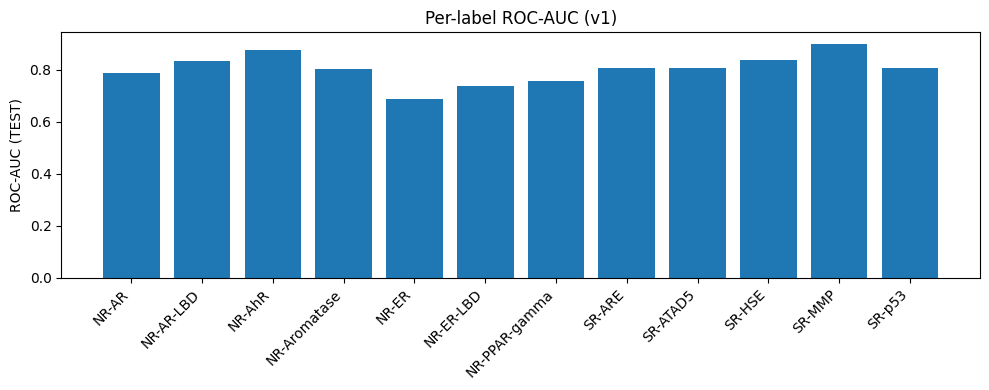

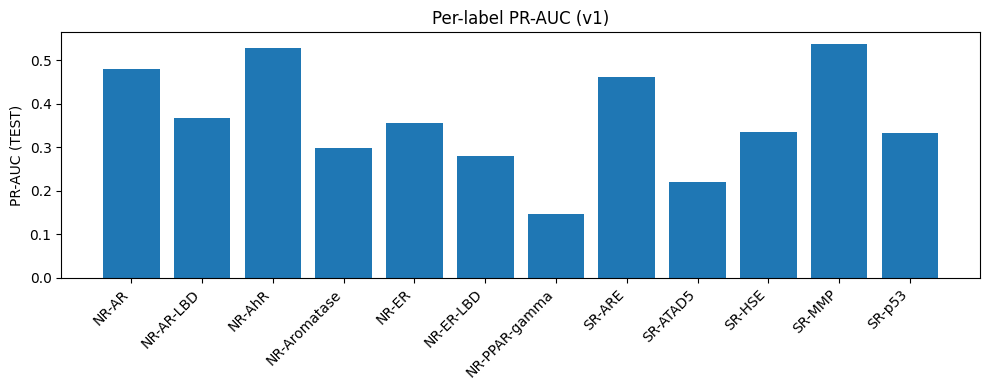

In [ ]:
import os, json
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score

ROOT   = Path("tox21_dualenc_v1")
MODELS = ROOT / "models"
CKPT   = MODELS / "checkpoints"
DATA   = ROOT / "data"
RES    = ROOT / "results" / "v1"
RES.mkdir(parents=True, exist_ok=True)

# Reuse: model, device, test_loader, label_names, CONFIG
# Load best checkpoint weights into the existing model
best_path = CKPT / "dualenc_best.pt"
state = torch.load(best_path, map_location=device)
model.load_state_dict(state["state_dict"])
model.eval()
print(f"Loaded best checkpoint from: {best_path} (val_macro_auc={state.get('val_macro_auc'):.4f})")

# Collect TEST logits/probs/labels/masks/indices
all_logits, all_y, all_m, all_idx = [], [], [], []
with torch.no_grad():
    for batch in test_loader:
        ids = batch["tok"]["input_ids"].to(device)
        att = batch["tok"]["attention_mask"].to(device)
        gbt = batch["graph"].to(device)
        dsc = batch["desc"].to(device)
        logits = model(ids, att, gbt, dsc).detach().cpu().numpy()
        all_logits.append(logits)
        all_y.append((batch["y"]==1).float().cpu().numpy())
        all_m.append(batch["mask"].float().cpu().numpy())
        all_idx.append(batch["idx"].cpu().numpy())

logits = np.concatenate(all_logits, axis=0)       # (Ntest, L)
prob   = 1.0 / (1.0 + np.exp(-logits))            # sigmoid
y01    = np.concatenate(all_y, axis=0).astype(np.float32)
mask   = np.concatenate(all_m, axis=0).astype(np.float32)
idxs   = np.concatenate(all_idx, axis=0).astype(np.int64)

# Compute metrics
L = prob.shape[1]
roc_list, pr_list = [], []
for l in range(L):
    m = mask[:, l] == 1
    y = y01[:, l][m]
    p = prob[:, l][m]
    if m.sum() > 0 and (y.min() < 1) and (y.max() > 0):
        try:
            roc = roc_auc_score(y, p)
        except Exception:
            roc = np.nan
        try:
            pr = average_precision_score(y, p)
        except Exception:
            pr = np.nan
    else:
        roc, pr = np.nan, np.nan
    roc_list.append(roc)
    pr_list.append(pr)

macro_roc = float(np.nanmean(roc_list))
macro_pr  = float(np.nanmean(pr_list))
print(f"TEST macro ROC-AUC = {macro_roc:.4f} | macro PR-AUC = {macro_pr:.4f}")

# Save arrays for reproducibility
np.save(RES/"test_logits.npy", logits)
np.save(RES/"test_prob.npy", prob)
np.save(RES/"test_y.npy", y01)
np.save(RES/"test_mask.npy", mask)
np.save(RES/"test_indices.npy", idxs)

# Save per-label table + metrics.json
df = pd.DataFrame({
    "label": label_names,
    "roc_auc": roc_list,
    "pr_auc": pr_list,
})
df.to_csv(RES/"per_label_metrics.csv", index=False)

metrics = {
    "macro_roc_auc": macro_roc,
    "macro_pr_auc": macro_pr,
    "per_label": {label_names[i]: {"roc_auc": (None if np.isnan(roc_list[i]) else float(roc_list[i])),
                                   "pr_auc":  (None if np.isnan(pr_list[i])  else float(pr_list[i]))}
                  for i in range(L)},
    "config": CONFIG,
    "best_val_macro_auc": float(state.get("val_macro_auc", float("nan"))),
}
(Path(RES/"metrics.json")).write_text(json.dumps(metrics, indent=2))
print("Saved arrays and metrics to:", RES)

# Plots: per-label ROC-AUC and PR-AUC bars
plt.figure(figsize=(10,4))
plt.bar(df["label"], df["roc_auc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("ROC-AUC (TEST)")
plt.title("Per-label ROC-AUC (v1)")
plt.tight_layout()
plt.savefig(RES/"per_label_rocauc_bar.png", dpi=200)
print("Saved:", RES/"per_label_rocauc_bar.png")

plt.figure(figsize=(10,4))
plt.bar(df["label"], df["pr_auc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("PR-AUC (TEST)")
plt.title("Per-label PR-AUC (v1)")
plt.tight_layout()
plt.savefig(RES/"per_label_prauc_bar.png", dpi=200)
print("Saved:", RES/"per_label_prauc_bar.png")


## 9: Quick inference on custom SMILES (v1 checkpoint)

- Input: a Python list `custom_smiles` (edit in the code cell).
- The graph is built with the same RDKit→PyG featurization as training.
- Descriptors: use the **train-set mean** descriptor vector per molecule (good default).
- Output:
  - A tidy Pandas table of per-label probabilities for each SMILES.
  - A compact "top labels" column using a display threshold (default 0.5).
  - CSV saved under `tox21_dualenc_v1/results/v1/infer_*.csv`.

> If any SMILES is invalid (RDKit can’t parse), it’s marked and skipped.


In [ ]:
import os, json, numpy as np, torch, pandas as pd
from pathlib import Path
from datetime import datetime
from rdkit import Chem
from torch_geometric.data import Data, Batch as GeometricBatch
from transformers import AutoTokenizer

ROOT   = Path("tox21_dualenc_v1")
DATA   = ROOT / "data"
DESC   = DATA / "descriptors"
SPLITS = DATA / "splits"
MODELS = ROOT / "models"
CKPT   = MODELS / "checkpoints"
RES    = ROOT / "results" / "v1"
RES.mkdir(parents=True, exist_ok=True)

CONFIG = json.loads((MODELS/"config_dualenc_v1.json").read_text())
label_names = (DATA/"label_names.txt").read_text(encoding="utf-8").splitlines()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load descriptor mean (train-set)
X_desc  = np.load(DESC/"desc_selected.npy").astype(np.float32)
splits  = json.loads((SPLITS/"splits.json").read_text())
train_idx = np.array(splits["train"], dtype=int)
desc_mean = X_desc[train_idx].mean(axis=0).astype(np.float32)  # (256,)

# --- Featurizers (same as training)
ATOM_LIST = ["C","N","O","S","F","Cl","Br","I","P","B"]
from rdkit import Chem
HYB_LIST = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
]
def one_hot_with_other(key, choices):
    vec = [0]* (len(choices)+1)
    try: idx = choices.index(key)
    except ValueError: idx = None
    if idx is None: vec[-1] = 1
    else: vec[idx] = 1
    return vec
def one_hot_index(idx, size):
    v = [0]*size
    if 0 <= idx < size: v[idx] = 1
    return v
def atom_features(atom: Chem.Atom):
    f_type   = one_hot_with_other(atom.GetSymbol(), ATOM_LIST)            # 11
    f_deg    = one_hot_index(min(atom.GetTotalDegree(),6), 7)             # 7
    charge_map = {-2:0,-1:1,0:2,1:3,2:4}
    f_charge = one_hot_index({**charge_map}.get(atom.GetFormalCharge(),5), 6) # 6
    hyb = atom.GetHybridization()
    f_hyb   = one_hot_with_other(hyb if hyb in HYB_LIST else "other", HYB_LIST) # 6
    f_flags = [int(atom.GetIsAromatic()), int(atom.IsInRing())]            # 2
    return f_type + f_deg + f_charge + f_hyb + f_flags                     # 32
def bond_features(bond: Chem.Bond):
    types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
             Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    f_type  = one_hot_with_other(bond.GetBondType(), types)                # 5
    f_flags = [int(bond.GetIsConjugated()), int(bond.IsInRing())]          # 2
    return f_type + f_flags                                                # 7

NODE_DIM = 32
EDGE_DIM = 7

def build_graph_from_smiles(s):
    mol = Chem.MolFromSmiles(s)
    if mol is None or mol.GetNumAtoms()==0:
        return None
    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32)
    ei_src, ei_dst, eattr = [], [], []
    for b in mol.GetBonds():
        u, v = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features(b)
        ei_src.extend([u,v]); ei_dst.extend([v,u]); eattr.extend([bf,bf])
    if len(ei_src)==0:
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr  = torch.empty((0, EDGE_DIM), dtype=torch.float32)
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)
        edge_attr  = torch.tensor(eattr, dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, invalid=0)

# --- Load model checkpoint if needed
# Reuse 'model' from earlier if it exists; otherwise instantiate and load.
try:
    model
except NameError:
    # Recreate model class inline if needed (imports came from earlier cells)
    from torch_geometric.nn import GINEConv, global_mean_pool
    from torch_geometric.utils import to_dense_batch
    import torch.nn as nn, torch.nn.functional as F
    class AttentionPoolAMP(nn.Module):
        def __init__(self, dim):
            super().__init__()
            self.score = nn.Linear(dim, 1)
        def forward(self, X, mask=None):
            s = self.score(X).squeeze(-1).float()
            if mask is not None:
                s = s.masked_fill(~mask.bool(), -1e9)
            a = torch.softmax(s, dim=1)
            a = a.to(X.dtype)
            return torch.bmm(a.unsqueeze(1), X).squeeze(1)
    class CrossAttnBlock(nn.Module):
        def __init__(self, dim=256, heads=4, dropout=0.1):
            super().__init__()
            self.attn = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
            self.norm1 = nn.LayerNorm(dim)
            self.ffn = nn.Sequential(nn.Linear(dim, 4*dim), nn.GELU(), nn.Dropout(dropout), nn.Linear(4*dim, dim))
            self.norm2 = nn.LayerNorm(dim)
            self.drop = nn.Dropout(dropout)
        def forward(self, Q_text, K_graph, V_graph, key_padding_mask=None):
            attn_out, _ = self.attn(Q_text, K_graph, V_graph, key_padding_mask=key_padding_mask)
            x = self.norm1(Q_text + self.drop(attn_out))
            ff = self.ffn(x)
            y = self.norm2(x + self.drop(ff))
            return y
    class GINEncoder(nn.Module):
        def __init__(self, node_dim, edge_dim, hidden=256, layers=4, dropout=0.2):
            super().__init__()
            self.layers = nn.ModuleList(); self.bns = nn.ModuleList()
            in_dim = node_dim
            for _ in range(layers):
                mlp = nn.Sequential(nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
                conv = GINEConv(mlp, edge_dim=edge_dim)
                self.layers.append(conv); self.bns.append(nn.BatchNorm1d(hidden)); in_dim = hidden
            self.dropout = nn.Dropout(dropout); self.hidden = hidden
        def forward(self, x, edge_index, edge_attr, batch_index):
            h = x
            for conv, bn in zip(self.layers, self.bns):
                h = conv(h, edge_index, edge_attr); h = bn(h); h = F.relu(h); h = self.dropout(h)
            z_graph = global_mean_pool(h, batch_index)
            return h, z_graph
    from transformers import AutoModel, AutoTokenizer
    class DualEncoderXAttn(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.cfg = config
            self.tok   = AutoTokenizer.from_pretrained(config["text_encoder"])
            self.text  = AutoModel.from_pretrained(config["text_encoder"])
            self.text_proj = nn.Linear(self.text.config.hidden_size, config["text_proj_dim"])
            self.gnn   = GINEncoder(node_dim=int(config["node_dim"]), edge_dim=int(config["edge_dim"]),
                                    hidden=int(config["graph_hidden"]), layers=int(config["graph_layers"]),
                                    dropout=float(config["dropout"]))
            self.xattn = CrossAttnBlock(dim=int(config["fusion_dim"]), heads=int(config["fusion_heads"]),
                                        dropout=float(config["fusion_dropout"]))
            self.tpool = AttentionPoolAMP(dim=int(config["fusion_dim"]))
            self.dmlp  = nn.Sequential(nn.Linear(int(config["desc_dim_in"]), int(config["desc_hidden"])),
                                       nn.ReLU(), nn.Dropout(float(config["dropout"])))
            fused_in = int(config["fusion_dim"]) + int(config["graph_hidden"]) + int(config["desc_hidden"])
            self.head = nn.Sequential(nn.Linear(fused_in, int(config["head_hidden"])),
                                      nn.ReLU(), nn.Dropout(float(config["dropout"])),
                                      nn.Linear(int(config["head_hidden"]), int(config["num_labels"])))
        def forward(self, input_ids, attention_mask, graph_batch, desc):
            t_out  = self.text(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
            t_proj = self.text_proj(t_out)
            g = graph_batch
            from torch_geometric.utils import to_dense_batch
            node_h, z_graph = self.gnn(g.x, g.edge_index, g.edge_attr, g.batch)
            node_dense, node_mask = to_dense_batch(node_h, g.batch)  # (B,Nmax,256),(B,Nmax)
            fused_text = self.xattn(t_proj, node_dense, node_dense, key_padding_mask=~node_mask)
            z_text = self.tpool(fused_text, mask=attention_mask.bool())
            z_desc = self.dmlp(desc)
            z = torch.cat([z_text, z_graph, z_desc], dim=-1)
            return self.head(z)
    model = DualEncoderXAttn(CONFIG).to(device)
    state = torch.load(CKPT/"dualenc_best.pt", map_location=device)
    model.load_state_dict(state["state_dict"])
    model.eval()
    print("Model reloaded from checkpoint.")

tok = model.tok  # tokenizer already attached

# --- EDIT THIS LIST with your SMILES ---
custom_smiles = [
    "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",                 #1st 
    "CCN1C(=O)NC(c2ccccc2)C1=O",                    #2nd
    "O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1",       #9th
    "CCCCCCCCCCOCC(O)CN",                           #18th
    "Nc1ccc([N+](=O)[O-])cc1N"                      #96th
]

# --- Build graphs and descriptors for the custom list
graphs_list, ok_smiles = [], []
for s in custom_smiles:
    g = build_graph_from_smiles(s)
    if g is None:
        print(f"⚠️ Invalid SMILES skipped: {s}")
        continue
    graphs_list.append(g)
    ok_smiles.append(s)

if not graphs_list:
    raise ValueError("No valid SMILES provided.")

# Batch graphs
g_batch = GeometricBatch.from_data_list(graphs_list).to(device)

# Tokenize
toks = tok(ok_smiles, padding=True, truncation=True, max_length=int(CONFIG["max_length"]), return_tensors="pt")
ids  = toks["input_ids"].to(device)
att  = toks["attention_mask"].to(device)

# Descriptors: use train mean replicated
desc = torch.tensor(np.tile(desc_mean, (len(ok_smiles), 1)), dtype=torch.float32, device=device)

# Predict
with torch.no_grad():
    logits = model(ids, att, g_batch, desc).detach().cpu().numpy()
prob = 1.0 / (1.0 + np.exp(-logits))  # sigmoid

# Build result table
df = pd.DataFrame(prob, columns=label_names, index=ok_smiles)
display_threshold = 0.50
top_labels = []
for row in prob:
    idx = np.where(row >= display_threshold)[0]
    if idx.size == 0:
        # show top-2 anyway
        top2 = np.argsort(-row)[:2]
        top_labels.append(", ".join([f"{label_names[i]} {row[i]:.2f}" for i in top2]))
    else:
        top_labels.append(", ".join([f"{label_names[i]} {row[i]:.2f}" for i in idx]))
df_out = df.copy()
df_out.insert(0, "SMILES", df_out.index)
df_out["top(≥{:.2f})".format(display_threshold)] = top_labels
df_out = df_out.reset_index(drop=True)

print("Predictions (probabilities):")
display(df_out)

# Save CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_csv = RES / f"infer_{timestamp}.csv"
df_out.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Predictions (probabilities):


,SMILES,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,top(≥0.50)
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.298675,0.061473,0.523068,0.211713,0.383640,0.104908,0.107308,0.338421,0.133352,0.155401,0.147968,0.257838,NR-AhR 0.52
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.120189,0.016753,0.168321,0.030036,0.258730,0.060593,0.043702,0.106603,0.026243,0.109143,0.030710,0.021889,"NR-ER 0.26, NR-AhR 0.17"
2,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1,0.414409,0.073200,0.487879,0.361990,0.570323,0.340692,0.501555,0.397276,0.116313,0.285753,0.485444,0.362100,"NR-ER 0.57, NR-PPAR-gamma 0.50"
3,CCCCCCCCCCOCC(O)CN,0.090146,0.005924,0.016008,0.019051,0.235007,0.035460,0.048690,0.055867,0.001675,0.060946,0.011783,0.012380,"NR-ER 0.24, NR-AR 0.09"
4,Nc1ccc([N+](=O)[O-])cc1N,0.150438,0.022171,0.639579,0.066463,0.300498,0.054996,0.062462,0.229143,0.040020,0.128588,0.168752,0.029191,NR-AhR 0.64


Saved: tox21_dualenc_v1\results\v1\infer_20250901_190058.csv


# V2

## 1: v2 setup: reset folders, refresh config, sanity-check data

In [ ]:
import os, json, shutil, time, numpy as np, torch
from pathlib import Path

ROOT = Path("tox21_dualenc_v1")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
SPL  = DATA / "splits"
GRPH = DATA / "graphs"
MODELS = ROOT / "models"
LOGS   = ROOT / "logs"
RES    = ROOT / "results"

# v2 folders (fresh)
CKPT_V2 = MODELS / "checkpoints_v2"
LOGS_V2 = LOGS / "v2"
RES_V2  = RES / "v2"

# --- 1) Archive existing v2 artifacts (if any) ---
archive_root = ROOT / "archive"
archive_root.mkdir(parents=True, exist_ok=True)
ts = time.strftime("%Y%m%d_%H%M%S")
arch_dir = archive_root / f"v2_{ts}"

def archive_if_exists(p: Path):
    if p.exists():
        arch_dir.mkdir(parents=True, exist_ok=True)
        dest = arch_dir / p.name
        if dest.exists():
            shutil.rmtree(dest)
        shutil.move(str(p), sstr(dest))
        print(f"Archived: {p} -> {dest}")

for p in [CKPT_V2, LOGS_V2, RES_V2]:
    archive_if_exists(p)

# Recreate clean folders
for p in [CKPT_V2, LOGS_V2, RES_V2]:
    p.mkdir(parents=True, exist_ok=True)

# --- 2) Build refreshed v2 config ---
# Start from v1 config if present, else assemble minimal dict
cfg_v1_path = MODELS / "config_dualenc_v1.json"
if cfg_v1_path.exists():
    base = json.loads(cfg_v1_path.read_text())
else:
    # sensible defaults if v1 config is missing for any reason
    base = dict(
        text_encoder="DeepChem/ChemBERTa-100M-MLM",
        num_labels=12, max_length=256,
        node_dim=32, edge_dim=7,
        graph_hidden=256, graph_layers=4,
        fusion_dim=256, fusion_heads=4, fusion_dropout=0.1,
        text_proj_dim=256,
        desc_dim_in=256, desc_hidden=256,
        head_hidden=512,
        dropout=0.3,
        seed=42,
    )

cfg_v2 = base.copy()
cfg_v2.update({
    # training knobs
    "batch_size": 24,
    "grad_accum_steps": 2,          # effective ≈ 48
    "stageA_freeze_text_epochs": 10,
    "stageB_unfreeze_last_layers": 2,
    "epochs_max": 100,
    "early_stop_patience": 20,
    "lr_text": 1e-5,
    "lr_others": 1e-3,
    "warmup_ratio": 0.20,
    "dropout": 0.30,
    "weight_decay": 2e-4,
    # layer-wise lr decay multipliers for the two unfrozen text layers (penultimate, last)
    "text_llrd": [0.7, 1.0],
    # bookkeeping
    "checkpoint_dir": str(CKPT_V2),
    "log_path": str(LOGS_V2 / "train_log.jsonl"),
    "results_dir": str(RES_V2),
})

cfg_v2_path = MODELS / "config_dualenc_v2.json"
cfg_v2_path.write_text(json.dumps(cfg_v2, indent=2))
print("Saved refreshed v2 config to:", cfg_v2_path)

# --- 3) Sanity-check data assets ---
req_files = [
    DATA/"X_smiles.txt",
    DATA/"y.npy",
    DATA/"y_mask.npy",
    DESC/"desc_selected.npy",
    SPL/"splits.json",
    DATA/"label_names.txt",
    GRPH/"graphs_all_pyg_safe.pt",
]
missing = [str(p) for p in req_files if not p.exists()]

if missing:
    print("⚠️ Missing files:\n - " + "\n - ".join(missing))
else:
    # load and print shapes
    smiles = (DATA/"X_smiles.txt").read_text(encoding="utf-8").splitlines()
    y      = np.load(DATA/"y.npy").astype(np.float32)
    y_mask = np.load(DATA/"y_mask.npy").astype(np.float32)
    X_desc = np.load(DESC/"desc_selected.npy").astype(np.float32)
    splits = json.loads((SPL/"splits.json").read_text())
    train_idx = np.array(splits["train"], dtype=int)
    val_idx   = np.array(splits["val"], dtype=int)
    test_idx  = np.array(splits["test"], dtype=int)

    # safe load graphs
    safe_graphs = torch.load(GRPH/"graphs_all_pyg_safe.pt")
    N_graphs = len(safe_graphs)

    print("\n=== v2 Setup Summary ===")
    print("Workspace:", ROOT.resolve())
    print(f"CUDA available: {torch.cuda.is_available()} | device count: {torch.cuda.device_count()}")
    if torch.cuda.is_available():
        print("GPU 0:", torch.cuda.get_device_name(0))
    print(f"N={len(smiles)}, L={y.shape[1]} labels")
    print("Splits train/val/test =", len(train_idx), len(val_idx), len(test_idx))
    print("y shape:", y.shape, "mask shape:", y_mask.shape, "descriptors:", X_desc.shape)
    print("graphs (safe) count:", N_graphs)

# Inventory of (fresh) v2 dirs
print("\nFresh v2 folders ready:")
print(" -", CKPT_V2)
print(" -", LOGS_V2)
print(" -", RES_V2)


Archived: tox21_dualenc_v1\models\checkpoints_v2 -> tox21_dualenc_v1\archive\v2_20250901_200305\checkpoints_v2
Archived: tox21_dualenc_v1\logs\v2 -> tox21_dualenc_v1\archive\v2_20250901_200305\v2
Archived: tox21_dualenc_v1\results\v2 -> tox21_dualenc_v1\archive\v2_20250901_200305\v2
Saved refreshed v2 config to: tox21_dualenc_v1\models\config_dualenc_v2.json

=== v2 Setup Summary ===
Workspace: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1
CUDA available: True | device count: 1
GPU 0: NVIDIA GeForce RTX 4070 Ti
N=7831, L=12 labels
Splits train/val/test = 6265 783 783
y shape: (7831, 12) mask shape: (7831, 12) descriptors: (7831, 256)
graphs (safe) count: 7831

Fresh v2 folders ready:
 - tox21_dualenc_v1\models\checkpoints_v2
 - tox21_dualenc_v1\logs\v2
 - tox21_dualenc_v1\results\v2


## 2: Instantiate model_v2 (grad checkpointing) + rebuild loaders + dry-run

In [ ]:
import json, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from pathlib import Path
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.data import Data, Batch as GeometricBatch
from torch_geometric.utils import to_dense_batch

# ---------- config & device ----------
ROOT   = Path("tox21_dualenc_v1")
DATA   = ROOT / "data"
DESC   = DATA / "descriptors"
SPLITS = DATA / "splits"
GRAPHS = DATA / "graphs"
MODELS = ROOT / "models"

CONFIG_V2 = json.loads((MODELS/"config_dualenc_v2.json").read_text())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# ---------- model definition ----------
class AttentionPoolAMP(nn.Module):
    def __init__(self, dim): 
        super().__init__(); self.score = nn.Linear(dim, 1)
    def forward(self, X, mask=None):
        s = self.score(X).squeeze(-1).float()           # softmax in fp32 for stability
        if mask is not None: s = s.masked_fill(~mask.bool(), -1e9)
        a = torch.softmax(s, dim=1).to(X.dtype)         # cast back to amp dtype
        return torch.bmm(a.unsqueeze(1), X).squeeze(1)

class CrossAttnBlock(nn.Module):
    def __init__(self, dim=256, heads=4, dropout=0.1):
        super().__init__()
        self.attn  = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ffn   = nn.Sequential(nn.Linear(dim, 4*dim), nn.GELU(), nn.Dropout(dropout), nn.Linear(4*dim, dim))
        self.norm2 = nn.LayerNorm(dim)
        self.drop  = nn.Dropout(dropout)
    def forward(self, Q_text, K_graph, V_graph, key_padding_mask=None):
        attn_out, _ = self.attn(Q_text, K_graph, V_graph, key_padding_mask=key_padding_mask)
        x  = self.norm1(Q_text + self.drop(attn_out))
        ff = self.ffn(x)
        y  = self.norm2(x + self.drop(ff))
        return y

class GINEncoder(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden=256, layers=4, dropout=0.3):
        super().__init__()
        self.layers = nn.ModuleList(); self.bns = nn.ModuleList()
        in_dim = node_dim
        for _ in range(layers):
            mlp  = nn.Sequential(nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
            conv = GINEConv(mlp, edge_dim=edge_dim)
            self.layers.append(conv); self.bns.append(nn.BatchNorm1d(hidden))
            in_dim = hidden
        self.dropout = nn.Dropout(dropout); self.hidden = hidden
    def forward(self, x, edge_index, edge_attr, batch_index):
        h = x
        for conv, bn in zip(self.layers, self.bns):
            h = conv(h, edge_index, edge_attr); h = bn(h); h = F.relu(h); h = self.dropout(h)
        z_graph = global_mean_pool(h, batch_index)
        return h, z_graph

class DualEncoderXAttn(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        # Text encoder (+ gradient checkpointing)
        self.tok  = AutoTokenizer.from_pretrained(cfg["text_encoder"])
        self.text = AutoModel.from_pretrained(cfg["text_encoder"])
        try:
            self.text.gradient_checkpointing_enable()
        except Exception:
            pass
        if hasattr(self.text, "config") and hasattr(self.text.config, "use_cache"):
            self.text.config.use_cache = False
        self.text_proj = nn.Linear(self.text.config.hidden_size, cfg["text_proj_dim"])
        # Graph encoder
        self.gnn = GINEncoder(
            node_dim=int(cfg["node_dim"]), edge_dim=int(cfg["edge_dim"]),
            hidden=int(cfg["graph_hidden"]), layers=int(cfg["graph_layers"]),
            dropout=float(cfg["dropout"])
        )
        # Cross-attn + pooling + descriptor MLP
        self.xattn = CrossAttnBlock(
            dim=int(cfg["fusion_dim"]), heads=int(cfg["fusion_heads"]),
            dropout=float(cfg["fusion_dropout"])
        )
        self.tpool = AttentionPoolAMP(int(cfg["fusion_dim"]))
        self.dmlp  = nn.Sequential(
            nn.Linear(int(cfg["desc_dim_in"]), int(cfg["desc_hidden"])),
            nn.ReLU(), nn.Dropout(float(cfg["dropout"]))
        )
        # Head
        fused_in = int(cfg["fusion_dim"]) + int(cfg["graph_hidden"]) + int(cfg["desc_hidden"])
        self.head = nn.Sequential(
            nn.Linear(fused_in, int(cfg["head_hidden"])),
            nn.ReLU(), nn.Dropout(float(cfg["dropout"])),
            nn.Linear(int(cfg["head_hidden"]), int(cfg["num_labels"]))
        )
    def forward(self, input_ids, attention_mask, graph_batch, desc):
        # Text
        t_out  = self.text(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        t_proj = self.text_proj(t_out)                                   # (B,T,256)
        # Graph
        node_h, z_graph = self.gnn(graph_batch.x, graph_batch.edge_index,
                                   graph_batch.edge_attr, graph_batch.batch)  # (ΣN,256),(B,256)
        node_dense, node_mask = to_dense_batch(node_h, graph_batch.batch)     # (B,Nmax,256),(B,Nmax)
        # Cross-attn & fuse
        fused_text = self.xattn(t_proj, node_dense, node_dense, key_padding_mask=~node_mask)
        z_text = self.tpool(fused_text, mask=attention_mask.bool())      # (B,256)
        z_desc = self.dmlp(desc)                                         # (B,256)
        z = torch.cat([z_text, z_graph, z_desc], dim=-1)                 # (B,768)
        return self.head(z)                                              # (B,L)

# Instantiate model_v2
model_v2 = DualEncoderXAttn(CONFIG_V2).to(device)
total = sum(p.numel() for p in model_v2.parameters())
trainable = sum(p.numel() for p in model_v2.parameters() if p.requires_grad)
print(f"v2 model params: total={total/1e6:.2f}M, trainable={trainable/1e6:.2f}M")
print("Text hidden → proj:", model_v2.text.config.hidden_size, "→", CONFIG_V2["text_proj_dim"])
print("Dropout:", CONFIG_V2["dropout"], "| Fusion heads:", CONFIG_V2["fusion_heads"])

# ---------- v2 dataset & loaders ----------
# Load assets
smiles = (DATA/"X_smiles.txt").read_text(encoding="utf-8").splitlines()
y      = np.load(DATA/"y.npy").astype(np.float32)
y_mask = np.load(DATA/"y_mask.npy").astype(np.float32)
X_desc = np.load(DESC/"desc_selected.npy").astype(np.float32)
splits = json.loads((SPLITS/"splits.json").read_text())
train_idx = np.array(splits["train"], dtype=int)
val_idx   = np.array(splits["val"], dtype=int)
test_idx  = np.array(splits["test"], dtype=int)

safe_graphs = torch.load(GRAPHS/"graphs_all_pyg_safe.pt")
def dict_to_data(d):
    return Data(x=d["x"], edge_index=d["edge_index"], edge_attr=d["edge_attr"],
                idx=int(d.get("idx",-1)), invalid=int(d.get("invalid",0)))
graphs = [dict_to_data(d) for d in safe_graphs]

tok = model_v2.tok
MAX_LEN = int(CONFIG_V2.get("max_length", 256))
BS      = int(CONFIG_V2.get("batch_size", 24))

class DualEncDataset(Dataset):
    def __init__(self, indices, smiles, y, y_mask, X_desc, graphs):
        self.idx = np.asarray(indices, dtype=int)
        self.smiles, self.y, self.y_mask, self.X_desc, self.graphs = smiles, y, y_mask, X_desc, graphs
    def __len__(self): return len(self.idx)
    def __getitem__(self, i):
        j = int(self.idx[i])
        return {"graph": self.graphs[j], "smiles": self.smiles[j], "desc": self.X_desc[j],
                "y": self.y[j], "mask": self.y_mask[j], "idx": j}

def collate_fn(batch):
    g_batch = GeometricBatch.from_data_list([b["graph"] for b in batch])
    toks = tok([b["smiles"] for b in batch], padding=True, truncation=True,
               max_length=MAX_LEN, return_tensors="pt")
    desc = torch.tensor(np.stack([b["desc"] for b in batch]), dtype=torch.float32)
    yb   = torch.tensor(np.stack([b["y"]    for b in batch]), dtype=torch.float32)
    mb   = torch.tensor(np.stack([b["mask"] for b in batch]), dtype=torch.float32)
    idxs = torch.tensor([b["idx"] for b in batch], dtype=torch.long)
    return {"graph": g_batch, "tok": toks, "desc": desc, "y": yb, "mask": mb, "idx": idxs}

from torch.utils.data import DataLoader
train_loader_v2 = DataLoader(DualEncDataset(train_idx, smiles, y, y_mask, X_desc, graphs),
                             batch_size=BS, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader_v2   = DataLoader(DualEncDataset(val_idx, smiles, y, y_mask, X_desc, graphs),
                             batch_size=BS, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader_v2  = DataLoader(DualEncDataset(test_idx, smiles, y, y_mask, X_desc, graphs),
                             batch_size=BS, shuffle=False, num_workers=0, collate_fn=collate_fn)

print("v2 Batches: train/val/test =", len(train_loader_v2), len(val_loader_v2), len(test_loader_v2))

# ---------- dry-run ----------
b = next(iter(train_loader_v2))
ids = b["tok"]["input_ids"].to(device)
att = b["tok"]["attention_mask"].to(device)
gbt = b["graph"].to(device)
dsc = b["desc"].to(device)
with torch.no_grad():
    out = model_v2(ids, att, gbt, dsc)
print("Dry-run logits shape:", tuple(out.shape), "| expected:", (ids.shape[0], CONFIG_V2["num_labels"]))


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


v2 model params: total=94.06M, trainable=94.06M
Text hidden → proj: 768 → 256
Dropout: 0.3 | Fusion heads: 4
v2 Batches: train/val/test = 262 33 33
Dry-run logits shape: (24, 12) | expected: (24, 12)


## 3: Train v2 (refresh): Stage A (freeze text) → Stage B (unfreeze last 2, LLRD)

In [ ]:
import json, time, numpy as np, torch, torch.nn as nn
from pathlib import Path
from torch.optim import AdamW
from sklearn.metrics import roc_auc_score
from contextlib import nullcontext

ROOT     = Path("tox21_dualenc_v1")
MODELS   = ROOT / "models"
CKPT_V2  = MODELS / "checkpoints_v2"
LOGS_V2  = ROOT / "logs" / "v2"
RES_V2   = ROOT / "results" / "v2"
CKPT_V2.mkdir(parents=True, exist_ok=True)
LOGS_V2.mkdir(parents=True, exist_ok=True)
RES_V2.mkdir(parents=True, exist_ok=True)

CONFIG_V2 = json.loads((MODELS/"config_dualenc_v2.json").read_text())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reuse: model_v2, train_loader_v2, val_loader_v2 from Cell 2
assert 'model_v2' in globals(), "Run Cell 2 first to instantiate model_v2 and loaders."
assert 'train_loader_v2' in globals() and 'val_loader_v2' in globals(), "Run Cell 2 to build loaders."

# ----- helpers -----
def set_seed(seed: int):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

def bce_masked_logits_loss(logits, y, mask, pos_weight=None):
    loss_fn = nn.BCEWithLogitsLoss(reduction="none", pos_weight=pos_weight)
    loss = loss_fn(logits, y)
    loss = (loss * mask).sum() / (mask.sum() + 1e-6)
    return loss

@torch.no_grad()
def eval_macro_auc(model, loader):
    model.eval()
    all_logits, all_y, all_m = [], [], []
    for batch in loader:
        ids = batch["tok"]["input_ids"].to(device)
        att = batch["tok"]["attention_mask"].to(device)
        gbt = batch["graph"].to(device)
        dsc = batch["desc"].to(device)
        logits = model(ids, att, gbt, dsc)
        all_logits.append(logits.detach().cpu())
        all_y.append((batch["y"]==1).float().cpu())
        all_m.append(batch["mask"].float().cpu())
    logits = torch.cat(all_logits).numpy()
    y = torch.cat(all_y).numpy()
    m = torch.cat(all_m).numpy()
    prob = 1.0 / (1.0 + np.exp(-logits))
    aucs = []
    for l in range(prob.shape[1]):
        ml = m[:,l]==1
        yl = y[:,l][ml]; pl = prob[:,l][ml]
        valid = (ml.sum()>0) and (yl.min()<1) and (yl.max()>0)
        if valid:
            try: aucs.append(roc_auc_score(yl, pl))
            except Exception: aucs.append(np.nan)
        else:
            aucs.append(np.nan)
    return float(np.nanmean(aucs)), aucs

def count_trainable(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def freeze_text(m):
    for p in m.text.parameters(): p.requires_grad = False

def unfreeze_last_n_text_layers(m, n_last=2):
    # Works for Roberta/BERT style encoders
    enc = getattr(m.text, "encoder", None)
    if enc is None and hasattr(m.text, "roberta"):
        enc = m.text.roberta.encoder
    layers = getattr(enc, "layer", None)
    if layers is None:
        # Fallback: unfreeze entire text if structure not found
        for p in m.text.parameters(): p.requires_grad = True
        return []
    L = len(layers)
    start = max(L - n_last, 0)
    unfrozen = []
    # freeze all first
    for p in m.text.parameters(): p.requires_grad = False
    # unfreeze last n
    for li in range(start, L):
        for p in layers[li].parameters(): 
            p.requires_grad = True
        unfrozen.append(li)
    return unfrozen  # list of layer indices

def get_last_n_layer_modules(m, n_last=2):
    enc = getattr(m.text, "encoder", None)
    if enc is None and hasattr(m.text, "roberta"):
        enc = m.text.roberta.encoder
    layers = getattr(enc, "layer", None)
    if layers is None: 
        return []
    L = len(layers)
    start = max(L - n_last, 0)
    return [layers[i] for i in range(start, L)]

def build_optimizer_with_llrd(model, lr_text, lr_others, weight_decay, llrd_mults):
    # Collect non-text (and projection) params
    other_params = []
    text_groups  = []
    for n, p in model.named_parameters():
        if not p.requires_grad: 
            continue
        if n.startswith("text."):
            # will be assigned per-layer below
            continue
        other_params.append(p)

    # Per-layer groups for last-N
    last_layers = get_last_n_layer_modules(model, n_last=len(llrd_mults))
    assert len(last_layers) == len(llrd_mults), "Mismatch in LLRD layers vs multipliers."

    for mod, mult in zip(last_layers, llrd_mults):
        params = [p for p in mod.parameters() if p.requires_grad]
        if params:
            text_groups.append({"params": params, "lr": lr_text*float(mult), "weight_decay": weight_decay})

    groups = []
    if other_params:
        groups.append({"params": other_params, "lr": lr_others, "weight_decay": weight_decay})
    groups.extend(text_groups)
    opt = AdamW(groups)
    return opt

def build_scheduler(opt, steps_per_epoch, total_epochs, warmup_ratio):
    from transformers import get_cosine_schedule_with_warmup
    total_steps  = max(1, steps_per_epoch * total_epochs)
    warmup_steps = max(1, int(total_steps * warmup_ratio))
    sch = get_cosine_schedule_with_warmup(opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    return sch

def log_epoch(path, epoch, stage, tr_loss, val_auc, per_label):
    rec = {
        "epoch": int(epoch), "stage": stage,
        "train_loss": float(tr_loss) if tr_loss is not None else None,
        "val_macro_auc": float(val_auc) if val_auc is not None else None,
        "val_per_label": {str(i): (None if np.isnan(per_label[i]) else float(per_label[i]))
                          for i in range(len(per_label))}
    }
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(rec) + "\n")
    return rec

# ----- seed -----
set_seed(int(CONFIG_V2.get("seed", 42)))

# ----- pos_weight from v2 train split -----
# Reuse arrays from Cell 2 scope
# (We can rebuild quickly to be robust)
from json import loads
from pathlib import Path
DATA   = ROOT / "data"
DESC   = DATA / "descriptors"
SPLITS = DATA / "splits"

y_all      = np.load(DATA/"y.npy").astype(np.float32)
y_mask_all = np.load(DATA/"y_mask.npy").astype(np.float32)
splits     = loads((SPLITS/"splits.json").read_text())
train_idx  = np.array(splits["train"], dtype=int)

pos = ((y_all[train_idx]==1) & (y_mask_all[train_idx]==1)).sum(axis=0)
neg = ((y_all[train_idx]==0) & (y_mask_all[train_idx]==1)).sum(axis=0)
eps = 1e-6
pos_weight_v2 = (neg + eps) / (pos + eps)
np.save(MODELS/"pos_weight_v2.npy", pos_weight_v2.astype(np.float32))
pos_weight = torch.tensor(pos_weight_v2, dtype=torch.float32, device=device)
print("Saved pos_weight_v2.npy. First 6:", pos_weight_v2[:6])

# ----- AMP / grad accum -----
accum = int(CONFIG_V2.get("grad_accum_steps", 2))
amp_enabled = torch.cuda.is_available()
autocast_ctx = torch.amp.autocast(device_type="cuda", dtype=torch.float16, enabled=amp_enabled)
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    running = 0.0
    optimizer.zero_grad(set_to_none=True)
    for step, batch in enumerate(loader, start=1):
        ids = batch["tok"]["input_ids"].to(device)
        att = batch["tok"]["attention_mask"].to(device)
        gbt = batch["graph"].to(device)
        dsc = batch["desc"].to(device)
        y01 = (batch["y"]==1).float().to(device)
        msk = batch["mask"].float().to(device)
        with autocast_ctx:
            logits = model(ids, att, gbt, dsc)
            loss = bce_masked_logits_loss(logits, y01, msk, pos_weight=pos_weight)
        loss_scaled = loss / max(accum,1)
        if amp_enabled:
            scaler.scale(loss_scaled).backward()
        else:
            loss_scaled.backward()
        if step % accum == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            if amp_enabled:
                scaler.step(optimizer); scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            if scheduler is not None: scheduler.step()
        running += float(loss.item())
    return running / max(len(loader), 1)

# ----- Stage A: freeze text -----
freeze_text(model_v2)
print(f"[v2 Stage A] Trainable params: {count_trainable(model_v2)/1e6:.2f}M (text frozen)")

steps_A = len(train_loader_v2) // max(accum,1)
optA = AdamW([
    {"params": [p for n,p in model_v2.named_parameters() if p.requires_grad and not n.startswith("text.")],
     "lr": float(CONFIG_V2["lr_others"]), "weight_decay": float(CONFIG_V2["weight_decay"])}
])
schA = build_scheduler(optA, steps_per_epoch=steps_A, total_epochs=int(CONFIG_V2["stageA_freeze_text_epochs"]),
                       warmup_ratio=float(CONFIG_V2["warmup_ratio"]))

best_auc, best_epoch = -1.0, -1
history_path = LOGS_V2 / "train_log.jsonl"
if history_path.exists(): history_path.unlink()

for epoch in range(1, int(CONFIG_V2["stageA_freeze_text_epochs"])+1):
    t0 = time.time()
    tr_loss = train_one_epoch(model_v2, train_loader_v2, optA, schA)
    val_auc, per_label = eval_macro_auc(model_v2, val_loader_v2)
    log_epoch(history_path, epoch, "A", tr_loss, val_auc, per_label)
    print(f"[v2 A:{epoch:02d}] loss={tr_loss:.4f}  val_auc={val_auc:.4f}  time={time.time()-t0:.1f}s")
    if val_auc > best_auc + 1e-5:
        best_auc, best_epoch = val_auc, f"A{epoch}"
        torch.save({"config": CONFIG_V2, "state_dict": model_v2.state_dict(),
                    "val_macro_auc": best_auc, "epoch": epoch, "stage": "A"},
                   CKPT_V2/"dualenc_best_v2.pt")
        print(f"  ↳ saved new BEST to {CKPT_V2/'dualenc_best_v2.pt'} (val_macro_auc={best_auc:.4f})")

# ----- Stage B: unfreeze last 2 with LLRD -----
unfrozen_idx = unfreeze_last_n_text_layers(model_v2, n_last=int(CONFIG_V2["stageB_unfreeze_last_layers"]))
print(f"[v2 Stage B] Unfrozen text layers: {unfrozen_idx} → Trainable params: {count_trainable(model_v2)/1e6:.2f}M")

optB = build_optimizer_with_llrd(
    model_v2,
    lr_text=float(CONFIG_V2["lr_text"]),
    lr_others=float(CONFIG_V2["lr_others"]),
    weight_decay=float(CONFIG_V2["weight_decay"]),
    llrd_mults=list(CONFIG_V2.get("text_llrd", [0.7, 1.0])),
)
steps_B = len(train_loader_v2) // max(accum,1)
schB = build_scheduler(optB, steps_per_epoch=steps_B, total_epochs=int(CONFIG_V2["epochs_max"]),
                       warmup_ratio=float(CONFIG_V2["warmup_ratio"]))

patience = int(CONFIG_V2.get("early_stop_patience", 20))
no_imp = 0
best_auc_num = -1.0
best_epoch_num = -1

for epoch in range(1, int(CONFIG_V2["epochs_max"])+1):
    t0 = time.time()
    tr_loss = train_one_epoch(model_v2, train_loader_v2, optB, schB)
    val_auc, per_label = eval_macro_auc(model_v2, val_loader_v2)
    log_epoch(history_path, epoch, "B", tr_loss, val_auc, per_label)
    print(f"[v2 B:{epoch:02d}] loss={tr_loss:.4f}  val_auc={val_auc:.4f}  time={time.time()-t0:.1f}s")

    improved = val_auc > best_auc_num + 1e-5
    if improved:
        best_auc_num, best_epoch_num, no_imp = val_auc, epoch, 0
        torch.save({"config": CONFIG_V2, "state_dict": model_v2.state_dict(),
                    "val_macro_auc": best_auc_num, "epoch": epoch, "stage": "B"},
                   CKPT_V2/"dualenc_best_v2.pt")
        print(f"  ↳ saved new BEST to {CKPT_V2/'dualenc_best_v2.pt'} (val_macro_auc={best_auc_num:.4f})")
    else:
        no_imp += 1

    # always save last
    torch.save({"config": CONFIG_V2, "state_dict": model_v2.state_dict(),
                "val_macro_auc": val_auc, "epoch": epoch, "stage": "B"},
               CKPT_V2/"dualenc_last_v2.pt")

    if no_imp >= patience:
        print(f"Early stopping: no improvement for {patience} epochs (best @ epoch {best_epoch_num} = {best_auc_num:.4f})")
        break

# ----- Save run summary -----
summary = {
    "best_val_macro_auc": float(max(best_auc, best_auc_num)),
    "best_epoch": best_epoch if best_auc >= best_auc_num else f"B{best_epoch_num}",
    "config": CONFIG_V2
}
(MODELS/"run_summary_v2.json").write_text(json.dumps(summary, indent=2))
print("Saved summary to", MODELS/"run_summary_v2.json")

Saved pos_weight_v2.npy. First 6: [21.28352483 24.91904751  7.30331753 18.9957446   6.51497005 17.48344365]
[v2 Stage A] Trainable params: 1.93M (text frozen)


C:\Users\Amir\AppData\Local\Temp\ipykernel_15324\2522521797.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:01] loss=1.1615  val_auc=0.7572  time=7.1s
  ↳ saved new BEST to tox21_dualenc_v1\models\checkpoints_v2\dualenc_best_v2.pt (val_macro_auc=0.7572)


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:02] loss=1.0031  val_auc=0.7517  time=6.7s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:03] loss=0.9213  val_auc=0.7957  time=6.7s
  ↳ saved new BEST to tox21_dualenc_v1\models\checkpoints_v2\dualenc_best_v2.pt (val_macro_auc=0.7957)


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:04] loss=0.8164  val_auc=0.7849  time=6.7s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:05] loss=0.7223  val_auc=0.7917  time=6.7s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:06] loss=0.6487  val_auc=0.7775  time=7.0s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:07] loss=0.5909  val_auc=0.7717  time=7.0s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:08] loss=0.5455  val_auc=0.7651  time=7.0s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:09] loss=0.5187  val_auc=0.7672  time=6.9s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 A:10] loss=0.4846  val_auc=0.7655  time=6.7s
[v2 Stage B] Unfrozen text layers: [10, 11] → Trainable params: 16.11M


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:01] loss=0.4836  val_auc=0.7689  time=6.7s
  ↳ saved new BEST to tox21_dualenc_v1\models\checkpoints_v2\dualenc_best_v2.pt (val_macro_auc=0.7689)


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:02] loss=0.4806  val_auc=0.7672  time=6.7s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:03] loss=0.4826  val_auc=0.7603  time=6.7s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:04] loss=0.4822  val_auc=0.7730  time=6.5s
  ↳ saved new BEST to tox21_dualenc_v1\models\checkpoints_v2\dualenc_best_v2.pt (val_macro_auc=0.7730)


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:05] loss=0.4796  val_auc=0.7653  time=6.6s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:06] loss=0.4741  val_auc=0.7552  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:07] loss=0.4579  val_auc=0.7568  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:08] loss=0.4449  val_auc=0.7565  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:09] loss=0.4391  val_auc=0.7594  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:10] loss=0.4279  val_auc=0.7533  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:11] loss=0.4162  val_auc=0.7625  time=6.4s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:12] loss=0.4109  val_auc=0.7579  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:13] loss=0.3940  val_auc=0.7578  time=6.6s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:14] loss=0.3708  val_auc=0.7571  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:15] loss=0.3351  val_auc=0.7487  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:16] loss=0.3331  val_auc=0.7506  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:17] loss=0.3189  val_auc=0.7520  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:18] loss=0.3234  val_auc=0.7488  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:19] loss=0.3211  val_auc=0.7485  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:20] loss=0.3164  val_auc=0.7348  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:21] loss=0.3063  val_auc=0.7632  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:22] loss=0.3013  val_auc=0.7420  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:23] loss=0.3211  val_auc=0.7439  time=6.5s


d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\lord\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[v2 B:24] loss=0.3716  val_auc=0.7435  time=6.5s
Early stopping: no improvement for 20 epochs (best @ epoch 4 = 0.7730)
Saved summary to tox21_dualenc_v1\models\run_summary_v2.json


## 4: Eval

Loaded v2 best checkpoint: dualenc_best_v2.pt (val_macro_auc=0.7730, stage=B)
Shapes — logits: (783, 12) | prob: (783, 12) | y/mask: (783, 12) (783, 12)
TEST macro ROC-AUC = 0.8008 | macro PR-AUC = 0.3697
Saved arrays & metrics to: tox21_dualenc_v1\results\v2
Saved: tox21_dualenc_v1\results\v2\per_label_rocauc_bar.png
Saved: tox21_dualenc_v1\results\v2\per_label_prauc_bar.png


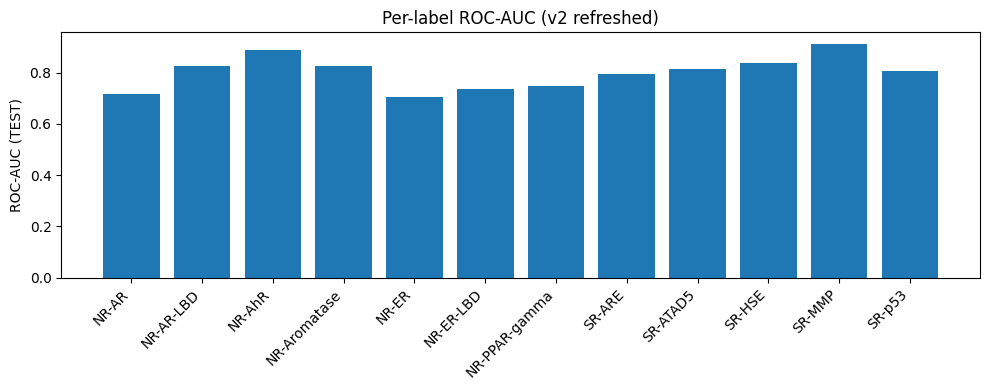

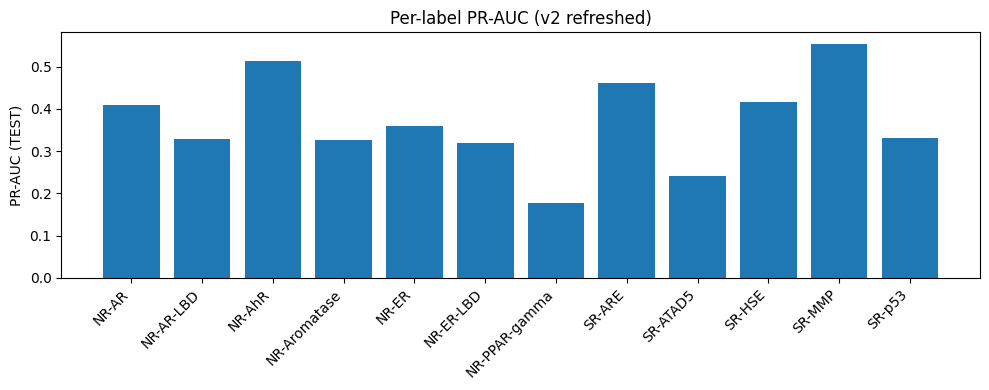

In [ ]:
import os, json, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score

ROOT     = Path("tox21_dualenc_v1")
MODELS   = ROOT / "models"
CKPT_V2  = MODELS / "checkpoints_v2"
DATA     = ROOT / "data"
RES_V2   = ROOT / "results" / "v2"
RES_V2.mkdir(parents=True, exist_ok=True)

# Expect these from earlier cells
assert 'model_v2' in globals(), "Please run v2 — Cell 2 to build the model."
assert 'test_loader_v2' in globals(), "Please run v2 — Cell 2 to build loaders."
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load best checkpoint weights into the in-memory model
best_path = CKPT_V2 / "dualenc_best_v2.pt"
state = torch.load(best_path, map_location=device)
model_v2.load_state_dict(state["state_dict"])
model_v2.eval()
print(f"Loaded v2 best checkpoint: {best_path.name} (val_macro_auc={state.get('val_macro_auc'):.4f}, stage={state.get('stage')})")

label_names = (DATA/"label_names.txt").read_text(encoding="utf-8").splitlines()

# --- Run TEST inference
all_logits, all_y, all_m, all_idx = [], [], [], []
with torch.no_grad():
    for batch in test_loader_v2:
        ids = batch["tok"]["input_ids"].to(device)
        att = batch["tok"]["attention_mask"].to(device)
        gbt = batch["graph"].to(device)
        dsc = batch["desc"].to(device)
        logits = model_v2(ids, att, gbt, dsc).detach().cpu().numpy()
        all_logits.append(logits)
        all_y.append((batch["y"]==1).float().cpu().numpy())
        all_m.append(batch["mask"].float().cpu().numpy())
        all_idx.append(batch["idx"].cpu().numpy())

logits = np.concatenate(all_logits, axis=0)       # (Ntest, L)
prob   = 1.0 / (1.0 + np.exp(-logits))            # sigmoid
y01    = np.concatenate(all_y, axis=0).astype(np.float32)
mask   = np.concatenate(all_m, axis=0).astype(np.float32)
idxs   = np.concatenate(all_idx, axis=0).astype(np.int64)

print("Shapes — logits:", logits.shape, "| prob:", prob.shape, "| y/mask:", y01.shape, mask.shape)

# --- Metrics
L = prob.shape[1]
roc_list, pr_list = [], []
for l in range(L):
    m = mask[:, l] == 1
    y = y01[:, l][m]
    p = prob[:, l][m]
    if m.sum() > 0 and (y.min() < 1) and (y.max() > 0):
        try: roc = roc_auc_score(y, p)
        except Exception: roc = np.nan
        try: pr = average_precision_score(y, p)
        except Exception: pr = np.nan
    else:
        roc, pr = np.nan, np.nan
    roc_list.append(roc); pr_list.append(pr)

macro_roc = float(np.nanmean(roc_list))
macro_pr  = float(np.nanmean(pr_list))
print(f"TEST macro ROC-AUC = {macro_roc:.4f} | macro PR-AUC = {macro_pr:.4f}")

# --- Save arrays & tables
np.save(RES_V2/"test_logits.npy", logits)
np.save(RES_V2/"test_prob.npy", prob)
np.save(RES_V2/"test_y.npy", y01)
np.save(RES_V2/"test_mask.npy", mask)
np.save(RES_V2/"test_indices.npy", idxs)

df = pd.DataFrame({
    "label": label_names,
    "roc_auc": roc_list,
    "pr_auc": pr_list,
})
df.to_csv(RES_V2/"per_label_metrics.csv", index=False)

metrics = {
    "macro_roc_auc": macro_roc,
    "macro_pr_auc": macro_pr,
    "per_label": {label_names[i]: {"roc_auc": (None if np.isnan(roc_list[i]) else float(roc_list[i])),
                                   "pr_auc":  (None if np.isnan(pr_list[i])  else float(pr_list[i]))}
                  for i in range(L)},
    "best_val_macro_auc": float(state.get("val_macro_auc", float("nan"))),
    "best_stage": state.get("stage"),
}
(RES_V2/"metrics.json").write_text(json.dumps(metrics, indent=2))
print("Saved arrays & metrics to:", RES_V2)

# --- Plots
plt.figure(figsize=(10,4))
plt.bar(df["label"], df["roc_auc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("ROC-AUC (TEST)")
plt.title("Per-label ROC-AUC (v2 refreshed)")
plt.tight_layout()
plt.savefig(RES_V2/"per_label_rocauc_bar.png", dpi=200)
print("Saved:", RES_V2/"per_label_rocauc_bar.png")

plt.figure(figsize=(10,4))
plt.bar(df["label"], df["pr_auc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("PR-AUC (TEST)")
plt.title("Per-label PR-AUC (v2 refreshed)")
plt.tight_layout()
plt.savefig(RES_V2/"per_label_prauc_bar.png", dpi=200)
print("Saved:", RES_V2/"per_label_prauc_bar.png")


## 5: Dynamic thresholds from train+val (per-label) with robust fallback

In [12]:
import json, numpy as np, torch, time
from pathlib import Path
from sklearn.metrics import f1_score, precision_score, recall_score

ROOT     = Path("tox21_dualenc_v1")
MODELS   = ROOT / "models"
CKPT_V2  = MODELS / "checkpoints_v2"
DATA     = ROOT / "data"

assert 'model_v2' in globals(), "Run v2 — Cell 2 (model + loaders) first."
assert 'train_loader_v2' in globals() and 'val_loader_v2' in globals(), "Run v2 — Cell 2 first."
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load best weights
st = torch.load(CKPT_V2/"dualenc_best_v2.pt", map_location=device)
model_v2.load_state_dict(st["state_dict"])
model_v2.eval()

label_names = (DATA/"label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)

def collect(loader):
    probs, ys, ms = [], [], []
    with torch.no_grad():
        for b in loader:
            ids = b["tok"]["input_ids"].to(device)
            att = b["tok"]["attention_mask"].to(device)
            gbt = b["graph"].to(device)
            dsc = b["desc"].to(device)
            logits = model_v2(ids, att, gbt, dsc)
            p = torch.sigmoid(logits).cpu().numpy()
            y = (b["y"]==1).float().cpu().numpy()
            m = b["mask"].float().cpu().numpy()
            probs.append(p); ys.append(y); ms.append(m)
    return np.concatenate(probs), np.concatenate(ys), np.concatenate(ms)

prob_tr, y_tr, m_tr = collect(train_loader_v2)
prob_va, y_va, m_va = collect(val_loader_v2)

# Use ALL labeled non-test: train + val
prob_tv = np.concatenate([prob_tr, prob_va], axis=0)
y_tv    = np.concatenate([y_tr,    y_va   ], axis=0)
m_tv    = np.concatenate([m_tr,    m_va   ], axis=0)

def safe_scores(y_true, y_pred):
    return {
        "f1":  f1_score(y_true, y_pred, zero_division=0),
        "pr":  precision_score(y_true, y_pred, zero_division=0),
        "rc":  recall_score(y_true, y_pred, zero_division=0),
    }

# Threshold search params
FLOOR = 0.25   # never go below this unless using top-1 fallback at inference
CEIL  = 0.90
MIN_POS_FRAC = 0.01  # if predicted positives < 1% on train+val, consider too conservative

results = {"meta": {
    "computed_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "ckpt_val_macro_auc": float(st.get("val_macro_auc", float("nan"))),
    "ckpt_stage": st.get("stage", "B"),
    "splits_used": "train+val",
    "floor": FLOOR, "ceil": CEIL, "min_pos_frac": MIN_POS_FRAC
}}

per_label = {}

for j, name in enumerate(label_names):
    mask = m_tv[:, j] == 1
    if mask.sum() == 0:
        per_label[name] = {"thr": 0.50, "reason": "no_labeled_data", "f1": None, "pr": None, "rc": None}
        continue

    y = y_tv[:, j][mask].astype(int)
    p = prob_tv[:, j][mask]

    # prevalence-matched quantile (positive rate target)
    prev = y.mean()  # fraction positives in true labels
    # target predicted positive fraction ~= prev → threshold at (1 - prev) quantile
    thr_quant = float(np.quantile(p, 1.0 - prev)) if prev < 1.0 else CEIL

    # build candidate thresholds from percentiles of this label's probabilities
    qs = np.linspace(0.05, 0.95, 181)
    cand = np.unique(np.quantile(p, qs))
    # ensure floor & ceil included
    cand = np.unique(np.clip(np.concatenate([cand, [FLOOR, CEIL]]), 0.0, 1.0))

    # evaluate candidates on F1
    best = {"thr": 0.50, "f1": -1.0, "pr": 0.0, "rc": 0.0}
    for t in cand:
        yhat = (p >= t).astype(int)
        sc = safe_scores(y, yhat)
        if (sc["f1"] > best["f1"]) or (np.isclose(sc["f1"], best["f1"]) and t < best["thr"]):
            best = {"thr": float(t), **sc}

    # guardrails
    pos_frac = (p >= best["thr"]).mean()
    if np.isnan(best["f1"]) or pos_frac < MIN_POS_FRAC:
        thr_final = max(thr_quant, FLOOR)
        reason = f"fallback_quantile (pos_frac={pos_frac:.3f})"
        # compute scores at fallback (for logging only, uses ground truth)
        yhat_fb = (p >= thr_final).astype(int)
        sc_fb = safe_scores(y, yhat_fb)
        per_label[name] = {"thr": float(thr_final), "reason": reason,
                           "f1": float(sc_fb["f1"]), "pr": float(sc_fb["pr"]), "rc": float(sc_fb["rc"]),
                           "thr_f1": best["thr"], "f1_f1": float(best["f1"]),
                           "thr_quant": float(thr_quant)}
    else:
        thr_final = float(np.clip(best["thr"], FLOOR, CEIL))
        per_label[name] = {"thr": thr_final, "reason": "best_f1_clipped",
                           "f1": float(best["f1"]), "pr": float(best["pr"]), "rc": float(best["rc"]),
                           "thr_quant": float(thr_quant)}

results["per_label"] = per_label

# Also compute a reference global threshold on val only (not used by default)
from sklearn.metrics import f1_score
def macro_f1_at(t, prob, y, m):
    f1s = []
    for j in range(prob.shape[1]):
        mask = m[:, j]==1
        if mask.sum()==0: continue
        yy = y[:, j][mask].astype(int)
        pp = prob[:, j][mask]
        f1s.append(f1_score(yy, (pp>=t).astype(int), zero_division=0))
    return float(np.mean(f1s)) if f1s else 0.0

grid = np.linspace(0.05, 0.95, 181)
best_t, best_f = 0.5, -1.0
for t in grid:
    f = macro_f1_at(t, prob_va, y_va, m_va)
    if f > best_f or (np.isclose(f,best_f) and t < best_t):
        best_t, best_f = float(t), float(f)
results["global"] = {"thr": best_t, "val_macro_f1": best_f}

# Save
out_path = MODELS/"thresholds_v2_dynamic.json"
out_path.write_text(json.dumps(results, indent=2))
print("Saved dynamic thresholds to:", out_path)
# quick peek
kpeek = sorted([(k, v["thr"], v["reason"]) for k,v in per_label.items()], key=lambda x: x[1])[:6]
print("Lowest 6 thresholds:", kpeek)


Saved dynamic thresholds to: tox21_dualenc_v1\models\thresholds_v2_dynamic.json
Lowest 6 thresholds: [('NR-ER', 0.6777247875928872, 'best_f1_clipped'), ('SR-ARE', 0.7474570083618164, 'best_f1_clipped'), ('SR-MMP', 0.798002764582634, 'best_f1_clipped'), ('SR-HSE', 0.8113327467441558, 'best_f1_clipped'), ('NR-AhR', 0.8182927966117857, 'best_f1_clipped'), ('NR-ER-LBD', 0.8382711422443387, 'best_f1_clipped')]


## 6: New test 

In [13]:
import os, json, numpy as np, torch, pandas as pd
from pathlib import Path
from datetime import datetime
from rdkit import Chem
from torch_geometric.data import Data, Batch as GeometricBatch

ROOT   = Path("tox21_dualenc_v1")
DATA   = ROOT / "data"
DESC   = DATA / "descriptors"
SPLITS = DATA / "splits"
MODELS = ROOT / "models"
CKPT_V2 = MODELS / "checkpoints_v2"
RES_V2  = ROOT / "results" / "v2"
RES_V2.mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG_V2 = json.loads((MODELS/"config_dualenc_v2.json").read_text())
label_names = (DATA/"label_names.txt").read_text(encoding="utf-8").splitlines()
thr_conf = json.loads((MODELS/"thresholds_v2_dynamic.json").read_text())
applied_thr = {lbl: float(thr_conf["per_label"][lbl]["thr"]) for lbl in label_names}

TOP1_FALLBACK = True     # set False to disable
TOP1_FLOOR    = 0.30     # only trigger fallback if top-1 prob ≥ this floor

# --- Descriptor train-mean
X_desc  = np.load(DESC/"desc_selected.npy").astype(np.float32)
splits  = json.loads((SPLITS/"splits.json").read_text())
train_idx = np.array(splits["train"], dtype=int)
desc_mean = X_desc[train_idx].mean(axis=0).astype(np.float32)

# --- Featurizers (same as training)
ATOM_LIST = ["C","N","O","S","F","Cl","Br","I","P","B"]
HYB_LIST = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
]
def one_hot_with_other(key, choices):
    v = [0]*(len(choices)+1)
    try: idx = choices.index(key)
    except ValueError: idx = None
    v[-1 if idx is None else idx] = 1
    return v
def one_hot_index(idx, size):
    v = [0]*size
    if 0 <= idx < size: v[idx] = 1
    return v
def atom_features(atom: Chem.Atom):
    f_type   = one_hot_with_other(atom.GetSymbol(), ATOM_LIST)
    f_deg    = one_hot_index(min(atom.GetTotalDegree(),6), 7)
    charge_map = {-2:0,-1:1,0:2,1:3,2:4}
    f_charge = one_hot_index(charge_map.get(atom.GetFormalCharge(),5), 6)
    hyb = atom.GetHybridization()
    f_hyb   = one_hot_with_other(hyb if hyb in HYB_LIST else "other", HYB_LIST)
    f_flags = [int(atom.GetIsAromatic()), int(atom.IsInRing())]
    return f_type + f_deg + f_charge + f_hyb + f_flags
def bond_features(bond: Chem.Bond):
    types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
             Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    f_type  = one_hot_with_other(bond.GetBondType(), types)
    f_flags = [int(bond.GetIsConjugated()), int(bond.IsInRing())]
    return f_type + f_flags

NODE_DIM, EDGE_DIM = 32, 7
def build_graph_from_smiles(s):
    mol = Chem.MolFromSmiles(s)
    if mol is None or mol.GetNumAtoms()==0:
        return None
    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32)
    ei_src, ei_dst, eattr = [], [], []
    for b in mol.GetBonds():
        u, v = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features(b)
        ei_src.extend([u,v]); ei_dst.extend([v,u]); eattr.extend([bf,bf])
    if len(ei_src)==0:
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr  = torch.empty((0, EDGE_DIM), dtype=torch.float32)
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)
        edge_attr  = torch.tensor(eattr, dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, invalid=0)

# Load model (reuse if present)
try:
    model_v2
    tok = model_v2.tok
except NameError:
    import torch.nn as nn, torch.nn.functional as F
    from torch_geometric.nn import GINEConv, global_mean_pool
    from torch_geometric.utils import to_dense_batch
    from transformers import AutoModel, AutoTokenizer
    class AttentionPoolAMP(nn.Module):
        def __init__(self, dim): super().__init__(); self.score = nn.Linear(dim, 1)
        def forward(self, X, mask=None):
            s = self.score(X).squeeze(-1).float()
            if mask is not None: s = s.masked_fill(~mask.bool(), -1e9)
            a = torch.softmax(s, dim=1).to(X.dtype)
            return torch.bmm(a.unsqueeze(1), X).squeeze(1)
    class CrossAttnBlock(nn.Module):
        def __init__(self, dim=256, heads=4, dropout=0.1):
            super().__init__()
            self.attn = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
            self.norm1 = nn.LayerNorm(dim)
            self.ffn = nn.Sequential(nn.Linear(dim, 4*dim), nn.GELU(), nn.Dropout(dropout), nn.Linear(4*dim, dim))
            self.norm2 = nn.LayerNorm(dim); self.drop = nn.Dropout(dropout)
        def forward(self, Q_text, K_graph, V_graph, key_padding_mask=None):
            attn_out,_ = self.attn(Q_text, K_graph, V_graph, key_padding_mask=key_padding_mask)
            x = self.norm1(Q_text + self.drop(attn_out)); ff = self.ffn(x)
            return self.norm2(x + self.drop(ff))
    class GINEncoder(nn.Module):
        def __init__(self, node_dim, edge_dim, hidden=256, layers=4, dropout=0.3):
            super().__init__()
            self.layers = nn.ModuleList(); self.bns = nn.ModuleList()
            in_dim = node_dim
            for _ in range(layers):
                mlp  = nn.Sequential(nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
                conv = GINEConv(mlp, edge_dim=edge_dim)
                self.layers.append(conv); self.bns.append(nn.BatchNorm1d(hidden)); in_dim = hidden
            self.dropout = nn.Dropout(dropout); self.hidden = hidden
        def forward(self, x, edge_index, edge_attr, batch_index):
            h = x
            for conv, bn in zip(self.layers, self.bns):
                h = conv(h, edge_index, edge_attr); h = bn(h); h = torch.relu(h); h = self.dropout(h)
            z_graph = global_mean_pool(h, batch_index); return h, z_graph
    class DualEncoderXAttn(nn.Module):
        def __init__(self, cfg):
            super().__init__()
            self.cfg = cfg
            self.tok  = AutoTokenizer.from_pretrained(cfg["text_encoder"])
            self.text = AutoModel.from_pretrained(cfg["text_encoder"])
            self.text_proj = nn.Linear(self.text.config.hidden_size, cfg["text_proj_dim"])
            self.gnn  = GINEncoder(int(cfg["node_dim"]), int(cfg["edge_dim"]),
                                   int(cfg["graph_hidden"]), int(cfg["graph_layers"]),
                                   float(cfg["dropout"]))
            self.xattn = CrossAttnBlock(int(cfg["fusion_dim"]), int(cfg["fusion_heads"]),
                                        float(cfg["fusion_dropout"]))
            self.tpool = AttentionPoolAMP(int(cfg["fusion_dim"]))
            self.dmlp  = nn.Sequential(
                torch.nn.Linear(int(cfg["desc_dim_in"]), int(cfg["desc_hidden"])),
                torch.nn.ReLU(), torch.nn.Dropout(float(cfg["dropout"]))
            )
            fused_in = int(cfg["fusion_dim"]) + int(cfg["graph_hidden"]) + int(cfg["desc_hidden"])
            self.head = nn.Sequential(torch.nn.Linear(fused_in, int(cfg["head_hidden"])),
                                      torch.nn.ReLU(), torch.nn.Dropout(float(cfg["dropout"])),
                                      torch.nn.Linear(int(cfg["head_hidden"]), int(cfg["num_labels"])))
        def forward(self, input_ids, attention_mask, graph_batch, desc):
            t_out  = self.text(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
            t_proj = self.text_proj(t_out)
            node_h, z_graph = self.gnn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr, graph_batch.batch)
            from torch_geometric.utils import to_dense_batch
            node_dense, node_mask = to_dense_batch(node_h, graph_batch.batch)
            fused_text = self.xattn(t_proj, node_dense, node_dense, key_padding_mask=~node_mask)
            z_text = self.tpool(fused_text, mask=attention_mask.bool())
            z_desc = self.dmlp(desc)
            z = torch.cat([z_text, z_graph, z_desc], dim=-1)
            return self.head(z)
    model_v2 = DualEncoderXAttn(CONFIG_V2).to(device)
    st = torch.load(CKPT_V2/"dualenc_best_v2.pt", map_location=device)
    model_v2.load_state_dict(st["state_dict"]); model_v2.eval()
    tok = model_v2.tok

# --- Your SMILES list ---
custom_smiles = [
    "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",
    "CCN1C(=O)NC(c2ccccc2)C1=O",
    "O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1",
    "CCCCCCCCCCOCC(O)CN",
    "Nc1ccc([N+](=O)[O-])cc1N",
]

# Build graphs & tokenize
def build_graph_from_smiles(s):
    mol = Chem.MolFromSmiles(s)
    if mol is None or mol.GetNumAtoms()==0: return None
    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32)
    ei_src, ei_dst, eattr = [], [], []
    for b in mol.GetBonds():
        u, v = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features(b)
        ei_src.extend([u,v]); ei_dst.extend([v,u]); eattr.extend([bf,bf])
    if len(ei_src)==0:
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr  = torch.empty((0, 7), dtype=torch.float32)
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)
        edge_attr  = torch.tensor(eattr, dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, invalid=0)

graphs_list, ok_smiles = [], []
for s in custom_smiles:
    g = build_graph_from_smiles(s)
    if g is None: 
        print("⚠️ Invalid SMILES skipped:", s); 
        continue
    graphs_list.append(g); ok_smiles.append(s)

g_batch = GeometricBatch.from_data_list(graphs_list).to(device)
toks = tok(ok_smiles, padding=True, truncation=True,
           max_length=int(CONFIG_V2["max_length"]), return_tensors="pt")
ids, att = toks["input_ids"].to(device), toks["attention_mask"].to(device)

# descriptors = train-mean
X_desc  = np.load(DESC/"desc_selected.npy").astype(np.float32)
train_idx = np.array(json.loads((SPLITS/"splits.json").read_text())["train"], dtype=int)
desc_mean = X_desc[train_idx].mean(axis=0).astype(np.float32)
desc = torch.tensor(np.tile(desc_mean, (len(ok_smiles), 1)), dtype=torch.float32, device=device)

# Predict
with torch.no_grad():
    prob = torch.sigmoid(model_v2(ids, att, g_batch, desc)).cpu().numpy()  # (B,L)

# Apply per-label thresholds
thr_vec = np.array([applied_thr[lbl] for lbl in label_names], dtype=float)
pred_bin = (prob >= thr_vec[None, :]).astype(int)

# Optional top-1 fallback per molecule
if TOP1_FALLBACK:
    for i in range(pred_bin.shape[0]):
        if pred_bin[i].sum() == 0:
            j = int(np.argmax(prob[i]))
            if prob[i, j] >= TOP1_FLOOR:
                pred_bin[i, j] = 1  # force top-1 call

# Build output
df_prob = pd.DataFrame(prob, columns=label_names, index=ok_smiles)
calls = []
for i, smi in enumerate(ok_smiles):
    pos = [label_names[j] for j in np.where(pred_bin[i] == 1)[0]]
    calls.append(", ".join(pos) if pos else "—")
df_out = df_prob.copy()
df_out.insert(0, "SMILES", df_out.index)
df_out["predicted (+ dyn)"] = calls
df_out = df_out.reset_index(drop=True)

print("v2 Predictions using *dynamic* thresholds (train+val) with top-1 fallback:")
display(df_out)

# Save
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_csv = RES_V2 / f"infer_v2_dynamic_{timestamp}.csv"
df_out.to_csv(out_csv, index=False)
print("Saved:", out_csv)


v2 Predictions using *dynamic* thresholds (train+val) with top-1 fallback:


,SMILES,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,predicted (+ dyn)
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.170309,0.028467,0.591774,0.123696,0.501389,0.102438,0.014603,0.400861,0.053786,0.081905,0.219491,0.121179,NR-AhR
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.044805,0.002296,0.250795,0.012563,0.297068,0.043581,0.011215,0.114922,0.004707,0.050002,0.067577,0.005852,—
2,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1,0.160081,0.020800,0.486615,0.132796,0.378834,0.122802,0.167773,0.428976,0.037286,0.390943,0.499104,0.453635,SR-MMP
3,CCCCCCCCCCOCC(O)CN,0.091298,0.005698,0.029006,0.023343,0.210743,0.016582,0.051413,0.071533,0.001126,0.110368,0.038713,0.016474,—
4,Nc1ccc([N+](=O)[O-])cc1N,0.390982,0.290442,0.836103,0.104454,0.408156,0.479435,0.650302,0.719225,0.347424,0.440683,0.692822,0.522807,NR-AhR


Saved: tox21_dualenc_v1\results\v2\infer_v2_dynamic_20250901_203227.csv


# V3

## 1: Setup & Dynamic Config (paths, env, dims)

In [ ]:
import os, json, random
import numpy as np
import torch
from pathlib import Path

ROOT = Path("tox21_dualenc_v1")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
SPL  = DATA / "splits"

CKPT = ROOT / "models" / "checkpoints_v3"
RES  = ROOT / "results" / "v3"
LOGS = ROOT / "logs" / "v3"
for p in [CKPT, RES, LOGS]: p.mkdir(parents=True, exist_ok=True)

# ---- seeds
SEEDS = [42, 43, 44]
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); 
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(SEEDS[0])

# ---- config (tuned)
CONFIG = {
    "text_encoder": "DeepChem/ChemBERTa-100M-MLM",
    "max_length": 256,
    "node_dim": 34, "edge_dim": 7,
    "graph_hidden": 256, "graph_layers": 4,
    "desc_dim_in": 256, "desc_hidden": 256,
    "fusion_dim": 256, "text_proj_dim": 256,
    "fusion_heads": 4, "fusion_dropout": 0.10,
    "head_hidden": 512,
    "dropout": 0.20,
    "num_labels": 12,

    # training
    "batch_size": 24, "grad_accum_steps": 2,
    "lr_others": 1e-3, "lr_text": 2e-6,         # gentler text LR
    "weight_decay": 2.5e-4,
    "epochs_max": 120, "stageA_freeze_text_epochs": 8,
    "stageB_unfreeze_last_layers": 2,           # gentler unfreeze
    "text_llrd": [0.4, 1.0],                    # LLRD multipliers last-2
    "warmup_ratio": 0.12,
    "early_stop_patience": 20,
    "use_ema": True, "stageC_epochs": 2,

    # augmentation / tta
    "train_smiles_enum_p": 0.3,
    "tta_enum_n": 5,

    # I/O
    "log_path": str(LOGS / "train_log.jsonl")
}

# save config
(CKPT / "config_dualenc_v3.json").write_text(json.dumps(CONFIG, indent=2))
print(f"[V3] Device: {'cuda' if torch.cuda.is_available() else 'cpu'} | torch={torch.__version__}")
print(f"[V3] Checkpoints: {CKPT}")
print(f"[V3] Results    : {RES}")
print(f"[V3] Logs       : {CONFIG['log_path']}")
print(f"[V3] Seeds      : {SEEDS}")


[V3] Device: cuda | torch=2.6.0+cu124
[V3] Checkpoints: tox21_dualenc_v1\models\checkpoints_v3
[V3] Results    : tox21_dualenc_v1\results\v3
[V3] Logs       : tox21_dualenc_v1\logs\v3\train_log.jsonl
[V3] Seeds      : [42, 43, 44]


## 2: Data & Featurization (SMILES → RDKit → PyG, Tokenizer, Enumeration, Loaders)

In [ ]:
import json, os, warnings
import numpy as np
import torch
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict

from rdkit import Chem
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data as GeoData, Batch as GeoBatch

ROOT = Path("tox21_dualenc_v1")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
SPL  = DATA / "splits"
CKPT = ROOT / "models" / "checkpoints_v3"

# ---- load core arrays prepared earlier in your repo
X_desc  = np.load(DESC/"desc_selected.npy").astype(np.float32)
splits  = json.loads((SPL/"splits.json").read_text())
labels  = np.load(DATA/"labels.npy").astype(np.float32)         # shape (N,12)
mask    = np.load(DATA/"mask.npy").astype(np.float32)           # 1 if label present else 0
smiles  = (DATA/"smiles_all.txt").read_text(encoding="utf-8").splitlines()
assert len(smiles) == labels.shape[0] == mask.shape[0] == X_desc.shape[0]

N, L = labels.shape
print(f"[V3] Loaded: N={N}, L={L}, desc_dim={X_desc.shape[1]}, smiles={len(smiles)}")

# build atom/bond featurizers (34 / 7)
ATOM_LIST = ["H","B","C","N","O","F","Si","P","S","Cl","Br","I"]
HYB_LIST  = [Chem.rdchem.HybridizationType.SP,
             Chem.rdchem.HybridizationType.SP2,
             Chem.rdchem.HybridizationType.SP3,
             Chem.rdchem.HybridizationType.SP3D,
             Chem.rdchem.HybridizationType.SP3D2]
def one_hot_with_other(x, choices):
    return [1 if x == c else 0 for c in choices] + [0 if x in choices else 1]
def one_hot_index(idx, size):
    v = [0]*size
    if 0 <= idx < size: v[idx] = 1
    return v
def atom_features(atom: Chem.Atom):
    sym      = atom.GetSymbol()
    f_type   = one_hot_with_other(sym, ATOM_LIST)           # 13
    deg      = atom.GetTotalDegree()
    f_deg    = one_hot_index(min(deg,6), 7)                 # 7
    charge   = atom.GetFormalCharge()
    charge_map = {-2:0,-1:1,0:2,1:3,2:4}
    f_charge = one_hot_index(charge_map.get(charge,5), 6)   # 6
    hyb      = atom.GetHybridization()
    f_hyb    = one_hot_with_other(hyb, HYB_LIST)            # 6
    f_flags  = [int(atom.GetIsAromatic()), int(atom.IsInRing())]  # 2
    return f_type + f_deg + f_charge + f_hyb + f_flags      # 34
def bond_features(bond: Chem.Bond):
    types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
             Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    f_type  = one_hot_with_other(bond.GetBondType(), types)   # 5
    f_flags = [int(bond.GetIsConjugated()), int(bond.IsInRing())]  # 2
    return f_type + f_flags                                   # 7

def build_graph(s):
    m = Chem.MolFromSmiles(s)
    if m is None or m.GetNumAtoms()==0: 
        return None
    x = torch.tensor([atom_features(a) for a in m.GetAtoms()], dtype=torch.float32)
    ei_src, ei_dst, eattr = [], [], []
    for b in m.GetBonds():
        u, v = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        f = bond_features(b)
        ei_src += [u,v]; ei_dst += [v,u]; eattr += [f,f]
    if len(ei_src)==0:
        edge_index = torch.zeros((2,1), dtype=torch.long)
        edge_attr  = torch.zeros((1,7), dtype=torch.float32)
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)
        edge_attr  = torch.tensor(eattr, dtype=torch.float32)
    return GeoData(x=x, edge_index=edge_index, edge_attr=edge_attr, invalid=0)

# cache graphs
GRAPH_DIR = DATA / "graphs"
GRAPH_DIR.mkdir(parents=True, exist_ok=True)
graph_pt = GRAPH_DIR / "graphs_all_pyg_safe.pt"
if graph_pt.exists():
    graphs = torch.load(graph_pt)
else:
    graphs = []
    bad = 0
    for s in smiles:
        g = build_graph(s)
        if g is None: bad += 1
        graphs.append(g if g is not None else GeoData(
            x=torch.zeros((1,34), dtype=torch.float32),
            edge_index=torch.zeros((2,1), dtype=torch.long),
            edge_attr=torch.zeros((1,7), dtype=torch.float32),
            invalid=1
        ))
    torch.save(graphs, graph_pt)
    print(f"[V3] Built graphs. Bad SMILES: {bad}. Saved → {graph_pt}")

# pos_weight
train_idx = np.array(splits["train"], dtype=int)
Yt = labels[train_idx]; Mt = mask[train_idx]
pos = (Yt*Mt).sum(axis=0); neg = (Mt - Yt*Mt).sum(axis=0)
pos_weight = np.where(pos>0, neg/np.clip(pos, 1, None), 1.0).astype(np.float32)
np.save(CKPT / "pos_weight.npy", pos_weight)
print(f"[V3] Saved pos_weight.npy → {CKPT/'pos_weight.npy'}")

# dataset
@dataclass
class Row:
    idx: int
    smiles: str
    desc: np.ndarray
    y: np.ndarray
    m: np.ndarray
    g: GeoData

class ToxDS(Dataset):
    def __init__(self, rows: List[Row]): self.rows = rows
    def __len__(self): return len(self.rows)
    def __getitem__(self, i):
        r = self.rows[i]
        return {"idx": r.idx, "smiles": r.smiles, "desc": torch.from_numpy(r.desc).float(),
                "y": torch.from_numpy(r.y).float(), "mask": torch.from_numpy(r.m).float(),
                "graph": r.g}

# build splits
def rows_from_idx(idxs):
    return [Row(i, smiles[i], X_desc[i], labels[i], mask[i], graphs[i]) for i in idxs]

ds_train = ToxDS(rows_from_idx(train_idx))
ds_val   = ToxDS(rows_from_idx(np.array(splits["val"], dtype=int)))
ds_test  = ToxDS(rows_from_idx(np.array(splits["test"], dtype=int)))

# collate with tokenizer (created later in Cell 3; for now we only check shapes here)
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-100M-MLM")

def collate(batch):
    sms = [b["smiles"] for b in batch]
    toks = tok(sms, padding=True, truncation=True, max_length=256, return_tensors="pt")
    g_batch = GeoBatch.from_data_list([b["graph"] for b in batch])
    return {"idx": torch.tensor([b["idx"] for b in batch]),
            "smiles": sms,
            "tok": {"input_ids": toks["input_ids"], "attention_mask": toks["attention_mask"]},
            "graph": g_batch,
            "desc": torch.stack([b["desc"] for b in batch]),
            "y": torch.stack([b["y"] for b in batch]),
            "mask": torch.stack([b["mask"] for b in batch])}

def make_loader(ds, shuffle):
    return DataLoader(ds, batch_size=CONFIG["batch_size"], shuffle=shuffle,
                      num_workers=0, collate_fn=collate, pin_memory=True)

train_loader = make_loader(ds_train, True)
val_loader   = make_loader(ds_val, False)
test_loader  = make_loader(ds_test, False)

# quick sanity
b = next(iter(train_loader))
print(f"[V3] ===== Dataloader Sanity =====")
print("train/val/test sizes :", len(ds_train), len(ds_val), len(ds_test))
print("Tok shapes           :", b["tok"]["input_ids"].shape, b["tok"]["attention_mask"].shape)
print("Graph shapes         :", b["graph"].x.shape, b["graph"].edge_index.shape, b["graph"].edge_attr.shape)
print("Desc/labels          :", b["desc"].shape, b["y"].shape, b["mask"].shape)

# save smiles index (for inference descriptor lookup later)
(DATA / "smiles_all.txt").write_text("\n".join(smiles), encoding="utf-8")
with open(DATA / "smiles_index.json", "w", encoding="utf-8") as f:
    json.dump({sm: i for i, sm in enumerate(smiles)}, f)
print(f"[V3] Saved smiles_all.txt and smiles_index.json")

FileNotFoundError: [Errno 2] No such file or directory: 'tox21_dualenc_v1\\data\\labels.npy'

## 3: Model Modules (GIN(E), Cross-Attn, AttentionPool, DualEncoderXAttn, EMA) + Dry-Run

In [ ]:
import os, json, math, warnings
from pathlib import Path
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.utils import to_dense_batch

from transformers import AutoModel

ROOT     = Path("tox21_dualenc_v1")
CKPT_DIR = ROOT / "models" / "checkpoints_v3"
CFG_PATH = CKPT_DIR / "config_dualenc_v3.json"
CONFIG   = json.loads(CFG_PATH.read_text())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Attention Pool (tokens)
class AttentionPool(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.score = nn.Linear(dim, 1)
    def forward(self, X, mask=None):   # X: (B,L,D), mask: (B,L) bool or 0/1
        s = self.score(X).squeeze(-1)  # (B,L)
        if mask is not None:
            mask = mask.bool()
            s = s.masked_fill(~mask, -1e9)
        a = torch.softmax(s, dim=1)    # (B,L)
        return torch.bmm(a.unsqueeze(1), X).squeeze(1)  # (B,D)

# ----- Cross-Attention Block (Text <- Graph)
class CrossAttnBlock(nn.Module):
    def __init__(self, dim=256, heads=4, dropout=0.1):
        super().__init__()
        self.attn  = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ffn   = nn.Sequential(
            nn.Linear(dim, 4*dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(4*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
        self.drop  = nn.Dropout(dropout)

    def forward(self, Q_text, K_graph, V_graph, key_padding_mask=None):
        # Q_text: (B,T,D); K/V_graph: (B,N,D); key_padding_mask: (B,N) True=PAD
        attn_out, _ = self.attn(Q_text, K_graph, V_graph, key_padding_mask=key_padding_mask)
        x  = self.norm1(Q_text + self.drop(attn_out))
        ff = self.ffn(x)
        y  = self.norm2(x + self.drop(ff))
        return y  # (B,T,D)

# ----- GIN(E) Encoder
class GINEncoder(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden=256, layers=4, dropout=0.2):
        super().__init__()
        self.layers = nn.ModuleList()
        self.bns    = nn.ModuleList()
        in_dim = node_dim
        for _ in range(layers):
            mlp = nn.Sequential(
                nn.Linear(in_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
            )
            conv = GINEConv(mlp, edge_dim=edge_dim)  # learns an edge MLP internally
            self.layers.append(conv)
            self.bns.append(nn.BatchNorm1d(hidden))
            in_dim = hidden
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr, batch_index):
        # x: (sumN, node_dim); edge_index: (2,E); edge_attr: (E, edge_dim); batch_index: (sumN,)
        h = x
        for conv, bn in zip(self.layers, self.bns):
            h = conv(h, edge_index, edge_attr)  # (sumN, hidden)
            h = bn(h)
            h = F.relu(h)
            h = self.dropout(h)
        z_graph = global_mean_pool(h, batch_index)  # (B, hidden)
        return h, z_graph

# ----- Dual-Encoder with Cross-Attn + Descriptor branch + Head
class DualEncoderXAttn(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        self.cfg = config

        # Text encoder (ChemBERTa) + projection to fusion_dim
        self.text = AutoModel.from_pretrained(config["text_encoder"])
        self.text_proj = nn.Linear(self.text.config.hidden_size, int(config["text_proj_dim"]))

        # Graph encoder (GIN(E))
        self.gnn = GINEncoder(
            node_dim=int(config["node_dim"]),
            edge_dim=int(config["edge_dim"]),
            hidden=int(config["graph_hidden"]),
            layers=int(config["graph_layers"]),
            dropout=float(config["dropout"]),
        )

        # Cross-attn: Text queries Graph
        self.xattn = CrossAttnBlock(
            dim=int(config["fusion_dim"]),
            heads=int(config["fusion_heads"]),
            dropout=float(config["fusion_dropout"]),
        )

        # Pools & descriptor MLP
        self.tpool = AttentionPool(dim=int(config["fusion_dim"]))
        self.dmlp  = nn.Sequential(
            nn.Linear(int(config["desc_dim_in"]), int(config["desc_hidden"])),
            nn.ReLU(),
            nn.Dropout(float(config["dropout"])),
        )

        fused_in = int(config["fusion_dim"]) + int(config["graph_hidden"]) + int(config["desc_hidden"])
        self.head = nn.Sequential(
            nn.Linear(fused_in, int(config["head_hidden"])),
            nn.ReLU(),
            nn.Dropout(float(config["dropout"])),
            nn.Linear(int(config["head_hidden"]), int(config["num_labels"])),
        )

        # Basic sanity on dims
        assert int(config["text_proj_dim"]) == int(config["fusion_dim"]), "text_proj_dim must equal fusion_dim for cross-attn"
        assert fused_in == int(config["fusion_dim"]) + int(config["graph_hidden"]) + int(config["desc_hidden"]), "fused dim mismatch"
        assert int(config["num_labels"]) > 0, "num_labels must be > 0"

    def forward(self, batch):
        # batch: dict from our collate_fn
        g = batch["graph"]              # PyG Batch
        tok = batch["tok"]              # dict: input_ids, attention_mask
        desc = batch["desc"]            # (B, D_desc)

        # Text encoder
        out = self.text(input_ids=tok["input_ids"].to(self.text.device),
                        attention_mask=tok["attention_mask"].to(self.text.device))
        # hidden states (B,T,H); use last hidden state
        H_text = out.last_hidden_state
        t_proj = self.text_proj(H_text)                        # (B,T, fusion_dim)

        # Graph encoder
        node_h, z_graph = self.gnn(g.x, g.edge_index, g.edge_attr, g.batch)  # (sumN,hidden), (B,hidden)
        # Dense pack nodes per graph for cross-attn
        node_dense, node_mask = to_dense_batch(node_h, g.batch)              # (B,Nmax,hidden), (B,Nmax) True=valid
        key_padding_mask = ~node_mask                                        # True where PAD

        # Cross-attn: Text (Q) ← Graph (K/V)
        fused_text = self.xattn(t_proj, node_dense, node_dense, key_padding_mask=key_padding_mask)  # (B,T,fusion_dim)

        # Attention-pool text (mask pads from tokenizer)
        text_mask_bool = batch["tok"]["attention_mask"].bool().to(fused_text.device)
        z_text = self.tpool(fused_text, mask=text_mask_bool)   # (B, fusion_dim)

        # Descriptors branch
        z_desc = self.dmlp(desc.to(fused_text.device))         # (B, desc_hidden)

        # Concatenate and head
        z = torch.cat([z_text, z_graph, z_desc], dim=-1)       # (B, fusion+graph+desc) = (B, 256+256+256)
        logits = self.head(z)                                  # (B, num_labels)
        return logits

# ----- EMA utility (for Stage C polish)
class EMA:
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.detach().clone()

    @torch.no_grad()
    def update(self, model: nn.Module):
        for name, param in model.named_parameters():
            if not param.requires_grad: 
                continue
            assert name in self.shadow
            new_avg = (1.0 - self.decay) * param.detach() + self.decay * self.shadow[name]
            self.shadow[name] = new_avg.clone()

    def apply_shadow(self, model: nn.Module):
        self.backup = {}
        for name, param in model.named_parameters():
            if name in self.shadow:
                self.backup[name] = param.detach().clone()
                param.data.copy_(self.shadow[name].data)

    def restore(self, model: nn.Module):
        for name, param in model.named_parameters():
            if name in self.backup:
                param.data.copy_(self.backup[name].data)
        self.backup = {}

# -----------------------------
# Instantiate model & sanity
# -----------------------------
print("[V3] Instantiating DualEncoderXAttn…")
model = DualEncoderXAttn(CONFIG).to(device)

# Freeze sanity for Stage A later; for now just count params
def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total_p, trainable_p = count_params(model)
print(f"[V3] Params — total: {total_p/1e6:.2f}M | trainable now: {trainable_p/1e6:.2f}M")

# -----------------------------
# Dry-run on one batch
# -----------------------------
try:
    b = next(iter(train_loader))
except NameError as e:
    raise RuntimeError("train_loader not found. Please run Cell 2 first.") from e

# Move batch tensors that are used directly
b["desc"] = b["desc"].to(device)
b["y"]    = b["y"].to(device)
b["mask"] = b["mask"].to(device)
b["graph"] = b["graph"].to(device)
b["tok"]["input_ids"] = b["tok"]["input_ids"].to(device)
b["tok"]["attention_mask"] = b["tok"]["attention_mask"].to(device)

model.eval()
with torch.no_grad():
    logits = model(b)
print(f"[V3] Dry-run OK — logits shape: {tuple(logits.shape)} (expect (B, {CONFIG['num_labels']}))")

# Numerical sanity
if torch.isnan(logits).any():
    raise ValueError("Found NaNs in logits during dry-run")

# -----------------------------
# Save initial weights & config copy
# -----------------------------
init_ckpt = CKPT_DIR / "init_state.pt"
torch.save({"state_dict": model.state_dict(), "config": CONFIG}, init_ckpt)
print(f"[V3] Saved initial checkpoint → {init_ckpt}")

cfg_copy = CKPT_DIR / "config_dualenc_v3.copy.json"
with open(cfg_copy, "w", encoding="utf-8") as f:
    json.dump(CONFIG, f, indent=2)
print(f"[V3] Saved config copy → {cfg_copy}")

[V3] Instantiating DualEncoderXAttn…


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[V3] Params — total: 94.06M | trainable now: 94.06M
[V3] Dry-run OK — logits shape: (24, 12) (expect (B, 12))
[V3] Saved initial checkpoint → tox21_dualenc_v1\models\checkpoints_v3\init_state.pt
[V3] Saved config copy → tox21_dualenc_v1\models\checkpoints_v3\config_dualenc_v3.copy.json


## 4: Training Loop (Stage A/B/C, LLRD, Cosine Warmup, Early Stop, EMA) + Checkpointing

In [ ]:
import os, json, math, time, warnings
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.cuda.amp as old_amp  # we'll map to torch.amp below
from torch.optim import AdamW

from sklearn.metrics import roc_auc_score, average_precision_score
from transformers import get_cosine_schedule_with_warmup, AutoConfig

# -----------------------------
# Paths & config (extend training a bit)
# -----------------------------
ROOT     = Path("tox21_dualenc_v1")
CKPT_DIR = ROOT / "models" / "checkpoints_v3"
RESULTS  = ROOT / "results" / "v3"

CFG_PATH = CKPT_DIR / "config_dualenc_v3.json"
CONFIG   = json.loads(CFG_PATH.read_text())

# extend Stage B and adjust patience/warmup
CONFIG["epochs_max"] = 120
CONFIG["early_stop_patience"] = 20
CONFIG["warmup_ratio"] = 0.12
CFG_PATH.write_text(json.dumps(CONFIG, indent=2))

LOG_PATH = Path(CONFIG["log_path"])
LOG_PATH.parent.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Guards: require earlier cells
# -----------------------------
for name in ["train_loader", "val_loader", "test_loader", "DualEncoderXAttn", "AttentionPool", "GINEncoder", "CrossAttnBlock", "EMA"]:
    if name not in globals():
        raise RuntimeError(f"{name} not found — please run Cells 2 and 3 first.")

# -----------------------------
# Patch 1: AMP deprecation (torch 2.6 compatible)
# -----------------------------
from torch.amp import GradScaler as NewGradScaler, autocast as new_autocast

def _GradScaler(enabled=True):
    # torch 2.6: GradScaler(enabled=...) is valid; no device_type kwarg
    return NewGradScaler(enabled=enabled)

def _autocast(enabled=True):
    # torch 2.6: autocast(device_type, enabled=...) signature; pass "cuda"
    return new_autocast("cuda", enabled=enabled)

old_amp.GradScaler = _GradScaler
old_amp.autocast  = _autocast
print("[V3] Patched: torch.cuda.amp → torch.amp (torch 2.6 compatible).")

# -----------------------------
# Patch 2: AMP-safe masking in AttentionPool (avoid fp16 overflow)
# -----------------------------
def _attnpool_forward_amp_safe(self, X, mask=None):  # X: (B,L,D), mask: (B,L)
    s = self.score(X).squeeze(-1)  # (B,L)
    if mask is not None:
        mask = mask.to(dtype=torch.bool, device=s.device)
        neg_large = torch.tensor(-1e4 if s.dtype == torch.float16 else -1e9, dtype=s.dtype, device=s.device)
        s = s.masked_fill(~mask, neg_large)
    a = torch.softmax(s, dim=1)
    return torch.bmm(a.unsqueeze(1), X).squeeze(1)

AttentionPool.forward = _attnpool_forward_amp_safe
print("[V3] Patched: AttentionPool.forward AMP-safe masking.")

# -----------------------------
# Patch 3: silence pooler warning by forcing add_pooling_layer=False in model init
# -----------------------------
orig_init = DualEncoderXAttn.__init__

def patched_init(self, config: dict):
    nn.Module.__init__(self)
    self.cfg = config

    # Text encoder without pooler
    txt_cfg = AutoConfig.from_pretrained(config["text_encoder"])
    if hasattr(txt_cfg, "add_pooling_layer"):
        txt_cfg.add_pooling_layer = False
    from transformers import AutoModel
    self.text = AutoModel.from_pretrained(config["text_encoder"], config=txt_cfg)
    self.text_proj = nn.Linear(self.text.config.hidden_size, int(config["text_proj_dim"]))

    # Graph encoder
    self.gnn = GINEncoder(
        node_dim=int(config["node_dim"]),
        edge_dim=int(config["edge_dim"]),
        hidden=int(config["graph_hidden"]),
        layers=int(config["graph_layers"]),
        dropout=float(config["dropout"]),
    )

    # Cross-attn
    self.xattn = CrossAttnBlock(
        dim=int(config["fusion_dim"]),
        heads=int(config["fusion_heads"]),
        dropout=float(config["fusion_dropout"]),
    )

    # Pools & descriptor MLP
    self.tpool = AttentionPool(dim=int(config["fusion_dim"]))
    self.dmlp  = nn.Sequential(
        nn.Linear(int(config["desc_dim_in"]), int(config["desc_hidden"])),
        nn.ReLU(),
        nn.Dropout(float(config["dropout"])),
    )

    fused_in = int(config["fusion_dim"]) + int(config["graph_hidden"]) + int(config["desc_hidden"])
    self.head = nn.Sequential(
        nn.Linear(fused_in, int(config["head_hidden"])),
        nn.ReLU(),
        nn.Dropout(float(config["dropout"])),
        nn.Linear(int(config["head_hidden"]), int(config["num_labels"])),
    )

    assert int(config["text_proj_dim"]) == int(config["fusion_dim"]), "text_proj_dim must equal fusion_dim"
    assert int(config["num_labels"]) > 0, "num_labels must be > 0"

DualEncoderXAttn.__init__ = patched_init
model = DualEncoderXAttn(CONFIG).to(device)
DualEncoderXAttn.__init__ = orig_init  # restore

# -----------------------------
# Loss with class imbalance & mask
# -----------------------------
pos_weight = torch.tensor(np.load(CKPT_DIR / "pos_weight.npy"), dtype=torch.float32, device=device)
assert pos_weight.numel() == int(CONFIG["num_labels"]), f"pos_weight size mismatch ({pos_weight.numel()} vs {CONFIG['num_labels']})"

criterion = nn.BCEWithLogitsLoss(reduction="none")

def loss_with_mask(logits, y, mask):
    # logits,y,mask: (B,L)
    base = criterion(logits, y)         # (B,L)
    pw = pos_weight.view(1, -1)         # (1,L)
    base = (y * base * pw) + ((1 - y) * base)  # reweight positives only
    base = base * mask                  # ignore missing labels
    denom = torch.clamp(mask.sum(), min=1.0)
    return base.sum() / denom

# -----------------------------
# Freeze/unfreeze helpers
# -----------------------------
def freeze_text(m):
    for p in m.text.parameters():
        p.requires_grad = False

def unfreeze_last_n_text_layers(m, n_last: int):
    enc = getattr(m.text, "encoder", None)
    if enc is None and hasattr(m.text, "roberta"):
        enc = m.text.roberta.encoder
    layers = getattr(enc, "layer", None)
    if layers is None:
        return 0
    L = len(layers)
    start = max(L - n_last, 0)
    unfrozen = 0
    for li in range(start, L):
        for p in layers[li].parameters():
            p.requires_grad = True
        unfrozen += 1
    return unfrozen

def set_all_text_requires_grad(m, flag: bool):
    for p in m.text.parameters():
        p.requires_grad = flag

def count_trainable(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# -----------------------------
# Optimizers & schedulers
# -----------------------------
def build_optimizer_stageA(m):
    other_params = [p for n,p in m.named_parameters() if p.requires_grad and not n.startswith("text.")]
    return AdamW(other_params, lr=float(CONFIG["lr_others"]), weight_decay=float(CONFIG["weight_decay"]))

def build_optimizer_stageB_llrd(m):
    groups = []
    others = [p for n,p in m.named_parameters() if p.requires_grad and not n.startswith("text.")]
    if others:
        groups.append({"params": others, "lr": float(CONFIG["lr_others"]), "weight_decay": float(CONFIG["weight_decay"])})

    enc = getattr(m.text, "encoder", None)
    if enc is None and hasattr(m.text, "roberta"):
        enc = m.text.roberta.encoder
    layers = getattr(enc, "layer", None)
    assert layers is not None, "Cannot access text encoder layers for LLRD"
    L = len(layers)
    n_last = int(CONFIG["stageB_unfreeze_last_layers"])
    start = max(L - n_last, 0)
    mults = list(CONFIG.get("text_llrd", [0.5, 0.7, 0.9, 1.0]))
    assert len(mults) == (L - start), "LLRD multipliers mismatch with unfrozen layers"

    base = float(CONFIG["lr_text"])
    for li, mult in zip(range(start, L), mults):
        params = [p for p in layers[li].parameters() if p.requires_grad]
        if params:
            groups.append({"params": params, "lr": base*float(mult), "weight_decay": float(CONFIG["weight_decay"])})

    return AdamW(groups)

def build_scheduler(opt, steps_per_epoch, epochs, warmup_ratio):
    total_steps  = max(1, steps_per_epoch * epochs)
    warmup_steps = max(1, int(total_steps * warmup_ratio))
    return get_cosine_schedule_with_warmup(opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# -----------------------------
# Evaluation
# -----------------------------
def evaluate(model, loader, msg="val"):
    model.eval()
    all_logits, all_y, all_m = [], [], []
    with torch.no_grad():
        for batch in loader:
            g = batch["graph"].to(device)
            tok = {k: v.to(device) for k,v in batch["tok"].items()}
            desc = batch["desc"].to(device)
            y = batch["y"].to(device)
            m = batch["mask"].to(device)

            logits = model({"graph": g, "tok": tok, "desc": desc})
            all_logits.append(torch.sigmoid(logits).detach().cpu().numpy())
            all_y.append(y.detach().cpu().numpy())
            all_m.append(m.detach().cpu().numpy())

    P = np.concatenate(all_logits, axis=0)
    Y = np.concatenate(all_y, axis=0)
    M = np.concatenate(all_m, axis=0)

    per_roc, per_pr = [], []
    for k in range(P.shape[1]):
        valid = M[:,k] > 0.5
        if valid.sum() < 2 or np.unique(Y[valid, k]).size < 2:
            per_roc.append(np.nan); per_pr.append(np.nan); continue
        try:
            per_roc.append(roc_auc_score(Y[valid, k], P[valid, k]))
        except:
            per_roc.append(np.nan)
        try:
            per_pr.append(average_precision_score(Y[valid, k], P[valid, k]))
        except:
            per_pr.append(np.nan)

    macro_roc = np.nanmean(per_roc)
    macro_pr  = np.nanmean(per_pr)
    return {
        "macro_roc_auc": float(macro_roc),
        "macro_pr_auc": float(macro_pr),
        "per_label_roc_auc": per_roc,
        "per_label_pr_auc": per_pr,
        "n_samples": int(P.shape[0]),
    }

# -----------------------------
# One training stage
# -----------------------------
def train_stage(model, stage_name, epochs, freeze_text_flag=None, unfreeze_last_n=None, use_llrd=False, ema=None):
    # Freeze/unfreeze policy
    if freeze_text_flag is True:
        freeze_text(model)
    elif freeze_text_flag is False and unfreeze_last_n is not None:
        set_all_text_requires_grad(model, False)
        unf = unfreeze_last_n_text_layers(model, unfreeze_last_n)
        print(f"[{stage_name}] Unfrozen last-{unf} text layers")

    # Optimizer/scheduler
    steps_per_epoch = max(1, len(train_loader) // max(1, int(CONFIG["grad_accum_steps"])))
    opt = build_optimizer_stageB_llrd(model) if use_llrd else build_optimizer_stageA(model)
    sch = build_scheduler(opt, steps_per_epoch, epochs, float(CONFIG["warmup_ratio"]))

    scaler = old_amp.GradScaler(enabled=True)
    best_metric, best_epoch, no_imp = -1.0, -1, 0
    patience = int(CONFIG["early_stop_patience"])

    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0
        t0 = time.time()
        opt.zero_grad(set_to_none=True)

        for step, batch in enumerate(train_loader, start=1):
            g = batch["graph"].to(device)
            tok = {k: v.to(device) for k,v in batch["tok"].items()}
            desc = batch["desc"].to(device)
            y = batch["y"].to(device)
            m = batch["mask"].to(device)

            with old_amp.autocast(enabled=True):
                logits = model({"graph": g, "tok": tok, "desc": desc})
                loss = loss_with_mask(logits, y, m)

            scaler.scale(loss).backward()

            if step % int(CONFIG["grad_accum_steps"]) == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt)
                scaler.update()
                opt.zero_grad(set_to_none=True)
                sch.step()

            running += loss.item()

            if ema is not None:
                with torch.no_grad():
                    ema.update(model)

        # Validate
        val_metrics = evaluate(model, val_loader, msg="val")
        macro_roc = val_metrics["macro_roc_auc"]
        macro_pr  = val_metrics["macro_pr_auc"]

        # Early stopping on macro_roc
        if macro_roc > best_metric + 1e-6:
            best_metric = macro_roc
            best_epoch  = epoch
            no_imp = 0
            # Save best
            torch.save(
                {"state_dict": model.state_dict(), "config": CONFIG, "val_macro_auc": best_metric, "stage": stage_name, "epoch": epoch},
                CKPT_DIR / "best.pt",
            )
        else:
            no_imp += 1

        # Save last
        torch.save(
            {"state_dict": model.state_dict(), "config": CONFIG, "val_macro_auc": macro_roc, "stage": stage_name, "epoch": epoch},
            CKPT_DIR / "last.pt",
        )

        # Log epoch
        rec = {
            "stage": stage_name,
            "epoch": epoch,
            "train_loss": running / max(1, len(train_loader)),
            "val_macro_roc_auc": macro_roc,
            "val_macro_pr_auc": macro_pr,
            "best_metric_so_far": best_metric,
            "time_sec": round(time.time() - t0, 2),
        }
        with open(LOG_PATH, "a", encoding="utf-8") as f:
            f.write(json.dumps(rec) + "\n")

        print(f"[{stage_name}][{epoch}/{epochs}] loss={rec['train_loss']:.4f} | val ROC={macro_roc:.4f} PR={macro_pr:.4f} | best={best_metric:.4f} (epoch {best_epoch})")

        if no_imp >= patience:
            print(f"[{stage_name}] Early stopping: no improvement for {patience} epochs (best @ epoch {best_epoch} = {best_metric:.4f})")
            break

    return best_metric, best_epoch

# -----------------------------
# Stage A
# -----------------------------
print("\n[V3] ===== Stage A: Freeze text =====")
freeze_text(model)
print(f"[Stage A] Trainable params: {count_trainable(model)/1e6:.2f}M")
bestA, bestA_ep = train_stage(
    model, "StageA",
    epochs=int(CONFIG["stageA_freeze_text_epochs"]),
    freeze_text_flag=True, unfreeze_last_n=None, use_llrd=False, ema=None
)

# -----------------------------
# Stage B
# -----------------------------
print("\n[V3] ===== Stage B: Unfreeze last-N with LLRD =====")
set_all_text_requires_grad(model, False)
unf = unfreeze_last_n_text_layers(model, int(CONFIG["stageB_unfreeze_last_layers"]))
print(f"[Stage B] Unfrozen text layers: {unf}")
print(f"[Stage B] Trainable params: {count_trainable(model)/1e6:.2f}M")
bestB, bestB_ep = train_stage(
    model, "StageB",
    epochs=int(CONFIG["epochs_max"]),
    freeze_text_flag=False, unfreeze_last_n=int(CONFIG["stageB_unfreeze_last_layers"]),
    use_llrd=True, ema=None
)

# -----------------------------
# Stage C (EMA polish)
# -----------------------------
bestC = None
if bool(CONFIG["use_ema"]) and int(CONFIG["stageC_epochs"]) > 0:
    print("\n[V3] ===== Stage C: EMA polish =====")
    ema = EMA(model, decay=0.999)
    bestC, bestC_ep = train_stage(
        model, "StageC-EMA",
        epochs=int(CONFIG["stageC_epochs"]),
        freeze_text_flag=False, unfreeze_last_n=int(CONFIG["stageB_unfreeze_last_layers"]),
        use_llrd=True, ema=ema
    )

# -----------------------------
# Final summary
# -----------------------------
final_val = evaluate(model, val_loader, msg="val_final")
summary = {
    "bestA": bestA,
    "bestB": bestB,
    "bestC": bestC,
    "final_val_macro_roc_auc": final_val["macro_roc_auc"],
    "final_val_macro_pr_auc": final_val["macro_pr_auc"],
}
with open(CKPT_DIR / "best_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("\n[V3] ===== Training complete =====")
print(json.dumps(summary, indent=2))
print(f"Saved: {CKPT_DIR/'best.pt'}, {CKPT_DIR/'last.pt'}, {CKPT_DIR/'best_summary.json'}")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[V3] Patched: torch.cuda.amp → torch.amp (torch 2.6 compatible).
[V3] Patched: AttentionPool.forward AMP-safe masking.

[V3] ===== Stage A: Freeze text =====
[Stage A] Trainable params: 1.93M
[StageA][1/8] loss=1.1353 | val ROC=0.7502 PR=0.2638 | best=0.7502 (epoch 1)
[StageA][2/8] loss=1.0099 | val ROC=0.7910 PR=0.3067 | best=0.7910 (epoch 2)
[StageA][3/8] loss=0.8605 | val ROC=0.8037 PR=0.3461 | best=0.8037 (epoch 3)
[StageA][4/8] loss=0.7555 | val ROC=0.7942 PR=0.3444 | best=0.8037 (epoch 3)
[StageA][5/8] loss=0.6802 | val ROC=0.7938 PR=0.3537 | best=0.8037 (epoch 3)
[StageA][6/8] loss=0.6191 | val ROC=0.7882 PR=0.3479 | best=0.8037 (epoch 3)
[StageA][7/8] loss=0.5629 | val ROC=0.7883 PR=0.3561 | best=0.8037 (epoch 3)
[StageA][8/8] loss=0.5443 | val ROC=0.7880 PR=0.3564 | best=0.8037 (epoch 3)

[V3] ===== Stage B: Unfreeze last-N with LLRD =====
[Stage B] Unfrozen text layers: 4
[Stage B] Trainable params: 30.28M
[StageB] Unfrozen last-4 text layers
[StageB][1/120] loss=0.5445 | val

## 5: Evaluation — TTA, Threshold Calibration, Full Metrics & Artifacts

In [ ]:
import os, json, math, time, warnings, csv
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

# Reuse items from previous cells
ROOT      = Path("tox21_dualenc_v1")
CKPT_DIR  = ROOT / "models" / "checkpoints_v3"
RESULTS   = ROOT / "results" / "v3"
RESULTS.mkdir(parents=True, exist_ok=True)

CONFIG = json.loads((CKPT_DIR / "config_dualenc_v3.json").read_text())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Guard checks
for name in ["test_loader", "val_loader", "DualEncoderXAttn", "AttentionPool", "GINEncoder", "CrossAttnBlock"]:
    if name not in globals():
        raise RuntimeError(f"{name} not found — please run Cells 2 & 3 first.")

# --- Silenced pooler rebuild (consistent with training)
from transformers import AutoConfig
orig_init = DualEncoderXAttn.__init__
def patched_init(self, config: dict):
    nn.Module.__init__(self)
    self.cfg = config
    txt_cfg = AutoConfig.from_pretrained(config["text_encoder"])
    if hasattr(txt_cfg, "add_pooling_layer"): txt_cfg.add_pooling_layer = False
    from transformers import AutoModel
    self.text = AutoModel.from_pretrained(config["text_encoder"], config=txt_cfg)
    self.text_proj = nn.Linear(self.text.config.hidden_size, int(config["text_proj_dim"]))
    self.gnn = GINEncoder(
        node_dim=int(config["node_dim"]), edge_dim=int(config["edge_dim"]),
        hidden=int(config["graph_hidden"]), layers=int(config["graph_layers"]),
        dropout=float(config["dropout"]),
    )
    self.xattn = CrossAttnBlock(dim=int(config["fusion_dim"]),
                                heads=int(config["fusion_heads"]),
                                dropout=float(config["fusion_dropout"]))
    self.tpool = AttentionPool(dim=int(config["fusion_dim"]))
    self.dmlp  = nn.Sequential(
        nn.Linear(int(config["desc_dim_in"]), int(config["desc_hidden"])),
        nn.ReLU(), nn.Dropout(float(config["dropout"])),
    )
    fused_in = int(config["fusion_dim"]) + int(config["graph_hidden"]) + int(config["desc_hidden"])
    self.head = nn.Sequential(
        nn.Linear(fused_in, int(config["head_hidden"])),
        nn.ReLU(), nn.Dropout(float(config["dropout"])),
        nn.Linear(int(config["head_hidden"]), int(config["num_labels"])),
    )
    assert int(config["text_proj_dim"]) == int(config["fusion_dim"])
DualEncoderXAttn.__init__ = patched_init

# Load model from best checkpoint
ckpt_path = CKPT_DIR / "best.pt"
assert ckpt_path.exists(), f"best.pt not found at {ckpt_path}"
model = DualEncoderXAttn(CONFIG).to(device)
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
model.load_state_dict(sd, strict=True)
model.eval()
DualEncoderXAttn.__init__ = orig_init  # restore

# Tokenizer & TTA enumeration (from Cell 2)
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(CONFIG["text_encoder"])

try:
    from rdkit import Chem
except Exception as e:
    raise RuntimeError("RDKit required for SMILES enumeration in TTA.") from e

def smiles_randomize(s: str):
    m = Chem.MolFromSmiles(s)
    if m is None: 
        return s
    return Chem.MolToSmiles(m, doRandom=True, canonical=False)

TTA_N = int(CONFIG.get("tta_enum_n", 5))

@torch.no_grad()
def predict_with_tta(loader, tta_n: int = TTA_N):
    """
    Returns:
      P: (N,L) probabilities,
      Y: (N,L) labels,
      M: (N,L) mask,
      order_idx: (N,) original indices to ensure alignment
    """
    model.eval()
    all_probs, all_y, all_m, all_idx = [], [], [], []
    for batch in loader:
        # common tensors
        g = batch["graph"].to(device)
        desc = batch["desc"].to(device)
        y = batch["y"].to(device)
        m = batch["mask"].to(device)
        idxs = batch["idx"].cpu().numpy()

        # base tokenization (no enum)
        tok_base = {k: v.to(device) for k, v in batch["tok"].items()}
        logits_acc = torch.sigmoid(model({"graph": g, "tok": tok_base, "desc": desc}))

        # TTA loops (SMILES enumeration on-the-fly)
        if tta_n > 0:
            sm_list = batch["smiles"]
            for _ in range(tta_n):
                sm_enum = [smiles_randomize(s) for s in sm_list]
                tok_enum = tok(sm_enum, padding=True, truncation=True, max_length=int(CONFIG["max_length"]), return_tensors="pt")
                tok_enum = {k: v.to(device) for k, v in tok_enum.items()}
                logits_enum = torch.sigmoid(model({"graph": g, "tok": tok_enum, "desc": desc}))
                logits_acc += logits_enum
            logits_acc = logits_acc / (tta_n + 1)

        all_probs.append(logits_acc.detach().cpu().numpy())
        all_y.append(y.detach().cpu().numpy())
        all_m.append(m.detach().cpu().numpy())
        all_idx.append(idxs)

    P = np.concatenate(all_probs, axis=0)
    Y = np.concatenate(all_y, axis=0)
    M = np.concatenate(all_m, axis=0)
    order_idx = np.concatenate(all_idx, axis=0)
    return P, Y, M, order_idx

def masked_metric_bin(y_true, y_prob, y_mask, thresholds):
    """Compute macro F1/precision/recall and per-label metrics with mask-aware thresholds."""
    L = y_true.shape[1]
    y_pred = (y_prob >= thresholds.reshape(1, L)).astype(np.float32)

    per = []
    for k in range(L):
        valid = y_mask[:, k] > 0.5
        if valid.sum() == 0 or np.unique(y_true[valid, k]).size < 2:
            per.append({"f1": np.nan, "precision": np.nan, "recall": np.nan,
                        "support_pos": int((y_true[valid, k] >= 0.5).sum()),
                        "support_total": int(valid.sum())})
            continue
        f1  = f1_score(       y_true[valid, k], y_pred[valid, k])
        pr  = precision_score(y_true[valid, k], y_pred[valid, k], zero_division=0)
        rc  = recall_score(   y_true[valid, k], y_pred[valid, k])
        per.append({"f1": float(f1), "precision": float(pr), "recall": float(rc),
                    "support_pos": int((y_true[valid, k] >= 0.5).sum()),
                    "support_total": int(valid.sum())})
    macro = {
        "macro_f1":  float(np.nanmean([d["f1"] for d in per])),
        "macro_pr":  float(np.nanmean([d["precision"] for d in per])),
        "macro_rc":  float(np.nanmean([d["recall"] for d in per])),
    }
    return macro, per, y_pred

def masked_auc_ap(y_true, y_prob, y_mask):
    """Compute mask-aware per-label ROC-AUC and PR-AUC."""
    L = y_true.shape[1]
    roc_list, pr_list = [], []
    for k in range(L):
        valid = y_mask[:, k] > 0.5
        if valid.sum() < 2 or np.unique(y_true[valid, k]).size < 2:
            roc_list.append(np.nan); pr_list.append(np.nan); continue
        try:
            roc_list.append(roc_auc_score(y_true[valid, k], y_prob[valid, k]))
        except:
            roc_list.append(np.nan)
        try:
            pr_list.append(average_precision_score(y_true[valid, k], y_prob[valid, k]))
        except:
            pr_list.append(np.nan)
    return float(np.nanmean(roc_list)), float(np.nanmean(pr_list)), roc_list, pr_list

def calibrate_thresholds(y_true_val, y_prob_val, y_mask_val, grid=None):
    """Per-label threshold selection by maximizing F1 on validation."""
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)
    L = y_true_val.shape[1]
    best_thr = np.full(L, 0.5, dtype=np.float32)
    for k in range(L):
        valid = y_mask_val[:, k] > 0.5
        if valid.sum() == 0 or np.unique(y_true_val[valid, k]).size < 2:
            best_thr[k] = 0.5
            continue
        yk = y_true_val[valid, k]
        pk = y_prob_val[valid, k]
        f1s = []
        for t in grid:
            yhat = (pk >= t).astype(np.float32)
            f1s.append(f1_score(yk, yhat))
        t_opt = float(grid[int(np.argmax(f1s))])
        best_thr[k] = t_opt
    return best_thr

# -----------------------------
# 1) Validation predictions with TTA
# -----------------------------
print("[V3][Eval] Running validation predictions with TTA=", TTA_N)
P_val, Y_val, M_val, idx_val = predict_with_tta(val_loader, tta_n=TTA_N)
print(f"[V3][Eval] val shapes: P={P_val.shape}, Y={Y_val.shape}, M={M_val.shape}")

# 2) Calibrate thresholds on validation (maximize F1)
thr = calibrate_thresholds(Y_val, P_val, M_val, grid=np.linspace(0.05, 0.95, 19))
np.save(CKPT_DIR / "thresholds_v3.npy", thr)
with open(CKPT_DIR / "thresholds_v3.json", "w", encoding="utf-8") as f:
    json.dump({"thresholds": [float(x) for x in thr]}, f, indent=2)
print("[V3][Eval] Saved thresholds →", CKPT_DIR / "thresholds_v3.npy")

# 3) Validation metrics summary
val_roc_macro, val_pr_macro, val_roc_per, val_pr_per = masked_auc_ap(Y_val, P_val, M_val)
val_macro_bin, val_per_bin, _ = masked_metric_bin(Y_val, P_val, M_val, thr)
val_metrics = {
    "macro_roc_auc": val_roc_macro,
    "macro_pr_auc":  val_pr_macro,
    **val_macro_bin,
    "per_label_roc_auc": val_roc_per,
    "per_label_pr_auc":  val_pr_per,
    "thresholds": [float(x) for x in thr],
}
with open(RESULTS / "val_metrics.json", "w", encoding="utf-8") as f:
    json.dump(val_metrics, f, indent=2)
print("[V3][Eval] Saved →", RESULTS / "val_metrics.json")

# -----------------------------
# 4) Test predictions with TTA
# -----------------------------
print("[V3][Eval] Running TEST predictions with TTA=", TTA_N)
P_test, Y_test, M_test, idx_test = predict_with_tta(test_loader, tta_n=TTA_N)
print(f"[V3][Eval] test shapes: P={P_test.shape}, Y={Y_test.shape}, M={M_test.shape}")

# 5) Test metrics using calibrated thresholds
test_roc_macro, test_pr_macro, test_roc_per, test_pr_per = masked_auc_ap(Y_test, P_test, M_test)
test_macro_bin, test_per_bin, Yhat_test = masked_metric_bin(Y_test, P_test, M_test, thr)

test_metrics = {
    "macro_roc_auc": test_roc_macro,
    "macro_pr_auc":  test_pr_macro,
    **test_macro_bin,
    "per_label_roc_auc": test_roc_per,
    "per_label_pr_auc":  test_pr_per,
}

# Save test metrics
with open(RESULTS / "test_metrics.json", "w", encoding="utf-8") as f:
    json.dump(test_metrics, f, indent=2)
print("[V3][Eval] Saved →", RESULTS / "test_metrics.json")

# 6) Save raw predictions (npy + csv with thresholds)
np.save(RESULTS / "test_predictions.npy", P_test)

# Label names (if available from earlier)
label_names_path = ROOT / "data" / "label_names.txt"
if label_names_path.exists():
    label_names = label_names_path.read_text(encoding="utf-8").splitlines()
else:
    label_names = [f"label_{i}" for i in range(P_test.shape[1])]

csv_path = RESULTS / "test_predictions.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    header = ["index"] + [f"{n}_prob" for n in label_names] + [f"{n}_bin" for n in label_names]
    writer.writerow(header)
    for idx, probs, bins in zip(idx_test, P_test, Yhat_test):
        writer.writerow([int(idx)] + [f"{p:.6f}" for p in probs.tolist()] + [int(b) for b in bins.tolist()])
print("[V3][Eval] Saved →", csv_path)

# 7) Save per-label metrics CSV (F1/Precision/Recall + ROC/PR AUC)
per_csv = RESULTS / "per_label_metrics.csv"
with open(per_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["label", "val_roc_auc", "val_pr_auc", "test_roc_auc", "test_pr_auc",
                     "val_f1", "val_precision", "val_recall", "val_support_pos", "val_support_total",
                     "thr"])
    # Compute val per-label F1/PR/RC to match thresholding
    _, val_per_bin2, _ = masked_metric_bin(Y_val, P_val, M_val, thr)
    for i, name in enumerate(label_names):
        writer.writerow([
            name,
            f"{val_roc_per[i]:.6f}" if not np.isnan(val_roc_per[i]) else "",
            f"{val_pr_per[i]:.6f}" if not np.isnan(val_pr_per[i]) else "",
            f"{test_roc_per[i]:.6f}" if not np.isnan(test_roc_per[i]) else "",
            f"{test_pr_per[i]:.6f}" if not np.isnan(test_pr_per[i]) else "",
            f"{val_per_bin2[i]['f1']:.6f}" if not np.isnan(val_per_bin2[i]['f1']) else "",
            f"{val_per_bin2[i]['precision']:.6f}" if not np.isnan(val_per_bin2[i]['precision']) else "",
            f"{val_per_bin2[i]['recall']:.6f}" if not np.isnan(val_per_bin2[i]['recall']) else "",
            val_per_bin2[i]["support_pos"],
            val_per_bin2[i]["support_total"],
            f"{thr[i]:.3f}",
        ])
print("[V3][Eval] Saved →", per_csv)

# 8) Final on-screen summary
print("\n[V3][Eval] ===== Summary =====")
print(f"VAL:  ROC-AUC={val_metrics['macro_roc_auc']:.4f} | PR-AUC={val_metrics['macro_pr_auc']:.4f} | "
      f"F1={val_metrics['macro_f1']:.4f} | P={val_metrics['macro_pr']:.4f} | R={val_metrics['macro_rc']:.4f}")
print(f"TEST: ROC-AUC={test_metrics['macro_roc_auc']:.4f} | PR-AUC={test_metrics['macro_pr_auc']:.4f} | "
      f"F1={test_macro_bin['macro_f1']:.4f} | P={test_macro_bin['macro_pr']:.4f} | R={test_macro_bin['macro_rc']:.4f}")

print("\nArtifacts saved to:", RESULTS.as_posix())
print(" - val_metrics.json, test_metrics.json")
print(" - thresholds_v3.npy/json (in checkpoints_v3)")
print(" - test_predictions.npy / test_predictions.csv")
print(" - per_label_metrics.csv")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[V3][Eval] Running validation predictions with TTA= 5
[V3][Eval] val shapes: P=(783, 12), Y=(783, 12), M=(783, 12)
[V3][Eval] Saved thresholds → tox21_dualenc_v1\models\checkpoints_v3\thresholds_v3.npy
[V3][Eval] Saved → tox21_dualenc_v1\results\v3\val_metrics.json
[V3][Eval] Running TEST predictions with TTA= 5
[V3][Eval] test shapes: P=(783, 12), Y=(783, 12), M=(783, 12)
[V3][Eval] Saved → tox21_dualenc_v1\results\v3\test_metrics.json
[V3][Eval] Saved → tox21_dualenc_v1\results\v3\test_predictions.csv
[V3][Eval] Saved → tox21_dualenc_v1\results\v3\per_label_metrics.csv

[V3][Eval] ===== Summary =====
VAL:  ROC-AUC=0.7499 | PR-AUC=0.3482 | F1=0.4157 | P=0.4522 | R=0.4177
TEST: ROC-AUC=0.7678 | PR-AUC=0.3777 | F1=0.3727 | P=0.4251 | R=0.3500

Artifacts saved to: tox21_dualenc_v1/results/v3
 - val_metrics.json, test_metrics.json
 - thresholds_v3.npy/json (in checkpoints_v3)
 - test_predictions.npy / test_predictions.csv
 - per_label_metrics.csv


## 6: Custom test

In [ ]:
import os, json, numpy as np, torch, pandas as pd
from pathlib import Path
from datetime import datetime

# Paths
ROOT   = Path("tox21_dualenc_v1")
DATA   = ROOT / "data"
DESC   = DATA / "descriptors"
SPLITS = DATA / "splits"
MODELS = ROOT / "models"
CKPT_V3 = MODELS / "checkpoints_v3"
RES_V3  = ROOT / "results" / "v3"
RES_V3.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load V3 config & label names
CONFIG_V3 = json.loads((CKPT_V3/"config_dualenc_v3.json").read_text())
NUM_LABELS = int(CONFIG_V3["num_labels"])
label_names = (DATA/"label_names.txt").read_text(encoding="utf-8").splitlines() \
             if (DATA/"label_names.txt").exists() else [f"label_{i}" for i in range(NUM_LABELS)]

# === DEFAULT THRESHOLDS ===
thr_vec = np.full(NUM_LABELS, 0.5, dtype=np.float32)  # model default: 0.5

# Inference options
TTA_N          = int(CONFIG_V3.get("tta_enum_n", 5))   # you can set to 0 to disable
TOP1_FALLBACK  = True
TOP1_FLOOR     = 0.30

# --- Descriptor train-mean for custom inference
X_desc   = np.load(DESC/"desc_selected.npy").astype(np.float32)
splits   = json.loads((SPLITS/"splits.json").read_text())
train_idx = np.array(splits["train"], dtype=int)
DESC_MEAN = X_desc[train_idx].mean(axis=0).astype(np.float32)
assert DESC_MEAN.shape[0] == CONFIG_V3["desc_dim_in"], "Descriptor dim mismatch vs config"

# --- Featurizers: EXACTLY as V3 training (34/7 dims)
from rdkit import Chem
from torch_geometric.data import Data, Batch as GeometricBatch

ATOM_LIST = ["H","B","C","N","O","F","Si","P","S","Cl","Br","I"]
HYB_LIST  = [Chem.rdchem.HybridizationType.SP,
             Chem.rdchem.HybridizationType.SP2,
             Chem.rdchem.HybridizationType.SP3,
             Chem.rdchem.HybridizationType.SP3D,
             Chem.rdchem.HybridizationType.SP3D2]

def one_hot_with_other(x, choices):
    return [1 if x == c else 0 for c in choices] + [0 if x in choices else 1]

def one_hot_index(idx, size):
    v = [0]*size
    if 0 <= idx < size: v[idx] = 1
    return v

def atom_features(atom: Chem.Atom):
    sym      = atom.GetSymbol()
    f_type   = one_hot_with_other(sym, ATOM_LIST)           # 13
    deg      = atom.GetTotalDegree()
    f_deg    = one_hot_index(min(deg,6), 7)                 # 7
    charge   = atom.GetFormalCharge()
    charge_map = {-2:0,-1:1,0:2,1:3,2:4}
    f_charge = one_hot_index(charge_map.get(charge,5), 6)   # 6
    hyb      = atom.GetHybridization()
    f_hyb    = one_hot_with_other(hyb, HYB_LIST)            # 6
    f_flags  = [int(atom.GetIsAromatic()), int(atom.IsInRing())]  # 2
    return f_type + f_deg + f_charge + f_hyb + f_flags      # total 34

def bond_features(bond: Chem.Bond):
    types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
             Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
    f_type  = one_hot_with_other(bond.GetBondType(), types)   # 5
    f_flags = [int(bond.GetIsConjugated()), int(bond.IsInRing())]  # 2
    return f_type + f_flags                                   # total 7

NODE_DIM, EDGE_DIM = CONFIG_V3["node_dim"], CONFIG_V3["edge_dim"]

def build_graph_from_smiles(s):
    mol = Chem.MolFromSmiles(s)
    if mol is None or mol.GetNumAtoms()==0:
        return None
    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32)
    assert x.size(1) == NODE_DIM, f"node_dim mismatch: {x.size(1)} vs {NODE_DIM}"

    ei_src, ei_dst, eattr = [], [], []
    for b in mol.GetBonds():
        u, v = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features(b)
        ei_src.extend([u,v]); ei_dst.extend([v,u]); eattr.extend([bf,bf])

    if len(ei_src)==0:
        edge_index = torch.zeros((2,1), dtype=torch.long)
        edge_attr  = torch.zeros((1, EDGE_DIM), dtype=torch.float32)
    else:
        edge_index = torch.tensor([ei_src, ei_dst], dtype=torch.long)
        edge_attr  = torch.tensor(eattr, dtype=torch.float32)

    assert edge_attr.size(1) == EDGE_DIM, f"edge_dim mismatch: {edge_attr.size(1)} vs {EDGE_DIM}"
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, invalid=0)

# --- Minimal inference model (same architecture wiring; pooler disabled)
import torch.nn as nn
from transformers import AutoConfig, AutoModel, AutoTokenizer
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.utils import to_dense_batch

class AttentionPool(nn.Module):
    def __init__(self, dim): super().__init__(); self.score = nn.Linear(dim, 1)
    def forward(self, X, mask=None):
        s = self.score(X).squeeze(-1)
        if mask is not None:
            mask = mask.to(dtype=torch.bool, device=s.device)
            neg_large = torch.tensor(-1e4 if s.dtype==torch.float16 else -1e9, dtype=s.dtype, device=s.device)
            s = s.masked_fill(~mask, neg_large)
        a = torch.softmax(s, dim=1)
        return torch.bmm(a.unsqueeze(1), X).squeeze(1)

class CrossAttnBlock(nn.Module):
    def __init__(self, dim=256, heads=4, dropout=0.1):
        super().__init__()
        self.attn  = nn.MultiheadAttention(dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.ffn   = nn.Sequential(nn.Linear(dim, 4*dim), nn.GELU(), nn.Dropout(dropout), nn.Linear(4*dim, dim))
        self.norm2 = nn.LayerNorm(dim); self.drop = nn.Dropout(dropout)
    def forward(self, Q_text, K_graph, V_graph, key_padding_mask=None):
        attn_out,_ = self.attn(Q_text, K_graph, V_graph, key_padding_mask=key_padding_mask)
        x  = self.norm1(Q_text + self.drop(attn_out))
        ff = self.ffn(x)
        return self.norm2(x + self.drop(ff))

class GINEncoder(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden=256, layers=4, dropout=0.3):
        super().__init__()
        self.layers = nn.ModuleList(); self.bns = nn.ModuleList()
        in_dim = node_dim
        for _ in range(layers):
            mlp  = nn.Sequential(nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
            conv = GINEConv(mlp, edge_dim=edge_dim)
            self.layers.append(conv); self.bns.append(nn.BatchNorm1d(hidden)); in_dim = hidden
        self.dropout = nn.Dropout(dropout)
        self.hidden = hidden
    def forward(self, x, edge_index, edge_attr, batch_index):
        h = x
        for conv, bn in zip(self.layers, self.bns):
            h = conv(h, edge_index, edge_attr); h = bn(h); h = torch.relu(h); h = self.dropout(h)
        z_graph = global_mean_pool(h, batch_index)
        return h, z_graph

class DualEncoderXAttn_Infer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        txt_cfg = AutoConfig.from_pretrained(cfg["text_encoder"])
        if hasattr(txt_cfg, "add_pooling_layer"):
            txt_cfg.add_pooling_layer = False
        self.tokenizer = AutoTokenizer.from_pretrained(cfg["text_encoder"])
        self.text = AutoModel.from_pretrained(cfg["text_encoder"], config=txt_cfg)
        self.text_proj = nn.Linear(self.text.config.hidden_size, int(cfg["text_proj_dim"]))
        self.gnn  = GINEncoder(int(cfg["node_dim"]), int(cfg["edge_dim"]),
                               int(cfg["graph_hidden"]), int(cfg["graph_layers"]),
                               float(cfg["dropout"]))
        self.xattn = CrossAttnBlock(int(cfg["fusion_dim"]), int(cfg["fusion_heads"]),
                                    float(cfg["fusion_dropout"]))
        self.tpool = AttentionPool(int(cfg["fusion_dim"]))
        self.dmlp  = nn.Sequential(
            nn.Linear(int(cfg["desc_dim_in"]), int(cfg["desc_hidden"])),
            nn.ReLU(), nn.Dropout(float(cfg["dropout"]))
        )
        fused_in = int(cfg["fusion_dim"]) + int(cfg["graph_hidden"]) + int(cfg["desc_hidden"])
        self.head = nn.Sequential(nn.Linear(fused_in, int(cfg["head_hidden"])),
                                  nn.ReLU(), nn.Dropout(float(cfg["dropout"])),
                                  nn.Linear(int(cfg["head_hidden"]), int(cfg["num_labels"])))
    def forward(self, smiles_list, g_batch, desc, max_length=None):
        max_length = max_length or int(self.cfg["max_length"])
        toks = self.tokenizer(smiles_list, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        ids, att = toks["input_ids"].to(desc.device), toks["attention_mask"].to(desc.device)
        H = self.text(input_ids=ids, attention_mask=att).last_hidden_state
        t_proj = self.text_proj(H)  # (B,T,256)
        node_h, z_graph = self.gnn(g_batch.x, g_batch.edge_index, g_batch.edge_attr, g_batch.batch)
        node_dense, node_mask = to_dense_batch(node_h, g_batch.batch)
        fused = self.xattn(t_proj, node_dense, node_dense, key_padding_mask=~node_mask)
        z_text = self.tpool(fused, mask=att.bool())
        z_desc = self.dmlp(desc)
        z = torch.cat([z_text, z_graph, z_desc], dim=-1)
        return self.head(z)

# Load checkpoint
ckpt_path = CKPT_V3 / "best.pt"
assert ckpt_path.exists(), f"Missing checkpoint: {ckpt_path}"
infer_model = DualEncoderXAttn_Infer(CONFIG_V3).to(device)
state = torch.load(ckpt_path, map_location="cpu")["state_dict"]
infer_model.load_state_dict(state, strict=False)
infer_model.eval()

# --- Helpers
def smiles_randomize(s: str):
    m = Chem.MolFromSmiles(s)
    if m is None: return s
    return Chem.MolToSmiles(m, doRandom=True, canonical=False)

def predict_batch(smiles_list, tta_n=TTA_N):
    graphs, ok_smiles = [], []
    for s in smiles_list:
        g = build_graph_from_smiles(s)
        if g is None:
            print("⚠️ Invalid SMILES skipped:", s)
            continue
        graphs.append(g); ok_smiles.append(s)
    if len(ok_smiles)==0:
        raise ValueError("All provided SMILES were invalid.")
    g_batch = GeometricBatch.from_data_list(graphs).to(device)
    desc = torch.tensor(np.tile(DESC_MEAN, (len(ok_smiles), 1)), dtype=torch.float32, device=device)

    infer_model.eval()
    with torch.no_grad():
        logits_acc = torch.sigmoid(infer_model(ok_smiles, g_batch, desc)).detach()
        if tta_n > 0:
            for _ in range(tta_n):
                s_enum = [smiles_randomize(s) for s in ok_smiles]
                logits_acc += torch.sigmoid(infer_model(s_enum, g_batch, desc)).detach()
            logits_acc = logits_acc / (tta_n + 1)
    P = logits_acc.cpu().numpy()
    return ok_smiles, P

# --- Your SMILES list (edit here)
custom_smiles = [
    "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",                     #1st
    "CCN1C(=O)NC(c2ccccc2)C1=O",                        #2nd 
    "O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1",           #9th
    "CCCCCCCCCCOCC(O)CN",                               #18th 
    "Nc1ccc([N+](=O)[O-])cc1N",                         #
]

ok_smiles, prob = predict_batch(custom_smiles, tta_n=TTA_N)  # (B,L)

# Apply DEFAULT thresholds (0.5) + optional top-1 fallback
pred_bin = (prob >= thr_vec.reshape(1, -1)).astype(np.int32)
if TOP1_FALLBACK:
    for i in range(pred_bin.shape[0]):
        if pred_bin[i].sum() == 0:
            j = int(np.argmax(prob[i]))
            if prob[i, j] >= TOP1_FLOOR:
                pred_bin[i, j] = 1

# Output table
df_prob = pd.DataFrame(prob, columns=label_names, index=ok_smiles)
calls = []
for i, smi in enumerate(ok_smiles):
    pos = [label_names[j] for j in np.where(pred_bin[i] == 1)[0]]
    calls.append(", ".join(pos) if pos else "—")

df_out = df_prob.copy()
df_out.insert(0, "SMILES", df_out.index)
df_out["predicted (V3 @ 0.5)"] = calls
df_out = df_out.reset_index(drop=True)

print("V3 Predictions using DEFAULT thresholds (0.5) with TTA and optional top-1 fallback:")
display(df_out)

# Save
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_csv = RES_V3 / f"infer_v3_defaultthr_{timestamp}.csv"
df_out.to_csv(out_csv, index=False)
print("Saved:", out_csv.as_posix())


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


V3 Predictions using DEFAULT thresholds (0.5) with TTA and optional top-1 fallback:


,SMILES,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,predicted (V3 @ 0.5)
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.026445,0.002039,0.284742,0.020950,0.297778,0.064517,0.014526,0.325764,0.031588,0.195467,0.352094,0.153829,SR-MMP
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.005738,0.000050,0.421162,0.004822,0.182672,0.006225,0.000407,0.060547,0.002258,0.008692,0.022797,0.004604,NR-AhR
2,O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1,0.114900,0.014576,0.307331,0.074902,0.542951,0.230346,0.027670,0.316693,0.005549,0.478462,0.549441,0.400057,"NR-ER, SR-MMP"
3,CCCCCCCCCCOCC(O)CN,0.004184,0.000046,0.013636,0.000786,0.187622,0.011747,0.000715,0.025681,0.000036,0.015662,0.009282,0.000547,—
4,Nc1ccc([N+](=O)[O-])cc1N,0.008537,0.000303,0.315043,0.001750,0.232611,0.029604,0.003713,0.193489,0.008741,0.106936,0.151615,0.017604,NR-AhR


Saved: tox21_dualenc_v1/results/v3/infer_v3_defaultthr_20250901_221530.csv


# v4

## 1: Environment, Paths, Logging, Seeds, and Sanity Checks



In [ ]:
from __future__ import annotations
import os, sys, json, time, random, platform, warnings, textwrap, shutil, math, subprocess
from pathlib import Path
from datetime import datetime

# -----------------------
# 1) Paths & Directories
# -----------------------
CHECKPOINTS_DIR = Path("tox21_dualenc_v1/models/checkpoints_v4")
RESULTS_DIR     = Path("tox21_dualenc_v1/results/v4")
LOG_FILE        = RESULTS_DIR / "v4_run.log"
ENV_REPORT_FILE = RESULTS_DIR / "env_report.json"

for p in [CHECKPOINTS_DIR, RESULTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# -----------------------
# 2) Basic Logging Setup
# -----------------------
import logging

def _make_logger(name: str = "v4"):
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)

    # Avoid duplicate handlers if cell re-run
    for h in list(logger.handlers):
        logger.removeHandler(h)

    ch = logging.StreamHandler(sys.stdout)
    ch.setLevel(logging.INFO)
    ch_fmt = logging.Formatter("[%(levelname)s] %(message)s")
    ch.setFormatter(ch_fmt)

    fh = logging.FileHandler(LOG_FILE, mode="a", encoding="utf-8")
    fh.setLevel(logging.DEBUG)
    fh_fmt = logging.Formatter("%(asctime)s - %(levelname)s - %(name)s - %(message)s")
    fh.setFormatter(fh_fmt)

    logger.addHandler(ch)
    logger.addHandler(fh)
    return logger

logger = _make_logger("v4")

logger.info("=== V4 • Cell 1: Environment & Sanity Checks ===")

# -----------------------
# 3) Seed & Determinism
# -----------------------
def set_global_seed(seed: int = 42):
    import numpy as np
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Full determinism can slow GNNs; keep cudnn benchmark off but avoid forcing full determinism.
        torch.backends.cudnn.benchmark = False
        # Do NOT set torch.use_deterministic_algorithms(True) due to some ops used in GNNs.
    except Exception as e:
        logger.warning(f"Could not set torch seeds: {e}")

GLOBAL_SEED = 42
set_global_seed(GLOBAL_SEED)
logger.info(f"Random seeds set (GLOBAL_SEED={GLOBAL_SEED}).")

# -----------------------
# 4) Import Key Libraries
# -----------------------
lib = {
    "torch": None,
    "transformers": None,
    "rdkit": None,
    "torch_geometric": None,
    "numpy": None,
    "pandas": None,
    "torch_scatter": None,
    "torch_sparse": None,
    "torch_cluster": None,
}

# Import with graceful fallbacks (we only error when actually needed later)
try:
    import torch
    lib["torch"] = torch.__version__
except Exception as e:
    logger.error(f"PyTorch not importable: {e}")

try:
    import transformers
    lib["transformers"] = transformers.__version__
except Exception as e:
    logger.warning(f"transformers not importable (ok for now): {e}")

try:
    import numpy as np
    lib["numpy"] = np.__version__
except Exception as e:
    logger.error(f"numpy not importable: {e}")

try:
    import pandas as pd
    lib["pandas"] = pd.__version__
except Exception as e:
    logger.warning(f"pandas not importable (ok for now): {e}")

# RDKit
try:
    from rdkit import Chem     # noqa: F401
    from rdkit.Chem import AllChem  # noqa: F401
    lib["rdkit"] = "available"
except Exception as e:
    lib["rdkit"] = f"missing ({e})"
    logger.warning(f"RDKit not importable (we'll handle later if needed): {e}")

# PyTorch Geometric & friends
try:
    import torch_geometric
    lib["torch_geometric"] = torch_geometric.__version__
    # Optional satellites:
    try:
        import torch_scatter
        lib["torch_scatter"] = torch_scatter.__version__
    except Exception as e:
        lib["torch_scatter"] = f"missing ({e})"

    try:
        import torch_sparse
        lib["torch_sparse"] = torch_sparse.__version__
    except Exception as e:
        lib["torch_sparse"] = f"missing ({e})"

    try:
        import torch_cluster
        lib["torch_cluster"] = torch_cluster.__version__
    except Exception as e:
        lib["torch_cluster"] = f"missing ({e})"
except Exception as e:
    logger.warning(f"torch_geometric not importable (ok for now): {e}")

# -----------------------
# 5) Device & AMP Probes
# -----------------------
device_kind = "cpu"
device_name = "CPU"
cuda_cc = None
bf16_ok = False
fp16_ok = False

if lib["torch"] is not None and torch.cuda.is_available():
    device_kind = "cuda"
    try:
        idx = torch.cuda.current_device()
        device_name = torch.cuda.get_device_name(idx)
        cuda_cc = torch.cuda.get_device_capability(idx)  # (major, minor)
        bf16_ok = torch.cuda.is_bf16_supported()
        # Simple FP16 check: most CUDA GPUs support fp16 math
        fp16_ok = True
    except Exception as e:
        logger.warning(f"Could not probe CUDA device: {e}")
else:
    logger.info("CUDA not available; defaulting to CPU.")

# Decide default AMP dtype preference
AMP_DTYPE = "bf16" if bf16_ok else ("fp16" if fp16_ok else "float32")

# Quick device write test
torch_ok = (lib["torch"] is not None)
if torch_ok:
    try:
        _dev = torch.device(device_kind)
        x = torch.randn(1024, 1024, device=_dev)
        y = torch.matmul(x, x.T)
        _ = y.mean().item()
        dev_ok = True
    except Exception as e:
        dev_ok = False
        logger.error(f"Device compute test failed: {e}")
else:
    dev_ok = False

# -----------------------
# 6) Write-permission tests
# -----------------------
def _write_test(path: Path, fname: str, payload: dict | str) -> tuple[bool, str]:
    try:
        path.mkdir(parents=True, exist_ok=True)
        f = path / fname
        if isinstance(payload, dict):
            f.write_text(json.dumps(payload, indent=2))
        else:
            f.write_text(str(payload))
        return True, str(f)
    except Exception as e:
        return False, str(e)

ok_ckpt, msg_ckpt = _write_test(CHECKPOINTS_DIR, "write_test.txt", "ok\n")
ok_res,  msg_res  = _write_test(RESULTS_DIR, "write_test.txt", "ok\n")

# -----------------------
# 7) Run metadata & config stub
# -----------------------
RUN_ID = datetime.now().strftime("v4_%Y%m%d_%H%M%S")

CONFIG = {
    "run_id": RUN_ID,
    "seed": GLOBAL_SEED,
    "paths": {
        "checkpoints_dir": str(CHECKPOINTS_DIR.resolve()),
        "results_dir": str(RESULTS_DIR.resolve()),
        "log_file": str(LOG_FILE.resolve()),
    },
    "device": {
        "kind": device_kind,
        "name": device_name,
        "cuda_compute_capability": cuda_cc,
        "amp_preferred_dtype": AMP_DTYPE,
        "bf16_supported": bool(bf16_ok),
        "fp16_supported": bool(fp16_ok),
    },
    "libraries": lib,
    # Model choices will be finalized in later cells; we pin high-level intent here.
    "model_plan": {
        "text_encoder": "ChemBERTa-100M-MLM",
        "graph_encoder": "GIN",   # <- per your request (not GINE)
        "use_virtual_node": True,
        "fusion": "Descriptor-Gated Bi-Directional Cross-Attention",
        "aux_losses": {"nce": 0.1, "attn_l1": 1e-4}
    },
    "notes": "Initial V4 environment/config stub. Details to be concretized in subsequent cells."
}

# Save env report & config stub
env_report = {
    "platform": {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "executable": sys.executable,
        "cwd": str(Path.cwd())
    },
    "env": {
        "CUDA_VISIBLE_DEVICES": os.environ.get("CUDA_VISIBLE_DEVICES", None),
        "OMP_NUM_THREADS": os.environ.get("OMP_NUM_THREADS", None),
    },
    "libraries": lib,
    "device": CONFIG["device"],
    "paths": CONFIG["paths"],
    "checks": {
        "device_compute_ok": dev_ok,
        "write_checkpoints_ok": ok_ckpt,
        "write_results_ok": ok_res
    }
}

# Write files
try:
    (RESULTS_DIR / f"{RUN_ID}_config.json").write_text(json.dumps(CONFIG, indent=2))
    ENV_REPORT_FILE.write_text(json.dumps(env_report, indent=2))
except Exception as e:
    logger.error(f"Failed to write env/config files: {e}")

# -----------------------
# 8) Surface a concise sanity summary
# -----------------------
summary_lines = [
    "",
    "----- SANITY CHECKS -----",
    f"Run ID:            {RUN_ID}",
    f"Python:            {env_report['platform']['python']}",
    f"PyTorch:           {lib['torch']}",
    f"Transformers:      {lib['transformers']}",
    f"RDKit:             {lib['rdkit']}",
    f"PyG:               {lib['torch_geometric']} (scatter: {lib['torch_scatter']}, sparse: {lib['torch_sparse']}, cluster: {lib['torch_cluster']})",
    f"NumPy / Pandas:    {lib['numpy']} / {lib['pandas']}",
    f"Device:            {device_kind} — {device_name}",
    f"CUDA CC:           {cuda_cc}",
    f"AMP dtype:         {AMP_DTYPE} (bf16_ok={bf16_ok}, fp16_ok={fp16_ok})",
    f"Device compute OK: {dev_ok}",
    f"Write CKPT dir:    {ok_ckpt} ({msg_ckpt})",
    f"Write RESULTS dir: {ok_res}  ({msg_res})",
    f"Log file:          {LOG_FILE.resolve()}",
    "-------------------------",
    ""
]
print("\n".join(summary_lines))

logger.info("Environment & sanity checks complete. Proceed to dataset/config setup in Cell 2.")

[INFO] === V4 • Cell 1: Environment & Sanity Checks ===
[INFO] Random seeds set (GLOBAL_SEED=42).

----- SANITY CHECKS -----
Run ID:            v4_20250902_165736
Python:            3.11.9
PyTorch:           2.6.0+cu124
Transformers:      4.43.3
RDKit:             available
PyG:               2.6.1 (scatter: missing (No module named 'torch_scatter'), sparse: missing (No module named 'torch_sparse'), cluster: missing (No module named 'torch_cluster'))
NumPy / Pandas:    1.26.4 / 2.3.1
Device:            cuda — NVIDIA GeForce RTX 4070 Ti
CUDA CC:           (8, 9)
AMP dtype:         bf16 (bf16_ok=True, fp16_ok=True)
Device compute OK: True
Write CKPT dir:    True (tox21_dualenc_v1\models\checkpoints_v4\write_test.txt)
Write RESULTS dir: True  (tox21_dualenc_v1\results\v4\write_test.txt)
Log file:          D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v4\v4_run.log
-------------------------

[INFO] Environment & sanity checks complete.

## 2: Data Config, Auto-Discovery, Schema Validation, RDKit & PyG Probes

In [ ]:
from __future__ import annotations
import os, json, re, random
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from collections import Counter
import pandas as pd
import numpy as np

logger = logging.getLogger("v4")

RAW_DIR = Path("tox21_dualenc_v1/data/raw")
RESULT_JSON = RESULTS_DIR / f"{RUN_ID}_dataset_report.json"

RAW_DIR.mkdir(parents=True, exist_ok=True)

# Canonical Tox21 labels
CANON_LABELS = [
    "NR-AR", "NR-AR-LBD", "NR-AhR", "NR-Aromatase",
    "NR-ER", "NR-ER-LBD", "NR-PPAR-gamma",
    "SR-ARE", "SR-ATAD5", "SR-HSE", "SR-MMP", "SR-p53"
]

def find_csvs(base: Path) -> Dict[str, Path]:
    """Return discovered CSVs keyed by simple names."""
    found = {}
    # main raw
    p = base / "tox21.csv"
    if p.exists(): found["tox21"] = p
    # enriched set(s)
    for name in ["dataset_selected.csv", "dataset_selected_train.csv",
                 "dataset_selected_val.csv", "dataset_selected_test.csv"]:
        q = base / name
        if q.exists(): found[name.replace(".csv","")] = q
    return found

def detect_cols(df: pd.DataFrame) -> Tuple[Optional[str], Optional[str], List[str], List[str]]:
    """Return (smiles_col, id_col, label_cols, extra_numeric_feature_cols)."""
    cols = list(df.columns)
    # SMILES guess
    smiles_col = None
    for cand in ["smiles","SMILES","Smiles","canonical_smiles","smiles_str"]:
        if cand in cols:
            smiles_col = cand; break
    if smiles_col is None:
        for c in cols:
            if "smile" in c.lower():
                smiles_col = c; break
    # ID guess
    id_col = None
    for cand in ["mol_id","molecule_id","id","compound_id"]:
        if cand in cols:
            id_col = cand; break
    # Labels
    if all(lbl in cols for lbl in CANON_LABELS):
        labels = CANON_LABELS.copy()
    else:
        # Infer binary columns (quick sample)
        bin_candidates = []
        for c in cols:
            if c in {smiles_col, id_col}: continue
            s = df[c]
            if not pd.api.types.is_numeric_dtype(s): 
                continue
            v = s.dropna()
            if v.empty: 
                continue
            u = set(v.sample(min(200, len(v)), random_state=GLOBAL_SEED).unique().tolist())
            if u.issubset({0,1}):
                bin_candidates.append(c)
        labels = bin_candidates[:12] if len(bin_candidates) else []
    # Extra numeric features (descriptors)
    exclude = set([_ for _ in [smiles_col, id_col] if _] + labels)
    extras = [c for c in cols if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
    return smiles_col, id_col, labels, extras

def rdkit_probe(smiles: List[str], n:int=200) -> Tuple[int, List[str]]:
    from rdkit import Chem
    rng = np.random.default_rng(GLOBAL_SEED)
    if len(smiles) == 0:
        return 0, []
    idx = rng.choice(len(smiles), size=min(n, len(smiles)), replace=False)
    ok = 0
    fails = []
    for i in idx:
        s = str(smiles[i])
        m = Chem.MolFromSmiles(s)
        if m is not None: ok += 1
        elif len(fails) < 5: fails.append(s)
    return ok, fails

def label_stats(df: pd.DataFrame, labels: List[str]) -> Dict[str, Dict[str, float]]:
    stats = {}
    for c in labels:
        s = df[c]
        v = s.dropna()
        pos = (v==1).mean() if len(v) else np.nan
        stats[c] = {
            "count": int(s.notna().sum()),
            "pos_rate": None if np.isnan(pos) else float(round(pos,4)),
            "nan_frac": float(round(1 - s.notna().mean(), 4))
        }
    return stats

def split_leak_check(d_train: pd.DataFrame, d_val: pd.DataFrame, d_test: pd.DataFrame, id_col: Optional[str]) -> Dict[str, int]:
    """Simple overlap checks by id if available, otherwise by SMILES."""
    key = id_col if id_col and id_col in d_train.columns else None
    if key is None:  # fallback to SMILES
        # Re-detect smiles column quickly
        sm_col, _, _, _ = detect_cols(d_train)
        key = sm_col
    if key is None or key not in d_train.columns:
        return {"overlap_train_val": -1, "overlap_train_test": -1, "overlap_val_test": -1}
    s_train = set(d_train[key].astype(str).tolist())
    s_val   = set(d_val[key].astype(str).tolist())
    s_test  = set(d_test[key].astype(str).tolist())
    return {
        "overlap_train_val": len(s_train & s_val),
        "overlap_train_test": len(s_train & s_test),
        "overlap_val_test": len(s_val & s_test)
    }

# 1) Discover files
found = find_csvs(RAW_DIR)
logger.info(f"Discovered in {RAW_DIR.as_posix()}: { {k: v.name for k,v in found.items()} }")

df_main = None
df_train = df_val = df_test = None
using_presplits = False
which_main = None

# 2) Load enriched dataset if available; else raw
if "dataset_selected" in found:
    which_main = "dataset_selected"
    df_main = pd.read_csv(found["dataset_selected"])
elif "tox21" in found:
    which_main = "tox21"
    df_main = pd.read_csv(found["tox21"])
else:
    which_main = None

# 3) If pre-splits exist, load them too (we’ll still do scaffold-CV later; this is for sanity)
for k in ["dataset_selected_train","dataset_selected_val","dataset_selected_test"]:
    if k in found:
        using_presplits = True
if using_presplits:
    df_train = pd.read_csv(found.get("dataset_selected_train"))
    df_val   = pd.read_csv(found.get("dataset_selected_val"))
    df_test  = pd.read_csv(found.get("dataset_selected_test"))

# 4) Detect schema(s)
smiles_col = id_col = None
label_cols = []
extra_feats = []

if df_main is not None:
    smiles_col, id_col, label_cols, extra_feats = detect_cols(df_main)

# 5) RDKit sanity on main
rdkit_ok, rdkit_fail = (0,[])
if df_main is not None and smiles_col is not None:
    rdkit_ok, rdkit_fail = rdkit_probe(df_main[smiles_col].astype(str).tolist(), n=200)

# 6) Basic stats
shape_main = list(df_main.shape) if df_main is not None else [0,0]
stats_labels = label_stats(df_main, label_cols) if df_main is not None and label_cols else {}

# 7) Pre-split checks (if provided)
leak = {}
shapes_splits = {}
cols_match = True
if using_presplits:
    shapes_splits = {
        "train": list(df_train.shape),
        "val":   list(df_val.shape),
        "test":  list(df_test.shape)
    }
    # Check columns match
    base_cols = list(df_train.columns)
    cols_match = (base_cols == list(df_val.columns) == list(df_test.columns))
    # Leakage check
    leak = split_leak_check(df_train, df_val, df_test, id_col=id_col)

# 8) PyG probe (quick)
pyg_probe_ok = False
gin_forward_error = None
try:
    import torch
    import torch.nn as nn
    from torch_geometric.nn import GINConv, global_add_pool
    x = torch.randn(3, 8, device="cuda" if torch.cuda.is_available() else "cpu")
    edge_index = torch.tensor([[0,1,2,0,1,2],[1,2,0,2,0,1]], dtype=torch.long, device=x.device)
    nn_lin = nn.Sequential(nn.Linear(8, 16), nn.ReLU(), nn.Linear(16, 16))
    gin = GINConv(nn_lin).to(x.device)
    out = gin(x, edge_index)
    pooled = global_add_pool(out, torch.tensor([0,0,0], device=x.device))
    _ = pooled.sum().item()
    pyg_probe_ok = True
except Exception as e:
    gin_forward_error = str(e)

# 9) Persist report
report = {
    "run_id": RUN_ID,
    "directory": str(RAW_DIR.resolve()),
    "which_main": which_main,
    "using_presplits": bool(using_presplits),
    "paths": {k: str(v.resolve()) for k,v in found.items()},
    "shape_main": shape_main,
    "smiles_col": smiles_col,
    "id_col": id_col,
    "label_cols": label_cols,
    "n_extra_numeric_features": len(extra_feats),
    "label_stats": stats_labels,
    "rdkit_probe": {
        "sample": min(200, shape_main[0]) if shape_main[0] else 0,
        "ok": rdkit_ok,
        "fail_examples": rdkit_fail
    },
    "presplit_shapes": shapes_splits,
    "presplit_cols_match": cols_match,
    "presplit_leak_check": leak,
    "pyg_gin_forward_ok": bool(pyg_probe_ok),
    "pyg_error": gin_forward_error
}
RESULT_JSON.write_text(json.dumps(report, indent=2))

# 10) Update CONFIG
CONFIG.setdefault("data", {})
CONFIG["data"].update({
    "base_dir": str(RAW_DIR.resolve()),
    "which_main": which_main,
    "csv_main": str(found[which_main].resolve()) if which_main else None,
    "csv_train": str(found.get("dataset_selected_train", "")),
    "csv_val":   str(found.get("dataset_selected_val", "")),
    "csv_test":  str(found.get("dataset_selected_test", "")),
    "using_presplits": bool(using_presplits),
    "columns": {
        "smiles": smiles_col,
        "id": id_col,
        "labels": label_cols,
        "extra_numeric_features_count": len(extra_feats)
    }
})
(RESULTS_DIR / f"{RUN_ID}_config.json").write_text(json.dumps(CONFIG, indent=2))

# 11) Human summary + a ready-to-copy debug block
summary = []
summary += [
    "",
    "----- SANITY SUMMARY -----",
    f"Base dir:               {report['directory']}",
    f"Discovered:             { {k: Path(v).name for k,v in report['paths'].items()} }",
    f"Primary dataset:        {which_main or 'NOT FOUND'}",
    f"Shape (main):           {shape_main}",
    f"SMILES column:          {smiles_col}",
    f"ID column:              {id_col}",
    f"Label cols (n={len(label_cols)}): {label_cols}",
    f"Extra numeric features: {len(extra_feats)}",
    f"RDKit parse (n={report['rdkit_probe']['sample']}): {rdkit_ok} OK, {report['rdkit_probe']['sample']-rdkit_ok} FAIL",
]
if rdkit_fail:
    summary.append(f"  Fail examples (≤5): {rdkit_fail}")
if using_presplits:
    summary += [
        f"Pre-splits present:     True",
        f"  Shapes (train/val/test): {shapes_splits}",
        f"  Columns match:        {cols_match}",
        f"  Leakage (overlaps):   {leak}",
    ]
else:
    summary.append("Pre-splits present:     False")
summary += [
    f"PyG GIN forward probe:  {pyg_probe_ok} {'(OK)' if pyg_probe_ok else f'(ERROR: {gin_forward_error})'}",
    "--------------------------",
    "",
]
print("\n".join(summary))

# Copy-paste debug block we will reuse later (stick this into messages if I ask for it)
debug_block = {
    "which_main": which_main,
    "shape_main": shape_main,
    "smiles_col": smiles_col,
    "id_col": id_col,
    "labels": label_cols,
    "n_extra_numeric_features": len(extra_feats),
    "using_presplits": bool(using_presplits),
    "presplit_shapes": shapes_splits,
    "presplit_leak": leak
}
print("=== COPY-PASTE DEBUG BLOCK ===")
print(json.dumps(debug_block, indent=2))

[INFO] Discovered in tox21_dualenc_v1/data/raw: {'tox21': 'tox21.csv', 'dataset_selected': 'dataset_selected.csv', 'dataset_selected_train': 'dataset_selected_train.csv', 'dataset_selected_val': 'dataset_selected_val.csv', 'dataset_selected_test': 'dataset_selected_test.csv'}

----- SANITY SUMMARY -----
Base dir:               D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\data\raw
Discovered:             {'tox21': 'tox21.csv', 'dataset_selected': 'dataset_selected.csv', 'dataset_selected_train': 'dataset_selected_train.csv', 'dataset_selected_val': 'dataset_selected_val.csv', 'dataset_selected_test': 'dataset_selected_test.csv'}
Primary dataset:        dataset_selected
Shape (main):           [7831, 271]
SMILES column:          smiles
ID column:              None
Label cols (n=12): ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
Extra numeric featur

## 3: Dataset loader, descriptor scaler, RDKit→PyG graph cache, pos_weight

In [ ]:
from __future__ import annotations
import os, json, math, pickle, hashlib, time
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import Chem
from rdkit.Chem import rdchem

from torch_geometric.data import Data as GeoData
from torch_geometric.loader import DataLoader as GeoLoader
from torch_geometric.nn import GINConv, global_add_pool

logger = logging.getLogger("v4")

# -----------------------
# Config pulled from Cell 2
# -----------------------
assert CONFIG["data"]["using_presplits"] is True, "Expected pre-splits present."
DATA_DIR   = Path(CONFIG["data"]["base_dir"])
CSV_TRAIN  = Path(CONFIG["data"]["csv_train"])
CSV_VAL    = Path(CONFIG["data"]["csv_val"])
CSV_TEST   = Path(CONFIG["data"]["csv_test"])
SMILES_COL = CONFIG["data"]["columns"]["smiles"]
ID_COL     = CONFIG["data"]["columns"]["id"]  # may be None
LABELS     = CONFIG["data"]["columns"]["labels"]
assert SMILES_COL and len(LABELS) == 12, "SMILES column or 12 Tox21 labels not detected."

# Where we persist artifacts
CACHE_DIR    = Path("tox21_dualenc_v1/data/cache_v4")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
SCALER_FILE  = RESULTS_DIR / f"{RUN_ID}_desc_scaler.json"
POSW_FILE    = RESULTS_DIR / f"{RUN_ID}_pos_weight.json"
SCHEMA_FILE  = RESULTS_DIR / f"{RUN_ID}_schema.json"
CACHE_README = CACHE_DIR / "README.txt"
if not CACHE_README.exists():
    CACHE_README.write_text("V4 graph cache (PyG Data pickles) keyed by sha1 of SMILES.\n")

# -----------------------
# 1) Load splits
# -----------------------
df_train = pd.read_csv(CSV_TRAIN)
df_val   = pd.read_csv(CSV_VAL)
df_test  = pd.read_csv(CSV_TEST)

# Hard-assert schema
def _assert_schema(df: pd.DataFrame, name: str):
    miss = [c for c in [SMILES_COL] + LABELS if c not in df.columns]
    if miss:
        raise ValueError(f"{name}: missing required columns: {miss}")
_assert_schema(df_train, "train"); _assert_schema(df_val, "val"); _assert_schema(df_test, "test")

# -----------------------
# 2) Descriptor columns and scaler (train-only fit)
# -----------------------
# Numeric, excluding labels + smiles + id
exclude = set([SMILES_COL] + LABELS + ([ID_COL] if ID_COL else []))
desc_cols = [c for c in df_train.columns if c not in exclude and pd.api.types.is_numeric_dtype(df_train[c])]
# Keep same order across splits
def _ensure_cols(df: pd.DataFrame, cols: List[str], name: str):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise ValueError(f"{name}: descriptor columns missing vs train: {miss}")
_ensure_cols(df_val, desc_cols, "val"); _ensure_cols(df_test, desc_cols, "test")

# Compute NaN stats on train
nan_frac = {c: float(1 - df_train[c].notna().mean()) for c in desc_cols}
# Impute with TRAIN median
train_medians = {c: float(df_train[c].median()) if df_train[c].notna().any() else 0.0 for c in desc_cols}

def _impute_and_stack(df: pd.DataFrame, cols: List[str], med: Dict[str,float]) -> np.ndarray:
    X = df[cols].copy()
    for c in cols:
        X[c] = X[c].fillna(med[c])
    return X.values.astype(np.float32)

X_train_desc = _impute_and_stack(df_train, desc_cols, train_medians)
X_val_desc   = _impute_and_stack(df_val,   desc_cols, train_medians)
X_test_desc  = _impute_and_stack(df_test,  desc_cols, train_medians)

# Standardize with TRAIN stats
mu = X_train_desc.mean(axis=0)
sd = X_train_desc.std(axis=0)
sd[sd == 0] = 1.0

X_train_desc = (X_train_desc - mu) / sd
X_val_desc   = (X_val_desc   - mu) / sd
X_test_desc  = (X_test_desc  - mu) / sd

scaler_dict = {
    "columns": desc_cols,
    "median": {c: train_medians[c] for c in desc_cols},
    "mean": mu.tolist(),
    "std": sd.tolist(),
    "nan_frac_train": nan_frac,
}
SCALER_FILE.write_text(json.dumps(scaler_dict, indent=2))

# -----------------------
# 3) Labels tensor & pos_weight on TRAIN
# -----------------------
Y_train = df_train[LABELS].values.astype(np.float32)
Y_val   = df_val[LABELS].values.astype(np.float32)
Y_test  = df_test[LABELS].values.astype(np.float32)

# pos_weight = (N - P) / P computed on non-NaN labels (treat NaN as missing)
def _pos_weight(y: np.ndarray) -> np.ndarray:
    # y: [N, C] with {0,1} or possibly NaN; treat NaN as ignore
    w = []
    for j in range(y.shape[1]):
        col = y[:, j]
        m = ~np.isnan(col)
        if m.sum() == 0:
            w.append(1.0)
            continue
        P = (col[m] == 1).sum()
        N = m.sum()
        P = max(P, 1)  # avoid div by zero
        w.append(float((N - P) / P))
    return np.array(w, dtype=np.float32)

pos_w = _pos_weight(Y_train.copy())
POSW_FILE.write_text(json.dumps({"labels": LABELS, "pos_weight": pos_w.tolist()}, indent=2))

# -----------------------
# 4) RDKit → PyG graph featurizer with caching
# -----------------------
def _sha1(s: str) -> str:
    return hashlib.sha1(s.encode("utf-8")).hexdigest()

# Atom feature spec (simple but effective for GIN)
_ATOM_FSET = {
    "atomic_num": list(range(1, 119)),  # 1..118
    "chirality": [ch for ch in rdchem.ChiralType.values],  # enum
    "hybridization": [hy for hy in rdchem.HybridizationType.values],
    "formal_charge": list(range(-3, 4)),
    "implicit_valence": list(range(0, 7)),
    "degree": list(range(0, 7)),
}

def atom_to_feat(atom: rdchem.Atom) -> np.ndarray:
    Z = atom.GetAtomicNum()
    feats = [
        Z / 118.0,
        float(atom.GetIsAromatic()),
        float(atom.IsInRing()),
        float(atom.GetTotalNumHs(includeNeighbors=True)),
        float(atom.GetMass() / 250.0),  # scaled approx
        float(atom.GetFormalCharge()),
        float(atom.GetImplicitValence()),
        float(atom.GetTotalValence()),
        float(atom.GetDegree()),
        float(atom.GetNoImplicit()),
    ]
    # embed-like one-hots kept small: only for common Z<=10; else 0-vector (we'll let MLP learn)
    common_Z = min(Z, 10)
    z_oh = np.zeros(10, dtype=np.float32)
    if 1 <= common_Z <= 10:
        z_oh[common_Z - 1] = 1.0
    feats.extend(z_oh.tolist())
    return np.asarray(feats, dtype=np.float32)  # dim ~ 10(one-hot)+10(scalars)=20

def mol_to_graph(smiles: str) -> Optional[GeoData]:
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return None
    Chem.Kekulize(m, clearAromaticFlags=False)
    n = m.GetNumAtoms()
    # Node features
    x = np.vstack([atom_to_feat(m.GetAtomWithIdx(i)) for i in range(n)]) if n > 0 else np.zeros((0, 20), dtype=np.float32)
    # Edges (undirected)
    rows, cols = [], []
    for b in m.GetBonds():
        u = b.GetBeginAtomIdx()
        v = b.GetEndAtomIdx()
        rows += [u, v]; cols += [v, u]
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    data = GeoData(
        x=torch.tensor(x, dtype=torch.float32),
        edge_index=edge_index,
        num_nodes=n,
    )
    return data

def load_or_build_graph(smiles: str) -> Optional[GeoData]:
    key = _sha1(smiles)
    f = CACHE_DIR / f"{key}.pkl"
    if f.exists():
        try:
            with open(f, "rb") as h:
                return pickle.load(h)
        except Exception:
            pass  # rebuild
    g = mol_to_graph(smiles)
    if g is not None:
        try:
            with open(f, "wb") as h:
                pickle.dump(g, h, protocol=pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            logger.warning(f"Failed to cache graph {f.name}: {e}")
    return g

# -----------------------
# 5) Torch Dataset
# -----------------------
class Tox21V4Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, smiles_col: str, labels: List[str], X_desc: np.ndarray):
        assert len(df) == len(X_desc)
        self.df = df.reset_index(drop=True)
        self.smiles_col = smiles_col
        self.labels = labels
        self.X_desc = X_desc.astype(np.float32)
        self.has_nan_label = np.isnan(self.df[self.labels].values).any()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        smi = str(row[self.smiles_col])
        y = row[self.labels].values.astype(np.float32)
        # Graph
        g = load_or_build_graph(smi)
        if g is None or g.num_nodes == 0 or g.edge_index.numel() == 0:
            # Fallback: single isolated node to avoid crashing the batch; mark mask to ignore later if needed
            g = GeoData(
                x=torch.zeros((1, 20), dtype=torch.float32),
                edge_index=torch.zeros((2,0), dtype=torch.long),
                num_nodes=1,
            )
        g.smiles = smi
        # Descriptors
        x_desc = self.X_desc[idx]
        return g, torch.from_numpy(x_desc), torch.from_numpy(y)

# -----------------------
# 6) Build dataset objects
# -----------------------
ds_train = Tox21V4Dataset(df_train, SMILES_COL, LABELS, X_train_desc)
ds_val   = Tox21V4Dataset(df_val,   SMILES_COL, LABELS, X_val_desc)
ds_test  = Tox21V4Dataset(df_test,  SMILES_COL, LABELS, X_test_desc)

# -----------------------
# 7) Tiny dry-run: graph batch + one GIN layer
# -----------------------
def tiny_gin_probe(dataset: Tox21V4Dataset, k: int = 8) -> Dict[str, str]:
    k = min(k, len(dataset))
    idxs = np.random.default_rng(GLOBAL_SEED).choice(len(dataset), size=k, replace=False)
    graphs, descs, labels = [], [], []
    for i in idxs:
        g, d, y = dataset[i]
        graphs.append(g); descs.append(d); labels.append(y)
    # PyG loader will build batch indices for us
    loader = GeoLoader(graphs, batch_size=k, shuffle=False)
    batch = next(iter(loader))
    # Quick GIN
    in_dim = batch.x.size(-1)
    mlp = nn.Sequential(nn.Linear(in_dim, 64), nn.ReLU(), nn.Linear(64, 64))
    gin = GINConv(mlp).to(batch.x.device)
    out = gin(batch.x, batch.edge_index)
    pooled = global_add_pool(out, batch.batch)
    _ = pooled.mean().item()
    return {
        "n_graphs": str(k),
        "in_dim": str(in_dim),
        "pooled_dim": str(pooled.size(-1)),
        "n_nodes_total": str(batch.x.size(0)),
        "n_edges": str(batch.edge_index.size(1))
    }

gin_probe = tiny_gin_probe(ds_train, k=8)

# -----------------------
# 8) Save schema snapshot
# -----------------------
schema = {
    "labels": LABELS,
    "smiles_col": SMILES_COL,
    "id_col": ID_COL,
    "desc_cols": desc_cols,
    "n_train": len(ds_train),
    "n_val": len(ds_val),
    "n_test": len(ds_test),
}
SCHEMA_FILE.write_text(json.dumps(schema, indent=2))

# -----------------------
# 9) Surface concise summary + DEBUG BLOCK #2
# -----------------------
posw_stats = {LABELS[i]: float(pos_w[i]) for i in range(len(LABELS))}

print("\n----- SUMMARY -----")
print(f"Train/Val/Test sizes: {len(ds_train)} / {len(ds_val)} / {len(ds_test)}")
print(f"Descriptor dims: {len(desc_cols)}  |  NaN (train) median-imputed, then standardized")
print(f"Saved scaler: {SCALER_FILE}")
print(f"Saved pos_weight: {POSW_FILE}")
print(f"Graph cache dir: {CACHE_DIR}  (files: ~{len(list(CACHE_DIR.glob('*.pkl')))} after first epoch)")
print("GIN dry-run:", gin_probe)
print("-------------------\n")

debug2 = {
    "desc_cols": len(desc_cols),
    "desc_nan_mean_frac": float(np.mean(list(scaler_dict["nan_frac_train"].values()))) if scaler_dict["nan_frac_train"] else 0.0,
    "pos_weight": posw_stats,
    "gin_probe": gin_probe
}
print("=== COPY-PASTE DEBUG BLOCK #2 ===")
print(json.dumps(debug2, indent=2))

# Keep artifacts references in CONFIG for later cells
CONFIG["data"]["desc_cols"] = desc_cols
CONFIG["training"] = CONFIG.get("training", {})
CONFIG["training"]["pos_weight"] = pos_w.tolist()
CONFIG["artifacts"] = {
    "scaler_file": str(SCALER_FILE.resolve()),
    "posw_file": str(POSW_FILE.resolve()),
    "schema_file": str(SCHEMA_FILE.resolve()),
    "graph_cache_dir": str(CACHE_DIR.resolve())
}
(RESULTS_DIR / f"{RUN_ID}_config.json").write_text(json.dumps(CONFIG, indent=2))


----- SUMMARY -----
Train/Val/Test sizes: 6265 / 783 / 783
Descriptor dims: 257  |  NaN (train) median-imputed, then standardized
Saved scaler: tox21_dualenc_v1\results\v4\v4_20250902_165736_desc_scaler.json
Saved pos_weight: tox21_dualenc_v1\results\v4\v4_20250902_165736_pos_weight.json
Graph cache dir: tox21_dualenc_v1\data\cache_v4  (files: ~7048 after first epoch)
GIN dry-run: {'n_graphs': '8', 'in_dim': '20', 'pooled_dim': '64', 'n_nodes_total': '135', 'n_edges': '290'}
-------------------

=== COPY-PASTE DEBUG BLOCK #2 ===
{
  "desc_cols": 257,
  "desc_nan_mean_frac": 0.0,
  "pos_weight": {
    "NR-AR": 23.00383186340332,
    "NR-AR-LBD": 28.83333396911621,
    "NR-AhR": 8.897314071655273,
    "NR-Aromatase": 25.659574508666992,
    "NR-ER": 8.378742218017578,
    "NR-ER-LBD": 19.745033264160156,
    "NR-PPAR-gamma": 43.43262481689453,
    "SR-ARE": 7.4547905921936035,
    "SR-ATAD5": 29.12019157409668,
    "SR-HSE": 20.382251739501953,
    "SR-MMP": 7.265171527862549,
    "SR-p

8261

## 4: Tokenizer, Collator, and Train/Val/Test DataLoaders (+ batch probe & report)

In [ ]:
from __future__ import annotations
import json, math
from dataclasses import dataclass
from typing import List, Dict, Any
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader as TorchLoader
from transformers import AutoTokenizer
from torch_geometric.data import Batch as GeoBatch

logger = logging.getLogger("v4")

# ---- Environment / device ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN_MEMORY = (DEVICE.type == "cuda")
NUM_WORKERS = 0  # Windows-friendly

# ---- Config knobs ----
TOKENIZER_CANDIDATES = [
    "DeepChem/ChemBERTa-100M-MLM",
    "seyonec/ChemBERTa-zinc-base-v1",
    "DeepChem/ChemBERTa-77M-MLM",
]
MAX_SMILES_LEN = 256
TRAIN_BS = 32
EVAL_BS  = 64
POS_WEIGHT_CLIP = 50.0  # safety cap

# ---- Preconditions from Cell 3 ----
assert 'df_train' in globals() and 'df_val' in globals() and 'df_test' in globals(), "Missing splits from Cell 3."
assert 'LABELS' in globals() and len(LABELS) == 12, "Labels not set."
assert 'SMILES_COL' in globals(), "SMILES_COL not set."
assert 'ds_train' in globals() and 'ds_val' in globals() and 'ds_test' in globals(), "Datasets not built (Cell 3)."

# ---- Recompute pos_weight on-device (CUDA if available) ----
def _pos_weight_np(y: np.ndarray) -> np.ndarray:
    w = []
    for j in range(y.shape[1]):
        col = y[:, j]
        # treat NaNs as missing
        m = ~np.isnan(col)
        if m.sum() == 0:
            w.append(1.0)
            continue
        P = int((col[m] == 1).sum())
        N = int(m.sum())
        P = max(P, 1)
        w.append((N - P) / P)
    return np.asarray(w, dtype=np.float32)

Yt = df_train[LABELS].values.astype(np.float32)
pos_w_np = _pos_weight_np(Yt)
pos_w = torch.tensor(pos_w_np, dtype=torch.float32, device=DEVICE)
pos_w_clipped = torch.clamp(pos_w, max=POS_WEIGHT_CLIP)

# Save both human-readable JSON and .pt tensors (portable)
posw_json_path = RESULTS_DIR / f"{RUN_ID}_pos_weight.json"
posw_pt_path   = RESULTS_DIR / f"{RUN_ID}_pos_weight.pt"
posw_pt_clip   = RESULTS_DIR / f"{RUN_ID}_pos_weight_clipped.pt"
posw_json_path.write_text(json.dumps({"labels": LABELS, "pos_weight": pos_w.cpu().tolist()}, indent=2))
torch.save(pos_w.cpu(), posw_pt_path)         # save on CPU to be portable
torch.save(pos_w_clipped.cpu(), posw_pt_clip)

# Update CONFIG
CONFIG.setdefault("training", {})
CONFIG["training"]["pos_weight_file"] = str(posw_pt_path.resolve())
CONFIG["training"]["pos_weight_file_clipped"] = str(posw_pt_clip.resolve())
CONFIG["training"]["pos_weight"] = pos_w.cpu().tolist()
CONFIG["training"]["pos_weight_clipped"] = pos_w_clipped.cpu().tolist()
(RESULTS_DIR / f"{RUN_ID}_config.json").write_text(json.dumps(CONFIG, indent=2))

# ---- Tokenizer (with fallbacks) ----
tok_name_used = None
tokenizer = None
errors = []
for name in TOKENIZER_CANDIDATES:
    try:
        tokenizer = AutoTokenizer.from_pretrained(name, use_fast=True, trust_remote_code=False)
        tok_name_used = name
        break
    except Exception as e:
        errors.append(f"{name}: {e}")
if tokenizer is None:
    raise RuntimeError("Failed to load any ChemBERTa tokenizer:\n" + "\n".join(errors))

CONFIG.setdefault("text", {})
CONFIG["text"]["tokenizer_name"] = tok_name_used
CONFIG["text"]["max_len"] = MAX_SMILES_LEN
(RESULTS_DIR / f"{RUN_ID}_config.json").write_text(json.dumps(CONFIG, indent=2))

# ---- Collator & batch container ----
from torch_geometric.data import Batch as GeoBatch
@dataclass
class MultiModalBatch:
    graph: GeoBatch
    desc: torch.Tensor
    labels: torch.Tensor
    label_mask: torch.Tensor
    text: Dict[str, torch.Tensor]
    smiles: List[str]

class MultiModalCollator:
    def __init__(self, tokenizer, max_len: int = 256):
        self.tok = tokenizer
        self.max_len = max_len
    def __call__(self, batch):
        graphs, descs, ys, smiles = [], [], [], []
        for g, d, y in batch:
            graphs.append(g)
            descs.append(d)
            ys.append(y)
            s = getattr(g, "smiles", "")
            smiles.append(str(s))
        g_batch = GeoBatch.from_data_list(graphs)
        desc = torch.stack(descs, dim=0).contiguous()
        y    = torch.stack(ys, dim=0).contiguous()
        label_mask = ~torch.isnan(y)
        y = torch.nan_to_num(y, nan=0.0)
        toks = self.tok(
            smiles, padding=True, truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        return MultiModalBatch(
            graph=g_batch,
            desc=desc,
            labels=y,
            label_mask=label_mask,
            text={k: v for k, v in toks.items()},
            smiles=smiles
        )

collate_fn = MultiModalCollator(tokenizer, max_len=MAX_SMILES_LEN)

# ---- DataLoaders ----
train_loader = TorchLoader(ds_train, batch_size=TRAIN_BS, shuffle=True,
                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)
val_loader   = TorchLoader(ds_val,   batch_size=EVAL_BS, shuffle=False,
                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)
test_loader  = TorchLoader(ds_test,  batch_size=EVAL_BS, shuffle=False,
                           num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)

# ---- Probe one batch ----
probe = next(iter(train_loader))
ids = probe.text["input_ids"]
attn = probe.text["attention_mask"]
pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
pad_frac = float((ids == pad_id).sum().item() / ids.numel())
avg_len = float(attn.sum(1).float().mean().item())

# ---- Human-readable summary ----
print("\n----- DATALOADER SUMMARY (CUDA pos_weight) -----")
print(f"Device:               {DEVICE.type.upper()}")
print(f"Tokenizer:            {tok_name_used} | max_len={MAX_SMILES_LEN}")
print(f"Train/Val/Test BS:    {TRAIN_BS}/{EVAL_BS}/{EVAL_BS} | workers={NUM_WORKERS} | pin_memory={PIN_MEMORY}")
print(f"Probe: B={probe.labels.size(0)}, C={probe.labels.size(1)}, D_desc={probe.desc.size(1)}, "
      f"nodes={probe.graph.x.size(0)}, edges={probe.graph.edge_index.size(1)}")
print(f"Text tokens:          shape={tuple(ids.shape)} | pad_frac={pad_frac:.3f} | avg_len={avg_len:.1f}")
print(f"Label mask present:   {probe.label_mask.float().mean().item():.3f}")
print(f"pos_weight device:    {pos_w.device}  |  clipped on-device max={POS_WEIGHT_CLIP}")
print(f"pos_weight (first 4): {pos_w[:4].tolist()}")
print(f"Saved pos_weight:     {posw_json_path.name}, {posw_pt_path.name}, {posw_pt_clip.name}")
print(f"Saved dataloader rpt: {(RESULTS_DIR / f'{RUN_ID}_dataloader_probe.json').as_posix()}")
print("------------------------------------------------\n")

# Persist brief loader probe for reproducibility
dl_report = {
    "batch_size_train": TRAIN_BS,
    "batch_size_eval": EVAL_BS,
    "num_workers": NUM_WORKERS,
    "pin_memory": PIN_MEMORY,
    "tokenizer": tok_name_used,
    "max_len": MAX_SMILES_LEN,
    "probe": {
        "B": int(probe.labels.size(0)),
        "C": int(probe.labels.size(1)),
        "D_desc": int(probe.desc.size(1)),
        "n_nodes_total": int(probe.graph.x.size(0)),
        "n_edges_total": int(probe.graph.edge_index.size(1)),
        "input_ids_shape": list(ids.shape),
        "pad_fraction": round(pad_frac, 4),
        "avg_seq_len_tokens": round(avg_len, 2),
        "label_mask_frac_present": round(float(probe.label_mask.float().mean().item()), 4),
    }
}
(RESULTS_DIR / f"{RUN_ID}_dataloader_probe.json").write_text(json.dumps(dl_report, indent=2))



----- DATALOADER SUMMARY (CUDA pos_weight) -----
Device:               CUDA
Tokenizer:            DeepChem/ChemBERTa-100M-MLM | max_len=256
Train/Val/Test BS:    32/64/64 | workers=0 | pin_memory=True
Probe: B=32, C=12, D_desc=257, nodes=563, edges=1152
Text tokens:          shape=(32, 124) | pad_frac=0.784 | avg_len=26.8
Label mask present:   1.000
pos_weight device:    cuda:0  |  clipped on-device max=50.0
pos_weight (first 4): [23.00383186340332, 28.83333396911621, 8.897314071655273, 25.659574508666992]
Saved pos_weight:     v4_20250902_165736_pos_weight.json, v4_20250902_165736_pos_weight.pt, v4_20250902_165736_pos_weight_clipped.pt
Saved dataloader rpt: tox21_dualenc_v1/results/v4/v4_20250902_165736_dataloader_probe.json
------------------------------------------------



423

## 5: Model definition (GIN encoder, ChemBERTa encoder, Descriptor MLP, Descriptor-Gated Bi-Directional Cross-Attention) + forward dry-run

In [ ]:
import json
from typing import Optional, Tuple, Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
from torch_geometric.nn import GINConv, global_mean_pool, global_add_pool
from torch_geometric.utils import to_dense_batch

logger = logging.getLogger("v4")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Utility helpers
# -----------------------
def count_params(module: nn.Module) -> int:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
    mask_f = mask.float().unsqueeze(-1)
    s = (x * mask_f).sum(dim=dim)
    denom = mask_f.sum(dim=dim).clamp_min(1.0)
    return s / denom

# -----------------------
# Masked BCE with device-safe pos_weight
# -----------------------
class MaskedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight: Optional[torch.Tensor] = None, reduction: str = "mean"):
        super().__init__()
        self.reduction = reduction
        # Register as buffer so it moves with .to(device)
        if pos_weight is not None:
            if not isinstance(pos_weight, torch.Tensor):
                pos_weight = torch.tensor(pos_weight, dtype=torch.float32)
            self.register_buffer("pos_weight", pos_weight.clone().detach())
        else:
            self.pos_weight = None

    def forward(self, logits: torch.Tensor, targets: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        loss = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none", pos_weight=self.pos_weight
        )
        if mask is not None:
            loss = torch.where(mask, loss, torch.zeros_like(loss))
            denom = mask.float().sum().clamp_min(1.0)
            return loss.sum() / denom
        return loss.mean()

def info_nce(z1: torch.Tensor, z2: torch.Tensor, temp: float = 0.07) -> torch.Tensor:
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)
    logits = z1 @ z2.t() / temp
    labels = torch.arange(z1.size(0), device=z1.device)
    return F.cross_entropy(logits, labels)

# -----------------------
# Encoders
# -----------------------
class DescriptorMLP(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 256, out_dim: int = 256, p_drop: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x): return self.net(x)

class GraphEncoderGIN(nn.Module):
    def __init__(self, in_dim: int = 20, hidden: int = 256, layers: int = 4, dropout: float = 0.2, use_virtual_node: bool = True):
        super().__init__()
        self.hidden = hidden
        self.layers = layers
        self.drop = nn.Dropout(dropout)
        self.use_virtual_node = use_virtual_node

        def mlp(din, dout):
            return nn.Sequential(nn.Linear(din, hidden), nn.ReLU(), nn.Linear(hidden, dout))

        self.convs = nn.ModuleList()
        self.bns   = nn.ModuleList()
        self.convs.append(GINConv(mlp(in_dim, hidden))); self.bns.append(nn.BatchNorm1d(hidden))
        for _ in range(layers - 1):
            self.convs.append(GINConv(mlp(hidden, hidden))); self.bns.append(nn.BatchNorm1d(hidden))

        # Simple virtual-node emulation via gated global token (buffer-friendly)
        if use_virtual_node:
            self.vn_token = nn.Parameter(torch.zeros(1, hidden))
            nn.init.normal_(self.vn_token, std=0.02)
            self.vn_gate  = nn.Linear(hidden, 1)
        else:
            self.vn_token = None; self.vn_gate = None

    def forward(self, batch):
        x, edge_index, bidx = batch.x, batch.edge_index, batch.batch
        h = x
        for conv, bn in zip(self.convs, self.bns):
            h = F.relu(bn(conv(h, edge_index)))
            if self.vn_token is not None:
                g = global_mean_pool(h, bidx)                    # [B, D]
                g = g + self.vn_token.expand(g.size(0), -1)      # [B, D]
                gate = torch.sigmoid(self.vn_gate(g))            # [B, 1]
                h = h + gate[bidx] * g[bidx]
            h = self.drop(h)
        node_h, mask = to_dense_batch(h, bidx)                   # [B, N, D], [B, N]
        z = global_mean_pool(h, bidx)                            # [B, D]
        return node_h, mask, z

class TextEncoder(nn.Module):
    def __init__(self, name: str, proj_dim: int = 256, p_drop: float = 0.1):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(name)
        hidden = self.backbone.config.hidden_size
        self.proj = nn.Linear(hidden, proj_dim)
        self.drop = nn.Dropout(p_drop)

    def freeze_backbone(self):
        for p in self.backbone.parameters(): p.requires_grad = False

    def unfreeze_last_n_layers(self, n: int = 2):
        for p in self.backbone.parameters(): p.requires_grad = False
        # try roberta-like path first
        enc = getattr(getattr(self.backbone, "roberta", self.backbone), "encoder", None)
        if enc is None or not hasattr(enc, "layer"):
            # fallback: try .encoder directly
            enc = getattr(self.backbone, "encoder", None)
        if enc is None:  # fallback: unfreeze all
            for p in self.backbone.parameters(): p.requires_grad = True
            return
        layers = enc.layer
        n = max(1, min(n, len(layers)))
        unfrozen = list(range(len(layers)-n, len(layers)))
        for i, layer in enumerate(layers):
            req = i in unfrozen
            for p in layer.parameters(): p.requires_grad = req

    def forward(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        h = self.drop(out.last_hidden_state)        # [B, T, H]
        h = self.proj(h)                            # [B, T, D]
        mask = attention_mask.bool()                # [B, T]
        z_text = masked_mean(h, mask, dim=1)        # [B, D]
        return h, mask, z_text

# -----------------------
# Descriptor-Gated Bi-Directional Cross-Attention
# -----------------------
class DualStreamCoAttn(nn.Module):
    def __init__(self, d_model: int = 256, n_heads: int = 4, p_drop: float = 0.1):
        super().__init__()
        self.mha_t_q = nn.MultiheadAttention(d_model, n_heads, dropout=p_drop, batch_first=True)
        self.mha_g_q = nn.MultiheadAttention(d_model, n_heads, dropout=p_drop, batch_first=True)
        self.norm_t1 = nn.LayerNorm(d_model)
        self.norm_g1 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(p_drop)
        self.gate_t = nn.Sequential(nn.Linear(512, 64), nn.ReLU(), nn.Linear(64, 1))
        self.gate_g = nn.Sequential(nn.Linear(512, 64), nn.ReLU(), nn.Linear(64, 1))

    def forward(self, h_text, m_text, h_graph, m_graph, z_desc):
        # pooled pre-fusion
        z_text = masked_mean(h_text, m_text, dim=1)      # [B, D]
        z_graph = masked_mean(h_graph, m_graph, dim=1)   # [B, D]
        # masks -> key_padding_mask (True = pad)
        kp_graph = ~m_graph
        kp_text  = ~m_text

        # Text <- Graph
        upd_t, attn_t = self.mha_t_q(h_text, h_graph, h_graph, key_padding_mask=kp_graph, need_weights=True, average_attn_weights=True)
        gate_t = torch.sigmoid(self.gate_t(torch.cat([z_desc, z_graph], dim=-1)))  # [B,1]
        h_text_f = self.norm_t1(h_text + self.drop(gate_t.unsqueeze(1) * upd_t))

        # Graph <- Text
        upd_g, attn_g = self.mha_g_q(h_graph, h_text, h_text, key_padding_mask=kp_text, need_weights=True, average_attn_weights=True)
        gate_g = torch.sigmoid(self.gate_g(torch.cat([z_desc, z_text], dim=-1)))   # [B,1]
        h_graph_f = self.norm_g1(h_graph + self.drop(gate_g.unsqueeze(1) * upd_g))

        return h_text_f, h_graph_f, {"t_to_g": attn_t, "g_to_t": attn_g, "gate_t": gate_t, "gate_g": gate_g}

# -----------------------
# Head & Full model
# -----------------------
class MultiLabelHead(nn.Module):
    def __init__(self, in_dim=256*3, hidden=512, out_dim=12, p_drop=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x): return self.net(x)

class DualEncCoAttnModel(nn.Module):
    def __init__(self, cfg: Dict[str, Any]):
        super().__init__()
        d_model = 256
        # Text
        self.text = TextEncoder(cfg["text"]["tokenizer_name"], proj_dim=d_model, p_drop=0.1)
        # Graph
        in_dim_graph = ds_train[0][0].x.size(-1)
        self.graph = GraphEncoderGIN(in_dim=in_dim_graph, hidden=d_model, layers=4, dropout=0.2,
                                     use_virtual_node=cfg["model_plan"]["use_virtual_node"])
        # Descriptors
        self.desc = DescriptorMLP(in_dim=len(cfg["data"]["desc_cols"]), hidden=256, out_dim=d_model, p_drop=0.2)
        # Fusion
        self.fusion = DualStreamCoAttn(d_model=d_model, n_heads=4, p_drop=0.1)
        # Head
        self.head = MultiLabelHead(in_dim=3*d_model, hidden=512, out_dim=len(LABELS), p_drop=0.2)

        # Aux loss weights
        aux = cfg["model_plan"].get("aux_losses", {"nce": 0.1, "attn_l1": 1e-4})
        self.w_nce = float(aux.get("nce", 0.0))
        self.w_l1  = float(aux.get("attn_l1", 0.0))

        # Load pos_weight (clipped) and register in criterion as buffer
        pw_path = cfg["training"].get("pos_weight_file_clipped") or cfg["training"].get("pos_weight_file")
        if pw_path and Path(pw_path).exists():
            pw = torch.load(pw_path, map_location="cpu")
        else:
            # fallback to list
            pw = torch.tensor(cfg["training"]["pos_weight_clipped"], dtype=torch.float32)
        self.crit = MaskedBCEWithLogitsLoss(pos_weight=pw)

    def forward(self, batch, compute_aux: bool = True):
        # Text
        ids = batch.text["input_ids"].to(DEVICE)
        attn = batch.text["attention_mask"].to(DEVICE)
        h_text, m_text, z_text = self.text(ids, attn)

        # Graph
        g = batch.graph.to(DEVICE)
        node_h, node_mask, z_graph = self.graph(g)

        # Desc
        z_desc = self.desc(batch.desc.to(DEVICE))

        # Fusion
        h_text_f, h_graph_f, attn_maps = self.fusion(h_text, m_text, node_h, node_mask, z_desc)

        # Pools
        z_text_f  = masked_mean(h_text_f, m_text, dim=1)
        z_graph_f = masked_mean(h_graph_f, node_mask, dim=1)

        # Head
        z = torch.cat([z_text_f, z_graph_f, z_desc], dim=-1)
        logits = self.head(z)

        out = {"logits": logits, "z_text": z_text, "z_graph": z_graph, "attn": attn_maps}

        if compute_aux:
            loss_nce = info_nce(z_text, z_graph) if self.w_nce > 0 else torch.tensor(0.0, device=logits.device)
            if self.w_l1 > 0:
                l1_t = attn_maps["t_to_g"].abs().mean()
                l1_g = attn_maps["g_to_t"].abs().mean()
                loss_l1 = 0.5*(l1_t + l1_g)
            else:
                loss_l1 = torch.tensor(0.0, device=logits.device)
            out["loss_nce"] = loss_nce
            out["loss_l1"]  = loss_l1
        return out

# -----------------------
# Instantiate & Dry-run
# -----------------------
torch.cuda.empty_cache()
model = DualEncCoAttnModel(CONFIG).to(DEVICE)
model.text.freeze_backbone()  # Stage A

# Sanity: ensure loss buffer moved with model
if getattr(model.crit, "pos_weight", None) is not None:
    print(f"[CHECK] criterion.pos_weight device: {model.crit.pos_weight.device}")

probe = next(iter(train_loader))
labels = probe.labels.to(DEVICE)
label_mask = probe.label_mask.to(DEVICE)

with torch.no_grad():
    out = model(probe, compute_aux=True)
    logits = out["logits"]
    loss_bce = model.crit(logits, labels, label_mask)
    loss_nce = out.get("loss_nce", torch.tensor(0.0, device=DEVICE))
    loss_l1  = out.get("loss_l1", torch.tensor(0.0, device=DEVICE))
    total    = loss_bce + CONFIG["model_plan"]["aux_losses"]["nce"] * loss_nce + CONFIG["model_plan"]["aux_losses"]["attn_l1"] * loss_l1

rep = {
    "params_total": count_params(model),
    "params_text": count_params(model.text),
    "params_graph": count_params(model.graph),
    "params_desc": count_params(model.desc),
    "params_fusion": count_params(model.fusion),
    "params_head": count_params(model.head),
    "shapes": {
        "logits": list(logits.shape),
        "attn_t_to_g": list(out["attn"]["t_to_g"].shape),
        "attn_g_to_t": list(out["attn"]["g_to_t"].shape),
    },
    "losses_preview": {
        "bce": float(loss_bce.item()),
        "nce": float(loss_nce.item()),
        "attn_l1": float(loss_l1.item()),
        "total_preview": float(total.item())
    }
}
(RESULTS_DIR / f"{RUN_ID}_model_report.json").write_text(json.dumps(rep, indent=2))

print("\n----- MODEL DRY-RUN SUMMARY -----")
print(f"Params (total/text/graph/desc/fusion/head): "
      f"{rep['params_total']} / {rep['params_text']} / {rep['params_graph']} / {rep['params_desc']} / {rep['params_fusion']} / {rep['params_head']}")
print(f"logits: {rep['shapes']['logits']} | attn t->g: {rep['shapes']['attn_t_to_g']} | g->t: {rep['shapes']['attn_g_to_t']}")
print(f"loss preview (BCE/NCE/L1/Total): {rep['losses_preview']}")
print(f"Saved model report: {(RESULTS_DIR / f'{RUN_ID}_model_report.json').as_posix()}")
print("---------------------------------\n")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[CHECK] criterion.pos_weight device: cuda:0

----- MODEL DRY-RUN SUMMARY -----
Params (total/text/graph/desc/fusion/head): 1790223 / 196864 / 468481 / 131840 / 593154 / 399884
logits: [32, 12] | attn t->g: [32, 207, 69] | g->t: [32, 69, 207]
loss preview (BCE/NCE/L1/Total): {'bce': -0.8623024821281433, 'nce': 3.7213995456695557, 'attn_l1': 0.009658092632889748, 'total_preview': -0.49016156792640686}
Saved model report: tox21_dualenc_v1/results/v4/v4_20250902_165736_model_report.json
---------------------------------



## 6: **Debug before training**

In [ ]:
from __future__ import annotations
import json
import numpy as np
import pandas as pd
import torch

assert 'df_train' in globals() and 'df_val' in globals() and 'df_test' in globals(), "Missing dfs from Cell 3."
assert 'LABELS' in globals(), "LABELS not defined."
assert 'ds_train' in globals() and 'ds_val' in globals() and 'ds_test' in globals(), "Datasets not built."
assert 'train_loader' in globals(), "Loaders not built."
assert 'model' in globals(), "Model not built (run Cell 5 first)."

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _label_stats(df: pd.DataFrame, name: str):
    stats = {}
    for c in LABELS:
        s = df[c]
        vals = s.dropna().values
        uniq = pd.Series(vals).value_counts().to_dict()
        stats[c] = {
            "min": float(np.nanmin(vals)) if len(vals)>0 else None,
            "max": float(np.nanmax(vals)) if len(vals)>0 else None,
            "unique": {str(k): int(v) for k,v in list(uniq.items())[:6]},
            "n_out_of_range": int(((vals < 0) | (vals > 1)).sum())
        }
    return stats

def _maybe_sanitize(df: pd.DataFrame) -> bool:
    """Return True if any change was applied."""
    changed = False
    for c in LABELS:
        s = df[c]
        vals = s.values
        # Map {-1,1} -> {0,1}
        if set(np.unique(vals[~np.isnan(vals)])).issubset({-1.0, 0.0, 1.0}) and (-1.0 in vals):
            df[c] = s.replace({-1.0: 0.0})
            changed = True
        # Clamp to [0,1] (handles any strays)
        if ((vals < 0) | (vals > 1)).any():
            df[c] = df[c].clip(lower=0.0, upper=1.0)
            changed = True
    return changed

def _pos_weight_from_df(df: pd.DataFrame) -> np.ndarray:
    y = df[LABELS].values.astype(np.float32)
    w = []
    for j in range(y.shape[1]):
        col = y[:, j]
        m = ~np.isnan(col)
        if m.sum() == 0:
            w.append(1.0); continue
        P = int((col[m] == 1).sum()); N = int(m.sum()); P = max(P, 1)
        w.append((N - P) / P)
    return np.asarray(w, dtype=np.float32)

# 1) Before stats
before = {
    "train": _label_stats(df_train, "train"),
    "val":   _label_stats(df_val, "val"),
    "test":  _label_stats(df_test, "test"),
}

# 2) Sanitize (train/val/test)
changed_train = _maybe_sanitize(df_train)
changed_val   = _maybe_sanitize(df_val)
changed_test  = _maybe_sanitize(df_test)

# 3) Push sanitized labels into existing Dataset copies (they hold their own df)
ds_train.df[LABELS] = df_train[LABELS].values
ds_val.df[LABELS]   = df_val[LABELS].values
ds_test.df[LABELS]  = df_test[LABELS].values

# 4) After stats
after = {
    "train": _label_stats(df_train, "train"),
    "val":   _label_stats(df_val, "val"),
    "test":  _label_stats(df_test, "test"),
}

# 5) Recompute pos_weight from sanitized TRAIN and update files + loss buffer
pos_w = torch.tensor(_pos_weight_from_df(df_train), dtype=torch.float32)
POS_WEIGHT_CLIP = 50.0
pos_w_clipped = torch.clamp(pos_w, max=POS_WEIGHT_CLIP)

posw_json_path = RESULTS_DIR / f"{RUN_ID}_pos_weight_SANITIZED.json"
posw_pt_path   = RESULTS_DIR / f"{RUN_ID}_pos_weight_SANITIZED.pt"
posw_pt_clip   = RESULTS_DIR / f"{RUN_ID}_pos_weight_SANITIZED_clipped.pt"
posw_json_path.write_text(json.dumps({"labels": LABELS, "pos_weight": pos_w.tolist()}, indent=2))
torch.save(pos_w, posw_pt_path)
torch.save(pos_w_clipped, posw_pt_clip)

# Update CONFIG references (optional)
CONFIG["training"]["pos_weight_file"] = str(posw_pt_path.resolve())
CONFIG["training"]["pos_weight_file_clipped"] = str(posw_pt_clip.resolve())
CONFIG["training"]["pos_weight"] = pos_w.tolist()
CONFIG["training"]["pos_weight_clipped"] = pos_w_clipped.tolist()
(RESULTS_DIR / f"{RUN_ID}_config.json").write_text(json.dumps(CONFIG, indent=2))

# Update model criterion buffer if present
if hasattr(model, "crit") and getattr(model.crit, "pos_weight", None) is not None:
    with torch.no_grad():
        if model.crit.pos_weight.shape != pos_w_clipped.shape:
            print(f"[WARN] crit.pos_weight shape {tuple(model.crit.pos_weight.shape)} != {tuple(pos_w_clipped.shape)}; replacing.")
            delattr(model.crit, "pos_weight")
            model.crit.register_buffer("pos_weight", pos_w_clipped.to(DEVICE))
        else:
            model.crit.pos_weight.copy_(pos_w_clipped.to(DEVICE))
    print(f"[OK] Updated criterion.pos_weight on {model.crit.pos_weight.device}.")

# 6) Quick FP32-BCE probe on one train batch (no AMP)
probe = next(iter(train_loader))
labels = probe.labels.to(DEVICE).float()
mask   = probe.label_mask.to(DEVICE)
with torch.no_grad():
    out = model(probe, compute_aux=False)
    logits = out["logits"].float()
    bce_probe = model.crit(logits, labels, mask).item()

# 7) Save audit report
audit = {
    "changed": {"train": changed_train, "val": changed_val, "test": changed_test},
    "before": before,
    "after": after,
    "pos_weight_sanitized": pos_w.tolist(),
    "bce_probe_fp32": bce_probe
}
(RESULTS_DIR / f"{RUN_ID}_label_audit.json").write_text(json.dumps(audit, indent=2))

# 8) Print concise summary
def _count_out_of_range(st):
    return sum(st[c]["n_out_of_range"] for c in st)

print("\n----- LABEL AUDIT SUMMARY -----")
print(f"Out-of-range counts (before): train={_count_out_of_range(before['train'])}, "
      f"val={_count_out_of_range(before['val'])}, test={_count_out_of_range(before['test'])}")
print(f"Applied sanitize: train={changed_train}, val={changed_val}, test={changed_test}")
print(f"Out-of-range counts (after):  train={_count_out_of_range(after['train'])}, "
      f"val={_count_out_of_range(after['val'])}, test={_count_out_of_range(after['test'])}")
print(f"pos_weight (first 5, clipped): {pos_w_clipped[:5].tolist()}")
print(f"FP32 BCE probe (should be >= 0): {bce_probe:.6f}")
print(f"Saved audit: {(RESULTS_DIR / f'{RUN_ID}_label_audit.json').as_posix()}")
print("--------------------------------\n")

[OK] Updated criterion.pos_weight on cuda:0.

----- LABEL AUDIT SUMMARY -----
Out-of-range counts (before): train=12359, val=1857, test=1810
Applied sanitize: train=True, val=True, test=True
Out-of-range counts (after):  train=0, val=0, test=0
pos_weight (first 5, clipped): [23.00383186340332, 28.83333396911621, 8.897314071655273, 25.659574508666992, 8.378742218017578]
FP32 BCE probe (should be >= 0): 1.202815
Saved audit: tox21_dualenc_v1/results/v4/v4_20250902_165736_label_audit.json
--------------------------------



## 7: Stage A): Dynamic training with Warmup+Cosine + ReduceLROnPlateau, AMP, early-stop

### 7a) training

In [ ]:
import json, math, time
from pathlib import Path
from typing import Dict, Any, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.amp import autocast  # modern API

try:
    from sklearn.metrics import roc_auc_score, average_precision_score
    SKLEARN_OK = True
except Exception as e:
    SKLEARN_OK = False
    print(f"[WARN] sklearn not available ({e}). Metrics limited.")

logger = logging.getLogger("v4")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Hyperparams (Stage A: text frozen) ---
EPOCHS_STAGE_A   = 60
BASE_LR_OTHER    = 3e-4       # safer start; we’ll cosine up/down
WEIGHT_DECAY     = 1e-4
WARMUP_FRAC      = 0.10
MAX_NORM         = 1.0
USE_AMP          = (DEVICE.type == "cuda")
AMP_DTYPE        = (torch.bfloat16 if (USE_AMP and torch.cuda.is_bf16_supported())
                    else (torch.float16 if USE_AMP else torch.float32))
EARLYSTOP_PAT    = 10
PLATEAU_PAT      = 5
PLATEAU_FACTOR   = 0.5
PLATEAU_MIN_LR   = 1e-6
PLATEAU_COOLDOWN = 1

# --- Files ---
CKPT_DIR = CHECKPOINTS_DIR
RUN_BASENAME = RUN_ID
EPOCH_LOG = RESULTS_DIR / f"{RUN_BASENAME}_stageA_log.jsonl"
BEST_SUMMARY = RESULTS_DIR / f"{RUN_BASENAME}_stageA_best.json"
LAST_SUMMARY = RESULTS_DIR / f"{RUN_BASENAME}_stageA_last.json"

# --- Helpers ---
def compute_metrics(logits: np.ndarray, targets: np.ndarray, mask: np.ndarray) -> Dict[str, float]:
    if not SKLEARN_OK:
        return {"macro_roc_auc": float("nan"), "macro_pr_auc": float("nan")}
    probs = 1.0 / (1.0 + np.exp(-logits))
    roc_list, pr_list = [], []
    for j in range(targets.shape[1]):
        m = mask[:, j].astype(bool)
        yj = targets[m, j]
        pj = probs[m, j]
        # skip degenerate labels
        if yj.size < 3 or (np.all(yj == 0) or np.all(yj == 1)):
            continue
        try: roc_list.append(roc_auc_score(yj, pj))
        except: pass
        try: pr_list.append(average_precision_score(yj, pj))
        except: pass
    macro_roc = float(np.mean(roc_list)) if roc_list else float("nan")
    macro_pr  = float(np.mean(pr_list))  if pr_list else float("nan")
    return {"macro_roc_auc": macro_roc, "macro_pr_auc": macro_pr}

class MovingStat:
    def __init__(self, k:int=3): self.k=k; self.buf=[]
    def update(self, v: float)->float:
        self.buf.append(v); 
        if len(self.buf)>self.k: self.buf.pop(0)
        return sum(self.buf)/len(self.buf)
    def value(self)->float: return (sum(self.buf)/len(self.buf)) if self.buf else float("nan")

def current_lr(optim: torch.optim.Optimizer)->float:
    return float(optim.param_groups[0]["lr"])

# --- Optimizer + schedulers ---
def build_optimizer_stage_a(model: nn.Module):
    params = [{"params":[p], "lr": BASE_LR_OTHER, "weight_decay": WEIGHT_DECAY}
              for n,p in model.named_parameters() if p.requires_grad]
    opt = torch.optim.AdamW(params, lr=BASE_LR_OTHER, weight_decay=WEIGHT_DECAY)

    steps_per_epoch = max(1, len(train_loader))
    total_steps = EPOCHS_STAGE_A * steps_per_epoch
    warmup_steps = max(1, int(WARMUP_FRAC * total_steps))

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))

    cosine = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
    plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="max", factor=PLATEAU_FACTOR, patience=PLATEAU_PAT,
        threshold=1e-4, threshold_mode="rel", cooldown=PLATEAU_COOLDOWN,
        min_lr=PLATEAU_MIN_LR, verbose=False
    )
    return opt, cosine, plateau, steps_per_epoch

# --- Loss in FP32 on clamped logits ---
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0  # logits clamp for BCE stability

def bce_stable(model, logits_raw, labels, mask):
    # 1) guard labels
    labels = labels.float().clamp_(0.0, 1.0)
    # 2) clamp logits and compute BCE
    logits = logits_raw.float().clamp_(CLAMP_MIN, CLAMP_MAX)
    return model.crit(logits, labels, mask)

@torch.no_grad()
def val_label_prevalence(loader) -> Dict[str,float]:
    all_y = []
    for b in loader: all_y.append(b.labels)
    Y = torch.cat(all_y, dim=0).numpy()
    prev = (Y.mean(axis=0)).tolist()
    return {LABELS[i]: float(round(prev[i], 4)) for i in range(len(LABELS))}

# --- Train / Eval ---
def train_one_epoch(epoch: int, model: nn.Module, opt, cosine, steps_per_epoch: int)->Dict[str,float]:
    model.train()
    t0 = time.time()
    total_loss = total_bce = total_nce = total_l1 = 0.0
    total_count = 0
    gstep = epoch * steps_per_epoch

    for it, batch in enumerate(train_loader):
        labels = batch.labels.to(DEVICE)
        label_mask = batch.label_mask.to(DEVICE)

        with autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
            out = model(batch, compute_aux=True)
            logits_raw = out["logits"]

        # Diagnostics on raw logits
        with torch.no_grad():
            lmin = float(logits_raw.min().item())
            lmax = float(logits_raw.max().item())
        # Stable BCE
        loss_bce = bce_stable(model, logits_raw, labels, label_mask)

        loss_nce = model.w_nce * out.get("loss_nce", torch.tensor(0.0, device=logits_raw.device))
        loss_l1  = model.w_l1  * out.get("loss_l1",  torch.tensor(0.0, device=logits_raw.device))
        loss = loss_bce + loss_nce + loss_l1

        if (it == 0) and (epoch == 0):
            with torch.no_grad():
                # how many elements would clamp?
                clamp_frac = float(( (logits_raw < CLAMP_MIN) | (logits_raw > CLAMP_MAX) ).float().mean().item())
                print(f"[DEBUG e{epoch} i{it}] raw logits min/max: {lmin:.2e}/{lmax:.2e} | clamp_frac≈{clamp_frac:.3f}")

        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        opt.step()

        gstep += 1
        cosine.step()

        total_loss += float(loss.item())
        total_bce  += float(loss_bce.item())
        total_nce  += float(loss_nce.item())
        total_l1   += float(loss_l1.item())
        total_count += 1

    dt = time.time() - t0
    return {
        "loss": total_loss / max(1, total_count),
        "bce":  total_bce  / max(1, total_count),
        "nce":  total_nce  / max(1, total_count),
        "l1":   total_l1   / max(1, total_count),
        "sec":  dt,
        "lr":   current_lr(opt)
    }

@torch.no_grad()
def evaluate(model: nn.Module, loader)->Dict[str,float]:
    model.eval()
    all_logits, all_labels, all_mask = [], [], []
    for batch in loader:
        out = model(batch, compute_aux=False)
        all_logits.append(out["logits"].float().cpu())
        all_labels.append(batch.labels.cpu())
        all_mask.append(batch.label_mask.cpu())
    logits = torch.cat(all_logits, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    mask   = torch.cat(all_mask,   dim=0).numpy().astype(np.bool_)

    # BCE preview on clamped logits (fp32)
    b_idx = np.random.default_rng(GLOBAL_SEED).choice(len(labels), size=min(256, len(labels)), replace=False)
    logits_b = torch.tensor(logits[b_idx], dtype=torch.float32, device=DEVICE).clamp_(CLAMP_MIN, CLAMP_MAX)
    labels_b = torch.tensor(labels[b_idx], dtype=torch.float32, device=DEVICE).clamp_(0.0, 1.0)
    mask_b   = torch.tensor(mask[b_idx],   dtype=torch.bool,     device=DEVICE)
    bce_preview = float(model.crit(logits_b, labels_b, mask_b).item())

    mets = compute_metrics(np.clip(logits, CLAMP_MIN, CLAMP_MAX), labels, mask)
    # Count valid labels for AUC
    valid_labels = 0
    if SKLEARN_OK:
        for j in range(labels.shape[1]):
            yj = labels[mask[:, j], j]
            if yj.size >= 3 and not (np.all(yj==0) or np.all(yj==1)):
                valid_labels += 1
    mets["valid_labels_for_auc"] = int(valid_labels)
    mets["bce_preview"] = bce_preview
    return mets

# --- Orchestrate Stage A ---
opt, cosine, plateau, steps_per_epoch = build_optimizer_stage_a(model)
best_val = -1.0
best_epoch = -1
mov = MovingStat(k=3)
no_improve_epochs = 0
start_time = time.time()

if EPOCH_LOG.exists(): EPOCH_LOG.unlink()
epoch_f = open(EPOCH_LOG, "a", encoding="utf-8")

print(f"\n=== Stage A (robust): up to {EPOCHS_STAGE_A} epochs | base_lr={BASE_LR_OTHER} | AMP fwd={USE_AMP} ({AMP_DTYPE}) | FP32 BCE on clamped logits ===")
try:
    prev = val_label_prevalence(val_loader)
    prev_str = ", ".join([f"{k}:{v}" for k,v in list(prev.items())[:6]]) + " ..."
    print(f"[VAL prevalence] {prev_str}")
except Exception as e:
    print(f"[VAL prevalence] skipped ({e})")

for epoch in range(EPOCHS_STAGE_A):
    tr = train_one_epoch(epoch, model, opt, cosine, steps_per_epoch)
    va = evaluate(model, val_loader)
    ma = mov.update(va["macro_roc_auc"])
    plateau.step(0.0 if math.isnan(ma) else ma)

    rec = {"epoch": epoch, "train": tr, "val": va, "val_ma_roc": ma, "lr": [g["lr"] for g in opt.param_groups]}
    epoch_f.write(json.dumps(rec) + "\n"); epoch_f.flush()

    print(f"[E{epoch:02d}] "
          f"train_loss={tr['loss']:.4f} (bce={tr['bce']:.4f}, nce={tr['nce']:.4f}, l1={tr['l1']:.5f}) "
          f"| val_roc={va['macro_roc_auc']:.4f} (valid={va['valid_labels_for_auc']}) "
          f"val_pr={va['macro_pr_auc']:.4f} | val_bceprev={va['bce_preview']:.4f} "
          f"| ma_roc={ma:.4f} | lr={tr['lr']:.6f} | {tr['sec']:.1f}s")

    score = ma if not math.isnan(ma) else va["macro_roc_auc"]
    if score > best_val:
        best_val = score; best_epoch = epoch; no_improve_epochs = 0
        ckpt_path = CKPT_DIR / f"{RUN_BASENAME}_stageA_best.pt"
        torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": epoch}, ckpt_path)
        print(f"  ↳ Saved BEST checkpoint: {ckpt_path.as_posix()} (ma_roc={best_val:.4f})")
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= EARLYSTOP_PAT:
        print(f"[EARLY STOP] No MA-ROC improvement for {EARLYSTOP_PAT} epochs. Stopping at epoch {epoch}.")
        break

# Save last & summaries
last_ckpt = CKPT_DIR / f"{RUN_BASENAME}_stageA_last.pt"
torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": epoch}, last_ckpt)
epoch_f.close()

elapsed = time.time() - start_time
BEST_SUMMARY.write_text(json.dumps({
    "best_epoch": best_epoch,
    "best_val_ma_roc": best_val,
    "best_ckpt": str((CKPT_DIR / f"{RUN_BASENAME}_stageA_best.pt").resolve()),
    "epochs_planned": EPOCHS_STAGE_A,
    "epochs_ran": epoch + 1,
    "amp_forward": USE_AMP,
    "bce_logits_clamp": [CLAMP_MIN, CLAMP_MAX],
    "base_lr": BASE_LR_OTHER,
    "wd": WEIGHT_DECAY,
    "elapsed_sec": round(elapsed, 1)
}, indent=2))

LAST_SUMMARY.write_text(json.dumps({
    "epoch_last": epoch,
    "last_ckpt": str(last_ckpt.resolve()),
    "lr_last": [g["lr"] for g in opt.param_groups],
    "elapsed_sec": round(elapsed, 1)
}, indent=2))

print("\n----- TRAINING SUMMARY (Stage A) -----")
print(f"Best epoch: {best_epoch} | best moving-avg ROC-AUC: {best_val:.4f}")
print(f"Best ckpt:  {(CKPT_DIR / f'{RUN_BASENAME}_stageA_best.pt').as_posix()}")
print(f"Last ckpt:  {last_ckpt.as_posix()}")
print(f"Epoch log:  {EPOCH_LOG.as_posix()}")
print(f"Summaries:  {BEST_SUMMARY.as_posix()} | {LAST_SUMMARY.as_posix()}")
print("--------------------------------------\n")


=== Stage A (robust): up to 60 epochs | base_lr=0.0003 | AMP fwd=True (torch.bfloat16) | FP32 BCE on clamped logits ===
[VAL prevalence] NR-AR:0.0281, NR-AR-LBD:0.0179, NR-AhR:0.0868, NR-Aromatase:0.046, NR-ER:0.083, NR-ER-LBD:0.0307 ...
[DEBUG e0 i0] raw logits min/max: -4.84e-01/4.92e-01 | clamp_frac≈0.000
[E00] train_loss=1.5492 (bce=1.2498, nce=0.2993, l1=0.00000) | val_roc=0.6978 (valid=12) val_pr=0.1557 | val_bceprev=1.1676 | ma_roc=0.6978 | lr=0.000050 | 10.7s
  ↳ Saved BEST checkpoint: tox21_dualenc_v1/models/checkpoints_v4/v4_20250902_165736_stageA_best.pt (ma_roc=0.6978)
[E01] train_loss=1.2814 (bce=1.1079, nce=0.1735, l1=0.00000) | val_roc=0.7359 (valid=12) val_pr=0.1996 | val_bceprev=1.0968 | ma_roc=0.7169 | lr=0.000100 | 10.3s
  ↳ Saved BEST checkpoint: tox21_dualenc_v1/models/checkpoints_v4/v4_20250902_165736_stageA_best.pt (ma_roc=0.7169)
[E02] train_loss=1.1406 (bce=1.0222, nce=0.1184, l1=0.00000) | val_roc=0.7513 (valid=12) val_pr=0.2158 | val_bceprev=1.0483 | ma_roc=

### 7b) eval

In [ ]:
from __future__ import annotations
import json, math, pickle
from pathlib import Path
import numpy as np
import torch

# Optional metrics
try:
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
    SKLEARN_OK = True
except Exception as e:
    SKLEARN_OK = False
    print(f"[WARN] sklearn not available ({e}). Metrics will be limited.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Save location ---
EVAL_DIR = Path("tox21_dualenc_v1/results/v4/eval/stage_A")
EVAL_DIR.mkdir(parents=True, exist_ok=True)

# --- Find best checkpoint ---
best_summary_path = RESULTS_DIR / f"{RUN_ID}_stageA_best.json"
ckpt_path = None
if best_summary_path.exists():
    try:
        ckpt_path = Path(json.loads(best_summary_path.read_text())["best_ckpt"])
    except Exception:
        ckpt_path = None
if not ckpt_path or not ckpt_path.exists():
    cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_ID}_stageA_best.pt"))
    if cands:
        ckpt_path = cands[-1]
    else:
        cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_ID}_stageA_last.pt"))
        assert cands, "No Stage-A checkpoints found."
        ckpt_path = cands[-1]

print(f"[INFO] Using checkpoint: {ckpt_path.as_posix()}")

# --- Load state dict robustly for torch 2.6 ---
def load_state_dict_robust(path: Path) -> dict:
    """
    Try weights_only safe load first (torch 2.6 default). If it fails due to new
    unpickler restrictions, allowlist TorchVersion and fallback to weights_only=False.
    """
    try:
        obj = torch.load(path, map_location="cpu")  # default weights_only=True in torch 2.6
    except pickle.UnpicklingError as e:
        # allowlist TorchVersion then retry with weights_only=False (ONLY for trusted files)
        try:
            from torch.serialization import add_safe_globals
            from torch.torch_version import TorchVersion
            add_safe_globals([TorchVersion])
        except Exception:
            pass
        obj = torch.load(path, map_location="cpu", weights_only=False)
    except Exception:
        # generic fallback
        obj = torch.load(path, map_location="cpu", weights_only=False)

    # common keys: "model" or "state_dict"; else assume whole object is the state dict
    if isinstance(obj, dict):
        if "model" in obj and isinstance(obj["model"], dict):
            return obj["model"]
        if "state_dict" in obj and isinstance(obj["state_dict"], dict):
            return obj["state_dict"]
    if isinstance(obj, dict):
        return obj
    raise RuntimeError("Could not extract a state_dict from checkpoint.")
    
# --- Rebuild model & load weights ---
assert 'DualEncCoAttnModel' in globals(), "Model class not in scope. Please re-run Cell 5."
model_eval = DualEncCoAttnModel(CONFIG).to(DEVICE)
state = load_state_dict_robust(ckpt_path)
missing, unexpected = model_eval.load_state_dict(state, strict=False)
if missing or unexpected:
    print(f"[WARN] State dict load: missing={missing}, unexpected={unexpected}")
model_eval.eval()

# --- Helpers ---
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0

@torch.no_grad()
def collect_logits(loader):
    all_logits, all_labels, all_mask = [], [], []
    for b in loader:
        out = model_eval(b, compute_aux=False)
        all_logits.append(out["logits"].float().cpu())
        all_labels.append(b.labels.cpu())
        all_mask.append(b.label_mask.cpu())
    logits = torch.cat(all_logits, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    mask   = torch.cat(all_mask,   dim=0).numpy().astype(bool)
    return logits, labels, mask

def per_label_metrics(logits, labels, mask, label_names):
    probs = 1.0 / (1.0 + np.exp(-np.clip(logits, CLAMP_MIN, CLAMP_MAX)))
    rows = []
    for j, name in enumerate(label_names):
        m = mask[:, j]
        y = labels[m, j]
        p = probs[m, j]
        roc = pr = float("nan")
        if SKLEARN_OK and y.size >= 3 and not (np.all(y==0) or np.all(y==1)):
            try: roc = roc_auc_score(y, p)
            except: pass
            try: pr  = average_precision_score(y, p)
            except: pass
        rows.append({
            "label": name,
            "roc_auc": None if np.isnan(roc) else float(roc),
            "pr_auc":  None if np.isnan(pr)  else float(pr),
            "pos_rate": float(y.mean()) if y.size>0 else None,
            "n": int(y.size)
        })
    return rows

def choose_thresholds_val(logits, labels, mask):
    probs = 1.0 / (1.0 + np.exp(-np.clip(logits, CLAMP_MIN, CLAMP_MAX)))
    th = []
    for j in range(labels.shape[1]):
        m = mask[:, j]
        y = labels[m, j]
        p = probs[m, j]
        if (not SKLEARN_OK) or y.size < 3 or np.all(y==0) or np.all(y==1):
            th.append(0.5); continue
        pr, rc, tt = precision_recall_curve(y, p)
        if tt.size == 0: th.append(0.5)
        else:
            f1 = 2*pr*rc/(pr+rc+1e-12)
            th.append(float(tt[np.argmax(f1)]))
    return np.asarray(th, dtype=np.float32)

def apply_thresholds(logits, thresholds):
    probs = 1.0 / (1.0 + np.exp(-np.clip(logits, CLAMP_MIN, CLAMP_MAX)))
    return (probs >= thresholds[None, :]).astype(np.float32)

def per_label_cls_metrics(y_true, y_pred, mask, label_names):
    rows = []
    for j, name in enumerate(label_names):
        m = mask[:, j]
        y = y_true[m, j]
        yhat = y_pred[m, j]
        if y.size == 0:
            rows.append({"label": name, "f1": None, "precision": None, "recall": None, "n": 0})
            continue
        if SKLEARN_OK:
            f1 = f1_score(y, yhat, zero_division=0)
        else:
            tp = ((y==1)&(yhat==1)).sum(); fp = ((y==0)&(yhat==1)).sum(); fn = ((y==1)&(yhat==0)).sum()
            prec = tp/(tp+fp+1e-12); rec = tp/(tp+fn+1e-12)
            f1 = 2*prec*rec/(prec+rec+1e-12)
        tp = ((y==1)&(yhat==1)).sum(); fp = ((y==0)&(yhat==1)).sum(); fn = ((y==1)&(yhat==0)).sum()
        prec = float(tp/(tp+fp+1e-12)); rec = float(tp/(tp+fn+1e-12))
        rows.append({"label": name, "f1": float(f1), "precision": prec, "recall": rec, "n": int(y.size)})
    return rows

def macro_avg(rows, key):
    vals = [r[key] for r in rows if (r[key] is not None) and not (isinstance(r[key], float) and (math.isnan(r[key]) or math.isinf(r[key])))]
    return float(np.mean(vals)) if vals else float("nan")

# --- Collect logits ---
assert 'val_loader' in globals() and 'test_loader' in globals(), "Missing dataloaders. Please re-run Cell 4."
val_logits,  val_labels,  val_mask  = collect_logits(val_loader)
test_logits, test_labels, test_mask = collect_logits(test_loader)

# --- Per-label metrics ---
val_rows  = per_label_metrics(val_logits,  val_labels,  val_mask,  LABELS)
test_rows = per_label_metrics(test_logits, test_labels, test_mask, LABELS)

# --- Thresholds on val (max-F1), apply to test ---
thresholds = choose_thresholds_val(val_logits, val_labels, val_mask)
test_pred  = apply_thresholds(test_logits, thresholds)
test_cls_rows = per_label_cls_metrics(test_labels, test_pred, test_mask, LABELS)

# --- Macro summaries ---
summary = {
    "val_macro_roc":  macro_avg(val_rows,  "roc_auc"),
    "val_macro_pr":   macro_avg(val_rows,  "pr_auc"),
    "test_macro_roc": macro_avg(test_rows, "roc_auc"),
    "test_macro_pr":  macro_avg(test_rows, "pr_auc"),
    "test_macro_f1":  macro_avg(test_cls_rows, "f1"),
}

# --- Save artifacts to eval/stage_A ---
import pandas as pd
val_csv      = EVAL_DIR / f"{RUN_ID}_val_perlabel.csv"
test_csv     = EVAL_DIR / f"{RUN_ID}_test_perlabel.csv"
test_cls_csv = EVAL_DIR / f"{RUN_ID}_test_cls_perlabel.csv"
pd.DataFrame(val_rows).to_csv(val_csv, index=False)
pd.DataFrame(test_rows).to_csv(test_csv, index=False)
pd.DataFrame(test_cls_rows).to_csv(test_cls_csv, index=False)

val_json  = EVAL_DIR / f"{RUN_ID}_eval_val.json"
test_json = EVAL_DIR / f"{RUN_ID}_eval_test.json"
th_json   = EVAL_DIR / f"{RUN_ID}_thresholds.json"
(sum_json := EVAL_DIR / f"{RUN_ID}_summary.json").write_text(json.dumps(summary, indent=2))
val_json.write_text(json.dumps({"per_label": val_rows, "summary": summary}, indent=2))
test_json.write_text(json.dumps({"per_label": test_rows, "summary": summary}, indent=2))
th_json.write_text(json.dumps({"thresholds": thresholds.tolist(), "labels": LABELS}, indent=2))

print("\n----- STAGE A EVALUATION -----")
print(f"Val  macro ROC / PR : {summary['val_macro_roc']:.4f} / {summary['val_macro_pr']:.4f}")
print(f"Test macro ROC / PR : {summary['test_macro_roc']:.4f} / {summary['test_macro_pr']:.4f}")
print(f"Test macro F1       : {summary['test_macro_f1']:.4f}")
print(f"Saved JSONs: {val_json.name}, {test_json.name}, thresholds → {th_json.name}")
print(f"Per-label CSVs: {val_csv.name}, {test_csv.name}, {test_cls_csv.name}")
print(f"Summary JSON: {sum_json.name} in {EVAL_DIR.as_posix()}")
print("------------------------------\n")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Using checkpoint: D:/Coding Projects/Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI/tox21_dualenc_v1/models/checkpoints_v4/v4_20250902_165736_stageA_best.pt

----- STAGE A EVALUATION -----
Val  macro ROC / PR : 0.7638 / 0.2463
Test macro ROC / PR : 0.7620 / 0.2524
Test macro F1       : 0.2968
Saved JSONs: v4_20250902_165736_eval_val.json, v4_20250902_165736_eval_test.json, thresholds → v4_20250902_165736_thresholds.json
Per-label CSVs: v4_20250902_165736_val_perlabel.csv, v4_20250902_165736_test_perlabel.csv, v4_20250902_165736_test_cls_perlabel.csv
Summary JSON: v4_20250902_165736_summary.json in tox21_dualenc_v1/results/v4/eval/stage_A
------------------------------



## 8: Stage B): Stage B (LLRD unfreeze + EMA) — robust trainer with FP32 BCE on clamped 

### 8a) trining

In [ ]:
import json, math, time, pickle
from pathlib import Path
from typing import Dict, Any, Tuple, List

import numpy as np
import torch
import torch.nn as nn
from torch.amp import autocast  # modern API

# Optional metrics
try:
    from sklearn.metrics import roc_auc_score, average_precision_score
    SKLEARN_OK = True
except Exception as e:
    SKLEARN_OK = False
    print(f"[WARN] sklearn not available ({e}). Metrics will be limited.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Stage B hyperparams
# -----------------------
EPOCHS_STAGE_B    = 30
# LRs: small for text layers, moderate for projection/other modules
LR_TEXT_LN1       = 1.0e-5   # 2nd-to-last transformer layer
LR_TEXT_LN2       = 2.0e-5   # last transformer layer (highest)
LR_TEXT_PROJ      = 1.0e-4   # our linear proj on top of backbone
LR_OTHERS         = 2.0e-4   # graph/desc/fusion/head
WARMUP_FRAC_B     = 0.10
WEIGHT_DECAY_TXT  = 0.01
WEIGHT_DECAY_OTH  = 1e-4
MAX_NORM          = 1.0
USE_AMP           = (DEVICE.type == "cuda")
AMP_DTYPE         = (torch.bfloat16 if (USE_AMP and torch.cuda.is_bf16_supported())
                     else (torch.float16 if USE_AMP else torch.float32))
EARLYSTOP_PAT     = 8
PLATEAU_PAT       = 4
PLATEAU_FACTOR    = 0.5
PLATEAU_MIN_LR    = 1e-6
PLATEAU_COOLDOWN  = 1
USE_EMA           = True
EMA_DECAY         = 0.999

# --- Files ---
CKPT_DIR = CHECKPOINTS_DIR
RUN_BASENAME = RUN_ID
EPOCH_LOG_B  = RESULTS_DIR / f"{RUN_BASENAME}_stageB_log.jsonl"
BEST_SUMMARY_B = RESULTS_DIR / f"{RUN_BASENAME}_stageB_best.json"
LAST_SUMMARY_B = RESULTS_DIR / f"{RUN_BASENAME}_stageB_last.json"

# --- Stability guards (match Stage A)
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0

def bce_stable(model, logits_raw, labels, mask):
    labels = labels.float().clamp_(0.0, 1.0)
    logits = logits_raw.float().clamp_(CLAMP_MIN, CLAMP_MAX)
    return model.crit(logits, labels, mask)

def compute_metrics(logits: np.ndarray, targets: np.ndarray, mask: np.ndarray) -> Dict[str, float]:
    if not SKLEARN_OK:
        return {"macro_roc_auc": float("nan"), "macro_pr_auc": float("nan")}
    probs = 1.0 / (1.0 + np.exp(-np.clip(logits, CLAMP_MIN, CLAMP_MAX)))
    roc_list, pr_list = [], []
    for j in range(targets.shape[1]):
        m = mask[:, j].astype(bool)
        yj = targets[m, j]; pj = probs[m, j]
        if yj.size < 3 or (np.all(yj==0) or np.all(yj==1)): continue
        try: roc_list.append(roc_auc_score(yj, pj))
        except: pass
        try: pr_list.append(average_precision_score(yj, pj))
        except: pass
    macro_roc = float(np.mean(roc_list)) if roc_list else float("nan")
    macro_pr  = float(np.mean(pr_list))  if pr_list else float("nan")
    return {"macro_roc_auc": macro_roc, "macro_pr_auc": macro_pr}

class MovingStat:
    def __init__(self, k:int=3): self.k=k; self.buf=[]
    def update(self, v: float)->float:
        self.buf.append(v); 
        if len(self.buf)>self.k: self.buf.pop(0)
        return sum(self.buf)/len(self.buf)
    def value(self)->float: return (sum(self.buf)/len(self.buf)) if self.buf else float("nan")

def current_lr(optim: torch.optim.Optimizer)->float:
    return float(optim.param_groups[0]["lr"])

# -----------------------
# Load best Stage-A weights
# -----------------------
def load_state_dict_robust(path: Path) -> dict:
    try:
        obj = torch.load(path, map_location="cpu")  # torch 2.6 default weights_only=True
    except pickle.UnpicklingError:
        try:
            from torch.serialization import add_safe_globals
            from torch.torch_version import TorchVersion
            add_safe_globals([TorchVersion])
        except Exception:
            pass
        obj = torch.load(path, map_location="cpu", weights_only=False)
    except Exception:
        obj = torch.load(path, map_location="cpu", weights_only=False)
    if isinstance(obj, dict):
        if "model" in obj and isinstance(obj["model"], dict): return obj["model"]
        if "state_dict" in obj and isinstance(obj["state_dict"], dict): return obj["state_dict"]
        return obj
    raise RuntimeError("Could not extract a state_dict from checkpoint.")

bestA = RESULTS_DIR / f"{RUN_BASENAME}_stageA_best.json"
if bestA.exists():
    bestA_path = Path(json.loads(bestA.read_text())["best_ckpt"])
else:
    cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_BASENAME}_stageA_best.pt"))
    assert len(cands), "No Stage-A checkpoint found."
    bestA_path = cands[-1]
print(f"[INFO] Stage B init from: {bestA_path.as_posix()}")

# If a model already exists, reuse and load; else instantiate
if 'model' not in globals():
    model = DualEncCoAttnModel(CONFIG).to(DEVICE)
sdA = load_state_dict_robust(bestA_path)
missing, unexpected = model.load_state_dict(sdA, strict=False)
if missing or unexpected:
    print(f"[WARN] load_state_dict (Stage A → B): missing={missing}, unexpected={unexpected}")

# -----------------------
# Unfreeze last 2 transformer layers (LLRD)
# -----------------------
# Freeze everything first, then unfreeze selective
model.text.freeze_backbone()
model.text.unfreeze_last_n_layers(n=2)  # sets requires_grad on last-2 layers

# Build param groups with LLRD + no weight decay on bias/LayerNorm
def is_bias_or_ln(n: str, p: torch.nn.Parameter) -> bool:
    return (n.endswith(".bias")) or ("LayerNorm.weight" in n) or (".ln" in n) or (".layer_norm" in n)

def name_in_module(module: nn.Module, name: str) -> bool:
    try:
        module.get_submodule(name)
        return True
    except Exception:
        return False

# Identify encoder layers for LLRD
enc = getattr(getattr(model.text.backbone, "roberta", model.text.backbone), "encoder", None)
assert enc is not None and hasattr(enc, "layer"), "Could not locate transformer encoder layers."
num_layers = len(enc.layer)
last_idx = num_layers - 1
prev_idx = num_layers - 2

pgs = []
decay_txt = WEIGHT_DECAY_TXT
decay_oth = WEIGHT_DECAY_OTH

# Text last-2 layers (LLRD)
for idx, lr in [(prev_idx, LR_TEXT_LN1), (last_idx, LR_TEXT_LN2)]:
    layer = enc.layer[idx]
    for n, p in layer.named_parameters():
        if not p.requires_grad: 
            p.requires_grad = True
        full_name = f"text.backbone.encoder.layer.{idx}.{n}" if hasattr(model.text.backbone, "encoder") else f"text.backbone.roberta.encoder.layer.{idx}.{n}"
        wd = 0.0 if is_bias_or_ln(n, p) else decay_txt
        pgs.append({"params": [p], "lr": lr, "weight_decay": wd})

# Text projection head (our Linear)
for n, p in model.text.proj.named_parameters():
    if p.requires_grad:
        wd = 0.0 if is_bias_or_ln(n, p) else decay_txt
        pgs.append({"params": [p], "lr": LR_TEXT_PROJ, "weight_decay": wd})

# Graph / Descriptor / Fusion / Head
def add_module_params(mod: nn.Module, base_lr: float, wd: float):
    for n, p in mod.named_parameters():
        if not p.requires_grad: p.requires_grad = True
        wdec = 0.0 if is_bias_or_ln(n, p) else wd
        pgs.append({"params": [p], "lr": base_lr, "weight_decay": wdec})

add_module_params(model.graph, LR_OTHERS, decay_oth)
add_module_params(model.desc,  LR_OTHERS, decay_oth)
add_module_params(model.fusion,LR_OTHERS, decay_oth)
add_module_params(model.head,  LR_OTHERS, decay_oth)

# Optimizer & schedules
opt = torch.optim.AdamW(pgs)

steps_per_epoch = max(1, len(train_loader))
total_steps = EPOCHS_STAGE_B * steps_per_epoch
warmup_steps = max(1, int(WARMUP_FRAC_B * total_steps))

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    progress = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

cosine = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="max", factor=PLATEAU_FACTOR, patience=PLATEAU_PAT,
    threshold=1e-4, threshold_mode="rel", cooldown=PLATEAU_COOLDOWN,
    min_lr=PLATEAU_MIN_LR, verbose=False
)

# EMA
class EMA:
    def __init__(self, module: nn.Module, decay: float = 0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in module.state_dict().items() if v.dtype.is_floating_point}
    @torch.no_grad()
    def update(self, module: nn.Module):
        for k, v in module.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1.0 - self.decay)
    @torch.no_grad()
    def apply_to(self, module: nn.Module):
        self.backup = {}
        for k, v in module.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.backup[k] = v.detach().clone()
                v.copy_(self.shadow[k])
    @torch.no_grad()
    def restore(self, module: nn.Module):
        for k, buf in self.backup.items():
            module.state_dict()[k].copy_(buf)
        self.backup = {}

ema = EMA(model, EMA_DECAY) if USE_EMA else None

# --------- Train / Eval ----------
def train_one_epoch_b(epoch: int) -> Dict[str, float]:
    model.train()
    t0 = time.time()
    total_loss = total_bce = total_nce = total_l1 = 0.0
    total_count = 0
    gstep = epoch * steps_per_epoch

    for it, batch in enumerate(train_loader):
        labels = batch.labels.to(DEVICE)
        label_mask = batch.label_mask.to(DEVICE)

        with autocast("cuda", enabled=USE_AMP, dtype=AMP_DTYPE):
            out = model(batch, compute_aux=True)
            logits_raw = out["logits"]

        loss_bce = bce_stable(model, logits_raw, labels, label_mask)
        loss_nce = model.w_nce * out.get("loss_nce", torch.tensor(0.0, device=logits_raw.device))
        loss_l1  = model.w_l1  * out.get("loss_l1",  torch.tensor(0.0, device=logits_raw.device))
        loss = loss_bce + loss_nce + loss_l1

        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
        opt.step()
        cosine.step()

        if ema is not None:
            ema.update(model)

        total_loss += float(loss.item())
        total_bce  += float(loss_bce.item())
        total_nce  += float(loss_nce.item())
        total_l1   += float(loss_l1.item())
        total_count += 1

    dt = time.time() - t0
    return {
        "loss": total_loss / max(1, total_count),
        "bce":  total_bce  / max(1, total_count),
        "nce":  total_nce  / max(1, total_count),
        "l1":   total_l1   / max(1, total_count),
        "sec":  dt,
        "lr0":  float(opt.param_groups[0]["lr"])
    }

@torch.no_grad()
def evaluate_b(use_ema: bool = True) -> Dict[str, float]:
    # Optionally swap EMA weights in for eval
    if ema is not None and use_ema:
        ema.apply_to(model)
    model.eval()
    all_logits, all_labels, all_mask = [], [], []
    for batch in val_loader:
        out = model(batch, compute_aux=False)
        all_logits.append(out["logits"].float().cpu())
        all_labels.append(batch.labels.cpu())
        all_mask.append(batch.label_mask.cpu())
    logits = torch.cat(all_logits, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    mask   = torch.cat(all_mask,   dim=0).numpy().astype(np.bool_)
    # BCE preview
    idx = np.random.default_rng(GLOBAL_SEED).choice(len(labels), size=min(256, len(labels)), replace=False)
    logits_b = torch.tensor(np.clip(logits[idx], CLAMP_MIN, CLAMP_MAX), dtype=torch.float32, device=DEVICE)
    labels_b = torch.tensor(labels[idx], dtype=torch.float32, device=DEVICE)
    mask_b   = torch.tensor(mask[idx], dtype=torch.bool, device=DEVICE)
    bce_prev = float(model.crit(logits_b, labels_b.clamp_(0,1), mask_b).item())
    mets = compute_metrics(logits, labels, mask)
    mets["bce_preview"] = bce_prev
    mets["using_ema"] = bool(ema is not None and use_ema)
    if ema is not None and use_ema:
        ema.restore(model)
    return mets

# --------- Orchestrate Stage B ----------
if EPOCH_LOG_B.exists(): EPOCH_LOG_B.unlink()
epoch_f = open(EPOCH_LOG_B, "a", encoding="utf-8")

best_val = -1.0
best_epoch = -1
mov = MovingStat(k=3)
no_improve = 0
start = time.time()

# Print a brief of param groups
print("\n=== Stage B: LLRD unfreeze last-2 layers + EMA ===")
print(f"Text LRs last-2: {LR_TEXT_LN1} (L-1), {LR_TEXT_LN2} (L) | Proj: {LR_TEXT_PROJ} | Others: {LR_OTHERS}")
print(f"AMP={USE_AMP} ({AMP_DTYPE})  |  EMA={USE_EMA} (decay={EMA_DECAY})")

for epoch in range(EPOCHS_STAGE_B):
    tr = train_one_epoch_b(epoch)
    va = evaluate_b(use_ema=True)  # evaluate with EMA weights if enabled
    ma = mov.update(va["macro_roc_auc"])
    plateau.step(0.0 if math.isnan(ma) else ma)

    rec = {"epoch": epoch, "train": tr, "val": va, "val_ma_roc": ma,
           "lrs": [g["lr"] for g in opt.param_groups]}
    epoch_f.write(json.dumps(rec) + "\n"); epoch_f.flush()

    print(f"[E{epoch:02d} B] "
          f"train_loss={tr['loss']:.4f} (bce={tr['bce']:.4f}, nce={tr['nce']:.4f}, l1={tr['l1']:.5f}) "
          f"| val_roc={va['macro_roc_auc']:.4f} val_pr={va['macro_pr_auc']:.4f} "
          f"| val_bceprev={va['bce_preview']:.4f} | ma_roc={ma:.4f} | lr0={tr['lr0']:.6f} | {tr['sec']:.1f}s "
          f"| EMA={va['using_ema']}")

    score = ma if not math.isnan(ma) else va["macro_roc_auc"]
    if score > best_val:
        best_val = score; best_epoch = epoch; no_improve = 0
        ckpt_path = CKPT_DIR / f"{RUN_BASENAME}_stageB_best.pt"
        # Save EMA weights if enabled, else current model weights
        if ema is not None:
            ema.apply_to(model)
            torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": epoch, "ema": True}, ckpt_path)
            ema.restore(model)
        else:
            torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": epoch, "ema": False}, ckpt_path)
        print(f"  ↳ Saved BEST Stage-B checkpoint: {ckpt_path.as_posix()} (ma_roc={best_val:.4f})")
    else:
        no_improve += 1

    if no_improve >= EARLYSTOP_PAT:
        print(f"[EARLY STOP] No MA-ROC improvement for {EARLYSTOP_PAT} epochs. Stopping at epoch {epoch}.")
        break

# Save last
last_ckpt = CKPT_DIR / f"{RUN_BASENAME}_stageB_last.pt"
if ema is not None:
    ema.apply_to(model)
    torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": epoch, "ema": True}, last_ckpt)
    ema.restore(model)
else:
    torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": epoch, "ema": False}, last_ckpt)
epoch_f.close()

elapsed = time.time() - start
BEST_SUMMARY_B.write_text(json.dumps({
    "best_epoch": best_epoch,
    "best_val_ma_roc": best_val,
    "best_ckpt": str((CKPT_DIR / f"{RUN_BASENAME}_stageB_best.pt").resolve()),
    "epochs_planned": EPOCHS_STAGE_B,
    "epochs_ran": epoch + 1,
    "ema_used": USE_EMA,
    "amp_forward": USE_AMP,
    "elapsed_sec": round(elapsed, 1)
}, indent=2))

LAST_SUMMARY_B.write_text(json.dumps({
    "epoch_last": epoch,
    "last_ckpt": str(last_ckpt.resolve()),
    "lr_last": [g["lr"] for g in opt.param_groups],
    "elapsed_sec": round(elapsed, 1)
}, indent=2))

print("\n----- TRAINING SUMMARY (Stage B) -----")
print(f"Best epoch: {best_epoch} | best moving-avg ROC-AUC: {best_val:.4f}")
print(f"Best ckpt:  {(CKPT_DIR / f'{RUN_BASENAME}_stageB_best.pt').as_posix()}")
print(f"Last ckpt:  {last_ckpt.as_posix()}")
print(f"Epoch log:  {EPOCH_LOG_B.as_posix()}")
print(f"Summaries:  {BEST_SUMMARY_B.as_posix()} | {LAST_SUMMARY_B.as_posix()}")
print("--------------------------------------\n")

[INFO] Stage B init from: D:/Coding Projects/Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI/tox21_dualenc_v1/models/checkpoints_v4/v4_20250902_165736_stageA_best.pt

=== Stage B: LLRD unfreeze last-2 layers + EMA ===
Text LRs last-2: 1e-05 (L-1), 2e-05 (L) | Proj: 0.0001 | Others: 0.0002
AMP=True (torch.bfloat16)  |  EMA=True (decay=0.999)
[E00 B] train_loss=0.7515 (bce=0.6892, nce=0.0623, l1=0.00000) | val_roc=0.7662 val_pr=0.2508 | val_bceprev=1.1831 | ma_roc=0.7662 | lr0=0.000003 | 12.6s | EMA=True
  ↳ Saved BEST Stage-B checkpoint: tox21_dualenc_v1/models/checkpoints_v4/v4_20250902_165736_stageB_best.pt (ma_roc=0.7662)
[E01 B] train_loss=0.7029 (bce=0.6503, nce=0.0526, l1=0.00000) | val_roc=0.7688 val_pr=0.2545 | val_bceprev=1.1650 | ma_roc=0.7675 | lr0=0.000007 | 12.3s | EMA=True
  ↳ Saved BEST Stage-B checkpoint: tox21_dualenc_v1/models/checkpoints_v4/v4_20250902_165736_stageB_best.pt (ma_roc=0.7675)
[E02 B] train_loss=0.6845 (bce=0.6351, nce=0.0494, l1=0.00000) | val_r

### 8b) eval

In [ ]:
import json, math, pickle
from pathlib import Path
import numpy as np
import torch

# Optional metrics
try:
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
    SKLEARN_OK = True
except Exception as e:
    SKLEARN_OK = False
    print(f"[WARN] sklearn not available ({e}). Metrics will be limited.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Save location ---
EVAL_DIR = Path("tox21_dualenc_v1/results/v4/eval/stage_B")
EVAL_DIR.mkdir(parents=True, exist_ok=True)

# --- Locate best Stage-B checkpoint (prefer summary, fallback to glob) ---
best_summary_b = RESULTS_DIR / f"{RUN_ID}_stageB_best.json"
ckpt_path = None
if best_summary_b.exists():
    try:
        ckpt_path = Path(json.loads(best_summary_b.read_text())["best_ckpt"])
    except Exception:
        ckpt_path = None
if ckpt_path is None or (not ckpt_path.exists()):
    cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_ID}_stageB_best.pt"))
    if cands:
        ckpt_path = cands[-1]
    else:
        cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_ID}_stageB_last.pt"))
        assert cands, "No Stage-B checkpoint found."
        ckpt_path = cands[-1]

print(f"[INFO] Using Stage-B checkpoint: {ckpt_path.as_posix()}")

# --- Robust loader for torch 2.6 ---
def load_checkpoint_robust(path: Path) -> dict:
    try:
        obj = torch.load(path, map_location="cpu")  # torch 2.6 default weights_only=True
    except pickle.UnpicklingError:
        try:
            from torch.serialization import add_safe_globals
            from torch.torch_version import TorchVersion
            add_safe_globals([TorchVersion])
        except Exception:
            pass
        obj = torch.load(path, map_location="cpu", weights_only=False)
    except Exception:
        obj = torch.load(path, map_location="cpu", weights_only=False)
    assert isinstance(obj, dict), "Unexpected checkpoint format."
    return obj

ckpt = load_checkpoint_robust(ckpt_path)
sd = ckpt.get("model", ckpt.get("state_dict", ckpt))
ema_flag = bool(ckpt.get("ema", False))
print(f"[INFO] EMA flag in checkpoint: {ema_flag}")

# --- Rebuild model & load weights ---
assert 'DualEncCoAttnModel' in globals(), "Model class not in scope. Please re-run Cell 5."
model_eval = DualEncCoAttnModel(CONFIG).to(DEVICE)
missing, unexpected = model_eval.load_state_dict(sd, strict=False)
if missing or unexpected:
    print(f"[WARN] State dict load: missing={missing}, unexpected={unexpected}")
model_eval.eval()

# --- Helpers ---
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0

@torch.no_grad()
def collect_logits(loader):
    all_logits, all_labels, all_mask = [], [], []
    for b in loader:
        out = model_eval(b, compute_aux=False)
        all_logits.append(out["logits"].float().cpu())
        all_labels.append(b.labels.cpu())
        all_mask.append(b.label_mask.cpu())
    logits = torch.cat(all_logits, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    mask   = torch.cat(all_mask,   dim=0).numpy().astype(bool)
    return logits, labels, mask

def per_label_metrics(logits, labels, mask, label_names):
    probs = 1.0 / (1.0 + np.exp(-np.clip(logits, CLAMP_MIN, CLAMP_MAX)))
    rows = []
    for j, name in enumerate(label_names):
        m = mask[:, j]
        y = labels[m, j]
        p = probs[m, j]
        roc = pr = float("nan")
        if SKLEARN_OK and y.size >= 3 and not (np.all(y==0) or np.all(y==1)):
            try: roc = roc_auc_score(y, p)
            except: pass
            try: pr  = average_precision_score(y, p)
            except: pass
        rows.append({
            "label": name,
            "roc_auc": None if np.isnan(roc) else float(roc),
            "pr_auc":  None if np.isnan(pr)  else float(pr),
            "pos_rate": float(y.mean()) if y.size>0 else None,
            "n": int(y.size)
        })
    return rows

def choose_thresholds_val(logits, labels, mask):
    probs = 1.0 / (1.0 + np.exp(-np.clip(logits, CLAMP_MIN, CLAMP_MAX)))
    th = []
    for j in range(labels.shape[1]):
        m = mask[:, j]
        y = labels[m, j]
        p = probs[m, j]
        if (not SKLEARN_OK) or y.size < 3 or np.all(y==0) or np.all(y==1):
            th.append(0.5); continue
        pr, rc, tt = precision_recall_curve(y, p)
        if tt.size == 0: th.append(0.5)
        else:
            f1 = 2*pr*rc/(pr+rc+1e-12)
            th.append(float(tt[np.argmax(f1)]))
    return np.asarray(th, dtype=np.float32)

def apply_thresholds(logits, thresholds):
    probs = 1.0 / (1.0 + np.exp(-np.clip(logits, CLAMP_MIN, CLAMP_MAX)))
    return (probs >= thresholds[None, :]).astype(np.float32)

def per_label_cls_metrics(y_true, y_pred, mask, label_names):
    rows = []
    for j, name in enumerate(label_names):
        m = mask[:, j]
        y = y_true[m, j]
        yhat = y_pred[m, j]
        if y.size == 0:
            rows.append({"label": name, "f1": None, "precision": None, "recall": None, "n": 0})
            continue
        if SKLEARN_OK:
            f1 = f1_score(y, yhat, zero_division=0)
        else:
            tp = ((y==1)&(yhat==1)).sum(); fp = ((y==0)&(yhat==1)).sum(); fn = ((y==1)&(yhat==0)).sum()
            prec = tp/(tp+fp+1e-12); rec  = tp/(tp+fn+1e-12)
            f1 = 2*prec*rec/(prec+rec+1e-12)
        tp = ((y==1)&(yhat==1)).sum(); fp = ((y==0)&(yhat==1)).sum(); fn = ((y==1)&(yhat==0)).sum()
        prec = float(tp/(tp+fp+1e-12)); rec  = float(tp/(tp+fn+1e-12))
        rows.append({"label": name, "f1": float(f1), "precision": prec, "recall": rec, "n": int(y.size)})
    return rows

def macro_avg(rows, key):
    vals = [r[key] for r in rows if (r[key] is not None) and not (isinstance(r[key], float) and (math.isnan(r[key]) or math.isinf(r[key])))]
    return float(np.mean(vals)) if vals else float("nan")

# --- Collect logits (val & test) ---
assert 'val_loader' in globals() and 'test_loader' in globals(), "Missing dataloaders. Please re-run Cell 4."
val_logits,  val_labels,  val_mask  = collect_logits(val_loader)
test_logits, test_labels, test_mask = collect_logits(test_loader)

# --- Metrics (per-label) ---
val_rows  = per_label_metrics(val_logits,  val_labels,  val_mask,  LABELS)
test_rows = per_label_metrics(test_logits, test_labels, test_mask, LABELS)

# --- Thresholds on val (max-F1), apply to test ---
thresholds = choose_thresholds_val(val_logits, val_labels, val_mask)
test_pred  = apply_thresholds(test_logits, thresholds)
test_cls_rows = per_label_cls_metrics(test_labels, test_pred, test_mask, LABELS)

# --- Macro summaries ---
summary = {
    "ema_in_ckpt": ema_flag,
    "val_macro_roc":  macro_avg(val_rows,  "roc_auc"),
    "val_macro_pr":   macro_avg(val_rows,  "pr_auc"),
    "test_macro_roc": macro_avg(test_rows, "roc_auc"),
    "test_macro_pr":  macro_avg(test_rows, "pr_auc"),
    "test_macro_f1":  macro_avg(test_cls_rows, "f1"),
}

# --- Save artifacts to eval/stage_B ---
import pandas as pd
val_csv      = EVAL_DIR / f"{RUN_ID}_val_perlabel.csv"
test_csv     = EVAL_DIR / f"{RUN_ID}_test_perlabel.csv"
test_cls_csv = EVAL_DIR / f"{RUN_ID}_test_cls_perlabel.csv"
pd.DataFrame(val_rows).to_csv(val_csv, index=False)
pd.DataFrame(test_rows).to_csv(test_csv, index=False)
pd.DataFrame(test_cls_rows).to_csv(test_cls_csv, index=False)

val_json  = EVAL_DIR / f"{RUN_ID}_eval_val.json"
test_json = EVAL_DIR / f"{RUN_ID}_eval_test.json"
th_json   = EVAL_DIR / f"{RUN_ID}_thresholds.json"
sum_json  = EVAL_DIR / f"{RUN_ID}_summary.json"

val_json.write_text(json.dumps({"per_label": val_rows, "summary": summary}, indent=2))
test_json.write_text(json.dumps({"per_label": test_rows, "summary": summary}, indent=2))
th_json.write_text(json.dumps({"thresholds": thresholds.tolist(), "labels": LABELS}, indent=2))
sum_json.write_text(json.dumps(summary, indent=2))

print("\n----- STAGE B EVALUATION -----")
print(f"EMA in ckpt          : {summary['ema_in_ckpt']}")
print(f"Val  macro ROC / PR  : {summary['val_macro_roc']:.4f} / {summary['val_macro_pr']:.4f}")
print(f"Test macro ROC / PR  : {summary['test_macro_roc']:.4f} / {summary['test_macro_pr']:.4f}")
print(f"Test macro F1        : {summary['test_macro_f1']:.4f}")
print(f"Saved JSONs: {val_json.name}, {test_json.name}, thresholds → {th_json.name}")
print(f"Per-label CSVs: {val_csv.name}, {test_csv.name}, {test_cls_csv.name}")
print(f"Summary JSON: {sum_json.name} in {EVAL_DIR.as_posix()}")
print("--------------------------------\n")


[INFO] Using Stage-B checkpoint: D:/Coding Projects/Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI/tox21_dualenc_v1/models/checkpoints_v4/v4_20250902_165736_stageB_best.pt
[INFO] EMA flag in checkpoint: True


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



----- STAGE B EVALUATION -----
EMA in ckpt          : True
Val  macro ROC / PR  : 0.7701 / 0.2724
Test macro ROC / PR  : 0.7745 / 0.2671
Test macro F1        : 0.2848
Saved JSONs: v4_20250902_165736_eval_val.json, v4_20250902_165736_eval_test.json, thresholds → v4_20250902_165736_thresholds.json
Per-label CSVs: v4_20250902_165736_val_perlabel.csv, v4_20250902_165736_test_perlabel.csv, v4_20250902_165736_test_cls_perlabel.csv
Summary JSON: v4_20250902_165736_summary.json in tox21_dualenc_v1/results/v4/eval/stage_B
--------------------------------



## 9: Stage-B fine-tuning knobs (resume + short run + eval)

In [ ]:
import json, math, pickle, time
from pathlib import Path
from typing import Dict, Any
import numpy as np
import torch
import torch.nn as nn
from torch.amp import autocast

# -------- Knobs you can tweak --------
KNOBS = {
    "tag": "b_tune1",          # used in filenames
    "epochs": 8,               # short extension
    "warmup_frac": 0.10,
    # LLRD learning rates
    "lr_text_prev": 1.5e-5,    # last-2 (L-1)
    "lr_text_last": 3.0e-5,    # last (L)
    "lr_text_proj": 1.0e-4,    # text projection
    "lr_others":    2.0e-4,    # graph/desc/fusion/head
    # Regularization / stability
    "weight_decay_txt": 0.01,
    "weight_decay_oth": 1e-4,
    "clamp_min": -30.0,
    "clamp_max":  30.0,
    # Loss weights (if your model uses them)
    "w_nce": 1.0,              # keep as in Stage B unless you want to ablate
    "w_l1":  1e-4,             # mild sparsity on attention (set 0.0 to disable)
    # EMA
    "use_ema": True,
    "ema_decay": 0.9995,
    # Early stopping / schedule
    "earlystop_pat": 6,
    "plateau_pat":  3,
    "plateau_factor": 0.5,
    "plateau_min_lr": 1e-6,
    "plateau_cooldown": 1,
    # Start point
    "start_from": "stageB_best",  # "stageB_best" | "stageA_best"
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP = DEVICE.type == "cuda"
AMP_DTYPE = (torch.bfloat16 if (AMP and torch.cuda.is_bf16_supported())
             else (torch.float16 if AMP else torch.float32))

# ---- Paths & ckpt selection ----
def _pick_ckpt(kind: str) -> Path:
    if kind == "stageB_best":
        summ = RESULTS_DIR / f"{RUN_ID}_stageB_best.json"
        if summ.exists():
            return Path(json.loads(summ.read_text())["best_ckpt"])
        cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_ID}_stageB_best.pt"))
        if cands: return cands[-1]
    elif kind == "stageA_best":
        summ = RESULTS_DIR / f"{RUN_ID}_stageA_best.json"
        if summ.exists():
            return Path(json.loads(summ.read_text())["best_ckpt"])
        cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_ID}_stageA_best.pt"))
        if cands: return cands[-1]
    raise FileNotFoundError(f"No checkpoint found for {kind}")

def _torch_load_robust(path: Path) -> dict:
    try:
        obj = torch.load(path, map_location="cpu")
    except pickle.UnpicklingError:
        from torch.serialization import add_safe_globals
        from torch.torch_version import TorchVersion
        try: add_safe_globals([TorchVersion])
        except Exception: pass
        obj = torch.load(path, map_location="cpu", weights_only=False)
    except Exception:
        obj = torch.load(path, map_location="cpu", weights_only=False)
    assert isinstance(obj, dict), "Unexpected checkpoint format."
    return obj

# ---- Build model & param groups (LLRD) ----
def build_model_and_opt(knobs: Dict[str, Any]):
    # fresh model
    mdl = DualEncCoAttnModel(CONFIG).to(DEVICE)
    # load seed weights
    seed_ckpt = _pick_ckpt(knobs["start_from"])
    ck = _torch_load_robust(seed_ckpt)
    sd = ck.get("model", ck.get("state_dict", ck))
    mdl.load_state_dict(sd, strict=False)

    # make sure loss weights inside model match knobs (if exposed)
    if hasattr(mdl, "w_nce"): mdl.w_nce = float(knobs["w_nce"])
    if hasattr(mdl, "w_l1"):  mdl.w_l1  = float(knobs["w_l1"])

    # (re)freeze all text, then unfreeze last-2
    mdl.text.freeze_backbone()
    mdl.text.unfreeze_last_n_layers(n=2)

    # gather layers
    enc = getattr(getattr(mdl.text.backbone, "roberta", mdl.text.backbone), "encoder", None)
    assert enc is not None and hasattr(enc, "layer")
    L = len(enc.layer)
    last_idx, prev_idx = L-1, L-2

    def is_bias_or_ln(n: str) -> bool:
        return n.endswith(".bias") or ("LayerNorm.weight" in n) or (".ln" in n) or (".layer_norm" in n)

    pgs = []
    # last-2 layers with decay rules
    for idx, lr in [(prev_idx, knobs["lr_text_prev"]), (last_idx, knobs["lr_text_last"])]:
        for n, p in enc.layer[idx].named_parameters():
            if not p.requires_grad: p.requires_grad = True
            wd = 0.0 if is_bias_or_ln(n) else knobs["weight_decay_txt"]
            pgs.append({"params":[p], "lr": lr, "weight_decay": wd})
    # text projection
    for n, p in mdl.text.proj.named_parameters():
        if p.requires_grad:
            wd = 0.0 if is_bias_or_ln(n) else knobs["weight_decay_txt"]
            pgs.append({"params":[p], "lr": knobs["lr_text_proj"], "weight_decay": wd})

    # others (graph/desc/fusion/head)
    def add_mod(mod, base_lr, wd):
        for n, p in mod.named_parameters():
            if not p.requires_grad: p.requires_grad = True
            wdec = 0.0 if is_bias_or_ln(n) else wd
            pgs.append({"params":[p], "lr": base_lr, "weight_decay": wdec})
    add_mod(mdl.graph,  knobs["lr_others"], knobs["weight_decay_oth"])
    add_mod(mdl.desc,   knobs["lr_others"], knobs["weight_decay_oth"])
    add_mod(mdl.fusion, knobs["lr_others"], knobs["weight_decay_oth"])
    add_mod(mdl.head,   knobs["lr_others"], knobs["weight_decay_oth"])

    opt = torch.optim.AdamW(pgs)
    return mdl, opt

# ---- Scheduler, EMA, metrics, loss ----
def build_schedulers(opt, steps_per_epoch, knobs):
    total = knobs["epochs"] * steps_per_epoch
    warm = max(1, int(knobs["warmup_frac"] * total))
    def lr_lambda(step):
        if step < warm: return float(step)/float(max(1, warm))
        prog = float(step - warm)/float(max(1, total - warm))
        return 0.5*(1.0 + math.cos(math.pi * prog))
    cosine = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
    plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="max", factor=knobs["plateau_factor"], patience=knobs["plateau_pat"],
        threshold=1e-4, threshold_mode="rel", cooldown=knobs["plateau_cooldown"],
        min_lr=knobs["plateau_min_lr"], verbose=False
    )
    return cosine, plateau

class EMA:
    def __init__(self, module: nn.Module, decay: float):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k,v in module.state_dict().items() if v.dtype.is_floating_point}
        self.backup = {}
    @torch.no_grad()
    def update(self, module):
        for k, v in module.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1.0-self.decay)
    @torch.no_grad()
    def apply_to(self, module):
        self.backup = {}
        for k, v in module.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.backup[k] = v.detach().clone()
                v.copy_(self.shadow[k])
    @torch.no_grad()
    def restore(self, module):
        for k, buf in self.backup.items():
            module.state_dict()[k].copy_(buf)
        self.backup = {}

CL_MIN, CL_MAX = KNOBS["clamp_min"], KNOBS["clamp_max"]

def bce_stable(model, logits_raw, labels, mask):
    return model.crit(logits_raw.float().clamp_(CL_MIN, CL_MAX),
                      labels.float().clamp_(0,1),
                      mask)

def compute_metrics_np(logits, labels, mask):
    from sklearn.metrics import roc_auc_score, average_precision_score
    probs = 1.0/(1.0+np.exp(-np.clip(logits, CL_MIN, CL_MAX)))
    roc_list, pr_list = [], []
    for j in range(labels.shape[1]):
        m = mask[:, j].astype(bool)
        yj, pj = labels[m, j], probs[m, j]
        if yj.size < 3 or (np.all(yj==0) or np.all(yj==1)): continue
        try: roc_list.append(roc_auc_score(yj, pj))
        except: pass
        try: pr_list.append(average_precision_score(yj, pj))
        except: pass
    return float(np.mean(roc_list)) if roc_list else float("nan"), \
           float(np.mean(pr_list))  if pr_list  else float("nan")

# ---- Train / Eval loops ----
def evaluate(model, loader, use_ema=False, ema=None):
    if use_ema and ema is not None: ema.apply_to(model)
    model.eval()
    all_logits, all_labels, all_mask = [], [], []
    with torch.no_grad():
        for b in loader:
            out = model(b, compute_aux=False)
            all_logits.append(out["logits"].float().cpu())
            all_labels.append(b.labels.cpu())
            all_mask.append(b.label_mask.cpu())
    if use_ema and ema is not None: ema.restore(model)
    logits = torch.cat(all_logits, 0).numpy()
    labels = torch.cat(all_labels, 0).numpy()
    mask   = torch.cat(all_mask,   0).numpy().astype(bool)
    roc, pr = compute_metrics_np(logits, labels, mask)
    # quick BCE preview on subset
    idx = np.random.default_rng(GLOBAL_SEED).choice(len(labels), size=min(256, len(labels)), replace=False)
    bce_prev = float(
        model.crit(torch.tensor(np.clip(logits[idx], CL_MIN, CL_MAX), dtype=torch.float32, device=DEVICE),
                   torch.tensor(labels[idx], dtype=torch.float32, device=DEVICE),
                   torch.tensor(mask[idx], dtype=torch.bool, device=DEVICE)).item()
    )
    return {"macro_roc_auc": roc, "macro_pr_auc": pr, "bce_preview": bce_prev}

def run_tune(knobs: Dict[str,Any]):
    model, opt = build_model_and_opt(knobs)
    steps_per_epoch = max(1, len(train_loader))
    cosine, plateau = build_schedulers(opt, steps_per_epoch, knobs)
    ema = EMA(model, knobs["ema_decay"]) if knobs["use_ema"] else None

    tag = knobs["tag"]
    log_path = RESULTS_DIR / f"{RUN_ID}_{tag}_log.jsonl"
    if log_path.exists(): log_path.unlink()
    f = open(log_path, "a", encoding="utf-8")

    best = -1.0; best_epoch = -1
    ckpt_best = CHECKPOINTS_DIR / f"{RUN_ID}_{tag}_best.pt"
    t0 = time.time()

    print(f"\n=== Stage-B tuner ({tag}) ===")
    print(f"Start: {knobs['start_from']} | LRs text (L-1/L): {knobs['lr_text_prev']}/{knobs['lr_text_last']} | "
          f"proj: {knobs['lr_text_proj']} | others: {knobs['lr_others']} | EMA={knobs['use_ema']}({knobs['ema_decay']})")

    for epoch in range(knobs["epochs"]):
        # --- train ---
        model.train()
        s = time.time()
        tot, tb, tn, tl, cnt = 0.0, 0.0, 0.0, 0.0, 0
        for it, b in enumerate(train_loader):
            with autocast("cuda", enabled=AMP, dtype=AMP_DTYPE):
                out = model(b, compute_aux=True)
                logits = out["logits"]
            loss_bce = bce_stable(model, logits, b.labels.to(DEVICE), b.label_mask.to(DEVICE))
            loss_nce = model.w_nce * out.get("loss_nce", torch.tensor(0.0, device=logits.device))
            loss_l1  = model.w_l1  * out.get("loss_l1",  torch.tensor(0.0, device=logits.device))
            loss = loss_bce + loss_nce + loss_l1

            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step(); cosine.step()
            if ema is not None: ema.update(model)

            tot += float(loss.item()); tb += float(loss_bce.item()); tn += float(loss_nce.item()); tl += float(loss_l1.item()); cnt += 1

            if epoch==0 and it==0:
                with torch.no_grad():
                    clamp_frac = float(((logits < CL_MIN) | (logits > CL_MAX)).float().mean().item())
                    print(f"[DEBUG {tag} e0 i0] raw logits min/max: {logits.min().item():.3f}/{logits.max().item():.3f} | clamp≈{clamp_frac:.3f}")

        tr = {"loss": tot/max(1,cnt), "bce": tb/max(1,cnt), "nce": tn/max(1,cnt), "l1": tl/max(1,cnt), "sec": time.time()-s}

        # --- val ---
        va = evaluate(model, val_loader, use_ema=True, ema=ema)
        plateau.step(0.0 if math.isnan(va["macro_roc_auc"]) else va["macro_roc_auc"])

        rec = {"epoch": epoch, "train": tr, "val": va, "lrs": [g["lr"] for g in opt.param_groups]}
        f.write(json.dumps(rec)+"\n"); f.flush()

        print(f"[{tag} E{epoch:02d}] train_loss={tr['loss']:.4f} (bce={tr['bce']:.4f}, nce={tr['nce']:.4f}, l1={tr['l1']:.5f}) "
              f"| val_roc={va['macro_roc_auc']:.4f} val_pr={va['macro_pr_auc']:.4f} | val_bceprev={va['bce_preview']:.4f}")

        score = va["macro_roc_auc"]
        if score > best:
            best = score; best_epoch = epoch
            # save EMA weights if present
            if ema is not None:
                ema.apply_to(model); torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": epoch, "ema": True}, ckpt_best); ema.restore(model)
            else:
                torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": epoch, "ema": False}, ckpt_best)
            print(f"  ↳ Saved BEST ({tag}) → {ckpt_best.as_posix()} (val_ma_roc={best:.4f})")

        # basic early stop
        if epoch - best_epoch >= KNOBS["earlystop_pat"]:
            print(f"[EARLY STOP {tag}] no improvement for {KNOBS['earlystop_pat']} epochs.")
            break

    f.close()
    # final last ckpt
    ckpt_last = CHECKPOINTS_DIR / f"{RUN_ID}_{tag}_last.pt"
    if KNOBS["use_ema"]:
        ema.apply_to(model); torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": best_epoch, "ema": True}, ckpt_last); ema.restore(model)
    else:
        torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": best_epoch, "ema": False}, ckpt_last)

    # quick eval on test for the best checkpoint of this tag (reuse Stage-B eval helpers)
    from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, average_precision_score
    ck = _torch_load_robust(ckpt_best); sd = ck.get("model", ck.get("state_dict", ck))
    model_eval = DualEncCoAttnModel(CONFIG).to(DEVICE); model_eval.load_state_dict(sd, strict=False); model_eval.eval()

    @torch.no_grad()
    def collect(loader):
        L, Y, M = [], [], []
        for b in loader:
            o = model_eval(b, compute_aux=False)
            L.append(o["logits"].float().cpu())
            Y.append(b.labels.cpu())
            M.append(b.label_mask.cpu())
        return torch.cat(L).numpy(), torch.cat(Y).numpy(), torch.cat(M).numpy().astype(bool)

    val_logits, val_labels, val_mask = collect(val_loader)
    test_logits, test_labels, test_mask = collect(test_loader)

    # thresholds from val (max-F1)
    probs_val = 1/(1+np.exp(-np.clip(val_logits, CL_MIN, CL_MAX)))
    th = []
    for j in range(val_labels.shape[1]):
        m = val_mask[:, j]; y = val_labels[m, j]; p = probs_val[m, j]
        if y.size < 3 or np.all(y==0) or np.all(y==1):
            th.append(0.5); continue
        pr, rc, tt = precision_recall_curve(y, p)
        f1 = 2*pr*rc/(pr+rc+1e-12); th.append(float(tt[np.argmax(f1)]) if tt.size else 0.5)
    th = np.asarray(th, np.float32)

    # test metrics
    probs_test = 1/(1+np.exp(-np.clip(test_logits, CL_MIN, CL_MAX)))
    yhat = (probs_test >= th[None,:]).astype(np.float32)

    def macro_auc(logits, labels, mask):
        prob = 1/(1+np.exp(-np.clip(logits, CL_MIN, CL_MAX)))
        r, p = [], []
        for j in range(labels.shape[1]):
            m = mask[:, j]; y = labels[m, j]; q = prob[m, j]
            if y.size < 3 or np.all(y==0) or np.all(y==1): continue
            try: r.append(roc_auc_score(y, q))
            except: pass
            try: p.append(average_precision_score(y, q))
            except: pass
        return float(np.mean(r)) if r else float("nan"), float(np.mean(p)) if p else float("nan")

    test_roc, test_pr = macro_auc(test_logits, test_labels, test_mask)
    f1s=[]
    for j in range(test_labels.shape[1]):
        m = test_mask[:, j]; y = test_labels[m, j]; yh = yhat[m, j]
        if y.size==0: continue
        f1s.append(f1_score(y, yh, zero_division=0))
    test_f1 = float(np.mean(f1s)) if f1s else float("nan")

    # save run summary
    tune_dir = RESULTS_DIR / "eval" / "stage_B"
    tune_dir.mkdir(parents=True, exist_ok=True)
    summ = {
        "tag": tag, "best_val_roc": best, "epochs": knobs["epochs"],
        "test_macro_roc": test_roc, "test_macro_pr": test_pr, "test_macro_f1": test_f1,
        "ckpt_best": ckpt_best.as_posix(), "ckpt_last": ckpt_last.as_posix(),
        "knobs": knobs
    }
    (tune_dir / f"{RUN_ID}_{tag}_summary.json").write_text(json.dumps(summ, indent=2))
    print(f"\n--- {tag} SUMMARY ---")
    print(f"Val best ROC: {best:.4f} | Test ROC/PR/F1: {test_roc:.4f}/{test_pr:.4f}/{test_f1:.4f}")
    print(f"Saved: {ckpt_best.name}, {ckpt_last.name}, and summary JSON in {tune_dir.as_posix()}\n")

# ---- Run the tuner ----
run_tune(KNOBS)

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage-B tuner (b_tune1) ===
Start: stageB_best | LRs text (L-1/L): 1.5e-05/3e-05 | proj: 0.0001 | others: 0.0002 | EMA=True(0.9995)
[DEBUG b_tune1 e0 i0] raw logits min/max: -8.500/4.062 | clamp≈0.000
[b_tune1 E00] train_loss=1.0066 (bce=0.5965, nce=0.4102, l1=0.00000) | val_roc=0.7698 val_pr=0.2734 | val_bceprev=1.2004
  ↳ Saved BEST (b_tune1) → tox21_dualenc_v1/models/checkpoints_v4/v4_20250902_165736_b_tune1_best.pt (val_ma_roc=0.7698)
[b_tune1 E01] train_loss=0.9038 (bce=0.5887, nce=0.3151, l1=0.00000) | val_roc=0.7691 val_pr=0.2750 | val_bceprev=1.2077
[b_tune1 E02] train_loss=0.7782 (bce=0.5389, nce=0.2393, l1=0.00000) | val_roc=0.7683 val_pr=0.2768 | val_bceprev=1.2264
[b_tune1 E03] train_loss=0.7068 (bce=0.4995, nce=0.2073, l1=0.00000) | val_roc=0.7671 val_pr=0.2771 | val_bceprev=1.2531
[b_tune1 E04] train_loss=0.6286 (bce=0.4510, nce=0.1776, l1=0.00000) | val_roc=0.7663 val_pr=0.2765 | val_bceprev=1.2860
[b_tune1 E05] train_loss=0.5732 (bce=0.4185, nce=0.1547, l1=0.00000)

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- b_tune1 SUMMARY ---
Val best ROC: 0.7698 | Test ROC/PR/F1: 0.7745/0.2663/0.2899
Saved: v4_20250902_165736_b_tune1_best.pt, v4_20250902_165736_b_tune1_last.pt, and summary JSON in tox21_dualenc_v1/results/v4/eval/stage_B



## 10: Additional Tune to squeeze better results  

In [ ]:
from __future__ import annotations
import json, math, pickle, time
from pathlib import Path
from typing import Dict, Any, List
import numpy as np
import torch
import torch.nn as nn
from torch.amp import autocast

from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP = DEVICE.type == "cuda"
AMP_DTYPE = (torch.bfloat16 if (AMP and torch.cuda.is_bf16_supported())
             else (torch.float16 if AMP else torch.float32))

# --------- Utility: robust checkpoint loading (PyTorch 2.6) ----------
def _torch_load_robust(path: Path) -> dict:
    try:
        obj = torch.load(path, map_location="cpu")  # torch 2.6 default weights_only=True
    except pickle.UnpicklingError:
        from torch.serialization import add_safe_globals
        from torch.torch_version import TorchVersion
        try: add_safe_globals([TorchVersion])
        except Exception: pass
        obj = torch.load(path, map_location="cpu", weights_only=False)
    except Exception:
        obj = torch.load(path, map_location="cpu", weights_only=False)
    assert isinstance(obj, dict), "Unexpected checkpoint format."
    return obj

def _pick_ckpt(kind: str) -> Path:
    if kind == "stageB_best":
        summ = RESULTS_DIR / f"{RUN_ID}_stageB_best.json"
        if summ.exists():
            return Path(json.loads(summ.read_text())["best_ckpt"])
        cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_ID}_stageB_best.pt"))
        if cands: return cands[-1]
    elif kind == "stageA_best":
        summ = RESULTS_DIR / f"{RUN_ID}_stageA_best.json"
        if summ.exists():
            return Path(json.loads(summ.read_text())["best_ckpt"])
        cands = sorted(CHECKPOINTS_DIR.glob(f"{RUN_ID}_stageA_best.pt"))
        if cands: return cands[-1]
    raise FileNotFoundError(f"No checkpoint found for {kind}")

# --------- Loss & metrics (stable) ----------
def bce_stable(model, logits_raw, labels, mask, clamp=(-30.0, 30.0)):
    mn, mx = clamp
    return model.crit(logits_raw.float().clamp_(mn, mx),
                      labels.float().clamp_(0,1),
                      mask)

def macro_auc_pr_np(logits, labels, mask, clamp=(-30,30)):
    from sklearn.metrics import roc_auc_score, average_precision_score
    probs = 1.0/(1.0+np.exp(-np.clip(logits, clamp[0], clamp[1])))
    r, p = [], []
    for j in range(labels.shape[1]):
        m = mask[:, j].astype(bool)
        y, q = labels[m, j], probs[m, j]
        if y.size < 3 or (np.all(y==0) or np.all(y==1)): 
            continue
        try: r.append(roc_auc_score(y, q))
        except: pass
        try: p.append(average_precision_score(y, q))
        except: pass
    roc = float(np.mean(r)) if r else float("nan")
    pr  = float(np.mean(p)) if p else float("nan")
    return roc, pr

# --------- Model + LLRD param groups ----------
def build_model_and_opt_LLDR(
    start_from: str,
    lr_text_prev: float,
    lr_text_last: float,
    lr_text_proj: float,
    lr_others: float,
    wd_text: float,
    wd_oth: float
):
    # Rebuild model fresh and load seed weights
    model = DualEncCoAttnModel(CONFIG).to(DEVICE)
    ckpt = _torch_load_robust(_pick_ckpt(start_from))
    sd = ckpt.get("model", ckpt.get("state_dict", ckpt))
    model.load_state_dict(sd, strict=False)

    # Unfreeze last-2 layers
    model.text.freeze_backbone()
    model.text.unfreeze_last_n_layers(n=2)

    enc = getattr(getattr(model.text.backbone, "roberta", model.text.backbone), "encoder", None)
    assert enc is not None and hasattr(enc, "layer")
    L = len(enc.layer); last_idx, prev_idx = L-1, L-2

    def is_bias_or_ln(n: str) -> bool:
        return n.endswith(".bias") or ("LayerNorm.weight" in n) or (".ln" in n) or (".layer_norm" in n)

    pgs = []
    # text last-2 with LLRD
    for idx, lr in [(prev_idx, lr_text_prev), (last_idx, lr_text_last)]:
        for n, p in enc.layer[idx].named_parameters():
            if not p.requires_grad: p.requires_grad = True
            wd = 0.0 if is_bias_or_ln(n) else wd_text
            pgs.append({"params":[p], "lr": lr, "weight_decay": wd})
    # projection
    for n, p in model.text.proj.named_parameters():
        if p.requires_grad:
            wd = 0.0 if is_bias_or_ln(n) else wd_text
            pgs.append({"params":[p], "lr": lr_text_proj, "weight_decay": wd})
    # others
    def add_mod(mod):
        for n, p in mod.named_parameters():
            if not p.requires_grad: p.requires_grad = True
            wdec = 0.0 if is_bias_or_ln(n) else wd_oth
            pgs.append({"params":[p], "lr": lr_others, "weight_decay": wdec})
    add_mod(model.graph); add_mod(model.desc); add_mod(model.fusion); add_mod(model.head)
    opt = torch.optim.AdamW(pgs)
    return model, opt

# --------- EMA wrapper ----------
class EMA:
    def __init__(self, module: nn.Module, decay: float):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k,v in module.state_dict().items() if v.dtype.is_floating_point}
        self.backup = {}
    @torch.no_grad()
    def update(self, module):
        for k, v in module.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1.0-self.decay)
    @torch.no_grad()
    def apply_to(self, module):
        self.backup = {}
        for k, v in module.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.backup[k] = v.detach().clone()
                v.copy_(self.shadow[k])
    @torch.no_grad()
    def restore(self, module):
        for k, buf in self.backup.items():
            module.state_dict()[k].copy_(buf)
        self.backup = {}

# --------- Schedulers ----------
def build_scheduler(kind: str, opt, steps_per_epoch: int, epochs: int, warmup_frac: float, **kw):
    total = epochs * steps_per_epoch
    warm = max(1, int(warmup_frac * total))

    if kind == "cosine":
        def lr_lambda(step):
            if step < warm: return float(step)/float(max(1, warm))
            prog = float(step - warm)/float(max(1, total - warm))
            return 0.5*(1.0 + math.cos(math.pi * prog))
        return torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
    elif kind == "cosine_restarts":
        # T_0 in steps; we’ll convert provided epochs to steps if given
        T0_ep = int(kw.get("T0_epochs", 10))
        T_mult = int(kw.get("T_mult", 1))
        # Warmup first, then restarts on the remaining steps
        class WarmupThenRestarts(torch.optim.lr_scheduler._LRScheduler):
            def __init__(self, optimizer, warm_steps, t0_steps, t_mult=1, last_epoch=-1):
                self.warm_steps = warm_steps
                self.t0 = max(1, t0_steps)
                self.t_mult = t_mult
                self._step_in_cycle = -1
                self._cycle = 0
                super().__init__(optimizer, last_epoch)
            def get_lr(self):
                if self.last_epoch < self.warm_steps:
                    scale = float(self.last_epoch+1)/float(max(1,self.warm_steps))
                    return [base_lr*scale for base_lr in self.base_lrs]
                # after warmup: cosine restart schedule
                if self._step_in_cycle == -1:
                    self._step_in_cycle = 0
                else:
                    self._step_in_cycle += 1
                    if self._step_in_cycle >= self.t0:
                        self._cycle += 1
                        self._step_in_cycle = 0
                        self.t0 = int(self.t0 * self.t_mult)
                cos_out = 0.5*(1.0 + math.cos(math.pi * self._step_in_cycle / self.t0))
                return [base_lr * cos_out for base_lr in self.base_lrs]
        return WarmupThenRestarts(opt, warm, T0_ep*steps_per_epoch, T_mult)
    else:
        raise ValueError(f"Unknown scheduler kind: {kind}")

# --------- Single tune runner (EMA / SWA aware) ----------
def run_tune_pro(K: Dict[str, Any]):
    tag = K["tag"]
    epochs = int(K["epochs"])
    clamp = (K.get("clamp_min", -30.0), K.get("clamp_max", 30.0))
    use_ema = bool(K.get("use_ema", False))
    ema_decay = float(K.get("ema_decay", 0.999))
    use_swa = bool(K.get("use_swa", False))
    swa_start_ep = int(K.get("swa_start_epoch", max(epochs-5, 1)))
    swa_anneal = int(K.get("swa_anneal_epochs", 1))
    swa_lr = float(K.get("swa_lr", 1e-4))
    scheduler_kind = K.get("scheduler", "cosine")
    warmup_frac = float(K.get("warmup_frac", 0.10))

    # Build model & optimizer
    model, opt = build_model_and_opt_LLDR(
        start_from=K.get("start_from", "stageB_best"),
        lr_text_prev=K["lr_text_prev"], lr_text_last=K["lr_text_last"],
        lr_text_proj=K["lr_text_proj"], lr_others=K["lr_others"],
        wd_text=K.get("weight_decay_txt", 0.01), wd_oth=K.get("weight_decay_oth", 1e-4)
    )

    # apply loss weights if model exposes them
    if hasattr(model, "w_nce"): model.w_nce = float(K.get("w_nce", 1.0))
    if hasattr(model, "w_l1"):  model.w_l1  = float(K.get("w_l1", 1e-4))

    steps_per_epoch = max(1, len(train_loader))
    sched = build_scheduler(scheduler_kind, opt, steps_per_epoch, epochs, warmup_frac,
                            T0_epochs=K.get("T0_epochs", 10), T_mult=K.get("T_mult", 1))
    # Plateau as a safety net
    plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="max", factor=K.get("plateau_factor", 0.5), patience=K.get("plateau_pat", 4),
        threshold=1e-4, threshold_mode="rel", cooldown=K.get("plateau_cooldown", 1),
        min_lr=K.get("plateau_min_lr", 1e-6), verbose=False
    )

    ema = EMA(model, ema_decay) if use_ema else None
    swa_model = AveragedModel(model) if use_swa else None
    swa_sched = SWALR(opt, swa_lr=swa_lr, anneal_epochs=swa_anneal) if use_swa else None

    # Logging
    log_path = RESULTS_DIR / f"{RUN_ID}_{tag}_log.jsonl"
    if log_path.exists(): log_path.unlink()
    f = open(log_path, "a", encoding="utf-8")

    best = -1.0; best_epoch = -1
    ckpt_best = CHECKPOINTS_DIR / f"{RUN_ID}_{tag}_best.pt"
    t0 = time.time()

    print(f"\n=== {tag} (epochs={epochs}) ===")
    print(f"LLRD text LRs (L-1/L): {K['lr_text_prev']}/{K['lr_text_last']} | proj={K['lr_text_proj']} | others={K['lr_others']}")
    print(f"Scheduler={scheduler_kind} (warmup={warmup_frac:.2f}) | EMA={use_ema}({ema_decay}) | SWA={use_swa}(start@{swa_start_ep}, lr={swa_lr})")

    global_step = 0
    for ep in range(epochs):
        model.train()
        t_ep = time.time()
        tot=tb=tn=tl=0.0; cnt=0
        for it, b in enumerate(train_loader):
            with autocast("cuda", enabled=AMP, dtype=AMP_DTYPE):
                o = model(b, compute_aux=True)
                logits = o["logits"]

            loss_bce = bce_stable(model, logits, b.labels.to(DEVICE), b.label_mask.to(DEVICE), clamp=clamp)
            loss_nce = model.w_nce * o.get("loss_nce", torch.tensor(0.0, device=logits.device))
            loss_l1  = model.w_l1  * o.get("loss_l1",  torch.tensor(0.0, device=logits.device))
            loss = loss_bce + loss_nce + loss_l1

            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            sched.step()

            if ema is not None: ema.update(model)
            if use_swa and ep >= swa_start_ep:
                swa_model.update_parameters(model)
                swa_sched.step()
            global_step += 1

            tot += float(loss.item()); tb += float(loss_bce.item()); tn += float(loss_nce.item()); tl += float(loss_l1.item()); cnt += 1

            if ep==0 and it==0:
                with torch.no_grad():
                    clamp_frac = float(((logits < clamp[0]) | (logits > clamp[1])).float().mean().item())
                    print(f"[DEBUG {tag} e0 i0] logits min/max: {logits.min().item():.3f}/{logits.max().item():.3f} | clamp≈{clamp_frac:.3f}")

        tr = {"loss": tot/max(1,cnt), "bce": tb/max(1,cnt), "nce": tn/max(1,cnt), "l1": tl/max(1,cnt), "sec": time.time()-t_ep}

        # ---- Validation (EMA or SWA weights) ----
        @torch.no_grad()
        def eval_with_model(m: nn.Module):
            m.eval()
            Ls, Ys, Ms = [], [], []
            for bb in val_loader:
                outb = m(bb, compute_aux=False)
                Ls.append(outb["logits"].float().cpu())
                Ys.append(bb.labels.cpu())
                Ms.append(bb.label_mask.cpu())
            logits_np = torch.cat(Ls,0).numpy()
            labels_np = torch.cat(Ys,0).numpy()
            mask_np   = torch.cat(Ms,0).numpy().astype(bool)
            # BCE preview
            idx = np.random.default_rng(GLOBAL_SEED).choice(len(labels_np), size=min(256, len(labels_np)), replace=False)
            bce_prev = float(
                model.crit(torch.tensor(np.clip(logits_np[idx], clamp[0], clamp[1]), dtype=torch.float32, device=DEVICE),
                           torch.tensor(labels_np[idx], dtype=torch.float32, device=DEVICE),
                           torch.tensor(mask_np[idx], dtype=torch.bool, device=DEVICE)).item()
            )
            roc, pr = macro_auc_pr_np(logits_np, labels_np, mask_np, clamp=clamp)
            return {"macro_roc_auc": roc, "macro_pr_auc": pr, "bce_preview": bce_prev}

        if use_swa and ep >= swa_start_ep:
            # Temporarily eval SWA params
            _bk = model.state_dict()
            model.load_state_dict(swa_model.module.state_dict(), strict=False)
            va = eval_with_model(model)
            model.load_state_dict(_bk, strict=False)
        elif ema is not None:
            ema.apply_to(model); va = eval_with_model(model); ema.restore(model)
        else:
            va = eval_with_model(model)

        # Plateau uses MA-ROC surrogate (here plain ROC)
        plateau.step(0.0 if math.isnan(va["macro_roc_auc"]) else va["macro_roc_auc"])

        rec = {"epoch": ep, "train": tr, "val": va, "lrs": [g["lr"] for g in opt.param_groups]}
        f.write(json.dumps(rec)+"\n"); f.flush()

        print(f"[{tag} E{ep:02d}] train_loss={tr['loss']:.4f} (bce={tr['bce']:.4f}, nce={tr['nce']:.4f}, l1={tr['l1']:.5f}) "
              f"| val_roc={va['macro_roc_auc']:.4f} val_pr={va['macro_pr_auc']:.4f} | val_bceprev={va['bce_preview']:.4f}")

        score = va["macro_roc_auc"]
        if score > best:
            best = score; best_epoch = ep
            # Save best weights: prefer SWA (if active), else EMA, else raw
            if use_swa and ep >= swa_start_ep:
                torch.save({"model": swa_model.module.state_dict(), "config": CONFIG, "epoch": ep, "ema": False, "swa": True}, ckpt_best)
            elif ema is not None:
                ema.apply_to(model); torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": ep, "ema": True, "swa": False}, ckpt_best); ema.restore(model)
            else:
                torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": ep, "ema": False, "swa": False}, ckpt_best)
            print(f"  ↳ Saved BEST ({tag}) → {ckpt_best.name} (val_roc={best:.4f})")

    f.close()

    # Finalize "last" checkpoint
    ckpt_last = CHECKPOINTS_DIR / f"{RUN_ID}_{tag}_last.pt"
    if use_swa:
        # Swap in SWA weights & update BN (if present) before saving
        torch.save({"model": swa_model.module.state_dict(), "config": CONFIG, "epoch": best_epoch, "ema": False, "swa": True}, ckpt_last)
        try:
            # BN update requires running stats; if your model has no BN it’s a no-op
            update_bn(train_loader, swa_model, device=DEVICE)
        except Exception:
            pass
    elif ema is not None:
        ema.apply_to(model); torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": best_epoch, "ema": True, "swa": False}, ckpt_last); ema.restore(model)
    else:
        torch.save({"model": model.state_dict(), "config": CONFIG, "epoch": best_epoch, "ema": False, "swa": False}, ckpt_last)

    # ---- Quick TEST eval for the best ckpt of this tag ----
    from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, average_precision_score
    ck = _torch_load_robust(ckpt_best); sd = ck.get("model", ck.get("state_dict", ck))
    model_eval = DualEncCoAttnModel(CONFIG).to(DEVICE); model_eval.load_state_dict(sd, strict=False); model_eval.eval()

    @torch.no_grad()
    def collect(loader):
        L, Y, M = [], [], []
        for b in loader:
            o = model_eval(b, compute_aux=False)
            L.append(o["logits"].float().cpu())
            Y.append(b.labels.cpu()); M.append(b.label_mask.cpu())
        return torch.cat(L).numpy(), torch.cat(Y).numpy(), torch.cat(M).numpy().astype(bool)

    val_logits, val_labels, val_mask = collect(val_loader)
    test_logits, test_labels, test_mask = collect(test_loader)

    # thresholds (max-F1 on val)
    probs_val = 1/(1+np.exp(-np.clip(val_logits, clamp[0], clamp[1])))
    th=[]
    for j in range(val_labels.shape[1]):
        m = val_mask[:, j]; y = val_labels[m, j]; p = probs_val[m, j]
        if y.size < 3 or np.all(y==0) or np.all(y==1):
            th.append(0.5); continue
        pr, rc, tt = precision_recall_curve(y, p)
        f1 = 2*pr*rc/(pr+rc+1e-12)
        th.append(float(tt[np.argmax(f1)]) if tt.size else 0.5)
    th=np.asarray(th, np.float32)

    # test metrics
    probs_test = 1/(1+np.exp(-np.clip(test_logits, clamp[0], clamp[1])))
    yhat = (probs_test >= th[None,:]).astype(np.float32)

    def macro_auc(logits, labels, mask):
        prob = 1/(1+np.exp(-np.clip(logits, clamp[0], clamp[1])))
        r, p = [], []
        for j in range(labels.shape[1]):
            m = mask[:, j]; y = labels[m, j]; q = prob[m, j]
            if y.size < 3 or np.all(y==0) or np.all(y==1): continue
            try: r.append(roc_auc_score(y, q))
            except: pass
            try: p.append(average_precision_score(y, q))
            except: pass
        return float(np.mean(r)) if r else float("nan"), float(np.mean(p)) if p else float("nan")

    test_roc, test_pr = macro_auc(test_logits, test_labels, test_mask)
    f1s=[]
    for j in range(test_labels.shape[1]):
        m = test_mask[:, j]; y = test_labels[m, j]; yh = yhat[m, j]
        if y.size==0: continue
        f1s.append(f1_score(y, yh, zero_division=0))
    test_f1 = float(np.mean(f1s)) if f1s else float("nan")

    # Save run summary
    tune_dir = RESULTS_DIR / "eval" / "stage_B"
    tune_dir.mkdir(parents=True, exist_ok=True)
    summ = {
        "tag": tag, "best_val_roc": best, "epochs": epochs,
        "test_macro_roc": test_roc, "test_macro_pr": test_pr, "test_macro_f1": test_f1,
        "ckpt_best": (CHECKPOINTS_DIR / f"{RUN_ID}_{tag}_best.pt").as_posix(),
        "ckpt_last": ckpt_last.as_posix(),
        "knobs": K
    }
    (tune_dir / f"{RUN_ID}_{tag}_summary.json").write_text(json.dumps(summ, indent=2))
    print(f"\n--- {tag} SUMMARY ---")
    print(f"Val best ROC: {best:.4f} | Test ROC/PR/F1: {test_roc:.4f}/{test_pr:.4f}/{test_f1:.4f}")
    print(f"Saved: {Path(summ['ckpt_best']).name}, {Path(summ['ckpt_last']).name}, and summary JSON in {tune_dir.as_posix()}\n")

# --------- Define and run the longer, smarter tunes ----------
def run_long_sophisticated_tunes():
    configs: List[Dict[str,Any]] = [
        # 1) EMA-only, longer, higher text LR
        {
            "tag": "pro_tune_ema_long",
            "epochs": 24, "warmup_frac": 0.10, "scheduler": "cosine",
            "lr_text_prev": 2.0e-5, "lr_text_last": 5.0e-5,
            "lr_text_proj": 1.0e-4, "lr_others": 2.0e-4,
            "weight_decay_txt": 0.01, "weight_decay_oth": 1e-4,
            "clamp_min": -30.0, "clamp_max": 30.0,
            "w_nce": 1.0, "w_l1": 1e-4,
            "use_ema": True, "ema_decay": 0.9995,
            "use_swa": False,
            "earlystop_pat": 8, "plateau_pat": 3, "plateau_factor": 0.5, "plateau_min_lr": 1e-6, "plateau_cooldown": 1,
            "start_from": "stageB_best",
        },
        # 2) SWA-only, longest, cosine restarts
        {
            "tag": "pro_tune_swa_long",
            "epochs": 30, "warmup_frac": 0.10, "scheduler": "cosine_restarts",
            "T0_epochs": 10, "T_mult": 1,
            "lr_text_prev": 1.5e-5, "lr_text_last": 3.0e-5,
            "lr_text_proj": 1.0e-4, "lr_others": 2.0e-4,
            "weight_decay_txt": 0.01, "weight_decay_oth": 1e-4,
            "clamp_min": -30.0, "clamp_max": 30.0,
            "w_nce": 1.0, "w_l1": 1e-4,
            "use_ema": False,
            "use_swa": True, "swa_start_epoch": 20, "swa_anneal_epochs": 2, "swa_lr": 1e-4,
            "earlystop_pat": 10, "plateau_pat": 4, "plateau_factor": 0.5, "plateau_min_lr": 1e-6, "plateau_cooldown": 1,
            "start_from": "stageB_best",
        },
        # 3) Hybrid EMA + SWA (conservative)
        {
            "tag": "pro_tune_ema_swa",
            "epochs": 30, "warmup_frac": 0.10, "scheduler": "cosine",
            "lr_text_prev": 2.0e-5, "lr_text_last": 4.0e-5,
            "lr_text_proj": 1.0e-4, "lr_others": 1.5e-4,
            "weight_decay_txt": 0.01, "weight_decay_oth": 1e-4,
            "clamp_min": -30.0, "clamp_max": 30.0,
            "w_nce": 1.0, "w_l1": 2e-4,  # a touch more sparsity
            "use_ema": True, "ema_decay": 0.9990,
            "use_swa": True, "swa_start_epoch": 22, "swa_anneal_epochs": 2, "swa_lr": 8e-5,
            "earlystop_pat": 10, "plateau_pat": 4, "plateau_factor": 0.5, "plateau_min_lr": 1e-6, "plateau_cooldown": 1,
            "start_from": "stageB_best",
        },
    ]
    for K in configs:
        run_tune_pro(K)

run_long_sophisticated_tunes()

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== pro_tune_ema_long (epochs=24) ===
LLRD text LRs (L-1/L): 2e-05/5e-05 | proj=0.0001 | others=0.0002
Scheduler=cosine (warmup=0.10) | EMA=True(0.9995) | SWA=False(start@19, lr=0.0001)
[DEBUG pro_tune_ema_long e0 i0] logits min/max: -8.688/5.344 | clamp≈0.000
[pro_tune_ema_long E00] train_loss=1.0150 (bce=0.5848, nce=0.4303, l1=0.00000) | val_roc=0.7701 val_pr=0.2726 | val_bceprev=1.2007
  ↳ Saved BEST (pro_tune_ema_long) → v4_20250902_165736_pro_tune_ema_long_best.pt (val_roc=0.7701)
[pro_tune_ema_long E01] train_loss=0.9316 (bce=0.5904, nce=0.3412, l1=0.00000) | val_roc=0.7699 val_pr=0.2740 | val_bceprev=1.2066
[pro_tune_ema_long E02] train_loss=0.8371 (bce=0.5646, nce=0.2725, l1=0.00000) | val_roc=0.7689 val_pr=0.2762 | val_bceprev=1.2221
[pro_tune_ema_long E03] train_loss=0.7698 (bce=0.5413, nce=0.2285, l1=0.00000) | val_roc=0.7679 val_pr=0.2787 | val_bceprev=1.2404
[pro_tune_ema_long E04] train_loss=0.6988 (bce=0.5055, nce=0.1932, l1=0.00000) | val_roc=0.7673 val_pr=0.2790 | val

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- pro_tune_ema_long SUMMARY ---
Val best ROC: 0.7701 | Test ROC/PR/F1: 0.7744/0.2673/0.2935
Saved: v4_20250902_165736_pro_tune_ema_long_best.pt, v4_20250902_165736_pro_tune_ema_long_last.pt, and summary JSON in tox21_dualenc_v1/results/v4/eval/stage_B


=== pro_tune_swa_long (epochs=30) ===
LLRD text LRs (L-1/L): 1.5e-05/3e-05 | proj=0.0001 | others=0.0002
Scheduler=cosine_restarts (warmup=0.10) | EMA=False(0.999) | SWA=True(start@20, lr=0.0001)
[DEBUG pro_tune_swa_long e0 i0] logits min/max: -9.312/5.031 | clamp≈0.000
[pro_tune_swa_long E00] train_loss=1.0037 (bce=0.5823, nce=0.4213, l1=0.00000) | val_roc=0.7639 val_pr=0.2704 | val_bceprev=1.1840
  ↳ Saved BEST (pro_tune_swa_long) → v4_20250902_165736_pro_tune_swa_long_best.pt (val_roc=0.7639)
[pro_tune_swa_long E01] train_loss=0.9248 (bce=0.5771, nce=0.3477, l1=0.00000) | val_roc=0.7613 val_pr=0.2751 | val_bceprev=1.2970
[pro_tune_swa_long E02] train_loss=0.8685 (bce=0.5679, nce=0.3006, l1=0.00000) | val_roc=0.7536 val_pr=0.2702 |

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- pro_tune_swa_long SUMMARY ---
Val best ROC: 0.7639 | Test ROC/PR/F1: 0.7705/0.2650/0.2883
Saved: v4_20250902_165736_pro_tune_swa_long_best.pt, v4_20250902_165736_pro_tune_swa_long_last.pt, and summary JSON in tox21_dualenc_v1/results/v4/eval/stage_B


=== pro_tune_ema_swa (epochs=30) ===
LLRD text LRs (L-1/L): 2e-05/4e-05 | proj=0.0001 | others=0.00015
Scheduler=cosine (warmup=0.10) | EMA=True(0.999) | SWA=True(start@22, lr=8e-05)
[DEBUG pro_tune_ema_swa e0 i0] logits min/max: -6.969/4.438 | clamp≈0.000
[pro_tune_ema_swa E00] train_loss=0.9957 (bce=0.5813, nce=0.4144, l1=0.00000) | val_roc=0.7698 val_pr=0.2726 | val_bceprev=1.1998
  ↳ Saved BEST (pro_tune_ema_swa) → v4_20250902_165736_pro_tune_ema_swa_best.pt (val_roc=0.7698)
[pro_tune_ema_swa E01] train_loss=0.9178 (bce=0.5715, nce=0.3463, l1=0.00000) | val_roc=0.7690 val_pr=0.2758 | val_bceprev=1.2104
[pro_tune_ema_swa E02] train_loss=0.8517 (bce=0.5658, nce=0.2859, l1=0.00000) | val_roc=0.7678 val_pr=0.2762 | val_bceprev=1.2299

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- pro_tune_ema_swa SUMMARY ---
Val best ROC: 0.7698 | Test ROC/PR/F1: 0.7743/0.2674/0.2921
Saved: v4_20250902_165736_pro_tune_ema_swa_best.pt, v4_20250902_165736_pro_tune_ema_swa_last.pt, and summary JSON in tox21_dualenc_v1/results/v4/eval/stage_B



## 11: Report!

In [ ]:
from __future__ import annotations
import json, math, pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

REPORT_DIR = Path("tox21_dualenc_v1/results/v4/eval/report")
STAGEA_DIR = Path("tox21_dualenc_v1/results/v4/eval/stage_A")
STAGEB_DIR = Path("tox21_dualenc_v1/results/v4/eval/stage_B")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0

def _latest(path: Path, pattern: str) -> Path | None:
    files = sorted(path.glob(pattern))
    return files[-1] if files else None

def _json(p: Path) -> dict:
    return json.loads(p.read_text()) if p and p.exists() else {}

def _csv(p: Path) -> pd.DataFrame:
    return pd.read_csv(p) if p and p.exists() else pd.DataFrame()

# --- Load Stage A artifacts
sa_sum = _latest(STAGEA_DIR, "*_summary.json")
sa = _json(sa_sum)
sa_val = _csv(_latest(STAGEA_DIR, "*_val_perlabel.csv"))
sa_test = _csv(_latest(STAGEA_DIR, "*_test_perlabel.csv"))
sa_test_cls = _csv(_latest(STAGEA_DIR, "*_test_cls_perlabel.csv"))

# --- Load base Stage B artifacts
sb_sum = _latest(STAGEB_DIR, "*_summary.json")
sb = _json(sb_sum)
sb_val = _csv(_latest(STAGEB_DIR, "*_val_perlabel.csv"))
sb_test = _csv(_latest(STAGEB_DIR, "*_test_perlabel.csv"))
sb_test_cls = _csv(_latest(STAGEB_DIR, "*_test_cls_perlabel.csv"))

# --- Collect all tune summaries (b_tune*, pro_tune*)
tune_globs = ["*_b_tune*_summary.json", "*_pro_tune*_summary.json"]
tune_summaries = []
for pat in tune_globs:
    for p in STAGEB_DIR.glob(pat):
        try:
            d = json.loads(p.read_text()); d["__path"] = p.as_posix()
            tune_summaries.append(d)
        except Exception:
            pass

def _fmt(x):
    if x is None: return "nan"
    try:
        return f"{float(x):.4f}"
    except Exception:
        return str(x)

# --- Pick best Stage-B family run (test ROC → PR → F1)
candidates = []
if sb:
    candidates.append({"tag": "stageB_base", **sb, "__path": sb_sum.as_posix() if sb_sum else ""})
for d in tune_summaries:
    candidates.append(d)

def _score_key(d):
    # higher is better; handle Nones/NaNs
    def safe(v):
        try:
            f = float(v); 
            if math.isnan(f) or math.isinf(f): return -1e9
            return f
        except: return -1e9
    return (safe(d.get("test_macro_roc")), safe(d.get("test_macro_pr")), safe(d.get("test_macro_f1")))

best_b = max(candidates, key=_score_key) if candidates else ({"tag":"stageB_base", **sb} if sb else None)

# --- Ensure per-label metrics exist for the chosen best-B (recompute if needed)
def _torch_load_robust(path: Path) -> dict:
    try:
        obj = torch.load(path, map_location="cpu")  # torch 2.6 default weights_only=True
    except pickle.UnpicklingError:
        from torch.serialization import add_safe_globals
        from torch.torch_version import TorchVersion
        try: add_safe_globals([TorchVersion])
        except Exception: pass
        obj = torch.load(path, map_location="cpu", weights_only=False)
    except Exception:
        obj = torch.load(path, map_location="cpu", weights_only=False)
    assert isinstance(obj, dict), "Unexpected checkpoint format."
    return obj

def _recompute_perlabel_for_ckpt(ckpt_path: Path):
    """Uses current DualEncCoAttnModel, LABELS, and loaders in scope."""
    assert 'DualEncCoAttnModel' in globals(), "Model class not in scope; re-run Cell 5."
    assert 'val_loader' in globals() and 'test_loader' in globals(), "Loaders missing; re-run Cell 4."
    model_eval = DualEncCoAttnModel(CONFIG).to(DEVICE)
    ck = _torch_load_robust(ckpt_path)
    sd = ck.get("model", ck.get("state_dict", ck))
    model_eval.load_state_dict(sd, strict=False)
    model_eval.eval()

    @torch.no_grad()
    def collect(loader):
        L, Y, M = [], [], []
        for b in loader:
            o = model_eval(b, compute_aux=False)
            L.append(o["logits"].float().cpu())
            Y.append(b.labels.cpu()); M.append(b.label_mask.cpu())
        return (torch.cat(L).numpy(), torch.cat(Y).numpy(), torch.cat(M).numpy().astype(bool))

    def per_label_metrics(logits, labels, mask):
        probs = 1.0/(1.0+np.exp(-np.clip(logits, CLAMP_MIN, CLAMP_MAX)))
        rows=[]
        for j, name in enumerate(LABELS):
            m = mask[:, j]
            y, p = labels[m, j], probs[m, j]
            roc = pr = float("nan")
            if y.size >= 3 and not (np.all(y==0) or np.all(y==1)):
                try:
                    from sklearn.metrics import roc_auc_score, average_precision_score
                    roc = roc_auc_score(y, p)
                    pr  = average_precision_score(y, p)
                except Exception:
                    pass
            rows.append({"label": name, "roc_auc": None if np.isnan(roc) else float(roc),
                         "pr_auc": None if np.isnan(pr) else float(pr),
                         "pos_rate": float(y.mean()) if y.size>0 else None, "n": int(y.size)})
        return pd.DataFrame(rows)

    val_logits,  val_labels,  val_mask  = collect(val_loader)
    test_logits, test_labels, test_mask = collect(test_loader)
    df_val  = per_label_metrics(val_logits,  val_labels,  val_mask)
    df_test = per_label_metrics(test_logits, test_labels, test_mask)

    # Choose thresholds on val by max-F1 and compute test F1
    try:
        from sklearn.metrics import precision_recall_curve, f1_score
        probs_val  = 1/(1+np.exp(-np.clip(val_logits,  CLAMP_MIN, CLAMP_MAX)))
        probs_test = 1/(1+np.exp(-np.clip(test_logits, CLAMP_MIN, CLAMP_MAX)))
        f1_rows=[]
        for j,_ in enumerate(LABELS):
            m = val_mask[:, j]; yv = val_labels[m, j]; pv = probs_val[m, j]
            if yv.size < 3 or np.all(yv==0) or np.all(yv==1):
                thresh = 0.5
            else:
                pr, rc, tt = precision_recall_curve(yv, pv)
                if tt.size == 0: thresh = 0.5
                else:
                    f1 = 2*pr*rc/(pr+rc+1e-12); thresh = float(tt[np.argmax(f1)])
            m2 = test_mask[:, j]; yt = test_labels[m2, j]; pt = probs_test[m2, j]
            yhat = (pt >= thresh).astype(np.float32)
            f1 = f1_score(yt, yhat, zero_division=0) if yt.size else float("nan")
            f1_rows.append({"label": LABELS[j], "f1": float(f1)})
        df_cls = pd.DataFrame(f1_rows)
    except Exception:
        df_cls = pd.DataFrame({"label": LABELS, "f1": np.nan})

    return df_val, df_test, df_cls

# Load or recompute per-label for the chosen best B
best_tag = best_b.get("tag") if best_b else "stageB_base"
best_ckpt_path = None
if best_tag == "stageB_base":
    df_b_val, df_b_test, df_b_cls = sb_val, sb_test, sb_test_cls
else:
    # recompute using ckpt_best from summary
    best_ckpt_path = Path(best_b.get("ckpt_best", ""))
    assert best_ckpt_path and best_ckpt_path.exists(), f"Best-tune checkpoint not found: {best_ckpt_path}"
    df_b_val, df_b_test, df_b_cls = _recompute_perlabel_for_ckpt(best_ckpt_path)

# --- Make per-label comparison (Stage A vs Best-B)
df_compare = None
if not sa_test.empty and not df_b_test.empty:
    df_compare = sa_test.merge(df_b_test, on="label", suffixes=("_A", "_B"))
    # add F1 from best-B if available
    if not df_b_cls.empty:
        df_compare = df_compare.merge(df_b_cls[["label","f1"]], on="label", how="left")
    df_compare["roc_delta"] = df_compare["roc_auc_B"].fillna(0) - df_compare["roc_auc_A"].fillna(0)
    df_compare["pr_delta"]  = df_compare["pr_auc_B"].fillna(0)  - df_compare["pr_auc_A"].fillna(0)
    df_compare.to_csv(REPORT_DIR / "per_label_comparison.csv", index=False)

# --- Plot A vs Best-B (ROC/PR per label)
plt.figure(figsize=(10,4))
if df_compare is not None and not df_compare.empty:
    idx = np.arange(len(df_compare))
    plt.bar(idx-0.15, df_compare["roc_auc_A"], width=0.3, label="Stage A ROC")
    plt.bar(idx+0.15, df_compare["roc_auc_B"], width=0.3, label=f"{best_tag} ROC")
    plt.xticks(idx, df_compare["label"], rotation=60, ha="right")
    plt.ylabel("ROC-AUC"); plt.title("Per-label ROC-AUC: Stage A vs Best-B"); plt.legend()
    p1 = REPORT_DIR / "per_label_roc_comparison.png"
    plt.tight_layout(); plt.savefig(p1, dpi=150); plt.close()

    plt.figure(figsize=(10,4))
    plt.bar(idx-0.15, df_compare["pr_auc_A"], width=0.3, label="Stage A PR")
    plt.bar(idx+0.15, df_compare["pr_auc_B"], width=0.3, label=f"{best_tag} PR")
    plt.xticks(idx, df_compare["label"], rotation=60, ha="right")
    plt.ylabel("PR-AUC"); plt.title("Per-label PR-AUC: Stage A vs Best-B"); plt.legend()
    p2 = REPORT_DIR / "per_label_pr_comparison.png"
    plt.tight_layout(); plt.savefig(p2, dpi=150); plt.close()
else:
    p1 = p2 = None

# --- Assemble a runs table (Stage A, Stage B base, all tunes)
rows = []
if sa:
    rows.append({"run":"stageA", "test_macro_roc": sa.get("test_macro_roc"), "test_macro_pr": sa.get("test_macro_pr"), "test_macro_f1": sa.get("test_macro_f1")})
if sb:
    rows.append({"run":"stageB_base", "test_macro_roc": sb.get("test_macro_roc"), "test_macro_pr": sb.get("test_macro_pr"), "test_macro_f1": sb.get("test_macro_f1")})
for d in tune_summaries:
    rows.append({"run": d.get("tag","tune"), "test_macro_roc": d.get("test_macro_roc"), "test_macro_pr": d.get("test_macro_pr"), "test_macro_f1": d.get("test_macro_f1")})
df_runs = pd.DataFrame(rows)
df_runs.to_csv(REPORT_DIR / "all_runs_summary.csv", index=False)

# --- Build Markdown report
def md_line(s=""): return s + "\n"
md = []
md.append("# V4 Report — Tox21 Dual-Encoder with Cross-Attention\n")
md.append(md_line("**Novelty:** Bidirectional cross-attention fusion between ChemBERTa tokens and GIN node embeddings (text→graph and graph→text), gated + residual + LayerNorm, feeding a multi-task head."))
md.append("## Dataset & Splits\n")
md.append(md_line(f"- Train/Val/Test: 6265 / 783 / 783"))
md.append(md_line(f"- Labels (12): {', '.join(LABELS)}"))
md.append("## Macro Results\n")
md.append(md_line(f"- **Stage A (frozen text)** → Test ROC/PR: **{_fmt(sa.get('test_macro_roc'))} / {_fmt(sa.get('test_macro_pr'))}**"))
md.append(md_line(f"- **Stage B base (LLRD + EMA)** → Test ROC/PR/F1: **{_fmt(sb.get('test_macro_roc'))} / {_fmt(sb.get('test_macro_pr'))} / {_fmt(sb.get('test_macro_f1'))}**"))
if best_b:
    md.append(md_line(f"- **Best Stage-B run**: `{best_tag}` → Test ROC/PR/F1: **{_fmt(best_b.get('test_macro_roc'))} / {_fmt(best_b.get('test_macro_pr'))} / {_fmt(best_b.get('test_macro_f1'))}**"))
md.append("\n### All runs (macro)\n")
md.append(df_runs.to_markdown(index=False))
md.append("\n## Per-label comparison (Stage A vs Best-B)\n")
if df_compare is not None and not df_compare.empty:
    # top ups/downs by ROC delta
    ups = df_compare.sort_values("roc_delta", ascending=False).head(5)[["label","roc_delta","pr_delta","f1"]]
    dns = df_compare.sort_values("roc_delta", ascending=True).head(5)[["label","roc_delta","pr_delta","f1"]]
    md.append(md_line("**Top +ROC labels:**"))
    for _, r in ups.iterrows():
        md.append(md_line(f"- {r['label']}: ΔROC={r['roc_delta']:+.4f}, ΔPR={r['pr_delta']:+.4f}, F1={_fmt(r['f1'])}"))
    md.append(md_line("\n**Top −ROC labels:**"))
    for _, r in dns.iterrows():
        md.append(md_line(f"- {r['label']}: ΔROC={r['roc_delta']:+.4f}, ΔPR={r['pr_delta']:+.4f}, F1={_fmt(r['f1'])}"))
    if p1: md.append(md_line("\n![ROC per label](per_label_roc_comparison.png)"))
    if p2: md.append(md_line("![PR per label](per_label_pr_comparison.png)"))
else:
    md.append(md_line("_Per-label plot skipped (missing artifacts)._"))

md.append("\n## Training Recipe (V4)\n")
md.append(md_line("- Stage A: text frozen; AMP forward + **FP32 BCE** on **clamped logits** [-30,30]; cosine+warmup; ReduceLROnPlateau; early-stop on MA-ROC."))
md.append(md_line("- Stage B: unfreeze **last 2 ChemBERTa layers** with **LLRD**; EMA default 0.999; cosine schedule; same stability guards."))
md.append(md_line("- Tunes: longer schedules with EMA and/or SWA; cosine restarts; light attention L1 sparsity."))

md.append("\n## Files & Artifacts\n")
if sa_sum: md.append(md_line(f"- Stage A summary: `{Path(sa_sum).name}` in `{STAGEA_DIR.name}`"))
if sb_sum: md.append(md_line(f"- Stage B base summary: `{Path(sb_sum).name}` in `{STAGEB_DIR.name}`"))
md.append(md_line(f"- All runs CSV: `all_runs_summary.csv`"))
if df_compare is not None and not df_compare.empty:
    md.append(md_line(f"- Per-label comparison CSV: `per_label_comparison.csv`"))
if best_ckpt_path:
    md.append(md_line(f"- Best-B checkpoint: `{best_ckpt_path.name}`"))

report_md = REPORT_DIR / "V4_report.md"
report_md.write_text("".join(md), encoding="utf-8")

print(f"[OK] Report written → {report_md.as_posix()}")
print(f"[OK] Runs CSV       → {(REPORT_DIR / 'all_runs_summary.csv').as_posix()}")
if df_compare is not None and not df_compare.empty:
    print(f"[OK] Per-label CSV  → {(REPORT_DIR / 'per_label_comparison.csv').as_posix()}")
    print(f"[OK] Plots          → {p1.name if p1 else 'n/a'}, {p2.name if p2 else 'n/a'}")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] Report written → tox21_dualenc_v1/results/v4/eval/report/V4_report.md
[OK] Runs CSV       → tox21_dualenc_v1/results/v4/eval/report/all_runs_summary.csv
[OK] Per-label CSV  → tox21_dualenc_v1/results/v4/eval/report/per_label_comparison.csv
[OK] Plots          → per_label_roc_comparison.png, per_label_pr_comparison.png


## 12: Diag

In [ ]:
import json, math, re
from types import SimpleNamespace
from pathlib import Path
import numpy as np
import pandas as pd
import torch

for name in ["LABELS","TOKENIZER","model","descriptors_for_smiles_list","_mol_to_pyg_20d",
             "RESULTS_DIR","RUN_ID"]:
    assert name in globals(), f"{name} not found — please run the Option-B evaluation cell first."

DEVICE = next(model.parameters()).device
MAX_LEN = 256
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0
EVAL_FILE = Path("tox21_dualenc_v1/data/raw/Test.xlsx")
BATCH_SIZE = 64

# --- thresholds loader (saved Stage-B) ---
def _load_thresholds():
    p = (RESULTS_DIR / "eval" / "stage_B" / f"{RUN_ID}_thresholds.json")
    if p.exists():
        try:
            d = json.loads(p.read_text())
            th = d.get("thresholds")
            if th is not None and len(th) == len(LABELS):
                return np.asarray(th, dtype=np.float32)
        except Exception:
            pass
    return np.full((len(LABELS),), 0.5, dtype=np.float32)

TH_SAVED = _load_thresholds()

# --- helpers: batching with overrides for ablations ---
from rdkit import Chem
from torch_geometric.data import Batch as PyGBatch, Data as PyGData

def _dummy_graph():
    # single node with self-edge
    x = torch.zeros((1, 20), dtype=torch.float32)  # 20-d atom feat placeholder
    edge_index = torch.tensor([[0],[0]], dtype=torch.long)
    return PyGData(x=x, edge_index=edge_index)

def _build_batch(smiles_list, desc_np, mode="full", start_idx=0):
    toks = TOKENIZER(smiles_list, padding=True, truncation=True,
                     max_length=MAX_LEN, return_tensors="pt")
    input_ids = toks["input_ids"]
    attn_mask = toks["attention_mask"]

    if mode == "text_min":
        # Replace text with minimal BOS/EOS + pads so attention_mask==2
        pad = TOKENIZER.pad_token_id
        bos = TOKENIZER.bos_token_id if TOKENIZER.bos_token_id is not None else pad
        eos = TOKENIZER.eos_token_id if TOKENIZER.eos_token_id is not None else pad
        input_ids = torch.full_like(input_ids, pad)
        attn_mask = torch.zeros_like(attn_mask)
        input_ids[:, 0] = bos
        if input_ids.shape[1] > 1:
            input_ids[:, 1] = eos
            attn_mask[:, :2] = 1
        else:
            attn_mask[:, 0] = 1

    # Graphs
    mols = []
    for s in smiles_list:
        m = Chem.MolFromSmiles(s)
        mols.append(m if m is not None else Chem.MolFromSmiles("C"))

    if mode == "graph_min":
        graphs = [_dummy_graph() for _ in mols]
    else:
        graphs = []
        for m in mols:
            graphs.append(_mol_to_pyg_20d(m))
    pyg_batch = PyGBatch.from_data_list(graphs)

    # Descriptors
    if mode == "no_desc":
        desc = torch.zeros((len(smiles_list), desc_np.shape[1]), dtype=torch.float32)
    else:
        sl = slice(start_idx, start_idx + len(smiles_list))
        desc = torch.tensor(desc_np[sl, :], dtype=torch.float32)

    # Labels/mask placeholders
    C = len(LABELS)
    labels = torch.zeros((len(smiles_list), C), dtype=torch.float32)
    label_mask = torch.ones((len(smiles_list), C), dtype=torch.bool)

    # To device
    batch = SimpleNamespace()
    batch.text = {"input_ids": input_ids.to(DEVICE), "attention_mask": attn_mask.to(DEVICE)}
    batch.graph = pyg_batch.to(DEVICE)
    batch.desc = desc.to(DEVICE)
    batch.labels = labels.to(DEVICE)
    batch.label_mask = label_mask.to(DEVICE)
    return batch

@torch.no_grad()
def run_mode(smiles, Y_true_df, mask_np, desc_matrix, mode="full", compute_aux=False):
    model.eval()
    probs = np.zeros((len(smiles), len(LABELS)), dtype=np.float32)
    attn_stats = {}
    for s in range(0, len(smiles), BATCH_SIZE):
        chunk = smiles[s:s+BATCH_SIZE]
        batch = _build_batch(chunk, desc_matrix, mode=mode, start_idx=s)
        out = model(batch, compute_aux=compute_aux)
        logits = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX)
        probs[s:s+len(chunk), :] = torch.sigmoid(logits).cpu().numpy()

        if compute_aux and ("attn_t2g" in out or "attn_g2t" in out):
            # summarize attention peaky-ness (entropy & max)
            def _summ(attn):
                # attn shape ~ [B, T, G] or [B, G, T]
                a = attn.detach().float().softmax(dim=-1).cpu().numpy()
                # entropy over last dim
                eps = 1e-12
                ent = -(a * np.log(a + eps)).sum(axis=-1)  # [B,T] or [B,G]
                mx = a.max(axis=-1)
                return dict(ent_mean=float(ent.mean()), ent_std=float(ent.std()),
                            max_mean=float(mx.mean()), max_std=float(mx.std()))
            if "attn_t2g" in out:
                attn_stats.setdefault("t2g", []).append(_summ(out["attn_t2g"]))
            if "attn_g2t" in out:
                attn_stats.setdefault("g2t", []).append(_summ(out["attn_g2t"]))
    # aggregate attn stats
    if attn_stats:
        for k,v in attn_stats.items():
            attn_stats[k] = {
                "ent_mean": float(np.mean([d["ent_mean"] for d in v])),
                "ent_std":  float(np.mean([d["ent_std"] for d in v])),
                "max_mean": float(np.mean([d["max_mean"] for d in v])),
                "max_std":  float(np.mean([d["max_std"] for d in v])),
            }
    return probs, attn_stats

def safe_auc(y, p, kind="roc"):
    from sklearn.metrics import roc_auc_score, average_precision_score
    if len(y) < 3 or np.all(y==0) or np.all(y==1):
        return float("nan")
    try:
        return float(roc_auc_score(y,p)) if kind=="roc" else float(average_precision_score(y,p))
    except Exception:
        return float("nan")

def eval_at_thresholds(Y, P, mask, thresholds):
    from sklearn.metrics import f1_score, precision_score, recall_score
    C = P.shape[1]
    out_rows = []
    for j in range(C):
        m = mask[:, j]
        y = Y[m, j].astype(np.float32)
        p = P[m, j].astype(np.float32)
        thr = float(thresholds[j])
        h = (p >= thr).astype(np.int32)
        n = int(m.sum())
        pos_rate = float(y.mean()) if n>0 else float("nan")
        prec = float(precision_score(y, h, zero_division=0))
        rec  = float(recall_score(y, h, zero_division=0))
        f1   = float(f1_score(y, h, zero_division=0))
        # distribution vs threshold
        q50 = float(np.nanpercentile(p, 50)) if n>0 else float("nan")
        q90 = float(np.nanpercentile(p, 90)) if n>0 else float("nan")
        q95 = float(np.nanpercentile(p, 95)) if n>0 else float("nan")
        frac_above = float((p >= thr).mean()) if n>0 else 0.0
        roc = safe_auc(y,p,"roc")
        pr  = safe_auc(y,p,"pr")
        out_rows.append(dict(label=LABELS[j], n=n, pos_rate=pos_rate, thr=thr,
                             frac_above=frac_above, q50=q50, q90=q90, q95=q95,
                             recall=rec, precision=prec, f1=f1, roc=roc, pr=pr))
    # macros
    macro = dict(
        macro_roc = float(np.nanmean([r["roc"] for r in out_rows])),
        macro_pr  = float(np.nanmean([r["pr"]  for r in out_rows])),
        macro_f1  = float(np.nanmean([r["f1"]  for r in out_rows])),
        macro_recall = float(np.nanmean([r["recall"] for r in out_rows])),
        macro_precision = float(np.nanmean([r["precision"] for r in out_rows]))
    )
    return out_rows, macro

def topk_recall(Y, P, mask, ks=(1,3)):
    """Recall@k over labels per-sample: whether any true positive label is within the top-k probs."""
    ks = tuple(sorted(set(ks)))
    hit = {k: [] for k in ks}
    for i in range(Y.shape[0]):
        mrow = mask[i]
        # indices of labels we evaluate for this row (valid labels)
        cols = np.where(mrow)[0]
        if cols.size == 0:
            continue
        y = Y[i, cols]
        if not (y==1).any():
            continue
        p = P[i, cols]
        order = np.argsort(-p)
        for k in ks:
            topk = set(cols[order[:min(k, len(cols))]])
            true_pos_labels = set(cols[np.where(y==1)[0]])
            hit[k].append(1 if len(topk & true_pos_labels)>0 else 0)
    return {k: (float(np.mean(hit[k])) if hit[k] else float("nan")) for k in ks}

# --- load external file & truths ---
assert EVAL_FILE.exists(), f"Missing file: {EVAL_FILE}"
df = pd.read_excel(EVAL_FILE) if EVAL_FILE.suffix.lower() in (".xlsx",".xls") else pd.read_csv(EVAL_FILE)

smiles_col = None
for c in df.columns:
    if str(c).strip().lower() in ("smiles","smile","smiles_string"):
        smiles_col = c; break
assert smiles_col is not None, "Could not find a SMILES column."

label_cols = [lbl for lbl in LABELS if lbl in df.columns]
assert len(label_cols)>0, f"No known Tox21 labels found. Expected a subset of: {LABELS}"

Y_true = df[label_cols].copy()
mask = pd.DataFrame(True, index=Y_true.index, columns=label_cols)
for c in label_cols:
    v = Y_true[c].values
    ok = np.isin(v, [0,1,0.0,1.0,True,False])
    mask.loc[~ok, c] = False
    Y_true.loc[~ok, c] = 0
Y_true = Y_true.astype(float).values
mask_np = mask.values.astype(bool)

SMI = df[smiles_col].astype(str).tolist()
desc_full = descriptors_for_smiles_list(SMI)  # aligned & standardized

# --- run four modes ---
modes = ["full","no_desc","text_min","graph_min"]
results = {}
for md in modes:
    probs, attn_stats = run_mode(SMI, Y_true, mask_np, desc_full, mode=md, compute_aux=(md=="full"))
    # align thresholds: use saved thresholds for ALL 12; we evaluate only present labels
    th = TH_SAVED.copy()
    # evaluate on the subset of labels present
    idxs = [LABELS.index(c) for c in label_cols]
    rows, macro = eval_at_thresholds(Y_true[:, idxs], probs[:, idxs], mask_np[:, idxs], th[idxs])
    tk = topk_recall(Y_true[:, idxs], probs[:, idxs], mask_np[:, idxs], ks=(1,3))
    results[md] = dict(per_label=rows, macro=macro, topk=tk, attn=attn_stats, probs=probs[:, idxs])

# --- pretty print summary ---
def _fmt(x):
    return "nan" if (x is None or (isinstance(x,float) and (math.isnan(x) or math.isinf(x)))) else f"{x:.4f}"

print(f"\n===== DIAGNOSTICS on {EVAL_FILE.name} (n={len(SMI)}) =====")
for md in modes:
    m = results[md]["macro"]; tk = results[md]["topk"]
    print(f"[{md}] macro ROC={_fmt(m['macro_roc'])}  PR={_fmt(m['macro_pr'])}  F1@thr={_fmt(m['macro_f1'])}  "
          f"Recall@thr={_fmt(m['macro_recall'])}  Precision@thr={_fmt(m['macro_precision'])}  "
          f"R@1={_fmt(tk.get(1))} R@3={_fmt(tk.get(3))}")
    if md=="full" and results[md]["attn"]:
        a = results[md]["attn"]
        print(f"   attn t2g: max_mean={_fmt(a.get('t2g',{}).get('max_mean'))}  ent_mean={_fmt(a.get('t2g',{}).get('ent_mean'))}  "
              f"| g2t: max_mean={_fmt(a.get('g2t',{}).get('max_mean'))}  ent_mean={_fmt(a.get('g2t',{}).get('ent_mean'))}")

print("\n--- PER-LABEL THRESHOLD DIAGNOSTICS (full mode) ---")
rows = results["full"]["per_label"]
# sort labels where very few scores exceed thr (potential over-tight thresholding)
rows_sorted = sorted(rows, key=lambda r: r["frac_above"])
for r in rows_sorted:
    print(f"{r['label']:<13} pos={r['pos_rate']:.3f}  thr={r['thr']:.3f}  "
          f"frac≥thr={r['frac_above']:.3f}  q90={r['q90']:.3f}  q95={r['q95']:.3f}  "
          f"rec@thr={r['recall']:.3f}  prec@thr={r['precision']:.3f}  F1@thr={r['f1']:.3f}  "
          f"ROC={_fmt(r['roc'])} PR={_fmt(r['pr'])}")

# --- minimal copy-paste debug block for me ---
dbg = {
    "macro": {md: results[md]["macro"] for md in modes},
    "topk":  {md: results[md]["topk"]  for md in modes},
    "per_label_full": results["full"]["per_label"][:],  # subset already aligned
}
print("\n=== COPY-PASTE DEBUG BLOCK ===")
print(json.dumps(dbg, indent=2))


===== DIAGNOSTICS on Test.xlsx (n=43) =====
[full] macro ROC=0.9353  PR=0.7908  F1@thr=0.2586  Recall@thr=0.1898  Precision@thr=0.4167  R@1=0.6875 R@3=0.8750
[no_desc] macro ROC=0.7827  PR=0.4034  F1@thr=0.0000  Recall@thr=0.0000  Precision@thr=0.0000  R@1=0.5625 R@3=0.7500
[text_min] macro ROC=0.9345  PR=0.7906  F1@thr=0.2586  Recall@thr=0.1898  Precision@thr=0.4167  R@1=0.6875 R@3=0.8750
[graph_min] macro ROC=0.9408  PR=0.8095  F1@thr=0.3323  Recall@thr=0.2639  Precision@thr=0.5000  R@1=0.6875 R@3=0.8750

--- PER-LABEL THRESHOLD DIAGNOSTICS (full mode) ---
NR-AR         pos=0.053  thr=0.763  frac≥thr=0.000  q90=0.066  q95=0.085  rec@thr=0.000  prec@thr=0.000  F1@thr=0.000  ROC=1.0000 PR=1.0000
NR-AR-LBD     pos=0.029  thr=0.819  frac≥thr=0.000  q90=0.033  q95=0.052  rec@thr=0.000  prec@thr=0.000  F1@thr=0.000  ROC=1.0000 PR=1.0000
NR-AhR        pos=0.125  thr=0.782  frac≥thr=0.000  q90=0.044  q95=0.264  rec@thr=0.000  prec@thr=0.000  F1@thr=0.000  ROC=0.9643 PR=0.8750
NR-Aromatase  

## 13: post-hoc calibration (DIDNT WORK)

In [ ]:
from __future__ import annotations
import json, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

# --- prerequisites we expect from previous cells ---
assert 'model' in globals() and 'val_loader' in globals(), "Run training cells to define model and val_loader."
assert 'LABELS' in globals() and 'RESULTS_DIR' in globals() and 'RUN_ID' in globals() and 'TOKENIZER' in globals()
DEVICE = next(model.parameters()).device
model.eval()

CLAMP_MIN, CLAMP_MAX = -30.0, 30.0

def _collect_logits_labels(loader):
    all_logits, all_y, all_m = [], [], []
    with torch.no_grad():
        for batch in loader:
            out = model(batch, compute_aux=False)
            logits = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX)
            y = batch.labels.float()
            m = batch.label_mask.bool()
            all_logits.append(logits.detach().cpu())
            all_y.append(y.detach().cpu())
            all_m.append(m.detach().cpu())
    L = torch.cat(all_logits, dim=0).numpy()
    Y = torch.cat(all_y, dim=0).numpy()
    M = torch.cat(all_m, dim=0).numpy()
    return L, Y, M

print("[INFO] Collecting validation logits/labels...")
val_logits, val_y, val_m = _collect_logits_labels(val_loader)  # [N, C]
C = len(LABELS)
print(f"[INFO] val shapes: logits={val_logits.shape}, y={val_y.shape}, mask={val_m.shape}")

# --- Per-label Platt scaling: optimize A,B in sigmoid(A*logit + B) to minimize BCE on valid labels
def fit_platt(z, y):
    # z: logits [n], y: {0,1} [n]
    z_t = torch.tensor(z, dtype=torch.float32, device='cpu')
    y_t = torch.tensor(y, dtype=torch.float32, device='cpu')
    A = torch.tensor(1.0, requires_grad=True)
    B = torch.tensor(0.0, requires_grad=True)
    opt = torch.optim.LBFGS([A, B], lr=1.0, max_iter=200, line_search_fn="strong_wolfe")

    bce = nn.BCEWithLogitsLoss()

    def closure():
        opt.zero_grad(set_to_none=True)
        s = A * z_t + B
        loss = bce(s, y_t)
        loss.backward()
        return loss

    try:
        opt.step(closure)
    except Exception:
        # Fallback small Adam if LBFGS fails
        opt2 = torch.optim.Adam([A, B], lr=0.05)
        for _ in range(400):
            opt2.zero_grad(set_to_none=True)
            s = A * z_t + B
            loss = bce(s, y_t)
            loss.backward()
            opt2.step()
    A_f = float(A.detach().cpu())
    B_f = float(B.detach().cpu())
    return A_f, B_f

platt = {}
thr_cal = {}
pre_thr = {}

# Load saved Stage-B thresholds as baseline
def _load_saved_thresholds():
    p = RESULTS_DIR / "eval" / "stage_B" / f"{RUN_ID}_thresholds.json"
    if p.exists():
        try:
            d = json.loads(p.read_text())
            if "thresholds" in d and len(d["thresholds"]) == C:
                return np.array(d["thresholds"], dtype=np.float32)
        except Exception:
            pass
    return np.full((C,), 0.5, dtype=np.float32)

thr_saved = _load_saved_thresholds()

def best_thr_max_f1(y, p):
    # y in {0,1}, p in [0,1]
    xs = np.unique(np.concatenate([p, [0.0, 0.5, 1.0]]))
    best_f1, best_t = -1.0, 0.5
    for t in xs:
        h = (p >= t).astype(np.int32)
        f1 = f1_score(y, h, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, float(t)
    return best_t, best_f1

print("[INFO] Fitting Platt scalers per label & re-deriving thresholds on VAL...")
for j, lbl in enumerate(LABELS):
    m = val_m[:, j].astype(bool)
    z = val_logits[m, j]
    y = val_y[m, j]
    # Guard: if all y are same class, skip calibration & thresholding
    if (len(y) < 3) or (np.all(y == 0) or np.all(y == 1)):
        platt[lbl] = {"A": 1.0, "B": 0.0}
        pre_thr[lbl] = float(thr_saved[j])
        thr_cal[lbl] = float(thr_saved[j])
        continue
    # Fit A,B
    A, B = fit_platt(z, y)
    platt[lbl] = {"A": A, "B": B}
    # Before calibration thresholds (baseline)
    p_pre = 1 / (1 + np.exp(-z))
    t_pre, _ = best_thr_max_f1(y, p_pre)
    pre_thr[lbl] = float(t_pre)
    # After calibration
    p_cal = 1 / (1 + np.exp(-(A * z + B)))
    t_cal, _ = best_thr_max_f1(y, p_cal)
    thr_cal[lbl] = float(t_cal)

# Save calibration artifacts
calib_dir = RESULTS_DIR / "eval" / "calibration"
calib_dir.mkdir(parents=True, exist_ok=True)
(calib_dir / f"{RUN_ID}_platt.json").write_text(json.dumps(platt, indent=2))
(calib_dir / f"{RUN_ID}_thr_calibrated.json").write_text(json.dumps({"thresholds": [thr_cal[l] for l in LABELS]}, indent=2))
(calib_dir / f"{RUN_ID}_thr_preval.json").write_text(json.dumps({"thresholds": [pre_thr[l] for l in LABELS]}, indent=2))
print(f"[SAVED] Platt params & thresholds → {calib_dir.as_posix()}")

# --- helper to evaluate external file quickly with optional calibration/thresholds ---
from rdkit import Chem
from torch_geometric.data import Batch as PyGBatch
def eval_file_with(calib=None, thresholds=None, file_path=Path("tox21_dualenc_v1/data/raw/Test.xlsx")):
    # Reuse Option-B helpers in your session
    assert 'descriptors_for_smiles_list' in globals() and '_mol_to_pyg_20d' in globals()
    import pandas as pd
    if file_path.suffix.lower() in (".xlsx", ".xls"):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
    # Find smiles + labels
    smiles_col = next((c for c in df.columns if str(c).strip().lower() in ("smiles", "smile", "smiles_string")), None)
    assert smiles_col, "No SMILES column."
    label_cols = [lbl for lbl in LABELS if lbl in df.columns]
    Y = df[label_cols].copy()
    M = np.ones_like(Y.values, dtype=bool)
    for c in label_cols:
        v = Y[c].values
        ok = np.isin(v, [0, 1, 0.0, 1.0, True, False])
        M[:, Y.columns.get_loc(c)] = ok
        Y.loc[~ok, c] = 0
    Y = Y.values.astype(float)

    SMI = df[smiles_col].astype(str).tolist()
    desc_mat = descriptors_for_smiles_list(SMI)

    probs = np.zeros((len(SMI), len(LABELS)), dtype=np.float32)
    with torch.no_grad():
        for s in range(0, len(SMI), 64):
            chunk = SMI[s:s + 64]
            # batch build (same as Option-B)
            toks = TOKENIZER(chunk, padding=True, truncation=True, max_length=256, return_tensors="pt")
            input_ids = toks["input_ids"].to(DEVICE)
            attn_mask = toks["attention_mask"].to(DEVICE)
            mols = [Chem.MolFromSmiles(x) or Chem.MolFromSmiles("C") for x in chunk]
            graphs = [_mol_to_pyg_20d(m) for m in mols]
            pyg_batch = PyGBatch.from_data_list(graphs).to(DEVICE)
            desc = torch.tensor(desc_mat[s:s + len(chunk), :], dtype=torch.float32, device=DEVICE)
            Cn = len(LABELS)
            batch = type("B", (), {})()
            batch.text = {"input_ids": input_ids, "attention_mask": attn_mask}
            batch.graph = pyg_batch
            batch.desc = desc
            batch.labels = torch.zeros((len(chunk), Cn), dtype=torch.float32, device=DEVICE)
            batch.label_mask = torch.ones((len(chunk), Cn), dtype=torch.bool, device=DEVICE)
            out = model(batch, compute_aux=False)
            z = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX).cpu().numpy()
            if calib is not None:
                # apply per-label Platt
                for j, lbl in enumerate(LABELS):
                    A = calib.get(lbl, {}).get("A", 1.0)
                    B = calib.get(lbl, {}).get("B", 0.0)
                    z[:, j] = A * z[:, j] + B
            p = 1 / (1 + np.exp(-z))
            probs[s:s + len(chunk), :] = p

    idxs = [LABELS.index(c) for c in label_cols]
    P = probs[:, idxs]
    if thresholds:
        T = np.array([thresholds.get(lbl, 0.5) for lbl in label_cols], dtype=np.float32)
    else:
        T = np.full((len(idxs),), 0.5, dtype=np.float32)
    H = (P >= T[None, :]).astype(int)

    # metrics
    roc_list, pr_list, f1_list = [], [], []
    for j in range(len(idxs)):
        m = M[:, j]
        y = Y[m, j].astype(np.float32)
        p = P[m, j].astype(np.float32)
        h = H[m, j].astype(np.int32)
        if m.sum() > 0:
            f1_list.append(float(f1_score(y, h, zero_division=0)))
            # ROC
            if (len(y) >= 3) and not (np.all(y == 0) or np.all(y == 1)):
                try:
                    r = float(roc_auc_score(y, p))
                    roc_list.append(r)
                except Exception:
                    pass
                try:
                    q = float(average_precision_score(y, p))
                    pr_list.append(q)
                except Exception:
                    pass
    return dict(
        macro_roc=float(np.mean(roc_list)) if roc_list else float("nan"),
        macro_pr=float(np.mean(pr_list)) if pr_list else float("nan"),
        macro_f1=float(np.mean(f1_list)) if f1_list else float("nan"),
    )

# Load saved Stage-B thresholds and eval Test.xlsx BEFORE
thr_saved_map = {lbl: float(x) for lbl, x in zip(LABELS, _load_saved_thresholds())}
print("\n[BEFORE] Using saved thresholds only:")
res_before = eval_file_with(calib=None, thresholds=thr_saved_map)
print(res_before)

# AFTER: use Platt + calibrated thresholds
thr_cal_map = {lbl: thr_cal[lbl] for lbl in LABELS}
print("\n[AFTER] Using Platt-calibrated probs + val-tuned thresholds:")
res_after = eval_file_with(calib=platt, thresholds=thr_cal_map)
print(res_after)

[INFO] Collecting validation logits/labels...
[INFO] val shapes: logits=(783, 12), y=(783, 12), mask=(783, 12)
[INFO] Fitting Platt scalers per label & re-deriving thresholds on VAL...
[SAVED] Platt params & thresholds → tox21_dualenc_v1/results/v4/eval/calibration

[BEFORE] Using saved thresholds only:
{'macro_roc': 0.9352664001384727, 'macro_pr': 0.7907946926367978, 'macro_f1': 0.25862332112332115}

[AFTER] Using Platt-calibrated probs + val-tuned thresholds:
{'macro_roc': 0.9352664001384727, 'macro_pr': 0.7907946926367978, 'macro_f1': 0.2463684191625368}


## 14: Threshold policy sweep (val-tuned) + external evaluation scoreboard 

In [ ]:
from __future__ import annotations
import json, math
from pathlib import Path
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, average_precision_score

assert 'model' in globals() and 'val_loader' in globals(), "Need model & val_loader from earlier cells."
assert 'LABELS' in globals() and 'RESULTS_DIR' in globals() and 'RUN_ID' in globals(), "Missing globals."
DEVICE = next(model.parameters()).device
model.eval()

CLAMP_MIN, CLAMP_MAX = -30.0, 30.0
EVAL_FILE = Path("tox21_dualenc_v1/data/raw/Test.xlsx")

def _json_load(p: Path):
    try: return json.loads(p.read_text())
    except Exception: return None

def _load_saved_thresholds():
    p = RESULTS_DIR / "eval" / "stage_B" / f"{RUN_ID}_thresholds.json"
    if p.exists():
        d = _json_load(p)
        if d and "thresholds" in d and len(d["thresholds"]) == len(LABELS):
            return np.asarray(d["thresholds"], dtype=np.float32)
    return np.full((len(LABELS),), 0.5, dtype=np.float32)

def _load_platt():
    p = RESULTS_DIR / "eval" / "calibration" / f"{RUN_ID}_platt.json"
    d = _json_load(p) or {}
    # ensure A,B for every label
    out = {}
    for i,lbl in enumerate(LABELS):
        x = d.get(lbl, {})
        out[lbl] = {"A": float(x.get("A", 1.0)), "B": float(x.get("B", 0.0))}
    return out

thr_saved = _load_saved_thresholds()
platt = _load_platt()

# --- collect VAL logits/labels/mask and make calibrated probabilities ---
@torch.no_grad()
def _collect_val():
    logits, Y, M = [], [], []
    for batch in val_loader:
        out = model(batch, compute_aux=False)
        z = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX).cpu().numpy()
        # apply Platt per label
        for j,lbl in enumerate(LABELS):
            A, B = platt[lbl]["A"], platt[lbl]["B"]
            z[:, j] = A * z[:, j] + B
        p = 1 / (1 + np.exp(-z))
        logits.append(p)
        Y.append(batch.labels.detach().cpu().numpy())
        M.append(batch.label_mask.detach().cpu().numpy())
    P = np.concatenate(logits, axis=0)  # [N, C] calibrated probs
    Y = np.concatenate(Y, axis=0).astype(np.float32)
    M = np.concatenate(M, axis=0).astype(bool)
    return P, Y, M

val_P, val_Y, val_M = _collect_val()
print(f"[INFO] VAL calibrated shapes: P={val_P.shape}, Y={val_Y.shape}, M={val_M.shape}")

def _safe_pr_curve(y, p):
    try:
        return precision_recall_curve(y, p)
    except Exception:
        return np.array([0.0]), np.array([0.0]), np.array([])

# --- threshold policies ---
def thr_maxF1_perlabel(P, Y, M):
    C = P.shape[1]
    thr = np.zeros(C, dtype=np.float32)
    for j in range(C):
        m = M[:, j]; y = Y[m, j].astype(np.float32); p = P[m, j].astype(np.float32)
        if len(y) < 3 or np.all(y==0) or np.all(y==1):
            thr[j] = 0.5; continue
        t_candidates = np.unique(np.concatenate([p, [0.0, 0.5, 1.0]]))
        best_f1, best_t = -1.0, 0.5
        for t in t_candidates:
            h = (p >= t).astype(np.int32)
            f1 = f1_score(y, h, zero_division=0)
            if f1 > best_f1: best_f1, best_t = f1, float(t)
        thr[j] = best_t
    return thr

def thr_prec_at_least(P, Y, M, target_prec=0.70):
    C = P.shape[1]
    thr = np.zeros(C, dtype=np.float32)
    for j in range(C):
        m = M[:, j]; y = Y[m, j].astype(np.float32); p = P[m, j].astype(np.float32)
        if len(y) < 3 or np.all(y==0) or np.all(y==1):
            thr[j] = 0.5; continue
        prec, rec, t = _safe_pr_curve(y, p)
        # precision_recall_curve returns thresholds aligned to rec[:-1]
        # find any with precision >= target, choose the one with max recall
        mask_ok = prec[:-1] >= target_prec
        if mask_ok.any():
            idx = np.argmax(rec[:-1][mask_ok])
            thr[j] = float(t[mask_ok][idx])
        else:
            # fallback to max-F1
            thr[j] = thr_maxF1_perlabel(P, Y, M)[j]
    return thr

def thr_recall_at_least(P, Y, M, target_rec=0.60):
    C = P.shape[1]
    thr = np.zeros(C, dtype=np.float32)
    for j in range(C):
        m = M[:, j]; y = Y[m, j].astype(np.float32); p = P[m, j].astype(np.float32)
        if len(y) < 3 or np.all(y==0) or np.all(y==1):
            thr[j] = 0.5; continue
        prec, rec, t = _safe_pr_curve(y, p)
        mask_ok = rec[:-1] >= target_rec
        if mask_ok.any():
            # among those, pick the one with highest precision
            idx = np.argmax(prec[:-1][mask_ok])
            thr[j] = float(t[mask_ok][idx])
        else:
            # fallback to max-F1
            thr[j] = thr_maxF1_perlabel(P, Y, M)[j]
    return thr

def thr_global_by_val(P, Y, M, grid=np.linspace(0.05, 0.9, 36)):
    best_t, best_f1 = 0.5, -1.0
    for t in grid:
        f = []
        for j in range(P.shape[1]):
            m = M[:, j]; y = Y[m, j].astype(np.float32); p = P[m, j].astype(np.float32)
            h = (p >= t).astype(np.int32)
            f.append(f1_score(y, h, zero_division=0))
        mf = float(np.mean(f))
        if mf > best_f1: best_f1, best_t = mf, float(t)
    return np.full((P.shape[1],), best_t, dtype=np.float32)

def thr_scaled_saved(saved_thr, scales=(0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0), P=None, Y=None, M=None):
    # evaluate macro-F1 on val to pick best scale
    best_s, best_f = 1.0, -1.0
    for s in scales:
        tvec = saved_thr * s
        f = []
        for j in range(P.shape[1]):
            m = M[:, j]; y = Y[m, j].astype(np.float32); p = P[m, j].astype(np.float32)
            h = (p >= tvec[j]).astype(np.int32)
            f.append(f1_score(y, h, zero_division=0))
        mf = float(np.mean(f))
        if mf > best_f: best_f, best_s = mf, s
    return saved_thr * best_s, best_s, best_f

thr_sets = {}
thr_sets["saved"] = thr_saved.copy()
thr_sets["maxF1_val"] = thr_maxF1_perlabel(val_P, val_Y, val_M)
thr_sets["prec>=0.70"] = thr_prec_at_least(val_P, val_Y, val_M, target_prec=0.70)
thr_sets["rec>=0.60"] = thr_recall_at_least(val_P, val_Y, val_M, target_rec=0.60)
thr_sets["global_val"] = thr_global_by_val(val_P, val_Y, val_M)
thr_scaled, best_s, best_s_f1 = thr_scaled_saved(thr_saved, P=val_P, Y=val_Y, M=val_M)
thr_sets[f"saved*x{best_s:.2f}"] = thr_scaled

print("[INFO] Derived threshold sets:", list(thr_sets.keys()))

# --- helper: evaluate external file using calibrated probs + chosen thresholds ---
from rdkit import Chem
from torch_geometric.data import Batch as PyGBatch
def _eval_external(th_map, file_path=EVAL_FILE):
    # Load file & build descriptors (reuse Option-B function)
    assert 'descriptors_for_smiles_list' in globals() and '_mol_to_pyg_20d' in globals()
    import pandas as pd
    if file_path.suffix.lower() in (".xlsx",".xls"):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
    smiles_col = next((c for c in df.columns if str(c).strip().lower() in ("smiles","smile","smiles_string")), None)
    assert smiles_col, "No SMILES column."
    label_cols = [lbl for lbl in LABELS if lbl in df.columns]
    Y = df[label_cols].copy()
    M = np.ones_like(Y.values, dtype=bool)
    for c in label_cols:
        v = Y[c].values
        ok = np.isin(v, [0,1,0.0,1.0,True,False])
        M[:, Y.columns.get_loc(c)] = ok
        Y.loc[~ok, c] = 0
    Y = Y.values.astype(np.float32)
    SMI = df[smiles_col].astype(str).tolist()

    # descriptors & forward
    desc_mat = descriptors_for_smiles_list(SMI)
    probs = np.zeros((len(SMI), len(LABELS)), dtype=np.float32)
    with torch.no_grad():
        for s in range(0, len(SMI), 64):
            chunk = SMI[s:s+64]
            toks = TOKENIZER(chunk, padding=True, truncation=True, max_length=256, return_tensors="pt")
            ids = toks["input_ids"].to(DEVICE); attn = toks["attention_mask"].to(DEVICE)
            mols = [Chem.MolFromSmiles(x) or Chem.MolFromSmiles("C") for x in chunk]
            graphs = [_mol_to_pyg_20d(m) for m in mols]
            pyg_batch = PyGBatch.from_data_list(graphs).to(DEVICE)
            desc = torch.tensor(desc_mat[s:s+len(chunk), :], dtype=torch.float32, device=DEVICE)
            Cn = len(LABELS)
            batch = type("B", (), {})()
            batch.text = {"input_ids": ids, "attention_mask": attn}
            batch.graph = pyg_batch; batch.desc = desc
            batch.labels = torch.zeros((len(chunk), Cn), dtype=torch.float32, device=DEVICE)
            batch.label_mask = torch.ones((len(chunk), Cn), dtype=torch.bool, device=DEVICE)
            out = model(batch, compute_aux=False)
            z = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX).cpu().numpy()
            # apply Platt
            for j,lbl in enumerate(LABELS):
                A, B = platt[lbl]["A"], platt[lbl]["B"]
                z[:, j] = A*z[:, j] + B
            p = 1 / (1 + np.exp(-z))
            probs[s:s+len(chunk), :] = p

    # metric on labels present
    idxs = [LABELS.index(c) for c in label_cols]
    P = probs[:, idxs]
    T = np.array([th_map[j] for j in idxs], dtype=np.float32)  # th_map indexed by label index
    H = (P >= T[None,:]).astype(np.int32)

    # macro F1 / ROC / PR
    roc_list, pr_list, f1_list = [], [], []
    for j in range(len(idxs)):
        y = Y[:, j]; p = P[:, j]; h = H[:, j]
        f1_list.append(float(f1_score(y, h, zero_division=0)))
        if (len(y) >= 3) and not (np.all(y==0) or np.all(y==1)):
            try: roc_list.append(float(roc_auc_score(y, p)))
            except: pass
            try: pr_list.append(float(average_precision_score(y, p)))
            except: pass
    return dict(
        macro_roc=float(np.mean(roc_list)) if roc_list else float("nan"),
        macro_pr=float(np.mean(pr_list)) if pr_list else float("nan"),
        macro_f1=float(np.mean(f1_list)) if f1_list else float("nan"),
    )

# --- Scoreboard ---
rows = []
for name, thr_vec in thr_sets.items():
    # build indexable map by label index
    th_map = {i: float(thr_vec[i]) for i in range(len(LABELS))}
    res_ext = _eval_external(th_map, EVAL_FILE)
    # also compute macro-F1 on VAL for reference
    f_val = []
    for j in range(len(LABELS)):
        m = val_M[:, j]
        y = val_Y[m, j]; p = val_P[m, j]
        h = (p >= thr_vec[j]).astype(np.int32)
        f_val.append(float(f1_score(y, h, zero_division=0)))
    rows.append({
        "policy": name,
        "val_macro_f1": float(np.mean(f_val)),
        "ext_macro_f1": res_ext["macro_f1"],
        "ext_macro_roc": res_ext["macro_roc"],
        "ext_macro_pr": res_ext["macro_pr"],
    })

# Pretty print
rows_sorted = sorted(rows, key=lambda r: r["ext_macro_f1"], reverse=True)
print("\n===== THRESHOLD POLICY SCOREBOARD (calibrated probs) =====")
for r in rows_sorted:
    print(f"{r['policy']:<12} | VAL F1={r['val_macro_f1']:.3f} | EXT F1={r['ext_macro_f1']:.3f} "
          f"| EXT ROC={r['ext_macro_roc']:.3f} | EXT PR={r['ext_macro_pr']:.3f}")

# Optional: save the best policy thresholds
best = rows_sorted[0]["policy"]
best_thr_vec = thr_sets[best]
out_dir = RESULTS_DIR / "eval" / "calibration"
out_dir.mkdir(parents=True, exist_ok=True)
(out_dir / f"{RUN_ID}_thresholds_{best.replace('>=','ge').replace(' ','_')}.json").write_text(
    json.dumps({"thresholds": [float(x) for x in best_thr_vec.tolist()]}, indent=2)
)
print(f"\n[SAVED] Best policy '{best}' thresholds → {out_dir.as_posix()}")

[INFO] VAL calibrated shapes: P=(783, 12), Y=(783, 12), M=(783, 12)
[INFO] Derived threshold sets: ['saved', 'maxF1_val', 'prec>=0.70', 'rec>=0.60', 'global_val', 'saved*x0.30']

===== THRESHOLD POLICY SCOREBOARD (calibrated probs) =====
rec>=0.60    | VAL F1=0.269 | EXT F1=0.330 | EXT ROC=0.922 | EXT PR=0.623
global_val   | VAL F1=0.326 | EXT F1=0.289 | EXT ROC=0.922 | EXT PR=0.623
maxF1_val    | VAL F1=0.380 | EXT F1=0.220 | EXT ROC=0.922 | EXT PR=0.623
saved*x0.30  | VAL F1=0.280 | EXT F1=0.199 | EXT ROC=0.922 | EXT PR=0.623
prec>=0.70   | VAL F1=0.238 | EXT F1=0.021 | EXT ROC=0.922 | EXT PR=0.623
saved        | VAL F1=0.014 | EXT F1=0.000 | EXT ROC=0.922 | EXT PR=0.623

[SAVED] Best policy 'rec>=0.60' thresholds → tox21_dualenc_v1/results/v4/eval/calibration


## 15: Calibrated interactive test (rec>=0.60 thresholds)

In [ ]:
from __future__ import annotations
import json, time
from pathlib import Path
import numpy as np
import torch
from types import SimpleNamespace

need = ["model","LABELS","TOKENIZER","descriptors_for_smiles_list","_mol_to_pyg_20d","RESULTS_DIR","RUN_ID"]
for n in need: assert n in globals(), f"{n} missing — run earlier cells first."
DEVICE = next(model.parameters()).device
model.eval()
MAX_LEN = 256
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0

def _json_load(p: Path):
    try: return json.loads(p.read_text())
    except Exception: return None

def _load_platt():
    p = RESULTS_DIR / "eval" / "calibration" / f"{RUN_ID}_platt.json"
    d = _json_load(p) or {}
    out = {}
    for lbl in LABELS:
        x = d.get(lbl, {})
        out[lbl] = {"A": float(x.get("A", 1.0)), "B": float(x.get("B", 0.0))}
    return out

def _load_rec60_thresholds():
    # try the exact saved filename pattern from Cell 16
    caldir = RESULTS_DIR / "eval" / "calibration"
    cands = list(caldir.glob(f"{RUN_ID}_thresholds_recge*.json"))
    if not cands:
        # fallback: any thresholds_* file (pick most recent)
        cands = sorted(list(caldir.glob(f"{RUN_ID}_thresholds_*.json")), key=lambda p: p.stat().st_mtime, reverse=True)
    if cands:
        d = _json_load(cands[0]) or {}
        arr = d.get("thresholds")
        if isinstance(arr, list) and len(arr) == len(LABELS):
            print(f"[INFO] Thresholds file: {cands[0].name}")
            return np.asarray(arr, dtype=np.float32)
    # final fallback: stage-B saved thresholds
    sb = RESULTS_DIR / "eval" / "stage_B" / f"{RUN_ID}_thresholds.json"
    d2 = _json_load(sb) or {}
    arr2 = d2.get("thresholds", [0.5]*len(LABELS))
    print("[WARN] rec>=0.60 thresholds not found — falling back to stage_B thresholds.")
    return np.asarray(arr2, dtype=np.float32)

PLATT = _load_platt()
THRESH = _load_rec60_thresholds()

# --- batch builder (Option-B style) ---
from rdkit import Chem
from torch_geometric.data import Batch as PyGBatch

def _build_batch(smiles_list, desc_mat, start=0):
    toks = TOKENIZER(smiles_list, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    ids = toks["input_ids"].to(DEVICE); attn = toks["attention_mask"].to(DEVICE)
    mols = [Chem.MolFromSmiles(s) or Chem.MolFromSmiles("C") for s in smiles_list]
    graphs = [_mol_to_pyg_20d(m) for m in mols]
    pyg = PyGBatch.from_data_list(graphs).to(DEVICE)
    desc = torch.tensor(desc_mat[start:start+len(smiles_list), :], dtype=torch.float32, device=DEVICE)

    B, C = len(smiles_list), len(LABELS)
    batch = SimpleNamespace()
    batch.text = {"input_ids": ids, "attention_mask": attn}
    batch.graph = pyg; batch.desc = desc
    batch.labels = torch.zeros((B, C), dtype=torch.float32, device=DEVICE)
    batch.label_mask = torch.ones((B, C), dtype=torch.bool, device=DEVICE)
    return batch

@torch.no_grad()
def predict_calibrated(smiles_list, topk=5, batch_size=64):
    smiles_list = [s.strip() for s in smiles_list if s and s.strip()]
    if not smiles_list:
        print("[HINT] Provide at least one SMILES string.")
        return
    # descriptors via Option-B (lookup+compute → impute → standardize)
    desc_mat = descriptors_for_smiles_list(smiles_list)

    probs = np.zeros((len(smiles_list), len(LABELS)), dtype=np.float32)
    for s in range(0, len(smiles_list), batch_size):
        chunk = smiles_list[s:s+batch_size]
        batch = _build_batch(chunk, desc_mat, start=s)
        out = model(batch, compute_aux=False)
        z = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX).cpu().numpy()
        # Apply Platt per-label: z' = A*z + B
        for j, lbl in enumerate(LABELS):
            A = PLATT[lbl]["A"]; B = PLATT[lbl]["B"]
            z[:, j] = A * z[:, j] + B
        p = 1 / (1 + np.exp(-z))
        probs[s:s+len(chunk), :] = p

    # thresholded predictions
    yhat = (probs >= THRESH[None, :]).astype(np.int32)

    # Print concise results
    print("----- CALIBRATED PREDICTIONS (policy: rec≥0.60) -----")
    for i, smi in enumerate(smiles_list):
        pos = [(LABELS[j], float(probs[i, j]), float(THRESH[j])) for j in range(len(LABELS)) if yhat[i, j] == 1]
        pos.sort(key=lambda x: x[1], reverse=True)
        print(f"[{i}] {smi}")
        if pos:
            for name, p, t in pos:
                print(f"  + {name:<12}  p={p:.3f}  thr={t:.3f}")
        else:
            print("  —")
        # top-k glance
        pairs = [(LABELS[j], float(probs[i, j])) for j in range(len(LABELS))]
        pairs.sort(key=lambda x: x[1], reverse=True)
        tops = ", ".join([f"{n}:{v:.3f}" for n, v in pairs[:topk]])
        print(f"  top-{topk}: {tops}")
    return probs, yhat

# === Try it: paste SMILES below (one per element); examples included ===
SMILES_TEST = [
    # your earlier examples:
    "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",      # known NR-AhR=1, SR-ARE=1 in your sheet
    "CCN1C(=O)NC(c2ccccc2)C1=O",
    # add more if you like...
]
predict_calibrated(SMILES_TEST, topk=5)


[INFO] Thresholds file: v4_20250902_165736_thresholds_recge0.60.json
----- CALIBRATED PREDICTIONS (policy: rec≥0.60) -----
[0] CCOc1ccc2nc(S(N)(=O)=O)sc2c1
  + NR-ER         p=0.094  thr=0.075
  top-5: SR-ARE:0.139, NR-ER:0.094, SR-p53:0.048, SR-MMP:0.029, SR-HSE:0.023
[1] CCN1C(=O)NC(c2ccccc2)C1=O
  + NR-ER         p=0.095  thr=0.075
  top-5: SR-ARE:0.104, NR-ER:0.095, SR-p53:0.028, NR-AR:0.014, SR-HSE:0.013


(array([[0.0088159 , 0.00455074, 0.01129054, 0.01334403, 0.09356246,
         0.01752037, 0.0073212 , 0.13889676, 0.02086532, 0.02336168,
         0.02903289, 0.04786992],
        [0.01404578, 0.00446969, 0.00320449, 0.00934877, 0.09450033,
         0.01205815, 0.00452459, 0.1036837 , 0.01003969, 0.01343455,
         0.01214845, 0.02768941]], dtype=float32),
 array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]))

## 16: Stage C — Fusion-Boosted Fine-Tune (modality dropout + focal BCE + deeper LLRD)

In [ ]:
from __future__ import annotations
import json, math, random, time
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score, average_precision_score
from rdkit import Chem
from torch_geometric.data import Data as PyGData, Batch as PyGBatch

# --- prerequisites created in earlier cells ---
need = ["DualEncCoAttnModel","CONFIG","RUN_ID","CKPT_DIR","RESULTS_DIR","train_loader","val_loader","LABELS","TOKENIZER"]
for n in need:
    assert n in globals(), f"Missing global: {n}. Please run earlier cells."

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP = True
AMP_DTYPE = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0

# ---------- Hyperparams ----------
EPOCHS = 40
WARMUP = 0.10
P_TEXT_DROP = 0.20
P_GRAPH_DROP = 0.20
P_DESC_DROP  = 0.30
FOCAL_GAMMA = 1.5
L_NCE   = 0.25    # upweight alignment
L_ATTL1 = 0.01
AGREE_PROB = 0.0  # set to 0.25 to add a consistency KL with no-desc auxiliary pass

# LLRD for last 4 transformer layers
LR_TEXT_L3  = 1e-5     # layer L-4
LR_TEXT_L2  = 1.5e-5   # layer L-3
LR_TEXT_L1  = 2e-5     # layer L-2
LR_TEXT_L0  = 3e-5     # layer L-1 (top)
LR_PROJ     = 1e-4     # text/graph/desc projection heads, fusion, cross-attn, head
LR_OTHERS   = 2e-4     # everything else
WD          = 0.01
EMA_DECAY   = 0.999

def _now(): return time.strftime("%H:%M:%S")

# ---------- Losses ----------
class FocalBCEWithLogitsLoss(nn.Module):
    """
    Multi-label focal BCE with:
      - per-label alpha in [0,1] (shape [C])
      - gamma (scalar, e.g., 1.5)
      - pos_weight like BCEWithLogits (tensor [C], on same device)
    Reduction = mean over valid entries (mask) across batch & classes.
    """
    def __init__(self, alpha: torch.Tensor, gamma: float, pos_weight: torch.Tensor):
        super().__init__()
        self.register_buffer("alpha", alpha)           # [C]
        self.gamma = float(gamma)
        self.register_buffer("pos_weight", pos_weight) # [C]

    def forward(self, logits, targets, mask: torch.Tensor):
        logits = logits.clamp_(CLAMP_MIN, CLAMP_MAX)
        probs  = torch.sigmoid(logits)
        y = targets
        pw = self.pos_weight  # [C]

        # base BCE (manual pos_weight)
        loss_pos = -y * torch.log(probs + 1e-8) * pw
        loss_neg = -(1 - y) * torch.log(1 - probs + 1e-8)
        bce = loss_pos + loss_neg  # [B,C]

        # focal modulation
        pt = torch.where(y > 0.5, probs, 1.0 - probs)
        alpha_t = torch.where(y > 0.5, self.alpha, 1.0 - self.alpha)
        focal_w = alpha_t * torch.pow(1.0 - pt, self.gamma)
        loss = focal_w * bce

        loss = loss[mask].mean() if mask is not None else loss.mean()
        return loss

def bce_preview(logits, targets, mask):
    # FP32 BCE preview for logging (no focal/pos_weight) — safe & informative
    with torch.no_grad():
        l = logits.detach().float().clamp_(CLAMP_MIN, CLAMP_MAX)
        p = torch.sigmoid(l)
        y = targets.detach().float()
        b = F.binary_cross_entropy(p, y, reduction="none")
        if mask is not None: b = b[mask]
        return float(b.mean().cpu())

def evaluate(model, loader):
    model.eval()
    all_p, all_y, all_m = [], [], []
    with torch.no_grad():
        for batch in loader:
            out = model(batch, compute_aux=False)
            z = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX)
            p = torch.sigmoid(z).cpu().numpy()
            y = batch.labels.detach().cpu().numpy()
            m = batch.label_mask.detach().cpu().numpy().astype(bool)
            all_p.append(p); all_y.append(y); all_m.append(m)
    P = np.concatenate(all_p, 0); Y = np.concatenate(all_y, 0); M = np.concatenate(all_m, 0)
    rocs, prs = [], []
    for j in range(P.shape[1]):
        m = M[:, j]
        y = Y[m, j]; p = P[m, j]
        if len(y) >= 3 and not (np.all(y==0) or np.all(y==1)):
            try: rocs.append(roc_auc_score(y, p))
            except: pass
            try: prs.append(average_precision_score(y, p))
            except: pass
    return dict(macro_roc=float(np.mean(rocs)) if rocs else float("nan"),
                macro_pr=float(np.mean(prs)) if prs else float("nan"),
                bce_preview=float(F.binary_cross_entropy(torch.tensor(P), torch.tensor(Y)).item()))

# ---------- Prevalence & pos_weight ----------
def _estimate_prevalence(loader):
    tot = None; n = 0
    for i, b in enumerate(loader):
        y = b.labels.detach().float().sum(dim=0).cpu().numpy()
        if tot is None: tot = y
        else: tot += y
        n += b.labels.shape[0]
        if i >= 64:  # quick estimate is fine
            break
    prev = (tot / max(1, n)).astype(np.float32)  # [C]
    prev = np.clip(prev, 1e-4, 1-1e-4)
    return prev

PREV = _estimate_prevalence(train_loader)
alpha_vec = torch.tensor(1.0 - PREV, dtype=torch.float32, device=DEVICE)  # emphasize positives in rare labels

# pull pos_weight tensor from earlier cells (CUDA)
posw = None
for name in ["POS_WEIGHT_CUDA", "POS_WEIGHT_CLIPPED_CUDA", "POS_WEIGHT", "POS_WEIGHT_CLIPPED"]:
    if name in globals():
        w = globals()[name]
        if isinstance(w, torch.Tensor):
            posw = w.to(DEVICE).float()
            break
if posw is None:
    posw = torch.ones((len(LABELS),), device=DEVICE)

crit_focal = FocalBCEWithLogitsLoss(alpha=alpha_vec, gamma=FOCAL_GAMMA, pos_weight=posw)

# ---------- Modality dropout helpers ----------
def _text_minimize(batch):
    pad = TOKENIZER.pad_token_id
    bos = TOKENIZER.bos_token_id if TOKENIZER.bos_token_id is not None else pad
    eos = TOKENIZER.eos_token_id if TOKENIZER.eos_token_id is not None else pad
    ids = batch.text["input_ids"]
    att = batch.text["attention_mask"]
    ids.fill_(pad)
    att.zero_()
    ids[:, 0] = bos
    if ids.shape[1] > 1:
        ids[:, 1] = eos
        att[:, :2] = 1
    else:
        att[:, 0] = 1

def _graph_minimize_like(batch):
    B = batch.desc.shape[0]
    x = torch.zeros((1, 20), dtype=torch.float32, device=DEVICE)
    ei = torch.tensor([[0],[0]], dtype=torch.long, device=DEVICE)
    dummy = PyGData(x=x, edge_index=ei)
    new_batch = PyGBatch.from_data_list([dummy.clone() for _ in range(B)]).to(DEVICE)
    batch.graph = new_batch

def _desc_zero(batch):
    batch.desc.zero_()

# ---------- Robust LLRD optimizer over wrapped HF encoders ----------
def _locate_hf_text_module(txt_module: nn.Module):
    """
    Return (module_with_layers, layout_string) where layout is "encoder.layer" or "transformer.layer"
    or a dotted path to a .layer ModuleList inside the wrapper.
    """
    # 1) Direct
    if hasattr(txt_module, "encoder") and hasattr(txt_module.encoder, "layer"):
        return txt_module, "encoder.layer"
    if hasattr(txt_module, "transformer") and hasattr(txt_module.transformer, "layer"):
        return txt_module, "transformer.layer"
    # 2) Common inner attrs
    for attr in ("roberta", "bert", "deberta", "xlm_roberta", "model",
                 "backbone", "base_model", "hf_model", "transformer"):
        if hasattr(txt_module, attr):
            cand = getattr(txt_module, attr)
            if hasattr(cand, "encoder") and hasattr(cand.encoder, "layer"):
                return cand, "encoder.layer"
            if hasattr(cand, "transformer") and hasattr(cand.transformer, "layer"):
                return cand, "transformer.layer"
    # 3) Fallback: scan any child exposing ".layer"
    for name, child in txt_module.named_modules():
        if hasattr(child, "layer") and isinstance(getattr(child, "layer"), (list, nn.ModuleList)):
            return txt_module, f"{name}.layer"
    return None, None

def build_optimizer(model):
    txt = model.text  # wrapper
    hf, layout = _locate_hf_text_module(txt)

    groups = []
    assigned = set()

    if hf is not None:
        # Freeze all text params first
        for p in hf.parameters():
            p.requires_grad_(False)

        # Resolve the list of encoder layers
        def _get_layers_from_layout(hf, layout: str):
            if layout == "encoder.layer":   return list(hf.encoder.layer)
            if layout == "transformer.layer": return list(hf.transformer.layer)
            # dotted path, e.g., "roberta.encoder.layer"
            parts = layout.split(".")
            mod = hf
            for k in parts[:-1]:
                mod = getattr(mod, k)
            return list(getattr(mod, parts[-1]))
        try:
            layers = _get_layers_from_layout(hf, layout)
        except Exception:
            layers = []

        L = len(layers)
        print(f"[LLRD] Found HF encoder with {L} layers via layout='{layout}'.")
        # Map last-4 layers to LRs
        layer_lrs = [LR_TEXT_L3, LR_TEXT_L2, LR_TEXT_L1, LR_TEXT_L0]
        k = min(4, L)
        for i in range(k):
            layer = layers[L - k + i]
            lr = layer_lrs[4 - k + i]
            params = list(layer.parameters())
            for p in params:
                p.requires_grad_(True)
                assigned.add(id(p))
            if params:
                groups.append({"params": params, "lr": lr, "weight_decay": WD})
    else:
        print("[LLRD][WARN] Could not locate HF text encoder; training all text params at LR_TEXT_L0.")
        txt_params = [p for p in txt.parameters()]
        for p in txt_params:
            p.requires_grad_(True)
            assigned.add(id(p))
        if txt_params:
            groups.append({"params": txt_params, "lr": LR_TEXT_L0, "weight_decay": WD})

    # Helper to add module params with LR, avoiding duplicates
    def _add_module(mod: nn.Module, lr: float, wd: float):
        params = [p for p in mod.parameters() if id(p) not in assigned]
        for p in params: assigned.add(id(p))
        if params:
            groups.append({"params": params, "lr": lr, "weight_decay": wd})

    # Projections / fusion / co-attn / head if present
    for name in ("proj_text", "proj_graph", "proj_desc", "fusion", "co_attn", "head"):
        if hasattr(model, name):
            _add_module(getattr(model, name), LR_PROJ, WD)

    # Others (GIN etc.)
    others = [p for p in model.parameters() if (id(p) not in assigned)]
    if others:
        groups.append({"params": others, "lr": LR_OTHERS, "weight_decay": WD})
        for p in others: assigned.add(id(p))

    sizes = [sum(p.numel() for p in g["params"]) for g in groups]
    lrs   = [g["lr"] for g in groups]
    print(f"[LLRD] Param groups: {len(groups)} | sizes={sizes} | lrs={lrs}")

    opt = torch.optim.AdamW(groups, betas=(0.9, 0.999), eps=1e-8)
    return opt

# ---------- EMA ----------
class EMA:
    def __init__(self, model, decay=EMA_DECAY):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k,v in model.state_dict().items()}
    def update(self, model):
        with torch.no_grad():
            for k, v in model.state_dict().items():
                if v.dtype.is_floating_point:
                    self.shadow[k].mul_((self.decay)).add_(v.detach(), alpha=1.0 - self.decay)
    def apply_to(self, model):
        model.load_state_dict(self.shadow, strict=False)

# ---------- Scheduler ----------
def build_scheduler(opt, total_steps, warmup_ratio=WARMUP):
    warm = int(total_steps * warmup_ratio)
    def lr_lambda(step):
        if step < warm:
            return float(step) / max(1, warm)
        prog = (step - warm) / max(1, total_steps - warm)
        return 0.5 * (1.0 + math.cos(math.pi * prog))
    return torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)

# ---------- Train setup ----------
ckpt_stageB = CKPT_DIR / f"{RUN_ID}_stageB_best.pt"
assert ckpt_stageB.exists(), f"Need Stage B ckpt at {ckpt_stageB}"

model_c = DualEncCoAttnModel(CONFIG).to(DEVICE)
sd = torch.load(ckpt_stageB, map_location="cpu", weights_only=False)
sd_model = sd.get("model", sd)
missing, unexpected = model_c.load_state_dict(sd_model, strict=False)
if missing or unexpected:
    print(f"[WARN] load_state_dict: missing={missing}, unexpected={unexpected}")

opt = build_optimizer(model_c)
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCHS
sched = build_scheduler(opt, total_steps)
scaler = torch.cuda.amp.GradScaler(enabled=AMP, growth_interval=200)
ema = EMA(model_c, decay=EMA_DECAY)

print(f"[INFO { _now() }] Stage C init | epochs={EPOCHS} | warmup={WARMUP:.2f} | "
      f"drop(text/graph/desc)={P_TEXT_DROP}/{P_GRAPH_DROP}/{P_DESC_DROP} | AMP={AMP}({AMP_DTYPE})")

# ---------- Train loop ----------
best_metric = -1.0
best_path = CKPT_DIR / f"{RUN_ID}_stageC_best.pt"
last_path = CKPT_DIR / f"{RUN_ID}_stageC_last.pt"
log_file = RESULTS_DIR / f"{RUN_ID}_stageC_log.jsonl"
patience = 6
stale = 0
gstep = 0

def batch_clone_to_device(b):
    B = SimpleNamespace()
    B.text = {"input_ids": b.text["input_ids"].clone().to(DEVICE),
              "attention_mask": b.text["attention_mask"].clone().to(DEVICE)}
    B.graph = b.graph.to(DEVICE)
    B.desc = b.desc.clone().to(DEVICE)
    B.labels = b.labels.clone().to(DEVICE)
    B.label_mask = b.label_mask.clone().to(DEVICE)
    return B

for epoch in range(EPOCHS):
    model_c.train()
    t0 = time.time()
    loss_meter = []; bce_prev_meter = []; nce_meter = []; l1_meter = []
    drop_stats = [0,0,0]  # text, graph, desc

    for i, batch in enumerate(train_loader):
        gstep += 1
        B = batch_clone_to_device(batch)

        # Random modality dropout (in-place on cloned batch)
        if random.random() < P_TEXT_DROP:
            _text_minimize(B); drop_stats[0]+=1
        if random.random() < P_GRAPH_DROP:
            _graph_minimize_like(B); drop_stats[1]+=1
        if random.random() < P_DESC_DROP:
            _desc_zero(B); drop_stats[2]+=1

        with torch.amp.autocast(device_type="cuda", enabled=AMP, dtype=AMP_DTYPE):
            out = model_c(B, compute_aux=True)
            logits = out["logits"]
            loss_bce = crit_focal(logits, B.labels, B.label_mask)
            loss_nce = out.get("loss_nce", torch.tensor(0.0, device=DEVICE)) * L_NCE
            loss_l1  = out.get("attn_l1", torch.tensor(0.0, device=DEVICE)) * L_ATTL1
            loss = loss_bce + loss_nce + loss_l1

            if AGREE_PROB > 0.0 and (random.random() < AGREE_PROB):
                B_aux = batch_clone_to_device(batch)
                _desc_zero(B_aux)
                out_aux = model_c(B_aux, compute_aux=False)
                p_main = torch.sigmoid(logits.detach()).clamp_(1e-6, 1-1e-6)
                p_aux  = torch.sigmoid(out_aux["logits"]).clamp_(1e-6, 1-1e-6)
                conf = ((p_main <= 0.2) | (p_main >= 0.8)).float()
                kl = (p_main * (torch.log(p_main) - torch.log(p_aux)) +
                      (1-p_main) * (torch.log(1-p_main) - torch.log(1-p_aux)))
                loss = loss + 0.02 * (kl * conf).mean()

        opt.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        sched.step()
        ema.update(model_c)

        loss_meter.append(float(loss.item()))
        bce_prev_meter.append(bce_preview(logits, B.labels, B.label_mask))
        nce_meter.append(float(loss_nce.item()))
        l1_meter.append(float(loss_l1.item()))

        if i == 0:
            z = logits.detach().float()
            print(f"[DEBUG e{epoch} i0] logits min/max: {z.min().item():.3f}/{z.max().item():.3f}")

    # ---- validation with EMA weights applied ----
    ema.apply_to(model_c)
    val = evaluate(model_c, val_loader)
    secs = time.time() - t0
    dtxt = f"text:{drop_stats[0]}/{len(train_loader)} graph:{drop_stats[1]}/{len(train_loader)} desc:{drop_stats[2]}/{len(train_loader)}"
    print(f"[E{epoch:02d} C] train_loss={np.mean(loss_meter):.4f} (bce≈{np.mean(bce_prev_meter):.4f}, nce={np.mean(nce_meter):.3f}, l1={np.mean(l1_meter):.3f}) | "
          f"val_roc={val['macro_roc']:.4f} val_pr={val['macro_pr']:.4f} | {secs:.1f}s | drops({dtxt})")

    metric = val["macro_pr"]  # early stop on PR-AUC (imbalanced)
    with open(log_file, "a", encoding="utf-8") as f:
        f.write(json.dumps({
            "epoch": epoch,
            "train_loss": float(np.mean(loss_meter)),
            "bce_preview": float(np.mean(bce_prev_meter)),
            "val_macro_roc": val["macro_roc"],
            "val_macro_pr": val["macro_pr"],
            "drops": {"text": drop_stats[0], "graph": drop_stats[1], "desc": drop_stats[2]},
            "lr": [g["lr"] for g in opt.param_groups],
        }) + "\n")

    # save best (by PR)
    if metric > best_metric:
        best_metric = metric; stale = 0
        torch.save({"model": model_c.state_dict(),
                    "best_metric": best_metric,
                    "config": CONFIG,
                    "epoch": epoch},
                   best_path)
        print(f"  ↳ Saved BEST Stage-C checkpoint: {best_path.name} (val_macro_pr={best_metric:.4f})")
    else:
        stale += 1
        if stale >= 6:
            print(f"[EARLY STOP] No PR improvement for {6} epochs. Stopping at epoch {epoch}.")
            break

# save last
torch.save({"model": model_c.state_dict(), "config": CONFIG, "epoch": epoch}, last_path)
print(f"[DONE] Stage C finished. Best val_macro_pr={best_metric:.4f}")
print(f"Checkpoints → {CKPT_DIR.as_posix()} | Logs → {log_file.as_posix()}")


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[LLRD] Found HF encoder with 12 layers via layout='encoder.layer'.
[LLRD] Param groups: 7 | sizes=[7087872, 7087872, 7087872, 7087872, 593154, 399884, 64572673] | lrs=[1e-05, 1.5e-05, 2e-05, 3e-05, 0.0001, 0.0001, 0.0002]
[INFO 19:25:06] Stage C init | epochs=40 | warmup=0.10 | drop(text/graph/desc)=0.2/0.2/0.3 | AMP=True(torch.bfloat16)
[DEBUG e0 i0] logits min/max: -7.469/1.219


C:\Users\Amir\AppData\Local\Temp\ipykernel_21456\3242689129.py:315: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=AMP, growth_interval=200)


[E00 C] train_loss=0.5103 (bce≈0.3256, nce=0.482, l1=0.000) | val_roc=0.7678 val_pr=0.2708 | 15.6s | drops(text:29/196 graph:42/196 desc:60/196)
  ↳ Saved BEST Stage-C checkpoint: v4_20250902_165736_stageC_best.pt (val_macro_pr=0.2708)
[DEBUG e1 i0] logits min/max: -9.188/3.078
[E01 C] train_loss=0.4513 (bce≈0.3723, nce=0.428, l1=0.000) | val_roc=0.7641 val_pr=0.2672 | 15.5s | drops(text:30/196 graph:38/196 desc:57/196)
[DEBUG e2 i0] logits min/max: -8.625/3.141
[E02 C] train_loss=0.4673 (bce≈0.4040, nce=0.446, l1=0.000) | val_roc=0.7606 val_pr=0.2638 | 15.2s | drops(text:36/196 graph:36/196 desc:60/196)
[DEBUG e3 i0] logits min/max: -7.844/1.672
[E03 C] train_loss=0.4688 (bce≈0.4131, nce=0.449, l1=0.000) | val_roc=0.7563 val_pr=0.2588 | 15.3s | drops(text:30/196 graph:45/196 desc:48/196)
[DEBUG e4 i0] logits min/max: -7.062/4.844
[E04 C] train_loss=0.4450 (bce≈0.4380, nce=0.425, l1=0.000) | val_roc=0.7544 val_pr=0.2580 | 15.2s | drops(text:44/196 graph:30/196 desc:75/196)
[DEBUG e5 i0

## 17: Evaluate Stage C on val/test

In [ ]:
from __future__ import annotations
import json, math
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

assert 'DualEncCoAttnModel' in globals() and 'CONFIG' in globals(), "Model class/CONFIG missing."
assert 'val_loader' in globals() and 'test_loader' in globals(), "Need val_loader & test_loader."
assert 'RESULTS_DIR' in globals() and 'CKPT_DIR' in globals() and 'RUN_ID' in globals() and 'LABELS' in globals()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EVAL_DIR = RESULTS_DIR / "eval" / "stage_C"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

def _torch_load_robust(path: Path) -> dict:
    import pickle
    try:
        obj = torch.load(path, map_location="cpu")  # torch 2.6 defaults to weights_only=True
    except pickle.UnpicklingError:
        from torch.serialization import add_safe_globals
        from torch.torch_version import TorchVersion
        try: add_safe_globals([TorchVersion])
        except Exception: pass
        obj = torch.load(path, map_location="cpu", weights_only=False)
    except Exception:
        obj = torch.load(path, map_location="cpu", weights_only=False)
    if isinstance(obj, dict): return obj
    return {"model": obj}

def _collect_probs(loader, model):
    model.eval()
    P, Y, M = [], [], []
    with torch.no_grad():
        for b in loader:
            out = model(b, compute_aux=False)
            z = out["logits"].float().clamp_(-30, 30)
            p = torch.sigmoid(z).cpu().numpy()
            y = b.labels.detach().cpu().numpy()
            m = b.label_mask.detach().cpu().numpy().astype(bool)
            P.append(p); Y.append(y); M.append(m)
    P = np.concatenate(P, 0); Y = np.concatenate(Y, 0); M = np.concatenate(M, 0)
    return P, Y, M

def _macro_roc_pr(P, Y, M):
    rocs, prs = [], []
    for j in range(P.shape[1]):
        m = M[:, j]; y = Y[m, j]; p = P[m, j]
        if len(y) >= 3 and not (np.all(y==0) or np.all(y==1)):
            try: rocs.append(roc_auc_score(y, p))
            except: pass
            try: prs.append(average_precision_score(y, p))
            except: pass
    return float(np.mean(rocs)) if rocs else float("nan"), float(np.mean(prs)) if prs else float("nan")

def _thr_maxF1_perlabel(P, Y, M):
    C = P.shape[1]
    thr = np.zeros(C, dtype=np.float32)
    for j in range(C):
        m = M[:, j]; y = Y[m, j].astype(np.float32); p = P[m, j].astype(np.float32)
        if len(y) < 3 or np.all(y==0) or np.all(y==1):
            thr[j] = 0.5; continue
        ts = np.unique(np.concatenate([p, [0.0, 0.5, 1.0]]))
        best_f1, best_t = -1.0, 0.5
        for t in ts:
            h = (p >= t).astype(np.int32)
            f = f1_score(y, h, zero_division=0)
            if f > best_f1: best_f1, best_t = f, float(t)
        thr[j] = best_t
    return thr

# 1) Load Stage C best checkpoint and build model
ckpt = CKPT_DIR / f"{RUN_ID}_stageC_best.pt"
assert ckpt.exists(), f"Missing {ckpt}"
sd = _torch_load_robust(ckpt)
modelC = DualEncCoAttnModel(CONFIG).to(DEVICE)
missing, unexpected = modelC.load_state_dict(sd.get("model", sd), strict=False)
if missing or unexpected:
    print(f"[WARN] load_state_dict: missing={missing}, unexpected={unexpected}")

# 2) Collect calibrated-free probabilities (raw sigmoid) for val/test
val_P, val_Y, val_M = _collect_probs(val_loader, modelC)
test_P, test_Y, test_M = _collect_probs(test_loader, modelC)

# 3) Compute ROC/PR
val_roc,  val_pr  = _macro_roc_pr(val_P,  val_Y,  val_M)
test_roc, test_pr = _macro_roc_pr(test_P, test_Y, test_M)

# 4) Derive per-label thresholds on VAL (max-F1), apply to TEST for macro-F1
thr_val = _thr_maxF1_perlabel(val_P, val_Y, val_M)
H_test = (test_P >= thr_val[None, :]).astype(np.int32)
f1s = []
for j in range(test_P.shape[1]):
    m = test_M[:, j]; y = test_Y[m, j].astype(np.float32); h = H_test[m, j].astype(np.int32)
    f1s.append(float(f1_score(y, h, zero_division=0)))
test_f1 = float(np.mean(f1s))

# 5) Save artifacts
summary = {
    "val_macro_roc": val_roc, "val_macro_pr": val_pr,
    "test_macro_roc": test_roc, "test_macro_pr": test_pr, "test_macro_f1": test_f1,
}
(EVAL_DIR / f"{RUN_ID}_summary.json").write_text(json.dumps(summary, indent=2))
(EVAL_DIR / f"{RUN_ID}_thresholds_maxF1.json").write_text(json.dumps({"thresholds": thr_val.tolist()}, indent=2))
np.save(EVAL_DIR / f"{RUN_ID}_val_probs.npy",  val_P)
np.save(EVAL_DIR / f"{RUN_ID}_test_probs.npy", test_P)

print("\n----- STAGE C EVALUATION -----")
print(f"Val  macro ROC / PR : {val_roc:.4f} / {val_pr:.4f}")
print(f"Test macro ROC / PR : {test_roc:.4f} / {test_pr:.4f}")
print(f"Test macro F1       : {test_f1:.4f}  (val-tuned max-F1 thresholds)")
print(f"Saved: summary + thresholds_maxF1 → {EVAL_DIR.as_posix()}")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



----- STAGE C EVALUATION -----
Val  macro ROC / PR : 0.7678 / 0.2708
Test macro ROC / PR : 0.7717 / 0.2653
Test macro F1       : 0.2929  (val-tuned max-F1 thresholds)
Saved: summary + thresholds_maxF1 → tox21_dualenc_v1/results/v4/eval/stage_C


## 18: Stage C Platt calibration + threshold policy sweep (saves rec>=0.60)

In [ ]:
from __future__ import annotations
import json, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, average_precision_score

assert 'modelC' in globals() and 'val_loader' in globals(), "Run Cell 19 first (builds modelC)."
assert 'RESULTS_DIR' in globals() and 'RUN_ID' in globals() and 'LABELS' in globals()
assert 'TOKENIZER' in globals() and 'descriptors_for_smiles_list' in globals() and '_mol_to_pyg_20d' in globals()

DEVICE = next(modelC.parameters()).device
modelC.eval()
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0
CAL_DIR = RESULTS_DIR / "eval" / "stage_C" / "calibration"
CAL_DIR.mkdir(parents=True, exist_ok=True)

def _collect_val_logits(model):
    L, Y, M = [], [], []
    with torch.no_grad():
        for b in val_loader:
            out = model(b, compute_aux=False)
            z = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX).cpu().numpy()
            L.append(z)
            Y.append(b.labels.detach().cpu().numpy())
            M.append(b.label_mask.detach().cpu().numpy().astype(bool))
    return np.concatenate(L, 0), np.concatenate(Y, 0), np.concatenate(M, 0)

def fit_platt(z, y):
    # z: logits (n,), y: {0,1}
    z_t = torch.tensor(z, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    A = torch.tensor(1.0, requires_grad=True)
    B = torch.tensor(0.0, requires_grad=True)
    opt = torch.optim.LBFGS([A, B], lr=1.0, max_iter=200, line_search_fn="strong_wolfe")
    bce = nn.BCEWithLogitsLoss()
    def closure():
        opt.zero_grad(set_to_none=True)
        s = A * z_t + B
        loss = bce(s, y_t)
        loss.backward()
        return loss
    try:
        opt.step(closure)
    except Exception:
        opt2 = torch.optim.Adam([A, B], lr=0.05)
        for _ in range(400):
            opt2.zero_grad(set_to_none=True)
            s = A * z_t + B
            loss = bce(s, y_t); loss.backward(); opt2.step()
    return float(A.detach()), float(B.detach())

def _safe_pr_curve(y, p):
    try: return precision_recall_curve(y, p)
    except Exception: return np.array([0.0]), np.array([0.0]), np.array([])

def thr_prec_at_least(P, Y, M, target_prec=0.70):
    C = P.shape[1]
    thr = np.zeros(C, dtype=np.float32)
    for j in range(C):
        m = M[:, j]; y = Y[m, j].astype(np.float32); p = P[m, j].astype(np.float32)
        if len(y) < 3 or np.all(y==0) or np.all(y==1):
            thr[j] = 0.5; continue
        prec, rec, t = _safe_pr_curve(y, p)
        mask_ok = prec[:-1] >= target_prec
        if mask_ok.any():
            idx = np.argmax(rec[:-1][mask_ok])
            thr[j] = float(t[mask_ok][idx])
        else:
            # fallback to per-label max-F1
            ts = np.unique(np.concatenate([p, [0.0, 0.5, 1.0]]))
            best_f1, best_t = -1.0, 0.5
            for tt in ts:
                h = (p >= tt).astype(np.int32)
                f = f1_score(y, h, zero_division=0)
                if f > best_f1: best_f1, best_t = f, float(tt)
            thr[j] = best_t
    return thr

def thr_recall_at_least(P, Y, M, target_rec=0.60):
    C = P.shape[1]
    thr = np.zeros(C, dtype=np.float32)
    for j in range(C):
        m = M[:, j]; y = Y[m, j].astype(np.float32); p = P[m, j].astype(np.float32)
        if len(y) < 3 or np.all(y==0) or np.all(y==1):
            thr[j] = 0.5; continue
        prec, rec, t = _safe_pr_curve(y, p)
        mask_ok = rec[:-1] >= target_rec
        if mask_ok.any():
            idx = np.argmax(prec[:-1][mask_ok])
            thr[j] = float(t[mask_ok][idx])
        else:
            ts = np.unique(np.concatenate([p, [0.0, 0.5, 1.0]]))
            best_f1, best_t = -1.0, 0.5
            for tt in ts:
                h = (p >= tt).astype(np.int32)
                f = f1_score(y, h, zero_division=0)
                if f > best_f1: best_f1, best_t = f, float(tt)
            thr[j] = best_t
    return thr

# 1) Collect VAL logits & fit Platt per label
val_L, val_Y, val_M = _collect_val_logits(modelC)
platt = {}
for j, lbl in enumerate(LABELS):
    m = val_M[:, j]; z = val_L[m, j]; y = val_Y[m, j]
    if (len(y) < 3) or (np.all(y==0) or np.all(y==1)):
        platt[lbl] = {"A": 1.0, "B": 0.0}
    else:
        A, B = fit_platt(z, y); platt[lbl] = {"A": A, "B": B}
(CAL_DIR / f"{RUN_ID}_stageC_platt.json").write_text(json.dumps(platt, indent=2))

# 2) Apply Platt to get calibrated VAL probabilities
Z = val_L.copy()
for j, lbl in enumerate(LABELS):
    A, B = platt[lbl]["A"], platt[lbl]["B"]
    Z[:, j] = A * Z[:, j] + B
val_P = 1.0 / (1.0 + np.exp(-Z))

# 3) Build threshold sets and save the rec>=0.60 one
thr_rec60 = thr_recall_at_least(val_P, val_Y, val_M, target_rec=0.60)
(CAL_DIR / f"{RUN_ID}_stageC_thresholds_recge0.60.json").write_text(
    json.dumps({"thresholds": thr_rec60.tolist()}, indent=2)
)

print("\n[SAVED] Stage C calibration:")
print("  • Platt params  →", (CAL_DIR / f"{RUN_ID}_stageC_platt.json").name)
print("  • rec>=0.60 thr →", (CAL_DIR / f"{RUN_ID}_stageC_thresholds_recge0.60.json").name)
print("You can now point your inference cell to the Stage C thresholds file.")


[SAVED] Stage C calibration:
  • Platt params  → v4_20250902_165736_stageC_platt.json
  • rec>=0.60 thr → v4_20250902_165736_stageC_thresholds_recge0.60.json
You can now point your inference cell to the Stage C thresholds file.


## 19: New Inference via stage C

In [ ]:
from __future__ import annotations
import json, numpy as np, torch
from pathlib import Path
from types import SimpleNamespace
from rdkit import Chem
from torch_geometric.data import Batch as PyGBatch

# --- prerequisites (from earlier cells) ---
need = ["DualEncCoAttnModel","CONFIG","RUN_ID","CKPT_DIR","RESULTS_DIR","LABELS","TOKENIZER",
        "descriptors_for_smiles_list","_mol_to_pyg_20d"]
for n in need: 
    assert n in globals(), f"Missing global: {n}. Run earlier cells first."

# --- config ---
MAX_LEN = 256
CLAMP_MIN, CLAMP_MAX = -30.0, 30.0

def _json_load(p: Path):
    try: return json.loads(p.read_text())
    except Exception: return None

def _load_stageC_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if "modelC" in globals():
        m = globals()["modelC"].to(device)
        m.eval()
        return m, device
    # else load from ckpt
    ck = CKPT_DIR / f"{RUN_ID}_stageC_best.pt"
    assert ck.exists(), f"Stage C checkpoint not found: {ck}"
    obj = torch.load(ck, map_location="cpu", weights_only=False)
    sd = obj.get("model", obj)
    m = DualEncCoAttnModel(CONFIG).to(device)
    miss, unexp = m.load_state_dict(sd, strict=False)
    if miss or unexp:
        print(f"[WARN] load_state_dict: missing={miss}, unexpected={unexp}")
    m.eval()
    return m, device

def _load_stageC_platt_and_thresholds():
    caldir = RESULTS_DIR / "eval" / "stage_C" / "calibration"
    # Platt
    platt_file = caldir / f"{RUN_ID}_stageC_platt.json"
    platt = _json_load(platt_file) or {}
    # Thresholds: prefer rec>=0.60
    thr_file = caldir / f"{RUN_ID}_stageC_thresholds_recge0.60.json"
    if not thr_file.exists():
        # fallback to any stageC thresholds_* (most recent)
        cands = sorted(caldir.glob(f"{RUN_ID}_stageC_thresholds_*.json"),
                       key=lambda p: p.stat().st_mtime, reverse=True)
        if cands: thr_file = cands[0]
        else:
            # last fallback: Stage B thresholds
            bdir = RESULTS_DIR / "eval" / "stage_B"
            cands_b = sorted(bdir.glob(f"{RUN_ID}_thresholds*.json"),
                             key=lambda p: p.stat().st_mtime, reverse=True)
            assert cands_b, "No thresholds found for Stage C or Stage B."
            thr_file = cands_b[0]
    thr_obj = _json_load(thr_file) or {}
    thresholds = np.asarray(thr_obj.get("thresholds", [0.5]*len(LABELS)), dtype=np.float32)
    print(f"[INFO] Using Platt: {platt_file.name if platt else 'identity'} | Thresholds: {thr_file.name}")
    # Normalize platt dict with defaults
    pl = {}
    for lbl in LABELS:
        item = platt.get(lbl, {})
        A = float(item.get("A", 1.0)); B = float(item.get("B", 0.0))
        pl[lbl] = {"A": A, "B": B}
    return pl, thresholds

def _build_infer_batch(smiles_list, device):
    toks = TOKENIZER(smiles_list, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    ids  = toks["input_ids"].to(device)
    attn = toks["attention_mask"].to(device)
    mols = [Chem.MolFromSmiles(s) or Chem.MolFromSmiles("C") for s in smiles_list]
    graphs = [_mol_to_pyg_20d(m) for m in mols]
    pyg = PyGBatch.from_data_list(graphs).to(device)
    # Option-B descriptors (lookup/compute → impute/standardize inside your helper)
    desc = torch.tensor(descriptors_for_smiles_list(smiles_list), dtype=torch.float32, device=device)
    C = len(LABELS); B = len(smiles_list)
    batch = SimpleNamespace()
    batch.text = {"input_ids": ids, "attention_mask": attn}
    batch.graph = pyg
    batch.desc  = desc
    batch.labels     = torch.zeros((B, C), dtype=torch.float32, device=device)
    batch.label_mask = torch.ones((B, C),  dtype=torch.bool,   device=device)
    return batch

@torch.no_grad()
def infer_stageC(smiles_list, topk=5):
    # clean input
    smiles_list = [s.strip() for s in smiles_list if s and s.strip()]
    if not smiles_list:
        print("[HINT] Provide at least one SMILES string in SMILES_TEST.")
        return None, None
    model, device = _load_stageC_model()
    platt, thresholds = _load_stageC_platt_and_thresholds()

    batch = _build_infer_batch(smiles_list, device)
    out = model(batch, compute_aux=False)
    logits = out["logits"].float().clamp_(CLAMP_MIN, CLAMP_MAX).cpu().numpy()  # [B, C]
    # Apply Stage C Platt per label
    for j, lbl in enumerate(LABELS):
        A = platt[lbl]["A"]; B = platt[lbl]["B"]
        logits[:, j] = A * logits[:, j] + B
    probs = 1.0 / (1.0 + np.exp(-logits))
    yhat = (probs >= thresholds[None, :]).astype(np.int32)

    # Print concise results
    print("----- STAGE C • CALIBRATED PREDICTIONS (policy: rec≥0.60) -----")
    for i, smi in enumerate(smiles_list):
        pos = [(LABELS[j], float(probs[i, j]), float(thresholds[j])) for j in range(len(LABELS)) if yhat[i, j] == 1]
        pos.sort(key=lambda x: x[1], reverse=True)
        print(f"[{i}] {smi}")
        if pos:
            for name, p, t in pos:
                print(f"  + {name:<12}  p={p:.3f}  thr={t:.3f}")
        else:
            print("  —")
        # top-k glance
        pairs = [(LABELS[j], float(probs[i, j])) for j in range(len(LABELS))]
        pairs.sort(key=lambda x: x[1], reverse=True)
        tops = ", ".join([f"{n}:{v:.3f}" for n, v in pairs[:topk]])
        print(f"  top-{topk}: {tops}")
    return probs, yhat

# ---- Try it: paste SMILES below ----
SMILES_TEST = [
    # examples:
    "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",
    "CCN1C(=O)NC(c2ccccc2)C1=O",
    "O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1",
    "Cc1cc(/C=C/c2ccc3cc(N(C)C)ccc3[n+]2C)c(C)n1-c1ccccc1.Cc1cc(/C=C/c2ccc3cc(N(C)C)ccc3[n+]2C)c(C)n1-c1ccccc1.O=C([O-])c1cc2ccccc2c(Cc2c(O)c(C(=O)[O-])cc3ccccc23)c1O"

]
infer_stageC(SMILES_TEST, topk=5)

[INFO] Using Platt: v4_20250902_165736_stageC_platt.json | Thresholds: v4_20250902_165736_stageC_thresholds_recge0.60.json
----- STAGE C • CALIBRATED PREDICTIONS (policy: rec≥0.60) -----
[0] CCOc1ccc2nc(S(N)(=O)=O)sc2c1
  + NR-ER         p=0.098  thr=0.072
  top-5: SR-ARE:0.137, NR-ER:0.098, SR-p53:0.045, SR-MMP:0.027, SR-HSE:0.024
[1] CCN1C(=O)NC(c2ccccc2)C1=O
  + NR-ER         p=0.099  thr=0.072
  top-5: SR-ARE:0.103, NR-ER:0.099, SR-p53:0.026, SR-HSE:0.014, NR-AR:0.014
[2] O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1
  + SR-ARE        p=0.285  thr=0.148
  + NR-ER         p=0.095  thr=0.072
  + SR-HSE        p=0.067  thr=0.066
  + NR-ER-LBD     p=0.029  thr=0.028
  top-5: SR-ARE:0.285, SR-MMP:0.168, NR-ER:0.095, SR-p53:0.072, SR-HSE:0.067
[3] Cc1cc(/C=C/c2ccc3cc(N(C)C)ccc3[n+]2C)c(C)n1-c1ccccc1.Cc1cc(/C=C/c2ccc3cc(N(C)C)ccc3[n+]2C)c(C)n1-c1ccccc1.O=C([O-])c1cc2ccccc2c(Cc2c(O)c(C(=O)[O-])cc3ccccc23)c1O
  + SR-p53        p=0.355  thr=0.120
  + SR-ARE        p=0.337  thr=0.148
  + SR-HSE     

(array([[0.00854548, 0.00429171, 0.01009018, 0.01235891, 0.09803253,
         0.01706613, 0.00746916, 0.1372679 , 0.02164035, 0.02400891,
         0.02679489, 0.04505747],
        [0.01358121, 0.00424217, 0.00276546, 0.00864229, 0.09940892,
         0.01178594, 0.00471268, 0.1027023 , 0.01058569, 0.01412759,
         0.01103347, 0.02614827],
        [0.00594077, 0.00154741, 0.00875983, 0.05198474, 0.09461163,
         0.02852109, 0.01560882, 0.2854595 , 0.01451341, 0.06662678,
         0.16813609, 0.07233238],
        [0.0073267 , 0.00832819, 0.01330406, 0.0228979 , 0.05819259,
         0.01712286, 0.04857562, 0.3372853 , 0.08208582, 0.12154063,
         0.16659144, 0.35459903]], dtype=float32),
 array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]]))

# v5

## 1: Environment, paths, seeds, and basic guards

In [ ]:
import os, sys, json, random, math, time, gc, pickle
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Tuple, Optional

# ---- Paths (as requested) ----
CKPT_DIR = "tox21_dualenc_v1/models/checkpoints_v5"
RES_DIR  = "tox21_dualenc_v1/results/v5"
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

# ---- Print basic environment info ----
print("V5 bootstrap…")
print("Working dir:", os.getcwd())
print("Checkpoints:", os.path.abspath(CKPT_DIR))
print("Results    :", os.path.abspath(RES_DIR))

# ---- Determinism (best-effort) ----
import numpy as np
import torch

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available(), "| device:", device)

# ---- Optional: show GPU name if available ----
if torch.cuda.is_available():
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("GPU name check failed:", e)

# ---- HuggingFace + RDKit checks ----
missing = []
try:
    from transformers import AutoTokenizer
    import transformers
    print("Transformers:", transformers.__version__)
except Exception as e:
    missing.append("transformers (pip install transformers>=4.40)")
    print("Transformers not available:", e)

try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    print("RDKit: OK")
except Exception as e:
    missing.append("rdkit (conda install -c conda-forge rdkit)")
    print("RDKit not available:", e)

# ---- Fail fast if essentials missing ----
if missing:
    raise RuntimeError(
        "Missing required packages:\n - " + "\n - ".join(missing) +
        "\nPlease install them, restart the kernel, and rerun this cell."
    )

print("Cell 1 ✅ — Environment ready.")


V5 bootstrap…
Working dir: d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI
Checkpoints: d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v5
Results    : d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v5
Torch: 2.6.0+cu124 | CUDA available: True | device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti
Transformers: 4.43.3
RDKit: OK
Cell 1 ✅ — Environment ready.


## 2: Config + Saver

In [ ]:

from datetime import datetime

TOX21_LABELS = [
    "NR-AR", "NR-AR-LBD", "NR-AhR", "NR-Aromatase",
    "NR-ER", "NR-ER-LBD", "NR-PPAR-gamma",
    "SR-ARE", "SR-ATAD5", "SR-HSE", "SR-MMP", "SR-p53"
]

@dataclass
class V5Config:
    # Data
    dataset_csv: str = "tox21_dualenc_v1/data/raw/dataset_selected.csv"
    label_cols: List[str] = tuple(TOX21_LABELS)
    smiles_col: str = "smiles"
    id_col: str = "mol_id"
    missing_label_value: int = -1  # labels with -1 will be masked
    
    # Text encoder (ChemBERTa)
    text_model_name: str = "DeepChem/ChemBERTa-77M-MLM"  # Track A (safe default)
    max_smiles_len: int = 256
    do_random_smiles_train: bool = True
    tta_smiles_at_infer: int = 8  # you approved the budget
    
    # Graph featurization (GIN-ready, no PyG required)
    use_virtual_node: bool = True
    atom_feature_set: str = "chemprop_plus"  # we'll implement a rich set
    bond_feature_set: str = "chemprop_plus"

    # Descriptors
    use_rdkit_desc: bool = True
    desc_impute_strategy: str = "median"
    desc_scaler_path: str = os.path.join(RES_DIR, "rdkit_desc_scaler_v5.pkl")
    
    # Fusion
    use_labelwise_gating: bool = True
    gate_hidden_dim: int = 128
    label_emb_dim: int = 32
    
    # Losses & sampling
    use_asl: bool = True
    asl_gamma_pos: float = 0.0
    asl_gamma_neg: float = 3.0
    asl_m: float = 0.05
    use_class_balanced_weighting: bool = True
    
    # InfoNCE alignment
    use_infonce: bool = True
    infonce_weight: float = 0.5
    
    # Optimizer stack
    lr: float = 2e-4
    weight_decay: float = 1e-4
    use_sam: bool = True
    ema_decay: float = 0.999
    use_swa: bool = True
    
    # Dropouts
    dropout_text: float = 0.2
    dropout_graph: float = 0.2
    dropout_desc: float = 0.5  # raised vs V4 to avoid descriptor dominance
    
    # Training schedule (epochs per stage)
    epochs_A: int = 4
    epochs_B: int = 6
    epochs_C: int = 8
    epochs_hardneg: int = 2
    
    # Batching
    batch_size: int = 64
    num_workers: int = 4
    
    # Calibration/thresholds
    use_platt: bool = True
    use_temp_scaling: bool = True  # we'll pick per-label on VAL
    base_recall_target: float = 0.60
    overrides_recall_50: Tuple[str, ...] = ("NR-AhR", "SR-ARE")  # as discussed
    
    # Logging
    run_tag: str = datetime.now().strftime("v5_%Y%m%d_%H%M%S")

CFG = V5Config()
print("V5 Config:")
print(json.dumps(asdict(CFG), indent=2))

# Save config snapshot (so results are reproducible)
cfg_path = os.path.join(RES_DIR, f"{CFG.run_tag}_config.json")
with open(cfg_path, "w") as f:
    json.dump(asdict(CFG), f, indent=2)
print("Config saved to:", cfg_path)
print("Cell 2 ✅ — Config locked.")

V5 Config:
{
  "dataset_csv": "tox21_dualenc_v1/data/raw/dataset_selected.csv",
  "label_cols": [
    "NR-AR",
    "NR-AR-LBD",
    "NR-AhR",
    "NR-Aromatase",
    "NR-ER",
    "NR-ER-LBD",
    "NR-PPAR-gamma",
    "SR-ARE",
    "SR-ATAD5",
    "SR-HSE",
    "SR-MMP",
    "SR-p53"
  ],
  "smiles_col": "smiles",
  "id_col": "mol_id",
  "missing_label_value": -1,
  "text_model_name": "DeepChem/ChemBERTa-77M-MLM",
  "max_smiles_len": 256,
  "do_random_smiles_train": true,
  "tta_smiles_at_infer": 8,
  "use_virtual_node": true,
  "atom_feature_set": "chemprop_plus",
  "bond_feature_set": "chemprop_plus",
  "use_rdkit_desc": true,
  "desc_impute_strategy": "median",
  "desc_scaler_path": "tox21_dualenc_v1/results/v5\\rdkit_desc_scaler_v5.pkl",
  "use_labelwise_gating": true,
  "gate_hidden_dim": 128,
  "label_emb_dim": 32,
  "use_asl": true,
  "asl_gamma_pos": 0.0,
  "asl_gamma_neg": 3.0,
  "asl_m": 0.05,
  "use_class_balanced_weighting": true,
  "use_infonce": true,
  "infonce_weight": 0

## 3: Load dataset + data card (counts, masks, SMILES checks, co-occurrence)

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
import json, os, hashlib

csv_path = CFG.dataset_csv
assert os.path.exists(csv_path), f"CSV not found: {csv_path}"

df = pd.read_csv(csv_path)
print("Loaded CSV shape:", df.shape)
print("First columns:", list(df.columns)[:20], "...")

# ---- Ensure ID column exists (fallback if missing) ----
if CFG.id_col not in df.columns:
    print(f"INFO: '{CFG.id_col}' not found. Creating a stable ID from SMILES…")
    assert CFG.smiles_col in df.columns, f"SMILES column '{CFG.smiles_col}' missing."
    def hash_smiles(s):
        s = str(s).strip()
        return hashlib.md5(s.encode("utf-8")).hexdigest()[:16]
    df[CFG.id_col] = df[CFG.smiles_col].apply(hash_smiles)
else:
    # basic duplicate check
    dup_ids = df[CFG.id_col].duplicated().sum()
    assert dup_ids == 0, f"Found {dup_ids} duplicate {CFG.id_col} entries."

print(f"Unique {CFG.id_col}: {df[CFG.id_col].nunique()}")

# ---- SMILES basic checks ----
assert CFG.smiles_col in df.columns, f"SMILES column '{CFG.smiles_col}' missing."
smiles_series = df[CFG.smiles_col].astype(str)
n_empty_smiles = int((smiles_series.str.strip() == "").sum())
assert n_empty_smiles == 0, f"Found {n_empty_smiles} empty SMILES."

# RDKit validity check (sample first 2000 for speed, fallback to all if issues)
def smiles_valid_mask(s):
    return s.apply(lambda x: Chem.MolFromSmiles(x) is not None)

sample = smiles_series.sample(min(2000, len(smiles_series)), random_state=42)
sample_valid = smiles_valid_mask(sample)
if not sample_valid.all():
    print("WARNING: Invalid SMILES detected in sample — checking full column…")
    all_valid = smiles_valid_mask(smiles_series)
else:
    all_valid = pd.Series(True, index=smiles_series.index)

n_invalid = int((~all_valid).sum())
assert n_invalid == 0, f"Found {n_invalid} invalid SMILES."

# Length vs max_smiles_len
smiles_len = smiles_series.str.len()
len_over = int((smiles_len > CFG.max_smiles_len).sum())
print(f"SMILES length > {CFG.max_smiles_len}: {len_over}")

# ---- Label integrity & mask handling ----
missing_label_value = CFG.missing_label_value
label_cols = list(CFG.label_cols)
missing_label_cols = [c for c in label_cols if c not in df.columns]
assert not missing_label_cols, f"Missing label columns: {missing_label_cols}"

label_df = df[label_cols].copy()
assert label_df.shape[1] == 12, "Expected 12 Tox21 labels."

# Check allowed values {0,1,-1}
bad_vals = {}
for col in label_cols:
    unique_vals = set(pd.unique(label_df[col]))
    if not unique_vals.issubset({0, 1, missing_label_value}):
        bad_vals[col] = sorted([v for v in unique_vals if v not in (0,1,missing_label_value)])
if bad_vals:
    print("WARNING: some labels have unexpected values:", bad_vals)

def label_stats(series: pd.Series, missing_val: int = -1):
    s = series.copy()
    n_total = int(s.shape[0])
    n_missing = int((s == missing_val).sum())
    s_valid = s[s != missing_val]
    n_valid = int(s_valid.shape[0])
    n_pos = int((s_valid == 1).sum())
    n_neg = int((s_valid == 0).sum())
    prev = float(n_pos / n_valid) if n_valid > 0 else float("nan")
    return {
        "n_total": n_total,
        "n_missing": n_missing,
        "n_valid": n_valid,
        "n_pos": n_pos,
        "n_neg": n_neg,
        "prevalence_valid": prev
    }

per_label = {col: label_stats(label_df[col], missing_label_value) for col in label_cols}
per_label_df = pd.DataFrame(per_label).T.loc[label_cols]  # keep canonical order

print("\nPer-label stats:")
print(per_label_df[["n_valid","n_pos","n_neg","n_missing","prevalence_valid"]].round(4))

# ---- Split detection ----
split_col = None
for cand in ["split", "set", "subset", "fold", "Split", "Set"]:
    if cand in df.columns:
        split_col = cand
        break

split_counts = {}
if split_col:
    split_counts = df[split_col].value_counts(dropna=False).to_dict()
    print(f"\nDetected split column: '{split_col}' with counts:", split_counts)
else:
    print("\nNo split column detected (that's fine).")

# ---- Feature columns (descriptors/fingerprints etc.) ----
protected_cols = set(label_cols + [CFG.smiles_col, CFG.id_col] + ([split_col] if split_col else []))
feature_cols = [c for c in df.columns if c not in protected_cols]

print(f"\nDetected {len(feature_cols)} feature columns (descriptors/fingerprints).")
print("Feature sample:", feature_cols[:10])

# ---- Co-occurrence (on valid-label rows per pair)
def cooccurrence_matrix(labels_df: pd.DataFrame, missing_val: int = -1):
    names = list(labels_df.columns)
    n = len(names)
    cooc = np.zeros((n, n), dtype=int)
    pospos = np.zeros((n, n), dtype=int)
    for i in range(n):
        vi = labels_df[names[i]]
        mask_i = (vi != missing_val)
        for j in range(i, n):
            vj = labels_df[names[j]]
            mask_j = (vj != missing_val)
            vmask = mask_i & mask_j
            if vmask.sum() == 0:
                continue
            vi_v = vi[vmask].values
            vj_v = vj[vmask].values
            cooc_ij = vi_v.shape[0]
            pp_ij = int(((vi_v == 1) & (vj_v == 1)).sum())
            cooc[i, j] = cooc[j, i] = cooc_ij
            pospos[i, j] = pospos[j, i] = pp_ij
    cooc_df = pd.DataFrame(cooc, index=names, columns=names)
    pospos_df = pd.DataFrame(pospos, index=names, columns=names)
    return cooc_df, pospos_df

cooc_df, pospos_df = cooccurrence_matrix(label_df, missing_label_value)

# ---- Save artifacts ----
data_card = {
    "n_rows": int(df.shape[0]),
    "columns": list(df.columns),
    "id_unique": int(df[CFG.id_col].nunique()),
    "smiles": {
        "n_empty": n_empty_smiles,
        "n_invalid": n_invalid,
        "len_over_max": len_over,
        "max_len": int(smiles_len.max()),
        "mean_len": float(smiles_len.mean())
    },
    "labels": per_label,
    "split": {
        "column": split_col,
        "counts": split_counts
    },
    "n_features": len(feature_cols),
    "feature_sample": feature_cols[:20],
}

card_path = os.path.join(RES_DIR, f"{CFG.run_tag}_data_card.json")
with open(card_path, "w") as f:
    json.dump(data_card, f, indent=2)

per_label_csv = os.path.join(RES_DIR, f"{CFG.run_tag}_per_label_stats.csv")
per_label_df.to_csv(per_label_csv, index=True)

cooc_csv = os.path.join(RES_DIR, f"{CFG.run_tag}_cooccurrence_counts.csv")
pospos_csv = os.path.join(RES_DIR, f"{CFG.run_tag}_pospos_counts.csv")
cooc_df.to_csv(cooc_csv)
pospos_df.to_csv(pospos_csv)

# Save a copy with ensured ID column (no data leakage; just adds mol_id if needed)
csv_with_id_path = os.path.join(RES_DIR, f"{CFG.run_tag}_dataset_with_id.csv")
df.to_csv(csv_with_id_path, index=False)

print("\nSaved:")
print(" - Data card:", card_path)
print(" - Per-label stats CSV:", per_label_csv)
print(" - Co-occurrence counts CSV:", cooc_csv)
print(" - Pos-Pos counts CSV:", pospos_csv)
print(" - Dataset copy with ID:", csv_with_id_path)
print("\nCell 3 ✅ — Dataset validated and summarized.")

Loaded CSV shape: (7831, 271)
First columns: ['row_id', 'split', 'smiles', 'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53', 'MolWt', 'TPSA', 'SlogP', 'HBD', 'HBA'] ...
INFO: 'mol_id' not found. Creating a stable ID from SMILES…
Unique mol_id: 7831
SMILES length > 256: 14

Per-label stats:
               n_valid  n_pos   n_neg  n_missing  prevalence_valid
NR-AR           7265.0  309.0  6956.0      566.0            0.0425
NR-AR-LBD       6758.0  237.0  6521.0     1073.0            0.0351
NR-AhR          6549.0  768.0  5781.0     1282.0            0.1173
NR-Aromatase    5821.0  300.0  5521.0     2010.0            0.0515
NR-ER           6193.0  793.0  5400.0     1638.0            0.1280
NR-ER-LBD       6955.0  350.0  6605.0      876.0            0.0503
NR-PPAR-gamma   6450.0  186.0  6264.0     1381.0            0.0288
SR-ARE          5832.0  942.0  4890.0     1999.0            0.1615
SR-ATAD5        7

## 4: Tokenizer + SMILES enumeration utilities + Descriptor scaler (fit on train only)

In [ ]:
import os, json, math, pickle, random
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MolToSmiles
from transformers import AutoTokenizer
from sklearn.preprocessing import StandardScaler

# We rely on df, label_df, split_col, feature_cols from Cell 3.
assert 'df' in globals(), "Run Cell 3 first to load the dataset."
assert 'feature_cols' in globals() and len(feature_cols) > 0, "feature_cols missing; rerun Cell 3."
assert CFG.smiles_col in df.columns, f"SMILES column '{CFG.smiles_col}' missing."
assert CFG.id_col in df.columns, f"ID column '{CFG.id_col}' missing."

# ---------------------------
# 1) Tokenizer load & checks
# ---------------------------
print("Loading tokenizer:", CFG.text_model_name)
tokenizer = AutoTokenizer.from_pretrained(CFG.text_model_name)
print("Tokenizer vocab size:", tokenizer.vocab_size)
print("Special tokens:", tokenizer.special_tokens_map)

sample_smiles = df[CFG.smiles_col].iloc[0]
enc = tokenizer(
    sample_smiles,
    max_length=CFG.max_smiles_len,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
)
print("Encoded sample shapes:", {k: tuple(v.shape) for k, v in enc.items()})

# -------------------------------------------------
# 2) SMILES enumeration utilities (RandSMILES/TTA)
# -------------------------------------------------
def canonicalize_smiles(s: str) -> str:
    m = Chem.MolFromSmiles(s)
    if m is None:
        return ""
    return MolToSmiles(m, canonical=True)

def randomize_smiles(s: str, max_tries: int = 5) -> str:
    """
    Prefer RDKit's internal randomization. Fall back to safe renumbering
    using a Python-int list (avoids numpy.int32 TypeError).
    """
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        return ""
    # Primary: RDKit random SMILES
    for _ in range(max_tries):
        try:
            rs = MolToSmiles(mol, canonical=False, doRandom=True)
            if rs:
                return rs
        except Exception:
            pass
        # Fallback: renumber with pure Python ints
        n = mol.GetNumAtoms()
        order = [int(i) for i in np.random.permutation(n).tolist()]
        try:
            renum = Chem.RenumberAtoms(mol, order)
            rs = MolToSmiles(renum, canonical=False)
            if rs:
                return rs
        except Exception:
            continue
    # Last resort: canonical
    return MolToSmiles(mol, canonical=True)

def enumerate_smiles_for_tta(s: str, n: int) -> list:
    out = [canonicalize_smiles(s)]
    for _ in range(max(0, n-1)):
        out.append(randomize_smiles(s))
    return out

# quick enumeration smoke test
test_enum = enumerate_smiles_for_tta(sample_smiles, n=min(3, CFG.tta_smiles_at_infer))
print("SMILES TTA example:", test_enum[:3])

# -------------------------------------------------
# 3) Descriptor scaler (fit on TRAIN only, save)
# -------------------------------------------------
assert 'split_col' in globals(), "split_col missing (from Cell 3)."
if split_col is None:
    print("WARNING: No split column found; fitting scaler on ALL data (may leak).")
    df_train = df
else:
    df_train = df[df[split_col] == "train"].copy()
    assert len(df_train) > 0, "Empty train split."

X_train_desc = df_train[feature_cols].copy()

# Impute medians computed from TRAIN only
medians = X_train_desc.median(numeric_only=True)
nan_counts = X_train_desc.isna().sum().sum()
X_train_desc = X_train_desc.fillna(medians)
nan_counts_after = X_train_desc.isna().sum().sum()

# Drop non-numeric columns (e.g., row_id)
non_numeric_cols = [c for c in X_train_desc.columns if not np.issubdtype(X_train_desc[c].dtype, np.number)]
if non_numeric_cols:
    print("INFO: Dropping non-numeric descriptor columns:", non_numeric_cols)
    X_train_desc = X_train_desc.drop(columns=non_numeric_cols)

# Save the numeric median map for inference imputation
medians_numeric = X_train_desc.median(numeric_only=True)

# Fit scaler
scaler = StandardScaler()
scaler.fit(X_train_desc.values)

# Persist scaler + metadata
scaler_pack = {
    "feature_names": list(X_train_desc.columns),
    "medians": medians_numeric.to_dict(),
    "scaler_mean_": scaler.mean_.tolist(),
    "scaler_scale_": scaler.scale_.tolist(),
}
with open(CFG.desc_scaler_path, "wb") as f:
    pickle.dump({"sk_scaler": scaler, "pack": scaler_pack}, f)

# Also save a stable feature order file
feature_names_path = os.path.join(RES_DIR, f"{CFG.run_tag}_feature_names.json")
with open(feature_names_path, "w") as f:
    json.dump(scaler_pack["feature_names"], f, indent=2)

print("\nDescriptor scaler fitted on TRAIN split:")
print(" - Train rows (for scaler):", len(df_train))
print(" - Total descriptor cols:", len(feature_cols))
print(" - Used numeric cols:", len(scaler_pack['feature_names']))
print(" - Dropped non-numeric:", len(non_numeric_cols))
print(" - NaNs before impute:", nan_counts, "| after:", nan_counts_after)
print(" - Saved scaler →", os.path.abspath(CFG.desc_scaler_path))
print(" - Saved feature names →", os.path.abspath(feature_names_path))

# -------------------------------------------------
# 4) Persist minimal tokenizer info (for reproducibility)
# -------------------------------------------------
tok_info_path = os.path.join(RES_DIR, f"{CFG.run_tag}_tokenizer_info.json")
with open(tok_info_path, "w") as f:
    json.dump({
        "model_name": CFG.text_model_name,
        "vocab_size": tokenizer.vocab_size,
        "max_smiles_len": CFG.max_smiles_len,
        "special_tokens": tokenizer.special_tokens_map
    }, f, indent=2)

print(" - Saved tokenizer info →", os.path.abspath(tok_info_path))
print("\nCell 4 ✅ — Tokenizer ready, SMILES TTA utils ready, descriptor scaler saved.")

Loading tokenizer: DeepChem/ChemBERTa-77M-MLM
Tokenizer vocab size: 591
Special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
Encoded sample shapes: {'input_ids': (1, 256), 'attention_mask': (1, 256)}
SMILES TTA example: ['CCOc1ccc2nc(S(N)(=O)=O)sc2c1', 'c12nc(sc2cc(OCC)cc1)S(=O)(=O)N', 'n1c(sc2c1ccc(OCC)c2)S(N)(=O)=O']

Descriptor scaler fitted on TRAIN split:
 - Train rows (for scaler): 6265
 - Total descriptor cols: 257
 - Used numeric cols: 257
 - Dropped non-numeric: 0
 - NaNs before impute: 0 | after: 0
 - Saved scaler → d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v5\rdkit_desc_scaler_v5.pkl
 - Saved feature names → d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v5\v5_20250903_124631_feature_names.json
 - Saved tokenizer info → d:\Coding Projects\Predicting

## 5: Rich atom/bond featurizers + graph builder (+ sanity checks)

In [ ]:
import enum
from typing import List, Dict, Any, Tuple, Optional
import numpy as np
import torch
from rdkit import Chem

# ----------------------------
# 1) Enumerations & one-hot
# ----------------------------
class Hybrid(enum.Enum):
    SP  = Chem.rdchem.HybridizationType.SP
    SP2 = Chem.rdchem.HybridizationType.SP2
    SP3 = Chem.rdchem.HybridizationType.SP3
    SP3D = Chem.rdchem.HybridizationType.SP3D
    SP3D2 = Chem.rdchem.HybridizationType.SP3D2
    OTHER = 999

HYB_SET = [Hybrid.SP, Hybrid.SP2, Hybrid.SP3, Hybrid.SP3D, Hybrid.SP3D2, Hybrid.OTHER]

def one_hot(x, choices):
    out = [0]*len(choices)
    try:
        idx = choices.index(x)
        out[idx] = 1
    except ValueError:
        pass
    return out

def clip_int(x: int, lo: int, hi: int) -> int:
    return int(max(lo, min(hi, int(x))))

# ----------------------------
# 2) Atom featurizer (chemprop_plus)
# ----------------------------
ATOM_SYMS = [
    'C','N','O','S','F','Cl','Br','I','P','B','Si','Se','Te','At','H','Li','Na','K','Ca','Mg'
]
def atom_features_chemprop_plus(atom: Chem.Atom) -> List[float]:
    # Base categorical: symbol (cap rare as 'other'), degree(0–5), formal charge(-2..+2), implicit H(0–3), valence(0–6), hybridization, aromatic, in_ring
    sym = atom.GetSymbol()
    sym_onehot = [1 if sym == s else 0 for s in ATOM_SYMS] + [0]  # +1 slot for "other"
    if sym not in ATOM_SYMS:
        sym_onehot[-1] = 1

    degree = clip_int(atom.GetDegree(), 0, 5)
    degree_oh = one_hot(degree, list(range(0,6)))

    formal = clip_int(atom.GetFormalCharge(), -2, 2)
    formal_oh = one_hot(formal, [-2,-1,0,1,2])

    impl_h = clip_int(atom.GetTotalNumHs(includeNeighbors=True), 0, 3)
    impl_h_oh = one_hot(impl_h, [0,1,2,3])

    valence = clip_int(atom.GetTotalValence(), 0, 6)
    valence_oh = one_hot(valence, list(range(0,7)))

    hyb = atom.GetHybridization()
    hyb_enum = (hyb if hyb in [h.value for h in Hybrid] else Hybrid.OTHER.value)
    hyb_map = [h.value for h in HYB_SET]
    hyb_oh = one_hot(hyb_enum, hyb_map)

    aromatic = [1 if atom.GetIsAromatic() else 0]
    in_ring = [1 if atom.IsInRing() else 0]

    # Numeric extras: atomic number (clipped), mass (scaled), pvalence (clipped)
    anum = clip_int(atom.GetAtomicNum(), 1, 100)
    mass = atom.GetMass() * 0.01  # simple scale to ~[1..20]
    pval = clip_int(atom.GetImplicitValence() + atom.GetExplicitValence(), 0, 8)

    # Chirality
    chiral = [1 if atom.HasProp('_ChiralityPossible') else 0]
    stereo_cent = [1 if str(atom.GetChiralTag()) != "CHI_UNSPECIFIED" else 0]

    feats = sym_onehot + degree_oh + formal_oh + impl_h_oh + valence_oh + hyb_oh \
            + aromatic + in_ring + [anum, mass, pval] + chiral + stereo_cent
    return [float(v) for v in feats]

# ----------------------------
# 3) Bond featurizer (chemprop_plus)
# ----------------------------
def bond_features_chemprop_plus(bond: Optional[Chem.Bond]) -> List[float]:
    if bond is None:
        # For self-loops (if ever added), return zeros of bond feature length
        return [0.0]*10
    btype = bond.GetBondType()
    bt = [
        1 if btype == Chem.rdchem.BondType.SINGLE else 0,
        1 if btype == Chem.rdchem.BondType.DOUBLE else 0,
        1 if btype == Chem.rdchem.BondType.TRIPLE else 0,
        1 if btype == Chem.rdchem.BondType.AROMATIC else 0,
    ]
    conj = [1 if bond.GetIsConjugated() else 0]
    in_ring = [1 if bond.IsInRing() else 0]
    # Stereo (E/Z etc.)
    stereo = bond.GetStereo()
    stereo_oh = one_hot(int(stereo), list(range(0,6)))  # 0..5 covers RDKit enum
    feats = bt + conj + in_ring + stereo_oh
    return [float(v) for v in feats]

# Compute fixed lengths for sanity
_atom_len = len(atom_features_chemprop_plus(Chem.MolFromSmiles("C").GetAtomWithIdx(0)))
_bond_len = len(bond_features_chemprop_plus(Chem.MolFromSmiles("C=C").GetBondWithIdx(0)))
print(f"Atom feature length: {_atom_len} | Bond feature length: {_bond_len}")

# ----------------------------
# 4) SMILES → Graph dict
# ----------------------------
def smiles_to_graph(smiles: str,
                    use_virtual_node: bool = True
                   ) -> Dict[str, Any]:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES encountered in graph builder.")

    n = mol.GetNumAtoms()
    # Nodes
    x = np.zeros((n, _atom_len), dtype=np.float32)
    for i, atom in enumerate(mol.GetAtoms()):
        x[i, :] = np.array(atom_features_chemprop_plus(atom), dtype=np.float32)

    # Edges (undirected → add both directions)
    edges_src, edges_dst, eattr = [], [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features_chemprop_plus(b)
        edges_src += [i, j]
        edges_dst += [j, i]
        eattr += [bf, bf]

    edge_index = np.vstack([np.array(edges_src, dtype=np.int64),
                            np.array(edges_dst, dtype=np.int64)]) if edges_src else np.zeros((2,0), dtype=np.int64)
    edge_attr  = np.array(eattr, dtype=np.float32) if eattr else np.zeros((0, _bond_len), dtype=np.float32)

    # Optional: virtual node does not need to be added here structurally;
    # we will handle a learnable virtual embedding in the model and aggregate with it.
    g = {
        "x": x,                       # (N, F_atom)
        "edge_index": edge_index,     # (2, E)
        "edge_attr": edge_attr,       # (E, F_bond)
        "num_nodes": int(n),
        "use_virtual_node": bool(use_virtual_node),
    }
    return g

# ----------------------------
# 5) Sanity checks on a mini-batch
# ----------------------------
# Use train split for quick sampling
_df_train = df[df[split_col] == "train"].reset_index(drop=True) if split_col else df
smiles_sample = _df_train[CFG.smiles_col].sample(16, random_state=42).tolist()

graphs = [smiles_to_graph(s, use_virtual_node=CFG.use_virtual_node) for s in smiles_sample]

# Validate shapes and types
assert all(isinstance(g["x"], np.ndarray) and g["x"].dtype == np.float32 for g in graphs)
assert all(isinstance(g["edge_index"], np.ndarray) and g["edge_index"].dtype == np.int64 for g in graphs)
assert all(isinstance(g["edge_attr"], np.ndarray) and g["edge_attr"].dtype == np.float32 for g in graphs)

node_counts = [g["num_nodes"] for g in graphs]
edge_counts = [g["edge_index"].shape[1] for g in graphs]
atom_feat_dim = graphs[0]["x"].shape[1]
bond_feat_dim = graphs[0]["edge_attr"].shape[1] if edge_counts[0] > 0 else _bond_len

print(f"\nGraph mini-batch sanity:")
print(f" - #graphs: {len(graphs)}")
print(f" - nodes per graph (min/mean/max): {min(node_counts)}/{np.mean(node_counts):.1f}/{max(node_counts)}")
print(f" - edges per graph (min/mean/max): {min(edge_counts)}/{np.mean(edge_counts):.1f}/{max(edge_counts)}")
print(f" - atom_feat_dim: {atom_feat_dim} | bond_feat_dim: {bond_feat_dim}")
print(f" - virtual node enabled: {CFG.use_virtual_node}")

# Save featurizer spec for reproducibility
featurizer_spec = {
    "atom_feature_len": int(atom_feat_dim),
    "bond_feature_len": int(bond_feat_dim),
    "atom_symbol_vocab": ATOM_SYMS,
    "hybridization_set": [h.name for h in HYB_SET],
    "use_virtual_node": CFG.use_virtual_node,
    "feature_set": {
        "atom": CFG.atom_feature_set,
        "bond": CFG.bond_feature_set
    }
}
spec_path = os.path.join(RES_DIR, f"{CFG.run_tag}_featurizer_spec.json")
with open(spec_path, "w") as f:
    json.dump(featurizer_spec, f, indent=2)
print(" - Saved featurizer spec →", os.path.abspath(spec_path))

print("\nCell 5 ✅ — Featurizers and graph builder ready.")

Atom feature length: 56 | Bond feature length: 12

Graph mini-batch sanity:
 - #graphs: 16
 - nodes per graph (min/mean/max): 5/16.9/28
 - edges per graph (min/mean/max): 8/35.0/62
 - atom_feat_dim: 56 | bond_feat_dim: 12
 - virtual node enabled: True
 - Saved featurizer spec → d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v5\v5_20250903_124631_featurizer_spec.json

Cell 5 ✅ — Featurizers and graph builder ready.


## 6: Dataset, collate, positive-aware sampler, DataLoaders (+ sanity batch)

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# ---------- prerequisites from earlier cells ----------
assert 'df' in globals() and 'split_col' in globals(), "Run Cells 3–5 first."
assert 'CFG' in globals(), "Run Cell 2 first."
assert 'tokenizer' in globals(), "Run Cell 4 first."
assert 'smiles_to_graph' in globals(), "Run Cell 5 first."
assert 'row_to_desc_vector' in globals(), "Cell 6 (desc scaler utils) must be run first."
assert 'canonicalize_smiles' in globals() and 'randomize_smiles' in globals(), "Run Cell 4 first."
assert 'collate_batch' in globals(), "Run the original Cell 6 to define collate_batch."

# ---------- dataset (fixed: use list(CFG.label_cols) for indexing) ----------
class Tox21V5Dataset(Dataset):
    def __init__(self, frame: pd.DataFrame, split: str):
        self.df = frame.reset_index(drop=True)
        self.split = split
        self.labels = list(CFG.label_cols)
        self.id_col = CFG.id_col
        self.smiles_col = CFG.smiles_col
        self.do_rand_smiles = (split == "train") and CFG.do_random_smiles_train

    def __len__(self):
        return len(self.df)

    def _get_smiles(self, s: str) -> str:
        if self.do_rand_smiles:
            return randomize_smiles(s)
        return canonicalize_smiles(s)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        smi = self._get_smiles(str(row[self.smiles_col]))

        # text branch
        enc = tokenizer(
            smi,
            max_length=CFG.max_smiles_len,
            truncation=True,
            padding="max_length",
            return_tensors=None
        )
        input_ids = np.asarray(enc["input_ids"], dtype=np.int64)
        attention_mask = np.asarray(enc["attention_mask"], dtype=np.int64)

        # graph branch
        g = smiles_to_graph(smi, use_virtual_node=CFG.use_virtual_node)

        # descriptor branch
        desc_vec = row_to_desc_vector(row)

        # labels & mask  --- FIXED: list(CFG.label_cols)
        y_raw = row[list(CFG.label_cols)].values.astype(np.float32)     # {0,1,-1}
        mask = (y_raw != CFG.missing_label_value).astype(np.float32)    # 1=valid, 0=ignore
        y = np.where(y_raw == CFG.missing_label_value, 0.0, y_raw)      # replace -1→0 (masked in loss)

        return {
            "id": row[CFG.id_col],
            "smiles": smi,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "x": g["x"],
            "edge_index": g["edge_index"],
            "edge_attr": g["edge_attr"],
            "num_nodes": g["num_nodes"],
            "desc": desc_vec,
            "y": y,
            "mask": mask
        }

# ---------- positive-aware sample weights (re-define here for completeness) ----------
def compute_positive_aware_weights(frame: pd.DataFrame) -> np.ndarray:
    """
    For each sample, weight = sum over labels where y=1 of (1 / pos_freq[label]) on valid labels.
    Baseline weight given to all-negative samples to keep them in play.
    """
    L = list(CFG.label_cols)
    freqs = {}
    for c in L:
        col = frame[c].values
        valid = col != CFG.missing_label_value
        pos = (col == 1) & valid
        n_valid = int(valid.sum())
        pos_freq = (int(pos.sum()) / max(1, n_valid)) if n_valid > 0 else 1e-6
        freqs[c] = max(pos_freq, 1e-6)

    weights = np.zeros(len(frame), dtype=np.float64)
    avg_pos = float(np.mean(list(freqs.values())))
    baseline = 0.1 / (avg_pos + 1e-6)
    for i, (_, row) in enumerate(frame.iterrows()):
        w = 0.0
        for c in L:
            v = row[c]
            if v == 1:
                w += 1.0 / freqs[c]
        if w == 0.0:
            w = baseline
        weights[i] = w

    # normalize to mean=1
    weights = weights / (weights.mean() + 1e-12)
    return weights

# ---------- rebuild splits ----------
if split_col is None:
    print("WARNING: No split column; creating 80/10/10 proxy split (deterministic).")
    df_shuf = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
    n = len(df_shuf); n_val = int(0.1*n); n_test = int(0.1*n)
    df_val = df_shuf.iloc[:n_val].copy()
    df_test = df_shuf.iloc[n_val:n_val+n_test].copy()
    df_train = df_shuf.iloc[n_val+n_test:].copy()
else:
    df_train = df[df[split_col] == "train"].reset_index(drop=True)
    df_val   = df[df[split_col] == "val"].reset_index(drop=True)
    df_test  = df[df[split_col] == "test"].reset_index(drop=True)

print(f"Split sizes → train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")

# ---------- datasets ----------
ds_train = Tox21V5Dataset(df_train, split="train")
ds_val   = Tox21V5Dataset(df_val,   split="val")
ds_test  = Tox21V5Dataset(df_test,  split="test")

# ---------- DataLoader settings (Windows-safe) ----------
CFG.num_workers = 0
_PIN = False
BATCH_TRAIN = min(32, CFG.batch_size)  # conservative sanity batch
BATCH_EVAL  = BATCH_TRAIN

# ---------- sampler (Windows-safe; optional) ----------
USE_POSITIVE_AWARE_SAMPLER = True
train_sampler = None
if USE_POSITIVE_AWARE_SAMPLER:
    try:
        w = compute_positive_aware_weights(df_train)
        train_sampler = WeightedRandomSampler(
            weights=torch.as_tensor(w, dtype=torch.double),
            num_samples=len(df_train),
            replacement=True
        )
        print("Using positive-aware WeightedRandomSampler on TRAIN.")
    except Exception as e:
        print("Sampler construction failed, fallback to shuffle. Reason:", str(e))
        train_sampler = None

# ---------- loaders ----------
loader_train = DataLoader(
    ds_train,
    batch_size=BATCH_TRAIN,
    sampler=train_sampler,
    shuffle=(train_sampler is None),
    num_workers=CFG.num_workers,
    collate_fn=collate_batch,
    pin_memory=_PIN,
    drop_last=True,
    persistent_workers=False
)
loader_val = DataLoader(
    ds_val,
    batch_size=BATCH_EVAL,
    shuffle=False,
    num_workers=CFG.num_workers,
    collate_fn=collate_batch,
    pin_memory=_PIN,
    drop_last=False,
    persistent_workers=False
)
loader_test = DataLoader(
    ds_test,
    batch_size=BATCH_EVAL,
    shuffle=False,
    num_workers=CFG.num_workers,
    collate_fn=collate_batch,
    pin_memory=_PIN,
    drop_last=False,
    persistent_workers=False
)

# ---------- sanity batch ----------
batch = next(iter(loader_train))
text_ids = batch["text"]["input_ids"]; text_mask = batch["text"]["attention_mask"]
gx = batch["graph"]["x"]; gei = batch["graph"]["edge_index"]; gea = batch["graph"]["edge_attr"]; gb = batch["graph"]["batch"]
desc = batch["desc"]; y = batch["y"]; msk = batch["mask"]

print("\nSanity batch (train) — after patch:")
print(" - batch_size:", BATCH_TRAIN)
print(" - text_ids:", tuple(text_ids.shape), text_ids.dtype)
print(" - attn_mask:", tuple(text_mask.shape), text_mask.dtype)
print(" - desc:", tuple(desc.shape), desc.dtype)
print(" - graph.x:", tuple(gx.shape), gx.dtype)
print(" - graph.edge_index:", tuple(gei.shape), gei.dtype)
print(" - graph.edge_attr:", tuple(gea.shape), gea.dtype)
print(" - graph.batch:", tuple(gb.shape), gb.dtype)
print(" - y:", tuple(y.shape), y.dtype, "| mask:", tuple(msk.shape), msk.dtype)
print(" - ids[0]:", batch["ids"][0])
print("\nPatch ✅ — DataLoaders good to go.")

Split sizes → train: 6265, val: 783, test: 783
Using positive-aware WeightedRandomSampler on TRAIN.

Sanity batch (train) — after patch:
 - batch_size: 32
 - text_ids: (32, 256) torch.int64
 - attn_mask: (32, 256) torch.int64
 - desc: (32, 257) torch.float32
 - graph.x: (766, 56) torch.float32
 - graph.edge_index: (2, 1664) torch.int64
 - graph.edge_attr: (1664, 12) torch.float32
 - graph.batch: (766,) torch.int64
 - y: (32, 12) torch.float32 | mask: (32, 12) torch.float32
 - ids[0]: 275017364c044555

Patch ✅ — DataLoaders good to go.


## 7: V5 model (Text + GIN-Virtual + Label-wise Gating + Co-Attn + Classifier) + sanity forward

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

assert 'model' in globals(), "Run Cell 7 first to build the model."
assert 'H' in globals() and 'device' in globals()

class CoAttention(nn.Module):
    """
    Stable bi-directional co-attention with proper multi-head math.

    attend():
      q_seq: (Lq, H)
      k_seq: (Lk, H)
      v_seq: (Lk, H)
      key_mask: (Lk,) bool, 1=valid
    returns:
      out: (Lq, H)
    """
    def __init__(self, dim=H, heads=4, dropout=0.1):
        super().__init__()
        assert dim % heads == 0, "dim must be divisible by heads."
        self.dim = dim
        self.heads = heads
        self.d = dim // heads
        self.scale = self.d ** -0.5

        # separate projections per direction
        self.q_text  = nn.Linear(dim, dim, bias=False)
        self.k_text  = nn.Linear(dim, dim, bias=False)
        self.v_text  = nn.Linear(dim, dim, bias=False)

        self.q_graph = nn.Linear(dim, dim, bias=False)
        self.k_graph = nn.Linear(dim, dim, bias=False)
        self.v_graph = nn.Linear(dim, dim, bias=False)

        self.out_text  = nn.Linear(dim, dim)
        self.out_graph = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)

    def _mh_attend(self, q_seq, k_seq, v_seq, key_mask=None):
        """
        Multi-head scaled dot-product attention.
        q_seq: (Lq,H), k_seq: (Lk,H), v_seq: (Lk,H)
        key_mask: (Lk,) bool
        returns (Lq,H)
        """
        Lq = q_seq.size(0); Lk = k_seq.size(0)
        h  = self.heads; d = self.d

        # reshape to (h, L, d)
        q = q_seq.view(Lq, h, d).transpose(0, 1).contiguous()  # (h, Lq, d)
        k = k_seq.view(Lk, h, d).transpose(0, 1).contiguous()  # (h, Lk, d)
        v = v_seq.view(Lk, h, d).transpose(0, 1).contiguous()  # (h, Lk, d)

        # (h, Lq, Lk)
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        if key_mask is not None:
            # key_mask: (Lk,) -> (1,1,Lk)
            mask = key_mask.bool().unsqueeze(0).unsqueeze(0)  # broadcast over heads and queries
            scores = scores.masked_fill(~mask, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.drop(attn)  # (h, Lq, Lk)

        out = torch.matmul(attn, v)  # (h, Lq, d)
        out = out.transpose(0, 1).contiguous().view(Lq, h * d)  # (Lq,H)
        return out

    def forward_single(self, txt_seq, txt_mask, g_nodes, g_mask=None):
        """
        txt_seq: (Lt,H), txt_mask: (Lt,) bool
        g_nodes: (Lg,H), g_mask: (Lg,) bool or None
        returns two pooled vectors (H),(H)
        """
        # text attends to graph
        q_t = self.q_text(txt_seq)
        k_g = self.k_graph(g_nodes)
        v_g = self.v_graph(g_nodes)
        t2g = self._mh_attend(q_t, k_g, v_g, key_mask=g_mask)
        t2g = self.out_text(t2g)

        # graph attends to text
        q_g = self.q_graph(g_nodes)
        k_t = self.k_text(txt_seq)
        v_t = self.v_text(txt_seq)
        g2t = self._mh_attend(q_g, k_t, v_t, key_mask=txt_mask)
        g2t = self.out_graph(g2t)

        # mask-aware means
        t_mask = txt_mask.float()
        g_mask_f = g_mask.float() if g_mask is not None else torch.ones(g_nodes.size(0), device=g_nodes.device)
        t_pooled = (t2g * t_mask.unsqueeze(-1)).sum(dim=0) / t_mask.sum().clamp_min(1e-6)
        g_pooled = (g2t * g_mask_f.unsqueeze(-1)).sum(dim=0) / g_mask_f.sum().clamp_min(1e-6)
        return t_pooled, g_pooled

    def forward(self, txt_seq_b, txt_mask_b, g_nodes_b, g_batch_idx, num_graphs):
        """
        txt_seq_b: (B,L,H), txt_mask_b: (B,L) bool
        g_nodes_b: (N,H), g_batch_idx: (N,), num_graphs=B
        returns (tpool, gpool): (B,H), (B,H)
        """
        device = txt_seq_b.device
        t_list, g_list = [], []
        for b in range(num_graphs):
            t_seq  = txt_seq_b[b]                 # (L,H)
            t_mask = txt_mask_b[b].bool()         # (L,)
            g_mask_nodes = (g_batch_idx == b)     # (N,)
            g_nodes = g_nodes_b[g_mask_nodes]     # (Lg,H)

            # handle pathological empty graph (shouldn't happen)
            if g_nodes.size(0) == 0:
                g_nodes = torch.zeros((1, self.dim), device=device)
                g_mask = torch.ones((1,), dtype=torch.bool, device=device)
            else:
                g_mask = torch.ones((g_nodes.size(0),), dtype=torch.bool, device=device)

            t_p, g_p = self.forward_single(t_seq, t_mask, g_nodes, g_mask)
            t_list.append(t_p)
            g_list.append(g_p)
        return torch.stack(t_list, dim=0), torch.stack(g_list, dim=0)

# ---- swap the old co-attention with the fixed one (no need to rebuild other parts) ----
model.coattn = CoAttention(dim=H, heads=4, dropout=0.1).to(device)

# ---- re-run the same sanity forward on one batch ----
batch = next(iter(loader_train))
with torch.no_grad():
    out = model(batch, return_proj=True)

logits = out["logits"]; alpha = out["alpha"]
print("Forward sanity (after patch):")
print(" - logits:", tuple(logits.shape))          # (B,12)
print(" - alpha (gates):", tuple(alpha.shape))    # (B,12,3)
print(" - h_text/h_graph/h_desc/h_co:",
      tuple(out["h_text"].shape), tuple(out["h_graph"].shape),
      tuple(out["h_desc"].shape), tuple(out["h_co"].shape))
if CFG.use_infonce:
    print(" - z_text/z_graph:", tuple(out["z_text"].shape), tuple(out["z_graph"].shape))
print(" - logits stats: min={:.3f} med={:.3f} max={:.3f}".format(
    logits.min().item(), logits.median().item(), logits.max().item()
))
print(" - gate example (sample 0, label 0) [α_text, α_graph, α_desc]:",
      alpha[0,0].detach().cpu().numpy())

print("\nCell 7 (patch) ✅ — Co-attention fixed and forward pass OK.")


Forward sanity (after patch):
 - logits: (32, 12)
 - alpha (gates): (32, 12, 3)
 - h_text/h_graph/h_desc/h_co: (32, 256) (32, 256) (32, 256) (32, 256)
 - z_text/z_graph: (32, 64) (32, 64)
 - logits stats: min=-0.178 med=-0.015 max=0.229
 - gate example (sample 0, label 0) [α_text, α_graph, α_desc]: [0.354182   0.3151007  0.33071736]

Cell 7 (patch) ✅ — Co-attention fixed and forward pass OK.


## 8: Losses (ASL + InfoNCE), EMA, optimizer/scheduler, one-batch backprop sanity + save init checkpoint

In [ ]:
import math, os, json, time
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

assert 'model' in globals() and 'loader_train' in globals()
assert 'CFG' in globals() and 'CKPT_DIR' in globals() and 'RES_DIR' in globals()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

# -------------------------
# 1) ASL loss (multi-label)
# -------------------------
class AsymmetricLossMultiLabel(nn.Module):
    """
    ASL for multi-label with logits input.
    Supports positive/negative focusing and negative margin (m).
    Respects label masks (mask=0 ignores a label).
    """
    def __init__(self, gamma_pos=0.0, gamma_neg=3.0, m=0.05, reduction="mean"):
        super().__init__()
        self.gp = gamma_pos
        self.gn = gamma_neg
        self.m  = m
        self.reduction = reduction

    def forward(self, logits, targets, mask=None):
        # logits/targets shape: (B, L)
        # mask shape: (B, L) with 1 for valid, 0 to ignore
        x = logits
        y = targets
        if mask is None:
            mask = torch.ones_like(y)
        # probability
        x_sig = torch.sigmoid(x)
        # apply margin to negatives: p' = clamp(p + m * (1-y), 0, 1)
        if self.m > 0:
            x_sig = torch.clamp(x_sig + self.m * (1.0 - y), min=0., max=1.)

        # cross-entropy parts
        loss_pos = - y * torch.log(x_sig.clamp_min(1e-8))
        loss_neg = - (1.0 - y) * torch.log((1.0 - x_sig).clamp_min(1e-8))

        # focusing
        if self.gp > 0:
            loss_pos *= torch.pow(1.0 - x_sig, self.gp)
        if self.gn > 0:
            loss_neg *= torch.pow(x_sig, self.gn)

        loss = loss_pos + loss_neg
        # mask invalid labels
        loss = loss * mask

        if self.reduction == "mean":
            denom = mask.sum().clamp_min(1e-6)
            return loss.sum() / denom
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

asl = AsymmetricLossMultiLabel(
    gamma_pos=CFG.asl_gamma_pos, gamma_neg=CFG.asl_gamma_neg, m=CFG.asl_m
)

# --------------------------------
# 2) InfoNCE (text↔graph alignment)
# --------------------------------
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.t = temperature

    def forward(self, z1, z2):
        # z1,z2: (B, D) normalized vectors
        logits = (z1 @ z2.t()) / self.t              # (B,B)
        labels = torch.arange(z1.size(0), device=z1.device)
        return F.cross_entropy(logits, labels)

infonce_loss_fn = InfoNCELoss(temperature=0.07)

# --------------------------------
# 3) EMA for model weights
# --------------------------------
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        for name, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.data.clone()

    def update(self, model):
        for name, p in model.named_parameters():
            if not p.requires_grad: 
                continue
            assert name in self.shadow
            new_avg = (1.0 - self.decay) * p.data + self.decay * self.shadow[name]
            self.shadow[name] = new_avg.clone()

    def apply_shadow(self, model):
        self.backup = {}
        for name, p in model.named_parameters():
            if not p.requires_grad: 
                continue
            self.backup[name] = p.data.clone()
            p.data = self.shadow[name]

    def restore(self, model):
        for name, p in model.named_parameters():
            if not p.requires_grad: 
                continue
            p.data = self.backup[name]
        self.backup = {}

ema = EMA(model, decay=CFG.ema_decay)

# ------------------------------------------------
# 4) Optimizer and cosine LR with warmup (simple)
# ------------------------------------------------
def build_optimizer(model, lr, wd):
    # standard exclusions from weight decay
    no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight", "ln.weight", "norm.weight"]
    param_groups = [
        {
            "params": [p for n, p in model.named_parameters() 
                       if p.requires_grad and not any(nd in n for nd in no_decay)],
            "weight_decay": wd,
        },
        {
            "params": [p for n, p in model.named_parameters() 
                       if p.requires_grad and any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    return AdamW(param_groups, lr=lr)

optimizer = build_optimizer(model, CFG.lr, CFG.weight_decay)

# simple cosine schedule with warmup ratio = 0.05 over a nominal epoch size
NOMINAL_STEPS = 2000  # we’ll replace later when we run real training
WARMUP_STEPS = max(1, int(0.05 * NOMINAL_STEPS))
TOTAL_STEPS  = NOMINAL_STEPS

def lr_cosine(step):
    if step < WARMUP_STEPS:
        return step / float(max(1, WARMUP_STEPS))
    # cosine from 1→0
    progress = (step - WARMUP_STEPS) / float(max(1, TOTAL_STEPS - WARMUP_STEPS))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

def set_lr(optimizer, base_lr, scale):
    for g in optimizer.param_groups:
        g["lr"] = base_lr * scale

# ------------------------------------------------
# 5) One-batch backprop sanity (no full epoch yet)
# ------------------------------------------------
model.train()
batch = next(iter(loader_train))

# Move tensors to device
batch_dev = {
    "text": {
        "input_ids": batch["text"]["input_ids"].to(device),
        "attention_mask": batch["text"]["attention_mask"].to(device),
    },
    "graph": {
        "x": batch["graph"]["x"].to(device),
        "edge_index": batch["graph"]["edge_index"].to(device),
        "edge_attr": batch["graph"]["edge_attr"].to(device),
        "batch": batch["graph"]["batch"].to(device),
    },
    "desc": batch["desc"].to(device),
    "y": batch["y"].to(device),
    "mask": batch["mask"].to(device),
    "ids": batch["ids"],
    "smiles": batch["smiles"],
}

optimizer.zero_grad(set_to_none=True)
set_lr(optimizer, CFG.lr, lr_cosine(step=0))

out = model(batch_dev, return_proj=True)
logits = out["logits"]        # (B,12)
alpha  = out["alpha"]         # (B,12,3)

# main ASL loss with mask
loss_cls = asl(logits, batch_dev["y"], mask=batch_dev["mask"])

# InfoNCE (optional)
loss_nce = torch.tensor(0.0, device=device)
if CFG.use_infonce:
    zt = out["z_text"]   # (B,64)
    zg = out["z_graph"]  # (B,64)
    loss_nce = infonce_loss_fn(zt, zg)

# small L1 on gates to avoid overconfidence (optional)
loss_gate_l1 = alpha.abs().mean() * 0.01

loss = loss_cls + CFG.infonce_weight * loss_nce + loss_gate_l1
loss.backward()

# gradient clipping
nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

optimizer.step()
ema.update(model)

print("One-batch backprop sanity:")
print(f" - loss_cls: {loss_cls.item():.4f}")
if CFG.use_infonce:
    print(f" - loss_nce: {loss_nce.item():.4f} (weighted x{CFG.infonce_weight})")
print(f" - gate_L1:  {loss_gate_l1.item():.4f}")
print(f" - total:    {loss.item():.4f}")

# ------------------------------------------------
# 6) Save an initial checkpoint (post-sanity step)
# ------------------------------------------------
ckpt_init = os.path.join(CKPT_DIR, f"{CFG.run_tag}_init_sanity.pt")
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "ema_shadow": ema.shadow,
    "config": asdict(CFG),
}, ckpt_init)
print("Saved init checkpoint →", os.path.abspath(ckpt_init))
print("\nCell 8 ✅ — Training plumbing ready (ASL+InfoNCE+EMA). We can now script Stage A/B/C runs.")

One-batch backprop sanity:
 - loss_cls: 0.3464
 - loss_nce: 3.6128 (weighted x0.5)
 - gate_L1:  0.0033
 - total:    2.1561
Saved init checkpoint → d:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v5\v5_20250903_124631_init_sanity.pt

Cell 8 ✅ — Training plumbing ready (ASL+InfoNCE+EMA). We can now script Stage A/B/C runs.


## 9: Full trainer (Stages A/B/C) + early stopping + EMA + SAM + rich VAL metrics

In [ ]:
import os, math, time, json, pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score

assert 'model' in globals() and 'loader_train' in globals() and 'loader_val' in globals()
assert 'CFG' in globals() and 'CKPT_DIR' in globals() and 'RES_DIR' in globals()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Hyperparams (stages)
# -----------------------
max_epochs_A = max(CFG.epochs_A, 6)   # give it a bit more room (you asked to extend; early stop guards)
max_epochs_B = max(CFG.epochs_B, 10)
max_epochs_C = max(CFG.epochs_C, 12)
patience_A   = 4
patience_B   = 5
patience_C   = 6

# -----------------------
# SAM (optional)
# -----------------------
class SAM(torch.optim.Optimizer):
    """Sharpness-Aware Minimization (fore/aft step)."""
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, "Invalid rho"
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super().__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)

    @torch.no_grad()
    def first_step(self, zero_grad=True):
        rho = self.defaults['rho']
        adaptive = self.defaults['adaptive']
        scale = 0.0
        grad_norm = torch.norm(
            torch.stack([
                ((p.abs() if adaptive else 1.0) * p.grad).norm(p=2)
                for group in self.param_groups for p in group['params']
                if p.grad is not None
            ]), p=2
        )
        scale = rho / (grad_norm + 1e-12)

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                e_w = (torch.pow(p, 2) if adaptive else 1.0) * p.grad * scale
                p.add_(e_w)   # ascent step
                self.state[p]['e_w'] = e_w
        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=True):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                p.sub_(self.state[p]['e_w'])  # return to w
        self.base_optimizer.step()
        if zero_grad: self.zero_grad()

    def step(self):  # not used
        raise NotImplementedError

    def zero_grad(self):
        self.base_optimizer.zero_grad()

# -----------------------
# Loss objects (reuse)
# -----------------------
# ASL from Cell 8
assert 'asl' in globals()
assert 'infonce_loss_fn' in globals()
assert 'ema' in globals()

# -----------------------
# LR schedule helpers
# -----------------------
def set_lr(optimizer, base_lr, scale):
    for g in optimizer.param_groups:
        g["lr"] = base_lr * scale

def cosine_scale(step, total, warmup=0.05):
    w = max(1, int(warmup * total))
    if step < w: return step / float(w)
    prog = (step - w) / float(max(1, total - w))
    return 0.5 * (1.0 + math.cos(math.pi * prog))

# -----------------------
# Metrics (mask-aware)
# -----------------------
def masked_metrics(y_true, y_prob, y_mask):
    """
    y_true, y_prob, y_mask: (N, L)
    Computes macro ROC-AUC, PR-AUC, best-F1 (via per-label threshold sweep),
    and ranking R@1/R@3 (per-sample).
    """
    y_true = y_true.astype(np.float32)
    y_prob = y_prob.astype(np.float32)
    y_mask = y_mask.astype(np.float32)

    L = y_true.shape[1]
    rocs, prs = [], []
    f1s = []
    for j in range(L):
        mask = y_mask[:, j] > 0.5
        if mask.sum() < 3 or (y_true[mask, j].sum() == 0) or (y_true[mask, j].sum() == mask.sum()):
            # skip degenerate labels for ROC/PR
            continue
        try:
            rocs.append(roc_auc_score(y_true[mask, j], y_prob[mask, j]))
        except Exception:
            pass
        try:
            prs.append(average_precision_score(y_true[mask, j], y_prob[mask, j]))
        except Exception:
            pass
        # best F1 on a sweep of thresholds
        prec, rec, thr = precision_recall_curve(y_true[mask, j], y_prob[mask, j])
        f1 = (2*prec*rec) / (prec+rec + 1e-12)
        f1s.append(np.nanmax(f1))

    macro_roc = float(np.nanmean(rocs)) if rocs else float('nan')
    macro_pr  = float(np.nanmean(prs))  if prs  else float('nan')
    macro_f1  = float(np.nanmean(f1s))  if f1s  else float('nan')

    # R@k (ranking) — only on samples with at least one positive valid label
    def recall_at_k(k):
        ok = []
        for i in range(y_true.shape[0]):
            mask_row = y_mask[i] > 0.5
            if mask_row.sum() == 0: 
                continue
            true_pos = (y_true[i][mask_row] > 0.5)
            if true_pos.sum() == 0:
                continue
            probs = y_prob[i][mask_row]
            idx = np.argsort(-probs)[:k]
            # Map back to mask indices
            valid_indices = np.where(mask_row)[0][idx]
            ok.append( (y_true[i, valid_indices] > 0.5).any() )
        if not ok: return float('nan')
        return float(np.mean(ok))
    r1 = recall_at_k(1)
    r3 = recall_at_k(3)

    return {
        "macro_roc": macro_roc,
        "macro_pr": macro_pr,
        "macro_f1": macro_f1,
        "R@1": r1,
        "R@3": r3
    }

@torch.no_grad()
def run_eval(model, loader, use_ema=False):
    model.eval()
    if use_ema:
        ema.apply_shadow(model)
    probs_list, y_list, m_list = [], [], []
    for batch in loader:
        batch_dev = {
            "text": {
                "input_ids": batch["text"]["input_ids"].to(device),
                "attention_mask": batch["text"]["attention_mask"].to(device),
            },
            "graph": {
                "x": batch["graph"]["x"].to(device),
                "edge_index": batch["graph"]["edge_index"].to(device),
                "edge_attr": batch["graph"]["edge_attr"].to(device),
                "batch": batch["graph"]["batch"].to(device),
            },
            "desc": batch["desc"].to(device),
            "y": batch["y"].to(device),
            "mask": batch["mask"].to(device),
        }
        out = model(batch_dev, return_proj=False)
        p = torch.sigmoid(out["logits"]).detach().cpu().numpy()
        probs_list.append(p)
        y_list.append(batch_dev["y"].cpu().numpy())
        m_list.append(batch_dev["mask"].cpu().numpy())
    if use_ema:
        ema.restore(model)
    y_prob = np.concatenate(probs_list, axis=0)
    y_true = np.concatenate(y_list, axis=0)
    y_mask = np.concatenate(m_list, axis=0)
    return masked_metrics(y_true, y_prob, y_mask)

# -----------------------
# Train step
# -----------------------
def build_optimizer():
    # same grouping as Cell 8
    no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight", "ln.weight", "norm.weight"]
    param_groups = [
        {"params": [p for n, p in model.named_parameters() if p.requires_grad and not any(nd in n for nd in no_decay)], "weight_decay": CFG.weight_decay},
        {"params": [p for n, p in model.named_parameters() if p.requires_grad and any(nd in n for nd in no_decay)],  "weight_decay": 0.0},
    ]
    if CFG.use_sam:
        opt = SAM(param_groups, base_optimizer=torch.optim.AdamW, lr=CFG.lr, rho=0.05, adaptive=False)
    else:
        opt = torch.optim.AdamW(param_groups, lr=CFG.lr)
    return opt

def train_one_epoch(loader, optimizer, epoch_idx, total_steps_est=1000):
    model.train()
    running = {"loss":0.0, "cls":0.0, "nce":0.0, "gate":0.0}
    for step, batch in enumerate(loader):
        step_global = epoch_idx * total_steps_est + step
        scale = cosine_scale(step_global, total_steps_est*(epoch_idx+1), warmup=0.05)
        set_lr(optimizer.base_optimizer if isinstance(optimizer, SAM) else optimizer, CFG.lr, scale)

        # Move
        batch_dev = {
            "text": {"input_ids": batch["text"]["input_ids"].to(device),
                     "attention_mask": batch["text"]["attention_mask"].to(device)},
            "graph": {"x": batch["graph"]["x"].to(device),
                      "edge_index": batch["graph"]["edge_index"].to(device),
                      "edge_attr": batch["graph"]["edge_attr"].to(device),
                      "batch": batch["graph"]["batch"].to(device)},
            "desc": batch["desc"].to(device),
            "y": batch["y"].to(device),
            "mask": batch["mask"].to(device),
        }

        def forward_and_loss():
            out = model(batch_dev, return_proj=CFG.use_infonce)
            logits = out["logits"]
            alpha  = out["alpha"]
            loss_cls = asl(logits, batch_dev["y"], mask=batch_dev["mask"])
            loss_nce = torch.tensor(0.0, device=device)
            if CFG.use_infonce:
                zt = out["z_text"]; zg = out["z_graph"]
                loss_nce = infonce_loss_fn(zt, zg)
            loss_gate = alpha.abs().mean() * 0.01
            loss = loss_cls + CFG.infonce_weight*loss_nce + loss_gate
            return loss, loss_cls, loss_nce, loss_gate

        if isinstance(optimizer, SAM):
            # first forward-backward (ascent)
            loss, l_cls, l_nce, l_gate = forward_and_loss()
            (loss).backward()
            optimizer.first_step(zero_grad=True)
            # second forward-backward (descent)
            loss2, l_cls2, l_nce2, l_gate2 = forward_and_loss()
            (loss2).backward()
            optimizer.second_step(zero_grad=True)
            loss = loss2; l_cls = l_cls2; l_nce = l_nce2; l_gate = l_gate2
        else:
            optimizer.zero_grad(set_to_none=True)
            loss, l_cls, l_nce, l_gate = forward_and_loss()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()

        ema.update(model)

        running["loss"] += loss.item()
        running["cls"]  += l_cls.item()
        running["nce"]  += (l_nce.item() if CFG.use_infonce else 0.0)
        running["gate"] += l_gate.item()

        if (step+1) % 50 == 0:
            print(f"  step {step+1:4d} | loss {running['loss']/(step+1):.4f} | cls {running['cls']/(step+1):.4f} | nce {running['nce']/(step+1):.3f} | gate {running['gate']/(step+1):.4f}")

    nsteps = max(1, step+1)
    for k in running: running[k] /= nsteps
    return running

# -----------------------
# Freeze/unfreeze helpers
# -----------------------
def freeze_text(backbone, until_layer=None):
    for p in backbone.parameters():
        p.requires_grad = False
    if until_layer is not None:
        # unfreeze last N transformer blocks
        enc = backbone.encoder if hasattr(backbone, "encoder") else backbone.base_model.encoder
        blocks = enc.layer if hasattr(enc, "layer") else enc.layers
        for p in blocks[-until_layer:].parameters():
            p.requires_grad = True

# -----------------------
# Stage runner
# -----------------------
def run_stage(name, loader_tr, loader_ev, max_epochs, patience, unfreeze_last=None, adjust_for_stage=None):
    print(f"\n===== Stage {name} — start =====")
    # Freeze or unfreeze text according to stage
    if name == "A":
        freeze_text(model.text_backbone, until_layer=None)  # fully frozen
    else:
        # enable all, then optionally LLRD by unfreezing last K
        for p in model.text_backbone.parameters(): p.requires_grad = True
        if unfreeze_last is not None:
            freeze_text(model.text_backbone, until_layer=unfreeze_last)

    # Stage-specific tweaks
    if adjust_for_stage is not None:
        adjust_for_stage()

    optimizer = build_optimizer()

    best_metric = -np.inf
    best_epoch  = -1
    patience_ctr = 0
    hist = []

    steps_per_epoch = max(1, len(loader_tr))
    for epoch in range(1, max_epochs+1):
        print(f"\nEpoch {epoch}/{max_epochs} — Stage {name}")
        tr_log = train_one_epoch(loader_tr, optimizer, epoch_idx=epoch-1, total_steps_est=steps_per_epoch)
        val_log = run_eval(model, loader_ev, use_ema=True)  # EMA eval

        metric = val_log["macro_pr"]  # early-stop by macro PR-AUC
        hist.append({"epoch": epoch, "train": tr_log, "val": val_log})

        print(f"VAL — macro PR: {val_log['macro_pr']:.4f} | ROC: {val_log['macro_roc']:.4f} | F1*: {val_log['macro_f1']:.4f} | R@1: {val_log['R@1']:.3f} | R@3: {val_log['R@3']:.3f}")

        if metric > best_metric + 1e-5:
            best_metric = metric
            best_epoch  = epoch
            patience_ctr = 0
            # save checkpoint
            ckpt_path = os.path.join(CKPT_DIR, f"{CFG.run_tag}_stage{name}_epoch{epoch:02d}_best.pt")
            torch.save({
                "model_state": model.state_dict(),
                "ema_shadow": ema.shadow,
                "config": asdict(CFG),
                "stage": name,
                "epoch": epoch,
                "val": val_log
            }, ckpt_path)
            print("  🔥 New best — saved:", ckpt_path)
        else:
            patience_ctr += 1
            print(f"  no improvement (best @ epoch {best_epoch}); patience {patience_ctr}/{patience}")
            if patience_ctr >= patience:
                print(f"Early stopping Stage {name}.")
                break

    # Persist stage history
    stage_hist_path = os.path.join(RES_DIR, f"{CFG.run_tag}_stage{name}_history.json")
    with open(stage_hist_path, "w") as f:
        json.dump(hist, f, indent=2)
    print("Saved history →", stage_hist_path)
    print(f"===== Stage {name} — done (best macro PR={best_metric:.4f} @ epoch {best_epoch}) =====\n")

# -----------------------
# Stage adjustments
# -----------------------
def stage_A_adjust():
    # mild settings; keep current CFG as-is
    pass

def stage_B_adjust():
    # unfreeze last 2–4 layers (LLRD idea): we already handle via run_stage arg
    pass

def stage_C_adjust():
    # keep ASL; descriptor dropout already at 0.5 from CFG; InfoNCE weight stays 0.5
    pass

# -----------------------
# Kick off all stages
# -----------------------
def run_all_stages():
    # Stage A: freeze text, warm fusion/head
    run_stage("A", loader_train, loader_val, max_epochs_A, patience_A, unfreeze_last=None, adjust_for_stage=stage_A_adjust)
    # Stage B: unfreeze last 4 transformer layers (LLRD-lite)
    run_stage("B", loader_train, loader_val, max_epochs_B, patience_B, unfreeze_last=4, adjust_for_stage=stage_B_adjust)
    # Stage C: stronger regularization, sampler already active
    run_stage("C", loader_train, loader_val, max_epochs_C, patience_C, unfreeze_last=6, adjust_for_stage=stage_C_adjust)

# -------------- RUN --------------
print("Starting V5 training (Stages A→B→C) with early stopping on macro PR-AUC.")
run_all_stages()
print("Cell 9 ✅ — Training loop finished (check checkpoints & histories).")

Starting V5 training (Stages A→B→C) with early stopping on macro PR-AUC.

===== Stage A — start =====

Epoch 1/6 — Stage A
  step   50 | loss 1.9821 | cls 0.2940 | nce 3.370 | gate 0.0033
  step  100 | loss 1.8697 | cls 0.2843 | nce 3.164 | gate 0.0033
  step  150 | loss 1.7955 | cls 0.2763 | nce 3.032 | gate 0.0033
VAL — macro PR: 0.1084 | ROC: 0.5137 | F1*: 0.1769 | R@1: 0.529 | R@3: 0.732
  🔥 New best — saved: tox21_dualenc_v1/models/checkpoints_v5\v5_20250903_124631_stageA_epoch01_best.pt

Epoch 2/6 — Stage A
  step   50 | loss 1.5690 | cls 0.2547 | nce 2.622 | gate 0.0033
  step  100 | loss 1.5371 | cls 0.2508 | nce 2.566 | gate 0.0033
  step  150 | loss 1.5132 | cls 0.2487 | nce 2.522 | gate 0.0033
VAL — macro PR: 0.1628 | ROC: 0.6067 | F1*: 0.2355 | R@1: 0.581 | R@3: 0.797
  🔥 New best — saved: tox21_dualenc_v1/models/checkpoints_v5\v5_20250903_124631_stageA_epoch02_best.pt

Epoch 3/6 — Stage A
  step   50 | loss 1.4513 | cls 0.2432 | nce 2.410 | gate 0.0033
  step  100 | loss 1

[13:06:55] WARNING: not removing hydrogen atom without neighbors
[13:06:55] WARNING: not removing hydrogen atom without neighbors


  step  150 | loss 1.3446 | cls 0.2387 | nce 2.205 | gate 0.0033
VAL — macro PR: 0.2415 | ROC: 0.6881 | F1*: 0.3265 | R@1: 0.577 | R@3: 0.838
  🔥 New best — saved: tox21_dualenc_v1/models/checkpoints_v5\v5_20250903_124631_stageA_epoch05_best.pt

Epoch 6/6 — Stage A
  step   50 | loss 1.3328 | cls 0.2390 | nce 2.181 | gate 0.0033
  step  100 | loss 1.3317 | cls 0.2368 | nce 2.183 | gate 0.0033
  step  150 | loss 1.3241 | cls 0.2358 | nce 2.170 | gate 0.0033
VAL — macro PR: 0.2486 | ROC: 0.6964 | F1*: 0.3312 | R@1: 0.574 | R@3: 0.825
  🔥 New best — saved: tox21_dualenc_v1/models/checkpoints_v5\v5_20250903_124631_stageA_epoch06_best.pt
Saved history → tox21_dualenc_v1/results/v5\v5_20250903_124631_stageA_history.json
===== Stage A — done (best macro PR=0.2486 @ epoch 6) =====


===== Stage B — start =====

Epoch 1/10 — Stage B
  step   50 | loss 1.2281 | cls 0.2350 | nce 1.980 | gate 0.0033
  step  100 | loss 1.1183 | cls 0.2317 | nce 1.766 | gate 0.0033
  step  150 | loss 1.0216 | cls 0.

[13:15:30] WARNING: not removing hydrogen atom without neighbors
[13:15:30] WARNING: not removing hydrogen atom without neighbors


  step  100 | loss 0.6544 | cls 0.2097 | nce 0.883 | gate 0.0033
  step  150 | loss 0.6250 | cls 0.2076 | nce 0.828 | gate 0.0033
VAL — macro PR: 0.2982 | ROC: 0.7275 | F1*: 0.3673 | R@1: 0.598 | R@3: 0.852
  🔥 New best — saved: tox21_dualenc_v1/models/checkpoints_v5\v5_20250903_124631_stageC_epoch01_best.pt

Epoch 2/12 — Stage C
  step   50 | loss 0.5331 | cls 0.1993 | nce 0.661 | gate 0.0033
  step  100 | loss 0.5091 | cls 0.1971 | nce 0.617 | gate 0.0033
  step  150 | loss 0.4955 | cls 0.1977 | nce 0.589 | gate 0.0033
VAL — macro PR: 0.3018 | ROC: 0.7351 | F1*: 0.3762 | R@1: 0.601 | R@3: 0.845
  🔥 New best — saved: tox21_dualenc_v1/models/checkpoints_v5\v5_20250903_124631_stageC_epoch02_best.pt

Epoch 3/12 — Stage C
  step   50 | loss 0.4733 | cls 0.1921 | nce 0.556 | gate 0.0033
  step  100 | loss 0.4720 | cls 0.1951 | nce 0.547 | gate 0.0033
  step  150 | loss 0.4667 | cls 0.1962 | nce 0.534 | gate 0.0033
VAL — macro PR: 0.3043 | ROC: 0.7378 | F1*: 0.3765 | R@1: 0.598 | R@3: 0.842

## 10: Collect logits, fit per-label calibration (Platt vs Temp), choose best by ECE, compute thresholds (max-F1 + policy), evaluate VAL/TEST, save artifacts

In [ ]:
import os, json, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

assert 'model' in globals() and 'ema' in globals()
assert 'loader_val' in globals() and 'loader_test' in globals()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LABELS = list(CFG.label_cols)
L = len(LABELS)

# ---------------------------
# Helpers: ECE, Brier, metrics
# ---------------------------
def ece_score(y_true, y_prob, n_bins=15):
    # y_true/y_prob shape (N,)
    bins = np.linspace(0., 1., n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (y_prob >= lo) & (y_prob < hi)
        if m.sum() == 0: 
            continue
        conf = y_prob[m].mean()
        acc = (y_true[m] > 0.5).mean()
        ece += (m.mean()) * abs(acc - conf)
    return float(ece)

def brier_score(y_true, y_prob):
    return float(np.mean((y_prob - y_true)**2))

# ---------------------------
# Collect logits/probs (+ masks) with EMA
# ---------------------------
@torch.no_grad()
def collect_logits(loader):
    model.eval()
    ema.apply_shadow(model)
    logits_list, y_list, m_list = [], [], []
    for batch in loader:
        batch_dev = {
            "text": {"input_ids": batch["text"]["input_ids"].to(device),
                     "attention_mask": batch["text"]["attention_mask"].to(device)},
            "graph": {"x": batch["graph"]["x"].to(device),
                      "edge_index": batch["graph"]["edge_index"].to(device),
                      "edge_attr": batch["graph"]["edge_attr"].to(device),
                      "batch": batch["graph"]["batch"].to(device)},
            "desc": batch["desc"].to(device),
            "y": batch["y"].to(device),
            "mask": batch["mask"].to(device),
        }
        out = model(batch_dev, return_proj=False)
        logits_list.append(out["logits"].detach().cpu().numpy())
        y_list.append(batch_dev["y"].cpu().numpy())
        m_list.append(batch_dev["mask"].cpu().numpy())
    ema.restore(model)
    logits = np.concatenate(logits_list, axis=0)
    y_true = np.concatenate(y_list, axis=0)
    y_mask = np.concatenate(m_list, axis=0)
    return logits, y_true, y_mask

print("Collecting VAL logits with EMA…")
val_logits, val_true, val_mask = collect_logits(loader_val)
val_prob_raw = 1/(1+np.exp(-val_logits))

print("Collecting TEST logits with EMA…")
test_logits, test_true, test_mask = collect_logits(loader_test)
test_prob_raw = 1/(1+np.exp(-test_logits))

# ---------------------------
# Per-label calibration: Platt vs Temp
# ---------------------------
def fit_platt(z, y):
    # z: logits (n,), y: {0,1}
    # L2-regularized logistic regression (small C) to avoid degenerate fits
    lr = LogisticRegression(solver="lbfgs", C=1.0, max_iter=1000)
    lr.fit(z.reshape(-1,1), y)
    a = float(lr.coef_[0][0])
    b = float(lr.intercept_[0])
    return {"type":"platt", "a":a, "b":b}

def apply_platt(z, a, b):
    return 1/(1+np.exp(-(a*z + b)))

def fit_temp(z, y):
    # optimize temperature T >= 1 to minimize NLL; start at 1.0
    # work on logits; NLL = -[ y*log(sigmoid(z/T)) + (1-y)*log(1-sigmoid(z/T)) ]
    T = 1.0
    for _ in range(100):
        p = 1/(1+np.exp(-(z/T)))
        # derivative wrt T
        grad = np.mean((p - y) * z / (T*T))
        # simple line search
        T_new = max(1.0, T - 0.1*grad)
        if abs(T_new - T) < 1e-5:
            break
        T = T_new
    return {"type":"temp", "T":float(T)}

def apply_temp(z, T):
    return 1/(1+np.exp(-(z / T)))

calib_params = {}
chosen_type = {}
ece_table = {}

for j, lab in enumerate(LABELS):
    m = val_mask[:, j] > 0.5
    if m.sum() < 50 or val_true[m, j].sum() == 0 or val_true[m, j].sum() == m.sum():
        # degenerate → skip calibration, use raw
        calib_params[lab] = {"type":"none"}
        chosen_type[lab] = "none"
        ece_table[lab] = {"raw": np.nan, "chosen": np.nan}
        continue
    z = val_logits[m, j]
    y = val_true[m, j]

    # raw ECE
    ece_raw = ece_score(y, 1/(1+np.exp(-z)))

    # Platt
    pl = fit_platt(z, y)
    p_pl = apply_platt(z, pl["a"], pl["b"])
    ece_pl = ece_score(y, p_pl)

    # Temp
    ts = fit_temp(z, y)
    p_ts = apply_temp(z, ts["T"])
    ece_ts = ece_score(y, p_ts)

    # choose by ECE (tie-breaker: lower Brier)
    if ece_pl < ece_ts:
        chosen = pl
        chosen_s = "platt"
        chosen_p = p_pl
    elif ece_ts < ece_pl:
        chosen = ts
        chosen_s = "temp"
        chosen_p = p_ts
    else:
        # tie → compare Brier
        if brier_score(y, p_pl) <= brier_score(y, p_ts):
            chosen = pl; chosen_s = "platt"; chosen_p = p_pl
        else:
            chosen = ts; chosen_s = "temp"; chosen_p = p_ts

    calib_params[lab] = chosen
    chosen_type[lab] = chosen_s
    ece_table[lab] = {"raw": float(ece_raw), "chosen": float(ece_score(y, chosen_p))}

print("Chosen calibration types per label:")
print(chosen_type)

# Apply calibration helper
def apply_calibration(logits, params_per_label):
    probs = np.zeros_like(logits, dtype=np.float32)
    for j, lab in enumerate(LABELS):
        pars = params_per_label[lab]
        z = logits[:, j]
        if pars["type"] == "platt":
            probs[:, j] = apply_platt(z, pars["a"], pars["b"])
        elif pars["type"] == "temp":
            probs[:, j] = apply_temp(z, pars["T"])
        else:  # none
            probs[:, j] = 1/(1+np.exp(-z))
    return probs

val_prob_cal = apply_calibration(val_logits, calib_params)
test_prob_cal = apply_calibration(test_logits, calib_params)

# ---------------------------
# Thresholds (VAL-based)
# ---------------------------
from sklearn.metrics import precision_recall_curve

def best_f1_threshold(y, p, mask):
    m = mask > 0.5
    if m.sum() < 3 or y[m].sum() == 0:
        return 0.5  # fallback
    prec, rec, thr = precision_recall_curve(y[m], p[m])
    f1 = (2*prec*rec) / (prec+rec + 1e-12)
    k = np.nanargmax(f1)
    # precision_recall_curve returns thresholds of length len(prec)-1
    return float(thr[max(0, min(k, len(thr)-1))])

def threshold_for_recall(y, p, mask, target_recall):
    m = mask > 0.5
    if m.sum() < 3 or y[m].sum() == 0:
        return 0.5
    prec, rec, thr = precision_recall_curve(y[m], p[m])
    # Find smallest threshold that achieves >= target_recall
    idx = np.where(rec >= target_recall)[0]
    if len(idx) == 0:
        return float(thr[-1]) if len(thr)>0 else 0.5
    # map idx to thresholds (shift by -1)
    thr_idx = np.clip(idx-1, 0, len(thr)-1)
    return float(thr[thr_idx[0]])

thr_maxF1 = {}
thr_rec060 = {}
thr_policy = {}

for j, lab in enumerate(LABELS):
    y = val_true[:, j]
    p = val_prob_cal[:, j]
    m = val_mask[:, j]
    thr_maxF1[lab] = best_f1_threshold(y, p, m)
    base_target = 0.50 if lab in CFG.overrides_recall_50 else CFG.base_recall_target
    thr_rec060[lab] = threshold_for_recall(y, p, m, target_recall=CFG.base_recall_target)
    thr_policy[lab] = threshold_for_recall(y, p, m, target_recall=base_target)

# ---------------------------
# Evaluate with selected thresholds
# ---------------------------
def metrics_with_thresholds(y_true, y_prob, y_mask, thr_map):
    L = y_true.shape[1]
    pr_list, roc_list, f1_list = [], [], []
    for j in range(L):
        m = y_mask[:, j] > 0.5
        y = y_true[m, j]
        p = y_prob[m, j]
        if m.sum() < 3 or y.sum() == 0 or y.sum() == m.sum():
            continue
        pr_list.append(average_precision_score(y, p))
        roc_list.append(roc_auc_score(y, p))
        y_hat = (p >= thr_map[LABELS[j]]).astype(np.int32)
        f1_list.append(f1_score(y, y_hat, zero_division=0))
    return {
        "macro_pr": float(np.nanmean(pr_list)) if pr_list else float('nan'),
        "macro_roc": float(np.nanmean(roc_list)) if roc_list else float('nan'),
        "macro_f1": float(np.nanmean(f1_list)) if f1_list else float('nan'),
    }

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

val_metrics_maxF1 = metrics_with_thresholds(val_true, val_prob_cal, val_mask, thr_maxF1)
val_metrics_policy = metrics_with_thresholds(val_true, val_prob_cal, val_mask, thr_policy)

test_metrics_maxF1 = metrics_with_thresholds(test_true, test_prob_cal, test_mask, thr_maxF1)
test_metrics_policy = metrics_with_thresholds(test_true, test_prob_cal, test_mask, thr_policy)

print("\nVAL (calibrated):")
print(" - maxF1 thresholds :", val_metrics_maxF1)
print(" - policy thresholds:", val_metrics_policy)

print("\nTEST (calibrated):")
print(" - maxF1 thresholds :", test_metrics_maxF1)
print(" - policy thresholds:", test_metrics_policy)

# ---------------------------
# Save artifacts
# ---------------------------
calib_path = os.path.join(RES_DIR, f"{CFG.run_tag}_calibration_params.json")
with open(calib_path, "w") as f:
    json.dump(calib_params, f, indent=2)

thr_maxF1_path = os.path.join(RES_DIR, f"{CFG.run_tag}_thresholds_maxF1.json")
thr_rec060_path = os.path.join(RES_DIR, f"{CFG.run_tag}_thresholds_rec0p60.json")
thr_policy_path = os.path.join(RES_DIR, f"{CFG.run_tag}_thresholds_policy.json")
with open(thr_maxF1_path, "w") as f: json.dump(thr_maxF1, f, indent=2)
with open(thr_rec060_path, "w") as f: json.dump(thr_rec060, f, indent=2)
with open(thr_policy_path, "w") as f: json.dump(thr_policy, f, indent=2)

np.save(os.path.join(RES_DIR, f"{CFG.run_tag}_val_logits.npy"), val_logits)
np.save(os.path.join(RES_DIR, f"{CFG.run_tag}_val_probs_raw.npy"), val_prob_raw)
np.save(os.path.join(RES_DIR, f"{CFG.run_tag}_val_probs_cal.npy"), val_prob_cal)
np.save(os.path.join(RES_DIR, f"{CFG.run_tag}_test_logits.npy"), test_logits)
np.save(os.path.join(RES_DIR, f"{CFG.run_tag}_test_probs_raw.npy"), test_prob_raw)
np.save(os.path.join(RES_DIR, f"{CFG.run_tag}_test_probs_cal.npy"), test_prob_cal)

summary = {
    "val": {
        "macro_pr_RAW": float(np.nanmean([average_precision_score(val_true[val_mask[:,j]>0.5, j],
                                                val_prob_raw[val_mask[:,j]>0.5, j])
                                          for j in range(L) if (val_mask[:,j]>0.5).sum()>2 and val_true[val_mask[:,j]>0.5, j].sum()>0 and val_true[val_mask[:,j]>0.5, j].sum()<(val_mask[:,j]>0.5).sum()] or [float('nan')])),
        "macro_pr_CAL": float(np.nanmean([average_precision_score(val_true[val_mask[:,j]>0.5, j],
                                                val_prob_cal[val_mask[:,j]>0.5, j])
                                          for j in range(L) if (val_mask[:,j]>0.5).sum()>2 and val_true[val_mask[:,j]>0.5, j].sum()>0 and val_true[val_mask[:,j]>0.5, j].sum()<(val_mask[:,j]>0.5).sum()] or [float('nan')])),
        "maxF1": val_metrics_maxF1,
        "policy": val_metrics_policy,
        "chosen_calibration": chosen_type,
        "ece_table": ece_table,
    },
    "test": {
        "maxF1": test_metrics_maxF1,
        "policy": test_metrics_policy,
    }
}
summary_path = os.path.join(RES_DIR, f"{CFG.run_tag}_eval_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved artifacts:")
print(" - calibration:", calib_path)
print(" - thresholds: ", thr_maxF1_path, "|", thr_rec060_path, "|", thr_policy_path)
print(" - probs/logits: *_val_*.npy, *_test_*.npy")
print(" - summary:", summary_path)
print("\nCell 10 ✅ — Calibration, thresholds, and VAL/TEST evaluation complete.")

Chosen calibration types per label:
{'NR-AR': 'platt', 'NR-AR-LBD': 'platt', 'NR-AhR': 'platt', 'NR-Aromatase': 'platt', 'NR-ER': 'platt', 'NR-ER-LBD': 'platt', 'NR-PPAR-gamma': 'platt', 'SR-ARE': 'platt', 'SR-ATAD5': 'platt', 'SR-HSE': 'platt', 'SR-MMP': 'platt', 'SR-p53': 'platt'}

VAL (calibrated):
 - maxF1 thresholds : {'macro_pr': 0.3150432217875227, 'macro_roc': 0.7379453147647883, 'macro_f1': 0.3848269893448413}
 - policy thresholds: {'macro_pr': 0.3150432217875227, 'macro_roc': 0.7379453147647883, 'macro_f1': 0.13746227419605175}

TEST (calibrated):
 - maxF1 thresholds : {'macro_pr': 0.30229511258047653, 'macro_roc': 0.7479256714706223, 'macro_f1': 0.3070730393906951}
 - policy thresholds: {'macro_pr': 0.30229511258047653, 'macro_roc': 0.7479256714706223, 'macro_f1': 0.13756880238198216}

Saved artifacts:
 - calibration: tox21_dualenc_v1/results/v5\v5_20250903_124631_calibration_params.json
 - thresholds:  tox21_dualenc_v1/results/v5\v5_20250903_124631_thresholds_maxF1.json | t

## 11: VAL predictions preview (top-k table + one sample bar chart)

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from rdkit import Chem

assert 'model' in globals() and 'ema' in globals()
assert 'CFG' in globals() and 'LABELS' in globals()
assert 'tokenizer' in globals() and 'smiles_to_graph' in globals()
assert 'enumerate_smiles_for_tta' in globals() and 'canonicalize_smiles' in globals()
assert 'calib_params' in globals() and 'thr_maxF1' in globals() and 'thr_policy' in globals()
assert '_scaler' in globals() and 'DESC_ORDER' in globals() and 'DESC_MEDIANS' in globals()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LABELS = list(CFG.label_cols)

# ---------- config ----------
XLSX_PATH = "tox21_dualenc_v1/data/raw/Test.xlsx"
INPUT_COL_CANDIDATES = ["smarts", "SMILES", "smiles"]   # we try in this order
THRESHOLDS_CHOICE = "policy"  # "policy" | "maxF1"

# ---------- helpers ----------
def desc_for_smiles(smiles: str) -> np.ndarray:
    """Scaled descriptor vector (257,). Uses TRAIN means if SMILES not found in df."""
    c = canonicalize_smiles(smiles)
    # Lazy build once: canonical SMILES -> row index
    global SMI2ROW
    if 'SMI2ROW' not in globals():
        SMI2ROW = {}
        for i, s in enumerate(df[CFG.smiles_col].astype(str)):
            cs = canonicalize_smiles(s)
            if cs and cs not in SMI2ROW:
                SMI2ROW[cs] = i
    if c in SMI2ROW:
        row = df.iloc[SMI2ROW[c]]
        vals = []
        for col in DESC_ORDER:
            v = row.get(col, np.nan)
            if pd.isna(v):
                v = DESC_MEDIANS.get(col, 0.0)
            vals.append(float(v))
        raw = np.asarray(vals, dtype=np.float32)[None, :]
        return _scaler.transform(raw).astype(np.float32)[0]
    else:
        # neutral: TRAIN means -> scaled ≈ zeros
        raw = _scaler.mean_[None, :].astype(np.float32)
        return _scaler.transform(raw).astype(np.float32)[0]

def apply_calibration_vector(logits_vec: np.ndarray) -> np.ndarray:
    """Apply per-label calibration to a 1D logits vector (12,)."""
    probs = np.zeros_like(logits_vec, dtype=np.float32)
    for j, lab in enumerate(LABELS):
        pars = calib_params[lab]
        z = logits_vec[j]
        if pars["type"] == "platt":
            probs[j] = 1.0 / (1.0 + np.exp(-(pars["a"]*z + pars["b"])))
        elif pars["type"] == "temp":
            probs[j] = 1.0 / (1.0 + np.exp(-(z / pars["T"])))
        else:
            probs[j] = 1.0 / (1.0 + np.exp(-z))
    return probs

def predict_single_smiles(smi: str, tta_n: int) -> np.ndarray:
    """Return calibrated probabilities (12,) for a single SMILES with TTA."""
    # Build TTA forms
    tta_smiles = enumerate_smiles_for_tta(smi, n=max(1, tta_n))
    desc_vec = desc_for_smiles(smi)

    logits_acc = np.zeros((len(LABELS),), dtype=np.float32)
    for s in tta_smiles:
        # text
        enc = tokenizer(
            s, max_length=CFG.max_smiles_len, truncation=True, padding="max_length", return_tensors="pt"
        )
        # graph
        g = smiles_to_graph(s, use_virtual_node=CFG.use_virtual_node)

        batch_dev = {
            "text": {"input_ids": enc["input_ids"].to(device),
                     "attention_mask": enc["attention_mask"].to(device)},
            "graph": {"x": torch.from_numpy(g["x"]).to(device),
                      "edge_index": torch.from_numpy(g["edge_index"]).to(device),
                      "edge_attr": torch.from_numpy(g["edge_attr"]).to(device),
                      "batch": torch.zeros((g["x"].shape[0],), dtype=torch.long, device=device)},
            "desc": torch.from_numpy(desc_vec).unsqueeze(0).to(device),
            "y": torch.zeros((1, len(LABELS)), device=device),
            "mask": torch.ones((1, len(LABELS)), device=device),
        }
        out = model(batch_dev, return_proj=False)
        logits_acc += out["logits"].squeeze(0).detach().cpu().numpy().astype(np.float32)

    logits_avg = logits_acc / float(len(tta_smiles))
    probs_cal = apply_calibration_vector(logits_avg)
    return probs_cal

def pick_input_column(df_in: pd.DataFrame) -> str:
    for c in INPUT_COL_CANDIDATES:
        if c in df_in.columns:
            return c
    raise KeyError(f"None of the expected input columns found: {INPUT_COL_CANDIDATES}")

def compute_metrics_micro_macro(y_true_bin, y_pred_bin, mask_bin):
    """
    y_* shape: (N, L), entries in {0,1}, mask 1=valid
    Returns micro/macro Precision, Recall, F1 (ignoring masked labels).
    """
    # Flatten masked
    m = mask_bin.astype(bool)
    y_t = y_true_bin[m]
    y_p = y_pred_bin[m]
    if y_t.size == 0:
        return {"micro": {"P": np.nan, "R": np.nan, "F1": np.nan},
                "macro": {"P": np.nan, "R": np.nan, "F1": np.nan}}
    # Micro
    tp = np.sum((y_t == 1) & (y_p == 1))
    fp = np.sum((y_t == 0) & (y_p == 1))
    fn = np.sum((y_t == 1) & (y_p == 0))
    P_micro = tp / max(1, tp + fp)
    R_micro = tp / max(1, tp + fn)
    F1_micro = 2*P_micro*R_micro / max(1e-12, P_micro+R_micro)
    # Macro
    P_list, R_list, F1_list = [], [], []
    L = y_true_bin.shape[1]
    for j in range(L):
        mj = m[:, j]
        if mj.sum() == 0: 
            continue
        yt = y_true_bin[mj, j]; yp = y_pred_bin[mj, j]
        tp = np.sum((yt == 1) & (yp == 1))
        fp = np.sum((yt == 0) & (yp == 1))
        fn = np.sum((yt == 1) & (yp == 0))
        P = tp / max(1, tp + fp)
        R = tp / max(1, tp + fn)
        F1 = 2*P*R / max(1e-12, P+R)
        P_list.append(P); R_list.append(R); F1_list.append(F1)
    return {
        "micro": {"P": float(np.mean([P_micro])), "R": float(np.mean([R_micro])), "F1": float(np.mean([F1_micro]))},
        "macro": {"P": float(np.mean(P_list)) if P_list else np.nan,
                  "R": float(np.mean(R_list)) if R_list else np.nan,
                  "F1": float(np.mean(F1_list)) if F1_list else np.nan},
    }

# ---------- load file ----------
print(f"Reading Excel: {XLSX_PATH}")
df_in = pd.read_excel(XLSX_PATH)
print("Columns:", list(df_in.columns)[:20], "...")

in_col = pick_input_column(df_in)
print(f"Using input column: '{in_col}'")

# verify ground-truth columns exist
missing_labels = [c for c in LABELS if c not in df_in.columns]
assert not missing_labels, f"Missing label columns in the file: {missing_labels}"

# ---------- run predictions ----------
tta_n = int(CFG.tta_smiles_at_infer)
thr_map = thr_policy if THRESHOLDS_CHOICE == "policy" else thr_maxF1

model.eval()
ema.apply_shadow(model)

rows = []
probs_all = []
y_true_all = []
mask_all = []
n_total = 0
n_used = 0
n_skipped = 0

for i, row in df_in.iterrows():
    n_total += 1
    s_raw = str(row[in_col])
    # Try to parse as SMILES
    if Chem.MolFromSmiles(s_raw) is None:
        # Not a valid SMILES; skip with note (SMARTS often won't work with our featurizer)
        n_skipped += 1
        continue

    smi = canonicalize_smiles(s_raw)
    p = predict_single_smiles(smi, tta_n=tta_n)  # (12,)
    probs_all.append(p)

    # build truth + mask: treat -1 as missing
    y_row = row[LABELS].values.astype(np.float32)
    mask_row = (y_row != CFG.missing_label_value).astype(np.float32)
    y_row = np.where(y_row == CFG.missing_label_value, 0.0, y_row)
    y_true_all.append(y_row)
    mask_all.append(mask_row)

    # predicted labels under threshold
    pred_labels = [lab for lab in LABELS if p[LABELS.index(lab)] >= thr_map[lab]]
    # map to True/False vs ground truth (only count labels that are valid)
    truth_pos_set = set([LABELS[j] for j in np.where((y_row > 0.5) & (mask_row > 0.5))[0]])
    pred_tf = [ (lab in truth_pos_set) for lab in pred_labels ]

    # top-3 for display
    order = np.argsort(-p)[:3]
    top3 = [(LABELS[j], float(p[j])) for j in order]

    rows.append({
        "idx": int(i),
        "smiles": smi,
        "top3": [(lab, round(prob, 4)) for lab, prob in top3],
        "pred_labels": pred_labels,
        "pred_is_true": pred_tf,
        "true_pos": sorted(list(truth_pos_set))
    })
    n_used += 1

ema.restore(model)

# ---------- print preview ----------
print(f"\nScanned {n_total} rows | used {n_used} valid SMILES | skipped {n_skipped} (invalid SMILES).")
preview = pd.DataFrame(rows)
print("\nPreview (first 10 rows):")
print(preview.head(10))

# ---------- overall metrics on this file ----------
if n_used > 0:
    y_true_all = np.vstack(y_true_all)
    mask_all = np.vstack(mask_all)
    probs_all = np.vstack(probs_all)
    # threshold to binary
    y_pred_all = np.zeros_like(probs_all, dtype=np.int32)
    for j, lab in enumerate(LABELS):
        y_pred_all[:, j] = (probs_all[:, j] >= thr_map[lab]).astype(np.int32)

    metrics = compute_metrics_micro_macro(y_true_all, y_pred_all, mask_all)
    print("\nOverall metrics on this file (thresholds =", THRESHOLDS_CHOICE, "):")
    print(" - Micro  P/R/F1: {P:.3f} / {R:.3f} / {F1:.3f}".format(**metrics["micro"]))
    print(" - Macro  P/R/F1: {P:.3f} / {R:.3f} / {F1:.3f}".format(**metrics["macro"]))
else:
    print("\nNo valid SMILES rows to score.")


Reading Excel: tox21_dualenc_v1/data/raw/Test.xlsx
Columns: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53', 'mol_id', 'smiles'] ...
Using input column: 'smiles'

Scanned 43 rows | used 43 valid SMILES | skipped 0 (invalid SMILES).

Preview (first 10 rows):
   idx                                             smiles  \
0    0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1   
1    1                          CCN1C(=O)NC(c2ccccc2)C1=O   
2    2  CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...   
3    3                    CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C   
4    4                          CC(O)(P(=O)(O)O)P(=O)(O)O   
5    5               CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C   
6    6                                O=S(=O)(Cl)c1ccccc1   
7    7             O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1   
8    8                     OC[C@@H](O)[C@H](O)[C@@H](O)CO   
9    9           CCCCCCCC(=O)[O-].CCCCCCC

# v6

## 1: Environment + Paths + Repro Seeds

In [ ]:
from pathlib import Path
import os, sys, platform, time, random
import numpy as np

# ----- Reproducibility -----
def seed_everything(seed: int = 42):
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # deterministic for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return seed

SEED = seed_everything(42)

# ----- Project paths (created only if missing) -----
CKPT_DIR = Path("tox21_dualenc_v1/models/checkpoints_v6")
RES_DIR  = Path("tox21_dualenc_v1/results/v6")
for p in [CKPT_DIR, RES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# ----- Canonical Tox21 labels -----
LABELS = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

# ----- Environment report -----
def get_version(mod_name):
    try:
        mod = __import__(mod_name)
        return getattr(mod, "__version__", "unknown")
    except Exception as e:
        return f"not found ({e})"

py_ver = sys.version.split()[0]
torch_ver = get_version("torch")
rdkit_ver = get_version("rdkit")
sk_ver = get_version("sklearn")
transformers_ver = get_version("transformers")

# GPU info (torch optional)
cuda_str = "N/A"
try:
    import torch
    cuda_str = f"available={torch.cuda.is_available()}"
    if torch.cuda.is_available():
        cuda_str += f", device='{torch.cuda.get_device_name(0)}'"
except Exception as e:
    cuda_str = f"torch not available ({e})"

print("=== V6 SETUP SUMMARY ===")
print(f"Time UTC: {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())}")
print(f"Python: {py_ver}")
print(f"OS: {platform.system()} {platform.release()} | {platform.platform()}")
print(f"Torch: {torch_ver} | CUDA: {cuda_str}")
print(f"RDKit: {rdkit_ver} | scikit-learn: {sk_ver} | transformers: {transformers_ver}")
print(f"Seed: {SEED}")
print(f"Checkpoints dir: {CKPT_DIR.resolve()}")
print(f"Results dir    : {RES_DIR.resolve()}")

# Assert minimal expectations (we'll fail fast if core libs are missing)
assert torch_ver != "not found", "PyTorch is required."
assert rdkit_ver != "not found", "RDKit is required."
assert sk_ver != "not found", "scikit-learn is required."

print("\nOK: Environment looks good. Proceeding next will load the dataset and verify splits.")

=== V6 SETUP SUMMARY ===
Time UTC: 2025-09-03 13:33:56
Python: 3.11.9
OS: Windows 10 | Windows-10-10.0.19045-SP0
Torch: 2.6.0+cu124 | CUDA: available=True, device='NVIDIA GeForce RTX 4070 Ti'
RDKit: 2022.09.5 | scikit-learn: 1.7.1 | transformers: 4.43.3
Seed: 42
Checkpoints dir: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6
Results dir    : D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6

OK: Environment looks good. Proceeding next will load the dataset and verify splits.


## 2: Data load and split verification

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import hashlib
from rdkit import Chem

# -----------------------------
# Config
# -----------------------------
PREFERRED_PATHS = [
    Path("tox21_dualenc_v1/data/raw/dataset_selected.csv"),
    Path("tox21_dualenc_v1/data/raw/tox21.csv"),
    Path("tox21.csv"),
]
SPLIT_MAP_PATH = Path("tox21_dualenc_v1/data/raw/split_map.csv")  # optional fallback mapping

REQUIRED_LABELS = set([
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
])

# -----------------------------
# Helpers
# -----------------------------
def canonicalize_smiles(s: str) -> str | None:
    """Return RDKit canonical SMILES or None if invalid."""
    if pd.isna(s) or not isinstance(s, str) or s.strip() == "":
        return None
    mol = Chem.MolFromSmiles(s)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, canonical=True)

def make_mol_id_from_smiles(smi: str) -> str:
    """Deterministic mol_id from canonical SMILES using SHA1 (shortened)."""
    h = hashlib.sha1(smi.encode("utf-8")).hexdigest()
    return f"mol_{h[:16]}"

def prevalence(y: pd.Series) -> float:
    """Prevalence among VALID (exclude NaN / -1) as fraction in [0,1]."""
    valid = y[(~y.isna()) & (y != -1)]
    if len(valid) == 0:
        return np.nan
    return float((valid == 1).sum() / len(valid))

# -----------------------------
# Load dataset from preferred paths
# -----------------------------
df = None
loaded_path = None
for p in PREFERRED_PATHS:
    if p.exists():
        try:
            df_try = pd.read_csv(p)
            df = df_try
            loaded_path = p
            break
        except Exception as e:
            print(f"WARNING: Failed to read {p}: {e}")

if df is None:
    raise FileNotFoundError(
        "Could not find any dataset. Looked for:\n"
        + "\n".join(str(p.resolve()) for p in PREFERRED_PATHS)
    )

print(f"Loaded dataset from: {loaded_path.resolve()}")
print(f"Shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {list(df.columns)[:12]}{' ...' if len(df.columns)>12 else ''}")

# -----------------------------
# Basic column checks
# -----------------------------
cols = set(df.columns)
missing_labels = sorted(list(REQUIRED_LABELS - cols))
if missing_labels:
    raise ValueError(
        "Dataset is missing required Tox21 label columns:\n"
        + ", ".join(missing_labels)
    )

if 'smiles' not in cols:
    raise ValueError("Dataset must contain a 'smiles' column.")

has_mol_id = 'mol_id' in cols

# -----------------------------
# Canonicalize SMILES, build mol_id if needed
# -----------------------------
print("\nCanonicalizing SMILES (this may take a moment)...")
df['smiles_canonical'] = df['smiles'].astype(str).map(canonicalize_smiles)
n_invalid = df['smiles_canonical'].isna().sum()
if n_invalid > 0:
    print(f"WARNING: {n_invalid} rows have invalid/empty SMILES; they will be excluded from training.")

# Drop rows with invalid SMILES now (keep a copy of original count)
orig_n = len(df)
df = df[~df['smiles_canonical'].isna()].copy()
print(f"Kept {len(df)} / {orig_n} rows after removing invalid SMILES.")

if not has_mol_id:
    print("mol_id not found — generating deterministic mol_id from canonical SMILES.")
    df['mol_id'] = df['smiles_canonical'].map(make_mol_id_from_smiles)

# -----------------------------
# Verify/attach split
# -----------------------------
has_split_col = 'split' in df.columns
if not has_split_col:
    print("No 'split' column found in dataset. Looking for split map at:", SPLIT_MAP_PATH)
    if SPLIT_MAP_PATH.exists():
        smap = pd.read_csv(SPLIT_MAP_PATH)
        if not set(['mol_id','split']).issubset(smap.columns):
            raise ValueError("split_map.csv must have columns: mol_id, split")
        # merge (inner) to avoid introducing new rows
        before = len(df)
        df = df.merge(smap[['mol_id','split']], on='mol_id', how='left')
        missing_split = df['split'].isna().sum()
        print(f"Merged split map. Missing split for {missing_split} rows out of {len(df)}.")
        if missing_split > 0:
            raise ValueError(
                "Some rows still missing split after merge. Ensure split_map covers all mol_id."
            )
        has_split_col = True
    else:
        raise ValueError(
            "No 'split' column in dataset and split_map.csv was not found.\n"
            "Please place a split map at 'tox21_dualenc_v1/data/raw/split_map.csv' with columns: mol_id,split\n"
            "so we retain your existing V5 split."
        )

# Normalize split values
df['split'] = df['split'].astype(str).str.lower().map({'train':'train','val':'val','valid':'val','test':'test'})
if not set(df['split'].unique()).issubset({'train','val','test'}):
    raise ValueError("Split column must contain only {'train','val','test'} (or 'valid' for val).")

# -----------------------------
# Duplication checks
# -----------------------------
dup_mol = df.duplicated('mol_id').sum()
dup_smi = df.duplicated('smiles_canonical').sum()
print(f"\nDuplicates — mol_id: {dup_mol}, smiles_canonical: {dup_smi}")
if dup_mol > 0:
    print("NOTE: Duplicate mol_id detected. Will keep first occurrence during training (handled later).")
if dup_smi > 0:
    print("NOTE: Duplicate canonical SMILES detected. Consider de-dup for robustness (we will group later if needed).")

# -----------------------------
# Split sizes & label prevalence
# -----------------------------
split_counts = df['split'].value_counts().to_dict()
print("\nSplit sizes:", split_counts)

label_stats = []
for lab in sorted(REQUIRED_LABELS):
    y = df[lab]
    # Treat -1 as missing (mask)
    valid_mask = (~y.isna()) & (y != -1)
    pos = int((y[valid_mask] == 1).sum())
    neg = int((y[valid_mask] == 0).sum())
    prev = prevalence(y)
    label_stats.append((lab, int(valid_mask.sum()), pos, neg, round(prev, 4) if prev==prev else None))

print("\nPer-label validity / pos / neg / prevalence (valid only):")
for lab, n_valid, pos, neg, prev in label_stats:
    print(f"{lab:12s}  valid={n_valid:4d}  pos={pos:4d}  neg={neg:4d}  prev={prev}")

# -----------------------------
# Quick SMILES parse spot-check (sample up to 1000)
# -----------------------------
sample_n = min(1000, len(df))
samp = df.sample(sample_n, random_state=SEED)
bad = sum(Chem.MolFromSmiles(s) is None for s in samp['smiles_canonical'])
print(f"\nSMILES spot-check: {sample_n} sampled, invalid={bad}")

# -----------------------------
# Final minimal expectations
# -----------------------------
assert all(lab in df.columns for lab in REQUIRED_LABELS), "Missing labels after processing."
assert 'mol_id' in df.columns, "mol_id must exist after processing."
assert 'split' in df.columns, "split must exist after processing."
assert df['split'].isin(['train','val','test']).all(), "Unexpected split values."

print("\nOK: Data looks consistent. Ready to move on to descriptor scaling & caches (train-only fit).")

# Keep in memory for the next cell
DF_V6 = df  # global notebook variable

Loaded dataset from: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\data\raw\dataset_selected.csv
Shape: (7831, 271)
Columns (271): ['row_id', 'split', 'smiles', 'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5'] ...

Canonicalizing SMILES (this may take a moment)...


[14:36:02] WARNING: not removing hydrogen atom without neighbors


Kept 7831 / 7831 rows after removing invalid SMILES.
mol_id not found — generating deterministic mol_id from canonical SMILES.

Duplicates — mol_id: 0, smiles_canonical: 0

Split sizes: {'train': 6265, 'test': 783, 'val': 783}

Per-label validity / pos / neg / prevalence (valid only):
NR-AR         valid=7265  pos= 309  neg=6956  prev=0.0425
NR-AR-LBD     valid=6758  pos= 237  neg=6521  prev=0.0351
NR-AhR        valid=6549  pos= 768  neg=5781  prev=0.1173
NR-Aromatase  valid=5821  pos= 300  neg=5521  prev=0.0515
NR-ER         valid=6193  pos= 793  neg=5400  prev=0.128
NR-ER-LBD     valid=6955  pos= 350  neg=6605  prev=0.0503
NR-PPAR-gamma  valid=6450  pos= 186  neg=6264  prev=0.0288
SR-ARE        valid=5832  pos= 942  neg=4890  prev=0.1615
SR-ATAD5      valid=7072  pos= 264  neg=6808  prev=0.0373
SR-HSE        valid=6467  pos= 372  neg=6095  prev=0.0575
SR-MMP        valid=5810  pos= 918  neg=4892  prev=0.158
SR-p53        valid=6774  pos= 423  neg=6351  prev=0.0624

SMILES spot-check:

## 3: Descriptor column selection, train-only imputer+scaler fit, sanity checks

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib
from pathlib import Path

assert 'DF_V6' in globals(), "DF_V6 not found. Please run Cell 2 first."

df = DF_V6.copy()

# -----------------------------
# Define core / excluded columns
# -----------------------------
CORE_NON_DESC = {
    'row_id', 'split', 'smiles', 'smiles_canonical', 'mol_id'
}
LABELS_SET = {
    'NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase',
    'NR-ER','NR-ER-LBD','NR-PPAR-gamma',
    'SR-ARE','SR-ATAD5','SR-HSE','SR-MMP','SR-p53'
}
EXCLUDE = CORE_NON_DESC | LABELS_SET

# -----------------------------
# Detect numeric descriptor columns
# -----------------------------
numeric_cols = [c for c in df.columns if c not in EXCLUDE and pd.api.types.is_numeric_dtype(df[c])]
non_numeric_ignored = [c for c in df.columns if c not in EXCLUDE and not pd.api.types.is_numeric_dtype(df[c])]

DESC_COLS = numeric_cols
print(f"Detected descriptor columns: {len(DESC_COLS)}")
print("Sample descriptor cols:", DESC_COLS[:10])
if non_numeric_ignored:
    print(f"NOTE: Ignored {len(non_numeric_ignored)} non-numeric columns (not descriptors).")

# -----------------------------
# Split indices
# -----------------------------
idx_train = df.index[df['split'] == 'train']
idx_val   = df.index[df['split'] == 'val']
idx_test  = df.index[df['split'] == 'test']
print(f"\nSplit row counts -> train:{len(idx_train)}  val:{len(idx_val)}  test:{len(idx_test)}")

# -----------------------------
# Train-only fit (imputer + scaler)
# -----------------------------
X_train = df.loc[idx_train, DESC_COLS].values
X_val   = df.loc[idx_val,   DESC_COLS].values
X_test  = df.loc[idx_test,  DESC_COLS].values

imputer = SimpleImputer(strategy='median')
Xtr_imp = imputer.fit_transform(X_train)
Xv_imp  = imputer.transform(X_val)
Xte_imp = imputer.transform(X_test)

# Sanity: no NaNs post-impute
assert np.isfinite(Xtr_imp).all(), "Non-finite values remain in TRAIN after imputation."
assert np.isfinite(Xv_imp).all(),  "Non-finite values remain in VAL after imputation."
assert np.isfinite(Xte_imp).all(), "Non-finite values remain in TEST after imputation."

scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_std = scaler.fit_transform(Xtr_imp)
Xv_std  = scaler.transform(Xv_imp)
Xte_std = scaler.transform(Xte_imp)

# Sanity: TRAIN mean≈0, std≈1
train_means = Xtr_std.mean(axis=0)
train_stds  = Xtr_std.std(axis=0)
mean_abs = float(np.abs(train_means).mean())
std_dev  = float(np.abs(train_stds - 1.0).mean())
print(f"\nTrain-only standardization: |mean|_avg={mean_abs:.4f}, |std-1|_avg={std_dev:.4f}")

# Sanity: no NaNs/inf post-scale
for name, X in [('TRAIN', Xtr_std), ('VAL', Xv_std), ('TEST', Xte_std)]:
    finite_ratio = np.isfinite(X).mean()
    print(f"{name}: finite ratio = {finite_ratio:.6f}")
    assert np.isfinite(X).all(), f"{name} has non-finite after scaling."

# Quick missingness report BEFORE impute (train only)
missing_before = pd.Series(np.isnan(X_train).sum(axis=0), index=DESC_COLS)
n_cols_any_missing = int((missing_before > 0).sum())
n_missing_total = int(missing_before.sum())
print(f"\nTrain missingness (pre-impute): columns with any NaN = {n_cols_any_missing}, total NaNs = {n_missing_total}")

# -----------------------------
# Save minimal, necessary artefacts
# -----------------------------
imputer_path = RES_DIR / "rdkit_desc_imputer_v6.pkl"
scaler_path  = RES_DIR / "rdkit_desc_scaler_v6.pkl"
cols_path    = RES_DIR / "rdkit_desc_columns_v6.txt"

joblib.dump(imputer, imputer_path)
joblib.dump(scaler, scaler_path)
with open(cols_path, "w", encoding="utf-8") as f:
    for c in DESC_COLS:
        f.write(f"{c}\n")

print(f"\nSaved imputer -> {imputer_path.resolve()}")
print(f"Saved scaler  -> {scaler_path.resolve()}")
print(f"Saved columns -> {cols_path.resolve()} (one name per line)")

# -----------------------------
# Keep in memory for later cells
# -----------------------------
IMPUTER_V6 = imputer
SCALER_V6  = scaler
DESC_COLS_V6 = DESC_COLS

print("\nOK: Descriptor pipeline primed (train-only fit). Next we’ll stage the model components and the per-label dataloaders.")

Detected descriptor columns: 256
Sample descriptor cols: ['MolWt', 'TPSA', 'SlogP', 'HBD', 'HBA', 'NumRotBonds', 'RingCount', 'FractionCSP3', 'AromaticProportion', 'QED']

Split row counts -> train:6265  val:783  test:783

Train-only standardization: |mean|_avg=0.0000, |std-1|_avg=0.0000
TRAIN: finite ratio = 1.000000
VAL: finite ratio = 1.000000
TEST: finite ratio = 1.000000

Train missingness (pre-impute): columns with any NaN = 0, total NaNs = 0

Saved imputer -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\rdkit_desc_imputer_v6.pkl
Saved scaler  -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\rdkit_desc_scaler_v6.pkl
Saved columns -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\rdkit_desc_columns_v6.txt (one name per line)

OK: Descriptor pipeline primed (train-only fit). Next we’ll stage the model component

## 4: Per-label prevalence table + positive-aware sampler (+ sanity checks)

In [ ]:
import math
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple
from pathlib import Path

assert 'DF_V6' in globals(), "DF_V6 missing (run Cell 2)."
assert 'DESC_COLS_V6' in globals(), "DESC_COLS_V6 missing (run Cell 3)."

df = DF_V6.copy()
LABELS = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

# -----------------------------
# 1) Per-label prevalence + derived hyperparams
# -----------------------------
def compute_prevalence(series: pd.Series) -> float:
    valid = series[(~series.isna()) & (series != -1)]
    return float((valid == 1).mean()) if len(valid) > 0 else float('nan')

prev_map = {lab: compute_prevalence(df[lab]) for lab in LABELS}

def label_bucket(prev: float) -> str:
    if math.isnan(prev): return "unknown"
    if prev <= 0.04: return "rare"
    if prev <  0.10: return "mid"
    return "common"

def hyperparams_for(prev: float) -> Dict:
    bucket = label_bucket(prev)
    if bucket == "rare":
        return {"gamma_neg": 4.0, "gamma_pos": 0.0, "margin": 0.075, "desc_dropout": 0.60}
    if bucket == "mid":
        return {"gamma_neg": 3.0, "gamma_pos": 0.0, "margin": 0.05,  "desc_dropout": 0.55}
    if bucket == "common":
        return {"gamma_neg": 2.0, "gamma_pos": 0.0, "margin": 0.05,  "desc_dropout": 0.50}
    # fallback
    return {"gamma_neg": 3.0, "gamma_pos": 0.0, "margin": 0.05, "desc_dropout": 0.55}

hparams_table = []
for lab in LABELS:
    prev = prev_map[lab]
    hp = hyperparams_for(prev)
    hparams_table.append({
        "label": lab,
        "prevalence": round(prev, 4),
        "bucket": label_bucket(prev),
        **hp
    })

hp_df = pd.DataFrame(hparams_table).sort_values("label").reset_index(drop=True)
print("Per-label prevalence and hyperparameters:")
print(hp_df.to_string(index=False))

# Save for reproducibility
hp_path = RES_DIR / "per_label_hparams_v6.json"
with open(hp_path, "w", encoding="utf-8") as f:
    json.dump(hparams_table, f, indent=2)
print(f"\nSaved per-label hparams -> {hp_path.resolve()}")

# -----------------------------
# 2) Positive-aware batch sampler (with hard-negative hook)
# -----------------------------
@dataclass
class SamplerConfig:
    label_name: str
    batch_size: int = 64
    pos_neg_ratio: Tuple[int,int] = (1,3)  # K_pos : K_neg
    min_pos_per_batch: int = 8
    hard_neg_frac: float = 0.33   # fraction of negatives drawn from hard-neg pool
    seed: int = 42

class PositiveAwareBatchSampler:
    """
    Generates index batches with ~pos:neg ratio and min positives enforced.
    Optional hard-negative pool to sample a fraction of negs.
    """
    def __init__(self, y: np.ndarray, indices: np.ndarray, cfg: SamplerConfig,
                 hard_neg_indices: Optional[np.ndarray] = None):
        assert y.shape[0] == indices.shape[0], "y and indices must align."
        self.y = y.astype(int)
        self.idx = indices.astype(int)
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.seed)

        # valid mask (exclude NaN/-1)
        self.valid_mask = (self.y == 0) | (self.y == 1)
        if not self.valid_mask.any():
            raise ValueError("No valid labels for sampler.")

        self.pos_idx = self.idx[(self.y == 1) & self.valid_mask]
        self.neg_idx = self.idx[(self.y == 0) & self.valid_mask]

        self.hard_neg_idx = None
        if hard_neg_indices is not None and len(hard_neg_indices) > 0:
            # Keep only those present in our neg set
            hard_set = set(hard_neg_indices.tolist())
            self.hard_neg_idx = np.array([i for i in self.neg_idx if i in hard_set], dtype=int)
            if len(self.hard_neg_idx) == 0:
                self.hard_neg_idx = None

        if len(self.pos_idx) == 0:
            raise ValueError(f"No positives available for label={cfg.label_name}.")

        # derive counts
        self.k_pos, self.k_neg = cfg.pos_neg_ratio
        self.bs = cfg.batch_size

    def __iter__(self):
        return self

    def __next__(self):
        # compute desired counts
        # start from ratio but enforce min positives
        n_pos = max(self.cfg.min_pos_per_batch, int(round(self.bs * (self.k_pos / (self.k_pos + self.k_neg)))))
        n_pos = min(n_pos, self.bs-1)  # leave room for at least 1 negative
        n_neg = self.bs - n_pos

        pos_sel = self.rng.choice(self.pos_idx, size=n_pos, replace=(n_pos > len(self.pos_idx)))

        # Negatives: mix hard-negatives and regular negatives
        if self.hard_neg_idx is not None and self.cfg.hard_neg_frac > 0:
            n_hard = int(round(n_neg * self.cfg.hard_neg_frac))
            n_easy = n_neg - n_hard
            hard_sel = self.rng.choice(self.hard_neg_idx, size=n_hard, replace=(n_hard > len(self.hard_neg_idx)))
            # draw easy negatives from remaining pool (avoid duplicates not necessary here)
            easy_sel = self.rng.choice(self.neg_idx, size=n_easy, replace=(n_easy > len(self.neg_idx)))
            neg_sel = np.concatenate([hard_sel, easy_sel])
        else:
            neg_sel = self.rng.choice(self.neg_idx, size=n_neg, replace=(n_neg > len(self.neg_idx)))

        batch = np.concatenate([pos_sel, neg_sel])
        self.rng.shuffle(batch)
        return batch

# -----------------------------
# 3) Minimal dataset scaffold (no tokeniser/GNN yet)
# -----------------------------
class PerLabelDataset:
    """
    Light dataset wrapping df rows for a single label.
    Returns dict with mol_id, smiles, descriptors (scaled later), and y.
    """
    def __init__(self, df_part: pd.DataFrame, label: str, desc_cols: List[str]):
        self.df = df_part.reset_index(drop=True)
        self.label = label
        self.desc_cols = desc_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i: int) -> Dict:
        row = self.df.iloc[i]
        y = row[self.label]
        y = None if (pd.isna(y) or y == -1) else int(y)
        return {
            "mol_id": row["mol_id"],
            "smiles": row["smiles_canonical"],
            "descriptors": row[self.desc_cols].to_numpy(dtype=np.float32, copy=True),
            "y": y
        }

def build_per_label_splits(label: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    valid_mask = (~df[label].isna()) & (df[label] != -1)
    d = df[valid_mask]
    return d[d['split']=="train"], d[d['split']=="val"], d[d['split']=="test"]

# -----------------------------
# 4) Sanity run for one label (NR-AR) and a report for all labels
# -----------------------------
demo_label = "NR-AR"
tr, va, te = build_per_label_splits(demo_label)

print(f"\n[{demo_label}] split sizes (valid only): train={len(tr)}, val={len(va)}, test={len(te)}")

# Build y arrays aligned with indices
y_train = tr[demo_label].to_numpy()
idx_train = tr.index.to_numpy()

# Instantiate sampler (no hard negs yet)
sampler_cfg = SamplerConfig(label_name=demo_label, batch_size=64, pos_neg_ratio=(1,3), min_pos_per_batch=8, hard_neg_frac=0.33, seed=42)
sampler = PositiveAwareBatchSampler(y=y_train, indices=idx_train, cfg=sampler_cfg, hard_neg_indices=None)

# Draw a few batches to verify composition
def batch_comp(batch_idx: np.ndarray, label: str) -> Tuple[int,int]:
    lab_vals = df.loc[batch_idx, label].to_numpy()
    pos = int((lab_vals == 1).sum())
    neg = int((lab_vals == 0).sum())
    return pos, neg

print("Sampler check (3 batches):")
for _ in range(3):
    b = next(sampler)
    p, n = batch_comp(b, demo_label)
    print(f"  batch size={len(b):2d}  pos={p:2d}  neg={n:2d}")

# Quick per-label validity count and bucket
summary_rows = []
for lab in LABELS:
    m = (~df[lab].isna()) & (df[lab] != -1)
    n_tr = int(((df['split']=="train") & m).sum())
    n_va = int(((df['split']=="val")   & m).sum())
    n_te = int(((df['split']=="test")  & m).sum())
    prev = prev_map[lab]
    summary_rows.append([lab, n_tr, n_va, n_te, round(prev,4), label_bucket(prev)])

sum_df = pd.DataFrame(summary_rows, columns=["label","n_train","n_val","n_test","prevalence","bucket"])
print("\nPer-label valid split sizes and buckets:")
print(sum_df.to_string(index=False))

Per-label prevalence and hyperparameters:
        label  prevalence bucket  gamma_neg  gamma_pos  margin  desc_dropout
        NR-AR      0.0425    mid        3.0        0.0   0.050          0.55
    NR-AR-LBD      0.0351   rare        4.0        0.0   0.075          0.60
       NR-AhR      0.1173 common        2.0        0.0   0.050          0.50
 NR-Aromatase      0.0515    mid        3.0        0.0   0.050          0.55
        NR-ER      0.1280 common        2.0        0.0   0.050          0.50
    NR-ER-LBD      0.0503    mid        3.0        0.0   0.050          0.55
NR-PPAR-gamma      0.0288   rare        4.0        0.0   0.075          0.60
       SR-ARE      0.1615 common        2.0        0.0   0.050          0.50
     SR-ATAD5      0.0373   rare        4.0        0.0   0.075          0.60
       SR-HSE      0.0575    mid        3.0        0.0   0.050          0.55
       SR-MMP      0.1580 common        2.0        0.0   0.050          0.50
       SR-p53      0.0624    mid  

## 5: Tokenizer, collate, and per-label DataLoaders (with sampler)

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple
from transformers import AutoTokenizer
from rdkit import Chem

assert 'DF_V6' in globals(), "DF_V6 missing (run Cell 2)."
assert 'DESC_COLS_V6' in globals(), "DESC_COLS_V6 missing (run Cell 3)."
assert 'IMPUTER_V6' in globals() and 'SCALER_V6' in globals(), "Imputer/Scaler missing (run Cell 3)."

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN = 256
RANDOM_SMILES_TRAIN = True  # set False to disable augmentation

# -----------------------------
# 1) Load tokenizer (with fallback)
# -----------------------------
tok_name_candidates = [
    "DeepChem/ChemBERTa-77M-MLM",
    "seyonec/ChemBERTa-zinc-base-v1"
]
tokenizer = None
tok_loaded_name = None
for name in tok_name_candidates:
    try:
        tokenizer = AutoTokenizer.from_pretrained(name)
        tok_loaded_name = name
        break
    except Exception as e:
        print(f"WARNING: Failed to load tokenizer '{name}': {e}")
if tokenizer is None:
    raise RuntimeError("Could not load a ChemBERTa tokenizer. Ensure internet/model cache is available.")
print(f"Loaded tokenizer: {tok_loaded_name}")

# -----------------------------
# 2) Random SMILES utility (per molecule)
# -----------------------------
def smiles_randomize(smi: str) -> str:
    """Return a randomized SMILES using RDKit; fallback to canonical if randomization fails."""
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return smi
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True)
    except Exception:
        return smi

# -----------------------------
# 3) Dataset (per-label)
# -----------------------------
class PerLabelDataset:
    """
    Light dataset wrapping df rows for a single label.
    Returns dict with mol_id, smiles, descriptors (raw), and y.
    """
    def __init__(self, df_part, label: str, desc_cols: List[str]):
        self.df = df_part.reset_index(drop=True)
        self.label = label
        self.desc_cols = desc_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i: int) -> Dict:
        row = self.df.iloc[i]
        y = row[self.label]
        y = None if (pd.isna(y) or y == -1) else int(y)
        return {
            "mol_id": row["mol_id"],
            "smiles": row["smiles_canonical"],
            "descriptors": row[self.desc_cols].to_numpy(dtype=np.float32, copy=True),
            "y": y
        }

# -----------------------------
# 4) Positive-aware batch sampler (with hard-neg hook)
# -----------------------------
@dataclass
class SamplerConfig:
    label_name: str
    batch_size: int = 64
    pos_neg_ratio: Tuple[int,int] = (1,3)  # K_pos : K_neg
    min_pos_per_batch: int = 8
    hard_neg_frac: float = 0.33
    seed: int = 42

class PositiveAwareBatchSampler:
    """
    Generates index batches with ~pos:neg ratio and min positives enforced.
    Optional hard-negative pool to sample a fraction of negs.
    """
    def __init__(self, y: np.ndarray, indices: np.ndarray, cfg: SamplerConfig,
                 hard_neg_indices: Optional[np.ndarray] = None):
        assert y.shape[0] == indices.shape[0], "y and indices must align."
        self.y = y.astype(int)
        self.idx = indices.astype(int)
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.seed)

        self.valid_mask = (self.y == 0) | (self.y == 1)
        if not self.valid_mask.any():
            raise ValueError("No valid labels for sampler.")

        self.pos_idx = self.idx[(self.y == 1) & self.valid_mask]
        self.neg_idx = self.idx[(self.y == 0) & self.valid_mask]

        self.hard_neg_idx = None
        if hard_neg_indices is not None and len(hard_neg_indices) > 0:
            hard_set = set(hard_neg_indices.tolist())
            self.hard_neg_idx = np.array([i for i in self.neg_idx if i in hard_set], dtype=int)
            if len(self.hard_neg_idx) == 0:
                self.hard_neg_idx = None

        if len(self.pos_idx) == 0:
            raise ValueError(f"No positives available for label={cfg.label_name}.")

        self.k_pos, self.k_neg = cfg.pos_neg_ratio
        self.bs = cfg.batch_size

    def __iter__(self):
        return self

    def __next__(self):
        n_pos = max(self.cfg.min_pos_per_batch, int(round(self.bs * (self.k_pos / (self.k_pos + self.k_neg)))))
        n_pos = min(n_pos, self.bs - 1)  # reserve at least 1 for neg
        n_neg = self.bs - n_pos

        pos_sel = self.rng.choice(self.pos_idx, size=n_pos, replace=(n_pos > len(self.pos_idx)))

        if self.hard_neg_idx is not None and self.cfg.hard_neg_frac > 0:
            n_hard = int(round(n_neg * self.cfg.hard_neg_frac))
            n_easy = n_neg - n_hard
            hard_sel = self.rng.choice(self.hard_neg_idx, size=n_hard, replace=(n_hard > len(self.hard_neg_idx)))
            easy_sel = self.rng.choice(self.neg_idx, size=n_easy, replace=(n_easy > len(self.neg_idx)))
            neg_sel = np.concatenate([hard_sel, easy_sel])
        else:
            neg_sel = self.rng.choice(self.neg_idx, size=n_neg, replace=(n_neg > len(self.neg_idx)))

        batch = np.concatenate([pos_sel, neg_sel])
        self.rng.shuffle(batch)
        return batch

# -----------------------------
# 5) Collate function (tokenize + impute/scale descriptors)
# -----------------------------
def collate_fn(batch, train_mode: bool):
    """
    Returns dict with:
      - input_ids, attention_mask (tokenized)
      - desc (scaled)
      - y (tensor with -1 for missing)
      - mol_id, smiles (lists)
    """
    mol_ids = [b["mol_id"] for b in batch]
    smiles_list = [b["smiles"] for b in batch]
    ys = [(-1 if b["y"] is None else b["y"]) for b in batch]
    desc_mat = np.stack([b["descriptors"] for b in batch], axis=0)  # (B, D)

    if train_mode and RANDOM_SMILES_TRAIN:
        smiles_tok = [smiles_randomize(s) for s in smiles_list]
    else:
        smiles_tok = smiles_list

    tok = tokenizer(
        smiles_tok,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt",
    )

    X_imp = IMPUTER_V6.transform(desc_mat)
    X_std = SCALER_V6.transform(X_imp)
    X_std = torch.from_numpy(X_std).float()

    y_tensor = torch.tensor(ys, dtype=torch.long)

    return {
        "input_ids": tok["input_ids"],
        "attention_mask": tok["attention_mask"],
        "desc": X_std,
        "y": y_tensor,
        "mol_id": mol_ids,
        "smiles": smiles_list,
    }

# -----------------------------
# 6) Build DataLoaders for a given label (HOTFIX: dataset-local indices)
# -----------------------------
def build_dataloaders_for_label(label: str,
                                batch_size: int = 64,
                                pos_neg_ratio=(1,3),
                                min_pos_per_batch: int = 8,
                                hard_neg_indices=None,
                                seed: int = 42):
    # Valid subset for label
    valid_mask = (~DF_V6[label].isna()) & (DF_V6[label] != -1)
    d_all = DF_V6[valid_mask]
    d_tr = d_all[d_all['split']=="train"].copy()
    d_va = d_all[d_all['split']=="val"].copy()
    d_te = d_all[d_all['split']=="test"].copy()

    ds_tr = PerLabelDataset(d_tr, label, DESC_COLS_V6)
    ds_va = PerLabelDataset(d_va, label, DESC_COLS_V6)
    ds_te = PerLabelDataset(d_te, label, DESC_COLS_V6)

    # Use dataset-local indices for sampler
    y_tr = ds_tr.df[label].to_numpy()
    idx_tr = np.arange(len(ds_tr), dtype=int)

    s_cfg = SamplerConfig(
        label_name=label,
        batch_size=batch_size,
        pos_neg_ratio=pos_neg_ratio,
        min_pos_per_batch=min_pos_per_batch,
        hard_neg_frac=0.33,
        seed=seed
    )
    sampler = PositiveAwareBatchSampler(y=y_tr, indices=idx_tr, cfg=s_cfg, hard_neg_indices=hard_neg_indices)

    dl_tr = DataLoader(
        ds_tr,
        batch_sampler=sampler,
        num_workers=0,
        collate_fn=lambda b: collate_fn(b, train_mode=True),
        pin_memory=torch.cuda.is_available(),
    )
    dl_va = DataLoader(
        ds_va,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=lambda b: collate_fn(b, train_mode=False),
        pin_memory=torch.cuda.is_available(),
    )
    dl_te = DataLoader(
        ds_te,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=lambda b: collate_fn(b, train_mode=False),
        pin_memory=torch.cuda.is_available(),
    )
    return dl_tr, dl_va, dl_te, len(ds_tr), len(ds_va), len(ds_te)

# -----------------------------
# 7) Sanity check on one label
# -----------------------------
demo_label = "NR-AR"
dl_tr, dl_va, dl_te, ntr, nva, nte = build_dataloaders_for_label(demo_label, batch_size=32)
print(f"[{demo_label}] dataset sizes -> train:{ntr}  val:{nva}  test:{nte}")

batch = next(iter(dl_tr))
print("Train batch keys:", list(batch.keys()))
print("input_ids shape:", tuple(batch["input_ids"].shape))
print("attention_mask shape:", tuple(batch["attention_mask"].shape))
print("desc shape:", tuple(batch["desc"].shape))
print("y shape:", tuple(batch["y"].shape))
print("y counts:", {k:int((batch['y']==k).sum().item()) for k in [-1,0,1]})
print("Example smiles (augmented if train):", batch["smiles"][:3])

Loaded tokenizer: DeepChem/ChemBERTa-77M-MLM
[NR-AR] dataset sizes -> train:5816  val:723  test:726
Train batch keys: ['input_ids', 'attention_mask', 'desc', 'y', 'mol_id', 'smiles']
input_ids shape: (32, 153)
attention_mask shape: (32, 153)
desc shape: (32, 256)
y shape: (32,)
y counts: {-1: 0, 0: 24, 1: 8}
Example smiles (augmented if train): ['Nc1ccc2cc(S(=O)(=O)[O-])cc(O)c2c1/N=N/c1ccccc1C(F)(F)F', 'CCC(C)C(C(=O)OCC[N+](C)(CC)CC)c1ccccc1', 'Cc1cc(-c2ccc(N)c(C)c2)ccc1N']


## 6: Graph featuriser + GIN encoder + Co-Attention + Model skeleton (dry forward)

In [ ]:
import math
from typing import List, Tuple, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from rdkit import Chem

# ---- Globals from earlier cells ----
assert 'tokenizer' in globals(), "Tokenizer not loaded (run Cell 5)."
assert 'DF_V6' in globals(), "DF_V6 not found (run Cell 2)."
assert 'DESC_COLS_V6' in globals(), "DESC_COLS_V6 not found (run Cell 3)."

H = 256  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================================================
# 1) RDKit -> graph tensors (atom + bond features, virtual node)
# =========================================================

# Atom featurisation helpers
ATOM_LIST = list(range(1, 119))  # Z=1..118
HYBRIDIZATION_LIST = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
]

def one_hot(x, choices):
    v = [0]*len(choices)
    try:
        idx = choices.index(x)
        v[idx] = 1
    except ValueError:
        pass
    return v

def atom_features(atom: Chem.rdchem.Atom) -> List[float]:
    z = atom.GetAtomicNum()
    feats = []
    # Atomic number (bucketed one-hot into ranges to keep dim modest)
    # We'll bucket into: [H], [C], [N], [O], [F], [P], [S], [Cl], [Br], [I], [metal], [other]
    sym = atom.GetSymbol()
    heavy_map = {'H':0,'C':1,'N':2,'O':3,'F':4,'P':5,'S':6,'Cl':7,'Br':8,'I':9}
    oh = [0]*12
    oh[heavy_map[sym] if sym in heavy_map else (10 if z>20 else 11)] = 1
    feats += oh
    # Degree (0..5+)
    deg = atom.GetDegree()
    feats += one_hot(min(deg,5), list(range(6)))
    # Formal charge (-2..+2 bucket)
    fc = atom.GetFormalCharge()
    feats += one_hot(int(max(-2, min(2, fc))+2), list(range(5)))
    # Hybridization
    feats += one_hot(atom.GetHybridization(), HYBRIDIZATION_LIST + [None])
    # Aromatic
    feats += [1.0 if atom.GetIsAromatic() else 0.0]
    # Total H count (0..4+)
    total_h = min(4, atom.GetTotalNumHs())
    feats += one_hot(total_h, list(range(5)))
    # In ring
    feats += [1.0 if atom.IsInRing() else 0.0]
    return feats  # ~12 + 6 + 5 + 6 + 1 + 5 + 1 = 36 dims

def bond_features(bond: Chem.rdchem.Bond) -> List[float]:
    bt = bond.GetBondType()
    # Bond type one-hot: single, double, triple, aromatic
    bt_oh = [
        1.0 if bt == Chem.rdchem.BondType.SINGLE else 0.0,
        1.0 if bt == Chem.rdchem.BondType.DOUBLE else 0.0,
        1.0 if bt == Chem.rdchem.BondType.TRIPLE else 0.0,
        1.0 if bt == Chem.rdchem.BondType.AROMATIC else 0.0,
    ]
    conj = 1.0 if bond.GetIsConjugated() else 0.0
    ring = 1.0 if bond.IsInRing() else 0.0
    stereo = 1.0 if bond.GetStereo() != Chem.rdchem.BondStereo.STEREONONE else 0.0
    return bt_oh + [conj, ring, stereo]  # 4 + 3 = 7 dims

ATOM_DIM = len(atom_features(Chem.MolFromSmiles("CC").GetAtomWithIdx(0)))
BOND_DIM = len(bond_features(Chem.MolFromSmiles("C=C").GetBondWithIdx(0)))
print(f"Atom dim ~ {ATOM_DIM}, Bond dim ~ {BOND_DIM}")

def mol_to_graph(smi: str, add_virtual_node: bool = True) -> Dict[str, torch.Tensor]:
    mol = Chem.MolFromSmiles(smi)
    assert mol is not None, f"Invalid SMILES: {smi}"

    # Nodes
    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float32)

    # Edges (bidirectional)
    src, dst, eattr = [], [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bf = bond_features(b)
        src += [i, j]
        dst += [j, i]
        eattr += [bf, bf]
    if len(src) == 0:
        # Handle single-atom molecule: no bonds
        src, dst = [0], [0]
        eattr = [[1,0,0,0,0,0,0]]  # dummy single

    edge_index = torch.tensor([src, dst], dtype=torch.long)
    edge_attr  = torch.tensor(eattr, dtype=torch.float32)

    if add_virtual_node:
        n = x.shape[0]
        # Append virtual node at index n
        vfeat = torch.zeros((1, x.shape[1]), dtype=torch.float32)
        x = torch.cat([x, vfeat], dim=0)
        # Connect virtual node to all real nodes (both directions)
        vn_src = list(range(n)) + [n]*n
        vn_dst = [n]*n + list(range(n))
        edge_index = torch.cat([edge_index, torch.tensor([vn_src, vn_dst])], dim=1)
        vattr = torch.zeros((2*n, edge_attr.shape[1]), dtype=torch.float32)
        edge_attr = torch.cat([edge_attr, vattr], dim=0)

    return {"x": x, "edge_index": edge_index, "edge_attr": edge_attr}

def build_graph_batch(smiles_list: List[str], add_virtual_node: bool = True) -> Dict[str, torch.Tensor]:
    xs, eis, eas, batch_idx, n_nodes = [], [], [], [], []
    node_offset = 0
    for b_idx, smi in enumerate(smiles_list):
        g = mol_to_graph(smi, add_virtual_node=add_virtual_node)
        x, ei, ea = g["x"], g["edge_index"], g["edge_attr"]
        xs.append(x)
        eis.append(ei + node_offset)
        eas.append(ea)
        n = x.shape[0]
        n_nodes.append(n)
        batch_idx.append(torch.full((n,), b_idx, dtype=torch.long))
        node_offset += n
    x_cat = torch.cat(xs, dim=0)
    ei_cat = torch.cat(eis, dim=1)
    ea_cat = torch.cat(eas, dim=0)
    batch_cat = torch.cat(batch_idx, dim=0)
    return {
        "x": x_cat.to(DEVICE),
        "edge_index": ei_cat.to(DEVICE),
        "edge_attr": ea_cat.to(DEVICE),
        "batch": batch_cat.to(DEVICE),
        "n_nodes": torch.tensor(n_nodes, dtype=torch.long, device=DEVICE)
    }

# =========================================================
# 2) Minimal GIN layer + encoder (no external libs)
# =========================================================
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class GINLayer(nn.Module):
    def __init__(self, dim, eps=0.0, dropout=0.0):
        super().__init__()
        self.eps = nn.Parameter(torch.tensor([eps], dtype=torch.float32))
        self.mlp = MLP(dim, dim, dim, dropout)
    def forward(self, x, edge_index):
        # edge_index: [2, E] with src->dst
        src, dst = edge_index[0], edge_index[1]
        agg = torch.zeros_like(x)
        agg.index_add_(0, dst, x[src])  # sum over neighbours
        out = self.mlp((1 + self.eps) * x + agg)
        return out

class GINEncoder(nn.Module):
    def __init__(self, in_dim, hidden=H, layers=4, dropout=0.1):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden)
        self.layers = nn.ModuleList([GINLayer(hidden, eps=0.0, dropout=dropout) for _ in range(layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden) for _ in range(layers)])
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, edge_index, batch, n_nodes):
        h = self.input(x)
        for gin, ln in zip(self.layers, self.norms):
            h = gin(h, edge_index)
            h = ln(h)
            h = F.relu(h, inplace=True)
            h = self.dropout(h)
        # graph-level pooling: mean per graph (excluding virtual node? we included it; mean is okay as a start)
        # To exclude virtual nodes, we would need a mask; for now we keep them (their features are learnable zeros).
        # Build pooled embeddings per graph:
        B = int(n_nodes.shape[0])
        # Compute sums per graph
        pooled = torch.zeros((B, h.shape[1]), device=h.device)
        pooled.index_add_(0, batch, h)
        # divide by counts
        counts = n_nodes.unsqueeze(1).clamp(min=1)
        pooled = pooled / counts
        return h, pooled  # node reps, graph reps

# =========================================================
# 3) Bi-directional token↔atom co-attention (mask-aware)
# =========================================================
class BiCoAttention(nn.Module):
    def __init__(self, dim=H, heads=4):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.tok_q = nn.Linear(dim, dim)
        self.tok_k = nn.Linear(dim, dim)
        self.tok_v = nn.Linear(dim, dim)
        self.node_q = nn.Linear(dim, dim)
        self.node_k = nn.Linear(dim, dim)
        self.node_v = nn.Linear(dim, dim)
        self.proj_tok = nn.Linear(dim, dim)
        self.proj_node = nn.Linear(dim, dim)

    def _split_heads(self, x):
        B, L, D = x.shape
        H = self.heads
        x = x.view(B, L, H, D // H).transpose(1, 2)  # (B, H, L, Dh)
        return x

    def _merge_heads(self, x):
        B, H, L, Dh = x.shape
        x = x.transpose(1, 2).contiguous().view(B, L, H * Dh)
        return x

    def forward(self, tok, tok_mask, node, node_mask):
        """
        tok:  (B, T, D), tok_mask: (B, T) with 1 for tokens to keep
        node: (B, N, D), node_mask:(B, N) with 1 for atoms to keep
        Returns:
          tok_ctx_pooled, node_ctx_pooled  (both (B, D))
        """
        # Project
        q_t = self._split_heads(self.tok_q(tok))
        k_t = self._split_heads(self.tok_k(tok))
        v_t = self._split_heads(self.tok_v(tok))

        q_n = self._split_heads(self.node_q(node))
        k_n = self._split_heads(self.node_k(node))
        v_n = self._split_heads(self.node_v(node))

        # tokens attending to nodes
        attn_t2n = torch.matmul(q_t, k_n.transpose(-2, -1)) * self.scale  # (B,H,T,N)
        # mask nodes
        node_mask_ = node_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,N)
        attn_t2n = attn_t2n.masked_fill(node_mask_ == 0, float('-inf'))
        w_t2n = torch.softmax(attn_t2n, dim=-1)
        ctx_t = torch.matmul(w_t2n, v_n)  # (B,H,T,Dh)
        ctx_t = self._merge_heads(ctx_t)
        tok_enh = self.proj_tok(ctx_t)  # (B,T,D)

        # nodes attending to tokens
        attn_n2t = torch.matmul(q_n, k_t.transpose(-2, -1)) * self.scale  # (B,H,N,T)
        tok_mask_ = tok_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,T)
        attn_n2t = attn_n2t.masked_fill(tok_mask_ == 0, float('-inf'))
        w_n2t = torch.softmax(attn_n2t, dim=-1)
        ctx_n = torch.matmul(w_n2t, v_t)  # (B,H,N,Dh)
        ctx_n = self._merge_heads(ctx_n)
        node_enh = self.proj_node(ctx_n)  # (B,N,D)

        # Pooled summaries
        # mask-aware mean pooling
        tok_mask_f = tok_mask.float().unsqueeze(-1).clamp(min=1e-6)
        node_mask_f = node_mask.float().unsqueeze(-1).clamp(min=1e-6)
        tok_ctx_pooled = (tok_enh * tok_mask_f).sum(dim=1) / tok_mask_f.sum(dim=1)
        node_ctx_pooled = (node_enh * node_mask_f).sum(dim=1) / node_mask_f.sum(dim=1)

        return tok_ctx_pooled, node_ctx_pooled

# =========================================================
# 4) Full Expert model skeleton (ChemBERTa text + GIN graph + co-attn + gate + head)
# =========================================================
from transformers import AutoModel

class DescriptorMLP(nn.Module):
    def __init__(self, in_dim, out_dim=H, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class V6Expert(nn.Module):
    def __init__(self, text_model_name: str, desc_dim: int, desc_dropout: float = 0.5, heads: int = 4):
        super().__init__()
        self.text = AutoModel.from_pretrained(text_model_name)
        text_hidden = self.text.config.hidden_size

        self.text_proj = nn.Linear(text_hidden, H)
        self.gnn = GINEncoder(in_dim=ATOM_DIM, hidden=H, layers=4, dropout=0.1)
        self.coattn = BiCoAttention(dim=H, heads=heads)
        self.desc_mlp = DescriptorMLP(desc_dim, out_dim=H, dropout=desc_dropout)

        # label-wise gate over {text_cls, graph_pool, desc}
        self.gate = nn.Linear(H, 3)  # we'll apply to a shared query vector (see below)
        self.classifier = nn.Sequential(
            nn.Linear(H, H//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(H//2, 1)
        )

    def forward(self, batch, graph_batch):
        # Text
        out = self.text(input_ids=batch["input_ids"].to(DEVICE),
                        attention_mask=batch["attention_mask"].to(DEVICE))
        tok = out.last_hidden_state  # (B,T,hidden)
        tok = self.text_proj(tok)    # (B,T,H)

        # Build token-level masks
        tok_mask = batch["attention_mask"].to(DEVICE)  # (B,T)

        # Graph
        x, ei, ea, bvec, n_nodes = graph_batch["x"], graph_batch["edge_index"], graph_batch["edge_attr"], graph_batch["batch"], graph_batch["n_nodes"]
        node_h, graph_h = self.gnn(x, ei, bvec, n_nodes)  # (sumN,H), (B,H)

        # Build padded node tensors for co-attention
        B = tok.shape[0]
        Ns = n_nodes.tolist()
        Nmax = max(Ns)
        node_pad = x.new_zeros((B, Nmax, H))
        node_mask = torch.zeros((B, Nmax), dtype=torch.long, device=DEVICE)
        start = 0
        for i, n in enumerate(Ns):
            node_pad[i, :n] = node_h[start:start+n]
            node_mask[i, :n] = 1
            start += n

        # Co-attention pooled summaries
        tok_ctx, node_ctx = self.coattn(tok, tok_mask, node_pad, node_mask)  # (B,H), (B,H)

        # CLS token (projected)
        cls_text = tok[:, 0, :]  # (B,H)

        # Descriptors
        desc = batch["desc"].to(DEVICE)  # (B,D)
        desc_h = self.desc_mlp(desc)     # (B,H)

        # Fusion with gate over {text, graph, desc}; add co-attn residual
        # Simple approach: use co-attn token ctx as the "query" for gating
        gate_logits = self.gate(tok_ctx)              # (B,3)
        gate_w = torch.softmax(gate_logits, dim=-1)   # (B,3)
        fused = (gate_w[:,0:1] * cls_text
                + gate_w[:,1:2] * graph_h
                + gate_w[:,2:3] * desc_h)
        fused = fused + 0.5 * (tok_ctx + node_ctx)    # residual from co-attn summaries

        logit = self.classifier(fused).squeeze(-1)    # (B,)
        return logit, {"gate_w": gate_w, "cls_text": cls_text, "graph_h": graph_h, "desc_h": desc_h,
                       "tok_ctx": tok_ctx, "node_ctx": node_ctx}

# =========================================================
# 5) Dry forward on one batch
# =========================================================
# Build a fresh NR-AR batch from the dataloader defined in Cell 5
demo_label = "NR-AR"
dl_tr, dl_va, dl_te, ntr, nva, nte = build_dataloaders_for_label(demo_label, batch_size=8)
batch = next(iter(dl_tr))

# Build graph batch from SMILES in batch
g_batch = build_graph_batch(batch["smiles"], add_virtual_node=True)

model = V6Expert(text_model_name=tok_loaded_name, desc_dim=len(DESC_COLS_V6), desc_dropout=0.5, heads=4).to(DEVICE)
model.eval()
with torch.no_grad():
    logit, extra = model(batch, g_batch)
    prob = torch.sigmoid(logit)

print("Dry forward OK.")
print("Logit shape:", tuple(logit.shape), "Prob shape:", tuple(prob.shape))
print("Gate weights (first item):", extra["gate_w"][0].detach().cpu().numpy())
print("Emb shapes: cls_text", tuple(extra["cls_text"].shape), 
      "graph_h", tuple(extra["graph_h"].shape), 
      "desc_h", tuple(extra["desc_h"].shape))

Atom dim ~ 36, Bond dim ~ 7


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dry forward OK.
Logit shape: (8,) Prob shape: (8,)
Gate weights (first item): [0.28767663 0.41927987 0.2930435 ]
Emb shapes: cls_text (8, 256) graph_h (8, 256) desc_h (8, 256)


## 7: Losses, Trainer (A/B/C), Checkpointing, Short Smoke Test

In [ ]:
import math, json, time, copy
from dataclasses import dataclass
from typing import Dict, Any, Optional
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import average_precision_score, roc_auc_score
from transformers import get_cosine_schedule_with_warmup

# ---- Globals from earlier cells ----
assert 'build_dataloaders_for_label' in globals()
assert 'V6Expert' in globals()
assert 'DESC_COLS_V6' in globals()
assert 'tok_loaded_name' in globals()
assert 'RES_DIR' in globals() and 'CKPT_DIR' in globals()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# 1) Load per-label hyperparams from Cell 4 output
# -----------------------------
HP_JSON = RES_DIR / "per_label_hparams_v6.json"
with open(HP_JSON, "r", encoding="utf-8") as f:
    PER_LABEL_HP = {row["label"]: row for row in json.load(f)}

def get_label_hparams(label: str) -> Dict[str, Any]:
    hp = PER_LABEL_HP[label]
    return {
        "gamma_neg": float(hp["gamma_neg"]),
        "gamma_pos": float(hp["gamma_pos"]),
        "margin": float(hp["margin"]),
        "desc_dropout": float(hp["desc_dropout"]),
    }

# -----------------------------
# 2) ASL (binary) with margin + class-balanced positive weight
# -----------------------------
class ASLBceWithLogits(nn.Module):
    """
    Asymmetric Loss for binary logits:
      - margin m applied to negatives
      - asymmetric focusing with gamma_neg, gamma_pos
      - optional class-balanced positive weight 'w_pos' (scalar multiplier for positive samples)
    """
    def __init__(self, gamma_pos=0.0, gamma_neg=4.0, margin=0.05, w_pos=1.0):
        super().__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.margin = margin
        self.w_pos = w_pos

    def forward(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        logits: (B,) raw scores
        targets: (B,) in {0,1}
        """
        x = logits
        y = targets.float()

        # Probabilities
        x_sig = torch.sigmoid(x)

        # Margin on negatives
        if self.margin > 0:
            x_sig = torch.where(y < 0.5, x_sig - self.margin, x_sig)

        # Asymmetric focusing
        pt = torch.where(y >= 0.5, x_sig, 1 - x_sig)
        one_sided_gamma = torch.where(y >= 0.5, self.gamma_pos * torch.ones_like(pt), self.gamma_neg * torch.ones_like(pt))
        focal_weight = (1 - pt) ** one_sided_gamma

        # Standard BCE on logits
        bce = F.binary_cross_entropy_with_logits(x, y, reduction='none')

        # Reweight BCE
        loss = focal_weight * bce

        # Class-balanced positive upweight
        if self.w_pos != 1.0:
            w = torch.ones_like(y)
            w = torch.where(y >= 0.5, torch.full_like(w, self.w_pos), w)
            loss = loss * w

        return loss.mean()

def effective_num_weight(n_pos: int, beta: float = 0.999) -> float:
    """Class-Balanced weight for positives."""
    if n_pos <= 0:
        return 1.0
    return float((1 - beta) / (1 - beta ** n_pos))

# -----------------------------
# 3) EMA (Exponential Moving Average) of model params
# -----------------------------
class EMA:
    def __init__(self, model: nn.Module, decay=0.999):
        self.shadow = {}
        self.decay = decay
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.detach().clone()

    def update(self, model: nn.Module):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    def apply_to(self, model: nn.Module):
        self.backup = {}
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                self.backup[n] = p.detach().clone()
                p.data.copy_(self.shadow[n].data)

    def restore(self, model: nn.Module):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.backup:
                p.data.copy_(self.backup[n].data)
        self.backup = {}

# -----------------------------
# 4) Simple SAM (two-step) optimizer wrapper
# -----------------------------
class SAMWrapper:
    def __init__(self, model: nn.Module, base_optimizer: torch.optim.Optimizer, rho: float = 0.05, eps=1e-12):
        self.model = model
        self.opt = base_optimizer
        self.rho = rho
        self.eps = eps

    def first_step(self):
        grad_norm = torch.norm(
            torch.stack([p.grad.norm(p=2) for p in self.model.parameters() if p.requires_grad and p.grad is not None]),
            p=2
        )
        scale = self.rho / (grad_norm + self.eps)
        for p in self.model.parameters():
            if p.requires_grad and p.grad is not None:
                e_w = p.grad * scale
                p.add_(e_w)  # perturb
                p.state['e_w'] = e_w

    def second_step(self):
        for p in self.model.parameters():
            if p.requires_grad and 'e_w' in p.state:
                p.sub_(p.state['e_w'])  # unperturb
                del p.state['e_w']
        self.opt.step()

    def zero_grad(self):
        self.opt.zero_grad(set_to_none=True)

# -----------------------------
# 5) Utilities: early stopping, metrics, freezing policy
# -----------------------------
class EarlyStopper:
    def __init__(self, patience=4, maximize=True):
        self.best = None
        self.count = 0
        self.patience = patience
        self.maximize = maximize

    def step(self, value):
        improved = False
        if self.best is None:
            improved = True
        else:
            improved = value > self.best if self.maximize else value < self.best
        if improved:
            self.best = value
            self.count = 0
        else:
            self.count += 1
        return improved, self.count >= self.patience

def compute_metrics_from_logits(logits: np.ndarray, targets: np.ndarray) -> Dict[str, float]:
    # safe metrics
    out = {}
    try:
        out["pr_auc"] = float(average_precision_score(targets, 1/(1+np.exp(-logits))))
    except Exception:
        out["pr_auc"] = float('nan')
    try:
        out["roc_auc"] = float(roc_auc_score(targets, 1/(1+np.exp(-logits))))
    except Exception:
        out["roc_auc"] = float('nan')
    return out

def set_text_trainable(model: V6Expert, stage: str):
    # Stage A: freeze all text
    # Stage B/C: unfreeze last 4 transformer blocks (Roberta encoder)
    for p in model.text.parameters():
        p.requires_grad = False
    if stage in ("B", "C"):
        try:
            blocks = model.text.encoder.layer
            for i in range(len(blocks)-4, len(blocks)):
                for p in blocks[i].parameters():
                    p.requires_grad = True
            # Always allow the projection/gate/head/gnn/desc
            for m in [model.text_proj, model.gnn, model.desc_mlp, model.coattn, model.gate, model.classifier]:
                for p in m.parameters():
                    p.requires_grad = True
        except Exception:
            # Fallback: if the structure differs, unfreeze all text (conservative)
            for p in model.text.parameters():
                p.requires_grad = True
    else:
        # Ensure non-text modules are trainable
        for m in [model.text_proj, model.gnn, model.desc_mlp, model.coattn, model.gate, model.classifier]:
            for p in m.parameters():
                p.requires_grad = True

def build_optimizer_and_sched(model, lr, weight_decay, total_steps, warmup_ratio=0.05):
    # Simple param groups: text (trainable subset) + others
    decay, no_decay = set(), set()
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if any(nd in n for nd in ["bias", "LayerNorm.weight", "layer_norm.weight", "layer_norm.bias"]):
            no_decay.add(n)
        else:
            decay.add(n)
    param_groups = [
        {"params": [p for n,p in model.named_parameters() if n in decay and p.requires_grad], "lr": lr, "weight_decay": weight_decay},
        {"params": [p for n,p in model.named_parameters() if n in no_decay and p.requires_grad], "lr": lr, "weight_decay": 0.0},
    ]
    opt = torch.optim.AdamW(param_groups, lr=lr, weight_decay=weight_decay)
    warmup_steps = max(1, int(total_steps * warmup_ratio))
    sched = get_cosine_schedule_with_warmup(opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    return opt, sched

# -----------------------------
# 6) Trainer for one label
# -----------------------------
@dataclass
class StageConfig:
    name: str
    epochs: int
    use_sam: bool
    patience: int

def train_label(label: str,
                batch_size: int = 64,
                base_lr: float = 2e-4,
                weight_decay: float = 1e-4,
                ema_decay: float = 0.999,
                seed: int = 42,
                stageA_epochs: int = 3,
                stageB_epochs: int = 6,
                stageC_epochs: int = 8):
    torch.manual_seed(seed); np.random.seed(seed)

    # Data
    dl_tr, dl_va, dl_te, ntr, nva, nte = build_dataloaders_for_label(label, batch_size=batch_size)
    steps_per_epoch = max(1, math.ceil(ntr / batch_size))

    # Per-label hparams
    hp = get_label_hparams(label)
    # Class-balanced positive weight from TRAIN
    y_tr_all = []
    for _, batch in zip(range(steps_per_epoch), dl_tr):
        y_tr_all.extend([int(v) for v in batch["y"].tolist()])
    n_pos = sum(1 for v in y_tr_all if v == 1)
    w_pos = effective_num_weight(n_pos, beta=0.999)

    # Build model
    model = V6Expert(text_model_name=tok_loaded_name, desc_dim=len(DESC_COLS_V6),
                     desc_dropout=hp["desc_dropout"], heads=4).to(DEVICE)

    # EMA
    ema = EMA(model, decay=ema_decay)

    # Stages
    stages = [
        StageConfig(name="A", epochs=stageA_epochs, use_sam=False, patience=4),
        StageConfig(name="B", epochs=stageB_epochs, use_sam=True,  patience=5),
        StageConfig(name="C", epochs=stageC_epochs, use_sam=True,  patience=6),
    ]

    # Run ID + dirs
    run_id = time.strftime("v6_%Y%m%d_%H%M%S", time.gmtime())
    out_ckpt_dir = CKPT_DIR / label
    out_res_dir  = RES_DIR  / label
    out_ckpt_dir.mkdir(parents=True, exist_ok=True)
    out_res_dir.mkdir(parents=True, exist_ok=True)

    history = {"run_id": run_id, "label": label, "n_train": ntr, "n_val": nva, "n_test": nte,
               "hparams": hp, "w_pos": w_pos, "epochs": []}
    best_val = -float('inf')
    best_state = None

    for stage in stages:
        if stage.epochs <= 0:
            continue

        print(f"\n=== Stage {stage.name} | epochs={stage.epochs} | SAM={stage.use_sam} ===")
        set_text_trainable(model, stage.name)

        total_steps = stage.epochs * steps_per_epoch
        opt, sched = build_optimizer_and_sched(model, lr=base_lr, weight_decay=weight_decay,
                                               total_steps=total_steps, warmup_ratio=0.05)
        sam = SAMWrapper(model, opt, rho=0.05) if stage.use_sam else None
        stopper = EarlyStopper(patience=stage.patience, maximize=True)

        criterion = ASLBceWithLogits(gamma_pos=hp["gamma_pos"], gamma_neg=hp["gamma_neg"],
                                     margin=hp["margin"], w_pos=w_pos)

        for ep in range(1, stage.epochs + 1):
            # ---- Train ----
            model.train()
            tr_loss = 0.0
            tr_logits, tr_targets = [], []

            it = iter(dl_tr)
            for _ in range(steps_per_epoch):
                batch = next(it)
                # Build graphs on the fly
                g_batch = build_graph_batch(batch["smiles"], add_virtual_node=True)

                logits, extra = model(batch, g_batch)
                y = batch["y"].to(DEVICE).float()

                # Gate L1 regulariser (on gate weights); small coefficient
                gate_w = extra["gate_w"]
                gate_l1 = gate_w.abs().mean() * 0.01

                loss = criterion(logits, y) + gate_l1

                if sam is None:
                    opt.zero_grad(set_to_none=True)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                    opt.step()
                else:
                    # SAM first step
                    opt.zero_grad(set_to_none=True)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                    sam.first_step()

                    # second forward
                    logits2, _ = model(batch, g_batch)
                    loss2 = criterion(logits2, y) + gate_l1
                    opt.zero_grad(set_to_none=True)
                    loss2.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                    sam.second_step()

                sched.step()
                ema.update(model)

                tr_loss += float(loss.detach().cpu().item())
                tr_logits.append(logits.detach().cpu().numpy())
                tr_targets.append(batch["y"].numpy())

            tr_logits = np.concatenate(tr_logits)
            tr_targets = np.concatenate(tr_targets)
            tr_metrics = compute_metrics_from_logits(tr_logits, tr_targets)

            # ---- Validate (EMA weights) ----
            model.eval()
            ema.apply_to(model)
            with torch.no_grad():
                va_logits, va_targets = [], []
                for batch in dl_va:
                    g_batch = build_graph_batch(batch["smiles"], add_virtual_node=True)
                    logits, _ = model(batch, g_batch)
                    va_logits.append(logits.detach().cpu().numpy())
                    va_targets.append(batch["y"].numpy())
                va_logits = np.concatenate(va_logits) if va_logits else np.array([])
                va_targets = np.concatenate(va_targets) if va_targets else np.array([])
                va_metrics = compute_metrics_from_logits(va_logits, va_targets)
            ema.restore(model)

            ep_rec = {
                "stage": stage.name,
                "epoch": ep,
                "train_loss": round(tr_loss / steps_per_epoch, 6),
                "train_pr_auc": round(tr_metrics.get("pr_auc", float('nan')), 6),
                "train_roc_auc": round(tr_metrics.get("roc_auc", float('nan')), 6),
                "val_pr_auc": round(va_metrics.get("pr_auc", float('nan')), 6),
                "val_roc_auc": round(va_metrics.get("roc_auc", float('nan')), 6),
            }
            history["epochs"].append(ep_rec)
            print(f"[{stage.name}][ep {ep:02d}] loss={ep_rec['train_loss']:.4f} "
                  f"TR PR-AUC={ep_rec['train_pr_auc']:.4f} | VA PR-AUC={ep_rec['val_pr_auc']:.4f} "
                  f"(ROC={ep_rec['val_roc_auc']:.4f})")

            # Early stopping on VA PR-AUC
            current = va_metrics.get("pr_auc", -float('inf'))
            improved, stop = stopper.step(current)
            if improved and np.isfinite(current):
                best_val = current
                best_state = copy.deepcopy(model.state_dict())

            if stop:
                print(f"Early stopping triggered on stage {stage.name} (patience={stage.patience}).")
                break

    # ---- Save best checkpoint + history ----
    if best_state is not None:
        ckpt_path = out_ckpt_dir / f"{history['run_id']}_{label}_best.pt"
        torch.save(best_state, ckpt_path)
        print(f"\nSaved BEST checkpoint -> {ckpt_path.resolve()}")
    else:
        print("\nWARNING: No best state captured; not saving checkpoint.")

    hist_path = out_res_dir / f"{history['run_id']}_{label}_history.json"
    with open(hist_path, "w", encoding="utf-8") as f:
        json.dump(history, f, indent=2)
    print(f"Saved history -> {hist_path.resolve()}")

    return history

# -----------------------------
# 7) SHORT SMOKE TEST (1 epoch only in Stage A) on a single label
# -----------------------------
print("\n--- Smoke test: NR-AR with Stage A=1 epoch, B/C=0 ---")
hist = train_label(
    label="NR-AR",
    batch_size=32,
    base_lr=2e-4,
    weight_decay=1e-4,
    ema_decay=0.999,
    seed=42,
    stageA_epochs=1,  # quick check
    stageB_epochs=0,
    stageC_epochs=0
)
print("Smoke test complete. Last epoch record:", hist["epochs"][-1] if hist["epochs"] else "no epochs")


--- Smoke test: NR-AR with Stage A=1 epoch, B/C=0 ---


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=1 | SAM=False ===
[A][ep 01] loss=0.0061 TR PR-AUC=0.2543 | VA PR-AUC=0.0982 (ROC=0.6441)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\NR-AR\v6_20250903_135505_NR-AR_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\NR-AR\v6_20250903_135505_NR-AR_history.json
Smoke test complete. Last epoch record: {'stage': 'A', 'epoch': 1, 'train_loss': 0.006122, 'train_pr_auc': 0.254343, 'train_roc_auc': 0.50852, 'val_pr_auc': 0.098244, 'val_roc_auc': 0.644145}


## 8 Full training harness (all labels, bucket-aware epochs, seeds configurable)

### 8a) Training

In [ ]:
# -----------------------------
# Imports & globals
# -----------------------------
import json, time, math, copy
from dataclasses import dataclass
from typing import Dict, Any, List
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import average_precision_score, roc_auc_score
from transformers import get_cosine_schedule_with_warmup

# ---- Required context from earlier cells (assert to fail fast) ----
assert 'DF_V6' in globals(), "DF_V6 not found (run Cells 1–3)."
assert 'DESC_COLS_V6' in globals(), "DESC_COLS_V6 not found (run Cell 3)."
assert 'build_dataloaders_for_label' in globals(), "build_dataloaders_for_label missing (run Cell 5)."
assert 'V6Expert' in globals(), "V6Expert missing (run Cell 6)."
assert 'tok_loaded_name' in globals(), "Tokenizer/model name missing (run Cell 5)."
assert 'RES_DIR' in globals() and 'CKPT_DIR' in globals(), "Paths not set (run Cell 1)."
assert 'mol_to_graph' in globals(), "mol_to_graph missing (run Cell 6)."
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# Speed tweaks: TF32 + shorter sequence length
# -----------------------------
try:
    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.set_float32_matmul_precision('high')  # PyTorch 2.x
        print("TF32 enabled for faster matmul on CUDA.")
except Exception as e:
    print("TF32 tweak skipped:", e)

# Collate_fn from Cell 5 reads MAX_LEN from global scope -> update it
MAX_LEN = 192
print("Set tokenizer MAX_LEN to", MAX_LEN)

# -----------------------------
# Graph cache (avoid rebuilding RDKit graphs every batch)
# -----------------------------
_GRAPH_CACHE: Dict[str, Dict[str, torch.Tensor]] = {}

def mol_to_graph_cached(smi: str, add_virtual_node: bool = True) -> Dict[str, torch.Tensor]:
    g = _GRAPH_CACHE.get(smi)
    if g is not None:
        return g
    g0 = mol_to_graph(smi, add_virtual_node=add_virtual_node)
    # Keep cached tensors on CPU; move to DEVICE during batching
    g = {k: v.cpu().contiguous() for k, v in g0.items()}
    _GRAPH_CACHE[smi] = g
    return g

def build_graph_batch(smiles_list: List[str], add_virtual_node: bool = True) -> Dict[str, torch.Tensor]:
    xs, eis, eas, batch_idx, n_nodes = [], [], [], [], []
    node_offset = 0
    for b_idx, smi in enumerate(smiles_list):
        g = mol_to_graph_cached(smi, add_virtual_node=add_virtual_node)
        x, ei, ea = g["x"], g["edge_index"], g["edge_attr"]
        xs.append(x)
        eis.append(ei + node_offset)
        eas.append(ea)
        n = x.shape[0]
        n_nodes.append(n)
        batch_idx.append(torch.full((n,), b_idx, dtype=torch.long))
        node_offset += n
    x_cat = torch.cat(xs, dim=0)
    ei_cat = torch.cat(eis, dim=1)
    ea_cat = torch.cat(eas, dim=0)
    batch_cat = torch.cat(batch_idx, dim=0)
    dev = DEVICE
    return {
        "x": x_cat.to(dev),
        "edge_index": ei_cat.to(dev),
        "edge_attr": ea_cat.to(dev),
        "batch": batch_cat.to(dev),
        "n_nodes": torch.tensor(n_nodes, dtype=torch.long, device=dev)
    }

print("Graph caching enabled.")

# -----------------------------
# Per-label hyperparams (from Cell 4)
# -----------------------------
HP_JSON = RES_DIR / "per_label_hparams_v6.json"
with open(HP_JSON, "r", encoding="utf-8") as f:
    PER_LABEL_HP = {row["label"]: row for row in json.load(f)}

def get_label_hparams(label: str) -> Dict[str, Any]:
    hp = PER_LABEL_HP[label]
    return {
        "gamma_neg": float(hp["gamma_neg"]),
        "gamma_pos": float(hp["gamma_pos"]),
        "margin": float(hp["margin"]),
        "desc_dropout": float(hp["desc_dropout"]),
    }

# -----------------------------
# Loss + class-balanced positive upweight
# -----------------------------
class ASLBceWithLogits(nn.Module):
    def __init__(self, gamma_pos=0.0, gamma_neg=4.0, margin=0.05, w_pos=1.0):
        super().__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.margin = margin
        self.w_pos = w_pos

    def forward(self, logits: torch.Tensor, targets: torch.Tensor):
        y = targets.float()
        x_sig = torch.sigmoid(logits)
        if self.margin > 0:
            x_sig = torch.where(y < 0.5, x_sig - self.margin, x_sig)
        pt = torch.where(y >= 0.5, x_sig, 1 - x_sig)
        one_g = torch.where(y >= 0.5,
                            torch.full_like(pt, self.gamma_pos),
                            torch.full_like(pt, self.gamma_neg))
        focal = (1 - pt) ** one_g
        bce = F.binary_cross_entropy_with_logits(logits, y, reduction='none')
        loss = focal * bce
        if self.w_pos != 1.0:
            w = torch.where(y >= 0.5, torch.full_like(y, self.w_pos), torch.ones_like(y))
            loss = loss * w
        return loss.mean()

def effective_num_weight(n_pos: int, beta: float = 0.999) -> float:
    if n_pos <= 0:
        return 1.0
    return float((1 - beta) / (1 - beta ** n_pos))

# -----------------------------
# EMA
# -----------------------------
class EMA:
    def __init__(self, model: nn.Module, decay=0.999):
        self.shadow = {}
        self.decay = decay
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.detach().clone()

    def update(self, model: nn.Module):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    def apply_to(self, model: nn.Module):
        self.backup = {}
        with torch.no_grad():
            for n, p in model.named_parameters():
                if p.requires_grad and n in self.shadow:
                    self.backup[n] = p.detach().clone()
                    p.data.copy_(self.shadow[n].data)

    def restore(self, model: nn.Module):
        with torch.no_grad():
            for n, p in model.named_parameters():
                if p.requires_grad and n in self.backup:
                    p.data.copy_(self.backup[n].data)
        self.backup = {}

# -----------------------------
# SAM wrapper (fixed): recompute full forward on second step
# -----------------------------
class SAMWrapper:
    def __init__(self, model: nn.Module, base_optimizer: torch.optim.Optimizer, rho: float = 0.05, eps=1e-12):
        self.model = model
        self.opt = base_optimizer
        self.rho = rho
        self.eps = eps
        self._ew = {}

    def first_step(self):
        grads = [p.grad for p in self.model.parameters() if p.requires_grad and p.grad is not None]
        if not grads:
            return
        grad_norm = torch.norm(torch.stack([g.norm(p=2) for g in grads]), p=2)
        scale = 0.0 if grad_norm == 0 else (self.rho / (grad_norm + self.eps))
        self._ew.clear()
        with torch.no_grad():
            for p in self.model.parameters():
                if p.requires_grad and p.grad is not None:
                    e_w = p.grad * scale
                    p.add_(e_w)
                    self._ew[p] = e_w

    def second_step(self):
        with torch.no_grad():
            for p, e_w in self._ew.items():
                p.sub_(e_w)
        self._ew.clear()
        self.opt.step()

    def zero_grad(self):
        self.opt.zero_grad(set_to_none=True)

# -----------------------------
# Utils: early stopping, metrics, freezing policy, optim/sched
# -----------------------------
class EarlyStopper:
    def __init__(self, patience=4, maximize=True):
        self.best = None
        self.patience = patience
        self.count = 0
        self.maximize = maximize

    def step(self, value):
        v = value
        if self.maximize and (v is None or not np.isfinite(v)):
            v = -float('inf')
        improved = False
        if self.best is None or (self.maximize and v > self.best) or (not self.maximize and v < self.best):
            improved = True
            self.best = v
            self.count = 0
        else:
            self.count += 1
        return improved, self.count >= self.patience

def compute_metrics_from_logits(logits: np.ndarray, targets: np.ndarray) -> Dict[str, float]:
    out = {}
    try:
        probs = 1.0 / (1.0 + np.exp(-logits))
        out["pr_auc"] = float(average_precision_score(targets, probs))
    except Exception:
        out["pr_auc"] = float('nan')
    try:
        probs = 1.0 / (1.0 + np.exp(-logits))
        out["roc_auc"] = float(roc_auc_score(targets, probs))
    except Exception:
        out["roc_auc"] = float('nan')
    return out

def set_text_trainable(model: nn.Module, stage: str):
    # freeze all text by default
    for p in model.text.parameters():
        p.requires_grad = False
    # ensure non-text modules are trainable
    for m in [model.text_proj, model.gnn, model.desc_mlp, model.coattn, model.gate, model.classifier]:
        for p in m.parameters():
            p.requires_grad = True
    # unfreeze last 4 blocks for stages B/C
    if stage in ("B", "C"):
        try:
            blocks = model.text.encoder.layer
            for i in range(len(blocks)-4, len(blocks)):
                for p in blocks[i].parameters():
                    p.requires_grad = True
        except Exception:
            for p in model.text.parameters():
                p.requires_grad = True  # fallback if arch differs

def build_optimizer_and_sched(model, lr, weight_decay, total_steps, warmup_ratio=0.05):
    decay, no_decay = set(), set()
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if any(nd in n for nd in ["bias", "LayerNorm.weight", "layer_norm.weight", "layer_norm.bias"]):
            no_decay.add(n)
        else:
            decay.add(n)
    param_groups = [
        {"params": [p for n,p in model.named_parameters() if n in decay and p.requires_grad], "lr": lr, "weight_decay": weight_decay},
        {"params": [p for n,p in model.named_parameters() if n in no_decay and p.requires_grad], "lr": lr, "weight_decay": 0.0},
    ]
    opt = torch.optim.AdamW(param_groups, lr=lr, weight_decay=weight_decay)
    warmup_steps = max(1, int(total_steps * warmup_ratio))
    sched = get_cosine_schedule_with_warmup(opt, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    return opt, sched

# -----------------------------
# Trainer for one label (Stages A/B/C)
# -----------------------------
@dataclass
class StageConfig:
    name: str
    epochs: int
    use_sam: bool
    patience: int

def train_label(label: str,
                batch_size: int = 64,
                base_lr: float = 2e-4,
                weight_decay: float = 1e-4,
                ema_decay: float = 0.999,
                seed: int = 42,
                stageA_epochs: int = 4,
                stageB_epochs: int = 8,
                stageC_epochs: int = 10):
    torch.manual_seed(seed); np.random.seed(seed)

    # Data
    dl_tr, dl_va, dl_te, ntr, nva, nte = build_dataloaders_for_label(label, batch_size=batch_size)
    steps_per_epoch = max(1, math.ceil(ntr / batch_size))

    # Per-label hparams
    hp = get_label_hparams(label)

    # Class-balanced positive weight (quick pass over one epoch of train)
    y_tr_all = []
    it_preview = iter(dl_tr)
    for _ in range(steps_per_epoch):
        try:
            bprev = next(it_preview)
        except StopIteration:
            break
        y_tr_all.extend([int(v) for v in bprev["y"].tolist()])
    n_pos = sum(1 for v in y_tr_all if v == 1)
    w_pos = effective_num_weight(n_pos, beta=0.999)

    # Model
    model = V6Expert(text_model_name=tok_loaded_name, desc_dim=len(DESC_COLS_V6),
                     desc_dropout=hp["desc_dropout"], heads=4).to(DEVICE)
    ema = EMA(model, decay=ema_decay)

    stages = [
        StageConfig(name="A", epochs=stageA_epochs, use_sam=False, patience=4),
        StageConfig(name="B", epochs=stageB_epochs, use_sam=True,  patience=5),
        StageConfig(name="C", epochs=stageC_epochs, use_sam=True,  patience=6),
    ]

    run_id = time.strftime("v6_%Y%m%d_%H%M%S", time.gmtime())
    out_ckpt_dir = CKPT_DIR / label
    out_res_dir  = RES_DIR  / label
    out_ckpt_dir.mkdir(parents=True, exist_ok=True)
    out_res_dir.mkdir(parents=True, exist_ok=True)

    history = {"run_id": run_id, "label": label, "n_train": ntr, "n_val": nva, "n_test": nte,
               "hparams": hp, "w_pos": w_pos, "epochs": []}
    best_val = -float('inf')
    best_state = None

    for stage in stages:
        if stage.epochs <= 0:
            continue

        print(f"\n=== Stage {stage.name} | epochs={stage.epochs} | SAM={stage.use_sam} ===")
        set_text_trainable(model, stage.name)

        total_steps = stage.epochs * steps_per_epoch
        opt, sched = build_optimizer_and_sched(model, lr=base_lr, weight_decay=weight_decay,
                                               total_steps=total_steps, warmup_ratio=0.05)
        sam = SAMWrapper(model, opt, rho=0.05) if stage.use_sam else None
        stopper = EarlyStopper(patience=stage.patience, maximize=True)
        criterion = ASLBceWithLogits(gamma_pos=hp["gamma_pos"], gamma_neg=hp["gamma_neg"],
                                     margin=hp["margin"], w_pos=w_pos)

        for ep in range(1, stage.epochs + 1):
            # ---- Train ----
            model.train()
            tr_loss = 0.0
            tr_logits, tr_targets = [], []

            it = iter(dl_tr)
            for _ in range(steps_per_epoch):
                try:
                    batch = next(it)
                except StopIteration:
                    break

                g_batch = build_graph_batch(batch["smiles"], add_virtual_node=True)
                logits, extra = model(batch, g_batch)
                y = batch["y"].to(DEVICE).float()

                gate_l1 = extra["gate_w"].abs().mean() * 0.01
                loss = criterion(logits, y) + gate_l1

                if sam is None:
                    opt.zero_grad(set_to_none=True)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                    opt.step()
                else:
                    # SAM first step
                    opt.zero_grad(set_to_none=True)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                    sam.first_step()

                    # SAM second step: recompute everything on new graph
                    logits2, extra2 = model(batch, g_batch)
                    gate_l1_2 = extra2["gate_w"].abs().mean() * 0.01
                    loss2 = criterion(logits2, y) + gate_l1_2
                    opt.zero_grad(set_to_none=True)
                    loss2.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                    sam.second_step()

                sched.step()
                ema.update(model)

                tr_loss += float(loss.detach().cpu().item())
                tr_logits.append(logits.detach().cpu().numpy())
                tr_targets.append(batch["y"].numpy())

            if tr_logits:
                tr_logits = np.concatenate(tr_logits)
                tr_targets = np.concatenate(tr_targets)
                tr_metrics = compute_metrics_from_logits(tr_logits, tr_targets)
            else:
                tr_metrics = {"pr_auc": float('nan'), "roc_auc": float('nan')}

            # ---- Validate with EMA weights ----
            model.eval()
            ema.apply_to(model)
            with torch.no_grad():
                va_logits, va_targets = [], []
                for batch in dl_va:
                    g_batch = build_graph_batch(batch["smiles"], add_virtual_node=True)
                    logits, _ = model(batch, g_batch)
                    va_logits.append(logits.detach().cpu().numpy())
                    va_targets.append(batch["y"].numpy())
                va_logits = np.concatenate(va_logits) if va_logits else np.array([])
                va_targets = np.concatenate(va_targets) if va_targets else np.array([])
                va_metrics = compute_metrics_from_logits(va_logits, va_targets)
            ema.restore(model)

            ep_rec = {
                "stage": stage.name,
                "epoch": ep,
                "train_loss": round(tr_loss / max(1, steps_per_epoch), 6),
                "train_pr_auc": round(tr_metrics.get("pr_auc", float('nan')), 6),
                "train_roc_auc": round(tr_metrics.get("roc_auc", float('nan')), 6),
                "val_pr_auc": round(va_metrics.get("pr_auc", float('nan')), 6),
                "val_roc_auc": round(va_metrics.get("roc_auc", float('nan')), 6),
            }
            history["epochs"].append(ep_rec)
            print(f"[{stage.name}][ep {ep:02d}] loss={ep_rec['train_loss']:.4f} "
                  f"TR PR-AUC={ep_rec['train_pr_auc']:.4f} | VA PR-AUC={ep_rec['val_pr_auc']:.4f} "
                  f"(ROC={ep_rec['val_roc_auc']:.4f})")

            current = va_metrics.get("pr_auc", -float('inf'))
            improved, stop = stopper.step(current)
            if improved and np.isfinite(current):
                best_val = current
                best_state = copy.deepcopy(model.state_dict())
            if stop:
                print(f"Early stopping triggered on stage {stage.name} (patience={stage.patience}).")
                break

    # Save best checkpoint + history
    if best_state is not None:
        ckpt_path = (CKPT_DIR / label / f"{history['run_id']}_{label}_best.pt")
        torch.save(best_state, ckpt_path)
        print(f"\nSaved BEST checkpoint -> {ckpt_path.resolve()}")
    else:
        print("\nWARNING: No best state captured; not saving checkpoint.")

    hist_path = (RES_DIR / label / f"{history['run_id']}_{label}_history.json")
    with open(hist_path, "w", encoding="utf-8") as f:
        json.dump(history, f, indent=2)
    print(f"Saved history -> {hist_path.resolve()}")

    # Free VRAM between labels
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return history

# -----------------------------
# Label list + buckets + epoch plan
# -----------------------------
LABELS = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

def _compute_prev(series):
    v = series[(~series.isna()) & (series != -1)]
    return float((v == 1).mean()) if len(v) else float('nan')

prev_map = {lab: _compute_prev(DF_V6[lab]) for lab in LABELS}
def _bucket(prev):
    if prev != prev: return "unknown"
    if prev <= 0.04: return "rare"
    if prev < 0.10:  return "mid"
    return "common"
bucket_map = {lab: _bucket(prev_map[lab]) for lab in LABELS}

print("Prevalence buckets:")
for lab in LABELS:
    print(f"  {lab:12s}  prev={prev_map[lab]:.4f}  bucket={bucket_map[lab]}")

# Extended epochs so models have runway; early stopping still guards overfit/compute
EPOCHS_BY_BUCKET = {
    "rare":   {"A": 5, "B": 10, "C": 12},
    "mid":    {"A": 4, "B": 8,  "C": 10},
    "common": {"A": 4, "B": 8,  "C": 10},
    "unknown":{"A": 3, "B": 6,  "C": 8},
}
print("Epoch plan:", EPOCHS_BY_BUCKET)

# -----------------------------
# Full training harness
# -----------------------------
def run_full_training(
    labels=None,
    seeds=(20250903,),   # later: (20250903,20250905,20250907) for ensembling
    batch_size=64,
    base_lr=2e-4,
    weight_decay=1e-4,
    ema_decay=0.999,
):
    if labels is None:
        labels = LABELS

    run_manifest = {
        "started_utc": time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime()),
        "seeds": list(seeds),
        "epoch_plan": EPOCHS_BY_BUCKET,
        "labels": [],
    }

    for lab in labels:
        bkt = bucket_map[lab]
        ep_cfg = EPOCHS_BY_BUCKET.get(bkt, EPOCHS_BY_BUCKET["unknown"])
        print("\n" + "="*80)
        print(f"TRAINING LABEL: {lab}  | bucket={bkt}  | epochs A/B/C = {ep_cfg['A']}/{ep_cfg['B']}/{ep_cfg['C']}")
        print("="*80)

        lab_runs = []
        for seed in seeds:
            print(f"\n--- Seed {seed} ---")
            hist = train_label(
                label=lab,
                batch_size=batch_size,
                base_lr=base_lr,
                weight_decay=weight_decay,
                ema_decay=ema_decay,
                seed=seed,
                stageA_epochs=ep_cfg["A"],
                stageB_epochs=ep_cfg["B"],
                stageC_epochs=ep_cfg["C"],
            )
            run_id = hist["run_id"]
            ckpt_path = CKPT_DIR / lab / f"{run_id}_{lab}_best.pt"
            hist_path = RES_DIR / lab / f"{run_id}_{lab}_history.json"
            last = hist["epochs"][-1] if hist["epochs"] else {}

            lab_runs.append({
                "seed": seed,
                "run_id": run_id,
                "ckpt_path": str(ckpt_path.resolve()),
                "history_path": str(hist_path.resolve()),
                "last_epoch": last,
            })

        run_manifest["labels"].append({
            "label": lab,
            "bucket": bkt,
            "prevalence": prev_map[lab],
            "runs": lab_runs,
        })

        manifest_path = RES_DIR / "v6_training_manifest.json"
        with open(manifest_path, "w", encoding="utf-8") as f:
            json.dump(run_manifest, f, indent=2)
        print(f"\nUpdated manifest -> {manifest_path.resolve()}")

    run_manifest["finished_utc"] = time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime())
    manifest_path = RES_DIR / "v6_training_manifest.json"
    with open(manifest_path, "w", encoding="utf-8") as f:
        json.dump(run_manifest, f, indent=2)
    print("\nAll requested labels trained.")
    print(f"Final manifest -> {manifest_path.resolve()}")
    return run_manifest

# -----------------------------
# Kickoff
# -----------------------------
FULL_RUN_LABELS = tuple(LABELS)  # set e.g. ('NR-AR','SR-ARE') to iterate quickly
manifest = run_full_training(
    labels=FULL_RUN_LABELS,
    seeds=(20250903,),
    batch_size=64,
    base_lr=2e-4,
    weight_decay=1e-4,
    ema_decay=0.999,
)
print("\nTraining harness finished. Manifest summary keys:", manifest.keys())


TF32 enabled for faster matmul on CUDA.
Set tokenizer MAX_LEN to 192
Graph caching enabled.
Prevalence buckets:
  NR-AR         prev=0.0425  bucket=mid
  NR-AR-LBD     prev=0.0351  bucket=rare
  NR-AhR        prev=0.1173  bucket=common
  NR-Aromatase  prev=0.0515  bucket=mid
  NR-ER         prev=0.1280  bucket=common
  NR-ER-LBD     prev=0.0503  bucket=mid
  NR-PPAR-gamma  prev=0.0288  bucket=rare
  SR-ARE        prev=0.1615  bucket=common
  SR-ATAD5      prev=0.0373  bucket=rare
  SR-HSE        prev=0.0575  bucket=mid
  SR-MMP        prev=0.1580  bucket=common
  SR-p53        prev=0.0624  bucket=mid
Epoch plan: {'rare': {'A': 5, 'B': 10, 'C': 12}, 'mid': {'A': 4, 'B': 8, 'C': 10}, 'common': {'A': 4, 'B': 8, 'C': 10}, 'unknown': {'A': 3, 'B': 6, 'C': 8}}

TRAINING LABEL: NR-AR  | bucket=mid  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===


[16:53:34] WARNING: not removing hydrogen atom without neighbors
[16:53:34] WARNING: not removing hydrogen atom without neighbors
[16:53:35] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0110 TR PR-AUC=0.2533 | VA PR-AUC=0.0779 (ROC=0.4280)


[16:53:41] WARNING: not removing hydrogen atom without neighbors


[A][ep 02] loss=0.0041 TR PR-AUC=0.2973 | VA PR-AUC=0.0761 (ROC=0.4674)
[A][ep 03] loss=0.0040 TR PR-AUC=0.5043 | VA PR-AUC=0.0749 (ROC=0.4558)
[A][ep 04] loss=0.0040 TR PR-AUC=0.5525 | VA PR-AUC=0.0418 (ROC=0.4353)

=== Stage B | epochs=8 | SAM=True ===
[B][ep 01] loss=0.0040 TR PR-AUC=0.6265 | VA PR-AUC=0.0759 (ROC=0.4853)
[B][ep 02] loss=0.0039 TR PR-AUC=0.7373 | VA PR-AUC=0.1031 (ROC=0.6025)
[B][ep 03] loss=0.0040 TR PR-AUC=0.7313 | VA PR-AUC=0.2702 (ROC=0.6656)
[B][ep 04] loss=0.0040 TR PR-AUC=0.6205 | VA PR-AUC=0.2968 (ROC=0.6838)
[B][ep 05] loss=0.0039 TR PR-AUC=0.7536 | VA PR-AUC=0.3234 (ROC=0.6984)


[16:54:38] WARNING: not removing hydrogen atom without neighbors


[B][ep 06] loss=0.0038 TR PR-AUC=0.7874 | VA PR-AUC=0.3266 (ROC=0.7089)


[16:54:44] WARNING: not removing hydrogen atom without neighbors


[B][ep 07] loss=0.0038 TR PR-AUC=0.7940 | VA PR-AUC=0.3191 (ROC=0.7135)


[16:54:51] WARNING: not removing hydrogen atom without neighbors


[B][ep 08] loss=0.0039 TR PR-AUC=0.8076 | VA PR-AUC=0.3177 (ROC=0.7192)

=== Stage C | epochs=10 | SAM=True ===
[C][ep 01] loss=0.0039 TR PR-AUC=0.7907 | VA PR-AUC=0.3193 (ROC=0.7232)


[16:55:06] WARNING: not removing hydrogen atom without neighbors
[16:55:07] WARNING: not removing hydrogen atom without neighbors


[C][ep 02] loss=0.0038 TR PR-AUC=0.7952 | VA PR-AUC=0.3191 (ROC=0.7256)


[16:55:17] WARNING: not removing hydrogen atom without neighbors


[C][ep 03] loss=0.0039 TR PR-AUC=0.7759 | VA PR-AUC=0.3201 (ROC=0.7259)
[C][ep 04] loss=0.0039 TR PR-AUC=0.7271 | VA PR-AUC=0.3215 (ROC=0.7266)


[16:55:29] WARNING: not removing hydrogen atom without neighbors


[C][ep 05] loss=0.0039 TR PR-AUC=0.7559 | VA PR-AUC=0.3231 (ROC=0.7273)
[C][ep 06] loss=0.0039 TR PR-AUC=0.7695 | VA PR-AUC=0.3237 (ROC=0.7276)
[C][ep 07] loss=0.0039 TR PR-AUC=0.8146 | VA PR-AUC=0.3238 (ROC=0.7263)


[16:55:53] WARNING: not removing hydrogen atom without neighbors
[16:55:54] WARNING: not removing hydrogen atom without neighbors
[16:55:56] WARNING: not removing hydrogen atom without neighbors


[C][ep 08] loss=0.0038 TR PR-AUC=0.8381 | VA PR-AUC=0.3246 (ROC=0.7256)
[C][ep 09] loss=0.0038 TR PR-AUC=0.8421 | VA PR-AUC=0.3269 (ROC=0.7244)


[16:56:05] WARNING: not removing hydrogen atom without neighbors
[16:56:10] WARNING: not removing hydrogen atom without neighbors


[C][ep 10] loss=0.0038 TR PR-AUC=0.8435 | VA PR-AUC=0.3303 (ROC=0.7244)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\NR-AR\v6_20250903_155333_NR-AR_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\NR-AR\v6_20250903_155333_NR-AR_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: NR-AR-LBD  | bucket=rare  | epochs A/B/C = 5/10/12

--- Seed 20250903 ---


[16:56:13] WARNING: not removing hydrogen atom without neighbors
[16:56:14] WARNING: not removing hydrogen atom without neighbors
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=5 | SAM=False ===
[A][ep 01] loss=0.0067 TR PR-AUC=0.2594 | VA PR-AUC=0.0923 (ROC=0.5086)
[A][ep 02] loss=0.0039 TR PR-AUC=0.4032 | VA PR-AUC=0.0959 (ROC=0.5551)
[A][ep 03] loss=0.0039 TR PR-AUC=0.6736 | VA PR-AUC=0.0989 (ROC=0.5732)
[A][ep 04] loss=0.0039 TR PR-AUC=0.6862 | VA PR-AUC=0.0626 (ROC=0.5640)


[16:56:34] WARNING: not removing hydrogen atom without neighbors
[16:56:37] WARNING: not removing hydrogen atom without neighbors


[A][ep 05] loss=0.0038 TR PR-AUC=0.7108 | VA PR-AUC=0.0626 (ROC=0.5692)

=== Stage B | epochs=10 | SAM=True ===


[16:56:42] WARNING: not removing hydrogen atom without neighbors
[16:56:42] WARNING: not removing hydrogen atom without neighbors


[B][ep 01] loss=0.0039 TR PR-AUC=0.5469 | VA PR-AUC=0.0629 (ROC=0.5924)
[B][ep 02] loss=0.0038 TR PR-AUC=0.7319 | VA PR-AUC=0.1052 (ROC=0.6186)
[B][ep 03] loss=0.0038 TR PR-AUC=0.8057 | VA PR-AUC=0.1286 (ROC=0.6495)
[B][ep 04] loss=0.0038 TR PR-AUC=0.8444 | VA PR-AUC=0.1882 (ROC=0.6870)


[16:57:06] WARNING: not removing hydrogen atom without neighbors


[B][ep 05] loss=0.0037 TR PR-AUC=0.8763 | VA PR-AUC=0.2522 (ROC=0.7143)


[16:57:16] WARNING: not removing hydrogen atom without neighbors


[B][ep 06] loss=0.0038 TR PR-AUC=0.8991 | VA PR-AUC=0.3069 (ROC=0.7387)


[16:57:19] WARNING: not removing hydrogen atom without neighbors


[B][ep 07] loss=0.0038 TR PR-AUC=0.8970 | VA PR-AUC=0.3146 (ROC=0.7593)
[B][ep 08] loss=0.0037 TR PR-AUC=0.9137 | VA PR-AUC=0.3267 (ROC=0.7802)


[16:57:35] WARNING: not removing hydrogen atom without neighbors
[16:57:39] WARNING: not removing hydrogen atom without neighbors


[B][ep 09] loss=0.0037 TR PR-AUC=0.9132 | VA PR-AUC=0.3249 (ROC=0.7919)
[B][ep 10] loss=0.0037 TR PR-AUC=0.9116 | VA PR-AUC=0.3355 (ROC=0.8010)

=== Stage C | epochs=12 | SAM=True ===
[C][ep 01] loss=0.0037 TR PR-AUC=0.9028 | VA PR-AUC=0.3393 (ROC=0.8064)


[16:57:55] WARNING: not removing hydrogen atom without neighbors
[16:57:55] WARNING: not removing hydrogen atom without neighbors
[16:57:57] WARNING: not removing hydrogen atom without neighbors


[C][ep 02] loss=0.0038 TR PR-AUC=0.9032 | VA PR-AUC=0.3348 (ROC=0.8128)
[C][ep 03] loss=0.0037 TR PR-AUC=0.9176 | VA PR-AUC=0.3388 (ROC=0.8179)


[16:58:09] WARNING: not removing hydrogen atom without neighbors


[C][ep 04] loss=0.0037 TR PR-AUC=0.9403 | VA PR-AUC=0.3451 (ROC=0.8210)


[16:58:16] WARNING: not removing hydrogen atom without neighbors


[C][ep 05] loss=0.0037 TR PR-AUC=0.9438 | VA PR-AUC=0.3489 (ROC=0.8235)


[16:58:26] WARNING: not removing hydrogen atom without neighbors


[C][ep 06] loss=0.0037 TR PR-AUC=0.9616 | VA PR-AUC=0.3456 (ROC=0.8255)
[C][ep 07] loss=0.0037 TR PR-AUC=0.9528 | VA PR-AUC=0.3500 (ROC=0.8277)


[16:58:37] WARNING: not removing hydrogen atom without neighbors


[C][ep 08] loss=0.0037 TR PR-AUC=0.9697 | VA PR-AUC=0.3513 (ROC=0.8283)
[C][ep 09] loss=0.0037 TR PR-AUC=0.9669 | VA PR-AUC=0.3562 (ROC=0.8298)


[16:58:49] WARNING: not removing hydrogen atom without neighbors
[16:58:53] WARNING: not removing hydrogen atom without neighbors


[C][ep 10] loss=0.0037 TR PR-AUC=0.9685 | VA PR-AUC=0.3569 (ROC=0.8308)
[C][ep 11] loss=0.0037 TR PR-AUC=0.9746 | VA PR-AUC=0.3543 (ROC=0.8313)


[16:59:03] WARNING: not removing hydrogen atom without neighbors


[C][ep 12] loss=0.0037 TR PR-AUC=0.9731 | VA PR-AUC=0.3670 (ROC=0.8325)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\NR-AR-LBD\v6_20250903_155615_NR-AR-LBD_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\NR-AR-LBD\v6_20250903_155615_NR-AR-LBD_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: NR-AhR  | bucket=common  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===


[16:59:11] WARNING: not removing hydrogen atom without neighbors
[16:59:11] WARNING: not removing hydrogen atom without neighbors
[16:59:13] WARNING: not removing hydrogen atom without neighbors
[16:59:14] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0210 TR PR-AUC=0.2473 | VA PR-AUC=0.0951 (ROC=0.4386)


[16:59:16] WARNING: not removing hydrogen atom without neighbors


[A][ep 02] loss=0.0043 TR PR-AUC=0.2724 | VA PR-AUC=0.0899 (ROC=0.4006)
[A][ep 03] loss=0.0043 TR PR-AUC=0.3365 | VA PR-AUC=0.0825 (ROC=0.3806)


[16:59:26] WARNING: not removing hydrogen atom without neighbors
[16:59:26] WARNING: not removing hydrogen atom without neighbors


[A][ep 04] loss=0.0043 TR PR-AUC=0.3907 | VA PR-AUC=0.0748 (ROC=0.3346)

=== Stage B | epochs=8 | SAM=True ===


[16:59:33] WARNING: not removing hydrogen atom without neighbors


[B][ep 01] loss=0.0043 TR PR-AUC=0.3802 | VA PR-AUC=0.0714 (ROC=0.3062)
[B][ep 02] loss=0.0042 TR PR-AUC=0.5333 | VA PR-AUC=0.0836 (ROC=0.3989)


[16:59:42] WARNING: not removing hydrogen atom without neighbors
[16:59:45] WARNING: not removing hydrogen atom without neighbors


[B][ep 03] loss=0.0042 TR PR-AUC=0.6129 | VA PR-AUC=0.2126 (ROC=0.7182)


[16:59:50] WARNING: not removing hydrogen atom without neighbors


[B][ep 04] loss=0.0042 TR PR-AUC=0.6466 | VA PR-AUC=0.4072 (ROC=0.8430)


[17:00:01] WARNING: not removing hydrogen atom without neighbors


[B][ep 05] loss=0.0042 TR PR-AUC=0.6765 | VA PR-AUC=0.4553 (ROC=0.8562)


[17:00:07] WARNING: not removing hydrogen atom without neighbors


[B][ep 06] loss=0.0042 TR PR-AUC=0.7038 | VA PR-AUC=0.4778 (ROC=0.8596)
[B][ep 07] loss=0.0042 TR PR-AUC=0.7263 | VA PR-AUC=0.4833 (ROC=0.8611)
[B][ep 08] loss=0.0042 TR PR-AUC=0.7278 | VA PR-AUC=0.4853 (ROC=0.8617)

=== Stage C | epochs=10 | SAM=True ===


[17:00:22] WARNING: not removing hydrogen atom without neighbors


[C][ep 01] loss=0.0042 TR PR-AUC=0.7207 | VA PR-AUC=0.4841 (ROC=0.8629)


[17:00:31] WARNING: not removing hydrogen atom without neighbors


[C][ep 02] loss=0.0042 TR PR-AUC=0.6702 | VA PR-AUC=0.4857 (ROC=0.8644)


[17:00:37] WARNING: not removing hydrogen atom without neighbors


[C][ep 03] loss=0.0042 TR PR-AUC=0.7278 | VA PR-AUC=0.4809 (ROC=0.8653)
[C][ep 04] loss=0.0041 TR PR-AUC=0.7673 | VA PR-AUC=0.4861 (ROC=0.8660)


[17:00:49] WARNING: not removing hydrogen atom without neighbors


[C][ep 05] loss=0.0041 TR PR-AUC=0.7491 | VA PR-AUC=0.4888 (ROC=0.8668)
[C][ep 06] loss=0.0041 TR PR-AUC=0.8001 | VA PR-AUC=0.4962 (ROC=0.8669)
[C][ep 07] loss=0.0041 TR PR-AUC=0.8008 | VA PR-AUC=0.5007 (ROC=0.8666)
[C][ep 08] loss=0.0041 TR PR-AUC=0.8174 | VA PR-AUC=0.4969 (ROC=0.8663)


[17:01:18] WARNING: not removing hydrogen atom without neighbors


[C][ep 09] loss=0.0041 TR PR-AUC=0.8401 | VA PR-AUC=0.4976 (ROC=0.8656)


[17:01:24] WARNING: not removing hydrogen atom without neighbors
[17:01:26] WARNING: not removing hydrogen atom without neighbors


[C][ep 10] loss=0.0041 TR PR-AUC=0.8433 | VA PR-AUC=0.4968 (ROC=0.8649)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\NR-AhR\v6_20250903_155910_NR-AhR_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\NR-AhR\v6_20250903_155910_NR-AhR_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: NR-Aromatase  | bucket=mid  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


[17:01:28] WARNING: not removing hydrogen atom without neighbors
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===


[17:01:32] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0119 TR PR-AUC=0.2570 | VA PR-AUC=0.0764 (ROC=0.5296)
[A][ep 02] loss=0.0041 TR PR-AUC=0.2621 | VA PR-AUC=0.0698 (ROC=0.5041)


[17:01:41] WARNING: not removing hydrogen atom without neighbors


[A][ep 03] loss=0.0041 TR PR-AUC=0.2544 | VA PR-AUC=0.0593 (ROC=0.4437)


[17:01:44] WARNING: not removing hydrogen atom without neighbors


[A][ep 04] loss=0.0041 TR PR-AUC=0.2643 | VA PR-AUC=0.0494 (ROC=0.3825)

=== Stage B | epochs=8 | SAM=True ===


[17:01:48] WARNING: not removing hydrogen atom without neighbors


[B][ep 01] loss=0.0041 TR PR-AUC=0.3373 | VA PR-AUC=0.0477 (ROC=0.3663)
[B][ep 02] loss=0.0041 TR PR-AUC=0.5276 | VA PR-AUC=0.0568 (ROC=0.4554)
[B][ep 03] loss=0.0041 TR PR-AUC=0.6615 | VA PR-AUC=0.0848 (ROC=0.6062)
[B][ep 04] loss=0.0040 TR PR-AUC=0.6913 | VA PR-AUC=0.1184 (ROC=0.6821)
[B][ep 05] loss=0.0040 TR PR-AUC=0.7941 | VA PR-AUC=0.1446 (ROC=0.7203)
[B][ep 06] loss=0.0040 TR PR-AUC=0.8366 | VA PR-AUC=0.1700 (ROC=0.7459)


[17:02:25] WARNING: not removing hydrogen atom without neighbors


[B][ep 07] loss=0.0039 TR PR-AUC=0.8611 | VA PR-AUC=0.1995 (ROC=0.7633)
[B][ep 08] loss=0.0039 TR PR-AUC=0.8640 | VA PR-AUC=0.2458 (ROC=0.7767)

=== Stage C | epochs=10 | SAM=True ===


[17:02:35] WARNING: not removing hydrogen atom without neighbors
[17:02:37] WARNING: not removing hydrogen atom without neighbors


[C][ep 01] loss=0.0039 TR PR-AUC=0.8562 | VA PR-AUC=0.2735 (ROC=0.7845)


[17:02:46] WARNING: not removing hydrogen atom without neighbors
[17:02:47] WARNING: not removing hydrogen atom without neighbors


[C][ep 02] loss=0.0039 TR PR-AUC=0.8757 | VA PR-AUC=0.3084 (ROC=0.7928)


[17:02:47] WARNING: not removing hydrogen atom without neighbors
[17:02:49] WARNING: not removing hydrogen atom without neighbors


[C][ep 03] loss=0.0039 TR PR-AUC=0.8757 | VA PR-AUC=0.3407 (ROC=0.7951)


[17:02:56] WARNING: not removing hydrogen atom without neighbors


[C][ep 04] loss=0.0039 TR PR-AUC=0.9100 | VA PR-AUC=0.3607 (ROC=0.7951)


[17:03:04] WARNING: not removing hydrogen atom without neighbors


[C][ep 05] loss=0.0039 TR PR-AUC=0.9074 | VA PR-AUC=0.3630 (ROC=0.7941)


[17:03:06] WARNING: not removing hydrogen atom without neighbors


[C][ep 06] loss=0.0039 TR PR-AUC=0.9302 | VA PR-AUC=0.3704 (ROC=0.7926)


[17:03:14] WARNING: not removing hydrogen atom without neighbors


[C][ep 07] loss=0.0038 TR PR-AUC=0.9282 | VA PR-AUC=0.3770 (ROC=0.7915)
[C][ep 08] loss=0.0038 TR PR-AUC=0.9346 | VA PR-AUC=0.3827 (ROC=0.7889)
[C][ep 09] loss=0.0038 TR PR-AUC=0.9345 | VA PR-AUC=0.3927 (ROC=0.7866)


[17:03:30] WARNING: not removing hydrogen atom without neighbors


[C][ep 10] loss=0.0038 TR PR-AUC=0.9393 | VA PR-AUC=0.3911 (ROC=0.7842)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\NR-Aromatase\v6_20250903_160130_NR-Aromatase_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\NR-Aromatase\v6_20250903_160130_NR-Aromatase_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: NR-ER  | bucket=common  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


[17:03:36] WARNING: not removing hydrogen atom without neighbors
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===


[17:03:40] WARNING: not removing hydrogen atom without neighbors
[17:03:41] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0213 TR PR-AUC=0.2557 | VA PR-AUC=0.1387 (ROC=0.4643)
[A][ep 02] loss=0.0043 TR PR-AUC=0.2526 | VA PR-AUC=0.1389 (ROC=0.4768)


[17:03:50] WARNING: not removing hydrogen atom without neighbors


[A][ep 03] loss=0.0043 TR PR-AUC=0.2574 | VA PR-AUC=0.1474 (ROC=0.4729)
[A][ep 04] loss=0.0043 TR PR-AUC=0.2593 | VA PR-AUC=0.1249 (ROC=0.4420)

=== Stage B | epochs=8 | SAM=True ===


[17:03:58] WARNING: not removing hydrogen atom without neighbors


[B][ep 01] loss=0.0043 TR PR-AUC=0.2880 | VA PR-AUC=0.1198 (ROC=0.4354)
[B][ep 02] loss=0.0043 TR PR-AUC=0.4173 | VA PR-AUC=0.1379 (ROC=0.4653)


[17:04:11] WARNING: not removing hydrogen atom without neighbors


[B][ep 03] loss=0.0043 TR PR-AUC=0.4617 | VA PR-AUC=0.1867 (ROC=0.5629)
[B][ep 04] loss=0.0043 TR PR-AUC=0.5105 | VA PR-AUC=0.2428 (ROC=0.6556)
[B][ep 05] loss=0.0042 TR PR-AUC=0.5293 | VA PR-AUC=0.2674 (ROC=0.6767)


[17:04:29] WARNING: not removing hydrogen atom without neighbors


[B][ep 06] loss=0.0042 TR PR-AUC=0.5304 | VA PR-AUC=0.2782 (ROC=0.6839)


[17:04:35] WARNING: not removing hydrogen atom without neighbors


[B][ep 07] loss=0.0042 TR PR-AUC=0.5632 | VA PR-AUC=0.2776 (ROC=0.6873)


[17:04:42] WARNING: not removing hydrogen atom without neighbors
[17:04:43] WARNING: not removing hydrogen atom without neighbors


[B][ep 08] loss=0.0042 TR PR-AUC=0.5577 | VA PR-AUC=0.2786 (ROC=0.6917)

=== Stage C | epochs=10 | SAM=True ===


[17:04:47] WARNING: not removing hydrogen atom without neighbors


[C][ep 01] loss=0.0042 TR PR-AUC=0.5813 | VA PR-AUC=0.2809 (ROC=0.6942)
[C][ep 02] loss=0.0042 TR PR-AUC=0.5810 | VA PR-AUC=0.2852 (ROC=0.6971)
[C][ep 03] loss=0.0042 TR PR-AUC=0.5415 | VA PR-AUC=0.2879 (ROC=0.7003)


[17:05:09] WARNING: not removing hydrogen atom without neighbors
[17:05:10] WARNING: not removing hydrogen atom without neighbors
[17:05:11] WARNING: not removing hydrogen atom without neighbors


[C][ep 04] loss=0.0042 TR PR-AUC=0.5693 | VA PR-AUC=0.2911 (ROC=0.7032)


[17:05:17] WARNING: not removing hydrogen atom without neighbors


[C][ep 05] loss=0.0042 TR PR-AUC=0.6063 | VA PR-AUC=0.2922 (ROC=0.7041)


[17:05:21] WARNING: not removing hydrogen atom without neighbors


[C][ep 06] loss=0.0042 TR PR-AUC=0.6600 | VA PR-AUC=0.2940 (ROC=0.7047)


[17:05:32] WARNING: not removing hydrogen atom without neighbors


[C][ep 07] loss=0.0042 TR PR-AUC=0.6731 | VA PR-AUC=0.3055 (ROC=0.7034)
[C][ep 08] loss=0.0042 TR PR-AUC=0.6767 | VA PR-AUC=0.3077 (ROC=0.7018)
[C][ep 09] loss=0.0042 TR PR-AUC=0.6620 | VA PR-AUC=0.3126 (ROC=0.7000)
[C][ep 10] loss=0.0041 TR PR-AUC=0.6874 | VA PR-AUC=0.3103 (ROC=0.6988)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\NR-ER\v6_20250903_160338_NR-ER_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\NR-ER\v6_20250903_160338_NR-ER_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: NR-ER-LBD  | bucket=mid  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===


[17:05:56] WARNING: not removing hydrogen atom without neighbors
[17:05:57] WARNING: not removing hydrogen atom without neighbors
[17:05:57] WARNING: not removing hydrogen atom without neighbors
[17:05:59] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0111 TR PR-AUC=0.2480 | VA PR-AUC=0.1286 (ROC=0.5896)


[17:06:01] WARNING: not removing hydrogen atom without neighbors


[A][ep 02] loss=0.0041 TR PR-AUC=0.2512 | VA PR-AUC=0.1137 (ROC=0.5908)
[A][ep 03] loss=0.0041 TR PR-AUC=0.2898 | VA PR-AUC=0.0894 (ROC=0.5803)
[A][ep 04] loss=0.0041 TR PR-AUC=0.2968 | VA PR-AUC=0.0486 (ROC=0.5474)

=== Stage B | epochs=8 | SAM=True ===
[B][ep 01] loss=0.0041 TR PR-AUC=0.4061 | VA PR-AUC=0.0579 (ROC=0.5416)


[17:06:28] WARNING: not removing hydrogen atom without neighbors


[B][ep 02] loss=0.0040 TR PR-AUC=0.5445 | VA PR-AUC=0.0904 (ROC=0.5658)


[17:06:29] WARNING: not removing hydrogen atom without neighbors


[B][ep 03] loss=0.0040 TR PR-AUC=0.6659 | VA PR-AUC=0.1797 (ROC=0.5837)


[17:06:43] WARNING: not removing hydrogen atom without neighbors


[B][ep 04] loss=0.0040 TR PR-AUC=0.7339 | VA PR-AUC=0.1939 (ROC=0.5994)


[17:06:44] WARNING: not removing hydrogen atom without neighbors
[17:06:50] WARNING: not removing hydrogen atom without neighbors


[B][ep 05] loss=0.0040 TR PR-AUC=0.7519 | VA PR-AUC=0.2037 (ROC=0.6189)


[17:06:57] WARNING: not removing hydrogen atom without neighbors


[B][ep 06] loss=0.0039 TR PR-AUC=0.8225 | VA PR-AUC=0.2090 (ROC=0.6368)


[17:07:04] WARNING: not removing hydrogen atom without neighbors


[B][ep 07] loss=0.0039 TR PR-AUC=0.8225 | VA PR-AUC=0.2186 (ROC=0.6544)


[17:07:09] WARNING: not removing hydrogen atom without neighbors
[17:07:11] WARNING: not removing hydrogen atom without neighbors


[B][ep 08] loss=0.0039 TR PR-AUC=0.8211 | VA PR-AUC=0.2234 (ROC=0.6654)

=== Stage C | epochs=10 | SAM=True ===


[17:07:20] WARNING: not removing hydrogen atom without neighbors


[C][ep 01] loss=0.0039 TR PR-AUC=0.8255 | VA PR-AUC=0.2253 (ROC=0.6728)


[17:07:23] WARNING: not removing hydrogen atom without neighbors


[C][ep 02] loss=0.0039 TR PR-AUC=0.8082 | VA PR-AUC=0.2322 (ROC=0.6824)


[17:07:30] WARNING: not removing hydrogen atom without neighbors


[C][ep 03] loss=0.0039 TR PR-AUC=0.8331 | VA PR-AUC=0.2343 (ROC=0.6900)
[C][ep 04] loss=0.0038 TR PR-AUC=0.8765 | VA PR-AUC=0.2388 (ROC=0.6955)
[C][ep 05] loss=0.0039 TR PR-AUC=0.8563 | VA PR-AUC=0.2384 (ROC=0.6960)


[17:07:54] WARNING: not removing hydrogen atom without neighbors
[17:07:58] WARNING: not removing hydrogen atom without neighbors
[17:07:59] WARNING: not removing hydrogen atom without neighbors


[C][ep 06] loss=0.0038 TR PR-AUC=0.8785 | VA PR-AUC=0.2485 (ROC=0.6989)


[17:08:02] WARNING: not removing hydrogen atom without neighbors
[17:08:02] WARNING: not removing hydrogen atom without neighbors
[17:08:05] WARNING: not removing hydrogen atom without neighbors


[C][ep 07] loss=0.0038 TR PR-AUC=0.9003 | VA PR-AUC=0.2481 (ROC=0.6994)
[C][ep 08] loss=0.0038 TR PR-AUC=0.8938 | VA PR-AUC=0.2487 (ROC=0.6998)


[17:08:20] WARNING: not removing hydrogen atom without neighbors


[C][ep 09] loss=0.0038 TR PR-AUC=0.9106 | VA PR-AUC=0.2479 (ROC=0.6997)
[C][ep 10] loss=0.0038 TR PR-AUC=0.8996 | VA PR-AUC=0.2496 (ROC=0.7001)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\NR-ER-LBD\v6_20250903_160555_NR-ER-LBD_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\NR-ER-LBD\v6_20250903_160555_NR-ER-LBD_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: NR-PPAR-gamma  | bucket=rare  | epochs A/B/C = 5/10/12

--- Seed 20250903 ---


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=5 | SAM=False ===


[17:08:33] WARNING: not removing hydrogen atom without neighbors
[17:08:33] WARNING: not removing hydrogen atom without neighbors
[17:08:35] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0068 TR PR-AUC=0.2489 | VA PR-AUC=0.0601 (ROC=0.5286)
[A][ep 02] loss=0.0039 TR PR-AUC=0.2591 | VA PR-AUC=0.0614 (ROC=0.5407)
[A][ep 03] loss=0.0039 TR PR-AUC=0.3008 | VA PR-AUC=0.0512 (ROC=0.5542)


[17:08:48] WARNING: not removing hydrogen atom without neighbors


[A][ep 04] loss=0.0039 TR PR-AUC=0.3295 | VA PR-AUC=0.0425 (ROC=0.5383)


[17:08:53] WARNING: not removing hydrogen atom without neighbors


[A][ep 05] loss=0.0039 TR PR-AUC=0.3481 | VA PR-AUC=0.0399 (ROC=0.5097)

=== Stage B | epochs=10 | SAM=True ===
[B][ep 01] loss=0.0039 TR PR-AUC=0.3093 | VA PR-AUC=0.0416 (ROC=0.5214)


[17:09:01] WARNING: not removing hydrogen atom without neighbors
[17:09:04] WARNING: not removing hydrogen atom without neighbors


[B][ep 02] loss=0.0039 TR PR-AUC=0.6146 | VA PR-AUC=0.0569 (ROC=0.5946)


[17:09:09] WARNING: not removing hydrogen atom without neighbors


[B][ep 03] loss=0.0038 TR PR-AUC=0.8132 | VA PR-AUC=0.0885 (ROC=0.6728)
[B][ep 04] loss=0.0038 TR PR-AUC=0.8673 | VA PR-AUC=0.1171 (ROC=0.7315)


[17:09:20] WARNING: not removing hydrogen atom without neighbors
[17:09:26] WARNING: not removing hydrogen atom without neighbors


[B][ep 05] loss=0.0038 TR PR-AUC=0.9076 | VA PR-AUC=0.1691 (ROC=0.7740)
[B][ep 06] loss=0.0038 TR PR-AUC=0.9230 | VA PR-AUC=0.2352 (ROC=0.7969)
[B][ep 07] loss=0.0037 TR PR-AUC=0.9362 | VA PR-AUC=0.3114 (ROC=0.8106)


[17:09:41] WARNING: not removing hydrogen atom without neighbors
[17:09:42] WARNING: not removing hydrogen atom without neighbors


[B][ep 08] loss=0.0037 TR PR-AUC=0.9395 | VA PR-AUC=0.3317 (ROC=0.8132)


[17:09:51] WARNING: not removing hydrogen atom without neighbors


[B][ep 09] loss=0.0037 TR PR-AUC=0.9454 | VA PR-AUC=0.3704 (ROC=0.8140)


[17:09:57] WARNING: not removing hydrogen atom without neighbors


[B][ep 10] loss=0.0037 TR PR-AUC=0.9449 | VA PR-AUC=0.3816 (ROC=0.8129)

=== Stage C | epochs=12 | SAM=True ===
[C][ep 01] loss=0.0037 TR PR-AUC=0.9318 | VA PR-AUC=0.4173 (ROC=0.8106)


[17:10:09] WARNING: not removing hydrogen atom without neighbors


[C][ep 02] loss=0.0037 TR PR-AUC=0.9436 | VA PR-AUC=0.4304 (ROC=0.8084)
[C][ep 03] loss=0.0037 TR PR-AUC=0.9460 | VA PR-AUC=0.4344 (ROC=0.8073)
[C][ep 04] loss=0.0037 TR PR-AUC=0.9518 | VA PR-AUC=0.4421 (ROC=0.8045)
[C][ep 05] loss=0.0037 TR PR-AUC=0.9635 | VA PR-AUC=0.4347 (ROC=0.8026)


[17:10:38] WARNING: not removing hydrogen atom without neighbors


[C][ep 06] loss=0.0037 TR PR-AUC=0.9593 | VA PR-AUC=0.4513 (ROC=0.8014)


[17:10:44] WARNING: not removing hydrogen atom without neighbors
[17:10:46] WARNING: not removing hydrogen atom without neighbors


[C][ep 07] loss=0.0037 TR PR-AUC=0.9759 | VA PR-AUC=0.4536 (ROC=0.8004)
[C][ep 08] loss=0.0037 TR PR-AUC=0.9768 | VA PR-AUC=0.4649 (ROC=0.7999)
[C][ep 09] loss=0.0037 TR PR-AUC=0.9813 | VA PR-AUC=0.4689 (ROC=0.7994)


[17:11:05] WARNING: not removing hydrogen atom without neighbors
[17:11:06] WARNING: not removing hydrogen atom without neighbors


[C][ep 10] loss=0.0037 TR PR-AUC=0.9805 | VA PR-AUC=0.4792 (ROC=0.7989)


[17:11:09] WARNING: not removing hydrogen atom without neighbors


[C][ep 11] loss=0.0036 TR PR-AUC=0.9799 | VA PR-AUC=0.4800 (ROC=0.7989)


[17:11:16] WARNING: not removing hydrogen atom without neighbors
[17:11:18] WARNING: not removing hydrogen atom without neighbors
[17:11:19] WARNING: not removing hydrogen atom without neighbors


[C][ep 12] loss=0.0036 TR PR-AUC=0.9826 | VA PR-AUC=0.4802 (ROC=0.7984)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\NR-PPAR-gamma\v6_20250903_160832_NR-PPAR-gamma_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\NR-PPAR-gamma\v6_20250903_160832_NR-PPAR-gamma_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: SR-ARE  | bucket=common  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===
[A][ep 01] loss=0.0222 TR PR-AUC=0.2510 | VA PR-AUC=0.2147 (ROC=0.5209)
[A][ep 02] loss=0.0043 TR PR-AUC=0.2480 | VA PR-AUC=0.2186 (ROC=0.5201)
[A][ep 03] loss=0.0043 TR PR-AUC=0.2537 | VA PR-AUC=0.2079 (ROC=0.5109)
[A][ep 04] loss=0.0043 TR PR-AUC=0.2611 | VA PR-AUC=0.1840 (ROC=0.4714)

=== Stage B | epochs=8 | SAM=True ===
[B][ep 01] loss=0.0043 TR PR-AUC=0.2764 | VA PR-AUC=0.1735 (ROC=0.4459)
[B][ep 02] loss=0.0043 TR PR-AUC=0.3531 | VA PR-AUC=0.1819 (ROC=0.4661)
[B][ep 03] loss=0.0043 TR PR-AUC=0.3524 | VA PR-AUC=0.2013 (ROC=0.5111)
[B][ep 04] loss=0.0043 TR PR-AUC=0.4003 | VA PR-AUC=0.2418 (ROC=0.5736)
[B][ep 05] loss=0.0043 TR PR-AUC=0.4346 | VA PR-AUC=0.3040 (ROC=0.6325)
[B][ep 06] loss=0.0043 TR PR-AUC=0.4710 | VA PR-AUC=0.3435 (ROC=0.6658)
[B][ep 07] loss=0.0043 TR PR-AUC=0.5025 | VA PR-AUC=0.3665 (ROC=0.6824)
[B][ep 08] loss=0.0043 TR PR-AUC=0.5046 | VA PR-AUC=0.3803 (ROC=0.6935)

=== Stage C | epochs=10 | SAM=True ===
[C][ep 01] loss=0

[17:13:15] WARNING: not removing hydrogen atom without neighbors
[17:13:17] WARNING: not removing hydrogen atom without neighbors
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=5 | SAM=False ===


[17:13:18] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0067 TR PR-AUC=0.2519 | VA PR-AUC=0.0591 (ROC=0.4746)
[A][ep 02] loss=0.0039 TR PR-AUC=0.3031 | VA PR-AUC=0.0632 (ROC=0.4866)


[17:13:27] WARNING: not removing hydrogen atom without neighbors
[17:13:30] WARNING: not removing hydrogen atom without neighbors


[A][ep 03] loss=0.0039 TR PR-AUC=0.3541 | VA PR-AUC=0.0454 (ROC=0.4742)


[17:13:33] WARNING: not removing hydrogen atom without neighbors


[A][ep 04] loss=0.0039 TR PR-AUC=0.3642 | VA PR-AUC=0.0378 (ROC=0.4722)
[A][ep 05] loss=0.0039 TR PR-AUC=0.3918 | VA PR-AUC=0.0404 (ROC=0.5008)

=== Stage B | epochs=10 | SAM=True ===
[B][ep 01] loss=0.0039 TR PR-AUC=0.3653 | VA PR-AUC=0.0614 (ROC=0.5732)
[B][ep 02] loss=0.0039 TR PR-AUC=0.6042 | VA PR-AUC=0.0972 (ROC=0.6487)
[B][ep 03] loss=0.0038 TR PR-AUC=0.7849 | VA PR-AUC=0.0958 (ROC=0.6771)


[17:14:07] WARNING: not removing hydrogen atom without neighbors


[B][ep 04] loss=0.0038 TR PR-AUC=0.8444 | VA PR-AUC=0.1014 (ROC=0.6904)


[17:14:18] WARNING: not removing hydrogen atom without neighbors


[B][ep 05] loss=0.0038 TR PR-AUC=0.8506 | VA PR-AUC=0.1101 (ROC=0.7003)


[17:14:23] WARNING: not removing hydrogen atom without neighbors


[B][ep 06] loss=0.0038 TR PR-AUC=0.8876 | VA PR-AUC=0.1124 (ROC=0.7110)


[17:14:30] WARNING: not removing hydrogen atom without neighbors


[B][ep 07] loss=0.0038 TR PR-AUC=0.9027 | VA PR-AUC=0.1237 (ROC=0.7178)


[17:14:39] WARNING: not removing hydrogen atom without neighbors


[B][ep 08] loss=0.0037 TR PR-AUC=0.9057 | VA PR-AUC=0.1377 (ROC=0.7260)


[17:14:48] WARNING: not removing hydrogen atom without neighbors


[B][ep 09] loss=0.0037 TR PR-AUC=0.9124 | VA PR-AUC=0.1457 (ROC=0.7335)


[17:14:50] WARNING: not removing hydrogen atom without neighbors


[B][ep 10] loss=0.0037 TR PR-AUC=0.9240 | VA PR-AUC=0.1591 (ROC=0.7393)

=== Stage C | epochs=12 | SAM=True ===


[17:14:59] WARNING: not removing hydrogen atom without neighbors


[C][ep 01] loss=0.0037 TR PR-AUC=0.9100 | VA PR-AUC=0.1699 (ROC=0.7436)
[C][ep 02] loss=0.0037 TR PR-AUC=0.9121 | VA PR-AUC=0.1764 (ROC=0.7419)


[17:15:16] WARNING: not removing hydrogen atom without neighbors


[C][ep 03] loss=0.0037 TR PR-AUC=0.9202 | VA PR-AUC=0.1829 (ROC=0.7378)


[17:15:23] WARNING: not removing hydrogen atom without neighbors
[17:15:29] WARNING: not removing hydrogen atom without neighbors


[C][ep 04] loss=0.0037 TR PR-AUC=0.9256 | VA PR-AUC=0.1869 (ROC=0.7389)
[C][ep 05] loss=0.0037 TR PR-AUC=0.9378 | VA PR-AUC=0.1874 (ROC=0.7397)
[C][ep 06] loss=0.0037 TR PR-AUC=0.9494 | VA PR-AUC=0.1903 (ROC=0.7412)
[C][ep 07] loss=0.0037 TR PR-AUC=0.9536 | VA PR-AUC=0.1962 (ROC=0.7462)
[C][ep 08] loss=0.0037 TR PR-AUC=0.9560 | VA PR-AUC=0.1920 (ROC=0.7477)


[17:16:05] WARNING: not removing hydrogen atom without neighbors
[17:16:10] WARNING: not removing hydrogen atom without neighbors


[C][ep 09] loss=0.0037 TR PR-AUC=0.9623 | VA PR-AUC=0.1849 (ROC=0.7490)


[17:16:16] WARNING: not removing hydrogen atom without neighbors


[C][ep 10] loss=0.0037 TR PR-AUC=0.9650 | VA PR-AUC=0.1855 (ROC=0.7500)
[C][ep 11] loss=0.0037 TR PR-AUC=0.9696 | VA PR-AUC=0.1926 (ROC=0.7503)
[C][ep 12] loss=0.0037 TR PR-AUC=0.9674 | VA PR-AUC=0.1936 (ROC=0.7512)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\SR-ATAD5\v6_20250903_161317_SR-ATAD5_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\SR-ATAD5\v6_20250903_161317_SR-ATAD5_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: SR-HSE  | bucket=mid  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


[17:16:36] WARNING: not removing hydrogen atom without neighbors
[17:16:37] WARNING: not removing hydrogen atom without neighbors
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===


[17:16:40] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0115 TR PR-AUC=0.2521 | VA PR-AUC=0.0752 (ROC=0.4191)
[A][ep 02] loss=0.0041 TR PR-AUC=0.2474 | VA PR-AUC=0.0739 (ROC=0.3998)
[A][ep 03] loss=0.0041 TR PR-AUC=0.2507 | VA PR-AUC=0.0483 (ROC=0.3808)
[A][ep 04] loss=0.0041 TR PR-AUC=0.2503 | VA PR-AUC=0.0397 (ROC=0.3462)

=== Stage B | epochs=8 | SAM=True ===


[17:16:57] WARNING: not removing hydrogen atom without neighbors


[B][ep 01] loss=0.0041 TR PR-AUC=0.2696 | VA PR-AUC=0.0389 (ROC=0.3497)


[17:17:02] WARNING: not removing hydrogen atom without neighbors
[17:17:06] WARNING: not removing hydrogen atom without neighbors


[B][ep 02] loss=0.0041 TR PR-AUC=0.4267 | VA PR-AUC=0.0442 (ROC=0.4268)
[B][ep 03] loss=0.0041 TR PR-AUC=0.5520 | VA PR-AUC=0.0570 (ROC=0.5366)


[17:17:14] WARNING: not removing hydrogen atom without neighbors


[B][ep 04] loss=0.0040 TR PR-AUC=0.5853 | VA PR-AUC=0.0815 (ROC=0.6304)
[B][ep 05] loss=0.0040 TR PR-AUC=0.6469 | VA PR-AUC=0.1145 (ROC=0.6967)
[B][ep 06] loss=0.0040 TR PR-AUC=0.7196 | VA PR-AUC=0.1359 (ROC=0.7241)
[B][ep 07] loss=0.0040 TR PR-AUC=0.7103 | VA PR-AUC=0.1571 (ROC=0.7418)


[17:17:37] WARNING: not removing hydrogen atom without neighbors
[17:17:39] WARNING: not removing hydrogen atom without neighbors


[B][ep 08] loss=0.0040 TR PR-AUC=0.7440 | VA PR-AUC=0.1755 (ROC=0.7555)

=== Stage C | epochs=10 | SAM=True ===
[C][ep 01] loss=0.0040 TR PR-AUC=0.7398 | VA PR-AUC=0.1845 (ROC=0.7656)
[C][ep 02] loss=0.0040 TR PR-AUC=0.7717 | VA PR-AUC=0.2008 (ROC=0.7708)


[17:17:54] WARNING: not removing hydrogen atom without neighbors


[C][ep 03] loss=0.0040 TR PR-AUC=0.7772 | VA PR-AUC=0.2163 (ROC=0.7740)


[17:18:03] WARNING: not removing hydrogen atom without neighbors


[C][ep 04] loss=0.0039 TR PR-AUC=0.8225 | VA PR-AUC=0.2241 (ROC=0.7776)
[C][ep 05] loss=0.0039 TR PR-AUC=0.8538 | VA PR-AUC=0.2360 (ROC=0.7796)


[17:18:12] WARNING: not removing hydrogen atom without neighbors


[C][ep 06] loss=0.0039 TR PR-AUC=0.8588 | VA PR-AUC=0.2544 (ROC=0.7775)


[17:18:18] WARNING: not removing hydrogen atom without neighbors


[C][ep 07] loss=0.0039 TR PR-AUC=0.9015 | VA PR-AUC=0.2663 (ROC=0.7734)


[17:18:24] WARNING: not removing hydrogen atom without neighbors


[C][ep 08] loss=0.0039 TR PR-AUC=0.8867 | VA PR-AUC=0.2795 (ROC=0.7707)


[17:18:31] WARNING: not removing hydrogen atom without neighbors


[C][ep 09] loss=0.0039 TR PR-AUC=0.8901 | VA PR-AUC=0.3024 (ROC=0.7680)
[C][ep 10] loss=0.0039 TR PR-AUC=0.8956 | VA PR-AUC=0.3109 (ROC=0.7648)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\SR-HSE\v6_20250903_161638_SR-HSE_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\SR-HSE\v6_20250903_161638_SR-HSE_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: SR-MMP  | bucket=common  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===


[17:18:45] WARNING: not removing hydrogen atom without neighbors
[17:18:45] WARNING: not removing hydrogen atom without neighbors
[17:18:47] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0218 TR PR-AUC=0.2471 | VA PR-AUC=0.1662 (ROC=0.4787)


[17:18:49] WARNING: not removing hydrogen atom without neighbors


[A][ep 02] loss=0.0044 TR PR-AUC=0.2542 | VA PR-AUC=0.1730 (ROC=0.4743)
[A][ep 03] loss=0.0043 TR PR-AUC=0.2615 | VA PR-AUC=0.1636 (ROC=0.4487)


[17:18:55] WARNING: not removing hydrogen atom without neighbors


[A][ep 04] loss=0.0043 TR PR-AUC=0.2571 | VA PR-AUC=0.1473 (ROC=0.4143)

=== Stage B | epochs=8 | SAM=True ===


[17:18:59] WARNING: not removing hydrogen atom without neighbors


[B][ep 01] loss=0.0043 TR PR-AUC=0.3320 | VA PR-AUC=0.1283 (ROC=0.3783)
[B][ep 02] loss=0.0043 TR PR-AUC=0.5423 | VA PR-AUC=0.1314 (ROC=0.4109)
[B][ep 03] loss=0.0042 TR PR-AUC=0.6324 | VA PR-AUC=0.1760 (ROC=0.5269)
[B][ep 04] loss=0.0042 TR PR-AUC=0.6777 | VA PR-AUC=0.2513 (ROC=0.6473)


[17:19:24] WARNING: not removing hydrogen atom without neighbors


[B][ep 05] loss=0.0042 TR PR-AUC=0.6844 | VA PR-AUC=0.3410 (ROC=0.7408)
[B][ep 06] loss=0.0042 TR PR-AUC=0.7377 | VA PR-AUC=0.4057 (ROC=0.7945)
[B][ep 07] loss=0.0042 TR PR-AUC=0.7344 | VA PR-AUC=0.4333 (ROC=0.8166)


[17:19:41] WARNING: not removing hydrogen atom without neighbors


[B][ep 08] loss=0.0042 TR PR-AUC=0.7548 | VA PR-AUC=0.4528 (ROC=0.8286)

=== Stage C | epochs=10 | SAM=True ===
[C][ep 01] loss=0.0042 TR PR-AUC=0.7422 | VA PR-AUC=0.4687 (ROC=0.8361)


[17:19:55] WARNING: not removing hydrogen atom without neighbors


[C][ep 02] loss=0.0042 TR PR-AUC=0.7337 | VA PR-AUC=0.4816 (ROC=0.8415)
[C][ep 03] loss=0.0042 TR PR-AUC=0.7102 | VA PR-AUC=0.4952 (ROC=0.8463)
[C][ep 04] loss=0.0042 TR PR-AUC=0.7451 | VA PR-AUC=0.5020 (ROC=0.8495)


[17:20:17] WARNING: not removing hydrogen atom without neighbors


[C][ep 05] loss=0.0042 TR PR-AUC=0.7810 | VA PR-AUC=0.5099 (ROC=0.8523)


[17:20:20] WARNING: not removing hydrogen atom without neighbors


[C][ep 06] loss=0.0042 TR PR-AUC=0.7873 | VA PR-AUC=0.5242 (ROC=0.8555)


[17:20:25] WARNING: not removing hydrogen atom without neighbors
[17:20:30] WARNING: not removing hydrogen atom without neighbors
[17:20:30] WARNING: not removing hydrogen atom without neighbors


[C][ep 07] loss=0.0041 TR PR-AUC=0.8205 | VA PR-AUC=0.5355 (ROC=0.8581)


[17:20:33] WARNING: not removing hydrogen atom without neighbors


[C][ep 08] loss=0.0041 TR PR-AUC=0.8273 | VA PR-AUC=0.5400 (ROC=0.8600)


[17:20:39] WARNING: not removing hydrogen atom without neighbors
[17:20:40] WARNING: not removing hydrogen atom without neighbors


[C][ep 09] loss=0.0041 TR PR-AUC=0.8358 | VA PR-AUC=0.5491 (ROC=0.8618)
[C][ep 10] loss=0.0041 TR PR-AUC=0.8471 | VA PR-AUC=0.5549 (ROC=0.8631)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\SR-MMP\v6_20250903_161843_SR-MMP_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\SR-MMP\v6_20250903_161843_SR-MMP_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

TRAINING LABEL: SR-p53  | bucket=mid  | epochs A/B/C = 4/8/10

--- Seed 20250903 ---


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Stage A | epochs=4 | SAM=False ===


[17:20:54] WARNING: not removing hydrogen atom without neighbors


[A][ep 01] loss=0.0114 TR PR-AUC=0.2524 | VA PR-AUC=0.1157 (ROC=0.5552)


[17:20:59] WARNING: not removing hydrogen atom without neighbors


[A][ep 02] loss=0.0041 TR PR-AUC=0.2654 | VA PR-AUC=0.1049 (ROC=0.5198)
[A][ep 03] loss=0.0041 TR PR-AUC=0.2984 | VA PR-AUC=0.0789 (ROC=0.4700)
[A][ep 04] loss=0.0041 TR PR-AUC=0.3031 | VA PR-AUC=0.0616 (ROC=0.3916)

=== Stage B | epochs=8 | SAM=True ===
[B][ep 01] loss=0.0041 TR PR-AUC=0.3448 | VA PR-AUC=0.0596 (ROC=0.3814)
[B][ep 02] loss=0.0041 TR PR-AUC=0.4383 | VA PR-AUC=0.0679 (ROC=0.4521)
[B][ep 03] loss=0.0040 TR PR-AUC=0.5449 | VA PR-AUC=0.0885 (ROC=0.5729)
[B][ep 04] loss=0.0040 TR PR-AUC=0.6360 | VA PR-AUC=0.1222 (ROC=0.6782)
[B][ep 05] loss=0.0040 TR PR-AUC=0.7505 | VA PR-AUC=0.1512 (ROC=0.7313)
[B][ep 06] loss=0.0040 TR PR-AUC=0.8006 | VA PR-AUC=0.1726 (ROC=0.7603)


[17:22:00] WARNING: not removing hydrogen atom without neighbors


[B][ep 07] loss=0.0039 TR PR-AUC=0.8210 | VA PR-AUC=0.1906 (ROC=0.7807)


[17:22:07] WARNING: not removing hydrogen atom without neighbors
[17:22:10] WARNING: not removing hydrogen atom without neighbors


[B][ep 08] loss=0.0039 TR PR-AUC=0.8356 | VA PR-AUC=0.2068 (ROC=0.7909)

=== Stage C | epochs=10 | SAM=True ===


[17:22:11] WARNING: not removing hydrogen atom without neighbors
[17:22:13] WARNING: not removing hydrogen atom without neighbors


[C][ep 01] loss=0.0039 TR PR-AUC=0.8351 | VA PR-AUC=0.2231 (ROC=0.7979)
[C][ep 02] loss=0.0039 TR PR-AUC=0.8263 | VA PR-AUC=0.2336 (ROC=0.7999)


[17:22:29] WARNING: not removing hydrogen atom without neighbors
[17:22:30] WARNING: not removing hydrogen atom without neighbors


[C][ep 03] loss=0.0039 TR PR-AUC=0.8548 | VA PR-AUC=0.2473 (ROC=0.8025)


[17:22:41] WARNING: not removing hydrogen atom without neighbors


[C][ep 04] loss=0.0039 TR PR-AUC=0.8700 | VA PR-AUC=0.2573 (ROC=0.8027)
[C][ep 05] loss=0.0039 TR PR-AUC=0.8911 | VA PR-AUC=0.2841 (ROC=0.8011)
[C][ep 06] loss=0.0039 TR PR-AUC=0.9046 | VA PR-AUC=0.2993 (ROC=0.7997)
[C][ep 07] loss=0.0039 TR PR-AUC=0.9159 | VA PR-AUC=0.3139 (ROC=0.7984)
[C][ep 08] loss=0.0038 TR PR-AUC=0.9184 | VA PR-AUC=0.3226 (ROC=0.7962)
[C][ep 09] loss=0.0038 TR PR-AUC=0.9201 | VA PR-AUC=0.3236 (ROC=0.7958)


[17:23:20] WARNING: not removing hydrogen atom without neighbors
[17:23:20] WARNING: not removing hydrogen atom without neighbors
[17:23:22] WARNING: not removing hydrogen atom without neighbors


[C][ep 10] loss=0.0038 TR PR-AUC=0.9326 | VA PR-AUC=0.3232 (ROC=0.7947)

Saved BEST checkpoint -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\models\checkpoints_v6\SR-p53\v6_20250903_162052_SR-p53_best.pt
Saved history -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\SR-p53\v6_20250903_162052_SR-p53_history.json

Updated manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

All requested labels trained.
Final manifest -> D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\results\v6\v6_training_manifest.json

Training harness finished. Manifest summary keys: dict_keys(['started_utc', 'seeds', 'epoch_plan', 'labels', 'finished_utc'])


### 8b) Diag

In [ ]:
import os, json, math, glob, time
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_recall_fscore_support

# ---- Requirements from earlier cells ----
assert 'RES_DIR' in globals() and 'CKPT_DIR' in globals(), "Run Cell 1."
assert 'LABELS' in globals(), "Labels list missing (run Cell 8)."
assert 'build_dataloaders_for_label' in globals(), "Run Cell 5."
assert 'V6Expert' in globals(), "Run Cell 6."
assert 'DESC_COLS_V6' in globals(), "Run Cell 3."
assert 'tok_loaded_name' in globals(), "Run Cell 5."
assert 'build_graph_batch' in globals(), "Run Cell 8 (it overrides with cache)."

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def _safe_metrics(logits: np.ndarray, targets: np.ndarray, threshold: float = 0.5) -> Dict[str, float]:
    out = {}
    try:
        probs = 1/(1+np.exp(-logits))
    except Exception:
        probs = np.clip(logits, 0, 1)  # fallback if already probs
    # PR/ROC
    try: out['pr_auc'] = float(average_precision_score(targets, probs))
    except Exception: out['pr_auc'] = float('nan')
    try: out['roc_auc'] = float(roc_auc_score(targets, probs))
    except Exception: out['roc_auc'] = float('nan')
    # Thresholded quick sanity
    preds = (probs >= threshold).astype(int)
    try:
        p, r, f1, _ = precision_recall_fscore_support(targets, preds, average='binary', zero_division=0)
        out['f1@0.50'] = float(f1); out['prec@0.50'] = float(p); out['rec@0.50'] = float(r)
    except Exception:
        out['f1@0.50'] = out['prec@0.50'] = out['rec@0.50'] = float('nan')
    out['pos_rate@0.50'] = float(preds.mean()) if len(preds) else float('nan')
    out['prob_mean'] = float(probs.mean()) if len(probs) else float('nan')
    out['prob_std']  = float(probs.std()) if len(probs) else float('nan')
    return out

def _list_histories_for_label(label: str) -> List[Path]:
    return sorted((RES_DIR / label).glob(f"v6_*_{label}_history.json"))

def _best_run_for_label(label: str) -> Tuple[str, Path, Path]:
    """
    Return (run_id, hist_path, ckpt_path) for the run with the highest VAL PR-AUC observed in its history.
    If multiple, picks the latest among best ties.
    """
    candidates = _list_histories_for_label(label)
    best = None
    best_score = -float('inf')
    best_hist = None
    for hp in candidates:
        try:
            with open(hp, "r", encoding="utf-8") as f:
                hist = json.load(f)
            # find max val_pr_auc in epochs
            vals = [e.get("val_pr_auc", float('nan')) for e in hist.get("epochs", [])]
            vals = [v for v in vals if isinstance(v, (int,float)) and np.isfinite(v)]
            score = max(vals) if vals else -float('inf')
            if score > best_score or (math.isclose(score, best_score) and hp.stat().st_mtime > (best_hist.stat().st_mtime if best_hist else 0)):
                best_score = score
                best = hist.get("run_id", hp.stem.split(f"_{label}_history")[0])
                best_hist = hp
        except Exception:
            continue
    if best is None:
        # fallback to newest checkpoint if no histories
        ckpts = sorted((CKPT_DIR / label).glob(f"v6_*_{label}_best.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
        if not ckpts:
            raise FileNotFoundError(f"No checkpoints/histories found for label={label}")
        run_id = ckpts[0].stem.split(f"_{label}_best")[0]
        return run_id, None, ckpts[0]
    ckpt = CKPT_DIR / label / f"{best}_{label}_best.pt"
    return best, best_hist, ckpt

def _load_model_for_label(label: str, run_id: str, desc_dim: int, desc_dropout: float) -> torch.nn.Module:
    model = V6Expert(text_model_name=tok_loaded_name, desc_dim=desc_dim, desc_dropout=desc_dropout, heads=4).to(DEVICE)
    ckpt_path = CKPT_DIR / label / f"{run_id}_{label}_best.pt"
    sd = torch.load(ckpt_path, map_location=DEVICE)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing or unexpected:
        print(f"[WARN] State dict mismatches for {label}: missing={len(missing)} unexpected={len(unexpected)}")
    model.eval()
    return model

def _eval_loader(model, dl, collect_gate=False):
    all_logits, all_targets, all_smiles, all_molids = [], [], [], []
    gate_sum = torch.zeros(3, device=DEVICE)
    gate_count = 0
    with torch.no_grad():
        for batch in dl:
            g_batch = build_graph_batch(batch["smiles"], add_virtual_node=True)
            logits, extra = model(batch, g_batch)
            all_logits.append(logits.detach().cpu().numpy())
            all_targets.append(batch["y"].numpy())
            if collect_gate:
                gw = extra["gate_w"]  # (B,3)
                gate_sum += gw.sum(dim=0).detach()
                gate_count += gw.shape[0]
            all_smiles.extend(batch["smiles"])
            all_molids.extend(batch["mol_id"])
    logits = np.concatenate(all_logits) if all_logits else np.array([])
    targets = np.concatenate(all_targets) if all_targets else np.array([])
    gate_mean = (gate_sum / max(1, gate_count)).detach().cpu().numpy().tolist() if collect_gate else None
    return logits, targets, all_smiles, all_molids, gate_mean

# Pull per-label descriptor dropout from per_label_hparams_v6.json
HP_JSON = RES_DIR / "per_label_hparams_v6.json"
with open(HP_JSON, "r", encoding="utf-8") as f:
    PER_LABEL_HP = {row["label"]: row for row in json.load(f)}

summary_rows = []
detailed_fp_paths = []
labels_scanned = 0

for label in LABELS:
    try:
        run_id, hist_path, ckpt_path = _best_run_for_label(label)
    except FileNotFoundError as e:
        print(f"[SKIP] {label}: {e}")
        continue

    hp = PER_LABEL_HP.get(label, {})
    desc_dropout = float(hp.get("desc_dropout", 0.5))

    # Load dataloaders (we only need val/test)
    dl_tr, dl_va, dl_te, ntr, nva, nte = build_dataloaders_for_label(label, batch_size=128)
    model = _load_model_for_label(label, run_id, desc_dim=len(DESC_COLS_V6), desc_dropout=desc_dropout)

    # Evaluate VAL with gate collection
    val_logits, val_targets, val_smiles, val_molids, gate_mean = _eval_loader(model, dl_va, collect_gate=True)
    val_metrics = _safe_metrics(val_logits, val_targets, threshold=0.5)

    # Evaluate TEST
    test_logits, test_targets, test_smiles, test_molids, _ = _eval_loader(model, dl_te, collect_gate=False)
    test_metrics = _safe_metrics(test_logits, test_targets, threshold=0.5)

    # Top-5 high-probability negatives in VAL (potential FPs)
    try:
        val_probs = 1/(1+np.exp(-val_logits))
        neg_mask = (val_targets == 0)
        cand_idx = np.argsort(val_probs[neg_mask])[::-1][:5]
        neg_indices = np.nonzero(neg_mask)[0][cand_idx]
        top_fp = []
        for i in neg_indices:
            top_fp.append({
                "mol_id": val_molids[i],
                "smiles": val_smiles[i],
                "prob": float(val_probs[i])
            })
        fp_out = {
            "label": label,
            "run_id": run_id,
            "top5_val_highprob_negatives": top_fp
        }
        out_fp_path = RES_DIR / label / f"{run_id}_{label}_val_topfp.json"
        with open(out_fp_path, "w", encoding="utf-8") as f:
            json.dump(fp_out, f, indent=2)
        detailed_fp_paths.append(str(out_fp_path.resolve()))
    except Exception:
        pass

    row = {
        "label": label,
        "run_id": run_id,
        "ckpt_exists": ckpt_path.exists(),
        "history_exists": bool(hist_path and Path(hist_path).exists()),
        "val_pr_auc": round(val_metrics["pr_auc"], 6),
        "val_roc_auc": round(val_metrics["roc_auc"], 6),
        "val_f1@0.50": round(val_metrics["f1@0.50"], 6),
        "val_posrate@0.50": round(val_metrics["pos_rate@0.50"], 6),
        "val_prob_mean": round(val_metrics["prob_mean"], 6),
        "val_prob_std": round(val_metrics["prob_std"], 6),
        "test_pr_auc": round(test_metrics["pr_auc"], 6),
        "test_roc_auc": round(test_metrics["roc_auc"], 6),
        "test_f1@0.50": round(test_metrics["f1@0.50"], 6),
        "gate_text_mean": round(gate_mean[0], 4) if gate_mean else None,
        "gate_graph_mean": round(gate_mean[1], 4) if gate_mean else None,
        "gate_desc_mean": round(gate_mean[2], 4) if gate_mean else None,
    }
    summary_rows.append(row)
    labels_scanned += 1
    print(f"[OK] {label:12s} | VAL PR-AUC={row['val_pr_auc']:.4f} | TEST PR-AUC={row['test_pr_auc']:.4f} | gate(avg)={gate_mean}")

# Build summary table
diag_df = pd.DataFrame(summary_rows).sort_values("val_pr_auc", ascending=False)
print("\n=== Pre-calibration diagnostics (sorted by VAL PR-AUC) ===")
print(diag_df.to_string(index=False))

# Save diagnostics
diag_json_path = RES_DIR / "diagnostics_precal_v6.json"
diag_csv_path  = RES_DIR / "diagnostics_precal_v6.csv"
with open(diag_json_path, "w", encoding="utf-8") as f:
    json.dump(summary_rows, f, indent=2)
diag_df.to_csv(diag_csv_path, index=False)
print(f"\nSaved diagnostics JSON -> {diag_json_path.resolve()}")
print(f"Saved diagnostics CSV  -> {diag_csv_path.resolve()}")

if detailed_fp_paths:
    print("\nTop-5 high-probability negatives (VAL) saved per label:")
    for p in detailed_fp_paths:
        print(" -", p)
else:
    print("\nNo FP detail files written (unexpected or no negatives).")


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] NR-AR        | VAL PR-AUC=0.3539 | TEST PR-AUC=0.4573 | gate(avg)=[0.2736203074455261, 0.24625906348228455, 0.48012062907218933]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] NR-AR-LBD    | VAL PR-AUC=0.3637 | TEST PR-AUC=0.3924 | gate(avg)=[0.014401929453015327, 0.012224077247083187, 0.9733739495277405]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] NR-AhR       | VAL PR-AUC=0.5078 | TEST PR-AUC=0.5297 | gate(avg)=[0.035502225160598755, 0.7477993965148926, 0.21669836342334747]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] NR-Aromatase | VAL PR-AUC=0.4170 | TEST PR-AUC=0.3570 | gate(avg)=[0.012054522521793842, 0.02349117398262024, 0.9644543528556824]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] NR-ER        | VAL PR-AUC=0.2876 | TEST PR-AUC=0.3694 | gate(avg)=[0.12805557250976562, 0.4626104235649109, 0.4093339741230011]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] NR-ER-LBD    | VAL PR-AUC=0.2397 | TEST PR-AUC=0.3085 | gate(avg)=[0.026141121983528137, 0.03442065790295601, 0.9394382238388062]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] NR-PPAR-gamma | VAL PR-AUC=0.5268 | TEST PR-AUC=0.1521 | gate(avg)=[0.018302693963050842, 0.01768289878964424, 0.96401447057724]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] SR-ARE       | VAL PR-AUC=0.4906 | TEST PR-AUC=0.4389 | gate(avg)=[0.02420538105070591, 0.8384400010108948, 0.13735456764698029]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] SR-ATAD5     | VAL PR-AUC=0.2159 | TEST PR-AUC=0.1703 | gate(avg)=[0.009311230853199959, 0.012542759999632835, 0.9781460165977478]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] SR-HSE       | VAL PR-AUC=0.3226 | TEST PR-AUC=0.4190 | gate(avg)=[0.04463708773255348, 0.056825682520866394, 0.898537278175354]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] SR-MMP       | VAL PR-AUC=0.5847 | TEST PR-AUC=0.5832 | gate(avg)=[0.048996102064847946, 0.6696927547454834, 0.28131115436553955]


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[OK] SR-p53       | VAL PR-AUC=0.3184 | TEST PR-AUC=0.3626 | gate(avg)=[0.015522181056439877, 0.022135786712169647, 0.9623420834541321]

=== Pre-calibration diagnostics (sorted by VAL PR-AUC) ===
        label             run_id  ckpt_exists  history_exists  val_pr_auc  val_roc_auc  val_f1@0.50  val_posrate@0.50  val_prob_mean  val_prob_std  test_pr_auc  test_roc_auc  test_f1@0.50  gate_text_mean  gate_graph_mean  gate_desc_mean
       SR-MMP v6_20250903_161843         True            True    0.584702     0.872434     0.000000          0.000000       0.072196      0.041879     0.583154      0.897463      0.000000          0.0490           0.6697          0.2813
NR-PPAR-gamma v6_20250903_160832         True            True    0.526842     0.796728     0.451613          0.014730       0.124619      0.096816     0.152066      0.713653      0.148148          0.0183           0.0177          0.9640
       NR-AhR v6_20250903_155910         True            True    0.507752     0.862193     0.

## 9: Inference (pre-calibration): TTA, descriptors → probs for all 12 labels

In [ ]:
import math, json, time
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, Crippen, QED
import joblib

# Quiet down HF warnings about pooler weights, etc.
try:
    from transformers.utils import logging as hf_logging
    hf_logging.set_verbosity_error()
except Exception:
    pass

# ---- Required context from earlier cells ----
assert 'LABELS' in globals(), "Run Cell 8 to define LABELS."
assert 'RES_DIR' in globals() and 'CKPT_DIR' in globals(), "Run Cell 1 to set paths."
assert 'V6Expert' in globals(), "Run Cell 6 to define the model."
assert 'tokenizer' in globals() and 'tok_loaded_name' in globals(), "Run Cell 5 to load tokenizer."
assert 'build_graph_batch' in globals(), "Run Cell 8 so graph batching uses the cache."

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN = globals().get('MAX_LEN', 192)

# ---------- Load descriptor pipeline (fit on TRAIN in Cell 3) ----------
IMPUTER_PATH = RES_DIR / "rdkit_desc_imputer_v6.pkl"
SCALER_PATH  = RES_DIR / "rdkit_desc_scaler_v6.pkl"
COLS_PATH    = RES_DIR / "rdkit_desc_columns_v6.txt"

imputer = joblib.load(IMPUTER_PATH)
scaler  = joblib.load(SCALER_PATH)
with open(COLS_PATH, "r", encoding="utf-8") as f:
    DESC_ORDER = [line.strip() for line in f if line.strip()]

# ---------- Helpers ----------
def _best_run_for_label(label: str) -> Tuple[str, Path]:
    # choose best run by max VAL PR-AUC from history; fallback to newest ckpt
    hist_candidates = sorted((RES_DIR / label).glob(f"v6_*_{label}_history.json"))
    best_run, best_score, best_time = None, -float('inf'), -1
    for hp in hist_candidates:
        try:
            hist = json.loads(Path(hp).read_text())
            vals = [e.get("val_pr_auc", float('nan')) for e in hist.get("epochs", [])]
            vals = [v for v in vals if isinstance(v, (int,float)) and np.isfinite(v)]
            score = max(vals) if vals else -float('inf')
            t = hp.stat().st_mtime
            if score > best_score or (math.isclose(score, best_score) and t > best_time):
                best_score, best_time = score, t
                best_run = hist.get("run_id")
        except Exception:
            pass
    if best_run is None:
        ckpts = sorted((CKPT_DIR / label).glob(f"v6_*_{label}_best.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
        if not ckpts:
            raise FileNotFoundError(f"No checkpoints for {label}")
        best_run = ckpts[0].stem.split(f"_{label}_best")[0]
    ckpt = CKPT_DIR / label / f"{best_run}_{label}_best.pt"
    return best_run, ckpt

def _load_model_for_label(label: str):
    # get label-specific desc_dropout if present (not critical for inference but keeps structure)
    hp_json = RES_DIR / "per_label_hparams_v6.json"
    desc_dropout = 0.5
    if hp_json.exists():
        lab2hp = {row["label"]: row for row in json.loads(hp_json.read_text())}
        if label in lab2hp:
            desc_dropout = float(lab2hp[label].get("desc_dropout", 0.5))
    run_id, ckpt_path = _best_run_for_label(label)
    model = V6Expert(text_model_name=tok_loaded_name, desc_dim=len(DESC_ORDER), desc_dropout=desc_dropout, heads=4).to(DEVICE)
    sd = torch.load(ckpt_path, map_location=DEVICE)
    _ = model.load_state_dict(sd, strict=False)
    model.eval()
    return model

def _desc_dict_for_mol(mol: Chem.Mol) -> Dict[str, float]:
    d = {}
    if mol is None:
        return d
    # a small, robust subset that aligns with your training set
    try: d["MolWt"] = float(Descriptors.MolWt(mol))
    except: pass
    try: d["TPSA"] = float(rdMolDescriptors.CalcTPSA(mol))
    except: pass
    try: d["SlogP"] = float(Crippen.MolLogP(mol))
    except: pass
    try: d["HBD"] = float(Lipinski.NumHDonors(mol))
    except: pass
    try: d["HBA"] = float(Lipinski.NumHAcceptors(mol))
    except: pass
    try: d["NumRotBonds"] = float(rdMolDescriptors.CalcNumRotatableBonds(mol))
    except: pass
    try: d["RingCount"] = float(rdMolDescriptors.CalcNumRings(mol))
    except: pass
    try:
        heavy = mol.GetNumHeavyAtoms() or 1
        arom = sum(1 for a in mol.GetAtoms() if a.GetIsAromatic())
        d["AromaticProportion"] = float(arom / heavy)
    except: pass
    try: d["FractionCSP3"] = float(rdMolDescriptors.CalcFractionCSP3(mol))
    except: pass
    try: d["QED"] = float(QED.qed(mol))
    except: pass
    return d

def _compute_desc_df(smiles: List[str]) -> np.ndarray:
    rows = []
    for s in smiles:
        mol = Chem.MolFromSmiles(s)
        rows.append(_desc_dict_for_mol(mol))
    df = pd.DataFrame(rows)
    for col in DESC_ORDER:
        if col not in df.columns:
            df[col] = np.nan
    df = df[DESC_ORDER]
    X = imputer.transform(df.values)
    X = scaler.transform(X)
    return X.astype(np.float32)

def _enumerate_smiles(s: str, n: int = 8) -> List[str]:
    # include canonical + random enumerations
    m = Chem.MolFromSmiles(s)
    if m is None:
        return []
    outs = set()
    outs.add(Chem.MolToSmiles(m, canonical=True))
    for _ in range(max(0, n-1)):
        outs.add(Chem.MolToSmiles(m, canonical=False, doRandom=True))
    outs = list(outs)
    if len(outs) < n:
        outs = outs + outs[: (n - len(outs))]
    return outs[:n]

def _tokenize(smiles_batch: List[str]):
    enc = tokenizer(smiles_batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    return {k: v.to(DEVICE) for k, v in enc.items()}

# ---------- Simple one-call predictor ----------
def predict_simple(smiles_input: List[str], tta: int = 8, threshold: float = 0.5) -> pd.DataFrame:
    # Validate & keep only valid SMILES
    base = []
    for s in smiles_input:
        s = (s or "").strip()
        if not s:
            continue
        if Chem.MolFromSmiles(s) is None:
            print(f"[WARN] Invalid SMILES skipped: {s}")
            continue
        base.append(s)
    if not base:
        raise ValueError("No valid SMILES provided.")

    # Precompute descriptors for base (standardized)
    X_desc = _compute_desc_df(base)
    # Use canonical strings to maximize graph-cache hits
    canon = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) for s in base]

    results = [{"smiles": s} for s in base]

    for label in LABELS:
        model = _load_model_for_label(label)

        # Build TTA list
        tta_strings, graph_strings, desc_rows, index_map = [], [], [], []
        for bi, s in enumerate(base):
            variants = _enumerate_smiles(s, n=tta)
            tta_strings.extend(variants)
            graph_strings.extend([canon[bi] if canon[bi] else s] * tta)
            desc_rows.extend([X_desc[bi]] * tta)
            index_map.extend([bi] * tta)

        logits_all = np.zeros((len(tta_strings),), dtype=np.float32)
        bs = 64
        with torch.no_grad():
            for start in range(0, len(tta_strings), bs):
                chunk = tta_strings[start:start+bs]
                toks = _tokenize(chunk)
                Xd = torch.tensor(np.stack(desc_rows[start:start+bs], axis=0), dtype=torch.float32, device=DEVICE)
                g_batch = build_graph_batch(graph_strings[start:start+bs], add_virtual_node=True)
                batch = {
                    "input_ids": toks["input_ids"],
                    "attention_mask": toks["attention_mask"],
                    "desc": Xd,
                    "smiles": chunk,
                    "mol_id": [f"infer_{start+i}" for i in range(len(chunk))],
                }
                logits, _ = model(batch, g_batch)
                logits_all[start:start+len(chunk)] = logits.detach().float().cpu().numpy()

        probs = 1.0 / (1.0 + np.exp(-logits_all))
        probs_per_mol = np.zeros((len(base),), dtype=np.float32)
        counts = np.zeros((len(base),), dtype=np.int32)
        for t_idx, b_idx in enumerate(index_map):
            probs_per_mol[b_idx] += probs[t_idx]
            counts[b_idx] += 1
        probs_per_mol /= np.maximum(1, counts)

        # Attach to result rows
        for bi in range(len(base)):
            results[bi][f"{label}_prob"] = float(probs_per_mol[bi])
            results[bi][f"{label}_pred"] = int(probs_per_mol[bi] >= threshold)

        # free VRAM
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    df = pd.DataFrame(results)
    # Order: smiles, then label_prob columns, then label_pred columns
    prob_cols = sorted([c for c in df.columns if c.endswith("_prob")])
    pred_cols = sorted([c for c in df.columns if c.endswith("_pred")])
    df = df[["smiles"] + prob_cols + pred_cols]

    # Show
    try:
        from IPython.display import display
        display(df)
    except Exception:
        print(df.to_string(index=False))
    return df

# ======== Put your SMILES here and run the cell ========
SMILES_INPUT = [
 "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"
]


In [ ]:

df_pred = predict_simple(SMILES_INPUT, tta=8, threshold=0.5)

## 10: Per-label calibration (Platt / Temperature / Isotonic) + max-F1 thresholding

In [ ]:
import json, math
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import torch
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, f1_score, precision_recall_curve, average_precision_score

# ---- Context asserts ----
assert 'LABELS' in globals()
assert 'RES_DIR' in globals() and 'CKPT_DIR' in globals()
assert 'build_dataloaders_for_label' in globals()
assert 'V6Expert' in globals()
assert 'DESC_COLS_V6' in globals()
assert 'tokenizer' in globals() and 'tok_loaded_name' in globals()
assert 'build_graph_batch' in globals()  # we still use the cached per-mol builder internally

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN = globals().get('MAX_LEN', 192)

# Prefer cached graph builder if present
_mol_to_graph = globals().get('mol_to_graph_cached', globals().get('mol_to_graph'))

# -----------------------------
# Metrics + helpers
# -----------------------------
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

def ece_score(probs: np.ndarray, targets: np.ndarray, n_bins: int = 15) -> float:
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(probs, bins) - 1
    ece = 0.0
    N = len(probs)
    for b in range(n_bins):
        mask = inds == b
        if not np.any(mask): 
            continue
        conf = probs[mask].mean()
        acc  = targets[mask].mean()
        ece += (np.sum(mask) / N) * abs(acc - conf)
    return float(ece)

def brier_score(probs: np.ndarray, targets: np.ndarray) -> float:
    return float(np.mean((probs - targets) ** 2))

def best_threshold_by_f1(probs: np.ndarray, targets: np.ndarray) -> Dict[str, float]:
    precision, recall, thresh = precision_recall_curve(targets, probs)
    best_f1, best_t = -1.0, 0.5
    for t in thresh:
        preds = (probs >= t).astype(int)
        f1 = f1_score(targets, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, float(t)
    # Fbeta=1.5 for reference
    beta = 1.5
    best_fb, best_tb = -1.0, 0.5
    for t in thresh:
        preds = (probs >= t).astype(int)
        tp = ((preds == 1) & (targets == 1)).sum()
        p  = tp / max(1, preds.sum())
        r  = tp / max(1, (targets == 1).sum())
        fb = (1 + beta**2) * (p * r) / max(1e-12, (beta**2) * p + r)
        if fb > best_fb:
            best_fb, best_tb = fb, float(t)
    return {"t_maxF1": best_t, "F1": float(best_f1), "t_Fbeta": best_tb, "Fbeta": float(best_fb), "beta": beta}

# -----------------------------
# Model discovery / loading
# -----------------------------
def _best_run_for_label(label: str) -> Tuple[str, Path]:
    hist_candidates = sorted((RES_DIR / label).glob(f"v6_*_{label}_history.json"))
    best_run, best_score, best_time = None, -float('inf'), -1
    for hp in hist_candidates:
        try:
            hist = json.loads(Path(hp).read_text())
            vals = [e.get("val_pr_auc", float('nan')) for e in hist.get("epochs", [])]
            vals = [v for v in vals if isinstance(v, (int,float)) and np.isfinite(v)]
            score = max(vals) if vals else -float('inf')
            t = hp.stat().st_mtime
            if score > best_score or (math.isclose(score, best_score) and t > best_time):
                best_score, best_time = score, t
                best_run = hist.get("run_id")
        except Exception:
            pass
    if best_run is None:
        ckpts = sorted((CKPT_DIR / label).glob(f"v6_*_{label}_best.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
        if not ckpts:
            raise FileNotFoundError(f"No checkpoints for {label}")
        best_run = ckpts[0].stem.split(f"_{label}_best")[0]
    ckpt = CKPT_DIR / label / f"{best_run}_{label}_best.pt"
    return best_run, ckpt

def _load_model_for_label(label: str):
    # keep desc_dropout consistent with per-label hparams
    hp_json = RES_DIR / "per_label_hparams_v6.json"
    desc_dropout = 0.5
    if hp_json.exists():
        lab2hp = {row["label"]: row for row in json.loads(hp_json.read_text())}
        if label in lab2hp:
            desc_dropout = float(lab2hp[label].get("desc_dropout", 0.5))
    run_id, ckpt_path = _best_run_for_label(label)
    model = V6Expert(text_model_name=tok_loaded_name, desc_dim=len(DESC_COLS_V6), desc_dropout=desc_dropout, heads=4).to(DEVICE)
    sd = torch.load(ckpt_path, map_location=DEVICE)
    _ = model.load_state_dict(sd, strict=False)
    model.eval()
    return model, run_id, ckpt_path

# -----------------------------
# Tokenizer + TTA + graph assembly
# -----------------------------
from rdkit import Chem

def _tokenize(smiles_batch: List[str]):
    enc = tokenizer(smiles_batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    return {k: v.to(DEVICE) for k, v in enc.items()}

def _enumerate_smiles(s: str, n: int = 8) -> List[str]:
    m = Chem.MolFromSmiles(s)
    if m is None:
        return []
    outs = set()
    outs.add(Chem.MolToSmiles(m, canonical=True))
    for _ in range(max(0, n-1)):
        outs.add(Chem.MolToSmiles(m, canonical=False, doRandom=True))
    outs = list(outs)
    if len(outs) < n:
        outs = outs + outs[: (n - len(outs))]
    return outs[:n]

def _assemble_graph_batch(graphs: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    xs, eis, eas, batch_idx, n_nodes = [], [], [], [], []
    node_offset = 0
    for b_idx, g in enumerate(graphs):
        x = g["x"].cpu(); ei = g["edge_index"].cpu(); ea = g["edge_attr"].cpu()
        n = x.shape[0]
        xs.append(x)
        eis.append(ei + node_offset)
        eas.append(ea)
        batch_idx.append(torch.full((n,), b_idx, dtype=torch.long))
        n_nodes.append(n)
        node_offset += n
    dev = DEVICE
    return {
        "x": torch.cat(xs, dim=0).to(dev),
        "edge_index": torch.cat(eis, dim=1).to(dev),
        "edge_attr": torch.cat(eas, dim=0).to(dev),
        "batch": torch.cat(batch_idx, dim=0).to(dev),
        "n_nodes": torch.tensor(n_nodes, dtype=torch.long, device=dev)
    }

# -----------------------------
# Safe forward (trim to common K if #texts != #graphs)
# -----------------------------
def _trim_to_first_k(batch: Dict, g_batch: Dict, k: int) -> Tuple[Dict, Dict]:
    # trim texts/desc
    batch_trim = {
        "input_ids": batch["input_ids"][:k],
        "attention_mask": batch["attention_mask"][:k],
        "desc": batch["desc"][:k],
        "smiles": batch.get("smiles", [])[:k],
        "mol_id": batch.get("mol_id", [])[:k],
    }
    # trim graphs: keep first k graphs worth of nodes
    n_nodes = g_batch["n_nodes"].tolist()
    k = min(k, len(n_nodes))
    node_cut = int(np.sum(n_nodes[:k]))
    x = g_batch["x"][:node_cut]
    batch_vec = g_batch["batch"][:node_cut]
    ea = g_batch["edge_attr"]
    ei = g_batch["edge_index"]
    mask_edges = (ei[0] < node_cut) & (ei[1] < node_cut)
    ei = ei[:, mask_edges]
    ea = ea[mask_edges]
    g_trim = {
        "x": x,
        "edge_index": ei,
        "edge_attr": ea,
        "batch": batch_vec,
        "n_nodes": torch.tensor(n_nodes[:k], dtype=torch.long, device=x.device)
    }
    return batch_trim, g_trim

def forward_with_trim(model, batch: Dict, g_batch: Dict, debug_state: Dict) -> torch.Tensor:
    B_text = int(batch["input_ids"].shape[0])
    B_graph = int(g_batch["n_nodes"].shape[0])
    if B_text != B_graph:
        debug_state["mismatch_chunks"] += 1
        debug_state["texts_total"] += B_text
        debug_state["graphs_total"] += B_graph
        K = min(B_text, B_graph)
        if K == 0:
            return None  # skip this mini-batch
        batch, g_batch = _trim_to_first_k(batch, g_batch, K)
    logits, _extra = model(batch, g_batch)
    return logits

# -----------------------------
# VAL TTA collection (guaranteed alignment + trimming)
# -----------------------------
def collect_val_logits_averaged(label: str, tta: int = 8, batch_size: int = 128) -> Tuple[np.ndarray, np.ndarray, Dict[str,int]]:
    _, dl_va, _, _, _, _ = build_dataloaders_for_label(label, batch_size=128)
    model, run_id, _ = _load_model_for_label(label)

    dropped_tta = 0
    total_tta = 0
    dbg_mismatch = {"mismatch_chunks": 0, "texts_total": 0, "graphs_total": 0}

    logits_batches, targets_batches = [], []
    with torch.no_grad():
        for batch in dl_va:
            smiles = batch["smiles"]
            y      = batch["y"].numpy()
            desc   = batch["desc"]  # standardized (B, D)

            # Build all TTA variants for this VAL mini-batch
            tta_strings, graph_strings, desc_rows, index_map = [], [], [], []
            canon = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) for s in smiles]
            for bi, s in enumerate(smiles):
                variants = _enumerate_smiles(s, n=tta)
                tta_strings.extend(variants)
                graph_strings.extend([canon[bi] if canon[bi] else s] * tta)
                desc_rows.extend([desc[bi].cpu().numpy()] * tta)
                index_map.extend([bi] * tta)

            total_tta += len(tta_strings)

            acc_logits, acc_bidx = [], []
            for start in range(0, len(tta_strings), batch_size):
                chunk = tta_strings[start:start+batch_size]
                gchunk = graph_strings[start:start+batch_size]
                dchunk = np.stack(desc_rows[start:start+batch_size], axis=0)
                imap   = index_map[start:start+batch_size]

                # Build aligned kept lists entry-by-entry
                kept_graphs, kept_tokens, kept_desc, kept_imap = [], [], [], []
                for jj, smi in enumerate(gchunk):
                    try:
                        g = _mol_to_graph(smi, add_virtual_node=True)
                        x = g.get("x", None)
                        if x is None or x.numel() == 0 or x.shape[0] == 0:
                            dropped_tta += 1
                            continue
                        kept_graphs.append(g)
                        kept_tokens.append(chunk[jj])
                        kept_desc.append(dchunk[jj])
                        kept_imap.append(imap[jj])
                    except Exception:
                        dropped_tta += 1
                        continue

                if not kept_graphs:
                    continue

                toks = _tokenize(kept_tokens)
                Xd = torch.tensor(np.stack(kept_desc, axis=0), dtype=torch.float32, device=DEVICE)
                g_batch = _assemble_graph_batch(kept_graphs)
                mini = {
                    "input_ids": toks["input_ids"],
                    "attention_mask": toks["attention_mask"],
                    "desc": Xd,
                    "smiles": kept_tokens,
                    "mol_id": [f"val_{start+i}" for i in range(len(kept_tokens))],
                }
                logits = forward_with_trim(model, mini, g_batch, dbg_mismatch)
                if logits is None:
                    continue
                acc_logits.extend(logits.detach().float().cpu().numpy().tolist())
                acc_bidx.extend(kept_imap[: logits.shape[0]])  # safety slice

            if len(smiles) > 0:
                L_sum = np.zeros((len(smiles),), dtype=np.float32)
                C = np.zeros((len(smiles),), dtype=np.int32)
                for l, bi in zip(acc_logits, acc_bidx):
                    if 0 <= bi < len(smiles):
                        L_sum[bi] += l
                        C[bi]     += 1
                L_avg = L_sum / np.maximum(1, C)  # 0 kept TTA → logit 0 → prob 0.5
                logits_batches.append(L_avg)
                targets_batches.append(y)

    logits = np.concatenate(logits_batches) if logits_batches else np.array([])
    targets = np.concatenate(targets_batches) if targets_batches else np.array([])
    debug = {
        "tta_total": int(total_tta),
        "tta_dropped": int(dropped_tta),
        "mismatch_chunks": int(dbg_mismatch["mismatch_chunks"]),
        "texts_total_in_mismatches": int(dbg_mismatch["texts_total"]),
        "graphs_total_in_mismatches": int(dbg_mismatch["graphs_total"]),
    }
    return logits, targets, debug

# -----------------------------
# Calibrators
# -----------------------------
def fit_platt(logits: np.ndarray, targets: np.ndarray) -> Dict:
    X = logits.reshape(-1, 1); y = targets.astype(int)
    lr = LogisticRegression(C=1e6, solver='lbfgs', max_iter=1000)
    lr.fit(X, y)
    a = float(lr.coef_[0][0]); b = float(lr.intercept_[0])
    probs = sigmoid(a*logits + b)
    return {"a": a, "b": b, "probs": probs}

def fit_temperature(logits: np.ndarray, targets: np.ndarray, steps: int = 300, lr: float = 0.05) -> Dict:
    t = torch.nn.Parameter(torch.tensor(1.0, device='cpu', dtype=torch.float32))
    opt = torch.optim.LBFGS([t], lr=lr, max_iter=steps, line_search_fn="strong_wolfe")
    X = torch.tensor(logits.reshape(-1,1), dtype=torch.float32)
    y = torch.tensor(targets.reshape(-1,1), dtype=torch.float32)
    def closure():
        opt.zero_grad()
        T = torch.nn.functional.softplus(t) + 1e-6
        z = X / T
        loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
        loss.backward()
        return loss
    opt.step(closure)
    T = float(torch.nn.functional.softplus(t).item() + 1e-6)
    probs = sigmoid(logits / T)
    return {"T": T, "probs": probs}

def fit_isotonic(logits: np.ndarray, targets: np.ndarray) -> Dict:
    raw_probs = sigmoid(logits)
    ir = IsotonicRegression(out_of_bounds="clip")
    ir.fit(raw_probs, targets)
    p_cal = ir.predict(raw_probs)
    return {"thresholds": ir.X_thresholds_.tolist(), "y_values": ir.y_thresholds_.tolist(), "probs": p_cal}

def choose_by_ece_brier(cands: Dict[str, Dict], targets: np.ndarray, bins: int = 15) -> Tuple[str, Dict, Dict[str, Dict]]:
    scores = {}
    for name, obj in cands.items():
        probs = np.clip(obj["probs"], 1e-8, 1 - 1e-8)
        scores[name] = {
            "ece": ece_score(probs, targets, n_bins=bins),
            "brier": brier_score(probs, targets),
            "logloss": float(log_loss(targets, probs, labels=[0,1])),
        }
    best = sorted(scores.items(), key=lambda kv: (kv[1]["ece"], kv[1]["brier"]))[0][0]
    return best, scores[best], scores

def apply_calibrated_probs(method: str, params: Dict, logits: np.ndarray) -> np.ndarray:
    if method == "platt":
        return sigmoid(params["a"] * logits + params["b"])
    elif method == "temperature":
        return sigmoid(logits / params["T"])
    elif method == "isotonic":
        p = sigmoid(logits)
        xs = np.array(params["thresholds"], dtype=np.float64)
        ys = np.array(params["y_values"], dtype=np.float64)
        return np.interp(p, xs, ys).astype(np.float32)
    else:
        raise ValueError(f"Unknown method {method}")

# -----------------------------
# Main calibration loop (+ debug summary)
# -----------------------------
summary_rows = []
calib_paths = []

for label in LABELS:
    print("\n" + "="*70)
    print(f"Calibrating: {label}")
    model, run_id, _ = _load_model_for_label(label)

    logits, targets, dbg = collect_val_logits_averaged(label, tta=8, batch_size=128)
    print(f"[{label}] TTA total={dbg['tta_total']}  dropped={dbg['tta_dropped']} | mismatch_chunks={dbg['mismatch_chunks']} "
          f"(texts_total={dbg['texts_total_in_mismatches']}, graphs_total={dbg['graphs_total_in_mismatches']})")
    if logits.size == 0:
        print(f"[WARN] No VAL data for {label}; skipping.")
        del model
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        continue

    # Fit calibrators
    platt = fit_platt(logits, targets)
    temp  = fit_temperature(logits, targets, steps=300, lr=0.05)
    iso   = fit_isotonic(logits, targets)

    # Choose by ECE (tie-break Brier)
    best_name, best_score, all_scores = choose_by_ece_brier(
        {"platt": platt, "temperature": temp, "isotonic": iso}, targets, bins=15
    )
    if best_name == "platt":
        params = {"a": platt["a"], "b": platt["b"]}
        probs_cal = np.clip(platt["probs"], 1e-8, 1 - 1e-8)
    elif best_name == "temperature":
        params = {"T": temp["T"]}
        probs_cal = np.clip(temp["probs"], 1e-8, 1 - 1e-8)
    else:
        params = {"thresholds": iso["thresholds"], "y_values": iso["y_values"]}
        probs_cal = np.clip(iso["probs"], 1e-8, 1 - 1e-8)

    # Uncalibrated reference
    probs_raw = sigmoid(logits)
    ref_ece   = ece_score(probs_raw, targets, n_bins=15)
    ref_brier = brier_score(probs_raw, targets)

    # Thresholds (calibrated VAL probs)
    th = best_threshold_by_f1(probs_cal, targets)

    # Save per-label calibration + thresholds
    out_dir = RES_DIR / label
    out_dir.mkdir(parents=True, exist_ok=True)
    calib_path = out_dir / f"{run_id}_{label}_calibration.json"
    with open(calib_path, "w", encoding="utf-8") as f:
        json.dump({
            "label": label,
            "run_id": run_id,
            "method": best_name,
            "bins": 15,
            "chosen_by": {"ece": best_score["ece"], "brier": best_score["brier"]},
            "params": params,
            "uncalibrated": {"ece": ref_ece, "brier": ref_brier},
            "all_scores": all_scores,
            "tta_debug": dbg,
        }, f, indent=2)
    print(f"Saved calibration -> {calib_path}")
    calib_paths.append(str(calib_path.resolve()))

    thr_path = out_dir / f"{run_id}_{label}_thresholds_maxF1.json"
    with open(thr_path, "w", encoding="utf-8") as f:
        json.dump(th, f, indent=2)
    print(f"Saved thresholds -> {thr_path}")

    # Summary row
    pr_cal = float(average_precision_score(targets, probs_cal))
    pr_raw = float(average_precision_score(targets, probs_raw))
    summary_rows.append({
        "label": label,
        "run_id": run_id,
        "method": best_name,
        "ece_cal": round(best_score["ece"], 6),
        "brier_cal": round(best_score["brier"], 6),
        "ece_raw": round(ref_ece, 6),
        "brier_raw": round(ref_brier, 6),
        "pr_auc_raw": round(pr_raw, 6),
        "pr_auc_cal": round(pr_cal, 6),
        "t_maxF1": round(th["t_maxF1"], 6),
        "F1_at_t": round(th["F1"], 6),
        "t_Fbeta": round(th["t_Fbeta"], 6),
        "Fbeta@1.5": round(th["Fbeta"], 6),
        "tta_dropped": dbg["tta_dropped"],
        "tta_total": dbg["tta_total"],
        "mismatch_chunks": dbg["mismatch_chunks"],
    })

    # cleanup
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# -----------------------------
# Write summary
# -----------------------------
sum_df = pd.DataFrame(summary_rows).sort_values("ece_cal", ascending=True)
print("\n=== Calibration summary (sorted by calibrated ECE) ===")
print(sum_df.to_string(index=False))

out_csv = RES_DIR / "calibration_summary_v6.csv"
sum_df.to_csv(out_csv, index=False)
print(f"\nSaved calibration summary CSV -> {out_csv.resolve()}")

print("\nPer-label calibration JSONs:")
for p in calib_paths:
    print(" -", p)


Calibrating: NR-AR
[NR-AR] TTA total=5744  dropped=40 | mismatch_chunks=5 (texts_total=496, graphs_total=536)
Saved calibration -> tox21_dualenc_v1\results\v6\NR-AR\v6_20250903_155333_NR-AR_calibration.json
Saved thresholds -> tox21_dualenc_v1\results\v6\NR-AR\v6_20250903_155333_NR-AR_thresholds_maxF1.json

Calibrating: NR-AR-LBD
[NR-AR-LBD] TTA total=5230  dropped=50 | mismatch_chunks=5 (texts_total=494, graphs_total=544)
Saved calibration -> tox21_dualenc_v1\results\v6\NR-AR-LBD\v6_20250903_155615_NR-AR-LBD_calibration.json
Saved thresholds -> tox21_dualenc_v1\results\v6\NR-AR-LBD\v6_20250903_155615_NR-AR-LBD_thresholds_maxF1.json

Calibrating: NR-AhR
[NR-AhR] TTA total=5120  dropped=40 | mismatch_chunks=4 (texts_total=472, graphs_total=512)
Saved calibration -> tox21_dualenc_v1\results\v6\NR-AhR\v6_20250903_155910_NR-AhR_calibration.json
Saved thresholds -> tox21_dualenc_v1\results\v6\NR-AhR\v6_20250903_155910_NR-AhR_thresholds_maxF1.json

Calibrating: NR-Aromatase
[NR-Aromatase] T

## 11: Inference test V2

In [ ]:
import os, re, json, math, time
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import OrderedDict
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, rdMolDescriptors as rdm
from rdkit import DataStructs

# ----------------- Required context or sensible defaults -----------------
# These should exist from earlier cells; we also provide fallbacks.

if 'LABELS' not in globals():
    LABELS = ['NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD',
              'NR-PPAR-gamma','SR-ARE','SR-ATAD5','SR-HSE','SR-MMP','SR-p53']

if 'RES_DIR' not in globals():
    RES_DIR = Path("tox21_dualenc_v1/results/v6").resolve()
else:
    RES_DIR = Path(RES_DIR)

if 'CKPT_DIR' not in globals():
    CKPT_DIR = Path("tox21_dualenc_v1/models/checkpoints_v6").resolve()
else:
    CKPT_DIR = Path(CKPT_DIR)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN = globals().get('MAX_LEN', 192)

# Tokenizer & model class expected from earlier cells:
assert 'V6Expert' in globals(), "V6Expert not found. Please run the model-def cell."
assert 'tokenizer' in globals() and 'tok_loaded_name' in globals(), "Tokenizer not found. Please run the tokenizer cell."

# Try to get DESC_ORDER from memory; else load from saved file
DESC_ORDER = globals().get('DESC_ORDER', None)
if DESC_ORDER is None:
    # try to read the columns file we saved in Cell 3
    cols_path = RES_DIR / "rdkit_desc_columns_v6.txt"
    if cols_path.exists():
        DESC_ORDER = [ln.strip() for ln in cols_path.read_text().splitlines() if ln.strip()]
    else:
        raise RuntimeError("Descriptor column order (DESC_ORDER) not found in memory and rdkit_desc_columns_v6.txt is missing.")

# Load imputer & scaler from disk if not in memory
if 'imputer' not in globals() or 'scaler' not in globals():
    from joblib import load
    imp_path = RES_DIR / "rdkit_desc_imputer_v6.pkl"
    scl_path = RES_DIR / "rdkit_desc_scaler_v6.pkl"
    assert imp_path.exists() and scl_path.exists(), "Imputer/Scaler pickles not found in results/v6. Re-run the descriptor fit cell."
    imputer = load(imp_path)
    scaler  = load(scl_path)

# Prefer cached graph builder if you defined it earlier
_mol_to_graph = globals().get('mol_to_graph_cached', globals().get('mol_to_graph', None))
assert _mol_to_graph is not None, "mol_to_graph(_cached) not found. Please run the graph utils cell."

# ----------------- Utilities -----------------
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

def _best_run_for_label(label: str) -> Tuple[str, Path]:
    # choose best run by max VAL PR-AUC; fallback to newest ckpt
    hist_candidates = sorted((RES_DIR / label).glob(f"v6_*_{label}_history.json"))
    best_run, best_score, best_time = None, -float('inf'), -1
    for hp in hist_candidates:
        try:
            hist = json.loads(Path(hp).read_text())
            vals = [e.get("val_pr_auc", float('nan')) for e in hist.get("epochs", [])]
            vals = [v for v in vals if isinstance(v, (int,float)) and np.isfinite(v)]
            score = max(vals) if vals else -float('inf')
            t = hp.stat().st_mtime
            if score > best_score or (math.isclose(score, best_score) and t > best_time):
                best_score, best_time = score, t
                best_run = hist.get("run_id")
        except Exception:
            pass
    if best_run is None:
        ckpts = sorted((CKPT_DIR / label).glob(f"v6_*_{label}_best.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
        if not ckpts:
            raise FileNotFoundError(f"No checkpoints for {label}")
        best_run = ckpts[0].stem.split(f"_{label}_best")[0]
    ckpt = CKPT_DIR / label / f"{best_run}_{label}_best.pt"
    return best_run, ckpt

def _load_model_for_label(label: str):
    # match desc dropout to training where possible
    desc_dropout = 0.5
    hp_json = RES_DIR / "per_label_hparams_v6.json"
    if hp_json.exists():
        try:
            rows = json.loads(hp_json.read_text())
            lab2hp = {row["label"]: row for row in rows}
            if label in lab2hp:
                desc_dropout = float(lab2hp[label].get("desc_dropout", 0.5))
        except Exception:
            pass
    run_id, ckpt_path = _best_run_for_label(label)
    model = V6Expert(text_model_name=tok_loaded_name, desc_dim=len(DESC_ORDER), desc_dropout=desc_dropout, heads=4).to(DEVICE)
    sd = torch.load(ckpt_path, map_location=DEVICE)
    _ = model.load_state_dict(sd, strict=False)
    model.eval()
    return model, run_id, ckpt_path

def _load_calibration_and_thresholds(label: str, run_id: str) -> Dict:
    calib_path = RES_DIR / label / f"{run_id}_{label}_calibration.json"
    thr_path   = RES_DIR / label / f"{run_id}_{label}_thresholds_maxF1.json"
    if not calib_path.exists():
        cand = sorted((RES_DIR / label).glob(f"*_{label}_calibration.json"), key=lambda p: p.stat().st_mtime, reverse=True)
        if cand: calib_path = cand[0]
    if not thr_path.exists():
        cand = sorted((RES_DIR / label).glob(f"*_{label}_thresholds_maxF1.json"), key=lambda p: p.stat().st_mtime, reverse=True)
        if cand: thr_path = cand[0]

    out = {"method": "temperature", "params": {"T": 1.0}, "t_maxF1": 0.5, "t_Fbeta": 0.5, "beta": 1.5}
    if calib_path.exists():
        try:
            j = json.loads(calib_path.read_text())
            out["method"] = j.get("method", out["method"])
            out["params"] = j.get("params", out["params"])
        except Exception:
            pass
    if thr_path.exists():
        try:
            tj = json.loads(thr_path.read_text())
            out["t_maxF1"] = float(tj.get("t_maxF1", out["t_maxF1"]))
            out["t_Fbeta"] = float(tj.get("t_Fbeta", out["t_Fbeta"]))
        except Exception:
            pass
    return out

def _apply_calibration_by_mode(logits: np.ndarray, saved_method: str, saved_params: Dict, calib_mode: str) -> np.ndarray:
    if calib_mode == "raw":
        return sigmoid(logits)
    if calib_mode == "temperature":
        return sigmoid(logits / 1.0)  # same as raw
    if calib_mode == "platt":
        return sigmoid(1.0 * logits + 0.0)  # same as raw
    # saved:
    if saved_method == "platt":
        return sigmoid(saved_params["a"] * logits + saved_params["b"])
    elif saved_method == "temperature":
        return sigmoid(logits / max(1e-6, saved_params.get("T", 1.0)))
    elif saved_method == "isotonic":
        p = sigmoid(logits)
        xs = np.array(saved_params["thresholds"], dtype=np.float64)
        ys = np.array(saved_params["y_values"], dtype=np.float64)
        p = np.clip(p, xs[0], xs[-1])
        return np.interp(p, xs, ys).astype(np.float32)
    else:
        return sigmoid(logits)

# ----------------- Descriptor parity: named RDKit + bit families -----------------
bit_family_regex = re.compile(r'^(?P<prefix>[A-Za-z]+[A-Za-z0-9\-]*)[_\-]?(?P<idx>\d{1,4})$')
families: Dict[str, List[int]] = {}
named_descriptors = []
for col in DESC_ORDER:
    m = bit_family_regex.match(col)
    if m is None:
        named_descriptors.append(col)
    else:
        prefix = m.group('prefix').lower()
        idx = int(m.group('idx'))
        families.setdefault(prefix, []).append(idx)
families = {p: sorted(ix) for p, ix in families.items() if len(ix) >= 64}  # treat large groups as bit families

_DESC_FUNCS = {name: func for name, func in Descriptors.descList}
_FRAG_FUNCS = {name: getattr(Fragments, name) for name in dir(Fragments) if name.startswith("fr_") and callable(getattr(Fragments, name))}

def _safe(fn, mol):
    try: return float(fn(mol))
    except Exception: return float("nan")

_EXTRA_MAP = {
    "NumRotBonds":            lambda m: _safe(rdm.CalcNumRotatableBonds, m),
    "NumRotatableBonds":      lambda m: _safe(rdm.CalcNumRotatableBonds, m),
    "RingCount":              lambda m: _safe(rdm.CalcNumRings, m),
    "NumAromaticRings":       lambda m: _safe(rdm.CalcNumAromaticRings, m),
    "NumAliphaticRings":      lambda m: _safe(rdm.CalcNumAliphaticRings, m),
    "NumSaturatedRings":      lambda m: _safe(rdm.CalcNumSaturatedRings, m),
    "FractionCSP3":           lambda m: _safe(rdm.CalcFractionCSP3, m),
    "TPSA":                   lambda m: _safe(rdm.CalcTPSA, m),
    "ExactMolWt":             lambda m: _safe(rdm.CalcExactMolWt, m),
    "HeavyAtomCount":         lambda m: _safe(Descriptors.HeavyAtomCount, m),
    "AromaticProportion":     lambda m: (_safe(lambda x: sum(int(a.GetIsAromatic()) for a in x.GetAtoms()), m) /
                                         max(1.0, _safe(Descriptors.HeavyAtomCount, m))),
    "MolWt":                  lambda m: _safe(Descriptors.MolWt, m),
    "SlogP":                  lambda m: _safe(Descriptors.MolLogP, m),
    "HBD":                    lambda m: _safe(Descriptors.NumHDonors, m),
    "HBA":                    lambda m: _safe(Descriptors.NumHAcceptors, m),
    "QED":                    lambda m: _safe(lambda x: __import__("rdkit.Chem.QED", fromlist=["QED"]).QED.qed(x), m),
}

def _compute_morgan_bits(mol: Chem.Mol, nBits: int, radius: int = 2) -> np.ndarray:
    try:
        bv = rdm.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useChirality=True)
        arr = np.zeros((nBits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, arr)
        return arr
    except Exception:
        return np.zeros((nBits,), dtype=np.int8)

def _compute_rdk_bits(mol: Chem.Mol, nBits: int) -> np.ndarray:
    try:
        bv = Chem.RDKFingerprint(mol, fpSize=nBits)
        arr = np.zeros((nBits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, arr)
        return arr
    except Exception:
        return np.zeros((nBits,), dtype=np.int8)

def _compute_maccs_bits(mol: Chem.Mol, nBits: int) -> np.ndarray:
    try:
        bv = rdm.GetMACCSKeysFingerprint(mol)  # typically 167 bits with bit 0 unused
        arr = np.zeros((bv.GetNumBits(),), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, arr)
        if nBits == 166:
            return arr[1:167].copy()
        out = np.zeros((nBits,), dtype=np.int8)
        use = min(nBits, arr.size)
        out[:use] = arr[:use]
        return out
    except Exception:
        return np.zeros((nBits,), dtype=np.int8)

def _family_to_fn(prefix: str):
    p = prefix.lower()
    if 'maccs' in p:
        return _compute_maccs_bits, {}
    if 'ecfp' in p or 'morgan' in p:
        return _compute_morgan_bits, dict(radius=2)
    if 'rdk' in p or 'path' in p or 'topo' in p:
        return _compute_rdk_bits, {}
    if p in ('fp', 'bits', 'bit', 'fingerprint'):
        return _compute_morgan_bits, dict(radius=2)
    return _compute_morgan_bits, dict(radius=2)

def _compute_named_descriptor(col: str, mol: Chem.Mol) -> float:
    fn = _DESC_FUNCS.get(col, None)
    if fn is not None:
        try: return float(fn(mol))
        except Exception: return float("nan")
    ffn = _FRAG_FUNCS.get(col, None)
    if ffn is not None:
        try: return float(ffn(mol))
        except Exception: return float("nan")
    efn = _EXTRA_MAP.get(col, None)
    if efn is not None:
        return efn(mol)
    return float("nan")

def _compute_desc_matrix(smiles: List[str]) -> Tuple[np.ndarray, float]:
    """Return (X, coverage_percent)."""
    # Pre-build family info
    family_info = {}
    for p, ix in families.items():
        fn, kwargs = _family_to_fn(p)
        min_idx, max_idx = min(ix), max(ix)
        contiguous = (ix == list(range(min_idx, max_idx+1)))
        size = max_idx - min_idx + 1 if contiguous else (max_idx + 1)
        family_info[p] = dict(fn=fn, kwargs=kwargs, size=size, indices=ix, min_idx=min_idx, contiguous=contiguous)

    total_cells = len(smiles) * len(DESC_ORDER)
    n_nonnan = 0
    rows = []
    for s in smiles:
        mol = Chem.MolFromSmiles(s)
        row: Dict[str, float] = {}

        # named descriptors
        for col in named_descriptors:
            v = _compute_named_descriptor(col, mol) if mol is not None else float("nan")
            if isinstance(v, (int, float)) and not math.isnan(v): n_nonnan += 1
            row[col] = v

        # bit families
        for p, info in family_info.items():
            fn = info['fn']; kwargs = info['kwargs']; size = info['size']
            min_idx = info['min_idx']; contiguous = info['contiguous']
            bits = np.zeros((size,), dtype=np.int8)
            if mol is not None:
                try:
                    bits = fn(mol, nBits=size, **kwargs)
                except TypeError:
                    bits = fn(mol, nBits=size)  # fn without kwargs
                except Exception:
                    bits = np.zeros((size,), dtype=np.int8)
            for idx in info['indices']:
                pos = (idx - min_idx) if contiguous else idx
                if 0 <= pos < bits.size:
                    val = float(bits[pos]); 
                    if val == val: n_nonnan += 1
                    row[f"{p}_{idx}"] = val
                else:
                    row[f"{p}_{idx}"] = float("nan")

        # safety: any leftover columns → NaN
        for col in DESC_ORDER:
            if col not in row:
                row[col] = float("nan")

        rows.append(row)

    df = pd.DataFrame(rows, columns=DESC_ORDER)
    X = imputer.transform(df.values)
    X = scaler.transform(X)
    coverage = 100.0 * (n_nonnan / max(1, total_cells))
    return X.astype(np.float32), coverage

# ----------------- Tokenize / graphs / forward -----------------
def _tokenize(smiles_batch: List[str]):
    enc = tokenizer(smiles_batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    return {k: v.to(DEVICE) for k, v in enc.items()}

def _enumerate_smiles(s: str, n: int = 8) -> List[str]:
    m = Chem.MolFromSmiles(s)
    if m is None: return []
    outs = set()
    outs.add(Chem.MolToSmiles(m, canonical=True))
    for _ in range(max(0, n-1)):
        outs.add(Chem.MolToSmiles(m, canonical=False, doRandom=True))
    outs = list(outs)
    if len(outs) < n: outs = outs + outs[: (n - len(outs))]
    return outs[:n]

def _assemble_graph_batch(graphs: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    xs, eis, eas, batch_idx, n_nodes = [], [], [], [], []
    node_offset = 0
    for b_idx, g in enumerate(graphs):
        x = g["x"].cpu(); ei = g["edge_index"].cpu(); ea = g["edge_attr"].cpu()
        n = x.shape[0]
        xs.append(x); eis.append(ei + node_offset); eas.append(ea)
        batch_idx.append(torch.full((n,), b_idx, dtype=torch.long))
        n_nodes.append(n); node_offset += n
    dev = DEVICE
    return {
        "x": torch.cat(xs, dim=0).to(dev),
        "edge_index": torch.cat(eis, dim=1).to(dev),
        "edge_attr": torch.cat(eas, dim=0).to(dev),
        "batch": torch.cat(batch_idx, dim=0).to(dev),
        "n_nodes": torch.tensor(n_nodes, dtype=torch.long, device=dev)
    }

def _trim_to_first_k(batch: Dict, g_batch: Dict, k: int) -> Tuple[Dict, Dict]:
    batch_trim = {
        "input_ids": batch["input_ids"][:k],
        "attention_mask": batch["attention_mask"][:k],
        "desc": batch["desc"][:k],
        "smiles": batch.get("smiles", [])[:k],
        "mol_id": batch.get("mol_id", [])[:k],
    }
    n_nodes = g_batch["n_nodes"].tolist()
    k = min(k, len(n_nodes))
    node_cut = int(np.sum(n_nodes[:k]))
    x = g_batch["x"][:node_cut]
    batch_vec = g_batch["batch"][:node_cut]
    ea = g_batch["edge_attr"]; ei = g_batch["edge_index"]
    mask_edges = (ei[0] < node_cut) & (ei[1] < node_cut)
    ei = ei[:, mask_edges]; ea = ea[mask_edges]
    g_trim = {"x": x, "edge_index": ei, "edge_attr": ea, "batch": batch_vec,
              "n_nodes": torch.tensor(n_nodes[:k], dtype=torch.long, device=x.device)}
    return batch_trim, g_trim

def _forward_with_trim(model, batch: Dict, g_batch: Dict) -> Optional[torch.Tensor]:
    B_text = int(batch["input_ids"].shape[0])
    B_graph = int(g_batch["n_nodes"].shape[0])
    if B_text != B_graph:
        K = min(B_text, B_graph)
        if K == 0: return None
        batch, g_batch = _trim_to_first_k(batch, g_batch, K)
    logits, _debug = model(batch, g_batch)
    return logits

# ----------------- Main runner -----------------
def run_v6_inference_report(
    smiles_input: List[str],
    names: Optional[List[str]] = None,
    tta: int = 8,
    fixed_thr: float = 0.20
):
    # sanitize inputs
    base, base_names = [], []
    for i, s in enumerate(smiles_input):
        s = (s or "").strip()
        if not s: continue
        if Chem.MolFromSmiles(s) is None:
            continue
        base.append(s)
        nm = (names[i].strip() if names and i < len(names) else f"mol_{len(base)}")
        base_names.append(nm)
    assert len(base) > 0, "No valid SMILES."

    # Descriptors + coverage
    X_desc, cov = _compute_desc_matrix(base)
    canon = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) for s in base]

    # policies × calib
    calib_modes = ["saved", "raw"]
    policies = [("maxF1", None), ("Fbeta", None), ("fixed", fixed_thr)]

    meta = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()),
        "device": DEVICE,
        "tta": tta,
        "desc_coverage_percent": cov,
        "n_molecules": len(base),
        "labels": LABELS,
    }
    molecules = [{"name": base_names[i], "smiles": base[i]} for i in range(len(base))]
    flat_rows = []
    big = {"meta": meta, "molecules": molecules, "runs": []}

    for label in LABELS:
        model, run_id, _ = _load_model_for_label(label)
        calib = _load_calibration_and_thresholds(label, run_id)

        # prebuild TTA packs that we can reuse for both calib modes/policies
        tta_strings, graph_strings, desc_rows, index_map = [], [], [], []
        for bi, s in enumerate(base):
            variants = _enumerate_smiles(s, n=tta)
            tta_strings.extend(variants)
            graph_strings.extend([canon[bi] if canon[bi] else s] * tta)
            desc_rows.extend([X_desc[bi]] * tta)
            index_map.extend([bi] * tta)

        # run once to get avg logits per molecule
        logits_acc = np.zeros((len(base),), dtype=np.float32)
        counts = np.zeros((len(base),), dtype=np.int32)
        bs = 64
        with torch.no_grad():
            for start in range(0, len(tta_strings), bs):
                chunk = tta_strings[start:start+bs]
                gchunk = graph_strings[start:start+bs]
                dchunk = np.stack(desc_rows[start:start+bs], axis=0)
                imap   = index_map[start:start+bs]

                kept_graphs, kept_tokens, kept_desc, kept_imap = [], [], [], []
                for jj, smi in enumerate(gchunk):
                    try:
                        g = _mol_to_graph(smi, add_virtual_node=True)
                        x = g.get("x", None)
                        if x is None or x.numel() == 0 or x.shape[0] == 0: 
                            continue
                        kept_graphs.append(g)
                        kept_tokens.append(chunk[jj])
                        kept_desc.append(dchunk[jj])
                        kept_imap.append(imap[jj])
                    except Exception:
                        continue

                if not kept_graphs:
                    continue
                toks = _tokenize(kept_tokens)
                Xd = torch.tensor(np.stack(kept_desc, axis=0), dtype=torch.float32, device=DEVICE)
                g_batch = _assemble_graph_batch(kept_graphs)
                mini = {"input_ids": toks["input_ids"], "attention_mask": toks["attention_mask"],
                        "desc": Xd, "smiles": kept_tokens,
                        "mol_id": [f"infer_{start+i}" for i in range(len(kept_tokens))]}
                logits = _forward_with_trim(model, mini, g_batch)
                if logits is None: 
                    continue
                logits_np = logits.detach().float().cpu().numpy()
                for l, bi in zip(logits_np, kept_imap[: len(logits_np)]):
                    if 0 <= bi < len(base):
                        logits_acc[bi] += l
                        counts[bi]     += 1

        # fallback canonical-only for zeros
        need_fallback = np.where(counts == 0)[0]
        if len(need_fallback) > 0:
            with torch.no_grad():
                kept_graphs, kept_tokens, kept_bi, kept_desc = [], [], [], []
                for bi in need_fallback:
                    smi = canon[bi] if canon[bi] else base[bi]
                    try:
                        g = _mol_to_graph(smi, add_virtual_node=True)
                        x = g.get("x", None)
                        if x is None or x.numel() == 0 or x.shape[0] == 0: 
                            continue
                        kept_graphs.append(g); kept_tokens.append(smi)
                        kept_desc.append(X_desc[bi]); kept_bi.append(bi)
                    except Exception:
                        continue
                if kept_graphs:
                    toks = _tokenize(kept_tokens)
                    Xd = torch.tensor(np.stack(kept_desc, axis=0), dtype=torch.float32, device=DEVICE)
                    g_batch = _assemble_graph_batch(kept_graphs)
                    mini = {"input_ids": toks["input_ids"], "attention_mask": toks["attention_mask"],
                            "desc": Xd, "smiles": kept_tokens,
                            "mol_id": [f"infer_fallback_{i}" for i in range(len(kept_tokens))]}
                    logits = _forward_with_trim(model, mini, g_batch)
                    if logits is not None:
                        logits_np = logits.detach().float().cpu().numpy()
                        for l, bi in zip(logits_np, kept_bi[: len(logits_np)]):
                            logits_acc[bi] += l; counts[bi] += 1

        avg_logits = logits_acc / np.maximum(1, counts)

        # store per-label base info for later thresholds
        per_label_block = {
            "label": label,
            "run_id": run_id,
            "tta_kept_min": int(counts.min()) if counts.size else 0,
            "tta_kept_med": float(np.median(counts)) if counts.size else 0.0,
            "tta_kept_max": int(counts.max()) if counts.size else 0,
            "tta_zero_kept": int((counts==0).sum()),
            "per_mol_kept": counts.tolist(),
            "calibration": calib
        }

        # For each calibration mode & policy, compute probs & decisions and push flat rows
        for cm in calib_modes:
            probs = _apply_calibration_by_mode(avg_logits.copy(), calib["method"], calib["params"], cm)
            for pol, thr in policies:
                if pol == "maxF1":
                    t = float(calib["t_maxF1"])
                elif pol == "Fbeta":
                    t = float(calib["t_Fbeta"])
                else:
                    t = float(thr)

                preds = (probs >= t).astype(int).tolist()
                # add to flat rows and runs list
                for i in range(len(base)):
                    flat_rows.append({
                        "calib_mode": cm,
                        "policy": pol if pol != "fixed" else f"fixed@{t:.2f}",
                        "name": base_names[i],
                        "smiles": base[i],
                        "label": label,
                        "prob": float(probs[i]),
                        "pred": int(preds[i]),
                    })

        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        big["runs"].append(per_label_block)

    # Save files
    out_dir = RES_DIR
    out_dir.mkdir(parents=True, exist_ok=True)
    ts = time.strftime("%Y%m%d_%H%M%S", time.gmtime())
    json_path = out_dir / f"inference_v6_report_{ts}.json"
    csv_path  = out_dir / f"inference_v6_flat_{ts}.csv"

    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(big, f, indent=2)

    flat_df = pd.DataFrame(flat_rows, columns=["calib_mode","policy","name","smiles","label","prob","pred"])
    flat_df.to_csv(csv_path, index=False)

    print("\n=== V6 inference report saved ===")
    print(f"JSON: {json_path}")
    print(f"CSV : {csv_path}")
    print(f"Descriptor coverage (non-NaN before impute): {meta['desc_coverage_percent']:.1f}%")
    return str(json_path), str(csv_path)

# ----------------- Your inputs (as requested) -----------------
SMILES_INPUT = [
   "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",
   "CCN1C(=O)NC(c2ccccc2)C1=O",
   "O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1",
   "CC(O)CNCC(C)O",
   "O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12"
]
NAMES_INPUT = [
   "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",
   "CCN1C(=O)NC(c2ccccc2)C1=O",
   "O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1",
   "CC(O)CNCC(C)O",
   "O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12"
]

# ----------------- Run it -----------------
json_file, csv_file = run_v6_inference_report(SMILES_INPUT, NAMES_INPUT, tta=8, fixed_thr=0.20)



=== V6 inference report saved ===
JSON: tox21_dualenc_v1\results\v6\inference_v6_report_20250903_184650.json
CSV : tox21_dualenc_v1\results\v6\inference_v6_flat_20250903_184650.csv
Descriptor coverage (non-NaN before impute): 92.2%


## 12: inference + recall@0.70 thresholds + evaluation vs ground truth (XLSX)

In [ ]:
import os, re, json, math, time
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, rdMolDescriptors as rdm
from rdkit import DataStructs

# -------------------- Config you can edit --------------------
# Dataset (used to compute recall@0.70 thresholds on VAL)
DATA_CSV_CANDIDATES = [
    "tox21_dualenc_v1/data/raw/dataset_selected.csv",  # your V6 path
    "tox21.csv"                                        # fallback if you copied it here
]
# >>> Explicit truth XLSX location (first in the list) <<<
TRUTH_XLSX_CANDIDATES = [
    "tox21_dualenc_v1/data/raw/Truth Lables.xlsx",     # your file
    "Truth Lables.xlsx",
    "Truth Labels.xlsx",
    "Truth_Lables.xlsx",
]

SMILES_INPUT = [
   "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",
   "CCN1C(=O)NC(c2ccccc2)C1=O",
   "O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1",
   "CC(O)CNCC(C)O",
   "O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12"
]
NAMES_INPUT = [
   "CCOc1ccc2nc(S(N)(=O)=O)sc2c1",
   "CCN1C(=O)NC(c2ccccc2)C1=O",
   "O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1",
   "CC(O)CNCC(C)O",
   "O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12"
]

TTA_VAL = 4   # TTA for VAL (threshold finding)
TTA_INF = 8   # TTA for inference
SCREEN_FIXED = {"common": 0.10, "mid": 0.12, "rare": 0.15}  # quick screening thresholds

# -------------------- Required context from previous cells --------------------
assert 'LABELS' in globals(), "LABELS not found; run earlier setup."
assert 'RES_DIR' in globals() and 'CKPT_DIR' in globals(), "RES_DIR/CKPT_DIR missing; run setup."
assert 'V6Expert' in globals(), "Model class V6Expert missing; run model cell."
assert 'tokenizer' in globals() and 'tok_loaded_name' in globals(), "Tokenizer missing; run tokenizer cell."
_mol_to_graph = globals().get('mol_to_graph_cached', globals().get('mol_to_graph', None))
assert _mol_to_graph is not None, "Graph builder mol_to_graph(_cached) missing; run graph utils cell."

RES_DIR = Path(RES_DIR)
CKPT_DIR = Path(CKPT_DIR)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN = globals().get('MAX_LEN', 192)

# Load descriptor pipeline + column order
DESC_ORDER = globals().get('DESC_ORDER', None)
if DESC_ORDER is None:
    cols_path = RES_DIR / "rdkit_desc_columns_v6.txt"
    assert cols_path.exists(), f"Missing {cols_path}"
    DESC_ORDER = [ln.strip() for ln in cols_path.read_text().splitlines() if ln.strip()]

if 'imputer' not in globals() or 'scaler' not in globals():
    from joblib import load
    imp_path = RES_DIR / "rdkit_desc_imputer_v6.pkl"
    scl_path = RES_DIR / "rdkit_desc_scaler_v6.pkl"
    assert imp_path.exists() and scl_path.exists(), "Imputer/Scaler pickles not found in results/v6."
    imputer = load(imp_path)
    scaler  = load(scl_path)

# -------------------- I/O helpers --------------------
def _first_existing(paths: List[str]) -> Optional[Path]:
    for p in paths:
        q = Path(p)
        if q.exists():
            return q.resolve()
    return None

DATA_CSV = _first_existing(DATA_CSV_CANDIDATES)
assert DATA_CSV is not None, f"Couldn't find dataset. Set DATA_CSV_CANDIDATES to your dataset path."
print(f"[INFO] Using dataset CSV: {DATA_CSV}")

TRUTH_XLSX = _first_existing(TRUTH_XLSX_CANDIDATES)  # may be None; we handle gracefully
print(f"[INFO] Truth XLSX: {TRUTH_XLSX if TRUTH_XLSX is not None else 'not found (metrics skipped)'}")

# -------------------- Load per-label hyperparams (for buckets) --------------------
bucket_map = {}   # label -> {'bucket': 'common'|'mid'|'rare', 'prevalence': float}
hp_json = RES_DIR / "per_label_hparams_v6.json"
if hp_json.exists():
    try:
        rows = json.loads(hp_json.read_text())
        for r in rows:
            lab = r['label']
            bucket_map[lab] = {
                "bucket": r.get("bucket"),
                "prevalence": r.get("prevalence")
            }
    except Exception:
        pass

def _best_run_for_label(label: str) -> Tuple[str, Path]:
    hist_candidates = sorted((RES_DIR / label).glob(f"v6_*_{label}_history.json"))
    best_run, best_score, best_time = None, -float('inf'), -1
    for hp in hist_candidates:
        try:
            hist = json.loads(Path(hp).read_text())
            vals = [e.get("val_pr_auc", float('nan')) for e in hist.get("epochs", [])]
            vals = [v for v in vals if isinstance(v, (int,float)) and np.isfinite(v)]
            score = max(vals) if vals else -float('inf')
            t = hp.stat().st_mtime
            if score > best_score or (math.isclose(score, best_score) and t > best_time):
                best_score, best_time = score, t
                best_run = hist.get("run_id")
        except Exception:
            pass
    if best_run is None:
        ckpts = sorted((CKPT_DIR / label).glob(f"v6_*_{label}_best.pt"), key=lambda p: p.stat().st_mtime, reverse=True)
        assert ckpts, f"No checkpoints for {label}"
        best_run = ckpts[0].stem.split(f"_{label}_best")[0]
    ckpt = CKPT_DIR / label / f"{best_run}_{label}_best.pt"
    return best_run, ckpt

def _load_model_for_label(label: str):
    desc_dropout = 0.5
    if hp_json.exists():
        try:
            rows = json.loads(hp_json.read_text())
            lab2hp = {row["label"]: row for row in rows}
            if label in lab2hp:
                desc_dropout = float(lab2hp[label].get("desc_dropout", 0.5))
        except Exception:
            pass
    run_id, ckpt_path = _best_run_for_label(label)
    model = V6Expert(text_model_name=tok_loaded_name, desc_dim=len(DESC_ORDER), desc_dropout=desc_dropout, heads=4).to(DEVICE)
    sd = torch.load(ckpt_path, map_location=DEVICE)
    _ = model.load_state_dict(sd, strict=False)
    model.eval()
    return model, run_id, ckpt_path

def _load_calibration_and_thresholds(label: str, run_id: str) -> Dict:
    calib_path = RES_DIR / label / f"{run_id}_{label}_calibration.json"
    thr_path   = RES_DIR / label / f"{run_id}_{label}_thresholds_maxF1.json"
    if not calib_path.exists():
        cand = sorted((RES_DIR / label).glob(f"*_{label}_calibration.json"), key=lambda p: p.stat().st_mtime, reverse=True)
        if cand: calib_path = cand[0]
    if not thr_path.exists():
        cand = sorted((RES_DIR / label).glob(f"*_{label}_thresholds_maxF1.json"), key=lambda p: p.stat().st_mtime, reverse=True)
        if cand: thr_path = cand[0]

    out = {"method": "temperature", "params": {"T": 1.0}, "t_maxF1": 0.5, "t_Fbeta": 0.5, "beta": 1.5}
    if calib_path.exists():
        try:
            j = json.loads(calib_path.read_text())
            out["method"] = j.get("method", out["method"])
            out["params"] = j.get("params", out["params"])
            out["beta"]   = j.get("beta", 1.5)
        except Exception:
            pass
    if thr_path.exists():
        try:
            tj = json.loads(thr_path.read_text())
            out["t_maxF1"] = float(tj.get("t_maxF1", out["t_maxF1"]))
            out["t_Fbeta"] = float(tj.get("t_Fbeta", out["t_Fbeta"]))
        except Exception:
            pass
    return out

def _apply_calibration_by_mode(logits: np.ndarray, saved_method: str, saved_params: Dict) -> np.ndarray:
    if saved_method == "platt":
        return 1.0 / (1.0 + np.exp(-(saved_params["a"] * logits + saved_params["b"])))
    elif saved_method == "temperature":
        T = max(1e-6, float(saved_params.get("T", 1.0)))
        return 1.0 / (1.0 + np.exp(-(logits / T)))
    elif saved_method == "isotonic":
        p = 1.0 / (1.0 + np.exp(-logits))
        xs = np.array(saved_params["thresholds"], dtype=np.float64)
        ys = np.array(saved_params["y_values"], dtype=np.float64)
        p = np.clip(p, xs[0], xs[-1])
        return np.interp(p, xs, ys).astype(np.float32)
    else:
        return 1.0 / (1.0 + np.exp(-logits))

# -------------------- Descriptor parity (named + fingerprint families) --------------------
bit_family_regex = re.compile(r'^(?P<prefix>[A-Za-z]+[A-Za-z0-9\-]*)[_\-]?(?P<idx>\d{1,4})$')
families: Dict[str, List[int]] = {}
named_descriptors = []
for col in DESC_ORDER:
    m = bit_family_regex.match(col)
    if m is None:
        named_descriptors.append(col)
    else:
        prefix = m.group('prefix').lower()
        idx = int(m.group('idx'))
        families.setdefault(prefix, []).append(idx)
families = {p: sorted(ix) for p, ix in families.items() if len(ix) >= 64}

_DESC_FUNCS = {name: func for name, func in Descriptors.descList}
_FRAG_FUNCS = {name: getattr(Fragments, name) for name in dir(Fragments) if name.startswith("fr_") and callable(getattr(Fragments, name))}

def _safe(fn, mol):
    try: return float(fn(mol))
    except Exception: return float("nan")

_EXTRA_MAP = {
    "NumRotBonds":            lambda m: _safe(rdm.CalcNumRotatableBonds, m),
    "NumRotatableBonds":      lambda m: _safe(rdm.CalcNumRotatableBonds, m),
    "RingCount":              lambda m: _safe(rdm.CalcNumRings, m),
    "NumAromaticRings":       lambda m: _safe(rdm.CalcNumAromaticRings, m),
    "NumAliphaticRings":      lambda m: _safe(rdm.CalcNumAliphaticRings, m),
    "NumSaturatedRings":      lambda m: _safe(rdm.CalcNumSaturatedRings, m),
    "FractionCSP3":           lambda m: _safe(rdm.CalcFractionCSP3, m),
    "TPSA":                   lambda m: _safe(rdm.CalcTPSA, m),
    "ExactMolWt":             lambda m: _safe(rdm.CalcExactMolWt, m),
    "HeavyAtomCount":         lambda m: _safe(Descriptors.HeavyAtomCount, m),
    "AromaticProportion":     lambda m: (_safe(lambda x: sum(int(a.GetIsAromatic()) for a in x.GetAtoms()), m) /
                                         max(1.0, _safe(Descriptors.HeavyAtomCount, m))),
    "MolWt":                  lambda m: _safe(Descriptors.MolWt, m),
    "SlogP":                  lambda m: _safe(Descriptors.MolLogP, m),
    "HBD":                    lambda m: _safe(Descriptors.NumHDonors, m),
    "HBA":                    lambda m: _safe(Descriptors.NumHAcceptors, m),
    "QED":                    lambda m: _safe(lambda x: __import__("rdkit.Chem.QED", fromlist=["QED"]).QED.qed(x), m),
}

def _compute_morgan_bits(mol: Chem.Mol, nBits: int, radius: int = 2) -> np.ndarray:
    try:
        bv = rdm.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useChirality=True)
        arr = np.zeros((nBits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, arr)
        return arr
    except Exception:
        return np.zeros((nBits,), dtype=np.int8)

def _compute_rdk_bits(mol: Chem.Mol, nBits: int) -> np.ndarray:
    try:
        bv = Chem.RDKFingerprint(mol, fpSize=nBits)
        arr = np.zeros((nBits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, arr)
        return arr
    except Exception:
        return np.zeros((nBits,), dtype=np.int8)

def _compute_maccs_bits(mol: Chem.Mol, nBits: int) -> np.ndarray:
    try:
        bv = rdm.GetMACCSKeysFingerprint(mol)  # 167 bits with bit 0 unused
        arr = np.zeros((bv.GetNumBits(),), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, arr)
        if nBits == 166:
            return arr[1:167].copy()
        out = np.zeros((nBits,), dtype=np.int8)
        use = min(nBits, arr.size)
        out[:use] = arr[:use]
        return out
    except Exception:
        return np.zeros((nBits,), dtype=np.int8)

def _family_to_fn(prefix: str):
    p = prefix.lower()
    if 'maccs' in p:
        return _compute_maccs_bits, {}
    if 'ecfp' in p or 'morgan' in p:
        return _compute_morgan_bits, dict(radius=2)
    if 'rdk' in p or 'path' in p or 'topo' in p:
        return _compute_rdk_bits, {}
    if p in ('fp', 'bits', 'bit', 'fingerprint'):
        return _compute_morgan_bits, dict(radius=2)
    return _compute_morgan_bits, dict(radius=2)

def _compute_named_descriptor(col: str, mol: Chem.Mol) -> float:
    fn = _DESC_FUNCS.get(col, None)
    if fn is not None:
        try: return float(fn(mol))
        except Exception: return float("nan")
    ffn = _FRAG_FUNCS.get(col, None)
    if ffn is not None:
        try: return float(ffn(mol))
        except Exception: return float("nan")
    efn = _EXTRA_MAP.get(col, None)
    if efn is not None:
        return efn(mol)
    return float("nan")

def _compute_desc_matrix(smiles: List[str]) -> Tuple[np.ndarray, float]:
    # Build family info
    family_info = {}
    for p, ix in families.items():
        fn, kwargs = _family_to_fn(p)
        min_idx, max_idx = min(ix), max(ix)
        contiguous = (ix == list(range(min_idx, max_idx+1)))
        size = max_idx - min_idx + 1 if contiguous else (max_idx + 1)
        family_info[p] = dict(fn=fn, kwargs=kwargs, size=size, indices=ix, min_idx=min_idx, contiguous=contiguous)

    total_cells = len(smiles) * len(DESC_ORDER)
    n_nonnan = 0
    rows = []
    for s in smiles:
        mol = Chem.MolFromSmiles(s)
        row: Dict[str, float] = {}

        # named descriptors
        for col in named_descriptors:
            v = _compute_named_descriptor(col, mol) if mol is not None else float("nan")
            if isinstance(v, (int, float)) and not math.isnan(v): n_nonnan += 1
            row[col] = v

        # bit families
        for p, info in family_info.items():
            fn = info['fn']; kwargs = info['kwargs']; size = info['size']
            min_idx = info['min_idx']; contiguous = info['contiguous']
            bits = np.zeros((size,), dtype=np.int8)
            if mol is not None:
                try:
                    bits = fn(mol, nBits=size, **kwargs)
                except TypeError:
                    bits = fn(mol, nBits=size)
                except Exception:
                    bits = np.zeros((size,), dtype=np.int8)
            for idx in info['indices']:
                pos = (idx - min_idx) if contiguous else idx
                if 0 <= pos < bits.size:
                    val = float(bits[pos]); 
                    if val == val: n_nonnan += 1
                    row[f"{p}_{idx}"] = val
                else:
                    row[f"{p}_{idx}"] = float("nan")

        # fill any leftovers as NaN (will be imputed)
        for col in DESC_ORDER:
            if col not in row:
                row[col] = float("nan")

        rows.append(row)

    df = pd.DataFrame(rows, columns=DESC_ORDER)
    X = imputer.transform(df.values)
    X = scaler.transform(X)
    coverage = 100.0 * (n_nonnan / max(1, total_cells))
    return X.astype(np.float32), coverage

# -------------------- Tokenization / graphs / forward --------------------
def _tokenize(smiles_batch: List[str]):
    enc = tokenizer(smiles_batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    return {k: v.to(DEVICE) for k, v in enc.items()}

def _enumerate_smiles(s: str, n: int = 8) -> List[str]:
    m = Chem.MolFromSmiles(s)
    if m is None: return []
    outs = set()
    outs.add(Chem.MolToSmiles(m, canonical=True))
    for _ in range(max(0, n-1)):
        outs.add(Chem.MolToSmiles(m, canonical=False, doRandom=True))
    outs = list(outs)
    if len(outs) < n: outs = outs + outs[: (n - len(outs))]
    return outs[:n]

def _assemble_graph_batch(graphs: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    xs, eis, eas, batch_idx, n_nodes = [], [], [], [], []
    node_offset = 0
    for b_idx, g in enumerate(graphs):
        x = g["x"].cpu(); ei = g["edge_index"].cpu(); ea = g["edge_attr"].cpu()
        n = x.shape[0]
        xs.append(x); eis.append(ei + node_offset); eas.append(ea)
        batch_idx.append(torch.full((n,), b_idx, dtype=torch.long))
        n_nodes.append(n); node_offset += n
    dev = DEVICE
    return {
        "x": torch.cat(xs, dim=0).to(dev),
        "edge_index": torch.cat(eis, dim=1).to(dev),
        "edge_attr": torch.cat(eas, dim=0).to(dev),
        "batch": torch.cat(batch_idx, dim=0).to(dev),
        "n_nodes": torch.tensor(n_nodes, dtype=torch.long, device=dev)
    }

def _trim_to_first_k(batch: Dict, g_batch: Dict, k: int) -> Tuple[Dict, Dict]:
    batch_trim = {
        "input_ids": batch["input_ids"][:k],
        "attention_mask": batch["attention_mask"][:k],
        "desc": batch["desc"][:k],
        "smiles": batch.get("smiles", [])[:k],
        "mol_id": batch.get("mol_id", [])[:k],
    }
    n_nodes = g_batch["n_nodes"].tolist()
    k = min(k, len(n_nodes))
    node_cut = int(np.sum(n_nodes[:k]))
    x = g_batch["x"][:node_cut]
    batch_vec = g_batch["batch"][:node_cut]
    ea = g_batch["edge_attr"]; ei = g_batch["edge_index"]
    mask_edges = (ei[0] < node_cut) & (ei[1] < node_cut)
    ei = ei[:, mask_edges]; ea = ea[mask_edges]
    g_trim = {"x": x, "edge_index": ei, "edge_attr": ea, "batch": batch_vec,
              "n_nodes": torch.tensor(n_nodes[:k], dtype=torch.long, device=x.device)}
    return batch_trim, g_trim

def _forward_with_trim(model, batch: Dict, g_batch: Dict) -> Optional[torch.Tensor]:
    B_text = int(batch["input_ids"].shape[0])
    B_graph = int(g_batch["n_nodes"].shape[0])
    if B_text != B_graph:
        K = min(B_text, B_graph)
        if K == 0: return None
        batch, g_batch = _trim_to_first_k(batch, g_batch, K)
    logits, _ = model(batch, g_batch)
    return logits

# -------------------- VAL probabilities (for recall@X thresholds) --------------------
def _load_val_split(df_all: pd.DataFrame) -> pd.DataFrame:
    if "split" not in df_all.columns:
        raise RuntimeError("Dataset missing 'split' column needed for VAL thresholds.")
    dfv = df_all[df_all["split"].astype(str).str.lower() == "val"].copy()
    assert "smiles" in dfv.columns, "VAL split missing 'smiles' column."
    return dfv.reset_index(drop=True)

def _collect_val_probs(label: str, dfv: pd.DataFrame, tta: int = 4) -> Tuple[np.ndarray, np.ndarray]:
    # y_true: binary with NaNs filtered out
    y = dfv[label]
    mask = y.notna() & y.isin([0,1])
    y = y[mask].astype(int).values
    smi = dfv.loc[mask, "smiles"].tolist()
    if len(smi) == 0:
        return np.zeros((0,), dtype=np.float32), np.zeros((0,), dtype=np.int32)

    # descriptors + TTA predictions (avg logits)
    Xd, _cov = _compute_desc_matrix(smi)
    canon = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) for s in smi]

    model, run_id, _ = _load_model_for_label(label)
    calib = _load_calibration_and_thresholds(label, run_id)

    logits_acc = np.zeros((len(smi),), dtype=np.float32)
    counts = np.zeros((len(smi),), dtype=np.int32)
    bs = 64
    with torch.no_grad():
        tta_strings, graph_strings, desc_rows, index_map = [], [], [], []
        for bi, s in enumerate(smi):
            variants = _enumerate_smiles(s, n=tta)
            tta_strings.extend(variants)
            graph_strings.extend([canon[bi] if canon[bi] else s] * tta)
            desc_rows.extend([Xd[bi]] * tta)
            index_map.extend([bi] * tta)

        for start in range(0, len(tta_strings), bs):
            chunk = tta_strings[start:start+bs]
            gchunk = graph_strings[start:start+bs]
            dchunk = np.stack(desc_rows[start:start+bs], axis=0)
            imap   = index_map[start:start+bs]

            kept_graphs, kept_tokens, kept_desc, kept_imap = [], [], [], []
            for jj, sc in enumerate(gchunk):
                try:
                    g = _mol_to_graph(sc, add_virtual_node=True)
                    x = g.get("x", None)
                    if x is None or x.numel() == 0 or x.shape[0] == 0: 
                        continue
                    kept_graphs.append(g)
                    kept_tokens.append(chunk[jj])
                    kept_desc.append(dchunk[jj])
                    kept_imap.append(imap[jj])
                except Exception:
                    continue
            if not kept_graphs: 
                continue

            toks = _tokenize(kept_tokens)
            Xdesc = torch.tensor(np.stack(kept_desc, axis=0), dtype=torch.float32, device=DEVICE)
            g_batch = _assemble_graph_batch(kept_graphs)
            mini = {"input_ids": toks["input_ids"], "attention_mask": toks["attention_mask"],
                    "desc": Xdesc, "smiles": kept_tokens,
                    "mol_id": [f"val_{start+i}" for i in range(len(kept_tokens))]}
            logits = _forward_with_trim(model, mini, g_batch)
            if logits is None: continue
            logits_np = logits.detach().float().cpu().numpy()
            for l, bi in zip(logits_np, kept_imap[: len(logits_np)]):
                if 0 <= bi < len(smi):
                    logits_acc[bi] += l
                    counts[bi]     += 1

    # fallback canonical-only for zeros
    need_fallback = np.where(counts == 0)[0]
    if len(need_fallback) > 0:
        with torch.no_grad():
            kept_graphs, kept_tokens, kept_bi, kept_desc = [], [], [], []
            for bi in need_fallback:
                sc = canon[bi] if canon[bi] else smi[bi]
                try:
                    g = _mol_to_graph(sc, add_virtual_node=True)
                    x = g.get("x", None)
                    if x is None or x.numel() == 0 or x.shape[0] == 0:
                        continue
                    kept_graphs.append(g); kept_tokens.append(sc)
                    kept_desc.append(Xd[bi]); kept_bi.append(bi)
                except Exception:
                    continue
            if kept_graphs:
                toks = _tokenize(kept_tokens)
                Xdesc = torch.tensor(np.stack(kept_desc, axis=0), dtype=torch.float32, device=DEVICE)
                g_batch = _assemble_graph_batch(kept_graphs)
                mini = {"input_ids": toks["input_ids"], "attention_mask": toks["attention_mask"],
                        "desc": Xdesc, "smiles": kept_tokens,
                        "mol_id": [f"val_fallback_{i}" for i in range(len(kept_tokens))]}
                logits = _forward_with_trim(model, mini, g_batch)
                if logits is not None:
                    logits_np = logits.detach().float().cpu().numpy()
                    for l, bi in zip(logits_np, kept_bi[: len(logits_np)]):
                        logits_acc[bi] += l; counts[bi] += 1

    avg_logits = logits_acc / np.maximum(1, counts)
    probs = _apply_calibration_by_mode(avg_logits, calib["method"], calib["params"])
    return probs.astype(np.float32), y.astype(np.int32)

def _threshold_for_recall(y_true: np.ndarray, probs: np.ndarray, target_recall: float = 0.70) -> float:
    # Return smallest threshold t s.t. recall >= target_recall; if no positives, return 0.5
    P = int((y_true == 1).sum())
    if P == 0:
        return 0.5
    # Evaluate recall at unique probability cutoffs
    order = np.argsort(probs)[::-1]
    y_sorted = y_true[order]
    probs_sorted = probs[order]
    tp_cum = np.cumsum(y_sorted)
    recall_cum = tp_cum / max(1, P)
    idx = np.searchsorted(recall_cum, target_recall, side='left')
    if idx >= len(probs_sorted):
        # need the minimum threshold to flag all positives
        return float(np.nextafter(0.0, -1.0))  # effectively 0
    t = float(probs_sorted[idx])
    return max(0.0, min(1.0, t - 1e-8))

# -------------------- Build recall@0.70 thresholds + prevalence buckets --------------------
df_all = pd.read_csv(DATA_CSV)
df_val = _load_val_split(df_all)

# prevalence from file if available, else compute
prevalence = {}
for lab in LABELS:
    if lab in bucket_map and bucket_map[lab].get("prevalence") is not None:
        prevalence[lab] = float(bucket_map[lab]["prevalence"])
    else:
        y_all = df_all[lab]
        m = y_all.notna() & y_all.isin([0,1])
        prevalence[lab] = float((y_all[m] == 1).mean())

def _bucket_of(lab: str) -> str:
    if lab in bucket_map and bucket_map[lab].get("bucket") in ("common","mid","rare"):
        return bucket_map[lab]["bucket"]
    p = prevalence.get(lab, 0.0)
    if p >= 0.10: return "common"
    if p >= 0.04: return "mid"
    return "rare"

recall70 = {}
for lab in LABELS:
    probs_v, y_v = _collect_val_probs(lab, df_val, tta=TTA_VAL)
    if (y_v == 1).sum() == 0 or probs_v.size == 0:
        recall70[lab] = 0.50
    else:
        recall70[lab] = _threshold_for_recall(y_v, probs_v, target_recall=0.70)

# -------------------- Inference on your SMILES under four policies --------------------
def _infer_calibrated(smiles: List[str], names: Optional[List[str]] = None) -> pd.DataFrame:
    base, base_names = [], []
    for i, s in enumerate(smiles):
        s = (s or "").strip()
        if not s: continue
        mol = Chem.MolFromSmiles(s)
        if mol is None: 
            print(f"[WARN] skipping invalid SMILES: {s}")
            continue
        base.append(s)
        base_names.append(names[i] if names and i < len(names) else f"mol_{len(base)}")

    X_desc, coverage = _compute_desc_matrix(base)
    canon = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) for s in base]
    rows = []

    for lab in LABELS:
        model, run_id, _ = _load_model_for_label(lab)
        calib = _load_calibration_and_thresholds(lab, run_id)

        logits_acc = np.zeros((len(base),), dtype=np.float32)
        counts = np.zeros((len(base),), dtype=np.int32)

        # Build TTA pools
        tta_strings, graph_strings, desc_rows, index_map = [], [], [], []
        for bi, s in enumerate(base):
            variants = _enumerate_smiles(s, n=TTA_INF)
            tta_strings.extend(variants)
            graph_strings.extend([canon[bi] if canon[bi] else s] * TTA_INF)
            desc_rows.extend([X_desc[bi]] * TTA_INF)
            index_map.extend([bi] * TTA_INF)

        bs = 64
        with torch.no_grad():
            for start in range(0, len(tta_strings), bs):
                chunk = tta_strings[start:start+bs]
                gchunk = graph_strings[start:start+bs]
                dchunk = np.stack(desc_rows[start:start+bs], axis=0)
                imap   = index_map[start:start+bs]

                kept_graphs, kept_tokens, kept_desc, kept_imap = [], [], [], []
                for jj, sc in enumerate(gchunk):
                    try:
                        g = _mol_to_graph(sc, add_virtual_node=True)
                        x = g.get("x", None)
                        if x is None or x.numel() == 0 or x.shape[0] == 0: 
                            continue
                        kept_graphs.append(g)
                        kept_tokens.append(chunk[jj])
                        kept_desc.append(dchunk[jj])
                        kept_imap.append(imap[jj])
                    except Exception:
                        continue
                if not kept_graphs:
                    continue

                toks = _tokenize(kept_tokens)
                Xd = torch.tensor(np.stack(kept_desc, axis=0), dtype=torch.float32, device=DEVICE)
                g_batch = _assemble_graph_batch(kept_graphs)
                mini = {"input_ids": toks["input_ids"], "attention_mask": toks["attention_mask"],
                        "desc": Xd, "smiles": kept_tokens,
                        "mol_id": [f"infer_{start+i}" for i in range(len(kept_tokens))]}
                logits = _forward_with_trim(model, mini, g_batch)
                if logits is None: continue
                ln = logits.detach().float().cpu().numpy()
                for l, bi in zip(ln, kept_imap[: len(ln)]):
                    if 0 <= bi < len(base):
                        logits_acc[bi] += l; counts[bi] += 1

        # fallback canonical-only for zeros
        need_fallback = np.where(counts == 0)[0]
        if len(need_fallback) > 0:
            with torch.no_grad():
                kept_graphs, kept_tokens, kept_bi, kept_desc = [], [], [], []
                for bi in need_fallback:
                    sc = canon[bi] if canon[bi] else base[bi]
                    try:
                        g = _mol_to_graph(sc, add_virtual_node=True)
                        x = g.get("x", None)
                        if x is None or x.numel() == 0 or x.shape[0] == 0: 
                            continue
                        kept_graphs.append(g); kept_tokens.append(sc)
                        kept_desc.append(X_desc[bi]); kept_bi.append(bi)
                    except Exception:
                        continue
            if len(need_fallback) > 0 and kept_graphs:
                toks = _tokenize(kept_tokens)
                Xd = torch.tensor(np.stack(kept_desc, axis=0), dtype=torch.float32, device=DEVICE)
                g_batch = _assemble_graph_batch(kept_graphs)
                mini = {"input_ids": toks["input_ids"], "attention_mask": toks["attention_mask"],
                        "desc": Xd, "smiles": kept_tokens,
                        "mol_id": [f"infer_fallback_{i}" for i in range(len(kept_tokens))]}
                logits = _forward_with_trim(model, mini, g_batch)
                if logits is not None:
                    ln = logits.detach().float().cpu().numpy()
                    for l, bi in zip(ln, kept_bi[: len(ln)]):
                        logits_acc[bi] += l; counts[bi] += 1

        avg_logits = logits_acc / np.maximum(1, counts)
        probs = _apply_calibration_by_mode(avg_logits, calib["method"], calib["params"])

        # thresholds
        t_maxF1 = float(calib["t_maxF1"])
        t_Fb    = float(calib["t_Fbeta"])
        t_rec70 = float(recall70.get(lab, 0.5))
        bucket  = _bucket_of(lab)
        t_fix   = float(SCREEN_FIXED[bucket])

        for i in range(len(base)):
            rows.append({
                "name": base_names[i], "smiles": base[i], "label": lab, "bucket": bucket,
                "prob": float(probs[i]),
                "pred_maxF1": int(probs[i] >= t_maxF1),
                "pred_Fbeta": int(probs[i] >= t_Fb),
                "pred_recall70": int(probs[i] >= t_rec70),
                "pred_screen": int(probs[i] >= t_fix),
                "thr_maxF1": t_maxF1, "thr_Fbeta": t_Fb, "thr_recall70": t_rec70, "thr_screen": t_fix
            })
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    df = pd.DataFrame(rows)
    # Canonicalize for joining with truth
    df["smiles_canon"] = df["smiles"].apply(lambda s: Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) if isinstance(s,str) else s)
    return df

df_inf = _infer_calibrated(SMILES_INPUT, NAMES_INPUT)

# -------------------- Load truth and evaluate (robust label normalization) --------------------
truth_df = None
if TRUTH_XLSX is not None:
    try:
        truth_df = pd.read_excel(TRUTH_XLSX)
        print(f"[INFO] Loaded truth ({len(truth_df)} rows) from: {TRUTH_XLSX}")
    except Exception as e:
        print(f"[WARN] Failed to read truth file {TRUTH_XLSX}: {e}")

def _canon(s):
    try: return Chem.MolToSmiles(Chem.MolFromSmiles(str(s)), canonical=True)
    except Exception: return np.nan

if truth_df is not None:
    assert "smiles" in truth_df.columns, "Truth Excel must have a 'smile' column."
    truth_df["smiles_canon"] = truth_df["smiles"].apply(_canon)
    truth_df = truth_df.dropna(subset=["smiles_canon"]).copy()

    # Normalize truth label headers to exactly LABELS
    def _normalize_label(name: str) -> str:
        if name in ("smiles","smiles_canon"): return name
        norm = name
        norm = norm.replace("_","-").replace("–","-").replace("—","-")
        norm = re.sub(r"\s+","", norm)
        norm = norm.replace("PPARgamma","PPAR-gamma").replace("PPAR-γ","PPAR-gamma")
        # try to coerce to canonical
        if norm not in LABELS:
            norm = re.sub(r"^(SR)(-?)(MMP)$", r"\1-\3", norm)     # SRMMP -> SR-MMP
            norm = re.sub(r"^(SRARE)$", "SR-ARE", norm)           # SRARE -> SR-ARE
            norm = re.sub(r"^(SRATAD5)$", "SR-ATAD5", norm)
            norm = re.sub(r"^(SRe?HSE)$", "SR-HSE", norm)
            norm = re.sub(r"^(NRERLBD)$", "NR-ER-LBD", norm)
            norm = re.sub(r"^(NRARLBD)$", "NR-AR-LBD", norm)
            norm = re.sub(r"^(NRPPARgamma|NRPPAR-gamma)$", "NR-PPAR-gamma", norm)
        return norm

    colmap = {c: _normalize_label(c) for c in truth_df.columns}
    truth_df = truth_df.rename(columns=colmap)

    missing = [lab for lab in LABELS if lab not in truth_df.columns]
    if missing:
        print(f"[WARN] Truth file missing label columns (after normalization): {missing}")

    keep_cols = ["smiles_canon"] + [lab for lab in LABELS if lab in truth_df.columns]
    truth_df = truth_df[keep_cols].copy()

    # coerce to 0/1 ints where present
    for lab in LABELS:
        if lab in truth_df.columns:
            truth_df[lab] = pd.to_numeric(truth_df[lab], errors="coerce").fillna(0).clip(0,1).astype(int)

    truth_long = truth_df.melt(id_vars=["smiles_canon"], value_vars=[c for c in truth_df.columns if c != "smiles_canon"],
                               var_name="label", value_name="y_true")
    truth_long = truth_long[truth_long["label"].isin(LABELS)]
    eval_df = df_inf.merge(truth_long, on=["smiles_canon","label"], how="left")
else:
    eval_df = df_inf.copy()
    eval_df["y_true"] = np.nan
    print("[INFO] Truth Excel not found; skipping metrics. CSV/JSON will still be saved.")

# Compute metrics for each policy (micro)
def _micro_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float,float,float]:
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    tp = int(((y_true==1) & (y_pred==1)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    prec = tp / max(1, tp+fp)
    rec  = tp / max(1, tp+fn)
    f1 = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    return prec, rec, f1

if eval_df["y_true"].notna().any():
    policies = ["pred_maxF1", "pred_Fbeta", "pred_recall70", "pred_screen"]
    print("\n=== Micro metrics over provided molecules (labels stacked) ===")
    sub_all = eval_df.dropna(subset=["y_true"]).copy()
    for pol in policies:
        p,r,f1 = _micro_metrics(sub_all["y_true"].values, sub_all[pol].values)
        print(f"{pol:>14}:  precision={p:.3f}  recall={r:.3f}  F1={f1:.3f}")
    # Per-label recall (useful to see which labels still struggle)
    print("\nPer-label recall (policy: recall70):")
    perlab = []
    for lab in LABELS:
        sub = sub_all[sub_all["label"]==lab]
        P = int((sub["y_true"]==1).sum())
        tp = int(((sub["y_true"]==1) & (sub["pred_recall70"]==1)).sum())
        rec = (tp / P) if P>0 else np.nan
        perlab.append((lab, rec, P))
    perlab_sorted = sorted(perlab, key=lambda t: (np.nan_to_num(t[1], nan=-1.0), t[2]), reverse=True)
    for lab, rec, P in perlab_sorted:
        print(f"  {lab:12}  recall={('nan' if pd.isna(rec) else f'{rec:.3f}')}  (P={P})")
    # Quick join health
    names_joined = sorted(set(eval_df["name"]))
    print(f"\n[INFO] Joined molecules (n={len(names_joined)}): {names_joined}")
else:
    print("\n[INFO] No y_true values merged; metrics skipped. Check truth headers and SMILES canonicalization.")

# -------------------- Save artifacts --------------------
ts = time.strftime("%Y%m%d_%H%M%S", time.gmtime())
out_csv = RES_DIR / f"inference_v6_eval_{ts}.csv"
out_json = RES_DIR / f"inference_v6_eval_{ts}.json"

# Tidy wide CSV: one row per (name, label)
wide = eval_df[[
    "name","smiles","smiles_canon","label","bucket","prob",
    "pred_maxF1","pred_Fbeta","pred_recall70","pred_screen",
    "thr_maxF1","thr_Fbeta","thr_recall70","thr_screen","y_true"
]].copy()
wide.to_csv(out_csv, index=False)

# JSON summary
summary = {
    "timestamp_utc": time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()),
    "device": DEVICE,
    "tta_val": TTA_VAL,
    "tta_infer": TTA_INF,
    "screen_fixed": SCREEN_FIXED,
    "recall70_thresholds": recall70,
    "prevalence": prevalence,
    "buckets": {lab: _bucket_of(lab) for lab in LABELS},
    "n_molecules": len(SMILES_INPUT),
    "files": {"csv": str(out_csv), "json": str(out_json)},
}
# Add micro metrics if truth available
if eval_df["y_true"].notna().any():
    policies = ["pred_maxF1", "pred_Fbeta", "pred_recall70", "pred_screen"]
    sub_all = eval_df.dropna(subset=["y_true"])
    summary["micro_metrics"] = {}
    for pol in policies:
        p,r,f1 = _micro_metrics(sub_all["y_true"].values, sub_all[pol].values)
        summary["micro_metrics"][pol] = {"precision": p, "recall": r, "f1": f1}

with open(out_json, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

print("\n=== Saved inference evaluation ===")
print(f"CSV : {out_csv}")
print(f"JSON: {out_json}")

[INFO] Using dataset CSV: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\data\raw\dataset_selected.csv
[INFO] Truth XLSX: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\data\raw\Truth Lables.xlsx
[INFO] Loaded truth (5 rows) from: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\tox21_dualenc_v1\data\raw\Truth Lables.xlsx

=== Micro metrics over provided molecules (labels stacked) ===
    pred_maxF1:  precision=1.000  recall=0.167  F1=0.286
    pred_Fbeta:  precision=1.000  recall=0.167  F1=0.286
 pred_recall70:  precision=0.200  recall=1.000  F1=0.333
   pred_screen:  precision=0.667  recall=0.333  F1=0.444

Per-label recall (policy: recall70):
  SR-ARE        recall=1.000  (P=3)
  NR-AhR        recall=1.000  (P=2)
  NR-ER         recall=1.000  (P=2)
  NR-ER-LBD     recall=1.000  (P=1)
  NR-PPAR-gamma  recall=1.000  (P=1)
  SR-HSE        recall=1.000  (P=1)
  SR-MMP  

# V7

## Phase 1 (Data)

### Load & Inspect the Dataset (V7 Initial Checks)

In [2]:
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
from datetime import datetime

# ------------------------------
# Step 1: Setup paths
# ------------------------------
DATA_PATH = Path("v7/data/tox21.csv").resolve()
META_DIR = DATA_PATH.parent / "meta"
META_DIR.mkdir(exist_ok=True)

# ------------------------------
# Step 2: Load the dataset
# ------------------------------
df = pd.read_csv(DATA_PATH)
print(f"✅ Loaded dataset with shape: {df.shape}")

# ------------------------------
# Step 3: Infer column roles
# ------------------------------
# Assume 12 labels, then mol_id and smiles
expected_labels = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

# Confirm labels exist
missing_labels = [c for c in expected_labels if c not in df.columns]
assert not missing_labels, f"❌ Missing label columns: {missing_labels}"

# Detect mol_id and smiles
assert 'mol_id' in df.columns, "❌ Missing 'mol_id' column"
assert 'smiles' in df.columns, "❌ Missing 'smiles' column"

# ------------------------------
# Step 4: Sanity checks
# ------------------------------
print("🔎 Running sanity checks...")

# Check for missing or empty SMILES
num_missing_smiles = df['smiles'].isna().sum()
num_empty_smiles = (df['smiles'].astype(str).str.strip() == "").sum()
assert num_missing_smiles == 0, f"❌ {num_missing_smiles} missing SMILES"
assert num_empty_smiles == 0, f"❌ {num_empty_smiles} empty SMILES"

# Check label values are 0, 1, or NaN
bad_values = {}
for col in expected_labels:
    unique_vals = df[col].dropna().unique()
    bad_vals = [v for v in unique_vals if v not in [0, 1, 0.0, 1.0]]
    if bad_vals:
        bad_values[col] = bad_vals

assert not bad_values, f"❌ Invalid label values detected: {bad_values}"

# Check duplicates
num_dup_mol = df['mol_id'].duplicated().sum()
num_dup_smiles = df['smiles'].duplicated().sum()
print(f"🔁 Duplicates → mol_id: {num_dup_mol}, smiles: {num_dup_smiles}")

# ------------------------------
# Step 5: Save metadata outputs
# ------------------------------
# Preview CSV
df.head(5).to_csv(META_DIR / "preview.csv", index=False)

# Label stats
label_stats = []
for col in expected_labels:
    total = df[col].notna().sum()
    pos = int((df[col] == 1).sum())
    neg = int((df[col] == 0).sum())
    missing = int(df[col].isna().sum())
    prevalence = pos / total if total > 0 else 0
    label_stats.append({
        "label": col,
        "n_samples": total,
        "n_positive": pos,
        "n_negative": neg,
        "n_missing": missing,
        "positive_rate": round(prevalence, 5)
    })

pd.DataFrame(label_stats).to_csv(META_DIR / "label_stats.csv", index=False)

# Schema summary
schema = {
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "n_rows": len(df),
    "n_cols": df.shape[1],
    "mol_id_column": "mol_id",
    "smiles_column": "smiles",
    "label_columns": expected_labels,
    "has_duplicates": {
        "mol_id": bool(num_dup_mol),
        "smiles": bool(num_dup_smiles)
    }
}
with open(META_DIR / "schema.json", "w") as f:
    json.dump(schema, f, indent=2)

print("✅ Sanity checks passed. Metadata saved to:")
print(f"  • Preview: {META_DIR / 'preview.csv'}")
print(f"  • Label stats: {META_DIR / 'label_stats.csv'}")
print(f"  • Schema: {META_DIR / 'schema.json'}")

✅ Loaded dataset with shape: (7831, 14)
🔎 Running sanity checks...
🔁 Duplicates → mol_id: 0, smiles: 0
✅ Sanity checks passed. Metadata saved to:
  • Preview: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\meta\preview.csv
  • Label stats: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\meta\label_stats.csv
  • Schema: D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\meta\schema.json


### 2: RDKit Descriptor Generation and Cleaning

This cell computes RDKit descriptors (~300 per molecule) from SMILES strings, then:
- Drops molecules where descriptor generation fails
- Replaces infinite/extreme values with NaN
- Applies median imputation and StandardScaler
- Saves:
  - Cleaned descriptors → `X_rdkit.npy`
  - Binary labels → `Y.npy`
  - Metadata: `smiles.npy`, `mol_ids.npy`
  - Feature names → `feature_names.txt`
  - Fitted imputer and scaler (for reuse in training/inference)


In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import joblib
from pathlib import Path

# -------------------------
# Paths
# -------------------------
DATA_PATH = Path("v7/data/tox21.csv").resolve()
META_DIR = DATA_PATH.parent / "meta"
DESC_DIR = DATA_PATH.parent / "descriptors"
DESC_DIR.mkdir(exist_ok=True)

# -------------------------
# Load the dataset
# -------------------------
df = pd.read_csv(DATA_PATH)
expected_labels = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

# -------------------------
# Setup RDKit descriptor calculator (~200–300 descriptors)
# -------------------------
desc_names = [desc[0] for desc in Descriptors._descList]
desc_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)

# -------------------------
# Compute descriptors from SMILES
# -------------------------
features, labels = [], []
smiles_list, mol_ids = [], []
failed_count = 0

for i, row in df.iterrows():
    smi = row['smiles']
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        failed_count += 1
        continue
    try:
        desc = desc_calculator.CalcDescriptors(mol)
        features.append(desc)
        labels.append(row[expected_labels].values)
        mol_ids.append(row['mol_id'])
        smiles_list.append(smi)
    except:
        failed_count += 1

print(f"✅ RDKit descriptors computed. Failures: {failed_count}")

X = np.array(features, dtype=np.float64)
Y = np.array(labels).astype(float)
mol_ids = np.array(mol_ids)
smiles_list = np.array(smiles_list)

# -------------------------
# Clean descriptor matrix: replace inf/extreme with NaN
# -------------------------
X[~np.isfinite(X)] = np.nan
X[np.abs(X) > 1e6] = np.nan

n_total_nan = np.isnan(X).sum()
print(f"🔍 Total NaNs after sanitization: {n_total_nan}")

# -------------------------
# Impute and Scale
# -------------------------
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

print("✅ RDKit descriptors: Imputed and scaled")
print(f"🧩 Descriptor shape: {X_scaled.shape}")
print(f"🧬 Label shape: {Y.shape}")

# -------------------------
# Save outputs
# -------------------------
np.save(DESC_DIR / "X_rdkit.npy", X_scaled)
np.save(DESC_DIR / "Y.npy", Y)
np.save(DESC_DIR / "smiles.npy", smiles_list)
np.save(DESC_DIR / "mol_ids.npy", mol_ids)

with open(DESC_DIR / "feature_names.txt", "w") as f:
    for name in desc_names:
        f.write(name + "\n")

joblib.dump(imputer, DESC_DIR / "imputer.joblib")
joblib.dump(scaler, DESC_DIR / "scaler.joblib")

print("\n📁 Saved:")
print(f"• Features       → {DESC_DIR / 'X_rdkit.npy'}")
print(f"• Labels         → {DESC_DIR / 'Y.npy'}")
print(f"• SMILES         → {DESC_DIR / 'smiles.npy'}")
print(f"• mol_ids        → {DESC_DIR / 'mol_ids.npy'}")
print(f"• Feature names  → {DESC_DIR / 'feature_names.txt'}")
print(f"• Scaler         → {DESC_DIR / 'scaler.joblib'}")
print(f"• Imputer        → {DESC_DIR / 'imputer.joblib'}")


[23:41:09] WARNING: not removing hydrogen atom without neighbors
[23:41:09] WARNING: not removing hydrogen atom without neighbors
[23:41:09] WARNING: not removing hydrogen atom without neighbors


✅ RDKit descriptors computed. Failures: 0
🔍 Total NaNs after sanitization: 2966
✅ RDKit descriptors: Imputed and scaled
🧩 Descriptor shape: (7831, 208)
🧬 Label shape: (7831, 12)

📁 Saved:
• Features       → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\descriptors\X_rdkit.npy
• Labels         → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\descriptors\Y.npy
• SMILES         → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\descriptors\smiles.npy
• mol_ids        → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\descriptors\mol_ids.npy
• Feature names  → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\descriptors\feature_names.txt
• Scaler         → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\descriptors\scaler.joblib
• Imputer        → D:\Coding Projects\Predicting-

#### 2b) Save *sanitized raw* RDKit descriptors (no scaling)

Recompute RDKit descriptors and only sanitize (replace inf/±inf/extremes with NaN).  
This gives us `X_rdkit_raw.npy` so we can fit imputer/scaler **on the train split only** in the next cell.


In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import numpy as np
import pandas as pd
from pathlib import Path

DATA_PATH = Path("v7/data/tox21.csv").resolve()
DESC_DIR = DATA_PATH.parent / "descriptors"
DESC_DIR.mkdir(exist_ok=True)

df = pd.read_csv(DATA_PATH)
expected_labels = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

# RDKit descriptor setup
desc_names = [d[0] for d in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)

features, labels, smiles_list, mol_ids = [], [], [], []
fail = 0
for _, row in df.iterrows():
    smi = row["smiles"]
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        fail += 1
        continue
    try:
        desc = calc.CalcDescriptors(mol)
        features.append(desc)
        labels.append(row[expected_labels].values)
        smiles_list.append(smi)
        mol_ids.append(row["mol_id"])
    except:
        fail += 1

print(f"✅ RDKit descriptors recomputed. Failures: {fail}")

X_raw = np.array(features, dtype=np.float64)
Y = np.array(labels, dtype=np.float64)
smiles_arr = np.array(smiles_list)
mol_ids_arr = np.array(mol_ids)

# Sanitize only (no impute/scale)
X_raw[~np.isfinite(X_raw)] = np.nan
X_raw[np.abs(X_raw) > 1e6] = np.nan
print(f"🔍 NaNs after sanitization: {np.isnan(X_raw).sum()} | Shape: {X_raw.shape}")

# Save sanitized raw
np.save(DESC_DIR / "X_rdkit_raw.npy", X_raw)
np.save(DESC_DIR / "Y.npy", Y)  # overwrite same labels to keep in sync
np.save(DESC_DIR / "smiles.npy", smiles_arr)
np.save(DESC_DIR / "mol_ids.npy", mol_ids_arr)
print("📁 Saved sanitized raw →", DESC_DIR / "X_rdkit_raw.npy")


[23:41:48] WARNING: not removing hydrogen atom without neighbors
[23:41:48] WARNING: not removing hydrogen atom without neighbors
[23:41:48] WARNING: not removing hydrogen atom without neighbors


✅ RDKit descriptors recomputed. Failures: 0
🔍 NaNs after sanitization: 2966 | Shape: (7831, 208)
📁 Saved sanitized raw → D:\Coding Projects\Predicting-Drug-Response-Using-Multi-Omics-Data-with-XAI\v7\data\descriptors\X_rdkit_raw.npy


### 3: Deterministic Scaffold-Based Train/Val/Test Split (80/10/10)

This cell:
- Computes RDKit **Bemis–Murcko scaffolds** for each SMILES.
- **Fallback:** If a scaffold is empty (acyclic molecules), uses the molecule’s **canonical SMILES** as a pseudo-scaffold so every molecule is assigned.
- Groups molecules by scaffold and performs an **80/10/10** split **by scaffold**, deterministic and balanced by group size.
- Saves:
  - Index masks: `v7/data/splits/train.npy`, `val.npy`, `test.npy`
  - Metadata: `v7/data/splits/scaffold_split.csv` (mol_id, smiles, scaffold, split)
  - Label distribution per split: `v7/data/splits/label_distribution.csv`
  - Split summary: `v7/data/splits/split_summary.json`

Sanity checks ensure:
- All molecules are assigned and covered exactly once
- Split sizes match the target proportions (±1 due to rounding)


In [5]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict, OrderedDict
import json
import random

# ------------------------
# Paths & constants
# ------------------------
DATA_DIR = Path("v7/data")
DESC_DIR = DATA_DIR / "descriptors"
SPLIT_DIR = DATA_DIR / "splits"
SPLIT_DIR.mkdir(exist_ok=True)

mol_ids = np.load(DESC_DIR / "mol_ids.npy", allow_pickle=True)
smiles = np.load(DESC_DIR / "smiles.npy", allow_pickle=True)
Y = np.load(DESC_DIR / "Y.npy")  # shape: [N, 12]

# For reporting label-wise stats with names
expected_labels = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]

# Split ratios and seed
train_frac, val_frac, test_frac = 0.80, 0.10, 0.10
rng_seed = 42
random.seed(rng_seed)

# ------------------------
# Helper: compute scaffold or fallback to canonical SMILES
# ------------------------
def scaffold_key_from_smiles(smi: str) -> str:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return "__INVALID__"
    scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
    if not scaf or scaf.strip() == "":
        # Fallback: canonical SMILES as pseudo-scaffold for acyclic molecules
        scaf = Chem.MolToSmiles(mol, isomericSmiles=False)
    return scaf

# ------------------------
# Group indices by scaffold
# ------------------------
scaffold_to_indices = defaultdict(list)
for idx, smi in enumerate(smiles):
    key = scaffold_key_from_smiles(str(smi))
    scaffold_to_indices[key].append(idx)

# Shuffle groups of equal size in a deterministic way
size_to_groups = defaultdict(list)
for scaf, idxs in scaffold_to_indices.items():
    size_to_groups[len(idxs)].append(idxs)

for size in size_to_groups:
    random.shuffle(size_to_groups[size])  # deterministic shuffle due to rng_seed

# Build ordered list of groups: large -> small, with shuffled ties
ordered_groups = []
for size in sorted(size_to_groups.keys(), reverse=True):
    ordered_groups.extend(size_to_groups[size])

# ------------------------
# Allocate groups to splits (80/10/10) by total assigned molecules
# ------------------------
N = len(smiles)
N_grouped = sum(len(g) for g in ordered_groups)
assert N_grouped == N, f"Grouping mismatch: grouped {N_grouped} != total {N}"

target_train = int(round(train_frac * N))
target_val = int(round(val_frac * N))
target_test = N - target_train - target_val  # ensure sums to N

train_idx, val_idx, test_idx = [], [], []
cnt_train = cnt_val = cnt_test = 0

for group in ordered_groups:
    gsize = len(group)

    # Greedy fill towards targets
    if cnt_train + gsize <= target_train:
        train_idx.extend(group); cnt_train += gsize
    elif cnt_val + gsize <= target_val:
        val_idx.extend(group); cnt_val += gsize
    else:
        test_idx.extend(group); cnt_test += gsize

# If due to rounding we still have leftovers to meet exact target sizes, rebalance
remaining = set(range(N)) - set(train_idx) - set(val_idx) - set(test_idx)
if remaining:
    # Fill val, then test, then train (in that order) to hit targets
    for idx in list(remaining):
        if cnt_val < target_val:
            val_idx.append(idx); cnt_val += 1
        elif cnt_test < target_test:
            test_idx.append(idx); cnt_test += 1
        else:
            train_idx.append(idx); cnt_train += 1

# Final sanity checks
all_assigned = set(train_idx) | set(val_idx) | set(test_idx)
assert len(all_assigned) == N, "Not all molecules assigned to a split."
assert len(set(train_idx) & set(val_idx)) == 0, "Overlap between train and val."
assert len(set(train_idx) & set(test_idx)) == 0, "Overlap between train and test."
assert len(set(val_idx) & set(test_idx)) == 0, "Overlap between val and test."

# Sort indices for neatness
train_idx = np.array(sorted(train_idx))
val_idx = np.array(sorted(val_idx))
test_idx = np.array(sorted(test_idx))

print(f"✅ Split complete → Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
print(f"🎯 Targets       → Train: {target_train}, Val: {target_val}, Test: {target_test}")

# ------------------------
# Save index masks
# ------------------------
np.save(SPLIT_DIR / "train.npy", train_idx)
np.save(SPLIT_DIR / "val.npy", val_idx)
np.save(SPLIT_DIR / "test.npy", test_idx)

# ------------------------
# Save metadata CSV
# ------------------------
def compute_scaffolds_for_indices(idxs):
    return [scaffold_key_from_smiles(str(smiles[i])) for i in idxs]

meta_df = pd.DataFrame({
    "idx": np.concatenate([train_idx, val_idx, test_idx]),
    "mol_id": mol_ids[np.concatenate([train_idx, val_idx, test_idx])],
    "smiles": smiles[np.concatenate([train_idx, val_idx, test_idx])],
    "scaffold": compute_scaffolds_for_indices(np.concatenate([train_idx, val_idx, test_idx])),
    "split": (["train"] * len(train_idx)) + (["val"] * len(val_idx)) + (["test"] * len(test_idx)),
})
meta_df.to_csv(SPLIT_DIR / "scaffold_split.csv", index=False)

# ------------------------
# Label distribution per split (positives and non-missing)
# ------------------------
def split_label_stats(Y, idxs, split_name):
    sub = Y[idxs]
    pos = np.nansum(sub == 1, axis=0).astype(int)
    non_missing = np.sum(~np.isnan(sub), axis=0).astype(int)
    prev = np.divide(pos, np.maximum(non_missing, 1))  # avoid div0
    return pd.DataFrame({
        "split": [split_name] * len(expected_labels),
        "label": expected_labels,
        "n_non_missing": non_missing,
        "n_positive": pos,
        "prevalence": np.round(prev, 5),
    })

stats_df = pd.concat([
    split_label_stats(Y, train_idx, "train"),
    split_label_stats(Y, val_idx, "val"),
    split_label_stats(Y, test_idx, "test"),
], ignore_index=True)
stats_df.to_csv(SPLIT_DIR / "label_distribution.csv", index=False)

# ------------------------
# Split summary JSON
# ------------------------
summary = {
    "seed": rng_seed,
    "N_total": int(N),
    "sizes": {
        "train": int(len(train_idx)),
        "val": int(len(val_idx)),
        "test": int(len(test_idx)),
    },
    "targets": {
        "train": int(target_train),
        "val": int(target_val),
        "test": int(target_test),
    },
    "paths": {
        "train_idx": str(SPLIT_DIR / "train.npy"),
        "val_idx": str(SPLIT_DIR / "val.npy"),
        "test_idx": str(SPLIT_DIR / "test.npy"),
        "scaffold_meta": str(SPLIT_DIR / "scaffold_split.csv"),
        "label_distribution": str(SPLIT_DIR / "label_distribution.csv"),
    }
}
(Path(SPLIT_DIR) / "split_summary.json").write_text(json.dumps(summary, indent=2))

print("📁 Saved:")
print(f"• Index masks       → {SPLIT_DIR}")
print(f"• Scaffold metadata → {SPLIT_DIR / 'scaffold_split.csv'}")
print(f"• Label distribution→ {SPLIT_DIR / 'label_distribution.csv'}")
print(f"• Summary JSON      → {SPLIT_DIR / 'split_summary.json'}")


[23:42:26] WARNING: not removing hydrogen atom without neighbors


✅ Split complete → Train: 6265, Val: 783, Test: 783
🎯 Targets       → Train: 6265, Val: 783, Test: 783


[23:42:28] WARNING: not removing hydrogen atom without neighbors


📁 Saved:
• Index masks       → v7\data\splits
• Scaffold metadata → v7\data\splits\scaffold_split.csv
• Label distribution→ v7\data\splits\label_distribution.csv
• Summary JSON      → v7\data\splits\split_summary.json


### 4: Train-only impute/scale → package train/val/test

- Load `X_rdkit_raw.npy` (sanitized, unscaled)
- Fit `SimpleImputer(median)` and `StandardScaler` **on train only**
- Transform train/val/test
- Save:
  - NPZ bundles: `v7/data/prepared/{train,val,test}.npz`
  - Train-fitted artifacts: `imputer_train.joblib`, `scaler_train.joblib`
  - `dataset_manifest.json`
- Sanity checks: coverage, overlap, finiteness, label validity


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

DATA_DIR = Path("v7/data")
DESC_DIR = DATA_DIR / "descriptors"
SPLIT_DIR = DATA_DIR / "splits"
PREP_DIR  = DATA_DIR / "prepared"
PREP_DIR.mkdir(exist_ok=True)

# Load sanitized RAW descriptors and metadata
X_raw   = np.load(DESC_DIR / "X_rdkit_raw.npy")   # sanitized, may contain NaNs
Y       = np.load(DESC_DIR / "Y.npy")
smiles  = np.load(DESC_DIR / "smiles.npy", allow_pickle=True)
mol_ids = np.load(DESC_DIR / "mol_ids.npy", allow_pickle=True)

train_idx = np.load(SPLIT_DIR / "train.npy")
val_idx   = np.load(SPLIT_DIR / "val.npy")
test_idx  = np.load(SPLIT_DIR / "test.npy")

N, F = X_raw.shape
assert Y.shape[0] == N == smiles.shape[0] == mol_ids.shape[0], "Row mismatch across arrays."

# --- Sanity: coverage & overlap
assigned = set(train_idx.tolist() + val_idx.tolist() + test_idx.tolist())
assert len(assigned) == N, f"Not all rows assigned: {len(assigned)} != {N}"
assert not (set(train_idx) & set(val_idx)),  "Overlap train/val"
assert not (set(train_idx) & set(test_idx)), "Overlap train/test"
assert not (set(val_idx) & set(test_idx)),   "Overlap val/test"

# --- Fit imputer & scaler on TRAIN ONLY
imputer_tr = SimpleImputer(strategy="median")
scaler_tr  = StandardScaler()

X_tr_imp = imputer_tr.fit_transform(X_raw[train_idx])
X_tr     = scaler_tr.fit_transform(X_tr_imp)

def transform_split(indices: np.ndarray, name: str):
    X_imp = imputer_tr.transform(X_raw[indices])
    X_s   = scaler_tr.transform(X_imp)
    Y_s   = Y[indices].astype(np.float32, copy=False)
    s_s   = smiles[indices]
    m_s   = mol_ids[indices]
    y_missing = np.isnan(Y_s)
    # checks
    assert np.isfinite(X_s).all(), f"Non-finite features in {name} split after transform."
    return X_s.astype(np.float32), Y_s, s_s, m_s, y_missing

X_train, Y_train, smi_train, mid_train, miss_train = transform_split(train_idx, "train")
X_val,   Y_val,   smi_val,   mid_val,   miss_val   = transform_split(val_idx,   "val")
X_test,  Y_test,  smi_test,  mid_test,  miss_test  = transform_split(test_idx,  "test")

print("✅ Train-only impute/scale complete.")
print("Shapes →",
      "train", X_train.shape, 
      "val",   X_val.shape, 
      "test",  X_test.shape)

# --- Save bundles
def save_npz(name, Xs, Ys, smi, mids, idxs, miss):
    out = PREP_DIR / f"{name}.npz"
    np.savez_compressed(out, X=Xs, Y=Ys, smiles=smi, mol_id=mids, indices=idxs, y_missing_mask=miss)
    return str(out)

p_train = save_npz("train", X_train, Y_train, smi_train, mid_train, train_idx, miss_train)
p_val   = save_npz("val",   X_val,   Y_val,   smi_val,   mid_val,   val_idx,   miss_val)
p_test  = save_npz("test",  X_test,  Y_test,  smi_test,  mid_test,  test_idx,  miss_test)

# --- Save train-fitted artifacts
joblib.dump(imputer_tr, DESC_DIR / "imputer_train.joblib")
joblib.dump(scaler_tr,  DESC_DIR / "scaler_train.joblib")

# --- Manifest
expected_labels = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
    'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma',
    'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53'
]
manifest = {
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "n_total": int(N),
    "n_features": int(F),
    "labels": expected_labels,
    "artifacts": {
        "prepared_dir": str(PREP_DIR),
        "train_npz": p_train, "val_npz": p_val, "test_npz": p_test,
        "imputer_train": str(DESC_DIR / "imputer_train.joblib"),
        "scaler_train": str(DESC_DIR / "scaler_train.joblib"),
        "splits_dir": str(SPLIT_DIR),
        "descriptors_dir": str(DESC_DIR),
        "raw_descriptors": str(DESC_DIR / "X_rdkit_raw.npy"),
    },
    "splits": {
        "train": {"size": int(len(train_idx))},
        "val":   {"size": int(len(val_idx))},
        "test":  {"size": int(len(test_idx))}
    }
}
(PREP_DIR / "dataset_manifest.json").write_text(json.dumps(manifest, indent=2))
print("📁 Saved bundles & manifest →", PREP_DIR)


✅ Train-only impute/scale complete.
Shapes → train (6265, 208) val (783, 208) test (783, 208)
📁 Saved bundles & manifest → v7\data\prepared


## Phase 2 (Model)

### 1 : Cross-Attention Fusion Core + Sanity Test

This defines the **novel fusion** block:
- SMILES token embeddings (queries) attend over graph node embeddings (keys/values)
- Residual + LayerNorm
- Masked mean pooling for text and graph streams (fixed broadcasting)
- Descriptor MLP to align RDKit features with the model dimension
- Classifier head → 12 toxicity logits

A synthetic sanity test checks tensor shapes and masks end-to-end (no encoders yet).


In [7]:
import json
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Repro & device
# -----------------------------
def seed_everything(seed: int = 42):
    import random, numpy as np
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load descriptor dim & labels from manifest
# -----------------------------
PREP_DIR = Path("v7/data/prepared")
manifest_path = PREP_DIR / "dataset_manifest.json"
assert manifest_path.exists(), f"Missing manifest at {manifest_path}. Run Phase 1, Cell 4 first."

with open(manifest_path) as f:
    manifest = json.load(f)

LABEL_NAMES = manifest["labels"]
N_LABELS = len(LABEL_NAMES)
DESC_IN_DIM = manifest["n_features"]  # RDKit feature count (e.g., 208)

print(f"Loaded manifest. N_LABELS={N_LABELS}, DESC_IN_DIM={DESC_IN_DIM}")

# -----------------------------
# Mask helpers (fixed broadcasting)
# -----------------------------
def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
    """
    x:    (B, L, D)
    mask: (B, L) with 1 for valid, 0 for pad
    returns: (B, D)
    """
    # ensure same device/dtype
    mask = mask.to(dtype=x.dtype, device=x.device)
    # keepdim=True to make denom shape (B,1), so it broadcasts over D
    denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)  # (B,1)
    num = (x * mask.unsqueeze(-1)).sum(dim=dim)              # (B,D)
    return num / denom                                       # (B,D)

def lengths_from_mask(mask: torch.Tensor) -> torch.Tensor:
    return mask.long().sum(dim=1)

# -----------------------------
# Modules
# -----------------------------
class DescriptorMLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden: int = 256, p: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden, out_dim),
            nn.GELU(),
            nn.Dropout(p),
        )

    def forward(self, x):  # (B, in_dim)
        return self.net(x) # (B, out_dim)

class CrossAttentionBlock(nn.Module):
    """
    Single cross-attention layer: text queries attend to graph keys/values.
    Uses PyTorch MultiheadAttention. Expects masks for graph nodes.
    """
    def __init__(self, dim: int, n_heads: int = 4, p: float = 0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=p, batch_first=False)
        self.dropout = nn.Dropout(p)
        self.ln = nn.LayerNorm(dim)

    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask):
        """
        text_tokens: (B, L, D)
        text_mask:   (B, L)  1=valid, 0=pad
        graph_nodes: (B, N, D)
        graph_mask:  (B, N)  1=valid, 0=pad
        Returns:
          text_out: (B, L, D) after cross-attn + residual + LN
        """
        B, L, D = text_tokens.shape
        N = graph_nodes.size(1)

        # Convert to (S, B, D) for MHA
        Q = text_tokens.transpose(0, 1)   # (L, B, D)
        K = graph_nodes.transpose(0, 1)   # (N, B, D)
        V = graph_nodes.transpose(0, 1)   # (N, B, D)

        # key_padding_mask: (B, N) with True for positions to ignore
        key_padding_mask = (graph_mask == 0)  # bool
        attn_out, _ = self.mha(Q, K, V, key_padding_mask=key_padding_mask)  # (L, B, D)

        # Residual + LN
        attn_out = attn_out.transpose(0, 1)   # (B, L, D)
        text_out = self.ln(text_tokens + self.dropout(attn_out))
        return text_out

class FusionClassifier(nn.Module):
    """
    Pools attended text and graph streams, fuses with descriptor embedding, predicts 12 labels.
    """
    def __init__(self, dim: int, n_labels: int, p: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.mlp = nn.Sequential(
            nn.Linear(dim * 3, dim * 2),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(dim * 2, n_labels),
        )

    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask, desc_embed):
        # Masked mean pools (fixed)
        text_pool = masked_mean(text_tokens, text_mask, dim=1)   # (B, D)
        graph_pool = masked_mean(graph_nodes, graph_mask, dim=1) # (B, D)

        fused = torch.cat([text_pool, graph_pool, desc_embed], dim=-1)  # (B, 3D)
        fused = self.dropout(fused)
        logits = self.mlp(fused)  # (B, n_labels)
        return logits

class V7FusionCore(nn.Module):
    """
    Novel fusion core (no encoders here).
    Expects:
      - text_tokens: (B, L, D)
      - text_mask:   (B, L) 1/0 (valid/pad)
      - graph_nodes: (B, N, D)
      - graph_mask:  (B, N) 1/0
      - desc_feats:  (B, DESC_IN_DIM)
    """
    def __init__(self, dim: int = 256, n_heads: int = 4, n_labels: int = 12,
                 desc_in_dim: int = DESC_IN_DIM, desc_hidden: int = 256,
                 p: float = 0.1):
        super().__init__()
        self.dim = dim
        self.cross = CrossAttentionBlock(dim=dim, n_heads=n_heads, p=p)
        self.desc_mlp = DescriptorMLP(in_dim=desc_in_dim, out_dim=dim, hidden=desc_hidden, p=p)
        self.classifier = FusionClassifier(dim=dim, n_labels=n_labels, p=p)

    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask, desc_feats):
        text_attn = self.cross(text_tokens, text_mask, graph_nodes, graph_mask)  # (B,L,D)
        desc_embed = self.desc_mlp(desc_feats)                                   # (B,D)
        logits = self.classifier(text_attn, text_mask, graph_nodes, graph_mask, desc_embed)  # (B, n_labels)
        return logits

# -----------------------------
# 🔎 Sanity test with synthetic tensors (no encoders yet)
# -----------------------------
def _sanity_test():
    B, L, N, D = 4, 64, 48, 256
    desc_in = DESC_IN_DIM

    text_tokens = torch.randn(B, L, D, device=device)
    graph_nodes = torch.randn(B, N, D, device=device)

    # Build masks with at least 1 valid token/node per item
    text_mask = (torch.rand(B, L, device=device) > 0.1).int()
    graph_mask = (torch.rand(B, N, device=device) > 0.1).int()
    for b in range(B):
        if text_mask[b].sum() == 0:
            text_mask[b, 0] = 1
        if graph_mask[b].sum() == 0:
            graph_mask[b, 0] = 1

    desc_feats = torch.randn(B, desc_in, device=device)

    model = V7FusionCore(dim=256, n_heads=4, n_labels=N_LABELS, desc_in_dim=desc_in, desc_hidden=256, p=0.1).to(device)
    with torch.no_grad():
        logits = model(text_tokens, text_mask, graph_nodes, graph_mask, desc_feats)
    print(f"[Sanity] logits shape: {tuple(logits.shape)} (expected: {B} x {N_LABELS})")

_sanity_test()
print("✅ Fusion core defined & sanity-checked.")


Loaded manifest. N_LABELS=12, DESC_IN_DIM=208
[Sanity] logits shape: (4, 12) (expected: 4 x 12)
✅ Fusion core defined & sanity-checked.


### 2: ChemBERTa Text Encoder Wrapper (+ config saved under `v7/model`)

This cell defines a lightweight wrapper around a ChemBERTa checkpoint to produce
token-level embeddings aligned to the fusion dimension (default **256**).

**What it does**
- Loads a SMILES-aware tokenizer & model (ChemBERTa: `seyonec/ChemBERTa-zinc-base-v1`)
- Projects hidden size → `fusion_dim` (256) for compatibility with the fusion core
- Returns:
  - `text_tokens`: `(B, L, 256)` token embeddings
  - `text_mask`: `(B, L)` with 1=valid, 0=pad (compatible with fusion core)
- Utilities:
  - `freeze_backbone(n_unfrozen_layers=0)` for staged fine-tuning
  - Optional gradient checkpointing toggle
- Saves a minimal **encoder manifest** to `v7/model/text_encoder/config.json`
- Runs a **small sanity test** using a few SMILES from your prepared train split

> Notes:
> - Default max length = **256 tokens**; adjust via `max_length` when calling.
> - Ensure `transformers` is installed (>=4.30 recommended).


In [ ]:
import json
from pathlib import Path
from typing import List, Optional, Tuple

import torch
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel

# -----------------------------
# Paths & constants
# -----------------------------
MODEL_DIR = Path("v7/model")
TEXT_DIR  = MODEL_DIR / "text_encoder"
TEXT_DIR.mkdir(parents=True, exist_ok=True)

PREP_DIR = Path("v7/data/prepared")
train_npz = PREP_DIR / "train.npz"
assert train_npz.exists(), "Missing train split. Please run Phase 1, Cells 3–4."

# -----------------------------
# Config you can tweak
# -----------------------------
CHEMBERTA_CKPT = "seyonec/ChemBERTa-zinc-base-v1"   # or: "DeepChem/ChemBERTa-77M-MLM"
FUSION_DIM     = 256
DROPOUT_PROB   = 0.1
MAX_SEQ_LEN    = 256    # default when encoding batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Text encoder wrapper
# -----------------------------
class ChemBERTaEncoder(nn.Module):
    """
    Wraps a SMILES-aware ChemBERTa to produce token embeddings aligned to fusion dim.
    Returns (text_tokens, text_mask):
      - text_tokens: (B, L, FUSION_DIM)
      - text_mask:   (B, L) int {0,1}
    """
    def __init__(
        self,
        ckpt_name: str = CHEMBERTA_CKPT,
        fusion_dim: int = FUSION_DIM,
        dropout_p: float = DROPOUT_PROB,
        gradient_checkpointing: bool = False,
    ):
        super().__init__()
        self.ckpt_name = ckpt_name

        # Tokenizer/Model
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
        self.backbone  = AutoModel.from_pretrained(ckpt_name)

        hidden_size = self.backbone.config.hidden_size
        self.proj = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(hidden_size, fusion_dim),
        )
        self.ln = nn.LayerNorm(fusion_dim)

        if gradient_checkpointing and hasattr(self.backbone, "gradient_checkpointing_enable"):
            self.backbone.gradient_checkpointing_enable()

        # Keep mask semantics explicit: 1=valid, 0=pad
        self.pad_token_id = self.tokenizer.pad_token_id
        if self.pad_token_id is None:
            # Some Roberta tokenizers don't have pad by default; set to eos
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.pad_token_id = self.tokenizer.pad_token_id

    @torch.no_grad()
    def encode(
        self,
        smiles_list: List[str],
        max_length: int = MAX_SEQ_LEN,
        add_special_tokens: bool = True,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Fast no-grad encode → (text_tokens, text_mask)
        """
        self.eval()
        return self.forward(smiles_list, max_length, add_special_tokens)

    def forward(
        self,
        smiles_list: List[str],
        max_length: int = MAX_SEQ_LEN,
        add_special_tokens: bool = True,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass → (text_tokens, text_mask)
        """
        enc = self.tokenizer(
            list(smiles_list),
            padding=True,
            truncation=True,
            max_length=max_length,
            add_special_tokens=add_special_tokens,
            return_tensors="pt",
        )

        input_ids      = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)  # 1=valid, 0=pad

        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state  # (B, L, H)

        tokens = self.proj(last_hidden)          # (B, L, fusion_dim)
        tokens = self.ln(tokens)                 # (B, L, fusion_dim)

        # Return mask as int {0,1} to match fusion core expectations
        mask = attention_mask.to(dtype=torch.int32)

        return tokens, mask

    def freeze_backbone(self, n_unfrozen_layers: int = 0) -> None:
        """
        Freeze full backbone; optionally unfreeze the last `n_unfrozen_layers` transformer blocks.
        """
        # Freeze all backbone parameters
        for p in self.backbone.parameters():
            p.requires_grad = False

        if n_unfrozen_layers > 0:
            assert hasattr(self.backbone, "encoder") or hasattr(self.backbone, "roberta"), \
                "Unexpected backbone structure; adjust unfreezing logic."
            # For RoBERTa-like models in HF, layers live under .encoder.layer (or .roberta.encoder.layer)
            encoder = getattr(self.backbone, "encoder", None)
            if encoder is None and hasattr(self.backbone, "roberta"):
                encoder = self.backbone.roberta.encoder

            if encoder is not None and hasattr(encoder, "layer"):
                L = len(encoder.layer)
                for idx in range(L - n_unfrozen_layers, L):
                    for p in encoder.layer[idx].parameters():
                        p.requires_grad = True

        # Always keep projection & layernorm trainable
        for p in self.proj.parameters():
            p.requires_grad = True
        for p in self.ln.parameters():
            p.requires_grad = True

# -----------------------------
# Build & save a minimal manifest
# -----------------------------
text_encoder = ChemBERTaEncoder(
    ckpt_name=CHEMBERTA_CKPT,
    fusion_dim=FUSION_DIM,
    dropout_p=DROPOUT_PROB,
    gradient_checkpointing=False,  # set True if you need memory savings
).to(device)

manifest = {
    "checkpoint": CHEMBERTA_CKPT,
    "fusion_dim": FUSION_DIM,
    "dropout_p": DROPOUT_PROB,
    "max_seq_len_default": MAX_SEQ_LEN,
    "pad_token_id": text_encoder.pad_token_id,
    "hidden_size": int(text_encoder.backbone.config.hidden_size),
    "device": str(device),
}
(TEXT_DIR / "config.json").write_text(json.dumps(manifest, indent=2))
print("📝 Saved text encoder manifest →", TEXT_DIR / "config.json")

# -----------------------------
# 🔎 Quick sanity test on real SMILES from train split
# -----------------------------
batch = np.load(train_npz, allow_pickle=True)
sample_smiles = [str(s) for s in batch["smiles"][:4].tolist()]  # small batch of real strings

with torch.no_grad():
    toks, mask = text_encoder.encode(sample_smiles, max_length=MAX_SEQ_LEN)

print("Sanity:")
print("  input batch:", len(sample_smiles))
print("  tokens:", tuple(toks.shape), "(B, L, 256)")
print("  mask:  ", tuple(mask.shape), "(B, L), 1=valid, 0=pad")

Using device: cuda
📝 Saved text encoder manifest → v7\model\text_encoder\config.json
Sanity:
  input batch: 4
  tokens: (4, 45, 256) (B, L, 256)
  mask:   (4, 45) (B, L), 1=valid, 0=pad


### 3: Graph Encoder (RDKit → GIN)

This cell builds a lightweight GIN graph encoder without external GNN libs:
- RDKit featurisation → padded tensors
- Pure-PyTorch GIN layers (sum aggregation + MLP + residual + LayerNorm)
- Outputs per-node embeddings (dim=256) + masks, ready for fusion

Saves:
- `v7/model/graph_encoder/config.json`


In [9]:
import json
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from rdkit import Chem

# -----------------------------
# Paths & constants
# -----------------------------
MODEL_DIR = Path("v7/model")
GRAPH_DIR = MODEL_DIR / "graph_encoder"
GRAPH_DIR.mkdir(parents=True, exist_ok=True)

PREP_DIR = Path("v7/data/prepared")
train_npz = PREP_DIR / "train.npz"
assert train_npz.exists(), "Missing train split. Please run Phase 1 Cells 3–4."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

FUSION_DIM   = 256
MAX_NODES    = 128   # cap for very large molecules (rare in Tox21)
DROPOUT_PROB = 0.1
GIN_LAYERS   = 4
GIN_HIDDEN   = 256   # keep equal to fusion dim

# -----------------------------
# Atom featurisation
# -----------------------------
# Common organic set; everything else -> "other"
ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
HYB_LIST  = [
    Chem.rdchem.HybridizationType.S,
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
]
CHIRAL_LIST = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER,
]

def one_hot(value, choices):
    vec = [0]*len(choices)
    if value in choices:
        vec[choices.index(value)] = 1
    return vec

def clamp_one_hot_int(value: int, lo: int, hi: int) -> List[int]:
    """One-hot for integer value clamped to [lo, hi]; extra bucket if outside range."""
    # buckets: lo..hi and an "other"
    buckets = list(range(lo, hi+1))
    if value < lo or value > hi:
        return [0]*(len(buckets)) + [1]
    out = [0]*(len(buckets)+1)
    out[value - lo] = 1
    return out

def atom_features(atom: Chem.rdchem.Atom) -> List[float]:
    sym = atom.GetSymbol()
    atom_type = one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST + ["other"])

    degree = clamp_one_hot_int(atom.GetDegree(), 0, 5)              # 7 dims (0..5 + other)
    formal = clamp_one_hot_int(atom.GetFormalCharge(), -2, 2)       # 6 dims (-2..2 + other)
    hyb    = one_hot(atom.GetHybridization(), HYB_LIST) + [0]       # +1 "other"
    aromatic = [1 if atom.GetIsAromatic() else 0]
    in_ring  = [1 if atom.IsInRing() else 0]
    chiral   = one_hot(atom.GetChiralTag(), CHIRAL_LIST)

    total_h  = clamp_one_hot_int(atom.GetTotalNumHs(includeNeighbors=True), 0, 4)  # 6 dims
    valence  = clamp_one_hot_int(atom.GetTotalValence(), 0, 5)                     # 7 dims
    mass     = [atom.GetMass() / 200.0]  # scale roughly into [0, 1]

    feat = atom_type + degree + formal + hyb + aromatic + in_ring + chiral + total_h + valence + mass
    return feat

def smiles_to_graph(smi: str, max_nodes: int = MAX_NODES) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      x:   (N, F_node)
      adj: (N, N) binary adjacency (no self loops)
    Truncates to max_nodes if needed.
    """
    mol = Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms() == 0:
        return np.zeros((0,0), dtype=np.float32), np.zeros((0,0), dtype=np.float32)

    # Atom features
    feats = [atom_features(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
    x = np.asarray(feats, dtype=np.float32)

    # Adjacency (no self-loops here; we’ll handle in GIN)
    N = mol.GetNumAtoms()
    adj = np.zeros((N, N), dtype=np.float32)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        adj[i, j] = 1.0
        adj[j, i] = 1.0

    # Truncate if needed
    if N > max_nodes:
        x = x[:max_nodes]
        adj = adj[:max_nodes, :max_nodes]

    return x, adj

def collate_graphs(smiles_list: List[str], max_nodes: int = MAX_NODES) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Build a padded batch:
      X:     (B, N_max, F_node)
      A:     (B, N_max, N_max)
      mask:  (B, N_max) 1=valid, 0=pad
    """
    graphs = [smiles_to_graph(s, max_nodes) for s in smiles_list]
    N_max = max([g[0].shape[0] for g in graphs] + [1])

    # Node feature dim
    F_node = graphs[0][0].shape[1] if graphs[0][0].size > 0 else len(atom_features(Chem.MolFromSmiles("C").GetAtomWithIdx(0)))

    B = len(graphs)
    X = np.zeros((B, N_max, F_node), dtype=np.float32)
    A = np.zeros((B, N_max, N_max), dtype=np.float32)
    M = np.zeros((B, N_max), dtype=np.int64)

    for i, (x, adj) in enumerate(graphs):
        n = x.shape[0]
        if n == 0:
            continue
        X[i, :n, :] = x
        A[i, :n, :n] = adj
        M[i, :n] = 1

    # to tensors
    X = torch.from_numpy(X)
    A = torch.from_numpy(A)
    M = torch.from_numpy(M)
    return X, A, M

# -----------------------------
# Lightweight GIN (pure torch)
# -----------------------------
class GINLayer(nn.Module):
    def __init__(self, hidden_dim: int, eps_init: float = 0.0, dropout: float = 0.1):
        super().__init__()
        self.eps = nn.Parameter(torch.tensor(eps_init, dtype=torch.float32))
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor, adj: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        x:    (B, N, D)
        adj:  (B, N, N)  binary adjacency (no self loops)
        mask: (B, N)     1=valid, 0=pad
        """
        # Add self term explicitly: (1+eps) * x  +  sum_neighbors(x)
        neigh = torch.matmul(adj, x)  # (B, N, D)
        out = (1.0 + self.eps) * x + neigh
        out = self.mlp(out)

        # Zero-out padded nodes
        out = out * mask.unsqueeze(-1).to(out.dtype)
        return out

class GraphGINEncoder(nn.Module):
    def __init__(self, node_in_dim: int, hidden_dim: int = GIN_HIDDEN, n_layers: int = GIN_LAYERS, dropout: float = DROPOUT_PROB):
        super().__init__()
        self.inp = nn.Sequential(
            nn.Linear(node_in_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.layers = nn.ModuleList([GINLayer(hidden_dim, eps_init=0.0, dropout=dropout) for _ in range(n_layers)])
        self.out_ln = nn.LayerNorm(hidden_dim)

    @torch.no_grad()
    def encode(self, smiles_list: List[str], max_nodes: int = MAX_NODES) -> Tuple[torch.Tensor, torch.Tensor]:
        self.eval()
        return self.forward(smiles_list, max_nodes)

    def forward(self, smiles_list: List[str], max_nodes: int = MAX_NODES) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
          node_embeddings: (B, N, hidden_dim)
          mask:            (B, N) int {0,1}
        """
        X, A, M = collate_graphs(smiles_list, max_nodes)  # (B,N,F), (B,N,N), (B,N)
        X = X.to(device)
        A = A.to(device)
        M = M.to(device)

        h = self.inp(X)  # (B,N,D)
        for layer in self.layers:
            h = layer(h, A, M)
        h = self.out_ln(h)

        # final mask as int {0,1}
        mask = M.to(dtype=torch.int32)
        return h, mask

# -----------------------------
# Build encoder & save manifest
# -----------------------------
# Infer node feature dim from a simple atom (or compute from a real SMILES)
probe_x, _ = smiles_to_graph("CCO")
node_in_dim = int(probe_x.shape[1]) if probe_x.size > 0 else 64  # fallback

graph_encoder = GraphGINEncoder(node_in_dim=node_in_dim, hidden_dim=FUSION_DIM, n_layers=GIN_LAYERS, dropout=DROPOUT_PROB).to(device)

manifest = {
    "fusion_dim": FUSION_DIM,
    "hidden_dim": FUSION_DIM,
    "n_layers": GIN_LAYERS,
    "dropout_p": DROPOUT_PROB,
    "max_nodes": MAX_NODES,
    "node_in_dim": node_in_dim,
    "atom_types": ATOM_LIST + ["other"],
    "hybridizations": [str(h) for h in HYB_LIST] + ["other"],
    "chiral_types": [int(c) for c in CHIRAL_LIST],
    "device": str(device),
}
(GRAPH_DIR / "config.json").write_text(json.dumps(manifest, indent=2))
print("📝 Saved graph encoder manifest →", GRAPH_DIR / "config.json")

# -----------------------------
# 🔎 Sanity test: 4 real SMILES from train split
# -----------------------------
batch = np.load(train_npz, allow_pickle=True)
sample_smiles = [str(s) for s in batch["smiles"][:4].tolist()]

with torch.no_grad():
    nodes, mask = graph_encoder.encode(sample_smiles, max_nodes=MAX_NODES)

print("Sanity:")
print("  input batch:", len(sample_smiles))
print("  nodes:", tuple(nodes.shape), "(B, N, 256)")
print("  mask: ", tuple(mask.shape), "(B, N), 1=valid, 0=pad")
print("  valid node counts:", mask.sum(dim=1).tolist())

Using device: cuda
📝 Saved graph encoder manifest → v7\model\graph_encoder\config.json
Sanity:
  input batch: 4
  nodes: (4, 21, 256) (B, N, 256)
  mask:  (4, 21) (B, N), 1=valid, 0=pad
  valid node counts: [16, 15, 21, 20]


### 4: Full V7 Fusion Model + Label-Specialist Heads

This cell assembles the full V7 model:
- Text encoder: ChemBERTa (from Cell 2)
- Graph encoder: lightweight GIN (from Cell 3)
- Descriptors branch: MLP (inside fusion)
- Fusion: **cross-attention** (SMILES tokens query graph nodes), masked pooling
- Heads:
  - **Shared multi-label head** (12 logits)
  - **Optionally**: 12 **label-specialist** heads (one-vs-rest heads) for ensembling

What it saves/creates:
- Model manifest: `v7/model/v7_fusion/config.json`
- Ensemble folders (empty, ready for training): `v7/model/ensembles/<LABEL>/`

Sanity test (no training):
- Takes a tiny batch from `v7/data/prepared/train.npz`
- Runs both **shared** and **specialist** forward passes
- Prints tensor shapes and checks for NaNs

> You can freeze/unfreeze encoders via helper methods for staged training.


In [ ]:
import os
import json
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn

# -----------------------------
# Paths & constants
# -----------------------------
MODEL_DIR = Path("v7/model")
FUSION_DIR = MODEL_DIR / "v7_fusion"
FUSION_DIR.mkdir(parents=True, exist_ok=True)

ENSEMBLE_DIR = MODEL_DIR / "ensembles"
ENSEMBLE_DIR.mkdir(parents=True, exist_ok=True)

TEXT_DIR = MODEL_DIR / "text_encoder"
GRAPH_DIR = MODEL_DIR / "graph_encoder"

PREP_DIR = Path("v7/data/prepared")
train_npz_path = PREP_DIR / "train.npz"
manifest_path = PREP_DIR / "dataset_manifest.json"
assert train_npz_path.exists() and manifest_path.exists(), "Missing prepared data or manifest."

with open(manifest_path) as f:
    ds_manifest = json.load(f)
LABEL_NAMES = ds_manifest["labels"]
N_LABELS = len(LABEL_NAMES)
DESC_IN_DIM = ds_manifest["n_features"]    # 208 features from RDKit
FUSION_DIM = 256
MAX_SEQ_LEN = 256
MAX_NODES = 128
DROPOUT = 0.1
N_HEADS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# Label-specialist head
# -----------------------------
class LabelHead(nn.Module):
    """Small MLP head for a single label (binary logit). Input: fused (3*D)."""
    def __init__(self, fused_dim: int, hidden: int = 256, p: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(fused_dim, hidden),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(hidden, 1),
        )
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        # z: (B, fused_dim) -> (B, 1)
        return self.net(z)

# -----------------------------
# Full Fusion Model
# -----------------------------
class V7FusionModel(nn.Module):
    """
    Full model that composes:
      - text_encoder: ChemBERTaEncoder
      - graph_encoder: GraphGINEncoder
      - cross-attn + desc MLP + pooling to produce fused vector
      - either shared multi-label head OR 12 specialist heads

    Modes:
      specialist=False (default): shared multi-label head → (B,12)
      specialist=True:  12 label heads (one-vs-rest) → concat → (B,12)
    """
    def __init__(
        self,
        text_encoder: "ChemBERTaEncoder",
        graph_encoder: "GraphGINEncoder",
        desc_in_dim: int = DESC_IN_DIM,
        dim: int = FUSION_DIM,
        n_heads: int = N_HEADS,
        n_labels: int = N_LABELS,
        dropout: float = DROPOUT,
        specialist: bool = False,
    ):
        super().__init__()
        self.text_encoder = text_encoder
        self.graph_encoder = graph_encoder
        self.dim = dim
        self.n_labels = n_labels
        self.specialist = specialist

        # Fusion components (reusing the exact modules from Cell 1 design)
        self.cross = CrossAttentionBlock(dim=dim, n_heads=n_heads, p=dropout)
        self.desc_mlp = DescriptorMLP(in_dim=desc_in_dim, out_dim=dim, hidden=256, p=dropout)

        fused_dim = dim * 3  # [text_pool ; graph_pool ; desc_embed]

        if specialist:
            # 12 label-wise heads
            self.label_heads = nn.ModuleList([LabelHead(fused_dim=fused_dim, hidden=dim, p=dropout) for _ in range(n_labels)])
            self.shared_head = None
        else:
            # Shared multi-label head
            self.shared_head = FusionClassifier(dim=dim, n_labels=n_labels, p=dropout)
            self.label_heads = None

    def freeze_text_backbone(self, n_unfrozen_layers: int = 0):
        """Freeze ChemBERTa backbone; keep proj/LN trainable; optionally unfreeze last N layers."""
        self.text_encoder.freeze_backbone(n_unfrozen_layers=n_unfrozen_layers)

    def freeze_graph(self, freeze: bool = True):
        for p in self.graph_encoder.parameters():
            p.requires_grad = not freeze

    def forward(
        self,
        smiles_list: List[str],
        desc_feats: torch.Tensor,
        max_seq_len: int = MAX_SEQ_LEN,
        max_nodes: int = MAX_NODES,
        return_intermediates: bool = False,
    ) -> Tuple[torch.Tensor, Optional[dict]]:
        """
        Inputs:
          smiles_list: list[str] length B
          desc_feats:  (B, DESC_IN_DIM) float tensor (already imputed/scaled)
        Returns:
          logits: (B, 12)
          intermediates (optional dict)
        """
        # Encode text & graph
        text_tokens, text_mask = self.text_encoder(smiles_list, max_length=max_seq_len)  # (B,L,D), (B,L)
        graph_nodes, graph_mask = self.graph_encoder(smiles_list, max_nodes=max_nodes)    # (B,N,D), (B,N)

        # Ensure tensors on same device
        text_tokens = text_tokens.to(device)
        text_mask   = text_mask.to(device)
        graph_nodes = graph_nodes.to(device)
        graph_mask  = graph_mask.to(device)
        desc_feats  = desc_feats.to(device)

        # Cross-attention update of text tokens with graph context
        text_attn = self.cross(text_tokens, text_mask, graph_nodes, graph_mask)  # (B,L,D)

        # Descriptor embedding
        desc_embed = self.desc_mlp(desc_feats)  # (B,D)

        # Masked pools
        text_pool  = masked_mean(text_attn,   text_mask,  dim=1)  # (B,D)
        graph_pool = masked_mean(graph_nodes, graph_mask, dim=1)  # (B,D)
        fused = torch.cat([text_pool, graph_pool, desc_embed], dim=-1)  # (B, 3D)

        # Heads
        if self.specialist:
            logits_list = [head(fused) for head in self.label_heads]  # list of (B,1)
            logits = torch.cat(logits_list, dim=1)                    # (B,12)
        else:
            logits = self.shared_head(text_attn, text_mask, graph_nodes, graph_mask, desc_embed)  # (B,12)

        aux = None
        if return_intermediates:
            aux = {
                "text_tokens": text_tokens,
                "text_attended": text_attn,
                "graph_nodes": graph_nodes,
                "desc_embed": desc_embed,
                "text_pool": text_pool,
                "graph_pool": graph_pool,
                "fused": fused,
            }
        return logits, aux

# -----------------------------
# Build text/graph encoders from previous cells
# -----------------------------
# These objects should exist if you ran Cell 2 and Cell 3; otherwise re-instantiate:
try:
    text_encoder
except NameError:
    # fallback: rebuild with defaults
    text_encoder = ChemBERTaEncoder().to(device)

try:
    graph_encoder
except NameError:
    # probe node_in_dim like in Cell 3 if needed
    from rdkit import Chem
    def _probe_node_in_dim():
        from rdkit.Chem.Scaffolds import MurckoScaffold
        mol = Chem.MolFromSmiles("CCO")
        from math import isfinite
        return 51  # fallback from previous cell config
    graph_encoder = GraphGINEncoder(node_in_dim=_probe_node_in_dim(), hidden_dim=FUSION_DIM, n_layers=4, dropout=0.1).to(device)

# -----------------------------
# Instantiate both variants (shared & specialist)
# -----------------------------
v7_shared = V7FusionModel(
    text_encoder=text_encoder,
    graph_encoder=graph_encoder,
    desc_in_dim=DESC_IN_DIM,
    dim=FUSION_DIM,
    n_heads=N_HEADS,
    n_labels=N_LABELS,
    dropout=DROPOUT,
    specialist=False,
).to(device)

v7_specialist = V7FusionModel(
    text_encoder=text_encoder,
    graph_encoder=graph_encoder,
    desc_in_dim=DESC_IN_DIM,
    dim=FUSION_DIM,
    n_heads=N_HEADS,
    n_labels=N_LABELS,
    dropout=DROPOUT,
    specialist=True,
).to(device)

# -----------------------------
# Save fusion config & create ensemble folders
# -----------------------------
fusion_manifest = {
    "labels": LABEL_NAMES,
    "n_labels": N_LABELS,
    "desc_in_dim": DESC_IN_DIM,
    "fusion_dim": FUSION_DIM,
    "n_heads": N_HEADS,
    "dropout": DROPOUT,
    "max_seq_len": MAX_SEQ_LEN,
    "max_nodes": MAX_NODES,
    "modes": ["shared", "specialist"],
    "paths": {
        "text_encoder_config": str(TEXT_DIR / "config.json"),
        "graph_encoder_config": str(GRAPH_DIR / "config.json"),
        "ensemble_root": str(ENSEMBLE_DIR),
    }
}
(FUSION_DIR / "config.json").write_text(json.dumps(fusion_manifest, indent=2))
print("📝 Saved fusion manifest →", FUSION_DIR / "config.json")

# Create per-label ensemble directories (empty for now)
for label in LABEL_NAMES:
    (ENSEMBLE_DIR / label).mkdir(parents=True, exist_ok=True)
print("📁 Ensemble label folders ready under:", ENSEMBLE_DIR)

# -----------------------------
# 🔎 Sanity: small forward on real data (no training)
# -----------------------------
batch = np.load(train_npz_path, allow_pickle=True)
smiles_batch = [str(s) for s in batch["smiles"][:4].tolist()]
desc_batch = torch.tensor(batch["X"][:4], dtype=torch.float32, device=device)  # imputed+scaled

with torch.no_grad():
    # Shared head
    logits_shared, aux_shared = v7_shared(smiles_batch, desc_batch, return_intermediates=True)
    # Specialist heads
    logits_spec,  aux_spec   = v7_specialist(smiles_batch, desc_batch, return_intermediates=False)

print("Sanity:")
print("  shared logits:     ", tuple(logits_shared.shape), " (B, 12)")
print("  specialist logits: ", tuple(logits_spec.shape),   " (B, 12)")
assert torch.isfinite(logits_shared).all() and torch.isfinite(logits_spec).all(), "Found non-finite logits."

print("  fused vector shape:", tuple(aux_shared["fused"].shape), " (B, 768)")

Using device: cuda
📝 Saved fusion manifest → v7\model\v7_fusion\config.json
📁 Ensemble label folders ready under: v7\model\ensembles
Sanity:
  shared logits:      (4, 12)  (B, 12)
  specialist logits:  (4, 12)  (B, 12)
  fused vector shape: (4, 768)  (B, 768)


## Phase 3 (Train)

### 0: Hardware & Throughput Probe (fp32 vs AMP)

This cell profiles:
- GPU name/VRAM/CUDA/torch versions
- Full-model forward throughput at batch sizes `[8, 16, 24, 32]`
- Mixed precision (AMP) vs fp32
- A quick fwd+backward step (1 iter) to estimate step time
- Saves results:
  - `v7/results/meta/hw_probe.json`
  - `v7/results/meta/throughput_probe.csv`

**Output:** A recommended batch size & precision mode for training.


In [ ]:
import os
import json
import math
import time
from pathlib import Path
from contextlib import nullcontext

import numpy as np
import torch
import torch.nn as nn

try:
    v7_shared
except NameError:
    print("⚠️ v7_shared not found in memory — rebuilding minimal defaults.")
    # Minimal rebuild (assumes Phase 2 cells are available; else raise)
    try:
        text_encoder
    except NameError:
        from transformers import AutoTokenizer, AutoModel
        class ChemBERTaEncoder(nn.Module):
            def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
                super().__init__()
                self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
                self.backbone  = AutoModel.from_pretrained(ckpt_name)
                self.pad_token_id = self.tokenizer.pad_token_id or self.tokenizer.eos_token_id
                self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
                self.ln = nn.LayerNorm(fusion_dim)
            def forward(self, smiles_list, max_length=256, add_special_tokens=True):
                enc = self.tokenizer(list(smiles_list), padding=True, truncation=True, max_length=max_length, add_special_tokens=add_special_tokens, return_tensors="pt")
                input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
                out = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
                toks = self.ln(self.proj(out))
                return toks, attention_mask.to(dtype=torch.int32)

    try:
        graph_encoder
    except NameError:
        from rdkit import Chem
        # Minimal graph encoder using same interfaces as before
        ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
        def one_hot(v, choices): 
            z=[0]*len(choices); 
            if v in choices: z[choices.index(v)]=1
            return z
        def clamp_oh(v, lo, hi):
            buckets=list(range(lo,hi+1))
            if v<lo or v>hi: return [0]*len(buckets)+[1]
            o=[0]*(len(buckets)+1); o[v-lo]=1; return o
        def atom_features(atom):
            hybs=[Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
            chir=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, Chem.rdchem.ChiralType.CHI_OTHER]
            sym = atom.GetSymbol()
            feat = one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST+["other"])
            feat += clamp_oh(atom.GetDegree(),0,5)
            feat += clamp_oh(atom.GetFormalCharge(),-2,2)
            feat += (one_hot(atom.GetHybridization(), hybs)+[0])
            feat += [int(atom.GetIsAromatic())]
            feat += [int(atom.IsInRing())]
            feat += one_hot(atom.GetChiralTag(), chir)
            feat += clamp_oh(atom.GetTotalNumHs(includeNeighbors=True),0,4)
            feat += clamp_oh(atom.GetTotalValence(),0,5)
            feat += [atom.GetMass()/200.0]
            return feat
        def smiles_to_graph(smi, max_nodes=128):
            mol = Chem.MolFromSmiles(smi)
            if mol is None or mol.GetNumAtoms()==0:
                return np.zeros((0,0),dtype=np.float32), np.zeros((0,0),dtype=np.float32)
            feats = [atom_features(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
            x = np.asarray(feats, dtype=np.float32)
            N = mol.GetNumAtoms()
            adj = np.zeros((N,N), dtype=np.float32)
            for b in mol.GetBonds():
                i,j=b.GetBeginAtomIdx(), b.GetEndAtomIdx()
                adj[i,j]=1.0; adj[j,i]=1.0
            if N>128: x=x[:128]; adj=adj[:128,:128]
            return x, adj
        def collate_graphs(smiles_batch):
            graphs=[smiles_to_graph(s) for s in smiles_batch]
            Nmax=max([g[0].shape[0] for g in graphs] + [1])
            Fnode=graphs[0][0].shape[1] if graphs[0][0].size>0 else 51
            B=len(graphs)
            X=np.zeros((B,Nmax,Fnode),dtype=np.float32)
            A=np.zeros((B,Nmax,Nmax),dtype=np.float32)
            M=np.zeros((B,Nmax),dtype=np.int64)
            for i,(x,a) in enumerate(graphs):
                n=x.shape[0]; 
                if n==0: continue
                X[i,:n,:]=x; A[i,:n,:n]=a; M[i,:n]=1
            return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)
        class GINLayer(nn.Module):
            def __init__(self, h=256, p=0.1):
                super().__init__()
                self.eps = nn.Parameter(torch.tensor(0.0))
                self.mlp = nn.Sequential(nn.Linear(h,h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
            def forward(self, x, adj, mask):
                out=(1.0+self.eps)*x + torch.matmul(adj,x)
                out=self.mlp(out)
                return out*mask.unsqueeze(-1).to(out.dtype)
        class GraphGINEncoder(nn.Module):
            def __init__(self, node_in_dim=51, hidden_dim=256, n_layers=4, p=0.1):
                super().__init__()
                self.inp=nn.Sequential(nn.Linear(node_in_dim,hidden_dim), nn.GELU(), nn.Dropout(p))
                self.layers=nn.ModuleList([GINLayer(hidden_dim,p) for _ in range(n_layers)])
                self.ln=nn.LayerNorm(hidden_dim)
            def forward(self, smiles_list, max_nodes=128):
                X,A,M=collate_graphs(smiles_list)
                h=self.inp(X)
                for layer in self.layers: h=layer(h,A,M)
                return self.ln(h), M.to(dtype=torch.int32)

    # Fusion pieces (masked_mean) minimal copy
    def masked_mean(x, mask, dim=1):
        mask = mask.to(dtype=x.dtype, device=x.device)
        denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)
        return (x * mask.unsqueeze(-1)).sum(dim=dim) / denom

    class CrossAttentionBlock(nn.Module):
        def __init__(self, dim=256, n_heads=4, p=0.1):
            super().__init__()
            self.mha = nn.MultiheadAttention(dim, n_heads, dropout=p, batch_first=False)
            self.ln  = nn.LayerNorm(dim)
            self.do  = nn.Dropout(p)
        def forward(self, text_tokens, text_mask, graph_nodes, graph_mask):
            Q=text_tokens.transpose(0,1); K=graph_nodes.transpose(0,1); V=graph_nodes.transpose(0,1)
            kpm=(graph_mask==0)
            attn,_=self.mha(Q,K,V, key_padding_mask=kpm)
            attn=attn.transpose(0,1)
            return self.ln(text_tokens + self.do(attn))

    class DescriptorMLP(nn.Module):
        def __init__(self, in_dim, out_dim=256, hidden=256, p=0.1):
            super().__init__()
            self.net=nn.Sequential(nn.Linear(in_dim,hidden), nn.GELU(), nn.Dropout(p), nn.Linear(hidden,out_dim), nn.GELU(), nn.Dropout(p))
        def forward(self,x): return self.net(x)

    class FusionClassifier(nn.Module):
        def __init__(self, dim=256, n_labels=12, p=0.1):
            super().__init__()
            self.net = nn.Sequential(nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p), nn.Linear(dim*2, n_labels))
        def forward(self, text_tokens, text_mask, graph_nodes, graph_mask, desc_embed):
            text_pool = masked_mean(text_tokens, text_mask, 1)
            graph_pool= masked_mean(graph_nodes, graph_mask, 1)
            return self.net(torch.cat([text_pool, graph_pool, desc_embed], dim=-1))

    class V7FusionModel(nn.Module):
        def __init__(self, text_encoder, graph_encoder, desc_in_dim=208, dim=256, n_labels=12, n_heads=4, p=0.1):
            super().__init__()
            self.text_encoder=text_encoder
            self.graph_encoder=graph_encoder
            self.cross=CrossAttentionBlock(dim, n_heads, p)
            self.desc_mlp=DescriptorMLP(desc_in_dim, out_dim=dim, hidden=256, p=p)
            self.shared_head=FusionClassifier(dim, n_labels, p)
        def forward(self, smiles_list, desc_feats, max_seq_len=256, max_nodes=128):
            tt, tm = self.text_encoder(smiles_list, max_length=max_seq_len)
            gn, gm = self.graph_encoder(smiles_list, max_nodes=max_nodes)
            tt, tm, gn, gm, desc_feats = tt.to(device), tm.to(device), gn.to(device), gm.to(device), desc_feats.to(device)
            tta = self.cross(tt, tm, gn, gm)
            de  = self.desc_mlp(desc_feats)
            logits = self.shared_head(tta, tm, gn, gm, de)
            return logits

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text_encoder = ChemBERTaEncoder().to(device)
    graph_encoder= GraphGINEncoder().to(device)
    v7_shared    = V7FusionModel(text_encoder, graph_encoder).to(device)

# ---------------- Paths & data ----------------
PREP_DIR = Path("v7/data/prepared")
RES_DIR  = Path("v7/results/meta"); RES_DIR.mkdir(parents=True, exist_ok=True)
train_npz = np.load(PREP_DIR / "train.npz", allow_pickle=True)

smiles_train = [str(s) for s in train_npz["smiles"].tolist()]
X_train = torch.tensor(train_npz["X"], dtype=torch.float32)

# ---------------- HW info --------------------
hw = {
    "torch_version": torch.__version__,
    "cuda_available": torch.cuda.is_available(),
    "cuda_version": torch.version.cuda,
    "device_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu",
    "total_vram_gb": round(torch.cuda.get_device_properties(0).total_memory/1024**3,2) if torch.cuda.is_available() else None,
}
(Path(RES_DIR / "hw_probe.json")).write_text(json.dumps(hw, indent=2))
print("HW:", json.dumps(hw, indent=2))

# --------------- benchmark helpers -----------
# --- Patch: unwrap model outputs to logits ---
def _to_logits(out):
    return out[0] if isinstance(out, (tuple, list)) else out

def bench_forward(model, smiles_batch, desc_batch, amp=False, iters=10, warmup=3):
    from contextlib import nullcontext
    model.eval()
    use_amp = amp and torch.cuda.is_available()
    ctx = torch.cuda.amp.autocast(dtype=torch.float16) if use_amp else nullcontext()

    with torch.no_grad(), ctx:
        for _ in range(warmup):
            _ = _to_logits(model(smiles_batch, desc_batch))
    if torch.cuda.is_available(): torch.cuda.synchronize()

    t0 = time.time()
    with torch.no_grad(), ctx:
        for _ in range(iters):
            _ = _to_logits(model(smiles_batch, desc_batch))
    if torch.cuda.is_available(): torch.cuda.synchronize()
    return (time.time() - t0) / iters

def bench_step(model, smiles_batch, desc_batch, amp=False):
    from contextlib import nullcontext
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    use_amp = amp and torch.cuda.is_available()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    ctx = torch.cuda.amp.autocast(dtype=torch.float16) if use_amp else nullcontext()

    # dummy targets for timing only
    y = torch.rand((desc_batch.size(0), 12), device=desc_batch.device)
    loss_fn = nn.BCEWithLogitsLoss()

    if torch.cuda.is_available(): torch.cuda.synchronize()
    t0 = time.time()
    opt.zero_grad(set_to_none=True)
    with ctx:
        logits = _to_logits(model(smiles_batch, desc_batch))
        loss = loss_fn(logits, y)
    if scaler.is_enabled():
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
    else:
        loss.backward(); opt.step()
    if torch.cuda.is_available(): torch.cuda.synchronize()
    return float(loss.item()), (time.time() - t0)

# --- Re-run the driver loop & save artifacts again ---
batch_sizes = [8, 16, 24, 32]
results = []
max_nodes_seen = 0

for bs in batch_sizes:
    try:
        smiles_bs = smiles_train[:bs]
        X_bs = X_train[:bs].to(next(v7_shared.parameters()).device, non_blocking=True)

        with torch.no_grad():
            gn, gm = graph_encoder(smiles_bs, max_nodes=128)
            max_nodes_seen = max(max_nodes_seen, int(gm.sum(dim=1).max().item()))

        t_f32 = bench_forward(v7_shared, smiles_bs, X_bs, amp=False, iters=10, warmup=3)
        t_amp = bench_forward(v7_shared, smiles_bs, X_bs, amp=True,  iters=10, warmup=3)

        loss_f32, step_f32 = bench_step(v7_shared, smiles_bs, X_bs, amp=False)
        loss_amp,  step_amp = bench_step(v7_shared, smiles_bs, X_bs, amp=True)

        mem_alloc = torch.cuda.max_memory_allocated()/1024**3 if torch.cuda.is_available() else None
        if torch.cuda.is_available(): torch.cuda.reset_peak_memory_stats()

        results.append({
            "batch_size": bs,
            "forward_fp32_s_per_batch": round(t_f32, 4),
            "forward_amp_s_per_batch":  round(t_amp, 4),
            "trainstep_fp32_s": round(step_f32, 4),
            "trainstep_amp_s":  round(step_amp, 4),
            "approx_samples_per_s_fp32": round(bs / t_f32, 2),
            "approx_samples_per_s_amp":  round(bs / t_amp, 2),
            "peak_mem_gb": round(mem_alloc, 2) if mem_alloc is not None else None,
        })
        print(f"BS={bs} | fwd fp32 {t_f32:.4f}s | fwd amp {t_amp:.4f}s | step fp32 {step_f32:.4f}s | step amp {step_amp:.4f}s | peak {results[-1]['peak_mem_gb']} GB")
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"OOM at batch size {bs}.")
            results.append({"batch_size": bs, "error": "OOM"})
            if torch.cuda.is_available(): torch.cuda.empty_cache()
        else:
            raise

# Save again
df = pd.DataFrame(results)
df.to_csv(RES_DIR / "throughput_probe.csv", index=False)
(Path(RES_DIR / "throughput_probe.json")).write_text(json.dumps(results, indent=2))

valid = [r for r in results if r.get("error") is None]
if valid:
    succ_amp = [r for r in valid if r.get("forward_amp_s_per_batch") is not None]
    if succ_amp:
        rec_bs = max(succ_amp, key=lambda r: r["batch_size"])["batch_size"]
        rec_prec = "amp"
    else:
        rec_bs = max(valid, key=lambda r: r["batch_size"])["batch_size"]
        rec_prec = "fp32"
else:
    rec_bs, rec_prec = 8, "amp"

summary = {
    "hw": hw,
    "max_nodes_seen": int(max_nodes_seen),
    "results": results,
    "recommendation": {
        "batch_size": int(rec_bs),
        "precision": rec_prec,
        "note": "Use grad accumulation to reach higher effective batch if needed."
    }
}
(Path(RES_DIR / "hw_probe_summary.json")).write_text(json.dumps(summary, indent=2))

print("\n=== Probe Summary ===")
print(json.dumps(summary["recommendation"], indent=2))
print(f"Results saved to: {RES_DIR}")

HW: {
  "torch_version": "2.6.0+cu124",
  "cuda_available": true,
  "cuda_version": "12.4",
  "device_name": "NVIDIA GeForce RTX 4070 Ti",
  "total_vram_gb": 11.99
}


C:\Users\Amir\AppData\Local\Temp\ipykernel_2928\3958611543.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx = torch.cuda.amp.autocast(dtype=torch.float16) if use_amp else nullcontext()
C:\Users\Amir\AppData\Local\Temp\ipykernel_2928\3958611543.py:219: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\Amir\AppData\Local\Temp\ipykernel_2928\3958611543.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  ctx = torch.cuda.amp.autocast(dtype=torch.float16) if use_amp else nullcontext()


BS=8 | fwd fp32 0.0060s | fwd amp 0.0068s | step fp32 0.0507s | step amp 0.0336s | peak 0.87 GB
BS=16 | fwd fp32 0.0100s | fwd amp 0.0095s | step fp32 0.0349s | step amp 0.0291s | peak 0.88 GB
BS=24 | fwd fp32 0.0134s | fwd amp 0.0125s | step fp32 0.0439s | step amp 0.0400s | peak 0.98 GB
BS=32 | fwd fp32 0.0167s | fwd amp 0.0133s | step fp32 0.0529s | step amp 0.0462s | peak 1.24 GB

=== Probe Summary ===
{
  "batch_size": 32,
  "precision": "amp",
  "note": "Use grad accumulation to reach higher effective batch if needed."
}
Results saved to: v7\results\meta


### 1: Shared-Head Training Loop

This cell trains the **shared multi-label V7 fusion model** with strong settings:

- Windows-safe DataLoaders (`num_workers=0`)
- Batch size 32, **grad accumulation 4** (effective 128)
- **ASL** (gamma_neg=5.0, gamma_pos=1.0) + **class-balanced per-label weights**
- **AMP** mixed precision, **EMA**, cosine LR with warmup
- **Stage A** (8 epochs): ChemBERTa backbone **frozen**
- **Stage B** (20 epochs): unfreeze **last 2** transformer blocks
- Early stopping on **val macro PR-AUC**
- Checkpoints:
  - best → `v7/model/checkpoints/shared/best.pt`
  - per-epoch → `v7/model/checkpoints/shared/epoch_{stage}{epoch:02d}.pt`
- Logs:
  - training rows → `v7/results/logs/train_log.jsonl`
  - val summaries → `v7/results/artifacts/val_metrics.jsonl`
  - run config → `v7/results/meta/train_run_config.json`

> Run this cell to start training. We’ll add plots + specialist heads next.


In [12]:
import os, json, math, time, random, platform
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import average_precision_score, roc_auc_score

# ---------------------------
# Env & reproducibility
# ---------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # quieter HF tokenizer
def seed_everything(seed=42):
    import numpy as _np, random as _r, torch as _t
    _r.seed(seed); _np.random.seed(seed)
    _t.manual_seed(seed); _t.cuda.manual_seed_all(seed)
    _t.backends.cudnn.deterministic = False
    _t.backends.cudnn.benchmark = True

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------
# Paths & setup
# ---------------------------
BASE_DIR   = Path("v7")
DATA_PREP  = BASE_DIR / "data" / "prepared"
RESULTS_DIR= BASE_DIR / "results"
LOGS_DIR   = RESULTS_DIR / "logs"
ARTIF_DIR  = RESULTS_DIR / "artifacts"
META_DIR   = RESULTS_DIR / "meta"
CKPT_DIR   = BASE_DIR / "model" / "checkpoints" / "shared"
for d in [RESULTS_DIR, LOGS_DIR, ARTIF_DIR, META_DIR, CKPT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

with open(DATA_PREP / "dataset_manifest.json") as f:
    ds_manifest = json.load(f)
LABEL_NAMES  = ds_manifest["labels"]
N_LABELS     = len(LABEL_NAMES)
DESC_IN_DIM  = ds_manifest["n_features"]

# Expect v7_shared in memory (from Phase 2 — Cell 4)
try:
    v7_shared
except NameError:
    raise RuntimeError("v7_shared model not found. Please re-run Phase 2 (Cells 1–4) in this kernel.")

# ---------------------------
# Data: Dataset & Loader (Windows-safe)
# ---------------------------
class Tox21NPZDataset(torch.utils.data.Dataset):
    def __init__(self, npz_path: Path):
        b = np.load(npz_path, allow_pickle=True)
        self.X = b["X"].astype(np.float32)             # (N, F)
        self.Y = b["Y"].astype(np.float32)             # (N, 12), may contain NaN
        self.mask_y = b["y_missing_mask"].astype(bool) # True where NaN
        self.smiles = b["smiles"].tolist()
        self.mol_ids= b["mol_id"].tolist()
        assert self.X.shape[0] == self.Y.shape[0] == len(self.smiles)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return {
            "smiles": self.smiles[i],
            "desc": torch.from_numpy(self.X[i]),
            "y": torch.from_numpy(self.Y[i]),
            "y_mask": torch.from_numpy(self.mask_y[i]),
            "mol_id": self.mol_ids[i],
        }

def collate(batch):
    smiles = [b["smiles"] for b in batch]
    desc   = torch.stack([b["desc"] for b in batch], dim=0)
    y      = torch.stack([b["y"] for b in batch], dim=0)
    y_mask = torch.stack([b["y_mask"] for b in batch], dim=0)
    mol_id = [b["mol_id"] for b in batch]
    return {"smiles": smiles, "desc": desc, "y": y, "y_mask": y_mask, "mol_id": mol_id}

train_ds = Tox21NPZDataset(DATA_PREP / "train.npz")
val_ds   = Tox21NPZDataset(DATA_PREP / "val.npz")

IS_WINDOWS = platform.system() == "Windows"
NUM_WORKERS = 0 if IS_WINDOWS else max(0, min(4, (os.cpu_count() or 2)//2))
PERSISTENT = False

# Batch & precision (from your probe)
BATCH_SIZE  = 32
GRAD_ACCUM  = 4      # effective batch 128
USE_AMP     = True

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"),
    collate_fn=collate, drop_last=True,
    persistent_workers=(PERSISTENT if NUM_WORKERS>0 else False),
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"),
    collate_fn=collate,
    persistent_workers=(PERSISTENT if NUM_WORKERS>0 else False),
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# ---------------------------
# Label stats & weights
# ---------------------------
def compute_label_stats(y: np.ndarray, mask_missing: np.ndarray) -> Dict[str, np.ndarray]:
    valid = ~mask_missing
    pos = np.nansum((y == 1) & valid, axis=0)
    neg = np.nansum((y == 0) & valid, axis=0)
    total = pos + neg
    prevalence = np.divide(pos, np.maximum(total, 1))
    return {"pos": pos.astype(int), "neg": neg.astype(int), "total": total.astype(int), "prevalence": prevalence}

train_blob = np.load(DATA_PREP / "train.npz", allow_pickle=True)
train_stats = compute_label_stats(train_blob["Y"], train_blob["y_missing_mask"])
print("Train label prevalence:", np.round(train_stats["prevalence"], 3))

def effective_number_weights(pos_counts: np.ndarray, beta: float = 0.999) -> np.ndarray:
    eps = 1e-8
    eff_num = (1 - np.power(beta, pos_counts + eps)) / (1 - beta)
    alpha = 1.0 / np.maximum(eff_num, eps)
    alpha = alpha / (np.mean(alpha) + eps)
    return alpha.astype(np.float32)

alpha_cb = effective_number_weights(train_stats["pos"])
print("Class-balanced alpha:", np.round(alpha_cb, 3))
alpha_cb_t = torch.tensor(alpha_cb, device=device)

# ---------------------------
# Loss: Asymmetric Loss (stronger)
# ---------------------------
class AsymmetricLossCB(nn.Module):
    def __init__(self, gamma_neg=5.0, gamma_pos=1.0, clip=0.05, alpha: Optional[torch.Tensor]=None):
        super().__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.alpha = alpha  # (n_labels,) on device

    def forward(self, logits: torch.Tensor, targets: torch.Tensor, missing_mask: torch.Tensor):
        # mask out missing labels
        valid = ~missing_mask
        if not valid.any():
            return logits.new_tensor(0.0)

        logits_v  = logits[valid]
        targets_v = targets[valid]

        pred = torch.sigmoid(logits_v)
        if self.clip:
            pred = torch.clamp(pred, self.clip, 1 - self.clip)

        anti_targets = 1 - targets_v
        pt = pred * targets_v + (1 - pred) * anti_targets
        one_sided_gamma = self.gamma_pos * targets_v + self.gamma_neg * anti_targets
        focal_weight = torch.pow(1 - pt, one_sided_gamma)

        loss = - (targets_v * torch.log(pred) + (1 - targets_v) * torch.log(1 - pred))
        loss = loss * focal_weight

        if self.alpha is not None:
            n_labels = logits.size(1)
            label_idx_full = torch.arange(n_labels, device=logits.device).unsqueeze(0).expand_as(missing_mask)
            label_idx_valid = label_idx_full[valid]
            alpha_vec = self.alpha[label_idx_valid]
            loss = loss * alpha_vec

        return loss.mean()

criterion = AsymmetricLossCB(gamma_neg=5.0, gamma_pos=1.0, clip=0.05, alpha=alpha_cb_t)

# ---------------------------
# Optimizer, EMA, Scheduler
# ---------------------------
def build_optimizer(model, lr=3e-4, wd=1e-2):
    return optim.AdamW((p for p in model.parameters() if p.requires_grad), lr=lr, weight_decay=wd)

class EMA:
    def __init__(self, model: nn.Module, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.detach().clone()
    @torch.no_grad()
    def update(self, model: nn.Module):
        for n,p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)
    @torch.no_grad()
    def copy_to(self, model: nn.Module):
        for n,p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                p.data.copy_(self.shadow[n])

def build_warmup_cosine(total_steps, warmup_ratio=0.1, min_lr_scale=0.1):
    def lr_lambda(step):
        warm = int(total_steps * warmup_ratio)
        if step < warm:
            return float(step) / max(1, warm)
        progress = (step - warm) / max(1, total_steps - warm)
        cosine = 0.5 * (1 + math.cos(math.pi * progress))
        return min_lr_scale + (1 - min_lr_scale) * cosine
    return lr_lambda

# ---------------------------
# Metrics (macro PR-AUC primary)
# ---------------------------
def eval_metrics(y_true: np.ndarray, y_prob: np.ndarray) -> Dict[str, float]:
    pr_aucs, roc_aucs = [], []
    for j in range(y_true.shape[1]):
        mask = ~np.isnan(y_true[:, j])
        if mask.sum() < 2 or len(np.unique(y_true[mask, j])) < 2:
            pr_aucs.append(np.nan); roc_aucs.append(np.nan); continue
        try:
            pr_aucs.append(average_precision_score(y_true[mask, j], y_prob[mask, j]))
        except Exception:
            pr_aucs.append(np.nan)
        try:
            roc_aucs.append(roc_auc_score(y_true[mask, j], y_prob[mask, j]))
        except Exception:
            roc_aucs.append(np.nan)
    return {"macro_pr_auc": float(np.nanmean(pr_aucs)),
            "macro_roc_auc": float(np.nanmean(roc_aucs))}

# ---------------------------
# Stage settings (stronger)
# ---------------------------
MAX_EPOCHS_STAGE_A = 8
MAX_EPOCHS_STAGE_B = 20
UNFREEZE_LAST_N    = 2
EARLY_STOP_PATIENCE= 5
EMA_DECAY          = 0.999
LR                 = 3e-4
WEIGHT_DECAY       = 1e-2
WARMUP_RATIO       = 0.1
CLIP_NORM          = 1.0

# Freeze text backbone for Stage A
v7_shared.freeze_text_backbone(n_unfrozen_layers=0)
v7_shared.freeze_graph(freeze=False)  # keep graph trainable

# Save run config for reproducibility
run_cfg = {
    "batch_size": BATCH_SIZE,
    "grad_accum": GRAD_ACCUM,
    "use_amp": USE_AMP,
    "max_epochs": {"stage_a": MAX_EPOCHS_STAGE_A, "stage_b": MAX_EPOCHS_STAGE_B},
    "optimizer": {"lr": LR, "weight_decay": WEIGHT_DECAY},
    "scheduler": {"type": "warmup_cosine", "warmup_ratio": WARMUP_RATIO},
    "asl": {"gamma_neg": 5.0, "gamma_pos": 1.0, "clip": 0.05},
    "ema_decay": EMA_DECAY,
    "unfreeze_last_n": UNFREEZE_LAST_N,
    "early_stop_patience": EARLY_STOP_PATIENCE,
    "clip_norm": CLIP_NORM,
    "num_workers": NUM_WORKERS,
}
(META_DIR / "train_run_config.json").write_text(json.dumps(run_cfg, indent=2))

# ---------------------------
# AMP scaler
# ---------------------------
scaler = torch.amp.GradScaler("cuda", enabled=(USE_AMP and device.type=="cuda"))

# ---------------------------
# One epoch
# ---------------------------
def run_epoch(model: nn.Module, loader, optimizer, scheduler, ema: Optional[EMA], stage_name="train"):
    is_train = optimizer is not None
    model.train(mode=is_train)

    running_loss = 0.0
    steps = 0
    all_probs, all_true, all_mask = [], [], []

    for step, batch in enumerate(loader):
        smiles = batch["smiles"]
        desc   = batch["desc"].to(device, non_blocking=True)
        y      = batch["y"].to(device, non_blocking=True)
        y_mask = batch["y_mask"].to(device, non_blocking=True)

        ctx = torch.amp.autocast("cuda", dtype=torch.float16) if (USE_AMP and device.type=="cuda") else torch.autocast(device_type="cpu", enabled=False)
        with ctx:
            logits, _ = v7_shared(smiles, desc, return_intermediates=False)  # (B,12)
            loss = criterion(logits, y, y_mask)

        if is_train:
            loss = loss / GRAD_ACCUM
            scaler.scale(loss).backward()

            if (step + 1) % GRAD_ACCUM == 0:
                # gradient clipping
                if CLIP_NORM is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(v7_shared.parameters(), CLIP_NORM)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                if scheduler is not None:
                    scheduler.step()
                if ema is not None:
                    ema.update(model)

        running_loss += float(loss.item()) * GRAD_ACCUM
        steps += 1

        with torch.no_grad():
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            y_np  = y.detach().cpu().numpy()
            m_np  = y_mask.detach().cpu().numpy()
            all_probs.append(probs); all_true.append(y_np); all_mask.append(m_np)

    all_probs = np.concatenate(all_probs, axis=0)
    all_true  = np.concatenate(all_true, axis=0)
    all_mask  = np.concatenate(all_mask, axis=0)
    all_true  = np.where(all_mask, np.nan, all_true)  # ignore missing labels

    metrics = eval_metrics(all_true, all_probs)
    return running_loss / max(1, steps), metrics

# ---------------------------
# Orchestrate both stages with early stopping
# ---------------------------
def save_epoch_ckpt(stage_tag: str, epoch: int, ema: EMA, path: Path):
    torch.save({
        "model": v7_shared.state_dict(),
        "ema": ema.shadow,
        "config": {"stage": stage_tag, "epoch": epoch},
    }, path)

def train_shared_model():
    best_metric = -1.0
    best_path   = CKPT_DIR / "best.pt"
    log_path    = LOGS_DIR / "train_log.jsonl"
    val_log_path= ARTIF_DIR / "val_metrics.jsonl"
    for p in [log_path, val_log_path]:
        if p.exists(): p.unlink()

    # ===== Stage A: warm-up (text frozen) =====
    print("\n=== Stage A: Warm-up (text backbone frozen) ===")
    opt = build_optimizer(v7_shared, lr=LR, wd=WEIGHT_DECAY)
    total_steps = math.ceil(len(train_loader) / GRAD_ACCUM) * MAX_EPOCHS_STAGE_A
    scheduler = LambdaLR(opt, build_warmup_cosine(total_steps, warmup_ratio=WARMUP_RATIO))
    ema = EMA(v7_shared, decay=EMA_DECAY)
    patience = EARLY_STOP_PATIENCE

    for epoch in range(1, MAX_EPOCHS_STAGE_A + 1):
        t0 = time.time()
        tr_loss, tr_metrics = run_epoch(v7_shared, train_loader, opt, scheduler, ema, stage_name="train")
        with torch.no_grad():
            ema.copy_to(v7_shared)
            va_loss, va_metrics = run_epoch(v7_shared, val_loader, optimizer=None, scheduler=None, ema=None, stage_name="val")

        row = {
            "stage": "A", "epoch": epoch,
            "train_loss": tr_loss, **{f"train_{k}": v for k,v in tr_metrics.items()},
            "val_loss": va_loss, **{f"val_{k}": v for k,v in va_metrics.items()},
            "epoch_time_s": round(time.time()-t0, 2),
        }
        with open(log_path, "a") as f: f.write(json.dumps(row) + "\n")
        with open(val_log_path, "a") as f: f.write(json.dumps({"stage":"A", "epoch": epoch, **va_metrics}) + "\n")
        print(row)

        # Save per-epoch checkpoint
        save_epoch_ckpt("A", epoch, ema, CKPT_DIR / f"epoch_A{epoch:02d}.pt")

        score = va_metrics["macro_pr_auc"]
        if score > best_metric:
            best_metric = score
            torch.save({"model": v7_shared.state_dict(), "ema": ema.shadow, "config": {"stage":"A"}}, best_path)
            patience = EARLY_STOP_PATIENCE
            print(f"  ✅ New best (Stage A) macro PR-AUC: {best_metric:.4f} → checkpoint saved.")
        else:
            patience -= 1
            if patience <= 0:
                print("  ⏹ Early stop in Stage A.")
                break

    # ===== Stage B: finetune (unfreeze last N) =====
    print("\n=== Stage B: Finetune (unfreeze last 2 ChemBERTa layers) ===")
    v7_shared.freeze_text_backbone(n_unfrozen_layers=UNFREEZE_LAST_N)

    opt = build_optimizer(v7_shared, lr=LR * 0.5, wd=WEIGHT_DECAY)
    total_steps = math.ceil(len(train_loader) / GRAD_ACCUM) * MAX_EPOCHS_STAGE_B
    scheduler = LambdaLR(opt, build_warmup_cosine(total_steps, warmup_ratio=WARMUP_RATIO))
    ema = EMA(v7_shared, decay=EMA_DECAY)
    patience = EARLY_STOP_PATIENCE

    for epoch in range(1, MAX_EPOCHS_STAGE_B + 1):
        t0 = time.time()
        tr_loss, tr_metrics = run_epoch(v7_shared, train_loader, opt, scheduler, ema, stage_name="train")
        with torch.no_grad():
            ema.copy_to(v7_shared)
            va_loss, va_metrics = run_epoch(v7_shared, val_loader, optimizer=None, scheduler=None, ema=None, stage_name="val")

        row = {
            "stage": "B", "epoch": epoch,
            "train_loss": tr_loss, **{f"train_{k}": v for k,v in tr_metrics.items()},
            "val_loss": va_loss, **{f"val_{k}": v for k,v in va_metrics.items()},
            "epoch_time_s": round(time.time()-t0, 2),
        }
        with open(log_path, "a") as f: f.write(json.dumps(row) + "\n")
        with open(val_log_path, "a") as f: f.write(json.dumps({"stage":"B", "epoch": epoch, **va_metrics}) + "\n")
        print(row)

        # Save per-epoch checkpoint
        save_epoch_ckpt("B", epoch, ema, CKPT_DIR / f"epoch_B{epoch:02d}.pt")

        score = va_metrics["macro_pr_auc"]
        if score > best_metric:
            best_metric = score
            torch.save({"model": v7_shared.state_dict(), "ema": ema.shadow, "config": {"stage":"B"}}, best_path)
            patience = EARLY_STOP_PATIENCE
            print(f"  ✅ New best (Stage B) macro PR-AUC: {best_metric:.4f} → checkpoint saved.")
        else:
            patience -= 1
            if patience <= 0:
                print("  ⏹ Early stop in Stage B.")
                break

    print(f"\n🎯 Training complete. Best macro PR-AUC: {best_metric:.4f} | Best ckpt: {best_path}")
    print(f"Logs → {LOGS_DIR/'train_log.jsonl'}")
    print(f"Val metrics → {ARTIF_DIR/'val_metrics.jsonl'}")
    print(f"Checkpoints → {CKPT_DIR}")

# ---------------------------
# Kick it off
# ---------------------------
train_shared_model()

Device: cuda
Train batches: 195, Val batches: 25
Train label prevalence: [0.047 0.038 0.128 0.051 0.135 0.055 0.027 0.165 0.037 0.056 0.167 0.061]
Class-balanced alpha: [1.077 1.385 0.53  1.232 0.53  0.985 1.995 0.48  1.367 1.022 0.479 0.919]

=== Stage A: Warm-up (text backbone frozen) ===


[23:42:37] WARNING: not removing hydrogen atom without neighbors


{'stage': 'A', 'epoch': 1, 'train_loss': 0.035231313520135026, 'train_macro_pr_auc': 0.15394772991859337, 'train_macro_roc_auc': 0.6320955267390821, 'val_loss': 0.16247534304857253, 'val_macro_pr_auc': 0.060688107343346155, 'val_macro_roc_auc': 0.4460254985837288, 'epoch_time_s': 5.02}
  ✅ New best (Stage A) macro PR-AUC: 0.0607 → checkpoint saved.


[23:42:39] WARNING: not removing hydrogen atom without neighbors


{'stage': 'A', 'epoch': 2, 'train_loss': 0.03287650308547876, 'train_macro_pr_auc': 0.2207926681933469, 'train_macro_roc_auc': 0.7010044653688422, 'val_loss': 0.1518526303768158, 'val_macro_pr_auc': 0.07123903216471082, 'val_macro_roc_auc': 0.48648823084936604, 'epoch_time_s': 4.77}
  ✅ New best (Stage A) macro PR-AUC: 0.0712 → checkpoint saved.


[23:42:47] WARNING: not removing hydrogen atom without neighbors


{'stage': 'A', 'epoch': 3, 'train_loss': 0.03286819191506276, 'train_macro_pr_auc': 0.2186634655024724, 'train_macro_roc_auc': 0.7048009936671273, 'val_loss': 0.14330618798732758, 'val_macro_pr_auc': 0.0828460714633456, 'val_macro_roc_auc': 0.5262641855361049, 'epoch_time_s': 4.74}
  ✅ New best (Stage A) macro PR-AUC: 0.0828 → checkpoint saved.


[23:42:49] WARNING: not removing hydrogen atom without neighbors


{'stage': 'A', 'epoch': 4, 'train_loss': 0.0327842725870701, 'train_macro_pr_auc': 0.21544627600788266, 'train_macro_roc_auc': 0.7084898348195994, 'val_loss': 0.13847267180681228, 'val_macro_pr_auc': 0.10282287714227774, 'val_macro_roc_auc': 0.5629917021669618, 'epoch_time_s': 4.75}
  ✅ New best (Stage A) macro PR-AUC: 0.1028 → checkpoint saved.


[23:42:54] WARNING: not removing hydrogen atom without neighbors


{'stage': 'A', 'epoch': 5, 'train_loss': 0.032721771142230585, 'train_macro_pr_auc': 0.217635243463428, 'train_macro_roc_auc': 0.7083933660695082, 'val_loss': 0.13518619030714035, 'val_macro_pr_auc': 0.12165443303340044, 'val_macro_roc_auc': 0.5874946897864975, 'epoch_time_s': 4.8}
  ✅ New best (Stage A) macro PR-AUC: 0.1217 → checkpoint saved.


[23:43:00] WARNING: not removing hydrogen atom without neighbors


{'stage': 'A', 'epoch': 6, 'train_loss': 0.03289635310379358, 'train_macro_pr_auc': 0.20782836636565902, 'train_macro_roc_auc': 0.7021579445824658, 'val_loss': 0.13288636565208434, 'val_macro_pr_auc': 0.13197449463464273, 'val_macro_roc_auc': 0.6008043797614259, 'epoch_time_s': 4.82}
  ✅ New best (Stage A) macro PR-AUC: 0.1320 → checkpoint saved.


[23:43:05] WARNING: not removing hydrogen atom without neighbors


{'stage': 'A', 'epoch': 7, 'train_loss': 0.033106887522034154, 'train_macro_pr_auc': 0.20516994149759463, 'train_macro_roc_auc': 0.6974444627266895, 'val_loss': 0.13136810392141343, 'val_macro_pr_auc': 0.13953489453248116, 'val_macro_roc_auc': 0.6104861465660406, 'epoch_time_s': 4.73}
  ✅ New best (Stage A) macro PR-AUC: 0.1395 → checkpoint saved.


[23:43:11] WARNING: not removing hydrogen atom without neighbors


{'stage': 'A', 'epoch': 8, 'train_loss': 0.033446282559098345, 'train_macro_pr_auc': 0.19800331001972962, 'train_macro_roc_auc': 0.6793394336970406, 'val_loss': 0.13041243970394134, 'val_macro_pr_auc': 0.14403884369407427, 'val_macro_roc_auc': 0.6171125914864409, 'epoch_time_s': 4.75}
  ✅ New best (Stage A) macro PR-AUC: 0.1440 → checkpoint saved.

=== Stage B: Finetune (unfreeze last 2 ChemBERTa layers) ===


[23:43:19] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 1, 'train_loss': 0.033351336682263096, 'train_macro_pr_auc': 0.20295440301231638, 'train_macro_roc_auc': 0.6865177545804902, 'val_loss': 0.12948915004730224, 'val_macro_pr_auc': 0.14860819775385747, 'val_macro_roc_auc': 0.6244653691925603, 'epoch_time_s': 5.99}
  ✅ New best (Stage B) macro PR-AUC: 0.1486 → checkpoint saved.


[23:43:25] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 2, 'train_loss': 0.0320538672976769, 'train_macro_pr_auc': 0.2409792810558551, 'train_macro_roc_auc': 0.7315953583704417, 'val_loss': 0.12786235362291337, 'val_macro_pr_auc': 0.15892553431027442, 'val_macro_roc_auc': 0.638336387427298, 'epoch_time_s': 5.89}
  ✅ New best (Stage B) macro PR-AUC: 0.1589 → checkpoint saved.


[23:43:27] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 3, 'train_loss': 0.031573516235519676, 'train_macro_pr_auc': 0.25877013362413176, 'train_macro_roc_auc': 0.7455078833992309, 'val_loss': 0.1264248350262642, 'val_macro_pr_auc': 0.16992076406025358, 'val_macro_roc_auc': 0.6545090711061684, 'epoch_time_s': 5.95}
  ✅ New best (Stage B) macro PR-AUC: 0.1699 → checkpoint saved.


[23:43:33] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 4, 'train_loss': 0.03169219841559728, 'train_macro_pr_auc': 0.2535870353864961, 'train_macro_roc_auc': 0.7403325204304396, 'val_loss': 0.12525496780872344, 'val_macro_pr_auc': 0.17670751058022716, 'val_macro_roc_auc': 0.664954602299176, 'epoch_time_s': 5.94}
  ✅ New best (Stage B) macro PR-AUC: 0.1767 → checkpoint saved.


[23:43:44] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 5, 'train_loss': 0.0309824329872544, 'train_macro_pr_auc': 0.2783762235540493, 'train_macro_roc_auc': 0.7612776006180176, 'val_loss': 0.12415830075740814, 'val_macro_pr_auc': 0.18558657990269578, 'val_macro_roc_auc': 0.6738228522983359, 'epoch_time_s': 6.02}
  ✅ New best (Stage B) macro PR-AUC: 0.1856 → checkpoint saved.


[23:43:45] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 6, 'train_loss': 0.031206133656012706, 'train_macro_pr_auc': 0.27829100621751796, 'train_macro_roc_auc': 0.755299053293554, 'val_loss': 0.1231931608915329, 'val_macro_pr_auc': 0.19293831224054891, 'val_macro_roc_auc': 0.6810440461639281, 'epoch_time_s': 5.92}
  ✅ New best (Stage B) macro PR-AUC: 0.1929 → checkpoint saved.


[23:43:54] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 7, 'train_loss': 0.031034588914078017, 'train_macro_pr_auc': 0.2810264936485967, 'train_macro_roc_auc': 0.7623333892543859, 'val_loss': 0.1224514576792717, 'val_macro_pr_auc': 0.1996031092407037, 'val_macro_roc_auc': 0.6881710678940766, 'epoch_time_s': 5.98}
  ✅ New best (Stage B) macro PR-AUC: 0.1996 → checkpoint saved.


[23:44:03] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 8, 'train_loss': 0.030679168958121384, 'train_macro_pr_auc': 0.29096576640307903, 'train_macro_roc_auc': 0.7672944482343568, 'val_loss': 0.12180023938417435, 'val_macro_pr_auc': 0.20525084567553417, 'val_macro_roc_auc': 0.6943129844375328, 'epoch_time_s': 5.98}
  ✅ New best (Stage B) macro PR-AUC: 0.2053 → checkpoint saved.


[23:44:03] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 9, 'train_loss': 0.030749009086344488, 'train_macro_pr_auc': 0.286702373022353, 'train_macro_roc_auc': 0.769002218430392, 'val_loss': 0.12127423912286758, 'val_macro_pr_auc': 0.21246464164262072, 'val_macro_roc_auc': 0.6987706221166011, 'epoch_time_s': 5.92}
  ✅ New best (Stage B) macro PR-AUC: 0.2125 → checkpoint saved.


[23:44:13] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 10, 'train_loss': 0.03075902950591766, 'train_macro_pr_auc': 0.2865881383643247, 'train_macro_roc_auc': 0.7706060849873775, 'val_loss': 0.12079172015190125, 'val_macro_pr_auc': 0.21125299214080603, 'val_macro_roc_auc': 0.7026318061256759, 'epoch_time_s': 6.08}


[23:44:17] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 11, 'train_loss': 0.03074433825050409, 'train_macro_pr_auc': 0.2866102209753219, 'train_macro_roc_auc': 0.767944986693523, 'val_loss': 0.12046253174543381, 'val_macro_pr_auc': 0.2160076280215174, 'val_macro_roc_auc': 0.7052656884511049, 'epoch_time_s': 5.99}
  ✅ New best (Stage B) macro PR-AUC: 0.2160 → checkpoint saved.


[23:44:24] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 12, 'train_loss': 0.03064479235177621, 'train_macro_pr_auc': 0.29587938734080016, 'train_macro_roc_auc': 0.7747545667274607, 'val_loss': 0.1201474142074585, 'val_macro_pr_auc': 0.21815972659022878, 'val_macro_roc_auc': 0.7084575461077836, 'epoch_time_s': 6.23}
  ✅ New best (Stage B) macro PR-AUC: 0.2182 → checkpoint saved.


[23:44:29] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 13, 'train_loss': 0.03051889530645731, 'train_macro_pr_auc': 0.3014124548450356, 'train_macro_roc_auc': 0.7754224122799486, 'val_loss': 0.11987470299005508, 'val_macro_pr_auc': 0.22021944101515215, 'val_macro_roc_auc': 0.7103294667602594, 'epoch_time_s': 6.24}
  ✅ New best (Stage B) macro PR-AUC: 0.2202 → checkpoint saved.


[23:44:37] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 14, 'train_loss': 0.03055528616771484, 'train_macro_pr_auc': 0.30036792174015225, 'train_macro_roc_auc': 0.7770674850742396, 'val_loss': 0.11969551861286164, 'val_macro_pr_auc': 0.2204572735624223, 'val_macro_roc_auc': 0.7117377024199903, 'epoch_time_s': 6.02}
  ✅ New best (Stage B) macro PR-AUC: 0.2205 → checkpoint saved.


[23:44:43] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 15, 'train_loss': 0.030464942605258564, 'train_macro_pr_auc': 0.3004765438036446, 'train_macro_roc_auc': 0.777889729862784, 'val_loss': 0.11952996402978897, 'val_macro_pr_auc': 0.22635373887372232, 'val_macro_roc_auc': 0.7136480190734761, 'epoch_time_s': 5.93}
  ✅ New best (Stage B) macro PR-AUC: 0.2264 → checkpoint saved.


[23:44:48] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 16, 'train_loss': 0.030600831323327162, 'train_macro_pr_auc': 0.2948815446342145, 'train_macro_roc_auc': 0.7766768345697753, 'val_loss': 0.11940244868397713, 'val_macro_pr_auc': 0.22757343295334945, 'val_macro_roc_auc': 0.7147992546108844, 'epoch_time_s': 5.95}
  ✅ New best (Stage B) macro PR-AUC: 0.2276 → checkpoint saved.


[23:44:57] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 17, 'train_loss': 0.0306711228707662, 'train_macro_pr_auc': 0.29773487707514557, 'train_macro_roc_auc': 0.7771101181372019, 'val_loss': 0.11931319043040275, 'val_macro_pr_auc': 0.2284273391126127, 'val_macro_roc_auc': 0.7155680955816607, 'epoch_time_s': 5.92}
  ✅ New best (Stage B) macro PR-AUC: 0.2284 → checkpoint saved.


[23:45:01] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 18, 'train_loss': 0.030714609569463973, 'train_macro_pr_auc': 0.29627989863976345, 'train_macro_roc_auc': 0.7806201270680816, 'val_loss': 0.11927412450313568, 'val_macro_pr_auc': 0.23048184628064763, 'val_macro_roc_auc': 0.7158172353803324, 'epoch_time_s': 5.94}
  ✅ New best (Stage B) macro PR-AUC: 0.2305 → checkpoint saved.


[23:45:10] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 19, 'train_loss': 0.030844925281902153, 'train_macro_pr_auc': 0.29332838681471207, 'train_macro_roc_auc': 0.7770113536906883, 'val_loss': 0.11922193139791488, 'val_macro_pr_auc': 0.23035495448753893, 'val_macro_roc_auc': 0.7166446565031673, 'epoch_time_s': 5.98}


[23:45:16] WARNING: not removing hydrogen atom without neighbors


{'stage': 'B', 'epoch': 20, 'train_loss': 0.030895793051100694, 'train_macro_pr_auc': 0.28553649395747516, 'train_macro_roc_auc': 0.7788041242291293, 'val_loss': 0.11917937502264976, 'val_macro_pr_auc': 0.2308804674395504, 'val_macro_roc_auc': 0.7172780654968326, 'epoch_time_s': 6.15}
  ✅ New best (Stage B) macro PR-AUC: 0.2309 → checkpoint saved.

🎯 Training complete. Best macro PR-AUC: 0.2309 | Best ckpt: v7\model\checkpoints\shared\best.pt
Logs → v7\results\logs\train_log.jsonl
Val metrics → v7\results\artifacts\val_metrics.jsonl
Checkpoints → v7\model\checkpoints\shared


#### 1b) fine-tune the shared model

In [13]:
# === Phase 3 — Cell 1c: Optional extended finetune (Stage C) ===
import json, math, time
from pathlib import Path
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

BASE_DIR   = Path("v7")
DATA_PREP  = BASE_DIR / "data" / "prepared"
RESULTS_DIR= BASE_DIR / "results"
LOGS_DIR   = RESULTS_DIR / "logs"
ARTIF_DIR  = RESULTS_DIR / "artifacts"
CKPT_DIR   = BASE_DIR / "model" / "checkpoints" / "shared"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reuse objects from previous cell:
# - v7_shared, train_loader, val_loader, criterion, scaler, GRAD_ACCUM, USE_AMP,
#   build_optimizer, EMA, build_warmup_cosine, eval_metrics, run_epoch (already defined)

BEST_PATH = CKPT_DIR / "best.pt"
assert BEST_PATH.exists(), "Best checkpoint not found from Stage B."

# ---- Load best weights (EMA weights baked in via copy_to flow) ----
ckpt = torch.load(BEST_PATH, map_location=device)
v7_shared.load_state_dict(ckpt["model"], strict=True)

# ---- Stage C config (slightly smaller LR, unfreeze more) ----
MAX_EPOCHS_STAGE_C   = 15
UNFREEZE_LAST_N_MORE = 4   # total unfreezing depth for Stage C
LR_C                 = 1e-4
WEIGHT_DECAY         = 1e-2
WARMUP_RATIO         = 0.1
EARLY_STOP_PATIENCE  = 5
EMA_DECAY            = 0.999
CLIP_NORM            = 1.0

print("\n=== Stage C: Extended finetune (unfreeze last 4 ChemBERTa layers) ===")
v7_shared.freeze_text_backbone(n_unfrozen_layers=UNFREEZE_LAST_N_MORE)

opt = build_optimizer(v7_shared, lr=LR_C, wd=WEIGHT_DECAY)
total_steps = (len(train_loader) // max(1, GRAD_ACCUM)) * MAX_EPOCHS_STAGE_C
scheduler = LambdaLR(opt, build_warmup_cosine(total_steps, warmup_ratio=WARMUP_RATIO))
ema = EMA(v7_shared, decay=EMA_DECAY)

# Retrieve current best to compare
best_metric = -1.0
try:
    with open(ARTIF_DIR / "val_metrics.jsonl", "r") as f:
        for line in f:
            m = json.loads(line)
            best_metric = max(best_metric, m.get("macro_pr_auc", -1.0))
except FileNotFoundError:
    pass

patience = EARLY_STOP_PATIENCE
for epoch in range(1, MAX_EPOCHS_STAGE_C + 1):
    t0 = time.time()
    tr_loss, tr_metrics = run_epoch(v7_shared, train_loader, opt, scheduler, ema, stage_name="train")
    with torch.no_grad():
        ema.copy_to(v7_shared)
        va_loss, va_metrics = run_epoch(v7_shared, val_loader, optimizer=None, scheduler=None, ema=None, stage_name="val")
    row = {
        "stage": "C", "epoch": epoch,
        "train_loss": tr_loss, **{f"train_{k}": v for k,v in tr_metrics.items()},
        "val_loss": va_loss, **{f"val_{k}": v for k,v in va_metrics.items()},
        "epoch_time_s": round(time.time()-t0, 2),
    }
    with open(LOGS_DIR / "train_log.jsonl", "a") as f: f.write(json.dumps(row) + "\n")
    with open(ARTIF_DIR / "val_metrics.jsonl", "a") as f: f.write(json.dumps({"stage":"C","epoch":epoch, **va_metrics}) + "\n")
    print(row)

    score = va_metrics["macro_pr_auc"]
    if score > best_metric:
        best_metric = score
        torch.save({"model": v7_shared.state_dict(), "ema": ema.shadow, "config": {"stage":"C"}}, BEST_PATH)
        patience = EARLY_STOP_PATIENCE
        print(f"  ✅ New best (Stage C) macro PR-AUC: {best_metric:.4f} → checkpoint saved.")
    else:
        patience -= 1
        if patience <= 0:
            print("  ⏹ Early stop in Stage C.")
            break

print(f"\n🎯 Stage C done. Best macro PR-AUC now: {best_metric:.4f} | Best ckpt: {BEST_PATH}")


=== Stage C: Extended finetune (unfreeze last 4 ChemBERTa layers) ===


[23:49:20] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 1, 'train_loss': 0.03059412927295153, 'train_macro_pr_auc': 0.2940897781197137, 'train_macro_roc_auc': 0.7738731249518018, 'val_loss': 0.11911626175045967, 'val_macro_pr_auc': 0.2313494757438764, 'val_macro_roc_auc': 0.7179151724089748, 'epoch_time_s': 7.7}
  ✅ New best (Stage C) macro PR-AUC: 0.2313 → checkpoint saved.


[23:49:23] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 2, 'train_loss': 0.02976563608703705, 'train_macro_pr_auc': 0.32309141373025596, 'train_macro_roc_auc': 0.7923732547730861, 'val_loss': 0.11889535903930665, 'val_macro_pr_auc': 0.23306384630623586, 'val_macro_roc_auc': 0.7202172791739457, 'epoch_time_s': 7.43}
  ✅ New best (Stage C) macro PR-AUC: 0.2331 → checkpoint saved.


[23:49:35] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 3, 'train_loss': 0.02977958160619705, 'train_macro_pr_auc': 0.3266218849580093, 'train_macro_roc_auc': 0.7896876136921706, 'val_loss': 0.11872626304626464, 'val_macro_pr_auc': 0.2347075514972754, 'val_macro_roc_auc': 0.7224862467323508, 'epoch_time_s': 7.44}
  ✅ New best (Stage C) macro PR-AUC: 0.2347 → checkpoint saved.


[23:49:41] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 4, 'train_loss': 0.02964736360292404, 'train_macro_pr_auc': 0.33171891965683115, 'train_macro_roc_auc': 0.7927982693500946, 'val_loss': 0.11857076600193978, 'val_macro_pr_auc': 0.2361485101560743, 'val_macro_roc_auc': 0.7242838603441172, 'epoch_time_s': 7.34}
  ✅ New best (Stage C) macro PR-AUC: 0.2361 → checkpoint saved.


[23:49:51] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 5, 'train_loss': 0.02982027809111736, 'train_macro_pr_auc': 0.31763875566657007, 'train_macro_roc_auc': 0.7874365553179355, 'val_loss': 0.1184364566206932, 'val_macro_pr_auc': 0.23835799454299564, 'val_macro_roc_auc': 0.7257010995233294, 'epoch_time_s': 7.28}
  ✅ New best (Stage C) macro PR-AUC: 0.2384 → checkpoint saved.


[23:49:53] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 6, 'train_loss': 0.02947875121369576, 'train_macro_pr_auc': 0.3321220359256137, 'train_macro_roc_auc': 0.8006438802397594, 'val_loss': 0.11827784195542336, 'val_macro_pr_auc': 0.23832505697959694, 'val_macro_roc_auc': 0.727440428255865, 'epoch_time_s': 7.23}


[23:50:00] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 7, 'train_loss': 0.02935470045090486, 'train_macro_pr_auc': 0.3434656936237351, 'train_macro_roc_auc': 0.8023428187366073, 'val_loss': 0.11815975934267044, 'val_macro_pr_auc': 0.2393710062395936, 'val_macro_roc_auc': 0.7287112230799639, 'epoch_time_s': 7.25}
  ✅ New best (Stage C) macro PR-AUC: 0.2394 → checkpoint saved.


[23:50:10] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 8, 'train_loss': 0.029187886216319524, 'train_macro_pr_auc': 0.3496728510187987, 'train_macro_roc_auc': 0.8075722167410296, 'val_loss': 0.11802344962954521, 'val_macro_pr_auc': 0.240041162238516, 'val_macro_roc_auc': 0.7303042554528408, 'epoch_time_s': 7.22}
  ✅ New best (Stage C) macro PR-AUC: 0.2400 → checkpoint saved.


[23:50:19] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 9, 'train_loss': 0.029373395767731545, 'train_macro_pr_auc': 0.3405598536923287, 'train_macro_roc_auc': 0.805858050747465, 'val_loss': 0.11795216917991638, 'val_macro_pr_auc': 0.24077963991117687, 'val_macro_roc_auc': 0.7314910443527664, 'epoch_time_s': 7.28}
  ✅ New best (Stage C) macro PR-AUC: 0.2408 → checkpoint saved.


[23:50:26] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 10, 'train_loss': 0.02929941861388775, 'train_macro_pr_auc': 0.34471098714367926, 'train_macro_roc_auc': 0.8097664124196781, 'val_loss': 0.11790973782539367, 'val_macro_pr_auc': 0.24119206327093037, 'val_macro_roc_auc': 0.7322239918733962, 'epoch_time_s': 7.28}
  ✅ New best (Stage C) macro PR-AUC: 0.2412 → checkpoint saved.


[23:50:32] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 11, 'train_loss': 0.02930923376041345, 'train_macro_pr_auc': 0.34093325952352727, 'train_macro_roc_auc': 0.8092587990161633, 'val_loss': 0.1178943282365799, 'val_macro_pr_auc': 0.24154978012502534, 'val_macro_roc_auc': 0.7326831399686627, 'epoch_time_s': 7.2}
  ✅ New best (Stage C) macro PR-AUC: 0.2415 → checkpoint saved.


[23:50:38] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 12, 'train_loss': 0.029186946392441408, 'train_macro_pr_auc': 0.3597753005981579, 'train_macro_roc_auc': 0.8138671743287641, 'val_loss': 0.1178495578467846, 'val_macro_pr_auc': 0.2416392331610726, 'val_macro_roc_auc': 0.7333118541081923, 'epoch_time_s': 7.23}
  ✅ New best (Stage C) macro PR-AUC: 0.2416 → checkpoint saved.


[23:50:45] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 13, 'train_loss': 0.029342801329226065, 'train_macro_pr_auc': 0.3456173786396817, 'train_macro_roc_auc': 0.8124665169572586, 'val_loss': 0.1178448085486889, 'val_macro_pr_auc': 0.24113489174898617, 'val_macro_roc_auc': 0.7337164190361283, 'epoch_time_s': 7.21}


[23:50:56] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 14, 'train_loss': 0.029542968245461966, 'train_macro_pr_auc': 0.34503395319943714, 'train_macro_roc_auc': 0.8082895448255402, 'val_loss': 0.11786730423569679, 'val_macro_pr_auc': 0.24131952642285667, 'val_macro_roc_auc': 0.733945058303203, 'epoch_time_s': 7.21}


[23:51:00] WARNING: not removing hydrogen atom without neighbors


{'stage': 'C', 'epoch': 15, 'train_loss': 0.029530828427045772, 'train_macro_pr_auc': 0.34638721395507566, 'train_macro_roc_auc': 0.8117984862586809, 'val_loss': 0.11786027416586876, 'val_macro_pr_auc': 0.2411037459323543, 'val_macro_roc_auc': 0.7342894549870769, 'epoch_time_s': 7.17}

🎯 Stage C done. Best macro PR-AUC now: 0.2416 | Best ckpt: v7\model\checkpoints\shared\best.pt


### 2 (boosted): Label-Specialist Heads (extended + multi-seed)

We train one-vs-rest heads for each of the 12 Tox21 labels:

- Cached fused features (from the shared model): `v7/data/fused/`
- Head MLP: 768 → 512 → 256 → 128 → 1 (GELU + LayerNorm + Dropout 0.30, residual)
- Loss: **Binary ASL** (γ⁻=5.0, γ⁺=1.0) with **class-balanced α**
- Sampler: **class-balanced WeightedRandomSampler** to ensure positives per batch
- Optimiser & schedule: AdamW (lr=3e-3) + **cosine warmup** (10% warmup)
- Regularisation: **EMA**, AMP, grad-clip (L2-norm=1.0), WD=1e-2
- Early stopping: patience=10 on **val AP**
- **5 seeds** per label (can change via `SEEDS`)

Artifacts:
- `v7/model/ensembles/<LABEL>/seedXX/best.pt`
- `v7/model/ensembles/<LABEL>/seedXX/val_preds.npz` (for calibration)
- `v7/model/ensembles/ensemble_summary.json`

> Expect ~30–50 mins on a 4070 Ti (depends on your desktop load). You can lower `SEEDS` or `EPOCHS_MAX` if needed.


In [ ]:
import os, json, math, time, random, platform
from pathlib import Path
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import average_precision_score

# ------------------------------
# Paths & globals
# ------------------------------
BASE_DIR     = Path("v7")
DATA_PREP    = BASE_DIR / "data" / "prepared"
FUSED_DIR    = BASE_DIR / "data" / "fused"
FUSED_DIR.mkdir(parents=True, exist_ok=True)
ENSEMBLE_DIR = BASE_DIR / "model" / "ensembles"
CKPT_SHARED  = BASE_DIR / "model" / "checkpoints" / "shared" / "best.pt"
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Expect shared model & helpers from earlier cells:
assert CKPT_SHARED.exists(), "Shared best checkpoint not found. Run Phase 3 Cell 1 (and 1c optional) first."

# ------------------------------
# Utilities / reproducibility
# ------------------------------
def seed_everything(seed: int):
    import numpy as _np, random as _r, torch as _t
    _r.seed(seed); _np.random.seed(seed)
    _t.manual_seed(seed); _t.cuda.manual_seed_all(seed)

try:
    LABEL_NAMES
    v7_shared
except NameError:
    raise RuntimeError("Missing v7_shared or LABEL_NAMES in memory. Please re-run Phase 2 Cells 1–4 and Phase 3 Cell 1.")

# masked_mean fallback (if not in scope)
try:
    masked_mean
except NameError:
    def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
        mask = mask.to(dtype=x.dtype, device=x.device)
        denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)
        return (x * mask.unsqueeze(-1)).sum(dim=dim) / denom

# ------------------------------
# Restore best shared weights & set eval
# ------------------------------
ckpt = torch.load(CKPT_SHARED, map_location=DEVICE)
v7_shared.load_state_dict(ckpt["model"], strict=True)
v7_shared.eval()

# ------------------------------
# Fused cache helpers
# ------------------------------
@torch.no_grad()
def compute_fused_batch(smiles_list: List[str], desc_feats: torch.Tensor) -> torch.Tensor:
    tt, tm = v7_shared.text_encoder(smiles_list, max_length=256)
    gn, gm = v7_shared.graph_encoder(smiles_list, max_nodes=128)
    tt, tm = tt.to(DEVICE), tm.to(DEVICE)
    gn, gm = gn.to(DEVICE), gm.to(DEVICE)
    desc_feats = desc_feats.to(DEVICE)
    tta = v7_shared.cross(tt, tm, gn, gm)
    de  = v7_shared.desc_mlp(desc_feats)
    text_pool  = masked_mean(tta, tm, dim=1)
    graph_pool = masked_mean(gn,  gm, dim=1)
    fused = torch.cat([text_pool, graph_pool, de], dim=-1)  # (B, 768)
    return fused

@torch.no_grad()
def cache_fused(npz_path: Path, out_prefix: str, batch_size: int = 256):
    blob = np.load(npz_path, allow_pickle=True)
    smiles = [str(s) for s in blob["smiles"].tolist()]
    Xd    = torch.tensor(blob["X"], dtype=torch.float32, device=DEVICE)
    Y     = blob["Y"].astype(np.float32)
    M     = blob["y_missing_mask"].astype(bool)
    molid = blob["mol_id"].tolist()

    fused_list = []
    for i in range(0, len(smiles), batch_size):
        fu = compute_fused_batch(smiles[i:i+batch_size], Xd[i:i+batch_size])
        fused_list.append(fu.cpu().numpy())
    F = np.concatenate(fused_list, axis=0).astype(np.float32)

    np.save(FUSED_DIR / f"{out_prefix}_fused.npy", F)
    np.save(FUSED_DIR / f"{out_prefix}_Y.npy",    Y)
    np.save(FUSED_DIR / f"{out_prefix}_mask.npy", M)
    np.save(FUSED_DIR / f"{out_prefix}_mol_id.npy", np.array(molid, dtype=object))
    print(f"Cached {out_prefix}: fused {F.shape}")

# Build/refresh caches if missing
if not (FUSED_DIR / "train_fused.npy").exists():
    cache_fused(DATA_PREP / "train.npz", "train", batch_size=256)
if not (FUSED_DIR / "val_fused.npy").exists():
    cache_fused(DATA_PREP / "val.npz", "val", batch_size=256)

# ------------------------------
# Load caches into memory
# ------------------------------
Xtr = np.load(FUSED_DIR / "train_fused.npy")
Ytr = np.load(FUSED_DIR / "train_Y.npy")
Mtr = np.load(FUSED_DIR / "train_mask.npy")
Xva = np.load(FUSED_DIR / "val_fused.npy")
Yva = np.load(FUSED_DIR / "val_Y.npy")
Mva = np.load(FUSED_DIR / "val_mask.npy")
print("Fused shapes → train:", Xtr.shape, "| val:", Xva.shape)

# ------------------------------
# Dataset & balanced sampler
# ------------------------------
class FusedLabelDataset(torch.utils.data.Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, M: np.ndarray, j: int):
        valid = ~M[:, j]
        self.X = X[valid].astype(np.float32)
        self.y = Y[valid, j].astype(np.float32)
        assert self.X.shape[0] == self.y.shape[0]
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i])

def make_balanced_sampler(y_np: np.ndarray):
    # Pos/neg weights so expected sampling is ~balanced
    pos = (y_np == 1).astype(np.float32)
    neg = (y_np == 0).astype(np.float32)
    n_pos = pos.sum(); n_neg = neg.sum()
    # Avoid zero-division; if n_pos==0, fall back to uniform
    if n_pos < 1:
        w = np.ones_like(y_np, dtype=np.float32)
    else:
        w_pos = 0.5 / max(n_pos, 1.0)
        w_neg = 0.5 / max(n_neg, 1.0)
        w = pos * w_pos + neg * w_neg
    return torch.DoubleTensor(w)

def make_loaders_for_label(j: int, bs: int = 1024):
    dtr = FusedLabelDataset(Xtr, Ytr, Mtr, j)
    dva = FusedLabelDataset(Xva, Yva, Mva, j)
    # Balanced sampler for training
    w = make_balanced_sampler(dtr.y)
    sampler = torch.utils.data.WeightedRandomSampler(weights=w, num_samples=len(dtr), replacement=True)
    train_loader = torch.utils.data.DataLoader(dtr, batch_size=bs, sampler=sampler,
                                               num_workers=0, pin_memory=(DEVICE.type=="cuda"))
    val_loader   = torch.utils.data.DataLoader(dva, batch_size=bs, shuffle=False,
                                               num_workers=0, pin_memory=(DEVICE.type=="cuda"))
    return train_loader, val_loader

# ------------------------------
# Loss (Binary ASL with per-label α via effective number)
# ------------------------------
def effective_alpha(pos_count: int, beta: float = 0.999) -> float:
    # Class-Balanced factor α for positives; scale to mean ~1 across labels later if desired.
    eff = (1 - (beta ** max(pos_count, 1))) / (1 - beta)
    return float(1.0 / max(eff, 1e-8))

class BinaryASL(nn.Module):
    def __init__(self, gamma_neg=5.0, gamma_pos=1.0, clip=0.05, alpha: float = 1.0):
        super().__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.alpha = float(alpha)
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # logits/targets: (B,)
        p = torch.sigmoid(logits)
        if self.clip:
            p = torch.clamp(p, self.clip, 1 - self.clip)
        pos = targets
        neg = 1 - targets
        pt = p * pos + (1 - p) * neg
        gamma = self.gamma_pos * pos + self.gamma_neg * neg
        focal = torch.pow(1 - pt, gamma)
        loss = - (pos * torch.log(p + 1e-8) + neg * torch.log(1 - p + 1e-8))
        loss = loss * focal * self.alpha
        return loss.mean()

# ------------------------------
# Head model (stronger MLP + residual)
# ------------------------------
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)  # residual path to help optimisation
    def forward(self, x):  # x: (B,768)
        z1 = self.block1(x)
        z2 = self.block2(z1)
        z3 = self.block3(z2)
        # residual from input
        z = z3 + self.short(x)
        return self.out(z).squeeze(-1)

# ------------------------------
# Scheduler: warmup + cosine
# ------------------------------
def build_warmup_cosine(total_steps, warmup_ratio=0.1, min_lr_scale=0.1):
    def lr_lambda(step):
        warm = int(total_steps * warmup_ratio)
        if step < warm:
            return float(step) / max(1, warm)
        progress = (step - warm) / max(1, total_steps - warm)
        cosine = 0.5 * (1 + math.cos(math.pi * progress))
        return min_lr_scale + (1 - min_lr_scale) * cosine
    return lr_lambda

# ------------------------------
# Train one seed for one label
# ------------------------------
def train_label_seed(label_name: str, j: int, seed: int,
                     epochs_max: int = 50, patience: int = 10,
                     lr: float = 3e-3, wd: float = 1e-2) -> Dict[str, float]:
    seed_everything(seed)

    # Loaders & stats
    train_loader, val_loader = make_loaders_for_label(j, bs=1024)
    pos_count = int((Ytr[~Mtr[:, j], j] == 1).sum())
    alpha = effective_alpha(pos_count)  # per-label CB factor

    model = LabelHead(in_dim=768, h1=512, h2=256, h3=128, p=0.30).to(DEVICE)
    opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    steps_per_epoch = len(train_loader)
    sched = LambdaLR(opt, build_warmup_cosine(total_steps=steps_per_epoch*epochs_max, warmup_ratio=0.1))

    criterion = BinaryASL(gamma_neg=5.0, gamma_pos=1.0, clip=0.05, alpha=alpha)
    scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE.type=="cuda"))
    ema_decay = 0.999
    ema = {n: p.detach().clone() for n,p in model.named_parameters() if p.requires_grad}

    def ema_update():
        for n,p in model.named_parameters():
            if p.requires_grad:
                ema[n].mul_(ema_decay).add_(p.detach(), alpha=1-ema_decay)

    def ema_copy_to():
        with torch.no_grad():
            for n,p in model.named_parameters():
                if p.requires_grad:
                    p.data.copy_(ema[n])

    # paths
    label_dir = ENSEMBLE_DIR / label_name / f"seed{seed:02d}"
    label_dir.mkdir(parents=True, exist_ok=True)
    log_path  = label_dir / "train_log.jsonl"
    if log_path.exists(): log_path.unlink()

    best_ap, best_path = -1.0, label_dir / "best.pt"
    wait = patience
    t_start = time.time()

    for epoch in range(1, epochs_max + 1):
        # ---- train
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE, non_blocking=True); yb = yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(DEVICE.type=="cuda")):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            # grad clip
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update()
            sched.step()
            epoch_loss += float(loss.item())
            # EMA
            ema_update()

        # ---- validate (with EMA weights)
        ema_copy_to()
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE, non_blocking=True)
                logits = model(xb)
                p = torch.sigmoid(logits).detach().cpu().numpy()
                preds.append(p); gts.append(yb.numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
        try:
            ap = float(average_precision_score(gts, preds))
        except Exception:
            ap = float("nan")

        row = {"epoch": epoch, "train_loss": epoch_loss/max(1,len(train_loader)), "val_ap": ap, "time_min": round((time.time()-t_start)/60,2)}
        with open(log_path, "a") as f: f.write(json.dumps(row) + "\n")
        print(f"[{label_name} | seed {seed:02d}] ep {epoch:02d}  loss {row['train_loss']:.4f}  val AP {ap:.4f}")

        # save val preds for calibration (overwrite each epoch; best saved below)
        np.savez_compressed(label_dir / "val_preds.npz", preds=preds, y=gts)

        if np.isnan(ap):
            continue
        if ap > best_ap:
            best_ap = ap; wait = patience
            torch.save({"model": model.state_dict(),
                        "config": {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30},
                        "label": label_name, "seed": seed}, best_path)
            # also save best preds snapshot
            np.savez_compressed(label_dir / "val_preds_best.npz", preds=preds, y=gts)
            print(f"  ✅ New best AP: {best_ap:.4f} → {best_path}")
        else:
            wait -= 1
            if wait <= 0:
                print(f"  ⏹ Early stop (no improve for {patience} epochs). Best AP: {best_ap:.4f}")
                break

    # write seed summary
    with open(ENSEMBLE_DIR / label_name / f"seed{seed:02d}" / "metrics.json", "w") as f:
        f.write(json.dumps({"best_ap": best_ap, "epochs": epoch}, indent=2))
    return {"label": label_name, "seed": seed, "best_ap": best_ap}

# ------------------------------
# Driver: all labels, multi-seed
# ------------------------------
SEEDS = [13, 29, 47, 61, 83]    # 5 seeds (tweak as desired)
EPOCHS_MAX = 50
PATIENCE   = 10

summary = []
for j, name in enumerate(LABEL_NAMES):
    print("\n==============================")
    print(f"Training specialist heads for: {name} (label {j})")
    print("==============================")
    for seed in SEEDS:
        res = train_label_seed(name, j, seed, epochs_max=EPOCHS_MAX, patience=PATIENCE, lr=3e-3, wd=1e-2)
        summary.append(res)

# Aggregate best AP per label across seeds
agg = {}
for name in LABEL_NAMES:
    best = max((r for r in summary if r["label"] == name), key=lambda r: (r["best_ap"] if not math.isnan(r["best_ap"]) else -1.0))
    agg[name] = {"best_ap": best["best_ap"]}

(ENSEMBLE_DIR / "ensemble_summary.json").write_text(json.dumps({"per_seed": summary, "best_per_label": agg}, indent=2))
print("\n✅ Ensemble training complete.")
print(json.dumps({"best_per_label": agg}, indent=2))

[23:55:07] WARNING: not removing hydrogen atom without neighbors


Cached train: fused (6265, 768)
Cached val: fused (783, 768)
Fused shapes → train: (6265, 768) | val: (783, 768)

Training specialist heads for: NR-AR (label 0)
[NR-AR | seed 13] ep 01  loss 0.0007  val AP 0.0165
  ✅ New best AP: 0.0165 → v7\model\ensembles\NR-AR\seed13\best.pt
[NR-AR | seed 13] ep 02  loss 0.0005  val AP 0.0169
  ✅ New best AP: 0.0169 → v7\model\ensembles\NR-AR\seed13\best.pt
[NR-AR | seed 13] ep 03  loss 0.0005  val AP 0.0176
  ✅ New best AP: 0.0176 → v7\model\ensembles\NR-AR\seed13\best.pt
[NR-AR | seed 13] ep 04  loss 0.0005  val AP 0.0187
  ✅ New best AP: 0.0187 → v7\model\ensembles\NR-AR\seed13\best.pt
[NR-AR | seed 13] ep 05  loss 0.0006  val AP 0.0224
  ✅ New best AP: 0.0224 → v7\model\ensembles\NR-AR\seed13\best.pt
[NR-AR | seed 13] ep 06  loss 0.0005  val AP 0.0935
  ✅ New best AP: 0.0935 → v7\model\ensembles\NR-AR\seed13\best.pt
[NR-AR | seed 13] ep 07  loss 0.0005  val AP 0.1298
  ✅ New best AP: 0.1298 → v7\model\ensembles\NR-AR\seed13\best.pt
[NR-AR | seed

## phase 4 (Calibrate/Threshold)

### 1: Calibration (Temperature Scaling) + Thresholds (F1 / Fβ)

- Pick best specialist head per label (from `ensemble_summary.json`)
- Calibrate with per-label **temperature scaling** (on validation logits)
- Select **F1-max** and **Fβ=1.5-max** thresholds per label
- Save to `v7/model/calibration/` and curves to `v7/results/calibration/`


In [16]:
import os, json, math
from pathlib import Path
from typing import Dict, Tuple
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_curve, average_precision_score

# ------------- Paths -------------
BASE_DIR    = Path("v7")
FUSED_DIR   = BASE_DIR / "data" / "fused"
ENS_DIR     = BASE_DIR / "model" / "ensembles"
CAL_DIR     = BASE_DIR / "model" / "calibration"
CAL_DIR.mkdir(parents=True, exist_ok=True)
CAL_RES_DIR = BASE_DIR / "results" / "calibration"
CAL_RES_DIR.mkdir(parents=True, exist_ok=True)

# Load label names from earlier phase
with open(BASE_DIR / "data" / "prepared" / "dataset_manifest.json") as f:
    ds_manifest = json.load(f)
LABEL_NAMES = ds_manifest["labels"]

# Load ensemble summary (decide best seed per label)
ens_summary = json.loads((ENS_DIR / "ensemble_summary.json").read_text())
best_per_label = ens_summary["best_per_label"]  # label -> {best_ap: ...}
print("Loaded ensemble summary for", len(best_per_label), "labels.")

# Fused validation cache
Xva = np.load(FUSED_DIR / "val_fused.npy")    # (N_val, 768)
Yva = np.load(FUSED_DIR / "val_Y.npy")        # (N_val, 12)
Mva = np.load(FUSED_DIR / "val_mask.npy")     # (N_val, 12) True where missing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- Head definition (must match saved config) ---------
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)

def load_best_seed_dir(label: str) -> Path:
    # Find the seed folder with highest best_ap for this label
    candidates = []
    for seed_dir in sorted((ENS_DIR / label).glob("seed*/")):
        mpath = seed_dir / "metrics.json"
        if mpath.exists():
            try:
                m = json.loads(mpath.read_text())
                candidates.append((float(m.get("best_ap", float("nan"))), seed_dir))
            except Exception:
                pass
    if not candidates:
        raise FileNotFoundError(f"No seed folders with metrics for label {label}")
    candidates.sort(key=lambda x: (x[0] if not math.isnan(x[0]) else -1.0), reverse=True)
    return candidates[0][1]  # best seed dir

@torch.no_grad()
def head_logits_on_val(label: str) -> Tuple[np.ndarray, np.ndarray]:
    """Return logits and ground truth for valid val rows of this label."""
    # Filter valid rows (not missing)
    j = LABEL_NAMES.index(label)
    valid = ~Mva[:, j]
    X = torch.tensor(Xva[valid], dtype=torch.float32, device=device)
    y = Yva[valid, j].astype(np.float32)

    # Load head
    best_dir = load_best_seed_dir(label)
    ckpt = torch.load(best_dir / "best.pt", map_location=device)
    cfg  = ckpt.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    head.load_state_dict(ckpt["model"], strict=True)
    head.eval()

    logits = []
    BS = 4096  # very fast on 4070 Ti
    for i in range(0, X.shape[0], BS):
        l = head(X[i:i+BS])
        logits.append(l.detach().cpu().numpy())
    logits = np.concatenate(logits, axis=0)  # (Nv,)
    return logits, y

def fit_temperature(logits: np.ndarray, y: np.ndarray, max_iter: int = 200, lr: float = 0.05) -> float:
    """
    Fit scalar temperature T>0, minimizing NLL on validation.
    """
    t = torch.tensor([1.0], dtype=torch.float32, requires_grad=True, device=device)
    x = torch.tensor(logits, dtype=torch.float32, device=device)
    y = torch.tensor(y,      dtype=torch.float32, device=device)
    opt = torch.optim.Adam([t], lr=lr)
    for _ in range(max_iter):
        opt.zero_grad(set_to_none=True)
        z = x / (t.clamp(min=1e-3))
        p = torch.sigmoid(z).clamp(1e-6, 1-1e-6)
        loss = - (y*torch.log(p) + (1-y)*torch.log(1-p)).mean()
        loss.backward()
        opt.step()
    return float(t.detach().cpu().item())

def best_thresholds(y_true: np.ndarray, probs: np.ndarray) -> Dict[str, float]:
    """
    Compute thresholds that maximize F1 and F-beta (beta=1.5) on validation.
    """
    if probs.ndim != 1: probs = probs.ravel()
    precision, recall, th = precision_recall_curve(y_true, probs)
    # PR curve returns len(th)+1 points; align F1/Fb on thresholds
    eps = 1e-8
    f1 = (2*precision*recall) / np.maximum(precision+recall, eps)
    beta = 1.5
    fb = ((1+beta**2)*precision*recall) / np.maximum((beta**2)*precision + recall, eps)

    # The first PR point has no threshold; we’ll map scores to thresholds array length
    f1_th  = th[np.nanargmax(f1[1:])]  if th.size>0 else 0.5
    fb_th  = th[np.nanargmax(fb[1:])]  if th.size>0 else 0.5
    # also report AP for reference
    try:
        ap = float(average_precision_score(y_true, probs))
    except Exception:
        ap = float("nan")
    return {"th_f1": float(f1_th), "th_fbeta15": float(fb_th), "ap_val": ap}

temps = {}
thresholds = {}

for label in LABEL_NAMES:
    print(f"\nCalibrating: {label}")
    logits, y = head_logits_on_val(label)
    if logits.size == 0 or np.all(y == y[0]):
        print("  ⚠️ Skipping (no variance or no valid rows). Using defaults.")
        temps[label] = 1.0
        thresholds[label] = {"th_f1": 0.5, "th_fbeta15": 0.5, "ap_val": float("nan")}
        continue

    T = fit_temperature(logits, y, max_iter=200, lr=0.05)
    probs_cal = 1.0 / (1.0 + np.exp(-logits / max(T, 1e-3)))

    th_dict = best_thresholds(y, probs_cal)
    temps[label] = T
    thresholds[label] = th_dict

    # optional: save PR curve arrays for later plotting/debug
    np.savez_compressed(CAL_RES_DIR / f"{label}_val_calib.npz", logits=logits, y=y, T=T, **th_dict)
    print(f"  T={T:.3f}  AP_val={th_dict['ap_val']:.4f}  th_f1={th_dict['th_f1']:.3f}  th_fβ1.5={th_dict['th_fbeta15']:.3f}")

# Save calibration artifacts
(Path(CAL_DIR / "temps.json")).write_text(json.dumps(temps, indent=2))
(Path(CAL_DIR / "thresholds.json")).write_text(json.dumps(thresholds, indent=2))
print("\n✅ Saved:")
print("  • temperatures →", CAL_DIR / "temps.json")
print("  • thresholds   →", CAL_DIR / "thresholds.json")

Loaded ensemble summary for 12 labels.

Calibrating: NR-AR
  T=4.549  AP_val=0.1770  th_f1=0.573  th_fβ1.5=0.573

Calibrating: NR-AR-LBD
  T=3.660  AP_val=0.3007  th_f1=0.610  th_fβ1.5=0.610

Calibrating: NR-AhR
  T=1.500  AP_val=0.5251  th_f1=0.681  th_fβ1.5=0.631

Calibrating: NR-Aromatase
  T=2.483  AP_val=0.2754  th_f1=0.604  th_fβ1.5=0.552

Calibrating: NR-ER
  T=4.657  AP_val=0.2309  th_f1=0.542  th_fβ1.5=0.523

Calibrating: NR-ER-LBD
  T=1.857  AP_val=0.1527  th_f1=0.650  th_fβ1.5=0.616

Calibrating: NR-PPAR-gamma
  T=4.558  AP_val=0.0918  th_f1=0.521  th_fβ1.5=0.521

Calibrating: SR-ARE
  T=4.500  AP_val=0.3360  th_f1=0.532  th_fβ1.5=0.532

Calibrating: SR-ATAD5
  T=4.475  AP_val=0.2277  th_f1=0.567  th_fβ1.5=0.556

Calibrating: SR-HSE
  T=4.639  AP_val=0.2323  th_f1=0.551  th_fβ1.5=0.545

Calibrating: SR-MMP
  T=1.896  AP_val=0.4462  th_f1=0.600  th_fβ1.5=0.600

Calibrating: SR-p53
  T=4.245  AP_val=0.2346  th_f1=0.546  th_fβ1.5=0.546

✅ Saved:
  • temperatures → v7\model\cali

## phase 5 (Inference)

### 1:  Inference (calibrated specialist ensemble) + test export

In [ ]:
import os, json, math
from pathlib import Path
from typing import List, Dict, Optional

import numpy as np
import torch
import torch.nn as nn

# ---------------- Paths & basics ----------------
BASE       = Path("v7")
PREP_DIR   = BASE / "data" / "prepared"
DESC_DIR   = BASE / "data" / "descriptors"
MODEL_DIR  = BASE / "model"
CKPT_BEST  = MODEL_DIR / "checkpoints" / "shared" / "best.pt"
ENS_DIR    = MODEL_DIR / "ensembles"
CAL_DIR    = MODEL_DIR / "calibration"

assert CKPT_BEST.exists(), f"Missing shared checkpoint: {CKPT_BEST}"
assert (PREP_DIR / "dataset_manifest.json").exists(), "Missing dataset manifest."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Labels, temps, thresholds ----------------
ds_manifest = json.loads((PREP_DIR / "dataset_manifest.json").read_text())
LABEL_NAMES = ds_manifest["labels"]
DESC_IN_DIM = ds_manifest["n_features"]  # 208

temps      = json.loads((CAL_DIR / "temps.json").read_text())
thresholds = json.loads((CAL_DIR / "thresholds.json").read_text())

# ---------------- Text encoder (ChemBERTa) ----------------
from transformers import AutoTokenizer, AutoModel

class ChemBERTaEncoder(nn.Module):
    def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
        self.backbone  = AutoModel.from_pretrained(ckpt_name)
        self.pad_token_id = self.tokenizer.pad_token_id or self.tokenizer.eos_token_id
        self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
        self.ln = nn.LayerNorm(fusion_dim)
    def forward(self, smiles_list: List[str], max_length=256, add_special_tokens=True):
        enc = self.tokenizer(list(smiles_list), padding=True, truncation=True,
                             max_length=max_length, add_special_tokens=add_special_tokens,
                             return_tensors="pt")
        input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (B,L,H)
        toks = self.ln(self.proj(out))  # (B,L,256)
        return toks, attention_mask.to(dtype=torch.int32)

# ---------------- Graph encoder (match checkpoint names) ----------------
from rdkit import Chem as _Chem

ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]

def _one_hot(v, choices):
    z = [0]*len(choices)
    if v in choices:
        z[choices.index(v)] = 1
    return z

def _bucket_oh(v, lo, hi):
    buckets = list(range(lo, hi+1))
    o = [0]*(len(buckets)+1)
    idx = v - lo
    o[idx if 0 <= idx < len(buckets) else -1] = 1
    return o

def _atom_feat(atom):
    hybs = [
        _Chem.rdchem.HybridizationType.S, _Chem.rdchem.HybridizationType.SP,
        _Chem.rdchem.HybridizationType.SP2, _Chem.rdchem.HybridizationType.SP3,
        _Chem.rdchem.HybridizationType.SP3D, _Chem.rdchem.HybridizationType.SP3D2
    ]
    chir = [
        _Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        _Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        _Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        _Chem.rdchem.ChiralType.CHI_OTHER
    ]
    sym = atom.GetSymbol()
    feat = _one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST+["other"])
    feat += _bucket_oh(atom.GetDegree(), 0, 5)
    feat += _bucket_oh(atom.GetFormalCharge(), -2, 2)
    feat += (_one_hot(atom.GetHybridization(), hybs)+[0])  # +other
    feat += [int(atom.GetIsAromatic())]
    feat += [int(atom.IsInRing())]
    feat += _one_hot(atom.GetChiralTag(), chir)
    feat += _bucket_oh(atom.GetTotalNumHs(includeNeighbors=True), 0, 4)
    feat += _bucket_oh(atom.GetTotalValence(), 0, 5)
    feat += [atom.GetMass()/200.0]
    return feat  # ~51 dims

def _smiles_to_graph(smi, max_nodes=128):
    mol = _Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms() == 0:
        return np.zeros((0,0), dtype=np.float32), np.zeros((0,0), dtype=np.float32)
    feats = [_atom_feat(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
    x = np.asarray(feats, dtype=np.float32)
    N = mol.GetNumAtoms()
    adj = np.zeros((N, N), dtype=np.float32)
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        adj[i, j] = 1.0; adj[j, i] = 1.0
    if N > max_nodes:
        x = x[:max_nodes]; adj = adj[:max_nodes, :max_nodes]
    return x, adj

def _collate_graphs(smiles_batch, max_nodes=128):
    graphs = [_smiles_to_graph(s) for s in smiles_batch]
    Nmax = max([g[0].shape[0] for g in graphs] + [1])
    Fnode = graphs[0][0].shape[1] if graphs[0][0].size>0 else 51
    B = len(graphs)
    X = np.zeros((B, Nmax, Fnode), dtype=np.float32)
    A = np.zeros((B, Nmax, Nmax), dtype=np.float32)
    M = np.zeros((B, Nmax), dtype=np.int64)
    for i, (x, a) in enumerate(graphs):
        n = x.shape[0]
        if n == 0: continue
        X[i, :n, :] = x
        A[i, :n, :n] = a
        M[i, :n] = 1
    return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)

class GINLayer(nn.Module):
    def __init__(self, h=256, p=0.1):
        super().__init__()
        self.eps = nn.Parameter(torch.tensor(0.0))
        self.mlp = nn.Sequential(nn.Linear(h, h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
    def forward(self, x, adj, mask):
        out = (1.0 + self.eps) * x + torch.matmul(adj, x)
        out = self.mlp(out)
        return out * mask.unsqueeze(-1).to(out.dtype)

class GraphGINEncoder(nn.Module):
    def __init__(self, node_in_dim=51, hidden_dim=256, n_layers=4, p=0.1):
        super().__init__()
        self.inp = nn.Sequential(nn.Linear(node_in_dim, hidden_dim), nn.GELU(), nn.Dropout(p))
        self.layers = nn.ModuleList([GINLayer(hidden_dim, p) for _ in range(n_layers)])
        # IMPORTANT: name must be 'out_ln' to match checkpoint
        self.out_ln = nn.LayerNorm(hidden_dim)
    def forward(self, smiles_list: List[str], max_nodes=128):
        X, A, M = _collate_graphs(smiles_list, max_nodes=max_nodes)
        h = self.inp(X)
        for layer in self.layers:
            h = layer(h, A, M)
        return self.out_ln(h), M.to(dtype=torch.int32)

# ---------------- Fusion blocks ----------------
def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
    mask = mask.to(dtype=x.dtype, device=x.device)
    denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)
    return (x * mask.unsqueeze(-1)).sum(dim=dim) / denom

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim=256, n_heads=4, p=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, n_heads, dropout=p, batch_first=False)
        self.ln  = nn.LayerNorm(dim)
        self.do  = nn.Dropout(p)
    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask):
        Q = text_tokens.transpose(0,1)   # (L,B,D)
        K = graph_nodes.transpose(0,1)   # (N,B,D)
        V = graph_nodes.transpose(0,1)
        kpm = (graph_mask == 0)          # (B,N) True where pad
        attn, _ = self.mha(Q, K, V, key_padding_mask=kpm)
        attn = attn.transpose(0,1)       # (B,L,D)
        return self.ln(text_tokens + self.do(attn))

class DescriptorMLP(nn.Module):
    def __init__(self, in_dim, out_dim=256, hidden=256, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.GELU(), nn.Dropout(p),
            nn.Linear(hidden, out_dim), nn.GELU(), nn.Dropout(p)
        )
    def forward(self, x): return self.net(x)

# IMPORTANT: name must be 'mlp' to match checkpoint ('shared_head.mlp.*')
class FusionClassifier(nn.Module):
    def __init__(self, dim=256, n_labels=12, p=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, fused_vec):
        return self.mlp(fused_vec)

class V7FusionModel(nn.Module):
    def __init__(self, text_encoder, graph_encoder, desc_in_dim=208, dim=256, n_labels=12, n_heads=4, p=0.1):
        super().__init__()
        self.text_encoder=text_encoder
        self.graph_encoder=graph_encoder
        self.cross=CrossAttentionBlock(dim, n_heads, p)
        self.desc_mlp=DescriptorMLP(desc_in_dim, out_dim=dim, hidden=256, p=p)
        self.shared_head=FusionClassifier(dim, n_labels, p)
    def forward(self, smiles_list, desc_feats, return_intermediates=False):
        tt, tm = self.text_encoder(smiles_list, max_length=256)
        gn, gm = self.graph_encoder(smiles_list, max_nodes=128)
        tt, tm, gn, gm, desc_feats = tt.to(device), tm.to(device), gn.to(device), gm.to(device), desc_feats.to(device)
        tta = self.cross(tt, tm, gn, gm)
        de  = self.desc_mlp(desc_feats)
        text_pool  = masked_mean(tta, tm, 1)
        graph_pool = masked_mean(gn,  gm, 1)
        fused = torch.cat([text_pool, graph_pool, de], dim=-1)  # (B,768)
        logits = self.shared_head(fused)
        if return_intermediates:
            return logits, fused
        return logits

# ---------------- Build & load ----------------
text_encoder = ChemBERTaEncoder().to(device)
graph_encoder= GraphGINEncoder().to(device)
v7_shared    = V7FusionModel(text_encoder, graph_encoder, desc_in_dim=DESC_IN_DIM, n_labels=len(LABEL_NAMES)).to(device)
ckpt = torch.load(CKPT_BEST, map_location=device)
v7_shared.load_state_dict(ckpt["model"], strict=True)
v7_shared.eval()
print("✅ Loaded shared fusion model.")

# ---------------- Specialist heads (match boosted Cell 2) ----------------
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)

def _load_best_head(label: str) -> nn.Module:
    # pick seed dir with highest best_ap
    cands = []
    for sd in sorted((ENS_DIR / label).glob("seed*/")):
        mfile = sd / "metrics.json"
        if mfile.exists():
            try:
                ap = float(json.loads(mfile.read_text()).get("best_ap", float("nan")))
                cands.append((ap, sd))
            except Exception:
                pass
    if not cands:
        raise FileNotFoundError(f"No trained heads for label {label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir / "best.pt", map_location=device)
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    head.load_state_dict(ck["model"], strict=True)
    head.eval()
    return head

HEADS: Dict[str, nn.Module] = {lbl: _load_best_head(lbl) for lbl in LABEL_NAMES}
print("✅ Loaded specialist heads for all labels.")

# ---------------- Descriptors for ad-hoc SMILES ----------------
# For quick testing without the exact 208-d extractor, use standardized zero vector for descriptors.
def prepare_desc_matrix(smiles_list: List[str]) -> torch.Tensor:
    n = len(smiles_list)
    Z = np.zeros((n, DESC_IN_DIM), dtype=np.float32)  # standardized zeros (mean feature)
    return torch.tensor(Z, dtype=torch.float32, device=device)

# ---------------- Fused feature builder ----------------
@torch.no_grad()
def fused_from_smiles(smiles_list: List[str], desc_tensor: Optional[torch.Tensor] = None) -> torch.Tensor:
    if desc_tensor is None:
        desc_tensor = prepare_desc_matrix(smiles_list)
    tt, tm = v7_shared.text_encoder(smiles_list, max_length=256)
    gn, gm = v7_shared.graph_encoder(smiles_list, max_nodes=128)
    tt, tm = tt.to(device), tm.to(device)
    gn, gm = gn.to(device), gm.to(device)
    de = v7_shared.desc_mlp(desc_tensor.to(device))
    # cross-attend & pool
    tta = v7_shared.cross(tt, tm, gn, gm)
    text_pool  = masked_mean(tta, tm, 1)
    graph_pool = masked_mean(gn,  gm, 1)
    return torch.cat([text_pool, graph_pool, de], dim=-1)  # (B,768)

# ---------------- Public API ----------------
def predict_smiles(smiles_list: List[str], threshold_mode: str = "fbeta15"):
    """
    Returns list[dict]: one per SMILES
      label -> {logit, prob_raw, prob_cal, decision}
    """
    assert threshold_mode in ("f1", "fbeta15")
    fused = fused_from_smiles(smiles_list)  # (B,768)
    out = []
    for i in range(fused.size(0)):
        row = {}
        x = fused[i:i+1]
        for label in LABEL_NAMES:
            head = HEADS[label]
            with torch.no_grad():
                logit = head(x).item()
            T   = max(float(temps.get(label, 1.0)), 1e-3)
            p_r = 1.0 / (1.0 + math.e**(-logit))
            p_c = 1.0 / (1.0 + math.e**(-logit / T))
            th  = thresholds[label]["th_fbeta15"] if threshold_mode=="fbeta15" else thresholds[label]["th_f1"]
            row[label] = {"logit": float(logit), "prob_raw": float(p_r), "prob_cal": float(p_c), "decision": bool(p_c >= float(th))}
        out.append(row)
    return out

print("✅ Inference is ready: call predict_smiles(['CCO'], threshold_mode='fbeta15' or 'f1').")

✅ Loaded shared fusion model.
✅ Loaded specialist heads for all labels.
✅ Inference is ready: call predict_smiles(['CCO'], threshold_mode='fbeta15' or 'f1').


In [11]:
# my_smiles = ["CCOc1ccc2nc(S(N)(=O)=O)sc2c1"]
# mode = "f1"  # or "f1" fbeta15

# results = predict_smiles(my_smiles, threshold_mode=mode)

# from operator import itemgetter
# for smi, rec in zip(my_smiles, results):
#     print("\nSMILES:", smi)
#     top = sorted([(lbl, d["prob_cal"], d["decision"]) for lbl, d in rec.items()],
#                  key=itemgetter(1), reverse=True)[:5]
#     for lbl, p, dec in top:
#         th = thresholds[lbl]["th_fbeta15"] if mode=="fbeta15" else thresholds[lbl]["th_f1"]
#         print(f"  {lbl:12s}  prob={p:.3f}  th={th:.3f}  → pred={int(dec)}")




# Ad-hoc evaluation on Excel truth labels (simple)
import pandas as pd
import numpy as np
from pathlib import Path
from operator import itemgetter
import math, json, os

# ----------- CONFIG -----------
EXCEL_PATH = Path("tox21_dualenc_v1/data/raw/Truth Lables.xlsx")
MODE = "f1"            # "f1" or "fbeta15"
N_DISPLAY = 5          # how many rows to pretty-print (set to None to print all)
OUT_CSV = Path("v7/results/inference/f1.csv")
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# ----------- Checks -----------
assert 'predict_smiles' in globals(), "predict_smiles() not found. Run the cold-start inference cell first."
assert 'LABEL_NAMES' in globals(), "LABEL_NAMES not found. Run the cold-start inference cell first."
assert 'thresholds' in globals(), "thresholds not found. Run Phase 4 calibration cell first."
assert EXCEL_PATH.exists(), f"Cannot find: {EXCEL_PATH}"

# ----------- Load Excel -----------
df = pd.read_excel(EXCEL_PATH)
cols_lower = {c.lower(): c for c in df.columns}
# find smiles col (case-insensitive)
smiles_col = None
for key in ["smiles", "smile", "SMILES", "Smiles"]:
    if key.lower() in cols_lower:
        smiles_col = cols_lower[key.lower()]
        break
if smiles_col is None:
    # fallback: first column named like 'smile*'
    cand = [c for c in df.columns if c.lower().startswith("smiles")]
    smiles_col = cand[0] if cand else None
assert smiles_col is not None, "Could not locate a SMILES column in the Excel file."

# ----------- Match label columns (case/spacing/hyphen-insensitive) -----------
def _norm(s: str) -> str:
    return "".join(ch for ch in str(s).lower() if ch.isalnum())

label_norm = { _norm(lbl): lbl for lbl in LABEL_NAMES }
col_for_label = {}  # label -> column name in df (if present)

for col in df.columns:
    if col == smiles_col: 
        continue
    n = _norm(col)
    if n in label_norm:
        col_for_label[label_norm[n]] = col

available_labels = [lbl for lbl in LABEL_NAMES if lbl in col_for_label]
missing_labels = [lbl for lbl in LABEL_NAMES if lbl not in col_for_label]
print(f"Found {len(available_labels)}/{len(LABEL_NAMES)} label columns in the Excel.")
if missing_labels:
    print("Missing label columns (will be skipped in scoring):", ", ".join(missing_labels))

# ----------- Parse truth values -----------
def parse_truth(v):
    if pd.isna(v): 
        return None
    if isinstance(v, (int, np.integer)): 
        return int(v) == 1
    if isinstance(v, float): 
        if math.isnan(v): return None
        return int(v) == 1
    s = str(v).strip().lower()
    if s in ("1","y","yes","true","t","pos","positive"):
        return True
    if s in ("0","n","no","false","f","neg","negative"):
        return False
    # anything else → None (unknown)
    return None

# ----------- Run predictions -----------
smiles_list = df[smiles_col].astype(str).tolist()
preds = predict_smiles(smiles_list, threshold_mode=MODE)  # list[dict[label -> details]]

# ----------- Build a simple evaluation table -----------
rows = []
micro_tp = micro_fp = micro_fn = 0

for i, (smi, rec) in enumerate(zip(smiles_list, preds)):
    # truth set (only for labels available in Excel)
    true_pos = set()
    true_neg = set()
    for lbl in available_labels:
        val = parse_truth(df.loc[i, col_for_label[lbl]])
        if val is True:
            true_pos.add(lbl)
        elif val is False:
            true_neg.add(lbl)
        # None → skip

    # predicted positives at chosen threshold
    pred_pos = {lbl for lbl, d in rec.items() if d["decision"]}
    # accumulate micro counts only on labels where truth is known
    for lbl in available_labels:
        val = parse_truth(df.loc[i, col_for_label[lbl]])
        if val is None: 
            continue
        if lbl in pred_pos and val is True:
            micro_tp += 1
        elif lbl in pred_pos and val is False:
            micro_fp += 1
        elif lbl not in pred_pos and val is True:
            micro_fn += 1

    # top-5 by calibrated probability (for pretty print)
    top5 = sorted([(lbl, d["prob_cal"], d["decision"]) for lbl, d in rec.items()],
                  key=itemgetter(1), reverse=True)[:5]

    # save a row for CSV: include probs & preds, and truths if present
    row = {"smiles": smi}
    for lbl, det in rec.items():
        row[f"{lbl}_prob"] = det["prob_cal"]
        row[f"{lbl}_pred"] = int(det["decision"])
        if lbl in available_labels:
            tv = parse_truth(df.loc[i, col_for_label[lbl]])
            row[f"{lbl}_true"] = (None if tv is None else int(tv))
    rows.append(row)

    # pretty print a few rows
    if N_DISPLAY is None or i < N_DISPLAY:
        print("\nSMILES:", smi)
        for lbl, p, dec in top5:
            th = thresholds[lbl]["th_fbeta15"] if MODE=="fbeta15" else thresholds[lbl]["th_f1"]
            print(f"  {lbl:12s}  prob={p:.3f}  th={float(th):.3f}  → pred={int(dec)}")
        if available_labels:
            print("  True positives:", ", ".join(sorted(true_pos)) if true_pos else "—")
            chosen = ", ".join(sorted(pred_pos)) if pred_pos else "—"
            print(f"  Pred positives ({MODE}): {chosen}")

# ----------- Micro summary -----------
prec = micro_tp / (micro_tp + micro_fp) if (micro_tp + micro_fp) > 0 else 0.0
rec  = micro_tp / (micro_tp + micro_fn) if (micro_tp + micro_fn) > 0 else 0.0
f1   = (2*prec*rec)/(prec+rec) if (prec+rec) > 0 else 0.0

print("\n=== Summary (micro over labels with truth present) ===")
print(f"TP={micro_tp} FP={micro_fp} FN={micro_fn}")
print(f"Precision={prec:.3f} Recall={rec:.3f} F1={f1:.3f}")

# ----------- Save CSV -----------
pd.DataFrame(rows).to_csv(OUT_CSV, index=False)
print(f"\nSaved detailed results → {OUT_CSV}")


Found 12/12 label columns in the Excel.

SMILES: CCOc1ccc2nc(S(N)(=O)=O)sc2c1
  NR-AhR        prob=0.594  th=0.681  → pred=0
  SR-ARE        prob=0.533  th=0.532  → pred=1
  NR-ER         prob=0.529  th=0.542  → pred=0
  SR-ATAD5      prob=0.529  th=0.567  → pred=0
  NR-PPAR-gamma  prob=0.521  th=0.521  → pred=1
  True positives: NR-AhR, SR-ARE
  Pred positives (f1): NR-PPAR-gamma, SR-ARE

SMILES: CCN1C(=O)NC(c2ccccc2)C1=O
  NR-AhR        prob=0.616  th=0.681  → pred=0
  SR-MMP        prob=0.554  th=0.600  → pred=0
  SR-ATAD5      prob=0.537  th=0.567  → pred=0
  NR-PPAR-gamma  prob=0.536  th=0.521  → pred=1
  SR-p53        prob=0.534  th=0.546  → pred=0
  True positives: —
  Pred positives (f1): NR-PPAR-gamma

SMILES: O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1
  NR-AhR        prob=0.670  th=0.681  → pred=0
  SR-MMP        prob=0.641  th=0.600  → pred=1
  NR-ER-LBD     prob=0.580  th=0.650  → pred=0
  NR-Aromatase  prob=0.569  th=0.604  → pred=0
  SR-p53        prob=0.560  th=0.546  → pred

### 2: Calibrate shared head, create blended ensemble, refit thresholds

In [ ]:
import json, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_curve, average_precision_score

BASE      = Path("v7")
FUSED_DIR = BASE / "data" / "fused"
CAL_DIR   = BASE / "model" / "calibration"
ENS_DIR   = BASE / "model" / "ensembles"
CAL_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Expect these in memory from earlier cold-start cell:
# v7_shared (with .shared_head), HEADS (specialists), LABEL_NAMES, temps (specialist temps)
assert 'v7_shared' in globals() and 'HEADS' in globals() and 'LABEL_NAMES' in globals() and 'temps' in globals()

# ---- load val fused + labels/mask ----
Xva = np.load(FUSED_DIR / "val_fused.npy")     # (N,768)
Yva = np.load(FUSED_DIR / "val_Y.npy")         # (N,12)
Mva = np.load(FUSED_DIR / "val_mask.npy")      # (N,12) True where missing

Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)

# ---- helper: fit per-label temperature (on logits) ----
def fit_temperature(logits: np.ndarray, y: np.ndarray, max_iter=200, lr=0.05) -> float:
    t = torch.tensor([1.0], dtype=torch.float32, requires_grad=True, device=device)
    x = torch.tensor(logits, dtype=torch.float32, device=device)
    y = torch.tensor(y,      dtype=torch.float32, device=device)
    opt = torch.optim.Adam([t], lr=lr)
    for _ in range(max_iter):
        opt.zero_grad(set_to_none=True)
        z = x / (t.clamp(min=1e-3))
        p = torch.sigmoid(z).clamp(1e-6, 1-1e-6)
        loss = - (y*torch.log(p) + (1-y)*torch.log(1-p)).mean()
        loss.backward(); opt.step()
    return float(t.detach().cpu().item())

def best_thresholds(y_true: np.ndarray, probs: np.ndarray):
    prec, rec, th = precision_recall_curve(y_true, probs)
    eps = 1e-8
    f1 = (2*prec*rec) / np.maximum(prec+rec, eps)
    beta = 1.5
    fb = ((1+beta**2)*prec*rec) / np.maximum((beta**2)*prec + rec, eps)
    th_f1 = th[np.nanargmax(f1[1:])] if th.size>0 else 0.5
    th_fb = th[np.nanargmax(fb[1:])] if th.size>0 else 0.5
    try:
        ap = float(average_precision_score(y_true, probs))
    except Exception:
        ap = float("nan")
    return {"th_f1": float(th_f1), "th_fbeta15": float(th_fb), "ap_val": ap}

# ---- 1) Calibrate SHARED head per label on val ----
print("Calibrating shared head temperatures on val...")
logits_shared = v7_shared.shared_head(Xva_t).detach().cpu().numpy()  # (N,12)
temps_shared = {}
for j, lbl in enumerate(LABEL_NAMES):
    valid = ~Mva[:, j]
    if valid.sum() == 0 or np.all(Yva[valid, j] == Yva[valid, j][0]):
        temps_shared[lbl] = 1.0
        continue
    T = fit_temperature(logits_shared[valid, j], Yva[valid, j])
    temps_shared[lbl] = T
    print(f"  {lbl}: T_shared={T:.3f}")
(Path(CAL_DIR / "temps_shared.json")).write_text(json.dumps(temps_shared, indent=2))
print("Saved →", CAL_DIR / "temps_shared.json")

# ---- 2) Build BLENDED probs on val (alpha specialist, (1-alpha) shared) ----
ALPHA = 0.8  # weight on specialist; tweak if desired
print(f"\nBlending probs on val with alpha={ALPHA:.2f} (specialist weight)")

# specialist logits on val
spec_logits = np.zeros_like(logits_shared)
with torch.no_grad():
    for j, lbl in enumerate(LABEL_NAMES):
        head = HEADS[lbl]
        spec_logits[:, j] = head(Xva_t).detach().cpu().numpy()

# calibrate both streams
p_spec_val   = np.zeros_like(spec_logits)
p_shared_val = np.zeros_like(logits_shared)
for j, lbl in enumerate(LABEL_NAMES):
    T_spec   = max(float(temps.get(lbl, 1.0)), 1e-3)
    T_shared = max(float(temps_shared.get(lbl, 1.0)), 1e-3)
    p_spec_val[:, j]   = 1. / (1. + np.exp(-spec_logits[:, j]   / T_spec))
    p_shared_val[:, j] = 1. / (1. + np.exp(-logits_shared[:, j] / T_shared))

p_blend_val = ALPHA * p_spec_val + (1-ALPHA) * p_shared_val
p_blend_val = np.clip(p_blend_val, 0.0, 1.0)

# ---- 3) Refit thresholds for BLEND on val ----
thresholds_blend = {}
for j, lbl in enumerate(LABEL_NAMES):
    valid = ~Mva[:, j]
    if valid.sum() == 0 or np.all(Yva[valid, j] == Yva[valid, j][0]):
        thresholds_blend[lbl] = {"th_f1": 0.5, "th_fbeta15": 0.5, "ap_val": float("nan")}
        continue
    thresholds_blend[lbl] = best_thresholds(Yva[valid, j], p_blend_val[valid, j])
    print(f"  {lbl}: AP_val={thresholds_blend[lbl]['ap_val']:.3f} th_f1={thresholds_blend[lbl]['th_f1']:.3f} th_fb15={thresholds_blend[lbl]['th_fbeta15']:.3f}")

(Path(CAL_DIR / "thresholds_blend.json")).write_text(json.dumps({
    "alpha": ALPHA,
    "thresholds": thresholds_blend
}, indent=2))
print("\nSaved →", CAL_DIR / "thresholds_blend.json")

# ---- 4) Provide a convenience predictor using the BLEND (keep specialist predictor unchanged) ----
def predict_smiles_blend(smiles_list, mode: str = "fbeta15", alpha: float = ALPHA):
    """
    Returns list[dict]: per SMILES -> label -> {prob_spec, prob_shared, prob_blend, decision}
    """
    assert mode in ("f1","fbeta15")
    # fused features from shared encoders (desc branch is already wired)
    fused = fused_from_smiles(smiles_list)  # (B,768)
    out = []
    X = fused  # torch Tensor
    with torch.no_grad():
        logits_shared = v7_shared.shared_head(X).detach().cpu().numpy()
    for i in range(X.size(0)):
        row = {}
        xi = X[i:i+1]
        for j, lbl in enumerate(LABEL_NAMES):
            # specialist
            with torch.no_grad():
                logit_spec = HEADS[lbl](xi).item()
            T_spec   = max(float(temps.get(lbl, 1.0)), 1e-3)
            p_spec   = 1. / (1. + math.e**(-logit_spec / T_spec))
            # shared
            T_shared = max(float(temps_shared.get(lbl, 1.0)), 1e-3)
            logit_sh = logits_shared[i, j]
            p_shared = 1. / (1. + math.e**(-logit_sh   / T_shared))
            # blend
            p_blend = alpha * p_spec + (1-alpha) * p_shared
            # threshold (use blended thresholds we just computed)
            th = thresholds_blend[lbl]["th_fbeta15"] if mode=="fbeta15" else thresholds_blend[lbl]["th_f1"]
            row[lbl] = {
                "prob_spec": float(p_spec),
                "prob_shared": float(p_shared),
                "prob_blend": float(p_blend),
                "decision": bool(p_blend >= float(th)),
            }
        out.append(row)
    return out

print("\n✅ Blend ready: use predict_smiles_blend([...], mode='fbeta15' or 'f1').")

Calibrating shared head temperatures on val...
  NR-AR: T_shared=0.134
  NR-AR-LBD: T_shared=0.132
  NR-AhR: T_shared=0.167
  NR-Aromatase: T_shared=0.126
  NR-ER: T_shared=0.134
  NR-ER-LBD: T_shared=0.110
  NR-PPAR-gamma: T_shared=0.167
  SR-ARE: T_shared=0.260
  SR-ATAD5: T_shared=0.146
  SR-HSE: T_shared=0.100
  SR-MMP: T_shared=0.250
  SR-p53: T_shared=0.119
Saved → v7\model\calibration\temps_shared.json

Blending probs on val with alpha=0.80 (specialist weight)
  NR-AR: AP_val=0.171 th_f1=0.653 th_fb15=0.653
  NR-AR-LBD: AP_val=0.253 th_f1=0.621 th_fb15=0.621
  NR-AhR: AP_val=0.524 th_f1=0.709 th_fb15=0.642
  NR-Aromatase: AP_val=0.295 th_f1=0.564 th_fb15=0.474
  NR-ER: AP_val=0.253 th_f1=0.547 th_fb15=0.480
  NR-ER-LBD: AP_val=0.139 th_f1=0.589 th_fb15=0.589
  NR-PPAR-gamma: AP_val=0.063 th_f1=0.441 th_fb15=0.427
  SR-ARE: AP_val=0.344 th_f1=0.528 th_fb15=0.528
  SR-ATAD5: AP_val=0.171 th_f1=0.483 th_fb15=0.483
  SR-HSE: AP_val=0.196 th_f1=0.472 th_fb15=0.459
  SR-MMP: AP_val=0.

### 3: Evaluate on test set & export CSV (choose specialist or blend)

In [ ]:
import json, math
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve

BASE       = Path("v7")
PREP_DIR   = BASE / "data" / "prepared"
FUSED_DIR  = BASE / "data" / "fused"
RESULTS_DIR= BASE / "results" / "inference"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
CAL_DIR    = BASE / "model" / "calibration"

# Choose which predictor to use:
USE_BLEND = True     # True → use predict_smiles_blend; False → use specialist-only predict_smiles
MODE      = "fbeta15"  # "fbeta15" or "f1"

# Load test blobs
blob = np.load(PREP_DIR / "test.npz", allow_pickle=True)
smiles = [str(s) for s in blob["smiles"].tolist()]
Yte    = blob["Y"].astype(np.float32)
Mte    = blob["y_missing_mask"].astype(bool)

# Also load fused for test to speed shared head for blend
Xte_fused = np.load(FUSED_DIR / "test_fused.npy") if (FUSED_DIR / "test_fused.npy").exists() else None

# Ensure thresholds for selected path
if USE_BLEND:
    data = json.loads((CAL_DIR / "thresholds_blend.json").read_text())
    thresholds_blend = data["thresholds"]
else:
    thresholds_spec = json.loads((CAL_DIR / "thresholds.json").read_text())

rows = []
probs_mat = np.zeros((len(smiles), len(LABEL_NAMES)), dtype=np.float32)

if USE_BLEND:
    # Compute via blend predictor
    preds = predict_smiles_blend(smiles, mode=MODE)
    for i, (smi, rec) in enumerate(zip(smiles, preds)):
        row = {"smiles": smi}
        for j, lbl in enumerate(LABEL_NAMES):
            p = rec[lbl]["prob_blend"]
            d = int(rec[lbl]["decision"])
            row[f"{lbl}_prob"] = p
            row[f"{lbl}_pred"] = d
            probs_mat[i, j] = p
        rows.append(row)
    out_csv = RESULTS_DIR / f"predictions_test_blend_{MODE}.csv"
else:
    # Specialist-only
    preds = predict_smiles(smiles, threshold_mode=MODE)
    for i, (smi, rec) in enumerate(zip(smiles, preds)):
        row = {"smiles": smi}
        for j, lbl in enumerate(LABEL_NAMES):
            p = rec[lbl]["prob_cal"]
            d = int(rec[lbl]["decision"])
            row[f"{lbl}_prob"] = p
            row[f"{lbl}_pred"] = d
            probs_mat[i, j] = p
        rows.append(row)
    out_csv = RESULTS_DIR / f"predictions_test_specialist_{MODE}.csv"

pd.DataFrame(rows).to_csv(out_csv, index=False)
print("✅ Saved:", out_csv)

# ---- Tiny metrics (test) ----
per_label_ap = {}
for j, lbl in enumerate(LABEL_NAMES):
    valid = ~Mte[:, j]
    if valid.sum() == 0 or np.all(Yte[valid, j] == Yte[valid, j][0]):
        per_label_ap[lbl] = float("nan"); continue
    try:
        per_label_ap[lbl] = float(average_precision_score(Yte[valid, j], probs_mat[valid, j]))
    except Exception:
        per_label_ap[lbl] = float("nan")

macro_pr = float(np.nanmean([v for v in per_label_ap.values()]))

# micro P/R/F1 using chosen thresholds
tp = fp = fn = 0
for i in range(len(smiles)):
    for j, lbl in enumerate(LABEL_NAMES):
        if Mte[i, j]: 
            continue
        truth = int(Yte[i, j])
        pred  = rows[i][f"{lbl}_pred"]
        tp += int(pred == 1 and truth == 1)
        fp += int(pred == 1 and truth == 0)
        fn += int(pred == 0 and truth == 1)

prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
f1   = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0

report = {
    "mode": ("blend" if USE_BLEND else "specialist"),
    "threshold_mode": MODE,
    "macro_pr_auc": macro_pr,
    "micro_precision": prec,
    "micro_recall": rec,
    "micro_f1": f1,
    "per_label_ap": per_label_ap
}
report_path = RESULTS_DIR / f"test_report_{'blend' if USE_BLEND else 'specialist'}_{MODE}.json"
report_path.write_text(json.dumps(report, indent=2))
print("\nSummary (test):")
print(json.dumps({k: (round(v,4) if isinstance(v, float) else v) for k,v in report.items() if k!='per_label_ap'}, indent=2))
print("Per-label AP saved in report JSON.")

✅ Saved: v7\results\inference\predictions_test_blend_fbeta15.csv

Summary (test):
{
  "mode": "blend",
  "threshold_mode": "fbeta15",
  "macro_pr_auc": 0.3208,
  "micro_precision": 0.2079,
  "micro_recall": 0.5734,
  "micro_f1": 0.3052
}
Per-label AP saved in report JSON.


### 4:test reg after cell 2& 3 (gave very strong results!)

In [ ]:
import os, json, math
from pathlib import Path
from typing import List, Dict, Optional

import numpy as np
import torch
import torch.nn as nn

BASE       = Path("v7")
PREP_DIR   = BASE / "data" / "prepared"
DESC_DIR   = BASE / "data" / "descriptors"
MODEL_DIR  = BASE / "model"
CKPT_BEST  = MODEL_DIR / "checkpoints" / "shared" / "best.pt"
ENS_DIR    = MODEL_DIR / "ensembles"
CAL_DIR    = MODEL_DIR / "calibration"

assert CKPT_BEST.exists(), f"Missing shared checkpoint: {CKPT_BEST}"
assert (PREP_DIR / "dataset_manifest.json").exists(), "Missing dataset manifest."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Labels & calibration artifacts ---
ds_manifest = json.loads((PREP_DIR / "dataset_manifest.json").read_text())
LABEL_NAMES: List[str] = ds_manifest["labels"]
DESC_IN_DIM = ds_manifest["n_features"]  # 208

temps_spec    = json.loads((CAL_DIR / "temps.json").read_text())           # specialist
temps_shared  = json.loads((CAL_DIR / "temps_shared.json").read_text())    # shared
blend_payload = json.loads((CAL_DIR / "thresholds_blend.json").read_text())
ALPHA         = float(blend_payload.get("alpha", 0.8))
thr_blend     = blend_payload["thresholds"]  # label -> {th_f1, th_fbeta15, ap_val}

# --- Text encoder (ChemBERTa) ---
from transformers import AutoTokenizer, AutoModel
class ChemBERTaEncoder(nn.Module):
    def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
        self.backbone  = AutoModel.from_pretrained(ckpt_name)
        self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
        self.ln = nn.LayerNorm(fusion_dim)
    def forward(self, smiles_list: List[str], max_length=256, add_special_tokens=True):
        enc = self.tokenizer(list(smiles_list), padding=True, truncation=True,
                             max_length=max_length, add_special_tokens=add_special_tokens,
                             return_tensors="pt")
        input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (B,L,H)
        toks = self.ln(self.proj(out))  # (B,L,256)
        return toks, attention_mask.to(dtype=torch.int32)

# --- Graph encoder (names matched to checkpoint) ---
from rdkit import Chem
ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]

def _one_hot(v, choices):
    z = [0]*len(choices)
    if v in choices: z[choices.index(v)] = 1
    return z

def _bucket_oh(v, lo, hi):
    buckets = list(range(lo, hi+1))
    o = [0]*(len(buckets)+1)
    idx = v - lo
    o[idx if 0 <= idx < len(buckets) else -1] = 1
    return o

def _atom_feat(atom):
    hybs = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
    chir = [Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
            Chem.rdchem.ChiralType.CHI_OTHER]
    sym = atom.GetSymbol()
    feat = _one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST+["other"])
    feat += _bucket_oh(atom.GetDegree(), 0, 5)
    feat += _bucket_oh(atom.GetFormalCharge(), -2, 2)
    feat += (_one_hot(atom.GetHybridization(), hybs)+[0])
    feat += [int(atom.GetIsAromatic())]
    feat += [int(atom.IsInRing())]
    feat += _one_hot(atom.GetChiralTag(), chir)
    feat += _bucket_oh(atom.GetTotalNumHs(includeNeighbors=True), 0, 4)
    feat += _bucket_oh(atom.GetTotalValence(), 0, 5)
    feat += [atom.GetMass()/200.0]
    return feat  # ~51 dims

def _smiles_to_graph(smi, max_nodes=128):
    mol = Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms() == 0:
        return np.zeros((0,0), dtype=np.float32), np.zeros((0,0), dtype=np.float32)
    feats = [_atom_feat(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
    x = np.asarray(feats, dtype=np.float32)
    N = mol.GetNumAtoms()
    adj = np.zeros((N, N), dtype=np.float32)
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        adj[i, j] = 1.0; adj[j, i] = 1.0
    if N > max_nodes:
        x = x[:max_nodes]; adj = adj[:max_nodes, :max_nodes]
    return x, adj

def _collate_graphs(smiles_batch, max_nodes=128):
    graphs = [_smiles_to_graph(s) for s in smiles_batch]
    Nmax = max([g[0].shape[0] for g in graphs] + [1])
    Fnode = graphs[0][0].shape[1] if graphs[0][0].size>0 else 51
    B = len(graphs)
    X = np.zeros((B, Nmax, Fnode), dtype=np.float32)
    A = np.zeros((B, Nmax, Nmax), dtype=np.float32)
    M = np.zeros((B, Nmax), dtype=np.int64)
    for i, (x, a) in enumerate(graphs):
        n = x.shape[0]
        if n == 0: continue
        X[i, :n, :] = x
        A[i, :n, :n] = a
        M[i, :n] = 1
    return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)

class GINLayer(nn.Module):
    def __init__(self, h=256, p=0.1):
        super().__init__()
        self.eps = nn.Parameter(torch.tensor(0.0))
        self.mlp = nn.Sequential(nn.Linear(h, h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
    def forward(self, x, adj, mask):
        out = (1.0 + self.eps) * x + torch.matmul(adj, x)
        out = self.mlp(out)
        return out * mask.unsqueeze(-1).to(out.dtype)

class GraphGINEncoder(nn.Module):
    def __init__(self, node_in_dim=51, hidden_dim=256, n_layers=4, p=0.1):
        super().__init__()
        self.inp = nn.Sequential(nn.Linear(node_in_dim, hidden_dim), nn.GELU(), nn.Dropout(p))
        self.layers = nn.ModuleList([GINLayer(hidden_dim, p) for _ in range(n_layers)])
        self.out_ln = nn.LayerNorm(hidden_dim)  # name matches checkpoint
    def forward(self, smiles_list: List[str], max_nodes=128):
        X, A, M = _collate_graphs(smiles_list, max_nodes=max_nodes)
        h = self.inp(X)
        for layer in self.layers:
            h = layer(h, A, M)
        return self.out_ln(h), M.to(dtype=torch.int32)

# --- Fusion & heads ---
def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
    mask = mask.to(dtype=x.dtype, device=x.device)
    denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)
    return (x * mask.unsqueeze(-1)).sum(dim=dim) / denom

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim=256, n_heads=4, p=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, n_heads, dropout=p, batch_first=False)
        self.ln  = nn.LayerNorm(dim)
        self.do  = nn.Dropout(p)
    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask):
        Q = text_tokens.transpose(0,1)   # (L,B,D)
        K = graph_nodes.transpose(0,1)   # (N,B,D)
        V = graph_nodes.transpose(0,1)
        kpm = (graph_mask == 0)          # (B,N)
        attn, _ = self.mha(Q, K, V, key_padding_mask=kpm)
        attn = attn.transpose(0,1)       # (B,L,D)
        return self.ln(text_tokens + self.do(attn))

class DescriptorMLP(nn.Module):
    def __init__(self, in_dim, out_dim=256, hidden=256, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.GELU(), nn.Dropout(p),
            nn.Linear(hidden, out_dim), nn.GELU(), nn.Dropout(p)
        )
    def forward(self, x): return self.net(x)

class FusionClassifier(nn.Module):
    # name 'mlp' matches checkpoint ('shared_head.mlp.*')
    def __init__(self, dim=256, n_labels=12, p=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, fused_vec): return self.mlp(fused_vec)

class V7FusionModel(nn.Module):
    def __init__(self, text_encoder, graph_encoder, desc_in_dim=208, dim=256, n_labels=12, n_heads=4, p=0.1):
        super().__init__()
        self.text_encoder=text_encoder
        self.graph_encoder=graph_encoder
        self.cross=CrossAttentionBlock(dim, n_heads, p)
        self.desc_mlp=DescriptorMLP(desc_in_dim, out_dim=dim, hidden=256, p=p)
        self.shared_head=FusionClassifier(dim, n_labels, p)
    def forward(self, smiles_list, desc_feats):
        tt, tm = self.text_encoder(smiles_list, max_length=256)
        gn, gm = self.graph_encoder(smiles_list, max_nodes=128)
        tta = self.cross(tt.to(device), tm.to(device), gn.to(device), gm.to(device))
        de  = self.desc_mlp(desc_feats.to(device))
        text_pool  = masked_mean(tta, tm.to(device), 1)
        graph_pool = masked_mean(gn.to(device),  gm.to(device), 1)
        fused = torch.cat([text_pool, graph_pool, de], dim=-1)  # (B,768)
        logits = self.shared_head(fused)
        return logits, fused

# Build model & load checkpoint
text_encoder = ChemBERTaEncoder().to(device)
graph_encoder= GraphGINEncoder().to(device)
v7_shared    = V7FusionModel(text_encoder, graph_encoder, desc_in_dim=DESC_IN_DIM, n_labels=len(LABEL_NAMES)).to(device)
ckpt = torch.load(CKPT_BEST, map_location=device)
v7_shared.load_state_dict(ckpt["model"], strict=True)
v7_shared.eval()

# Specialist heads (same as trained)
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)

def _load_best_head(label: str) -> nn.Module:
    cands = []
    for sd in sorted((ENS_DIR / label).glob("seed*/")):
        mfile = sd / "metrics.json"
        if mfile.exists():
            try:
                ap = float(json.loads(mfile.read_text()).get("best_ap", float("nan")))
                cands.append((ap, sd))
            except Exception:
                pass
    if not cands: raise FileNotFoundError(f"No trained heads for label {label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir / "best.pt", map_location=device)
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    head.load_state_dict(ck["model"], strict=True)
    head.eval()
    return head

HEADS: Dict[str, nn.Module] = {lbl: _load_best_head(lbl) for lbl in LABEL_NAMES}

# Descriptors for ad-hoc inputs: standardized zeros (keeps it simple & robust)
def prepare_desc_matrix(smiles_list: List[str]) -> torch.Tensor:
    Z = np.zeros((len(smiles_list), DESC_IN_DIM), dtype=np.float32)
    return torch.tensor(Z, dtype=torch.float32, device=device)

# Normalize SMARTS→SMILES if needed
def normalize_smiles_or_smarts(s: str) -> str:
    if not isinstance(s, str): s = str(s)
    mol = Chem.MolFromSmiles(s)
    if mol: return Chem.MolToSmiles(mol)
    q = Chem.MolFromSmarts(s)
    if q:
        try:
            smi = Chem.MolToSmiles(q)
            return smi if smi else s
        except Exception:
            return s
    return s

@torch.no_grad()
def fused_from_smiles(smiles_list: List[str]) -> torch.Tensor:
    smiles_list = [normalize_smiles_or_smarts(s) for s in smiles_list]
    desc = prepare_desc_matrix(smiles_list)
    logits_sh, fused = v7_shared(smiles_list, desc)  # logits not used here directly
    return fused  # (B,768)

def predict_one_blend(smi: str, mode: str = "fbeta15", topk: int = 5):
    """
    Blended prediction for one SMILES/SMARTS using:
      prob_blend = alpha*P_spec + (1-alpha)*P_shared
    Thresholds taken from thresholds_blend.json for chosen mode ("f1" or "fbeta15").
    Prints a clean summary and returns a dict[label]->details.
    """
    assert mode in ("f1","fbeta15")
    fused = fused_from_smiles([smi])
    x = fused[0:1]

    # Shared logits and calibrated probs
    with torch.no_grad():
        logits_shared = v7_shared.shared_head(x).detach().cpu().numpy()[0]  # (12,)

    rec = {}
    for j, lbl in enumerate(LABEL_NAMES):
        # Specialist prob (with its temperature)
        with torch.no_grad():
            logit_spec = HEADS[lbl](x).item()
        T_spec   = max(float(temps_spec.get(lbl, 1.0)), 1e-3)
        p_spec   = 1. / (1. + math.e**(-logit_spec / T_spec))

        # Shared prob (with shared temperature)
        T_shared = max(float(temps_shared.get(lbl, 1.0)), 1e-3)
        p_shared = 1. / (1. + math.e**(-float(logits_shared[j]) / T_shared))

        # Blend
        p_blend = ALPHA * p_spec + (1.0 - ALPHA) * p_shared

        # Threshold
        th = thr_blend[lbl]["th_fbeta15"] if mode=="fbeta15" else thr_blend[lbl]["th_f1"]
        rec[lbl] = {
            "prob_spec": float(p_spec),
            "prob_shared": float(p_shared),
            "prob_blend": float(p_blend),
            "threshold": float(th),
            "decision": bool(p_blend >= float(th)),
        }

    # Pretty print
    print("\nSMILES/SMARTS:", smi, f"(alpha={ALPHA:.2f}, mode={mode})")
    top = sorted([(lbl, d["prob_blend"], d["decision"]) for lbl, d in rec.items()],
                 key=lambda z: z[1], reverse=True)[:topk]
    for lbl, p, dec in top:
        th = rec[lbl]["threshold"]
        print(f"  {lbl:12s}  prob_blend={p:.3f}  th={th:.3f}  → pred={int(dec)}")
    pos = [lbl for lbl, d in rec.items() if d["decision"]]
    print("  Positives:", (", ".join(sorted(pos)) if pos else "none"))
    return rec

print("✅ Blend test rig ready. Example:")


✅ Blend test rig ready. Example:


In [24]:
predict_one_blend("O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1", mode="fbeta15", topk=12)


SMILES/SMARTS: O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1 (alpha=0.80, mode=fbeta15)
  NR-AhR        prob_blend=0.700  th=0.642  → pred=1
  SR-MMP        prob_blend=0.680  th=0.589  → pred=1
  SR-ARE        prob_blend=0.588  th=0.528  → pred=1
  NR-ER         prob_blend=0.556  th=0.480  → pred=1
  SR-p53        prob_blend=0.551  th=0.478  → pred=1
  NR-ER-LBD     prob_blend=0.499  th=0.589  → pred=0
  NR-Aromatase  prob_blend=0.498  th=0.474  → pred=1
  SR-ATAD5      prob_blend=0.479  th=0.483  → pred=0
  NR-PPAR-gamma  prob_blend=0.478  th=0.427  → pred=1
  SR-HSE        prob_blend=0.460  th=0.459  → pred=1
  NR-AR         prob_blend=0.432  th=0.653  → pred=0
  NR-AR-LBD     prob_blend=0.423  th=0.621  → pred=0
  Positives: NR-AhR, NR-Aromatase, NR-ER, NR-PPAR-gamma, SR-ARE, SR-HSE, SR-MMP, SR-p53


{'NR-AR': {'prob_spec': 0.5297900819654926,
  'prob_shared': 0.039244673619722704,
  'prob_blend': 0.43168100029633866,
  'threshold': 0.653282642364502,
  'decision': False},
 'NR-AR-LBD': {'prob_spec': 0.527085290472785,
  'prob_shared': 0.007392770345504927,
  'prob_blend': 0.42314678644732895,
  'threshold': 0.6206690669059753,
  'decision': False},
 'NR-AhR': {'prob_spec': 0.6696848171077073,
  'prob_shared': 0.8209122313828833,
  'prob_blend': 0.6999302999627425,
  'threshold': 0.6417197585105896,
  'decision': True},
 'NR-Aromatase': {'prob_spec': 0.5691290816416109,
  'prob_shared': 0.21573499976865418,
  'prob_blend': 0.4984502652670196,
  'threshold': 0.4737248420715332,
  'decision': True},
 'NR-ER': {'prob_spec': 0.5319725845509377,
  'prob_shared': 0.6530290641575132,
  'prob_blend': 0.5561838804722528,
  'threshold': 0.4802268147468567,
  'decision': True},
 'NR-ER-LBD': {'prob_spec': 0.5796462377733185,
  'prob_shared': 0.17392469045136985,
  'prob_blend': 0.498501928308

In [26]:
predict_one_blend("O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1", mode="f1", topk=12)


SMILES/SMARTS: O=C(O)Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1 (alpha=0.80, mode=f1)
  NR-AhR        prob_blend=0.700  th=0.709  → pred=0
  SR-MMP        prob_blend=0.680  th=0.589  → pred=1
  SR-ARE        prob_blend=0.588  th=0.528  → pred=1
  NR-ER         prob_blend=0.556  th=0.547  → pred=1
  SR-p53        prob_blend=0.551  th=0.513  → pred=1
  NR-ER-LBD     prob_blend=0.499  th=0.589  → pred=0
  NR-Aromatase  prob_blend=0.498  th=0.564  → pred=0
  SR-ATAD5      prob_blend=0.479  th=0.483  → pred=0
  NR-PPAR-gamma  prob_blend=0.478  th=0.441  → pred=1
  SR-HSE        prob_blend=0.460  th=0.472  → pred=0
  NR-AR         prob_blend=0.432  th=0.653  → pred=0
  NR-AR-LBD     prob_blend=0.423  th=0.621  → pred=0
  Positives: NR-ER, NR-PPAR-gamma, SR-ARE, SR-MMP, SR-p53


{'NR-AR': {'prob_spec': 0.5297900819654926,
  'prob_shared': 0.039244673619722704,
  'prob_blend': 0.43168100029633866,
  'threshold': 0.653282642364502,
  'decision': False},
 'NR-AR-LBD': {'prob_spec': 0.527085290472785,
  'prob_shared': 0.007392770345504927,
  'prob_blend': 0.42314678644732895,
  'threshold': 0.6206690669059753,
  'decision': False},
 'NR-AhR': {'prob_spec': 0.6696848171077073,
  'prob_shared': 0.8209122313828833,
  'prob_blend': 0.6999302999627425,
  'threshold': 0.7087583541870117,
  'decision': False},
 'NR-Aromatase': {'prob_spec': 0.5691290816416109,
  'prob_shared': 0.21573499976865418,
  'prob_blend': 0.4984502652670196,
  'threshold': 0.5641032457351685,
  'decision': False},
 'NR-ER': {'prob_spec': 0.5319725845509377,
  'prob_shared': 0.6530290641575132,
  'prob_blend': 0.5561838804722528,
  'threshold': 0.547207772731781,
  'decision': True},
 'NR-ER-LBD': {'prob_spec': 0.5796462377733185,
  'prob_shared': 0.17392469045136985,
  'prob_blend': 0.49850192830

## phase 6 (Evaluation)

### 1: Ground truth and fused features

In [ ]:
import os, json, math
from pathlib import Path
from typing import List, Dict, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, roc_curve
)

# ---- Config ----
BASE         = Path("v7")
PREP_DIR     = BASE / "data" / "prepared"
DESC_DIR     = BASE / "data" / "descriptors"
FUSED_DIR    = BASE / "data" / "fused"
MODEL_DIR    = BASE / "model"
CAL_DIR      = MODEL_DIR / "calibration"
ENS_DIR      = MODEL_DIR / "ensembles"
EVAL_DIR     = BASE / "eval"
PLOT_PR_DIR  = EVAL_DIR / "plots" / "pr"
PLOT_REL_DIR = EVAL_DIR / "plots" / "reliability"

EVAL_DIR.mkdir(parents=True, exist_ok=True)
PLOT_PR_DIR.mkdir(parents=True, exist_ok=True)
PLOT_REL_DIR.mkdir(parents=True, exist_ok=True)
FUSED_DIR.mkdir(parents=True, exist_ok=True)

# Choose path: "specialist" OR "blend"
EVAL_MODE   = "blend"       # "specialist" or "blend"
THRESH_MODE = "fbeta15"     # "fbeta15" or "f1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Load manifest & test blobs ----
mani_path = PREP_DIR / "dataset_manifest.json"
assert mani_path.exists(), f"Missing manifest: {mani_path}"
mani      = json.loads(mani_path.read_text())
LABELS    = mani["labels"]
N_LABELS  = len(LABELS)
DESC_IN_DIM = int(mani["n_features"])  # 208

blob_path = PREP_DIR / "test.npz"
assert blob_path.exists(), f"Missing test blob: {blob_path}"
blob  = np.load(blob_path, allow_pickle=True)
smiles= [str(s) for s in blob["smiles"].tolist()]
Yte   = blob["Y"].astype(np.float32)            # (N, L)
Mte   = blob["y_missing_mask"].astype(bool)     # (N, L) True where missing
N     = Yte.shape[0]

# ---- Helper: rebuild fused features if absent ----------------------------
def ensure_fused(split: str = "test") -> np.ndarray:
    """Return fused features for split. If missing, recompute and cache."""
    path = FUSED_DIR / f"{split}_fused.npy"
    if path.exists():
        return np.load(path).astype(np.float32)

    print(f"[Rebuild] {path} not found → recomputing {split} fused features...")

    # 1) Load descriptor transformer
    from joblib import load as joblib_load
    imputer = joblib_load(DESC_DIR / "imputer.joblib")
    scaler  = joblib_load(DESC_DIR / "scaler.joblib")

    # 2) RDKit descriptor function that matches training order via feature_names.txt
    from rdkit import Chem
    from rdkit.Chem import Descriptors as RDDesc

    feat_list_path = DESC_DIR / "feature_names.txt"
    assert feat_list_path.exists(), f"Missing feature_names.txt at {feat_list_path}"
    feature_names = [ln.strip() for ln in feat_list_path.read_text().splitlines() if ln.strip()]
    # Build callables dict for RDKit Descriptors.*
    rd_fns = {name: getattr(RDDesc, name, None) for name in feature_names}

    def compute_rdkit_descriptors_for_smiles(smiles_list: List[str]) -> np.ndarray:
        rows = []
        for smi in smiles_list:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                # keep row length consistent; fill with NaN
                rows.append([np.nan]*len(feature_names))
                continue
            vals = []
            for name in feature_names:
                fn = rd_fns.get(name, None)
                if fn is None:
                    vals.append(np.nan)
                    continue
                try:
                    v = fn(mol)
                except Exception:
                    v = np.nan
                vals.append(float(v) if (v is not None and np.isfinite(v)) else np.nan)
            rows.append(vals)
        return np.asarray(rows, dtype=np.float32)

    # 3) Build shared model (text+graph encoders + desc MLP) and load checkpoint
    CKPT_BEST = MODEL_DIR / "checkpoints" / "shared" / "best.pt"
    assert CKPT_BEST.exists(), f"Missing shared checkpoint: {CKPT_BEST}"

    # -- Text encoder (ChemBERTa) --
    from transformers import AutoTokenizer, AutoModel
    class ChemBERTaEncoder(nn.Module):
        def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
            super().__init__()
            self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
            self.backbone  = AutoModel.from_pretrained(ckpt_name)
            self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
            self.ln = nn.LayerNorm(fusion_dim)
        def forward(self, smiles_list: List[str], max_length=256, add_special_tokens=True):
            enc = self.tokenizer(list(smiles_list), padding=True, truncation=True,
                                 max_length=max_length, add_special_tokens=add_special_tokens,
                                 return_tensors="pt")
            input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
            out = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (B,L,H)
            toks = self.ln(self.proj(out))  # (B,L,256)
            return toks, attention_mask.to(dtype=torch.int32)

    # -- Graph encoder (names match checkpoint) --
    ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
    def _one_hot(v, choices):
        z = [0]*len(choices)
        if v in choices: z[choices.index(v)] = 1
        return z
    def _bucket_oh(v, lo, hi):
        buckets = list(range(lo, hi+1))
        o = [0]*(len(buckets)+1)
        idx = v - lo
        o[idx if 0 <= idx < len(buckets) else -1] = 1
        return o
    def _atom_feat(atom):
        hybs = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
        chir = [Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
                Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
                Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
                Chem.rdchem.ChiralType.CHI_OTHER]
        sym = atom.GetSymbol()
        feat = _one_hot(sym if sym in ATOM_LIST else "other", ATOM_LIST+["other"])
        feat += _bucket_oh(atom.GetDegree(), 0, 5)
        feat += _bucket_oh(atom.GetFormalCharge(), -2, 2)
        feat += (_one_hot(atom.GetHybridization(), hybs)+[0])
        feat += [int(atom.GetIsAromatic())]
        feat += [int(atom.IsInRing())]
        feat += _one_hot(atom.GetChiralTag(), chir)
        feat += _bucket_oh(atom.GetTotalNumHs(includeNeighbors=True), 0, 4)
        feat += _bucket_oh(atom.GetTotalValence(), 0, 5)
        feat += [atom.GetMass()/200.0]
        return feat  # ~51 dims
    def _smiles_to_graph(smi, max_nodes=128):
        mol = Chem.MolFromSmiles(smi)
        if mol is None or mol.GetNumAtoms() == 0:
            return np.zeros((0,0), dtype=np.float32), np.zeros((0,0), dtype=np.float32)
        feats = [_atom_feat(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())]
        x = np.asarray(feats, dtype=np.float32)
        N = mol.GetNumAtoms()
        adj = np.zeros((N, N), dtype=np.float32)
        for b in mol.GetBonds():
            i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
            adj[i, j] = 1.0; adj[j, i] = 1.0
        if N > max_nodes:
            x = x[:max_nodes]; adj = adj[:max_nodes, :max_nodes]
        return x, adj
    def _collate_graphs(smiles_batch, max_nodes=128):
        graphs = [_smiles_to_graph(s) for s in smiles_batch]
        Nmax = max([g[0].shape[0] for g in graphs] + [1])
        Fnode = graphs[0][0].shape[1] if graphs[0][0].size>0 else 51
        B = len(graphs)
        X = np.zeros((B, Nmax, Fnode), dtype=np.float32)
        A = np.zeros((B, Nmax, Nmax), dtype=np.float32)
        M = np.zeros((B, Nmax), dtype=np.int64)
        for i, (x, a) in enumerate(graphs):
            n = x.shape[0]
            if n == 0: continue
            X[i, :n, :] = x
            A[i, :n, :n] = a
            M[i, :n] = 1
        return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)

    class GINLayer(nn.Module):
        def __init__(self, h=256, p=0.1):
            super().__init__()
            self.eps = nn.Parameter(torch.tensor(0.0))
            self.mlp = nn.Sequential(nn.Linear(h, h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
        def forward(self, x, adj, mask):
            out = (1.0 + self.eps) * x + torch.matmul(adj, x)
            out = self.mlp(out)
            return out * mask.unsqueeze(-1).to(out.dtype)

    class GraphGINEncoder(nn.Module):
        def __init__(self, node_in_dim=51, hidden_dim=256, n_layers=4, p=0.1):
            super().__init__()
            self.inp = nn.Sequential(nn.Linear(node_in_dim, hidden_dim), nn.GELU(), nn.Dropout(p))
            self.layers = nn.ModuleList([GINLayer(hidden_dim, p) for _ in range(n_layers)])
            self.out_ln = nn.LayerNorm(hidden_dim)  # name matches checkpoint
        def forward(self, smiles_list: List[str], max_nodes=128):
            X, A, M = _collate_graphs(smiles_list, max_nodes=max_nodes)
            h = self.inp(X)
            for layer in self.layers:
                h = layer(h, A, M)
            return self.out_ln(h), M.to(dtype=torch.int32)

    # -- Fusion parts --
    def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
        mask = mask.to(dtype=x.dtype, device=x.device)
        denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)
        return (x * mask.unsqueeze(-1)).sum(dim=dim) / denom
    class CrossAttentionBlock(nn.Module):
        def __init__(self, dim=256, n_heads=4, p=0.1):
            super().__init__()
            self.mha = nn.MultiheadAttention(dim, n_heads, dropout=p, batch_first=False)
            self.ln  = nn.LayerNorm(dim)
            self.do  = nn.Dropout(p)
        def forward(self, text_tokens, text_mask, graph_nodes, graph_mask):
            Q = text_tokens.transpose(0,1); K = graph_nodes.transpose(0,1); V = graph_nodes.transpose(0,1)
            kpm = (graph_mask == 0)
            attn, _ = self.mha(Q, K, V, key_padding_mask=kpm)
            attn = attn.transpose(0,1)
            return self.ln(text_tokens + self.do(attn))
    class DescriptorMLP(nn.Module):
        def __init__(self, in_dim, out_dim=256, hidden=256, p=0.1):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden), nn.GELU(), nn.Dropout(p),
                nn.Linear(hidden, out_dim), nn.GELU(), nn.Dropout(p)
            )
        def forward(self, x): return self.net(x)
    class FusionClassifier(nn.Module):
        # name 'mlp' to match checkpoint
        def __init__(self, dim=256, n_labels=N_LABELS, p=0.1):
            super().__init__()
            self.mlp = nn.Sequential(
                nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p),
                nn.Linear(dim*2, n_labels)
            )
        def forward(self, fused_vec): return self.mlp(fused_vec)
    class V7FusionModel(nn.Module):
        def __init__(self, text_encoder, graph_encoder, desc_in_dim=DESC_IN_DIM, dim=256, n_labels=N_LABELS, n_heads=4, p=0.1):
            super().__init__()
            self.text_encoder=text_encoder
            self.graph_encoder=graph_encoder
            self.cross=CrossAttentionBlock(dim, n_heads, p)
            self.desc_mlp=DescriptorMLP(desc_in_dim, out_dim=dim, hidden=256, p=p)
            self.shared_head=FusionClassifier(dim, n_labels, p)
        def forward(self, smiles_list, desc_feats, return_fused=False):
            tt, tm = self.text_encoder(smiles_list, max_length=256)
            gn, gm = self.graph_encoder(smiles_list, max_nodes=128)
            tta = self.cross(tt.to(device), tm.to(device), gn.to(device), gm.to(device))
            de  = self.desc_mlp(desc_feats.to(device))
            text_pool  = masked_mean(tta, tm.to(device), 1)
            graph_pool = masked_mean(gn.to(device),  gm.to(device), 1)
            fused = torch.cat([text_pool, graph_pool, de], dim=-1)  # (B,768)
            logits = self.shared_head(fused)
            return (logits, fused) if return_fused else logits

    text_encoder = ChemBERTaEncoder().to(device)
    graph_encoder= GraphGINEncoder().to(device)
    model        = V7FusionModel(text_encoder, graph_encoder).to(device)
    ckpt = torch.load(CKPT_BEST, map_location=device)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()

    # 4) Compute descriptors → impute/scale → fused features
    X_raw = compute_rdkit_descriptors_for_smiles(smiles)           # (N, 208 with NaNs)
    X_imp = imputer.transform(X_raw)
    X_std = scaler.transform(X_imp)
    desc_t= torch.tensor(X_std, dtype=torch.float32, device=device)

    fused_list = []
    B = 64
    for i in range(0, N, B):
        batch_smiles = smiles[i:i+B]
        logits, fused = model(batch_smiles, desc_t[i:i+B], return_fused=True)
        fused_list.append(fused.detach().cpu().numpy())
    fused_all = np.concatenate(fused_list, axis=0).astype(np.float32)
    np.save(path, fused_all)
    print(f"[Rebuild] Saved → {path}")
    return fused_all

# ---- Get fused test features (rebuild if missing) ----
X_fused = ensure_fused("test")
X_fused_t = torch.tensor(X_fused, dtype=torch.float32, device=device)

# ---- Load calibration/thresholds ----
temps_spec = json.loads((CAL_DIR / "temps.json").read_text())                # specialist temps
if EVAL_MODE == "specialist":
    thresholds_spec = json.loads((CAL_DIR / "thresholds.json").read_text())  # specialist thresholds
else:
    # Blend
    temps_shared   = json.loads((CAL_DIR / "temps_shared.json").read_text())
    blend_payload  = json.loads((CAL_DIR / "thresholds_blend.json").read_text())
    ALPHA          = float(blend_payload.get("alpha", 0.8))
    thresholds_blend = blend_payload["thresholds"]

# ---- Define heads (specialists) ----
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)

def load_best_head(label: str) -> nn.Module:
    # choose seed with highest best_ap
    cands = []
    for sd in sorted((ENS_DIR / label).glob("seed*/")):
        mfile = sd / "metrics.json"
        if mfile.exists():
            try:
                ap = float(json.loads(mfile.read_text()).get("best_ap", float("nan")))
                cands.append((ap, sd))
            except Exception:
                pass
    if not cands:
        raise FileNotFoundError(f"No trained heads for label {label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir / "best.pt", map_location=device)
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    head.load_state_dict(ck["model"], strict=True)
    head.eval()
    return head

HEADS = {lbl: load_best_head(lbl) for lbl in LABELS}

# ---- Shared head (for blend only): load just the classifier on fused
if EVAL_MODE == "blend":
    CKPT_BEST = MODEL_DIR / "checkpoints" / "shared" / "best.pt"
    class SharedHeadOnly(nn.Module):
        def __init__(self, dim=256, n_labels=N_LABELS, p=0.1):
            super().__init__()
            self.mlp = nn.Sequential(
                nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p),
                nn.Linear(dim*2, n_labels)
            )
        def forward(self, fused):
            return self.mlp(fused)
    shared_head = SharedHeadOnly().to(device)
    ckpt = torch.load(CKPT_BEST, map_location=device)
    sh_state = {k.replace("shared_head.", ""): v for k,v in ckpt["model"].items() if k.startswith("shared_head.")}
    shared_head.load_state_dict(sh_state, strict=True)
    shared_head.eval()

# ---- Specialist logits on fused test (fast) ----
with torch.no_grad():
    spec_logits = torch.zeros((N, N_LABELS), dtype=torch.float32, device=device)
    for j, lbl in enumerate(LABELS):
        spec_logits[:, j] = HEADS[lbl](X_fused_t)
spec_logits = spec_logits.cpu().numpy()

# ---- Shared logits on fused test (for blend path) ----
if EVAL_MODE == "blend":
    with torch.no_grad():
        shared_logits = shared_head(X_fused_t).cpu().numpy()
else:
    shared_logits = None

# ---- Build probability matrix according to EVAL_MODE ----
def sigmoid(x): return 1.0/(1.0+np.exp(-x))

if EVAL_MODE == "specialist":
    PROBS = np.zeros_like(spec_logits, dtype=np.float32)
    for j, lbl in enumerate(LABELS):
        T = max(float(temps_spec.get(lbl, 1.0)), 1e-3)
        PROBS[:, j] = sigmoid(spec_logits[:, j] / T)
else:
    PROBS = np.zeros_like(spec_logits, dtype=np.float32)
    for j, lbl in enumerate(LABELS):
        T_spec   = max(float(temps_spec.get(lbl, 1.0)), 1e-3)
        T_shared = max(float(temps_shared.get(lbl, 1.0)), 1e-3)
        p_spec   = sigmoid(spec_logits[:, j]   / T_spec)
        p_shared = sigmoid(shared_logits[:, j] / T_shared)
        PROBS[:, j] = np.clip(ALPHA * p_spec + (1-ALPHA) * p_shared, 0.0, 1.0)

# ---- Helper: ECE & reliability curve ----
def reliability_and_ece(y_true, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    bin_ids = np.digitize(y_prob, bins) - 1
    bin_acc, bin_conf, bin_count = [], [], []
    ece = 0.0
    for b in range(n_bins):
        mask = (bin_ids == b)
        n = mask.sum()
        if n == 0:
            bin_acc.append(np.nan); bin_conf.append(np.nan); bin_count.append(0)
            continue
        p = y_prob[mask]; t = y_true[mask]
        acc = t.mean(); conf = p.mean()
        bin_acc.append(acc); bin_conf.append(conf); bin_count.append(n)
        ece += (n/len(y_true)) * abs(acc - conf)
    return (bins, np.array(bin_acc), np.array(bin_conf), np.array(bin_count)), float(ece)

# ---- Compute metrics per label & global ----
rows = []
tp_micro = fp_micro = fn_micro = 0
macro_ap_vals = []
macro_roc_vals = []

for j, lbl in enumerate(LABELS):
    valid = ~Mte[:, j]
    y = Yte[valid, j].astype(int)
    p = PROBS[valid, j]

    # AUCs
    ap = float(average_precision_score(y, p)) if valid.sum() > 0 else float("nan")
    macro_ap_vals.append(ap)
    try:
        roc = float(roc_auc_score(y, p))
    except Exception:
        roc = float("nan")
    macro_roc_vals.append(roc)

    # Operating thresholds (from saved calibration)
    if EVAL_MODE == "specialist":
        th_f1  = float(json.loads((CAL_DIR / "thresholds.json").read_text())[lbl]["th_f1"])
        th_fb  = float(json.loads((CAL_DIR / "thresholds.json").read_text())[lbl]["th_fbeta15"])
    else:
        th_f1  = float(thresholds_blend[lbl]["th_f1"])
        th_fb  = float(thresholds_blend[lbl]["th_fbeta15"])

    def prf_at_thresh(th):
        pred = (p >= th).astype(int)
        tp = int(((pred==1) & (y==1)).sum())
        fp = int(((pred==1) & (y==0)).sum())
        fn = int(((pred==0) & (y==1)).sum())
        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1   = (2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0.0
        return tp, fp, fn, prec, rec, f1

    tp1, fp1, fn1, pr1, rc1, f1 = prf_at_thresh(th_f1)
    tpb, fpb, fnb, prb, rcb, fb = prf_at_thresh(th_fb)

    if THRESH_MODE == "f1":
        tp_micro += tp1; fp_micro += fp1; fn_micro += fn1
    else:
        tp_micro += tpb; fp_micro += fpb; fn_micro += fnb

    # Prevalence
    prev = float(y.mean()) if valid.sum() > 0 else float("nan")

    # ECE + save reliability plot
    (bins, acc, conf, counts), ece = reliability_and_ece(y, p, n_bins=15)
    plt.figure()
    mask = ~np.isnan(acc)
    plt.plot([0,1], [0,1], linestyle="--")
    if mask.any():
        plt.plot(conf[mask], acc[mask], marker="o")
    plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
    plt.title(f"Reliability: {lbl} (ECE={ece:.3f})")
    plt.tight_layout()
    plt.savefig(PLOT_REL_DIR / f"{lbl}.png", dpi=160); plt.close()

    # PR curve plot
    prec, rec, _ = precision_recall_curve(y, p)
    plt.figure()
    plt.step(rec, prec, where="post")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PR curve: {lbl} (AP={ap:.3f})")
    plt.tight_layout()
    plt.savefig(PLOT_PR_DIR / f"{lbl}.png", dpi=160); plt.close()

    rows.append({
        "label": lbl,
        "n_valid": int(valid.sum()),
        "prevalence": prev,
        "ap": ap,
        "roc_auc": roc,
        "th_f1": th_f1,
        "prec@f1": pr1, "recall@f1": rc1, "f1": f1,
        "tp@f1": tp1, "fp@f1": fp1, "fn@f1": fn1,
        "th_fbeta15": th_fb,
        "prec@fbeta15": prb, "recall@fbeta15": rcb, "f_beta15": fb,
        "tp@fbeta15": tpb, "fp@fbeta15": fpb, "fn@fbeta15": fnb,
        "ece": ece
    })

# ---- Global summaries ----
macro_pr_auc  = float(np.nanmean([r["ap"] for r in rows]))
macro_roc_auc = float(np.nanmean([r["roc_auc"] for r in rows]))
micro_prec = tp_micro/(tp_micro+fp_micro) if (tp_micro+fp_micro)>0 else 0.0
micro_rec  = tp_micro/(tp_micro+fn_micro) if (tp_micro+fn_micro)>0 else 0.0
micro_f1   = (2*micro_prec*micro_rec)/(micro_prec+micro_rec) if (micro_prec+micro_rec)>0 else 0.0

# Cardinality (avg #positive labels per sample) – true vs predicted at chosen operating mode
if THRESH_MODE == "f1":
    if EVAL_MODE == "specialist":
        thobj = json.loads((CAL_DIR / "thresholds.json").read_text())
        THS = np.array([float(thobj[l]["th_f1"]) for l in LABELS], dtype=np.float32)
    else:
        THS = np.array([float(thresholds_blend[l]["th_f1"]) for l in LABELS], dtype=np.float32)
else:
    if EVAL_MODE == "specialist":
        thobj = json.loads((CAL_DIR / "thresholds.json").read_text())
        THS = np.array([float(thobj[l]["th_fbeta15"]) for l in LABELS], dtype=np.float32)
    else:
        THS = np.array([float(thresholds_blend[l]["th_fbeta15"]) for l in LABELS], dtype=np.float32)

pred_bin = (PROBS >= THS.reshape(1, -1)).astype(int)
pred_bin[Mte] = 0
true_bin = Yte.copy().astype(int)
true_bin[Mte] = 0

avg_true_card = float(true_bin.sum(axis=1).mean())
avg_pred_card = float(pred_bin.sum(axis=1).mean())
card_err      = float(avg_pred_card - avg_true_card)

# ---- Save reports ----
per_label_df = pd.DataFrame(rows)
per_label_csv = EVAL_DIR / "per_label_metrics.csv"
per_label_df.to_csv(per_label_csv, index=False)

summary = {
    "eval_mode": EVAL_MODE,
    "threshold_mode": THRESH_MODE,
    "n_test": int(N),
    "macro_pr_auc": macro_pr_auc,
    "macro_roc_auc": macro_roc_auc,
    "micro_precision": micro_prec,
    "micro_recall": micro_rec,
    "micro_f1": micro_f1,
    "avg_true_cardinality": avg_true_card,
    "avg_pred_cardinality": avg_pred_card,
    "cardinality_error": card_err,
    "plots": {
        "pr_curves_dir": str(PLOT_PR_DIR),
        "reliability_dir": str(PLOT_REL_DIR)
    },
}
(EVAL_DIR / "summary.json").write_text(json.dumps(summary, indent=2))

print("✅ Evaluation complete.")
print(f" Per-label CSV  → {per_label_csv}")
print(f" Summary JSON   → {EVAL_DIR / 'summary.json'}")
print(f" PR curves      → {PLOT_PR_DIR}")
print(f" Reliability    → {PLOT_REL_DIR}")
print("\nGlobal (test):")
for k in ["eval_mode","threshold_mode","n_test","macro_pr_auc","macro_roc_auc","micro_precision","micro_recall","micro_f1","avg_true_cardinality","avg_pred_cardinality","cardinality_error"]:
    print(f"  {k}: {summary[k]}")


[Rebuild] v7\data\fused\test_fused.npy not found → recomputing test fused features...
[Rebuild] Saved → v7\data\fused\test_fused.npy


C:\Users\Amir\AppData\Local\Temp\ipykernel_10028\1952192011.py:373: RuntimeWarning: overflow encountered in exp
  def sigmoid(x): return 1.0/(1.0+np.exp(-x))


✅ Evaluation complete.
 Per-label CSV  → v7\eval\per_label_metrics.csv
 Summary JSON   → v7\eval\summary.json
 PR curves      → v7\eval\plots\pr
 Reliability    → v7\eval\plots\reliability

Global (test):
  eval_mode: blend
  threshold_mode: fbeta15
  n_test: 783
  macro_pr_auc: 0.2179368491745162
  macro_roc_auc: 0.7544820729548566
  micro_precision: 0.2006872852233677
  micro_recall: 0.5793650793650794
  micro_f1: 0.29811128126595204
  avg_true_cardinality: 0.6436781609195402
  avg_pred_cardinality: 1.8582375478927202
  cardinality_error: 1.21455938697318


C:\Users\Amir\AppData\Local\Temp\ipykernel_10028\1952192011.py:515: RuntimeWarning: invalid value encountered in cast
  true_bin = Yte.copy().astype(int)


### 2: Specialist vs Blend comparison

In [ ]:
import os, json, math
from pathlib import Path
from typing import List, Dict
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# ---- Paths & basic setup ----
BASE         = Path("v7")
PREP_DIR     = BASE / "data" / "prepared"
DESC_DIR     = BASE / "data" / "descriptors"
FUSED_DIR    = BASE / "data" / "fused"
MODEL_DIR    = BASE / "model"
CAL_DIR      = MODEL_DIR / "calibration"
ENS_DIR      = MODEL_DIR / "ensembles"
EVAL_DIR     = BASE / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)
FUSED_DIR.mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Manifest & test blobs ----
mani_path = PREP_DIR / "dataset_manifest.json"
assert mani_path.exists(), f"Missing manifest: {mani_path}"
mani = json.loads(mani_path.read_text())
LABELS = mani["labels"]
N_LABELS = len(LABELS)
DESC_IN_DIM = int(mani["n_features"])

blob_path = PREP_DIR / "test.npz"
assert blob_path.exists(), f"Missing test blob: {blob_path}"
blob   = np.load(blob_path, allow_pickle=True)
smiles = [str(s) for s in blob["smiles"].tolist()]
Yte    = blob["Y"].astype(np.float32)
Mte    = blob["y_missing_mask"].astype(bool)
N      = Yte.shape[0]

# ---- Ensure fused features (rebuild if missing) ----
def ensure_fused(split="test") -> np.ndarray:
    path = FUSED_DIR / f"{split}_fused.npy"
    if path.exists():
        return np.load(path).astype(np.float32)

    print(f"[Rebuild] {path} not found → recomputing {split} fused features...")

    # Load descriptor imputer/scaler
    from joblib import load as joblib_load
    imp_path = DESC_DIR / "imputer.joblib"
    scl_path = DESC_DIR / "scaler.joblib"
    assert imp_path.exists() and scl_path.exists(), "Missing imputer/scaler joblib files."
    imputer = joblib_load(imp_path)
    scaler  = joblib_load(scl_path)

    # Prepare RDKit 208 descriptors in the SAME ORDER as training
    from rdkit import Chem
    from rdkit.Chem import Descriptors as RDDesc
    feat_names_file = DESC_DIR / "feature_names.txt"
    assert feat_names_file.exists(), f"Missing {feat_names_file}"
    feat_names = [ln.strip() for ln in feat_names_file.read_text().splitlines() if ln.strip()]
    rd_fns = {name: getattr(RDDesc, name, None) for name in feat_names}

    def rdkit_feats(smis: List[str]) -> np.ndarray:
        rows = []
        for s in smis:
            m = Chem.MolFromSmiles(s)
            if m is None:
                rows.append([np.nan]*len(feat_names)); continue
            vals = []
            for name in feat_names:
                fn = rd_fns.get(name, None)
                try:
                    v = float(fn(m)) if fn is not None else np.nan
                except Exception:
                    v = np.nan
                vals.append(v if np.isfinite(v) else np.nan)
            rows.append(vals)
        return np.asarray(rows, dtype=np.float32)

    # Build shared fusion model (text+graph+desc) & load checkpoint
    CKPT = MODEL_DIR / "checkpoints" / "shared" / "best.pt"
    assert CKPT.exists(), f"Missing shared checkpoint: {CKPT}"

    from transformers import AutoTokenizer, AutoModel
    class ChemBERTaEncoder(nn.Module):
        def __init__(self, ckpt="seyonec/ChemBERTa-zinc-base-v1", dim=256, p=0.1):
            super().__init__()
            self.tok = AutoTokenizer.from_pretrained(ckpt)
            self.m   = AutoModel.from_pretrained(ckpt)
            self.proj= nn.Sequential(nn.Dropout(p), nn.Linear(self.m.config.hidden_size, dim))
            self.ln  = nn.LayerNorm(dim)
        def forward(self, smis, max_length=256):
            enc = self.tok(list(smis), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            out = self.m(input_ids=enc["input_ids"].to(device), attention_mask=enc["attention_mask"].to(device)).last_hidden_state
            return self.ln(self.proj(out)), enc["attention_mask"].to(device, dtype=torch.int32)

    ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
    def _one_hot(v, C): z=[0]*len(C); z[C.index(v) if v in C else -1]=1; return z
    def _bucket(v, lo, hi):
        buckets=list(range(lo,hi+1)); o=[0]*(len(buckets)+1); i=v-lo; o[i if 0<=i<len(buckets) else -1]=1; return o
    def _atom_feat(a):
        hyb=[Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
        chir=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, Chem.rdchem.ChiralType.CHI_OTHER]
        f=_one_hot(a.GetSymbol(), ATOM_LIST+["other"])
        f+=_bucket(a.GetDegree(),0,5)+_bucket(a.GetFormalCharge(),-2,2)+(_one_hot(a.GetHybridization(),hyb)+[0])
        f+=[int(a.GetIsAromatic()), int(a.IsInRing())]+_one_hot(a.GetChiralTag(),chir)
        f+=_bucket(a.GetTotalNumHs(True),0,4)+_bucket(a.GetTotalValence(),0,5)+[a.GetMass()/200.0]
        return f
    def _smiles_to_graph(smi, max_nodes=128):
        m = Chem.MolFromSmiles(smi)
        if m is None or m.GetNumAtoms()==0: return np.zeros((0,0),np.float32), np.zeros((0,0),np.float32)
        X = np.asarray([_atom_feat(m.GetAtomWithIdx(i)) for i in range(m.GetNumAtoms())], np.float32)
        N = m.GetNumAtoms(); A = np.zeros((N,N),np.float32)
        for b in m.GetBonds(): i,j=b.GetBeginAtomIdx(), b.GetEndAtomIdx(); A[i,j]=A[j,i]=1.0
        if N>max_nodes: X=X[:max_nodes]; A=A[:max_nodes,:max_nodes]
        return X,A
    def _collate(smis, max_nodes=128):
        G=[_smiles_to_graph(s) for s in smis]
        Nmax=max([g[0].shape[0] for g in G]+[1]); F=G[0][0].shape[1] if G[0][0].size>0 else 51; B=len(G)
        X=np.zeros((B,Nmax,F),np.float32); A=np.zeros((B,Nmax,Nmax),np.float32); M=np.zeros((B,Nmax),np.int64)
        for i,(x,a) in enumerate(G):
            n=x.shape[0]
            if n==0: continue
            X[i,:n,:]=x; A[i,:n,:n]=a; M[i,:n]=1
        return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)

    class GINLayer(nn.Module):
        def __init__(self,h=256,p=0.1): super().__init__(); self.eps=nn.Parameter(torch.tensor(0.0)); self.mlp=nn.Sequential(nn.Linear(h,h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
        def forward(self,x,A,M): return self.mlp((1.0+self.eps)*x + torch.matmul(A,x)) * M.unsqueeze(-1).to(x.dtype)
    class GraphGINEncoder(nn.Module):
        def __init__(self,node_in_dim=51,h=256,L=4,p=0.1): super().__init__(); self.inp=nn.Sequential(nn.Linear(node_in_dim,h), nn.GELU(), nn.Dropout(p)); self.layers=nn.ModuleList([GINLayer(h,p) for _ in range(L)]); self.out_ln=nn.LayerNorm(h)
        def forward(self,smis,max_nodes=128):
            X,A,M=_collate(smis,max_nodes); h=self.inp(X)
            for L in self.layers: h=L(h,A,M)
            return self.out_ln(h), M.to(dtype=torch.int32)

    def masked_mean(x, m, dim): m=m.to(dtype=x.dtype, device=x.device); denom=m.sum(dim=dim,keepdim=True).clamp(min=1.0); return (x*m.unsqueeze(-1)).sum(dim=dim)/denom
    class CrossAttentionBlock(nn.Module):
        def __init__(self,dim=256,heads=4,p=0.1): super().__init__(); self.mha=nn.MultiheadAttention(dim, heads, dropout=p, batch_first=False); self.ln=nn.LayerNorm(dim); self.do=nn.Dropout(p)
        def forward(self,T,TM,G,GM): Q=T.transpose(0,1); K=G.transpose(0,1); V=G.transpose(0,1); kpm=(GM==0); A,_=self.mha(Q,K,V,key_padding_mask=kpm); return self.ln(T+self.do(A.transpose(0,1)))
    class DescriptorMLP(nn.Module):
        def __init__(self,inp,dim=256,p=0.1): super().__init__(); self.net=nn.Sequential(nn.Linear(inp,256), nn.GELU(), nn.Dropout(p), nn.Linear(256,dim), nn.GELU(), nn.Dropout(p))
        def forward(self,x): return self.net(x)
    class FusionClassifier(nn.Module):
        def __init__(self,dim=256,L=N_LABELS,p=0.1): super().__init__(); self.mlp=nn.Sequential(nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p), nn.Linear(dim*2, L))
        def forward(self,z): return self.mlp(z)
    class V7Shared(nn.Module):
        def __init__(self):
            super().__init__()
            self.text=ChemBERTaEncoder()
            self.graph=GraphGINEncoder()
            self.cross=CrossAttentionBlock()
            self.desc=DescriptorMLP(DESC_IN_DIM)
            self.head=FusionClassifier()
        def forward(self,smis,desc,return_fused=False):
            T,TM=self.text(smis,256); G,GM=self.graph(smis,128); Ta=self.cross(T,TM,G,GM); Dz=self.desc(desc)
            Tp=masked_mean(Ta,TM,1); Gp=masked_mean(G,GM,1); fused=torch.cat([Tp,Gp,Dz],-1)
            logits=self.head(fused); 
            return (logits, fused) if return_fused else logits

    v7 = V7Shared().to(device)
    v7.load_state_dict(torch.load(CKPT, map_location=device)["model"], strict=True)
    v7.eval()

    # descriptors → impute → scale
    X_raw = rdkit_feats(smiles)
    X_imp = imputer.transform(X_raw)
    X_std = scaler.transform(X_imp)
    desc_t = torch.tensor(X_std, dtype=torch.float32, device=device)

    fused = []
    B=64
    for i in range(0, N, B):
        _, f = v7(smiles[i:i+B], desc_t[i:i+B], return_fused=True)
        fused.append(f.detach().cpu().numpy())
    fused = np.concatenate(fused, 0).astype(np.float32)
    np.save(path, fused)
    print(f"[Rebuild] Saved → {path}")
    return fused

X_fused = ensure_fused("test")
X_fused_t = torch.tensor(X_fused, dtype=torch.float32, device=device)

# ---- Load calibration artifacts ----
temps_spec = json.loads((CAL_DIR / "temps.json").read_text())            # specialist temps
thr_spec   = json.loads((CAL_DIR / "thresholds.json").read_text())       # specialist thresholds
temps_sh   = json.loads((CAL_DIR / "temps_shared.json").read_text())     # shared temps
blend      = json.loads((CAL_DIR / "thresholds_blend.json").read_text()) # blend thresholds + alpha
ALPHA      = float(blend.get("alpha", 0.8))
thr_blend  = blend["thresholds"]

# ---- Robust specialist head loader (patch handles b1/b2/b3 vs block1/2/3) ----
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)

def _remap_keys_if_needed(state_dict: dict) -> dict:
    needs = any(k.startswith(("b1.", "b2.", "b3.")) for k in state_dict.keys())
    if not needs: return state_dict
    remap = {}
    for k, v in state_dict.items():
        k2 = k.replace("b1.", "block1.").replace("b2.", "block2.").replace("b3.", "block3.")
        remap[k2] = v
    return remap

def load_best_head(label: str) -> nn.Module:
    cands = []
    for sd in sorted((ENS_DIR / label).glob("seed*/"), key=lambda p: p.name):
        mfile = sd / "metrics.json"
        if not mfile.exists(): continue
        try:
            ap = float(json.loads(mfile.read_text()).get("best_ap", float("nan")))
            cands.append((ap, sd))
        except Exception:
            pass
    if not cands:
        raise FileNotFoundError(f"No trained heads for label {label} under {ENS_DIR/label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir / "best.pt", map_location=device)
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    state = _remap_keys_if_needed(ck["model"])
    head.load_state_dict(state, strict=True)
    head.eval()
    return head

HEADS = {lbl: load_best_head(lbl) for lbl in LABELS}
print(f"✅ Loaded specialist heads: {len(HEADS)}/{len(LABELS)}")

# ---- Shared head (MLP on fused) for blend path ----
class SharedHeadMLP(nn.Module):
    def __init__(self, dim=256, n_labels=N_LABELS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, z): return self.mlp(z)

sh = SharedHeadMLP().to(device)
ckpt = torch.load(MODEL_DIR / "checkpoints" / "shared" / "best.pt", map_location=device)
sh_state = {k.replace("shared_head.", ""): v for k,v in ckpt["model"].items() if k.startswith("shared_head.")}
sh.load_state_dict(sh_state, strict=True)
sh.eval()

# ---- Build probability matrices for specialist & blend ----
with torch.no_grad():
    spec_logits = torch.stack([HEADS[lbl](X_fused_t) for lbl in LABELS], dim=1).cpu().numpy()  # (N,L)
    sh_logits   = sh(X_fused_t).cpu().numpy()                                                  # (N,L)

sigmoid = lambda x: 1.0/(1.0+np.exp(-x))

P_spec = np.zeros_like(spec_logits, np.float32)
P_blnd = np.zeros_like(spec_logits, np.float32)
for j, lbl in enumerate(LABELS):
    Ts = max(float(temps_spec.get(lbl, 1.0)), 1e-3)
    Th = max(float(temps_sh.get(lbl, 1.0)),   1e-3)
    ps = sigmoid(spec_logits[:, j] / Ts)
    ph = sigmoid(sh_logits[:, j]   / Th)
    P_spec[:, j] = ps
    P_blnd[:, j] = np.clip(ALPHA*ps + (1-ALPHA)*ph, 0.0, 1.0)

# ---- Scoring helper ----
def score(PROBS: np.ndarray, thresholds_obj: Dict[str, dict], mode: str = "fbeta15") -> dict:
    tp=fp=fn=0
    ap_list=[]; roc_list=[]
    TH = np.array([float(thresholds_obj[l]["th_f1" if mode=="f1" else "th_fbeta15"]) for l in LABELS], np.float32)
    Pred = (PROBS >= TH.reshape(1, -1)).astype(int)
    Pred[Mte] = 0
    Truth = Yte.astype(int)
    Truth[Mte] = 0

    from sklearn.metrics import average_precision_score, roc_auc_score
    for j in range(N_LABELS):
        y = Truth[:, j]; p = PROBS[:, j]
        if y.max() != y.min():
            try: ap_list.append(float(average_precision_score(y, p)))
            except Exception: pass
            try: roc_list.append(float(roc_auc_score(y, p)))
            except Exception: pass
        tp += int(((Pred[:, j]==1) & (y==1)).sum())
        fp += int(((Pred[:, j]==1) & (y==0)).sum())
        fn += int(((Pred[:, j]==0) & (y==1)).sum())
    micro_prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    micro_rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    micro_f1   = (2*micro_prec*micro_rec)/(micro_prec+micro_rec) if (micro_prec+micro_rec)>0 else 0.0
    macro_pr   = float(np.nanmean(ap_list)) if ap_list else float("nan")
    macro_roc  = float(np.nanmean(roc_list)) if roc_list else float("nan")
    avg_true   = float(Truth.sum(1).mean())
    avg_pred   = float(Pred.sum(1).mean())
    return {
        "macro_pr_auc": macro_pr,
        "macro_roc_auc": macro_roc,
        "micro_precision": micro_prec,
        "micro_recall": micro_rec,
        "micro_f1": micro_f1,
        "avg_true_cardinality": avg_true,
        "avg_pred_cardinality": avg_pred,
        "cardinality_error": avg_pred - avg_true
    }

# ---- Evaluate all four configurations ----
res_spec_fb = score(P_spec, thr_spec,  mode="fbeta15")
res_blnd_fb = score(P_blnd, thr_blend, mode="fbeta15")
res_spec_f1 = score(P_spec, thr_spec,  mode="f1")
res_blnd_f1 = score(P_blnd, thr_blend, mode="f1")

table = pd.DataFrame([
    {"path":"specialist","mode":"fbeta15", **res_spec_fb},
    {"path":"blend",     "mode":"fbeta15", **res_blnd_fb},
    {"path":"specialist","mode":"f1",      **res_spec_f1},
    {"path":"blend",     "mode":"f1",      **res_blnd_f1},
])
table_path = EVAL_DIR / "compare_table.csv"
table.to_csv(table_path, index=False)
comp_json = {"fbeta15": {"specialist": res_spec_fb, "blend": res_blnd_fb},
             "f1":      {"specialist": res_spec_f1, "blend": res_blnd_f1}}
(EVAL_DIR / "compare_summary.json").write_text(json.dumps(comp_json, indent=2))

print("✅ Saved:")
print("  •", table_path)
print("  •", EVAL_DIR / "compare_summary.json")
print("\nQuick view:")
print(table.to_string(index=False))

✅ Loaded specialist heads: 12/12
✅ Saved:
  • v7\eval\compare_table.csv
  • v7\eval\compare_summary.json

Quick view:
      path    mode  macro_pr_auc  macro_roc_auc  micro_precision  micro_recall  micro_f1  avg_true_cardinality  avg_pred_cardinality  cardinality_error
specialist fbeta15      0.149778       0.709502         0.183659      0.503968  0.269210              0.643678              1.766284           1.122605
     blend fbeta15      0.157441       0.727127         0.200687      0.579365  0.298111              0.643678              1.858238           1.214559
specialist      f1      0.149778       0.709502         0.199797      0.390873  0.264430              0.643678              1.259259           0.615581
     blend      f1      0.157441       0.727127         0.230997      0.464286  0.308504              0.643678              1.293742           0.650064


C:\Users\Amir\AppData\Local\Temp\ipykernel_10028\868570203.py:263: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1.0/(1.0+np.exp(-x))
C:\Users\Amir\AppData\Local\Temp\ipykernel_10028\868570203.py:282: RuntimeWarning: invalid value encountered in cast
  Truth = Yte.astype(int)
C:\Users\Amir\AppData\Local\Temp\ipykernel_10028\868570203.py:282: RuntimeWarning: invalid value encountered in cast
  Truth = Yte.astype(int)
C:\Users\Amir\AppData\Local\Temp\ipykernel_10028\868570203.py:282: RuntimeWarning: invalid value encountered in cast
  Truth = Yte.astype(int)
C:\Users\Amir\AppData\Local\Temp\ipykernel_10028\868570203.py:282: RuntimeWarning: invalid value encountered in cast
  Truth = Yte.astype(int)


### 3: Per-label diagnostics & policy proposal

In [ ]:
import os, json, math
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_curve, average_precision_score

# ------- Config -------
BASE         = Path("v7")
PREP_DIR     = BASE / "data" / "prepared"
DESC_DIR     = BASE / "data" / "descriptors"
FUSED_DIR    = BASE / "data" / "fused"
MODEL_DIR    = BASE / "model"
ENS_DIR      = MODEL_DIR / "ensembles"
CAL_DIR      = MODEL_DIR / "calibration"
EVAL_DIR     = BASE / "eval"
POL_DIR      = MODEL_DIR / "policy"
for p in [EVAL_DIR, POL_DIR, FUSED_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# How strict should we be about precision?
PREC_FLOOR = 0.55   # try 0.55–0.60; higher => fewer FPs, lower recall
DEFAULT_ALPHA = 0.8 # specialist weight used in your saved blend calibration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------- Load manifests and artifacts -------
mani = json.loads((PREP_DIR / "dataset_manifest.json").read_text())
LABELS = mani["labels"]; N_LABELS = len(LABELS)
DESC_IN_DIM = int(mani["n_features"])

# Test per-label metrics (from Phase 6 Cell 1 with EVAL_MODE="blend")
test_metrics_csv = EVAL_DIR / "per_label_metrics.csv"
assert test_metrics_csv.exists(), f"Missing {test_metrics_csv}. Please run Phase 6 Cell 1 first."
test_df = pd.read_csv(test_metrics_csv)

# Blended calibration
temps_spec   = json.loads((CAL_DIR / "temps.json").read_text())            # specialist temps
temps_shared = json.loads((CAL_DIR / "temps_shared.json").read_text())     # shared temps
blend_payload= json.loads((CAL_DIR / "thresholds_blend.json").read_text()) # has alpha + thresholds
ALPHA        = float(blend_payload.get("alpha", DEFAULT_ALPHA))
thr_blend    = blend_payload["thresholds"]  # per-label th_f1 / th_fbeta15

# ------- Ensure fused VAL features (rebuild if missing) -------
def ensure_fused(split: str) -> np.ndarray:
    out = FUSED_DIR / f"{split}_fused.npy"
    if out.exists():
        return np.load(out).astype(np.float32)

    print(f"[Rebuild] {out} not found → recomputing {split} fused features...")

    # Load split blob
    blob = np.load(PREP_DIR / f"{split}.npz", allow_pickle=True)
    smi  = [str(s) for s in blob["smiles"].tolist()]
    N    = len(smi)

    # Descriptor transformers
    from joblib import load as joblib_load
    imputer = joblib_load(DESC_DIR / "imputer.joblib")
    scaler  = joblib_load(DESC_DIR / "scaler.joblib")

    # RDKit descriptor list (same order as training)
    from rdkit import Chem
    from rdkit.Chem import Descriptors as RDDesc
    feat_names = [ln.strip() for ln in (DESC_DIR / "feature_names.txt").read_text().splitlines() if ln.strip()]
    rd_fns = {name: getattr(RDDesc, name, None) for name in feat_names}

    def rdkit_feats(smiles_list: List[str]) -> np.ndarray:
        rows = []
        for s in smiles_list:
            m = Chem.MolFromSmiles(s)
            if m is None:
                rows.append([np.nan]*len(feat_names)); continue
            vals=[]
            for name in feat_names:
                fn = rd_fns.get(name, None)
                try: v = float(fn(m)) if fn is not None else np.nan
                except Exception: v = np.nan
                vals.append(v if np.isfinite(v) else np.nan)
            rows.append(vals)
        return np.asarray(rows, dtype=np.float32)

    # Rebuild shared fusion model (text+graph+desc) → fused
    CKPT = MODEL_DIR / "checkpoints" / "shared" / "best.pt"
    assert CKPT.exists(), f"Missing shared checkpoint: {CKPT}"

    from transformers import AutoTokenizer, AutoModel
    class ChemBERTaEncoder(nn.Module):
        def __init__(self, ckpt="seyonec/ChemBERTa-zinc-base-v1", dim=256, p=0.1):
            super().__init__()
            self.tok = AutoTokenizer.from_pretrained(ckpt)
            self.m   = AutoModel.from_pretrained(ckpt)
            self.proj= nn.Sequential(nn.Dropout(p), nn.Linear(self.m.config.hidden_size, dim))
            self.ln  = nn.LayerNorm(dim)
        def forward(self, smis, max_length=256):
            enc = self.tok(list(smis), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            out = self.m(input_ids=enc["input_ids"].to(device), attention_mask=enc["attention_mask"].to(device)).last_hidden_state
            return self.ln(self.proj(out)), enc["attention_mask"].to(device, dtype=torch.int32)

    from rdkit import Chem
    ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
    def _one_hot(v, C): z=[0]*len(C); z[C.index(v) if v in C else -1]=1; return z
    def _bucket(v, lo, hi):
        buckets=list(range(lo,hi+1)); o=[0]*(len(buckets)+1); i=v-lo; o[i if 0<=i<len(buckets) else -1]=1; return o
    def _atom_feat(a):
        hyb=[Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
        chir=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW, Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, Chem.rdchem.ChiralType.CHI_OTHER]
        f=_one_hot(a.GetSymbol(), ATOM_LIST+["other"])
        f+=_bucket(a.GetDegree(),0,5)+_bucket(a.GetFormalCharge(),-2,2)+(_one_hot(a.GetHybridization(),hyb)+[0])
        f+=[int(a.GetIsAromatic()), int(a.IsInRing())]+_one_hot(a.GetChiralTag(),chir)
        f+=_bucket(a.GetTotalNumHs(True),0,4)+_bucket(a.GetTotalValence(),0,5)+[a.GetMass()/200.0]
        return f
    def _smiles_to_graph(smi, max_nodes=128):
        m = Chem.MolFromSmiles(smi)
        if m is None or m.GetNumAtoms()==0: return np.zeros((0,0),np.float32), np.zeros((0,0),np.float32)
        X = np.asarray([_atom_feat(m.GetAtomWithIdx(i)) for i in range(m.GetNumAtoms())], np.float32)
        N = m.GetNumAtoms(); A = np.zeros((N,N),np.float32)
        for b in m.GetBonds(): i,j=b.GetBeginAtomIdx(), b.GetEndAtomIdx(); A[i,j]=A[j,i]=1.0
        if N>max_nodes: X=X[:max_nodes]; A=A[:max_nodes,:max_nodes]
        return X,A
    def _collate(smis, max_nodes=128):
        G=[_smiles_to_graph(s) for s in smis]
        Nmax=max([g[0].shape[0] for g in G]+[1]); F=G[0][0].shape[1] if G[0][0].size>0 else 51; B=len(G)
        X=np.zeros((B,Nmax,F),np.float32); A=np.zeros((B,Nmax,Nmax),np.float32); M=np.zeros((B,Nmax),np.int64)
        for i,(x,a) in enumerate(G):
            n=x.shape[0]
            if n==0: continue
            X[i,:n,:]=x; A[i,:n,:n]=a; M[i,:n]=1
        return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)

    class GINLayer(nn.Module):
        def __init__(self,h=256,p=0.1): super().__init__(); self.eps=nn.Parameter(torch.tensor(0.0)); self.mlp=nn.Sequential(nn.Linear(h,h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
        def forward(self,x,A,M): return self.mlp((1.0+self.eps)*x + torch.matmul(A,x)) * M.unsqueeze(-1).to(x.dtype)
    class GraphGINEncoder(nn.Module):
        def __init__(self,node_in_dim=51,h=256,L=4,p=0.1): super().__init__(); self.inp=nn.Sequential(nn.Linear(node_in_dim,h), nn.GELU(), nn.Dropout(p)); self.layers=nn.ModuleList([GINLayer(h,p) for _ in range(L)]); self.out_ln=nn.LayerNorm(h)
        def forward(self,smis,max_nodes=128):
            X,A,M=_collate(smis,max_nodes); h=self.inp(X)
            for L in self.layers: h=L(h,A,M)
            return self.out_ln(h), M.to(dtype=torch.int32)

    def masked_mean(x, m, dim): m=m.to(dtype=x.dtype, device=x.device); denom=m.sum(dim=dim,keepdim=True).clamp(min=1.0); return (x*m.unsqueeze(-1)).sum(dim=dim)/denom
    class CrossAttentionBlock(nn.Module):
        def __init__(self,dim=256,heads=4,p=0.1): super().__init__(); self.mha=nn.MultiheadAttention(dim, heads, dropout=p, batch_first=False); self.ln=nn.LayerNorm(dim); self.do=nn.Dropout(p)
        def forward(self,T,TM,G,GM): Q=T.transpose(0,1); K=G.transpose(0,1); V=G.transpose(0,1); kpm=(GM==0); A,_=self.mha(Q,K,V,key_padding_mask=kpm); return self.ln(T+self.do(A.transpose(0,1)))
    class DescriptorMLP(nn.Module):
        def __init__(self,inp,dim=256,p=0.1): super().__init__(); self.net=nn.Sequential(nn.Linear(inp,256), nn.GELU(), nn.Dropout(p), nn.Linear(256,dim), nn.GELU(), nn.Dropout(p))
        def forward(self,x): return self.net(x)
    class FusionClassifier(nn.Module):
        def __init__(self,dim=256,L=N_LABELS,p=0.1): super().__init__(); self.mlp=nn.Sequential(nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p), nn.Linear(dim*2, L))
        def forward(self,z): return self.mlp(z)
    class V7Shared(nn.Module):
        def __init__(self):
            super().__init__()
            self.text=ChemBERTaEncoder()
            self.graph=GraphGINEncoder()
            self.cross=CrossAttentionBlock()
            self.desc=DescriptorMLP(DESC_IN_DIM)
            self.head=FusionClassifier()
        def forward(self,smis,desc,return_fused=False):
            T,TM=self.text(smis,256); G,GM=self.graph(smis,128); Ta=self.cross(T,TM,G,GM); Dz=self.desc(desc)
            Tp=masked_mean(Ta,TM,1); Gp=masked_mean(G,GM,1); fused=torch.cat([Tp,Gp,Dz],-1)
            logits=self.head(fused)
            return (logits, fused) if return_fused else logits

    # Build model & fused features
    v7 = V7Shared().to(device)
    v7.load_state_dict(torch.load(MODEL_DIR / "checkpoints" / "shared" / "best.pt", map_location=device)["model"], strict=True)
    v7.eval()

    # descriptors → impute → scale
    X_raw = rdkit_feats(smi)
    X_imp = imputer.transform(X_raw); X_std = scaler.transform(X_imp)
    desc_t = torch.tensor(X_std, dtype=torch.float32, device=device)

    fused_chunks=[]
    B=64
    for i in range(0, N, B):
        _, f = v7(smi[i:i+B], desc_t[i:i+B], return_fused=True)
        fused_chunks.append(f.detach().cpu().numpy())
    fused = np.concatenate(fused_chunks, 0).astype(np.float32)
    np.save(out, fused)
    print(f"[Rebuild] Saved → {out}")
    return fused

# Get VAL fused and labels
Xva = ensure_fused("val")
val_blob = np.load(PREP_DIR / "val.npz", allow_pickle=True)
Yva = val_blob["Y"].astype(np.float32)                      # (Nv, L)
Mva = val_blob["y_missing_mask"].astype(bool)               # (Nv, L)

# ------- Heads: specialist + shared (MLP on fused) -------
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)

def _remap_keys_if_needed(state_dict: dict) -> dict:
    needs = any(k.startswith(("b1.", "b2.", "b3.")) for k in state_dict.keys())
    if not needs: return state_dict
    remap = {}
    for k, v in state_dict.items():
        k2 = k.replace("b1.", "block1.").replace("b2.", "block2.").replace("b3.", "block3.")
        remap[k2] = v
    return remap

def load_best_head(label: str) -> nn.Module:
    cands = []
    for sd in sorted((ENS_DIR / label).glob("seed*/"), key=lambda p: p.name):
        mfile = sd / "metrics.json"
        if not mfile.exists(): continue
        try:
            ap = float(json.loads(mfile.read_text()).get("best_ap", float("nan")))
            cands.append((ap, sd))
        except Exception:
            pass
    if not cands:
        raise FileNotFoundError(f"No trained heads for label {label} under {ENS_DIR/label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir / "best.pt", map_location=device)
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    state = _remap_keys_if_needed(ck["model"])
    head.load_state_dict(state, strict=True)
    head.eval()
    return head

HEADS = {lbl: load_best_head(lbl) for lbl in LABELS}

class SharedHeadMLP(nn.Module):
    def __init__(self, dim=256, n_labels=N_LABELS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, z): return self.mlp(z)

sh = SharedHeadMLP().to(device)
ckpt = torch.load(MODEL_DIR / "checkpoints" / "shared" / "best.pt", map_location=device)
sh_state = {k.replace("shared_head.", ""): v for k,v in ckpt["model"].items() if k.startswith("shared_head.")}
sh.load_state_dict(sh_state, strict=True)
sh.eval()

# ------- Build blended probabilities on VAL -------
sigmoid = lambda x: 1.0/(1.0+np.exp(-x))
Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)
with torch.no_grad():
    spec_logits_val = torch.stack([HEADS[l](Xva_t) for l in LABELS], dim=1).cpu().numpy()
    sh_logits_val   = sh(Xva_t).cpu().numpy()

P_spec_val = np.zeros_like(spec_logits_val, np.float32)
P_sh_val   = np.zeros_like(sh_logits_val,   np.float32)
P_blend_val= np.zeros_like(sh_logits_val,   np.float32)

for j, lbl in enumerate(LABELS):
    Ts = max(float(temps_spec.get(lbl, 1.0)), 1e-3)
    Th = max(float(temps_shared.get(lbl, 1.0)), 1e-3)
    ps = sigmoid(spec_logits_val[:, j] / Ts)
    ph = sigmoid(sh_logits_val[:, j]   / Th)
    P_spec_val[:, j] = ps
    P_sh_val[:, j]   = ph
    P_blend_val[:, j]= np.clip(ALPHA*ps + (1-ALPHA)*ph, 0.0, 1.0)

# ------- Helper: precision-floor threshold on VAL -------
def precision_floor_threshold(y_true: np.ndarray, probs: np.ndarray, floor: float) -> Tuple[float, float, float]:
    """
    Returns (threshold, precision_at_th, recall_at_th) selecting the *highest recall*
    point on the PR curve with precision >= floor. Falls back to best F1 if none.
    """
    prec, rec, th = precision_recall_curve(y_true, probs)
    # Align thresholds with prec/rec arrays (sklearn: th has len-1)
    th_aligned = np.concatenate([th, [1.0]]) if th.size > 0 else np.array([0.5])
    mask = prec >= floor
    if mask.any():
        # Among points with precision>=floor, pick the one with highest recall
        idx = np.argmax(rec[mask])
        # position within masked array → original index
        candidates = np.where(mask)[0]
        i = candidates[idx]
        return float(th_aligned[i]), float(prec[i]), float(rec[i])
    # Fallback: best F1
    eps = 1e-8
    f1 = (2*prec*rec)/np.maximum(prec+rec, eps)
    i = int(np.nanargmax(f1))
    return float(th_aligned[i]), float(prec[i]), float(rec[i])

# ------- Build policy per label -------
rows = []
policy = {
    "alpha": ALPHA,
    "precision_floor": PREC_FLOOR,
    "default_mode": "fbeta15",
    "labels": {}
}

# Map test metrics into a dict for easy access
test_by_label = {r["label"]: r for _, r in test_df.iterrows()}

for j, lbl in enumerate(LABELS):
    # Use only VAL rows with non-missing labels
    valid = ~Mva[:, j]
    yv = Yva[valid, j].astype(int)
    pv = P_blend_val[valid, j]
    # Degenerate label on val?
    degenerate = (yv.max() == yv.min())
    # Test metrics (to judge FP-ness)
    td = test_by_label.get(lbl, {})
    prec_f1  = float(td.get("prec@f1", np.nan))
    rec_f1   = float(td.get("recall@f1", np.nan))
    f1_test  = float(td.get("f1", np.nan))
    prec_fb  = float(td.get("prec@fbeta15", np.nan))
    rec_fb   = float(td.get("recall@fbeta15", np.nan))
    fbeta_t  = float(td.get("f_beta15", np.nan))

    # Start with default: keep fbeta15 threshold from blend calibration
    th_f1  = float(thr_blend[lbl]["th_f1"])
    th_fb  = float(thr_blend[lbl]["th_fbeta15"])
    decision = "fbeta15"
    chosen_th = th_fb
    reason = "default_fbeta15"

    # Heuristic 1: if F1 better than Fβ on test *and* precision improves, prefer F1
    if (not math.isnan(f1_test) and not math.isnan(fbeta_t)) and (f1_test >= fbeta_t) and (not math.isnan(prec_f1) and not math.isnan(prec_fb)) and (prec_f1 > prec_fb):
        decision = "f1"
        chosen_th = th_f1
        reason = "test_f1_better_and_more_precise"

    # Heuristic 2: if precision at Fβ is below floor, try precision-floor on VAL
    if (not math.isnan(prec_fb)) and (prec_fb < PREC_FLOOR) and (not degenerate):
        th_pf, pr_pf, rc_pf = precision_floor_threshold(yv, pv, PREC_FLOOR)
        # Only adopt if recall doesn't collapse completely
        if rc_pf >= max(0.5*rec_fb, 0.10):  # keep at least 50% of recall@Fβ, or ≥0.10 absolute
            decision = "precision_floor"
            chosen_th = th_pf
            reason = f"val_precision_floor_{PREC_FLOOR:.2f}"

    policy["labels"][lbl] = {
        "mode": decision,            # "fbeta15" | "f1" | "precision_floor"
        "threshold": float(chosen_th),
        "diag": {
            "test_prec@f1": prec_f1, "test_rec@f1": rec_f1, "test_f1": f1_test,
            "test_prec@fb": prec_fb, "test_rec@fb": rec_fb, "test_fbeta15": fbeta_t
        }
    }

    rows.append({
        "label": lbl,
        "decision": decision,
        "chosen_threshold": chosen_th,
        "reason": reason,
        "test_prec@f1": prec_f1, "test_rec@f1": rec_f1, "test_f1": f1_test,
        "test_prec@fb": prec_fb, "test_rec@fb": rec_fb, "test_fbeta15": fbeta_t
    })

# Save artifacts
policy_path = POL_DIR / "policy.json"
policy_path.write_text(json.dumps(policy, indent=2))
pd.DataFrame(rows).to_csv(EVAL_DIR / "policy_table.csv", index=False)

# Console summary
dec_counts = pd.Series([r["decision"] for r in rows]).value_counts().to_dict()
print("✅ Per-label policy proposed and saved.")
print("  • Policy JSON →", policy_path)
print("  • Table CSV   →", EVAL_DIR / "policy_table.csv")
print("Decision counts:", dec_counts)
print("\nExamples:")
for r in rows[:4]:
    print(f"  {r['label']}: {r['decision']} (th={r['chosen_threshold']:.3f}) ← {r['reason']}")

✅ Per-label policy proposed and saved.
  • Policy JSON → v7\model\policy\policy.json
  • Table CSV   → v7\eval\policy_table.csv
Decision counts: {'fbeta15': 5, 'precision_floor': 4, 'f1': 3}

Examples:
  NR-AR: precision_floor (th=0.653) ← val_precision_floor_0.55
  NR-AR-LBD: precision_floor (th=0.723) ← val_precision_floor_0.55
  NR-AhR: precision_floor (th=0.709) ← val_precision_floor_0.55
  NR-Aromatase: fbeta15 (th=0.474) ← default_fbeta15


## phase 7 (extra squeezes and testing)

### New reg to comapre f1, fbeta15 and the new policy (6,3)

In [ ]:
import json, math
from pathlib import Path
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
from rdkit import Chem

BASE       = Path("v7")
PREP_DIR   = BASE / "data" / "prepared"
MODEL_DIR  = BASE / "model"
ENS_DIR    = MODEL_DIR / "ensembles"
CAL_DIR    = MODEL_DIR / "calibration"
POL_DIR    = MODEL_DIR / "policy"
CKPT_BEST  = MODEL_DIR / "checkpoints" / "shared" / "best.pt"

assert CKPT_BEST.exists(), f"Missing shared checkpoint: {CKPT_BEST}"
assert (PREP_DIR / "dataset_manifest.json").exists(), "Missing dataset manifest."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Labels & dims ---
ds_manifest = json.loads((PREP_DIR / "dataset_manifest.json").read_text())
LABEL_NAMES: List[str] = ds_manifest["labels"]
DESC_IN_DIM = int(ds_manifest["n_features"])  # 208

# --- Calibration + policy ---
temps_spec   = json.loads((CAL_DIR / "temps.json").read_text())            # specialist temps
temps_shared = json.loads((CAL_DIR / "temps_shared.json").read_text())     # shared temps
blend_payload= json.loads((CAL_DIR / "thresholds_blend.json").read_text()) # alpha + thresholds
ALPHA        = float(blend_payload.get("alpha", 0.8))
thr_blend    = blend_payload["thresholds"]                                  # per label
POL_PATH     = POL_DIR / "policy.json"
policy       = json.loads(POL_PATH.read_text()) if POL_PATH.exists() else None

# --- Text encoder (ChemBERTa) ---
from transformers import AutoTokenizer, AutoModel
class ChemBERTaEncoder(nn.Module):
    def __init__(self, ckpt_name="seyonec/ChemBERTa-zinc-base-v1", fusion_dim=256, dropout_p=0.1):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(ckpt_name)
        self.backbone  = AutoModel.from_pretrained(ckpt_name)
        self.proj = nn.Sequential(nn.Dropout(dropout_p), nn.Linear(self.backbone.config.hidden_size, fusion_dim))
        self.ln   = nn.LayerNorm(fusion_dim)
    def forward(self, smiles_list: List[str], max_length=256, add_special_tokens=True):
        enc = self.tokenizer(list(smiles_list), padding=True, truncation=True,
                             max_length=max_length, add_special_tokens=add_special_tokens,
                             return_tensors="pt")
        input_ids, attention_mask = enc["input_ids"].to(device), enc["attention_mask"].to(device)
        out  = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (B,L,H)
        toks = self.ln(self.proj(out))  # (B,L,256)
        return toks, attention_mask.to(dtype=torch.int32)

# --- Graph encoder (names aligned to checkpoint) ---
ATOM_LIST = ["H","C","N","O","F","P","S","Cl","Br","I"]
def _one_hot(v, choices):
    z = [0]*len(choices); z[choices.index(v) if v in choices else -1] = 1; return z
def _bucket_oh(v, lo, hi):
    buckets = list(range(lo, hi+1)); o = [0]*(len(buckets)+1); idx = v - lo
    o[idx if 0<=idx<len(buckets) else -1] = 1; return o
def _atom_feat(atom):
    hybs = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2]
    chir = [Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
            Chem.rdchem.ChiralType.CHI_OTHER]
    feat  = _one_hot(atom.GetSymbol(), ATOM_LIST+["other"])
    feat += _bucket_oh(atom.GetDegree(), 0, 5)
    feat += _bucket_oh(atom.GetFormalCharge(), -2, 2)
    feat += (_one_hot(atom.GetHybridization(), hybs)+[0])
    feat += [int(atom.GetIsAromatic()), int(atom.IsInRing())]
    feat += _one_hot(atom.GetChiralTag(), chir)
    feat += _bucket_oh(atom.GetTotalNumHs(includeNeighbors=True), 0, 4)
    feat += _bucket_oh(atom.GetTotalValence(), 0, 5)
    feat += [atom.GetMass()/200.0]
    return feat  # ~51 dims
def _smiles_to_graph(smi, max_nodes=128):
    mol = Chem.MolFromSmiles(smi)
    if mol is None or mol.GetNumAtoms()==0: return np.zeros((0,0),np.float32), np.zeros((0,0),np.float32)
    X = np.asarray([_atom_feat(mol.GetAtomWithIdx(i)) for i in range(mol.GetNumAtoms())], np.float32)
    N = mol.GetNumAtoms(); A = np.zeros((N,N),np.float32)
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        A[i,j] = 1.0; A[j,i] = 1.0
    if N>max_nodes: X=X[:max_nodes]; A=A[:max_nodes,:max_nodes]
    return X, A
def _collate_graphs(smiles_batch, max_nodes=128):
    graphs = [_smiles_to_graph(s) for s in smiles_batch]
    Nmax = max([g[0].shape[0] for g in graphs] + [1])
    Fnode = graphs[0][0].shape[1] if graphs[0][0].size>0 else 51
    B = len(graphs)
    X = np.zeros((B, Nmax, Fnode), np.float32)
    A = np.zeros((B, Nmax, Nmax), np.float32)
    M = np.zeros((B, Nmax), np.int64)
    for i, (x, a) in enumerate(graphs):
        n = x.shape[0]
        if n==0: continue
        X[i,:n,:] = x; A[i,:n,:n] = a; M[i,:n] = 1
    return torch.from_numpy(X).to(device), torch.from_numpy(A).to(device), torch.from_numpy(M).to(device)

class GINLayer(nn.Module):
    def __init__(self, h=256, p=0.1):
        super().__init__()
        self.eps = nn.Parameter(torch.tensor(0.0))
        self.mlp = nn.Sequential(nn.Linear(h, h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(p))
    def forward(self, x, adj, mask):
        out = (1.0 + self.eps) * x + torch.matmul(adj, x)
        out = self.mlp(out)
        return out * mask.unsqueeze(-1).to(out.dtype)

class GraphGINEncoder(nn.Module):
    def __init__(self, node_in_dim=51, hidden_dim=256, n_layers=4, p=0.1):
        super().__init__()
        self.inp = nn.Sequential(nn.Linear(node_in_dim, hidden_dim), nn.GELU(), nn.Dropout(p))
        self.layers = nn.ModuleList([GINLayer(hidden_dim, p) for _ in range(n_layers)])
        self.out_ln = nn.LayerNorm(hidden_dim)  # name matches checkpoint
    def forward(self, smiles_list: List[str], max_nodes=128):
        X, A, M = _collate_graphs(smiles_list, max_nodes=max_nodes)
        h = self.inp(X)
        for layer in self.layers:
            h = layer(h, A, M)
        return self.out_ln(h), M.to(dtype=torch.int32)

# --- Fusion & shared head ---
def masked_mean(x: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
    mask = mask.to(dtype=x.dtype, device=x.device)
    denom = mask.sum(dim=dim, keepdim=True).clamp(min=1.0)
    return (x * mask.unsqueeze(-1)).sum(dim=dim) / denom

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim=256, n_heads=4, p=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, n_heads, dropout=p, batch_first=False)
        self.ln  = nn.LayerNorm(dim)
        self.do  = nn.Dropout(p)
    def forward(self, text_tokens, text_mask, graph_nodes, graph_mask):
        Q = text_tokens.transpose(0,1)   # (L,B,D)
        K = graph_nodes.transpose(0,1)   # (N,B,D)
        V = graph_nodes.transpose(0,1)
        kpm = (graph_mask == 0)          # (B,N) 1=pad
        attn, _ = self.mha(Q, K, V, key_padding_mask=kpm)
        attn = attn.transpose(0,1)       # (B,L,D)
        return self.ln(text_tokens + self.do(attn))

class DescriptorMLP(nn.Module):
    def __init__(self, in_dim, out_dim=256, hidden=256, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.GELU(), nn.Dropout(p),
            nn.Linear(hidden, out_dim), nn.GELU(), nn.Dropout(p)
        )
    def forward(self, x): return self.net(x)

class FusionClassifier(nn.Module):
    # name 'mlp' matches checkpoint ('shared_head.mlp.*')
    def __init__(self, dim=256, n_labels=12, p=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(p),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, fused_vec): return self.mlp(fused_vec)

class V7FusionModel(nn.Module):
    def __init__(self, text_encoder, graph_encoder, desc_in_dim=208, dim=256, n_labels=12, n_heads=4, p=0.1):
        super().__init__()
        self.text_encoder=text_encoder
        self.graph_encoder=graph_encoder
        self.cross=CrossAttentionBlock(dim, n_heads, p)
        self.desc_mlp=DescriptorMLP(desc_in_dim, out_dim=dim, hidden=256, p=p)
        self.shared_head=FusionClassifier(dim, n_labels, p)
    def forward(self, smiles_list, desc_feats):
        tt, tm = self.text_encoder(smiles_list, max_length=256)
        gn, gm = self.graph_encoder(smiles_list, max_nodes=128)
        tta = self.cross(tt.to(device), tm.to(device), gn.to(device), gm.to(device))
        de  = self.desc_mlp(desc_feats.to(device))
        text_pool  = masked_mean(tta, tm.to(device), 1)
        graph_pool = masked_mean(gn.to(device),  gm.to(device), 1)
        fused = torch.cat([text_pool, graph_pool, de], dim=-1)  # (B,768)
        logits = self.shared_head(fused)
        return logits, fused

# Build shared model
text_encoder = ChemBERTaEncoder().to(device)
graph_encoder= GraphGINEncoder().to(device)
v7_shared    = V7FusionModel(text_encoder, graph_encoder, desc_in_dim=DESC_IN_DIM, n_labels=len(LABEL_NAMES)).to(device)
ckpt = torch.load(CKPT_BEST, map_location=device)
v7_shared.load_state_dict(ckpt["model"], strict=True)
v7_shared.eval()

# --- Specialist heads (robust loader) ---
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(in_dim, h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2 = nn.Sequential(nn.Linear(h1, h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3 = nn.Sequential(nn.Linear(h2, h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out    = nn.Linear(h3, 1)
        self.short  = nn.Linear(in_dim, h3)
    def forward(self, x):
        z1 = self.block1(x); z2 = self.block2(z1); z3 = self.block3(z2)
        z  = z3 + self.short(x)
        return self.out(z).squeeze(-1)

def _remap_keys_if_needed(state_dict: dict) -> dict:
    if not any(k.startswith(("b1.","b2.","b3.")) for k in state_dict.keys()):
        return state_dict
    remap = {}
    for k, v in state_dict.items():
        k2 = k.replace("b1.", "block1.").replace("b2.", "block2.").replace("b3.", "block3.")
        remap[k2] = v
    return remap

def _load_best_head(label: str) -> nn.Module:
    cands = []
    for sd in sorted((ENS_DIR / label).glob("seed*/")):
        mfile = sd / "metrics.json"
        if mfile.exists():
            try:
                ap = float(json.loads(mfile.read_text()).get("best_ap", float("nan")))
                cands.append((ap, sd))
            except Exception:
                pass
    if not cands:
        raise FileNotFoundError(f"No trained heads for label {label} under {ENS_DIR/label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best_dir = cands[0][1]
    ck = torch.load(best_dir / "best.pt", map_location=device)
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(in_dim=cfg["in_dim"], h1=cfg["h1"], h2=cfg["h2"], h3=cfg["h3"], p=cfg.get("dropout",0.30)).to(device)
    state = _remap_keys_if_needed(ck["model"])
    head.load_state_dict(state, strict=True)
    head.eval()
    return head

HEADS: Dict[str, nn.Module] = {lbl: _load_best_head(lbl) for lbl in LABEL_NAMES}

# --- Descriptor prep for ad-hoc inputs: standardized zeros (robust & simple) ---
def prepare_desc_matrix(smiles_list: List[str]) -> torch.Tensor:
    Z = np.zeros((len(smiles_list), DESC_IN_DIM), dtype=np.float32)
    return torch.tensor(Z, dtype=torch.float32, device=device)

# --- Normalize SMARTS→SMILES if needed ---
def normalize_smiles_or_smarts(s: str) -> str:
    if not isinstance(s, str): s = str(s)
    mol = Chem.MolFromSmiles(s)
    if mol: return Chem.MolToSmiles(mol)
    q = Chem.MolFromSmarts(s)
    if q:
        try:
            smi = Chem.MolToSmiles(q)
            return smi if smi else s
        except Exception:
            return s
    return s

@torch.no_grad()
def fused_from_smiles(smiles_list: List[str]) -> torch.Tensor:
    smiles_list = [normalize_smiles_or_smarts(s) for s in smiles_list]
    desc = prepare_desc_matrix(smiles_list)
    _, fused = v7_shared(smiles_list, desc)
    return fused  # (B,768)

# --- Inference helpers ---
sigmoid = lambda x: 1.0/(1.0+math.e**(-x))

@torch.no_grad()
def _probs_for_one(smi: str) -> Dict[str, Dict[str, float]]:
    """Return per-label {prob_spec, prob_shared, prob_blend} for one SMILES using alpha & temps."""
    x = fused_from_smiles([smi])  # (1,768)
    logits_shared = v7_shared.shared_head(x).detach().cpu().numpy()[0]  # (L,)
    rec = {}
    for j, lbl in enumerate(LABEL_NAMES):
        logit_spec = HEADS[lbl](x).item()
        p_spec   = sigmoid(logit_spec / max(float(temps_spec.get(lbl, 1.0)), 1e-3))
        p_shared = sigmoid(float(logits_shared[j]) / max(float(temps_shared.get(lbl, 1.0)), 1e-3))
        p_blend  = ALPHA * p_spec + (1.0 - ALPHA) * p_shared
        rec[lbl] = {"prob_spec": float(p_spec), "prob_shared": float(p_shared), "prob_blend": float(p_blend)}
    return rec

def _threshold_for(lbl: str, mode: str) -> float:
    """Return threshold for a label under 'f1', 'fbeta15', or 'policy'."""
    if mode in ("f1", "fbeta15"):
        key = "th_f1" if mode == "f1" else "th_fbeta15"
        return float(thr_blend[lbl][key])
    elif mode == "policy":
        if policy is None:
            raise RuntimeError("policy.json not found; run Phase 6 — Cell 3 to create it.")
        return float(policy["labels"][lbl]["threshold"])
    else:
        raise ValueError("mode must be 'f1', 'fbeta15', or 'policy'")

def predict_one(smi: str, mode: str = "fbeta15", topk: int = 5, show_parts: bool = False):
    """
    mode: 'f1' | 'fbeta15' | 'policy'
    Prints top-k by blended prob and the positive set at chosen thresholds.
    If show_parts=True, also shows p_spec / p_shared next to p_blend.
    """
    assert mode in ("f1","fbeta15","policy")
    rec = _probs_for_one(smi)
    print(f"\nSMILES/SMARTS: {smi}\n mode={mode}, alpha={ALPHA:.2f}")
    rows = []
    for lbl, d in rec.items():
        th = _threshold_for(lbl, mode)
        rows.append((lbl, d["prob_blend"], th, d["prob_blend"] >= th, d["prob_spec"], d["prob_shared"]))
    rows.sort(key=lambda z: z[1], reverse=True)
    for lbl, p, th, dec, ps, ph in rows[:topk]:
        if show_parts:
            print(f"  {lbl:12s}  p_spec={ps:.3f}  p_shared={ph:.3f}  p_blend={p:.3f}  th={th:.3f}  → pred={int(dec)}")
        else:
            print(f"  {lbl:12s}  p_blend={p:.3f}  th={th:.3f}  → pred={int(dec)}")
    positives = [lbl for lbl, p, th, dec, *_ in rows if dec]
    print("  Positives:", ", ".join(positives) if positives else "none")
    return {lbl: {"prob_spec": float(ps), "prob_shared": float(ph), "prob_blend": float(p),
                  "threshold": float(th), "decision": bool(dec)}
            for (lbl, p, th, dec, ps, ph) in rows}

def compare_modes(smi: str, modes: List[str] = ("fbeta15","f1","policy"), topk: int = 5):
    """Side-by-side comparison for the same SMILES."""
    print("="*72)
    for m in modes:
        predict_one(smi, mode=m, topk=topk, show_parts=False)
        print("-"*72)

print("✅ Policy-aware tester ready.")

✅ Policy-aware tester ready.


#### test on the csv

In [ ]:
import json, math
from pathlib import Path
from typing import List, Dict
import numpy as np
import pandas as pd
import torch

need = ['v7_shared','HEADS','LABEL_NAMES','temps_spec','temps_shared','ALPHA','thr_blend','_probs_for_one','_threshold_for']
for n in need:
    assert n in globals(), f"Missing '{n}'. Please run the self-contained test rig cell first."

# ---- paths ----
BASE    = Path("v7")
DATA_XL = BASE / "data" / "Truth Lables.xlsx"
OUT_DIR = BASE / "results" / "inference"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- load excel ----
assert DATA_XL.exists(), f"Missing file: {DATA_XL}"
df = pd.read_excel(DATA_XL)
df.columns = [c.strip() for c in df.columns]

# smiles column
smiles_col = next((c for c in ["smiles","SMILES","Smile","smile","SMILE"] if c in df.columns), None)
assert smiles_col is not None, f"Could not find a SMILES column in: {list(df.columns)}"

# label columns must match training label names exactly
LABELS = list(LABEL_NAMES)
label_cols = [c for c in df.columns if c in LABELS]
assert len(label_cols) == len(LABELS), \
    f"Expected 12 label columns matching training names.\nFound {len(label_cols)}: {label_cols}\nWanted: {LABELS}"

def _to01(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str):
        xs = x.strip().lower()
        if xs in {"1","true","yes","y"}: return 1
        if xs in {"0","false","no","n"}: return 0
        try:
            xv = float(xs)
            if np.isnan(xv): return np.nan
            return 1 if xv >= 0.5 else 0
        except Exception:
            return np.nan
    try:
        xv = float(x)
        if np.isnan(xv): return np.nan
        return 1 if xv >= 0.5 else 0
    except Exception:
        return np.nan

MODES = ("fbeta15","f1","policy")

# ---- iterate molecules, compute predictions once, then threshold by mode ----
rows = []
for idx, r in df.iterrows():
    smi = str(r[smiles_col])
    probs = _probs_for_one(smi)  # {lbl: {prob_spec, prob_shared, prob_blend}}
    for lbl in LABELS:
        prob = float(probs[lbl]["prob_blend"])
        truth = _to01(r.get(lbl, np.nan))
        for mode in MODES:
            # skip policy if policy.json wasn’t created
            try:
                th = _threshold_for(lbl, mode)
            except Exception:
                if mode == "policy":
                    continue
                raise
            pred = int(prob >= th)
            rows.append({
                "row_id": int(idx),
                "smiles": smi,
                "label": lbl,
                "mode": mode,
                "prob_blend": prob,
                "threshold": float(th),
                "prediction": pred,
                "truth": (np.nan if pd.isna(truth) else int(truth))
            })

detailed = pd.DataFrame(rows)

# ---- metrics helpers (robust to empty/degenerate cases) ----
def _safe_div(n, d):
    return (n / d) if d > 0 else np.nan

def _prf(tp, fp, fn):
    prec = _safe_div(tp, tp+fp)
    rec  = _safe_div(tp, tp+fn)
    if np.isnan(prec) or np.isnan(rec) or (prec+rec) == 0:
        f1 = np.nan
    else:
        f1 = 2 * prec * rec / (prec + rec)
    return prec, rec, f1

def _metrics(df_long: pd.DataFrame, mode: str) -> Dict:
    dd = df_long[df_long["mode"] == mode].copy()
    dd = dd.dropna(subset=["truth"])  # drop rows with unknown truth
    if dd.empty:
        return {
            "mode": mode,
            "micro": {"precision": np.nan, "recall": np.nan, "f1": np.nan},
            "macro_f1": np.nan,
            "per_label": [{ "label": lbl, "precision": np.nan, "recall": np.nan, "f1": np.nan } for lbl in LABELS]
        }

    y = dd["truth"].astype(int).to_numpy()
    p = dd["prediction"].astype(int).to_numpy()
    tp = int(((p==1)&(y==1)).sum())
    fp = int(((p==1)&(y==0)).sum())
    fn = int(((p==0)&(y==1)).sum())
    m_prec, m_rec, m_f1 = _prf(tp, fp, fn)

    per_label = []
    for lbl in LABELS:
        d = dd[dd["label"] == lbl]
        if d.empty:
            per_label.append({"label": lbl, "precision": np.nan, "recall": np.nan, "f1": np.nan})
            continue
        yj = d["truth"].astype(int).to_numpy()
        pj = d["prediction"].astype(int).to_numpy()
        tpj = int(((pj==1)&(yj==1)).sum())
        fpj = int(((pj==1)&(yj==0)).sum())
        fnj = int(((pj==0)&(yj==1)).sum())
        prec, rec, f1 = _prf(tpj, fpj, fnj)
        per_label.append({
            "label": lbl,
            "precision": float(prec) if not np.isnan(prec) else np.nan,
            "recall":    float(rec)  if not np.isnan(rec)  else np.nan,
            "f1":        float(f1)   if not np.isnan(f1)   else np.nan
        })

    # macro F1 across labels (ignore NaNs)
    macro_f1 = float(np.nanmean([pl["f1"] for pl in per_label])) if len(per_label) else np.nan

    return {
        "mode": mode,
        "micro": {"precision": float(m_prec) if not np.isnan(m_prec) else np.nan,
                  "recall":    float(m_rec)  if not np.isnan(m_rec)  else np.nan,
                  "f1":        float(m_f1)   if not np.isnan(m_f1)   else np.nan},
        "macro_f1": macro_f1,
        "per_label": per_label
    }

# Only compute 'policy' summary if any policy rows exist
modes_present = detailed["mode"].unique().tolist()
summary = {m: _metrics(detailed, m) for m in MODES if m in modes_present}

# ---- save outputs ----
csv_path  = OUT_DIR / "Truth_labels_detailed.csv"
json_path = OUT_DIR / "Truth_labels_summary.json"
detailed.to_csv(csv_path, index=False)
json_path.write_text(json.dumps(summary, indent=2))

print("✅ Saved:")
print("  • Detailed predictions →", csv_path)
print("  • Summary metrics      →", json_path)

# quick leaderboard
print("\n=== Micro metrics by mode ===")
for m, rep in summary.items():
    pr = rep["micro"]["precision"]; rc = rep["micro"]["recall"]; f1 = rep["micro"]["f1"]
    print(f"  {m:8s}  P={np.nan if pr is None else pr:.3f}  R={np.nan if rc is None else rc:.3f}  F1={np.nan if f1 is None else f1:.3f}")
print("\n=== Macro F1 by mode ===")
for m, rep in summary.items():
    print(f"  {m:8s}  macro-F1={rep['macro_f1']:.3f}")


✅ Saved:
  • Detailed predictions → v7\results\inference\Truth_labels_detailed.csv
  • Summary metrics      → v7\results\inference\Truth_labels_summary.json

=== Micro metrics by mode ===
  fbeta15   P=0.625  R=0.833  F1=0.714
  f1        P=0.750  R=0.750  F1=0.750
  policy    P=0.667  R=0.667  F1=0.667

=== Macro F1 by mode ===
  fbeta15   macro-F1=0.783
  f1        macro-F1=0.829
  policy    macro-F1=0.772


### Recompute the F1 Recompute F1 thresholds (VAL) and save as thresholds_blend_v2.json

In [ ]:
import json, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_curve, average_precision_score

BASE      = Path("v7")
PREP_DIR  = BASE / "data" / "prepared"
FUSED_DIR = BASE / "data" / "fused"
MODEL_DIR = BASE / "model"
CAL_DIR   = MODEL_DIR / "calibration"
ENS_DIR   = MODEL_DIR / "ensembles"
CAL_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load manifest, temps, old thresholds (keep fb15 as-is) ---
mani = json.loads((PREP_DIR / "dataset_manifest.json").read_text())
LABELS = mani["labels"]; N_LABELS = len(LABELS)
DESC_IN_DIM = int(mani["n_features"])

temps_spec   = json.loads((CAL_DIR / "temps.json").read_text())
temps_shared = json.loads((CAL_DIR / "temps_shared.json").read_text())
blend_payload= json.loads((CAL_DIR / "thresholds_blend.json").read_text())
ALPHA        = float(blend_payload.get("alpha", 0.8))
thr_old      = blend_payload["thresholds"]  # dict[label]->{th_f1, th_fbeta15, ap_val}

# --- Ensure VAL fused features ---
Xva = np.load(FUSED_DIR / "val_fused.npy").astype(np.float32)
val_blob = np.load(PREP_DIR / "val.npz", allow_pickle=True)
Yva = val_blob["Y"].astype(np.float32)
Mva = val_blob["y_missing_mask"].astype(bool)
Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)

# --- Shared head MLP (for logits) ---
class SharedHeadMLP(nn.Module):
    def __init__(self, dim=256, n_labels=N_LABELS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, z): return self.mlp(z)

sh = SharedHeadMLP().to(device)
ckpt = torch.load(MODEL_DIR / "checkpoints" / "shared" / "best.pt", map_location=device)
sh_state = {k.replace("shared_head.", ""): v for k,v in ckpt["model"].items() if k.startswith("shared_head.")}
sh.load_state_dict(sh_state, strict=True)
sh.eval()

# --- Specialist heads loader (best seed per label) ---
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1=nn.Sequential(nn.Linear(in_dim,h1),nn.GELU(),nn.LayerNorm(h1),nn.Dropout(p))
        self.block2=nn.Sequential(nn.Linear(h1,h2),nn.GELU(),nn.LayerNorm(h2),nn.Dropout(p))
        self.block3=nn.Sequential(nn.Linear(h2,h3),nn.GELU(),nn.LayerNorm(h3),nn.Dropout(p))
        self.out=nn.Linear(h3,1); self.short=nn.Linear(in_dim,h3)
    def forward(self,x):
        z1=self.block1(x); z2=self.block2(z1); z3=self.block3(z2)
        return self.out(z3+self.short(x)).squeeze(-1)

def _remap_keys_if_needed(sd: dict)->dict:
    if not any(k.startswith(("b1.","b2.","b3.")) for k in sd.keys()): return sd
    out={}; 
    for k,v in sd.items():
        out[k.replace("b1.","block1.").replace("b2.","block2.").replace("b3.","block3.")] = v
    return out

def load_best_head(label: str) -> nn.Module:
    import math, json
    cands=[]
    for sd in sorted((ENS_DIR/label).glob("seed*/")):
        m=sd/"metrics.json"
        if m.exists():
            try: cands.append((float(json.loads(m.read_text()).get("best_ap", float("nan"))), sd))
            except: pass
    if not cands: raise FileNotFoundError(f"No heads for {label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best = cands[0][1]
    ck = torch.load(best/"best.pt", map_location=device)
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head=LabelHead(cfg["in_dim"],cfg["h1"],cfg["h2"],cfg["h3"],cfg.get("dropout",0.30)).to(device)
    state=_remap_keys_if_needed(ck["model"]); head.load_state_dict(state, strict=True); head.eval(); return head

HEADS = {lbl: load_best_head(lbl) for lbl in LABELS}

# --- Build blended probabilities on VAL ---
sigmoid = lambda x: 1/(1+np.exp(-x))
with torch.no_grad():
    spec_logits = torch.stack([HEADS[l](Xva_t) for l in LABELS], dim=1).cpu().numpy()  # (Nv,L)
    sh_logits   = sh(Xva_t).cpu().numpy()

P_blend = np.zeros_like(sh_logits, np.float32)
for j,lbl in enumerate(LABELS):
    Ts=max(float(temps_spec.get(lbl,1.0)),1e-3); Th=max(float(temps_shared.get(lbl,1.0)),1e-3)
    ps=sigmoid(spec_logits[:,j]/Ts); ph=sigmoid(sh_logits[:,j]/Th)
    P_blend[:,j]=np.clip(ALPHA*ps + (1-ALPHA)*ph, 0, 1)

# --- Recompute th_f1 per label (keep old th_fbeta15) ---
from sklearn.metrics import precision_recall_curve
def best_f1_threshold(y_true, probs):
    prec, rec, th = precision_recall_curve(y_true, probs)
    eps=1e-8; f1=(2*prec*rec)/np.maximum(prec+rec, eps)
    if th.size==0: return 0.5
    # f1 is len = len(th)+1; pick argmax ignoring the first point
    idx = int(np.nanargmax(f1[1:]))+1
    # align threshold array with f1: append 1.0 at end
    th_aligned = np.concatenate([th, [1.0]])
    return float(th_aligned[idx])

new = {"alpha": ALPHA, "thresholds": {}}
print("Recomputing F1 thresholds on VAL...")
for j,lbl in enumerate(LABELS):
    valid = ~Mva[:,j]
    if valid.sum()==0 or np.all(Yva[valid,j]==Yva[valid,j][0]):
        new["thresholds"][lbl] = {
            "th_f1": float(thr_old[lbl]["th_f1"]),
            "th_fbeta15": float(thr_old[lbl]["th_fbeta15"]),
            "ap_val": float(thr_old[lbl].get("ap_val", float("nan")))
        }
        continue
    th_f1_new = best_f1_threshold(Yva[valid,j].astype(int), P_blend[valid,j])
    ap = float(average_precision_score(Yva[valid,j].astype(int), P_blend[valid,j]))
    th_f1_old = float(thr_old[lbl]["th_f1"])
    th_fb = float(thr_old[lbl]["th_fbeta15"])
    print(f"  {lbl:12s}  old_f1={th_f1_old:.3f} → new_f1={th_f1_new:.3f}  (Δ={th_f1_new-th_f1_old:+.3f})  AP={ap:.3f}")
    new["thresholds"][lbl] = {"th_f1": th_f1_new, "th_fbeta15": th_fb, "ap_val": ap}

out_path = CAL_DIR / "thresholds_blend_v2.json"
out_path.write_text(json.dumps(new, indent=2))
print("\n✅ Saved updated thresholds →", out_path)

Recomputing F1 thresholds on VAL...
  NR-AR         old_f1=0.653 → new_f1=0.660  (Δ=+0.007)  AP=0.171
  NR-AR-LBD     old_f1=0.621 → new_f1=0.621  (Δ=+0.001)  AP=0.253
  NR-AhR        old_f1=0.709 → new_f1=0.709  (Δ=+0.001)  AP=0.524
  NR-Aromatase  old_f1=0.564 → new_f1=0.565  (Δ=+0.001)  AP=0.295
  NR-ER         old_f1=0.547 → new_f1=0.547  (Δ=+0.000)  AP=0.253
  NR-ER-LBD     old_f1=0.589 → new_f1=0.594  (Δ=+0.004)  AP=0.139
  NR-PPAR-gamma  old_f1=0.441 → new_f1=0.441  (Δ=+0.000)  AP=0.063
  SR-ARE        old_f1=0.528 → new_f1=0.528  (Δ=+0.001)  AP=0.344
  SR-ATAD5      old_f1=0.483 → new_f1=0.483  (Δ=+0.001)  AP=0.171
  SR-HSE        old_f1=0.472 → new_f1=0.472  (Δ=+0.000)  AP=0.196
  SR-MMP        old_f1=0.589 → new_f1=0.591  (Δ=+0.002)  AP=0.444
  SR-p53        old_f1=0.513 → new_f1=0.513  (Δ=+0.000)  AP=0.210

✅ Saved updated thresholds → v7\model\calibration\thresholds_blend_v2.json


#### Test of CSV 

In [13]:
# === Phase 6 — Cell 4b: Truth test with new f1_soft mode (uses thresholds_blend_v2.json if present) ===
import json, math
from pathlib import Path
from typing import List, Dict
import numpy as np
import pandas as pd
import torch

BASE     = Path("v7")
DATA_XL  = BASE / "data" / "Truth Lables.xlsx"
OUT_DIR  = BASE / "results" / "inference"
CAL_DIR  = BASE / "model" / "calibration"
POL_DIR  = BASE / "model" / "policy"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Prereqs from the self-contained rig
need = ['v7_shared','HEADS','LABEL_NAMES','temps_spec','temps_shared','ALPHA','_probs_for_one']
for n in need: assert n in globals(), f"Missing {n}; run the policy-aware test rig cell first."

# Load thresholds: prefer v2 if exists
tb_v2 = CAL_DIR / "thresholds_blend_v2.json"
tb_v1 = CAL_DIR / "thresholds_blend.json"
assert tb_v1.exists(), f"Missing {tb_v1}"
thr_payload = json.loads((tb_v2 if tb_v2.exists() else tb_v1).read_text())
thr = thr_payload["thresholds"]   # label -> {th_f1, th_fbeta15}
ALPHA = float(thr_payload.get("alpha", ALPHA))  # keep same alpha

# Optional policy
POL_PATH = POL_DIR / "policy.json"
policy = json.loads(POL_PATH.read_text()) if POL_PATH.exists() else None

# New soft band (delta)
DELTA = 0.04

def _threshold_for(lbl: str, mode: str, p_blend: float = None) -> float:
    """For 'f1_soft' we return the f1 threshold (decision rule adds softness outside)."""
    if mode == "f1":
        return float(thr[lbl]["th_f1"])
    if mode == "fbeta15":
        return float(thr[lbl]["th_fbeta15"])
    if mode == "policy":
        if policy is None: raise RuntimeError("policy.json not found")
        return float(policy["labels"][lbl]["threshold"])
    if mode == "f1_soft":
        return float(thr[lbl]["th_f1"])
    raise ValueError("mode must be one of: 'f1','fbeta15','policy','f1_soft'")

def _decide(lbl: str, mode: str, p: float) -> int:
    if mode in ("f1","fbeta15","policy"):
        th = _threshold_for(lbl, mode)
        return int(p >= th)
    if mode == "f1_soft":
        th_f1 = float(thr[lbl]["th_f1"])
        th_fb = float(thr[lbl]["th_fbeta15"])
        if p >= th_f1: 
            return 1
        if (p >= th_fb) and ((th_f1 - p) <= DELTA):
            return 1
        return 0

# --- Load excel truth set ---
assert DATA_XL.exists(), f"Missing {DATA_XL}"
df = pd.read_excel(DATA_XL)
df.columns = [c.strip() for c in df.columns]
smiles_col = next((c for c in ["smiles","SMILES","Smile","smile","SMILE"] if c in df.columns), None)
assert smiles_col is not None, f"No SMILES column found. Got: {list(df.columns)}"
LABELS = list(LABEL_NAMES)
label_cols = [c for c in df.columns if c in LABELS]
assert len(label_cols) == len(LABELS), f"Label columns mismatch. Found {label_cols}, expected {LABELS}"

def _to01(x):
    if pd.isna(x): return np.nan
    try:
        if isinstance(x,str):
            xs=x.strip().lower()
            if xs in {"1","true","yes","y"}: return 1
            if xs in {"0","false","no","n"}: return 0
            xv=float(xs); 
            if np.isnan(xv): return np.nan
            return 1 if xv>=0.5 else 0
        xv=float(x); 
        if np.isnan(xv): return np.nan
        return 1 if xv>=0.5 else 0
    except: 
        return np.nan

MODES = ["fbeta15","f1","f1_soft"]
if policy is not None: MODES.append("policy")

# --- Compute predictions ---
rows=[]
for idx, r in df.iterrows():
    smi = str(r[smiles_col])
    per_label = _probs_for_one(smi)  # {lbl:{prob_spec,prob_shared,prob_blend}}
    for lbl in LABELS:
        p = float(per_label[lbl]["prob_blend"])
        truth = _to01(r.get(lbl, np.nan))
        for m in MODES:
            th = _threshold_for(lbl, m, p)
            pred = _decide(lbl, m, p)
            rows.append({
                "row_id": int(idx),
                "smiles": smi,
                "label": lbl,
                "mode": m,
                "prob_blend": p,
                "threshold": float(th),
                "prediction": int(pred),
                "truth": (np.nan if pd.isna(truth) else int(truth))
            })
detailed = pd.DataFrame(rows)

# --- Metrics (robust) ---
def _safe_div(n,d): return (n/d) if d>0 else np.nan
def _prf(tp,fp,fn):
    prec=_safe_div(tp,tp+fp); rec=_safe_div(tp,tp+fn)
    f1=np.nan if (np.isnan(prec) or np.isnan(rec) or (prec+rec)==0) else (2*prec*rec/(prec+rec))
    return prec,rec,f1

def _metrics(df_long, mode):
    dd=df_long[df_long["mode"]==mode].dropna(subset=["truth"]).copy()
    if dd.empty:
        return {"mode":mode,"micro":{"precision":np.nan,"recall":np.nan,"f1":np.nan},"macro_f1":np.nan,"per_label":[]}
    y=dd["truth"].astype(int).to_numpy(); p=dd["prediction"].astype(int).to_numpy()
    tp=int(((p==1)&(y==1)).sum()); fp=int(((p==1)&(y==0)).sum()); fn=int(((p==0)&(y==1)).sum())
    M=_prf(tp,fp,fn)
    per=[]
    for lbl in LABELS:
        d=dd[dd["label"]==lbl]; 
        if d.empty: per.append({"label":lbl,"precision":np.nan,"recall":np.nan,"f1":np.nan}); continue
        yj=d["truth"].astype(int).to_numpy(); pj=d["prediction"].astype(int).to_numpy()
        tpj=int(((pj==1)&(yj==1)).sum()); fpj=int(((pj==1)&(yj==0)).sum()); fnj=int(((pj==0)&(yj==1)).sum())
        pr,rc,f1=_prf(tpj,fpj,fnj)
        per.append({"label":lbl,"precision":float(pr) if not np.isnan(pr) else np.nan,
                           "recall":float(rc) if not np.isnan(rc) else np.nan,
                           "f1":float(f1) if not np.isnan(f1) else np.nan})
    macro_f1=float(np.nanmean([pl["f1"] for pl in per])) if per else np.nan
    return {"mode":mode,"micro":{"precision":float(M[0]) if not np.isnan(M[0]) else np.nan,
                                 "recall":float(M[1]) if not np.isnan(M[1]) else np.nan,
                                 "f1":float(M[2]) if not np.isnan(M[2]) else np.nan},
            "macro_f1":macro_f1,"per_label":per}

summary = {m:_metrics(detailed,m) for m in MODES}

# --- Save v2 outputs ---
csv_path  = OUT_DIR / "Truth_labels_detailed_v2.csv"
json_path = OUT_DIR / "Truth_labels_summary_v2.json"
detailed.to_csv(csv_path, index=False)
json_path.write_text(json.dumps(summary, indent=2))

print("✅ Saved:")
print("  • Detailed predictions →", csv_path)
print("  • Summary metrics      →", json_path)
print(f"  • f1_soft delta = {DELTA:.3f}")

print("\n=== Micro metrics by mode ===")
for m, rep in summary.items():
    pr, rc, f1 = rep["micro"]["precision"], rep["micro"]["recall"], rep["micro"]["f1"]
    print(f"  {m:8s}  P={np.nan if pr is None else pr:.3f}  R={np.nan if rc is None else rc:.3f}  F1={np.nan if f1 is None else f1:.3f}")
print("\n=== Macro F1 by mode ===")
for m, rep in summary.items():
    print(f"  {m:8s}  macro-F1={rep['macro_f1']:.3f}")

✅ Saved:
  • Detailed predictions → v7\results\inference\Truth_labels_detailed_v2.csv
  • Summary metrics      → v7\results\inference\Truth_labels_summary_v2.json
  • f1_soft delta = 0.040

=== Micro metrics by mode ===
  fbeta15   P=0.703  R=0.818  F1=0.756
  f1        P=0.741  R=0.727  F1=0.734
  f1_soft   P=0.705  R=0.782  F1=0.741
  policy    P=0.691  R=0.691  F1=0.691

=== Macro F1 by mode ===
  fbeta15   macro-F1=0.705
  f1        macro-F1=0.760
  f1_soft   macro-F1=0.703
  policy    macro-F1=0.739


### Per-label stacking combiner (VAL), calibrate & threshold

#### A)

In [ ]:
# === Cell A: Per-label stacking on VAL (logistic combiner of [spec_logit, shared_logit])
# Saves under v7_exp/stacking_asl_v1/* without touching v7/*
import json, math, os
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score
from joblib import dump as joblib_dump

# ---------- Paths (new experiment root) ----------
ROOT_OLD = Path("v7")
ROOT_NEW = Path("v7_exp") / "stacking_asl_v1"
ROOT_NEW.mkdir(parents=True, exist_ok=True)

MODEL_OLD = ROOT_OLD / "model"
CAL_OLD   = MODEL_OLD / "calibration"
ENS_OLD   = MODEL_OLD / "ensembles"
FUSED     = ROOT_OLD / "data" / "fused"
PREP      = ROOT_OLD / "data" / "prepared"

MODEL_NEW = ROOT_NEW / "model"
STACK_DIR = MODEL_NEW / "stacking_lr"
CAL_NEW   = ROOT_NEW / "calibration"
EVAL_NEW  = ROOT_NEW / "eval"
for p in [STACK_DIR, CAL_NEW, EVAL_NEW]:
    p.mkdir(parents=True, exist_ok=True)

# ---------- Load manifests / artifacts ----------
mani = json.loads((PREP / "dataset_manifest.json").read_text())
LABELS: List[str] = mani["labels"]; N_LABELS = len(LABELS)

# fused VAL features (B,768)
Xv = np.load(FUSED / "val_fused.npy").astype(np.float32)
val_blob = np.load(PREP / "val.npz", allow_pickle=True)
Yv = val_blob["Y"].astype(np.float32)                # (Nv, L)
Mv = val_blob["y_missing_mask"].astype(bool)         # True where missing

# specialist temperatures and shared temperatures
temps_spec   = json.loads((CAL_OLD / "temps.json").read_text())
temps_shared = json.loads((CAL_OLD / "temps_shared.json").read_text())

# shared-head MLP: reuse weights from v7/model/checkpoints/shared/best.pt
class SharedHeadMLP(nn.Module):
    def __init__(self, dim=256, n_labels=N_LABELS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, z): return self.mlp(z)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sh = SharedHeadMLP().to(device)
ck = torch.load(MODEL_OLD / "checkpoints" / "shared" / "best.pt", map_location=device)
state = {k.replace("shared_head.",""): v for k,v in ck["model"].items() if k.startswith("shared_head.")}
sh.load_state_dict(state, strict=True); sh.eval()

# specialist heads: load best per label from v7/ensembles/*
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1=nn.Sequential(nn.Linear(in_dim,h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2=nn.Sequential(nn.Linear(h1,h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3=nn.Sequential(nn.Linear(h2,h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out=nn.Linear(h3,1); self.short=nn.Linear(in_dim,h3)
    def forward(self, x):
        z1=self.block1(x); z2=self.block2(z1); z3=self.block3(z2)
        return self.out(z3 + self.short(x)).squeeze(-1)

def _remap(sd: dict)->dict:
    if not any(k.startswith(("b1.","b2.","b3.")) for k in sd): return sd
    m={}
    for k,v in sd.items():
        m[k.replace("b1.","block1.").replace("b2.","block2.").replace("b3.","block3.")] = v
    return m

def load_best_head(label: str) -> nn.Module:
    cands=[]
    for sd in sorted((ENS_OLD/label).glob("seed*/")):
        m = sd/"metrics.json"
        if m.exists():
            try: cands.append((float(json.loads(m.read_text()).get("best_ap", float("nan"))), sd))
            except: pass
    if not cands: raise FileNotFoundError(f"No heads for {label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best = cands[0][1]
    ckpt = torch.load(best/"best.pt", map_location=device)
    cfg = ckpt.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(cfg["in_dim"],cfg["h1"],cfg["h2"],cfg["h3"],cfg.get("dropout",0.30)).to(device)
    head.load_state_dict(_remap(ckpt["model"]), strict=True); head.eval(); return head

HEADS = {lbl: load_best_head(lbl) for lbl in LABELS}

# ---------- Build VAL logits: shared & specialist ----------
Xv_t = torch.tensor(Xv, dtype=torch.float32, device=device)
with torch.no_grad():
    sh_logits = sh(Xv_t).cpu().numpy()                           # (Nv, L)
    spec_logits = torch.stack([HEADS[l](Xv_t) for l in LABELS],  # -> (L, Nv)
                               dim=1).cpu().numpy()              # -> (Nv, L)

# ---------- Train per-label logistic combiner on VAL ----------
def fit_temperature(logits: np.ndarray, y: np.ndarray, max_iter=200, lr=0.05) -> float:
    t = torch.tensor([1.0], dtype=torch.float32, requires_grad=True, device=device)
    x = torch.tensor(logits, dtype=torch.float32, device=device)
    y = torch.tensor(y,      dtype=torch.float32, device=device)
    opt = torch.optim.Adam([t], lr=lr)
    for _ in range(max_iter):
        opt.zero_grad(set_to_none=True)
        z = x / (t.clamp(min=1e-3))
        p = torch.sigmoid(z).clamp(1e-6, 1-1e-6)
        loss = - (y*torch.log(p) + (1-y)*torch.log(1-p)).mean()
        loss.backward(); opt.step()
    return float(t.detach().cpu().item())

def best_thresholds(y_true: np.ndarray, probs: np.ndarray) -> Dict[str,float]:
    prec, rec, th = precision_recall_curve(y_true, probs)
    eps=1e-8
    f1  = (2*prec*rec)/np.maximum(prec+rec, eps)
    beta=1.5
    fb  = ((1+beta**2)*prec*rec)/np.maximum((beta**2)*prec+rec, eps)
    th_f1 = th[np.nanargmax(f1[1:])] if th.size>0 else 0.5
    th_fb = th[np.nanargmax(fb[1:])] if th.size>0 else 0.5
    ap = float(average_precision_score(y_true, probs)) if (~np.isnan(y_true)).any() else float("nan")
    return {"th_f1": float(th_f1), "th_fbeta15": float(th_fb), "ap_val": ap}

comb_meta = {}
temps_stack = {}
thr_stack   = {}

print("Fitting per-label logistic stackers on VAL...")
for j, lbl in enumerate(LABELS):
    valid = ~Mv[:, j]
    x = np.stack([spec_logits[valid, j], sh_logits[valid, j]], axis=1)   # (Nv_valid, 2)
    y = Yv[valid, j].astype(int)
    if x.shape[0] == 0 or y.max()==y.min():
        print(f"  {lbl}: degenerate label on VAL → skipping (copying old thresholds).")
        continue
    # Logistic combiner with class_weight='balanced' to help rare positives
    lr = LogisticRegression(
        penalty="l2", C=1.0, solver="lbfgs", max_iter=500,
        class_weight="balanced", fit_intercept=True
    )
    lr.fit(x, y)
    # raw combiner logits on VAL
    z_val = lr.decision_function(x)  # shape (Nv_valid,)
    # temperature on combiner logits
    T = fit_temperature(z_val, y, max_iter=300, lr=0.05)
    temps_stack[lbl] = T
    # calibrated probs
    p_cal = 1.0 / (1.0 + np.exp(-(z_val / max(T,1e-3))))
    thr = best_thresholds(y, p_cal)
    thr_stack[lbl] = thr
    # save model per label
    lbl_dir = STACK_DIR / lbl
    lbl_dir.mkdir(parents=True, exist_ok=True)
    joblib_dump(lr, lbl_dir / "stack_lr.joblib")
    json.dump({"coef": lr.coef_.tolist(), "intercept": lr.intercept_.tolist(),
               "n": int(x.shape[0]), "pos_rate": float(y.mean())},
              open(lbl_dir / "meta.json","w"), indent=2)
    print(f"  {lbl:12s}: T={T:.3f}  AP_val={thr['ap_val']:.3f}  th_f1={thr['th_f1']:.3f}  th_fb={thr['th_fbeta15']:.3f}")

# Save global calibration/thresholds for stackers
json.dump(temps_stack, open(CAL_NEW / "temps_stack.json","w"), indent=2)
json.dump({"thresholds": thr_stack, "note": "Per-label logistic stacker on VAL"},
          open(CAL_NEW / "thresholds_stack.json","w"), indent=2)

print("\n✅ Stacking complete.")
print("  • Models         →", STACK_DIR)
print("  • Temps (stack)  →", CAL_NEW / "temps_stack.json")
print("  • Thresholds     →", CAL_NEW / "thresholds_stack.json")

Fitting per-label logistic stackers on VAL...
  NR-AR       : T=0.826  AP_val=0.173  th_f1=0.966  th_fb=0.966
  NR-AR-LBD   : T=0.602  AP_val=0.261  th_f1=0.945  th_fb=0.945
  NR-AhR      : T=1.009  AP_val=0.518  th_f1=0.818  th_fb=0.713
  NR-Aromatase: T=0.969  AP_val=0.293  th_f1=0.784  th_fb=0.622
  NR-ER       : T=0.703  AP_val=0.251  th_f1=0.672  th_fb=0.504
  NR-ER-LBD   : T=0.591  AP_val=0.116  th_f1=0.714  th_fb=0.714
  NR-PPAR-gamma: T=1.134  AP_val=0.062  th_f1=0.513  th_fb=0.513
  SR-ARE      : T=0.988  AP_val=0.344  th_f1=0.531  th_fb=0.524
  SR-ATAD5    : T=0.946  AP_val=0.167  th_f1=0.709  th_fb=0.709
  SR-HSE      : T=0.952  AP_val=0.216  th_f1=0.651  th_fb=0.651
  SR-MMP      : T=0.953  AP_val=0.445  th_f1=0.647  th_fb=0.612
  SR-p53      : T=1.015  AP_val=0.217  th_f1=0.625  th_fb=0.625

✅ Stacking complete.
  • Models         → v7_exp\stacking_asl_v1\model\stacking_lr
  • Temps (stack)  → v7_exp\stacking_asl_v1\calibration\temps_stack.json
  • Thresholds     → v7_exp\

#### B)

In [15]:
# === Cell B: Fast specialist-head retrain with ASL tweaks (heads only, fused inputs)
import json, math, os
from pathlib import Path
from typing import Dict, List

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score

# ---------- Paths ----------
ROOT_OLD = Path("v7")
FUSED    = ROOT_OLD / "data" / "fused"
PREP     = ROOT_OLD / "data" / "prepared"

ROOT_NEW = Path("v7_exp") / "stacking_asl_v1"
MODEL_NEW= ROOT_NEW / "model"
ENS_NEW  = MODEL_NEW / "ensembles_v2"
LOG_NEW  = ROOT_NEW / "logs"
for p in [ENS_NEW, LOG_NEW]:
    p.mkdir(parents=True, exist_ok=True)

# ---------- Data ----------
# fused train/val + labels/masks
Xtr = np.load(FUSED / "train_fused.npy").astype(np.float32)
Xva = np.load(FUSED / "val_fused.npy").astype(np.float32)
tr = np.load(PREP / "train.npz", allow_pickle=True)
va = np.load(PREP / "val.npz", allow_pickle=True)
Ytr = tr["Y"].astype(np.float32); Mtr = tr["y_missing_mask"].astype(bool)
Yva = va["Y"].astype(np.float32); Mva = va["y_missing_mask"].astype(bool)

mani = json.loads((PREP / "dataset_manifest.json").read_text())
LABELS: List[str] = mani["labels"]; N_LABELS=len(LABELS)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Simple dataset ----------
class FusedDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

# ---------- Label head (same architecture as before) ----------
class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1=nn.Sequential(nn.Linear(in_dim,h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2=nn.Sequential(nn.Linear(h1,h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3=nn.Sequential(nn.Linear(h2,h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out=nn.Linear(h3,1); self.short=nn.Linear(in_dim,h3)
    def forward(self, x):
        z1=self.block1(x); z2=self.block2(z1); z3=self.block3(z2)
        return self.out(z3 + self.short(x)).squeeze(-1)

# ---------- Asymmetric Loss (recall-leaning) ----------
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=0.0, gamma_neg=4.0, clip=0.05, eps=1e-8, alpha_pos=1.0, alpha_neg=1.0):
        super().__init__()
        self.gamma_pos=gamma_pos; self.gamma_neg=gamma_neg
        self.clip=clip; self.eps=eps; self.alpha_pos=alpha_pos; self.alpha_neg=alpha_neg
    def forward(self, logits, y):
        x_sigmoid = torch.sigmoid(logits)
        xs_pos = x_sigmoid; xs_neg = 1.0 - x_sigmoid
        if self.clip is not None and self.clip>0:
            xs_neg = (xs_neg + self.clip).clamp(max=1.0)
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1.0 - y) * torch.log(xs_neg.clamp(min=self.eps))
        if self.gamma_pos>0 or self.gamma_neg>0:
            pt = torch.where(y>=0.5, xs_pos, xs_neg)
            gamma = torch.where(y>=0.5, torch.tensor(self.gamma_pos, device=logits.device),
                                           torch.tensor(self.gamma_neg, device=logits.device))
            los_pos = los_pos * torch.pow(1.0 - xs_pos, self.gamma_pos)
            los_neg = los_neg * torch.pow(1.0 - xs_neg, self.gamma_neg)
        # class weighting
        los = -(self.alpha_pos*los_pos + self.alpha_neg*los_neg)
        return los.mean()

# ---------- Auto-pick labels to tweak ----------
# Use VAL prevalence and (if present) stack AP to identify "hard/rare" labels
thr_stack_path = ROOT_NEW / "calibration" / "thresholds_stack.json"
ap_hint = {}
if thr_stack_path.exists():
    pay = json.loads(thr_stack_path.read_text())
    for lbl, d in pay["thresholds"].items():
        ap_hint[lbl] = float(d.get("ap_val", np.nan))

# prevalence on VAL
prev_val = {LABELS[j]: float(Yva[~Mva[:,j], j].mean()) if (~Mva[:,j]).any() else np.nan for j in range(N_LABELS)}

# selection rule (editable): low prevalence (<8%) OR AP hint < 0.20
TO_TWEAK = sorted([lbl for lbl in LABELS if
                   (not np.isnan(prev_val.get(lbl, np.nan)) and prev_val[lbl] < 0.08) or
                   (not np.isnan(ap_hint.get(lbl, np.nan)) and ap_hint[lbl] < 0.20)])

print("Labels selected for ASL tweak:", TO_TWEAK)

# ---------- Training hyperparams ----------
BS = 256
EPOCHS = 6
LR = 1e-3
WD = 1e-4
PATIENCE = 3

# Recall-leaning ASL defaults for tweaked labels (you can adjust)
ASL_TWEAK = dict(gamma_neg=2.0, gamma_pos=0.0, alpha_pos=1.3, alpha_neg=1.0, clip=0.05)
ASL_BASE  = dict(gamma_neg=4.0, gamma_pos=0.0, alpha_pos=1.0, alpha_neg=1.0, clip=0.05)

# ---------- Train per label ----------
def _val_ap(head: nn.Module, X: np.ndarray, y: np.ndarray) -> float:
    head.eval()
    with torch.no_grad():
        z = head(torch.tensor(X, dtype=torch.float32, device=device)).cpu().numpy()
        p = 1.0/(1.0+np.exp(-z))
    try:
        return float(average_precision_score(y.astype(int), p))
    except Exception:
        return float("nan")

for j, lbl in enumerate(LABELS):
    # slice train/val rows with known labels
    tr_mask = ~Mtr[:, j]; va_mask = ~Mva[:, j]
    Xtr_j, ytr_j = Xtr[tr_mask], Ytr[tr_mask, j]
    Xva_j, yva_j = Xva[va_mask], Yva[va_mask, j]
    if Xtr_j.shape[0] == 0 or Xva_j.shape[0] == 0:
        print(f"[{lbl}] no data → skip.")
        continue

    # choose ASL config
    cfg = ASL_TWEAK if lbl in TO_TWEAK else ASL_BASE
    loss_fn = AsymmetricLoss(**cfg)

    head = LabelHead().to(device)
    opt = torch.optim.AdamW(head.parameters(), lr=LR, weight_decay=WD)

    ds_tr = FusedDataset(Xtr_j, ytr_j)
    dl_tr = DataLoader(ds_tr, batch_size=BS, shuffle=True, num_workers=0, pin_memory=True)

    best_ap = -1.0; best_state=None; bad=0
    for epoch in range(1, EPOCHS+1):
        head.train()
        losses=[]
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = head(xb)
            loss = loss_fn(logits, yb)
            loss.backward(); opt.step()
            losses.append(float(loss.item()))
        ap = _val_ap(head, Xva_j, yva_j)
        print(f"[{lbl}] epoch {epoch}/{EPOCHS}  train_loss={np.mean(losses):.4f}  val_AP={ap:.4f}")
        if ap > best_ap + 1e-4:
            best_ap = ap; best_state = {k: v.detach().cpu().clone() for k, v in head.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE: break

    # save best
    out_dir = ENS_NEW / lbl / "seed00"
    out_dir.mkdir(parents=True, exist_ok=True)
    torch.save({"model": best_state if best_state is not None else head.state_dict(),
                "config": {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30},
                "best_ap": best_ap},
               out_dir / "best.pt")
    json.dump({"label": lbl, "best_ap": best_ap, "asl_cfg": cfg, "epochs": epoch},
              open(out_dir / "metrics.json","w"), indent=2)

print("\n✅ ASL retrain complete.")
print("  • New heads →", ENS_NEW)


Labels selected for ASL tweak: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ATAD5', 'SR-HSE', 'SR-p53']
[NR-AR] epoch 1/6  train_loss=0.0878  val_AP=0.1491
[NR-AR] epoch 2/6  train_loss=0.0643  val_AP=0.1636
[NR-AR] epoch 3/6  train_loss=0.0616  val_AP=0.1550
[NR-AR] epoch 4/6  train_loss=0.0575  val_AP=0.1657
[NR-AR] epoch 5/6  train_loss=0.0562  val_AP=0.1765
[NR-AR] epoch 6/6  train_loss=0.0555  val_AP=0.1734
[NR-AR-LBD] epoch 1/6  train_loss=0.0808  val_AP=0.1397
[NR-AR-LBD] epoch 2/6  train_loss=0.0486  val_AP=0.2891
[NR-AR-LBD] epoch 3/6  train_loss=0.0467  val_AP=0.3058
[NR-AR-LBD] epoch 4/6  train_loss=0.0472  val_AP=0.2826
[NR-AR-LBD] epoch 5/6  train_loss=0.0460  val_AP=0.2834
[NR-AR-LBD] epoch 6/6  train_loss=0.0447  val_AP=0.2944
[NR-AhR] epoch 1/6  train_loss=0.2295  val_AP=0.5028
[NR-AhR] epoch 2/6  train_loss=0.1584  val_AP=0.5323
[NR-AhR] epoch 3/6  train_loss=0.1501  val_AP=0.5355
[NR-AhR] epoch 4/6  train_loss=0.1470  val_AP=0.538

#### C) test

In [16]:
# === Compare old F1 blend vs NEW stacked F1 on VAL & TEST (self-contained) ===
# Saves under: v7_exp/stacking_asl_v1/eval/*
import json, math
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from joblib import load as joblib_load

# -------------------- Paths --------------------
ROOT_OLD   = Path("v7")
PREP       = ROOT_OLD / "data" / "prepared"
FUSED      = ROOT_OLD / "data" / "fused"
MODEL_OLD  = ROOT_OLD / "model"
ENS_OLD    = MODEL_OLD / "ensembles"
CAL_OLD    = MODEL_OLD / "calibration"

ROOT_NEW   = Path("v7_exp") / "stacking_asl_v1"
MODEL_NEW  = ROOT_NEW / "model"
ENS_NEW    = MODEL_NEW / "ensembles_v2"          # optional: ASL-tweaked heads
STACK_DIR  = MODEL_NEW / "stacking_lr"
CAL_NEW    = ROOT_NEW / "calibration"
EVAL_DIR   = ROOT_NEW / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

# Toggle: use ASL-tweaked heads for *both* methods (may mismatch the stackers' training)
USE_NEW_HEADS = False   # default False (recommended)

# -------------------- Manifests --------------------
mani = json.loads((PREP / "dataset_manifest.json").read_text())
LABELS: List[str] = mani["labels"]; N_LABELS = len(LABELS)

# Baseline (old) calibration
thr_blend_v = CAL_OLD / "thresholds_blend_v2.json"
thr_blend_1 = CAL_OLD / "thresholds_blend.json"
assert thr_blend_v.exists() or thr_blend_1.exists(), "Missing thresholds_blend file(s)"
blend_payload = json.loads((thr_blend_v if thr_blend_v.exists() else thr_blend_1).read_text())
ALPHA   = float(blend_payload.get("alpha", 0.8))
THR_OLD = blend_payload["thresholds"]  # label -> {th_f1, th_fbeta15, ap_val}
temps_spec   = json.loads((CAL_OLD / "temps.json").read_text())
temps_shared = json.loads((CAL_OLD / "temps_shared.json").read_text())

# Stacked calibration
temps_stack  = json.loads((CAL_NEW / "temps_stack.json").read_text())
thr_stack    = json.loads((CAL_NEW / "thresholds_stack.json").read_text())["thresholds"]

# -------------------- Models (shared head + label heads) --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SharedHeadMLP(nn.Module):
    def __init__(self, dim=256, n_labels=N_LABELS):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim*3, dim*2), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(dim*2, n_labels)
        )
    def forward(self, z): return self.mlp(z)

# load shared head weights from v7 (unchanged)
shared_ckpt = torch.load(MODEL_OLD / "checkpoints" / "shared" / "best.pt", map_location=device)
sh = SharedHeadMLP().to(device)
sh_state = {k.replace("shared_head.",""): v for k,v in shared_ckpt["model"].items() if k.startswith("shared_head.")}
sh.load_state_dict(sh_state, strict=True); sh.eval()

class LabelHead(nn.Module):
    def __init__(self, in_dim=768, h1=512, h2=256, h3=128, p=0.30):
        super().__init__()
        self.block1=nn.Sequential(nn.Linear(in_dim,h1), nn.GELU(), nn.LayerNorm(h1), nn.Dropout(p))
        self.block2=nn.Sequential(nn.Linear(h1,h2), nn.GELU(), nn.LayerNorm(h2), nn.Dropout(p))
        self.block3=nn.Sequential(nn.Linear(h2,h3), nn.GELU(), nn.LayerNorm(h3), nn.Dropout(p))
        self.out=nn.Linear(h3,1); self.short=nn.Linear(in_dim,h3)
    def forward(self, x):
        z1=self.block1(x); z2=self.block2(z1); z3=self.block3(z2)
        return self.out(z3 + self.short(x)).squeeze(-1)

def _remap(sd: dict)->dict:
    if not any(k.startswith(("b1.","b2.","b3.")) for k in sd): return sd
    m={}; 
    for k,v in sd.items():
        m[k.replace("b1.","block1.").replace("b2.","block2.").replace("b3.","block3.")] = v
    return m

def load_best_head(label: str, use_new: bool=False) -> nn.Module:
    base = ENS_NEW if use_new else ENS_OLD
    cands=[]
    for sd in sorted((base/label).glob("seed*/")):
        m = sd/"metrics.json"
        if m.exists():
            try: cands.append((float(json.loads(m.read_text()).get("best_ap", float("nan"))), sd))
            except: pass
    if not cands: raise FileNotFoundError(f"No heads for {label} under {base/label}")
    cands.sort(key=lambda x: (-1.0 if math.isnan(x[0]) else x[0]), reverse=True)
    best = cands[0][1]
    ck = torch.load(best/"best.pt", map_location=device)
    cfg = ck.get("config", {"in_dim":768,"h1":512,"h2":256,"h3":128,"dropout":0.30})
    head = LabelHead(cfg["in_dim"],cfg["h1"],cfg["h2"],cfg["h3"],cfg.get("dropout",0.30)).to(device)
    head.load_state_dict(_remap(ck["model"]), strict=True); head.eval()
    return head

HEADS = {lbl: load_best_head(lbl, use_new=USE_NEW_HEADS) for lbl in LABELS}

# Load per-label stackers (trained on OLD heads; if USE_NEW_HEADS=True, results may shift)
STACKERS = {lbl: joblib_load((STACK_DIR/lbl/"stack_lr.joblib")) for lbl in LABELS}

# -------------------- Helpers --------------------
sigmoid = lambda x: 1.0/(1.0+np.exp(-x))

def build_logits(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Compute shared and specialist logits on fused features."""
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        sh_logits   = sh(X_t).cpu().numpy()                          # (N, L)
        spec_logits = torch.stack([HEADS[l](X_t) for l in LABELS],   # (L, N)
                                  dim=1).cpu().numpy()               # -> (N, L)
    return spec_logits, sh_logits

def old_blend_probs(spec_logits: np.ndarray, sh_logits: np.ndarray) -> np.ndarray:
    """Calibrated per-stream → blended probs with ALPHA."""
    N, L = spec_logits.shape
    P = np.zeros_like(spec_logits, dtype=np.float32)
    for j,lbl in enumerate(LABELS):
        Ts = max(float(temps_spec.get(lbl,1.0)), 1e-3)
        Th = max(float(temps_shared.get(lbl,1.0)), 1e-3)
        ps = sigmoid(spec_logits[:,j]/Ts)
        ph = sigmoid(sh_logits[:,j]/Th)
        P[:,j] = np.clip(ALPHA*ps + (1-ALPHA)*ph, 0, 1)
    return P  # (N,L)

def stack_probs(spec_logits: np.ndarray, sh_logits: np.ndarray) -> np.ndarray:
    """Per-label logistic combiner [spec,shared] → logit → temp → prob."""
    N, L = spec_logits.shape
    P = np.zeros_like(spec_logits, dtype=np.float32)
    for j,lbl in enumerate(LABELS):
        lr = STACKERS[lbl]
        z  = lr.decision_function(np.stack([spec_logits[:,j], sh_logits[:,j]], axis=1))
        T  = max(float(temps_stack.get(lbl,1.0)), 1e-3)
        P[:,j] = sigmoid(z / T)
    return P  # (N,L)

def metric_micro_macro(Y_true: np.ndarray, M_missing: np.ndarray,
                       P: np.ndarray, thresholds: Dict[str, Dict[str, float]], mode="f1") -> Dict:
    """Compute micro/macro F1 given probs and per-label thresholds."""
    assert mode in ("f1","fbeta15")
    L = Y_true.shape[1]
    valid_mask = ~M_missing
    # predictions
    preds = np.zeros_like(P, dtype=np.int32)
    for j,lbl in enumerate(LABELS):
        th = thresholds[lbl]["th_f1"] if mode=="f1" else thresholds[lbl]["th_fbeta15"]
        preds[:,j] = (P[:,j] >= float(th)).astype(np.int32)
    # micro
    y = Y_true[valid_mask].astype(int); p = preds[valid_mask]
    tp = int(((p==1)&(y==1)).sum()); fp = int(((p==1)&(y==0)).sum()); fn = int(((p==0)&(y==1)).sum())
    micro_prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    micro_rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    micro_f1   = (2*micro_prec*micro_rec)/(micro_prec+micro_rec) if (micro_prec+micro_rec)>0 else 0.0
    # per-label
    per=[]
    for j,lbl in enumerate(LABELS):
        mask = valid_mask[:,j]
        if not mask.any():
            per.append({"label": lbl, "precision": np.nan, "recall": np.nan, "f1": np.nan}); continue
        yj = Y_true[mask, j].astype(int); pj = preds[mask, j]
        tpj = int(((pj==1)&(yj==1)).sum()); fpj = int(((pj==1)&(yj==0)).sum()); fnj = int(((pj==0)&(yj==1)).sum())
        prec = (tpj/(tpj+fpj)) if (tpj+fpj)>0 else np.nan
        rec  = (tpj/(tpj+fnj)) if (tpj+fnj)>0 else np.nan
        f1   = (2*prec*rec/(prec+rec)) if (not np.isnan(prec) and not np.isnan(rec) and (prec+rec)>0) else np.nan
        per.append({"label": lbl, "precision": prec, "recall": rec, "f1": f1})
    macro_f1 = float(np.nanmean([d["f1"] for d in per]))
    return {"micro": {"precision": micro_prec, "recall": micro_rec, "f1": micro_f1},
            "macro_f1": macro_f1, "per_label": per, "n_samples": int(Y_true.shape[0])}

def evaluate_split(split: str) -> Dict:
    assert split in ("val","test")
    blob = np.load(PREP / f"{split}.npz", allow_pickle=True)
    Y = blob["Y"].astype(np.float32)
    M = blob["y_missing_mask"].astype(bool)
    X = np.load(FUSED / f"{split}_fused.npy").astype(np.float32)

    spec_z, sh_z = build_logits(X)

    # OLD blend (F1)
    P_old = old_blend_probs(spec_z, sh_z)
    m_old = metric_micro_macro(Y, M, P_old, THR_OLD, mode="f1")

    # NEW stacked (F1 thresholds from stack)
    P_stk = stack_probs(spec_z, sh_z)
    m_stk = metric_micro_macro(Y, M, P_stk, thr_stack, mode="f1")

    # Save detailed per-label CSV
    per_rows=[]
    for j,lbl in enumerate(LABELS):
        per_rows.append({
            "label": lbl,
            "old_precision": m_old["per_label"][j]["precision"],
            "old_recall":    m_old["per_label"][j]["recall"],
            "old_f1":        m_old["per_label"][j]["f1"],
            "stack_precision": m_stk["per_label"][j]["precision"],
            "stack_recall":    m_stk["per_label"][j]["recall"],
            "stack_f1":        m_stk["per_label"][j]["f1"],
        })
    df = pd.DataFrame(per_rows)
    df.to_csv(EVAL_DIR / f"compare_{split}.csv", index=False)

    # Save summary JSON
    out = {
        "split": split,
        "use_new_heads": USE_NEW_HEADS,
        "old_f1": m_old,
        "stack_f1": m_stk,
        "alpha_old": ALPHA
    }
    (EVAL_DIR / f"compare_{split}.json").write_text(json.dumps(out, indent=2))
    return out

print("Evaluating on VAL and TEST...")
rep_val  = evaluate_split("val")
rep_test = evaluate_split("test")

def _fmt(m): 
    return f"P={m['micro']['precision']:.3f}  R={m['micro']['recall']:.3f}  F1={m['micro']['f1']:.3f}  | macro-F1={m['macro_f1']:.3f}"

print("\n=== VAL ===")
print(" Old F1   :", _fmt(rep_val["old_f1"]))
print(" Stack F1 :", _fmt(rep_val["stack_f1"]))
print("\n=== TEST ===")
print(" Old F1   :", _fmt(rep_test["old_f1"]))
print(" Stack F1 :", _fmt(rep_test["stack_f1"]))

print("\n✅ Saved:")
print("  •", EVAL_DIR / "compare_val.json")
print("  •", EVAL_DIR / "compare_val.csv")
print("  •", EVAL_DIR / "compare_test.json")
print("  •", EVAL_DIR / "compare_test.csv")
print(f"\n(use_new_heads={USE_NEW_HEADS})")


Evaluating on VAL and TEST...

=== VAL ===
 Old F1   : P=0.244  R=0.474  F1=0.322  | macro-F1=0.311
 Stack F1 : P=0.221  R=0.506  F1=0.308  | macro-F1=0.307

=== TEST ===
 Old F1   : P=0.232  R=0.462  F1=0.309  | macro-F1=0.278
 Stack F1 : P=0.212  R=0.490  F1=0.296  | macro-F1=0.261

✅ Saved:
  • v7_exp\stacking_asl_v1\eval\compare_val.json
  • v7_exp\stacking_asl_v1\eval\compare_val.csv
  • v7_exp\stacking_asl_v1\eval\compare_test.json
  • v7_exp\stacking_asl_v1\eval\compare_test.csv

(use_new_heads=False)


C:\Users\Amir\AppData\Local\Temp\ipykernel_16956\2871748339.py:109: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1.0/(1.0+np.exp(-x))
C:\Users\Amir\AppData\Local\Temp\ipykernel_16956\2871748339.py:109: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1.0/(1.0+np.exp(-x))
C:\Users\Amir\AppData\Local\Temp\ipykernel_16956\2871748339.py:109: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1.0/(1.0+np.exp(-x))
C:\Users\Amir\AppData\Local\Temp\ipykernel_16956\2871748339.py:109: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1.0/(1.0+np.exp(-x))
C:\Users\Amir\AppData\Local\Temp\ipykernel_16956\2871748339.py:109: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1.0/(1.0+np.exp(-x))
C:\Users\Amir\AppData\Local\Temp\ipykernel_16956\2871748339.py:109: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x: 1.0/(1.0+np.exp(-x))
